In [39]:
%load_ext autoreload
%autoreload 2
from itertools import product
import warnings; warnings.simplefilter('ignore')

#from datasets import get_dataset
#from train_eval import cross_validation_with_val_set

#from gcn import GCN, GCNWithJK
#from graph_sage import GraphSAGE, GraphSAGEWithJK
#from gin import GIN0, GIN0WithJK, GIN, GINWithJK
#from graclus import Graclus
#from top_k import TopK
#from diff_pool import DiffPool
#from sag_pool import SAGPool
#from global_attention import GlobalAttentionNet
#from set2set import Set2SetNet
#from sort_pool import SortPool

import time, os
import argparse
import yaml
from pprint import pprint
import logging
import os

from pathlib import Path
import sys
import inspect
import pkgutil
from importlib import import_module

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool, JumpingKnowledge
from torch import tensor
from torch.optim import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from torch_geometric.data import DataLoader, DenseDataLoader as DenseLoader

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir+'/graph_classification') 

from TFM_graph_classification import *
from TFM_graph_classification_models import *
from TFM_function_renaming_dataset_creation import *

from TFM_function_renaming_dataset_creation import *
from TFM_function_renaming_dataset_creation import FunctionsDataset
from TFM_function_renaming_baseline_models import *
from TFM_function_renaming_preprocess_dataset_splits import *


import logging

logger = logging.getLogger('exp2')
#logger.basicConfig(filename='exp2-gnn.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s')
f_handler = logging.FileHandler('exp2-gnn.log')
f_handler.setLevel(logging.DEBUG)
logger.addHandler(f_handler)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

class GCN(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden, hidden))
        self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__


class GCNWithJK(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes, mode='cat'):
        super(GCNWithJK, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden, hidden))
        self.jump = JumpingKnowledge(mode)
        if mode == 'cat':
            self.lin1 = Linear(num_layers * hidden, hidden)
        else:
            self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.jump.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        xs = [x]
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            xs += [x]
        x = self.jump(xs)
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__

In [3]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
from torch_geometric.nn import GINConv, global_mean_pool, JumpingKnowledge
from torch_geometric.nn import SAGEConv, GlobalAttention
from torch_geometric.nn import SAGEConv, global_mean_pool, JumpingKnowledge
from torch_geometric.nn import SAGEConv, Set2Set
from torch_geometric.nn import SAGEConv, global_sort_pool




class SortPool(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes):
        super(SortPool, self).__init__()
        self.k = 10
        self.conv1 = SAGEConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.lin1 = Linear(self.k * hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        x = global_sort_pool(x, batch, self.k)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__


class Set2SetNet(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes):
        super(Set2SetNet, self).__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.set2set = Set2Set(hidden, processing_steps=4)
        self.lin1 = Linear(2 * hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.set2set.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        x = self.set2set(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__




class GraphSAGE(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__


class GraphSAGEWithJK(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes, mode='cat'):
        super(GraphSAGEWithJK, self).__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.jump = JumpingKnowledge(mode)
        if mode == 'cat':
            self.lin1 = Linear(num_layers * hidden, hidden)
        else:
            self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.jump.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        xs = [x]
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            xs += [x]
        x = self.jump(xs)
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__
    
    
class GIN0(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes):
        super(GIN0, self).__init__()
        self.conv1 = GINConv(Sequential(
            Linear(dataset.num_features, hidden),
            ReLU(),
            Linear(hidden, hidden),
            ReLU(),
            BN(hidden),
        ),
                             train_eps=False)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(Sequential(
                    Linear(hidden, hidden),
                    ReLU(),
                    Linear(hidden, hidden),
                    ReLU(),
                    BN(hidden),
                ),
                        train_eps=False))
        self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        for conv in self.convs:
            x = conv(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__


class GIN0WithJK(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes, mode='cat'):
        super(GIN0WithJK, self).__init__()
        self.conv1 = GINConv(Sequential(
            Linear(dataset.num_features, hidden),
            ReLU(),
            Linear(hidden, hidden),
            ReLU(),
            BN(hidden),
        ),
                             train_eps=False)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(Sequential(
                    Linear(hidden, hidden),
                    ReLU(),
                    Linear(hidden, hidden),
                    ReLU(),
                    BN(hidden),
                ),
                        train_eps=False))
        self.jump = JumpingKnowledge(mode)
        if mode == 'cat':
            self.lin1 = Linear(num_layers * hidden, hidden)
        else:
            self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.jump.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        xs = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            xs += [x]
        x = self.jump(xs)
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__


class GIN(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes):
        super(GIN, self).__init__()
        self.conv1 = GINConv(Sequential(
            Linear(dataset.num_features, hidden),
            ReLU(),
            Linear(hidden, hidden),
            ReLU(),
            BN(hidden),
        ),
                             train_eps=True)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(Sequential(
                    Linear(hidden, hidden),
                    ReLU(),
                    Linear(hidden, hidden),
                    ReLU(),
                    BN(hidden),
                ),
                        train_eps=True))
        self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        for conv in self.convs:
            x = conv(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__


class GINWithJK(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes, mode='cat'):
        super(GINWithJK, self).__init__()
        self.conv1 = GINConv(Sequential(
            Linear(dataset.num_features, hidden),
            ReLU(),
            Linear(hidden, hidden),
            ReLU(),
            BN(hidden),
        ),
                             train_eps=True)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(Sequential(
                    Linear(hidden, hidden),
                    ReLU(),
                    Linear(hidden, hidden),
                    ReLU(),
                    BN(hidden),
                ),
                        train_eps=True))
        self.jump = JumpingKnowledge(mode)
        if mode == 'cat':
            self.lin1 = Linear(num_layers * hidden, hidden)
        else:
            self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.jump.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        xs = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            xs += [x]
        x = self.jump(xs)
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__
    

class GlobalAttentionNet(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_classes):
        super(GlobalAttentionNet, self).__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.att = GlobalAttention(Linear(hidden, 1))
        self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.att.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        x = self.att(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__


In [36]:


def cross_validation_with_val_set(dataset,model, folds, epochs, batch_size,
                                  lr, lr_decay_factor, lr_decay_step_size,
                                  weight_decay, logger=None):

    
    val_losses, accs, durations, f1macros = [], [], [], []
    val_f1macros  =[]
    for fold, (train_idx, test_idx,
               val_idx) in enumerate(zip(*k_fold(dataset, folds))):

        train_dataset = dataset[train_idx]
        test_dataset = dataset[test_idx]
        val_dataset = dataset[val_idx]

        if 'adj' in train_dataset[0]:
            train_loader = DenseLoader(train_dataset, batch_size, shuffle=True)
            val_loader = DenseLoader(val_dataset, batch_size, shuffle=False)
            test_loader = DenseLoader(test_dataset, batch_size, shuffle=False)
        else:
            train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        
        try:
            for epoch in range(1, epochs + 1):
                train_loss = train(model, optimizer, train_loader)
                val_losses.append(eval_loss(model, val_loader))
                val_f1macros.append(eval_f1macro(model, val_loader))
                accs.append(eval_acc(model, test_loader))
                f1macros.append(eval_f1macro(model, test_loader))
                eval_info = {
                    'fold': fold,
                    'epoch': epoch,
                    'train_loss': train_loss,
                    'val_loss': val_losses[-1],
                    'val_f1macro': val_f1macros[-1],
                    'test_acc': accs[-1],
                    'test_f1-macro': f1macros[-1],
                    'classif_report': eval_classification_report(model, test_loader)
                }

                if logger is not None:
                    logger(eval_info)

                if epoch % lr_decay_step_size == 0:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = lr_decay_factor * param_group['lr']

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            t_end = time.perf_counter()
            durations.append(t_end - t_start)
        except:
            for epoch in range(1, epochs + 1):
                train_loss = 1e1000000
                val_losses.append(1e1000000)
                val_f1macros.append(0.0)
                accs.append(0.0)
                f1macros.append(0.0)
                eval_info = {
                    'fold': fold,
                    'epoch': epoch,
                    'train_loss': train_loss,
                    'val_loss': val_losses[-1],
                    'val_f1macro': val_f1macros[-1],
                    'test_acc': accs[-1],
                    'test_f1-macro': f1macros[-1],
                    'classif_report': eval_classification_report(model, test_loader)
                }

                if logger is not None:
                    logger(eval_info)

            t_end = time.perf_counter()
            durations.append(t_end - t_start)

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)
    loss, acc = loss.view(folds, epochs), acc.view(folds, epochs)
    loss, argmin = loss.min(dim=1)
    val_f1macro = tensor(val_f1macros)
    val_f1macro = val_f1macro.view(folds, epochs)
    val_f1macro = val_f1macro[torch.arange(folds, dtype=torch.long), argmin]
    
    acc = acc[torch.arange(folds, dtype=torch.long), argmin]
    f1macro = tensor(f1macros)
    f1macro = f1macro.view(folds, epochs)
    f1macro = f1macro[torch.arange(folds, dtype=torch.long), argmin]

    loss_mean = loss.mean().item()
    val_f1macro_mean = val_f1macro.mean().item()
    acc_mean = acc.mean().item()
    acc_std = acc.std().item()
    f1macro_mean = f1macro.mean().item()
    f1macro_std = f1macro.std().item()
    duration_mean = duration.mean().item()
    print('Val Loss: {:.4f}, Val f1macro: {:.4f}, Test Accuracy: {:.3f} ± {:.3f},Test F1-macro: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss_mean, val_f1macro_mean, acc_mean, acc_std, f1macro_mean, f1macro_std, duration_mean))

    return loss_mean, acc_mean, acc_std


def k_fold(dataset, folds):
    skf = StratifiedKFold(folds, shuffle=True, random_state=12345)

    test_indices, train_indices = [], []
    #for _, idx in skf.split(torch.zeros(len(dataset)), dataset.data.y):
    for _, idx in skf.split(torch.zeros(len(dataset)), dataset.y):
        test_indices.append(torch.from_numpy(idx))

    val_indices = [test_indices[i - 1] for i in range(folds)]

    for i in range(folds):
        train_mask = torch.ones(len(dataset), dtype=torch.bool)
        train_mask[test_indices[i]] = 0
        train_mask[val_indices[i]] = 0
        train_indices.append(train_mask.nonzero().view(-1))

    return train_indices, test_indices, val_indices


def num_graphs(data):
    if data.batch is not None:
        return data.num_graphs
    else:
        return data.x.size(0)


def train(model, optimizer, loader):
    model.train()

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data)
        loss = F.nll_loss(out, data.y.view(-1))
        loss.backward()
        total_loss += loss.item() * num_graphs(data)
        optimizer.step()
    return total_loss / len(loader.dataset)


def eval_acc(model, loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)

def eval_f1macro(model, loader, labels=list(range(10)) ):
    model.eval()

    #correct = 0
    y_true = []
    y_pred = []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(1)[1]
        y_pred.extend(pred.flatten().tolist())
        y_true.extend(data.y.flatten().tolist())
        #correct += pred.eq(data.y.view(-1)).sum().item()
    from pprint import pprint  
    
    #print(len(y_true),len(y_pred))
    #pprint(y_true)
    #pprint(y_pred)
    #pprint(labels)
    
    return f1_score(y_true, y_pred, average='macro', labels=labels)  
    #return correct / len(loader.dataset)

    
def eval_classification_report(model, loader):
    model.eval()

    #correct = 0
    y_true = []
    y_pred = []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(1)[1]
        y_pred.extend(pred.flatten().tolist())
        y_true.extend(data.y.flatten().tolist())
        #correct += pred.eq(data.y.view(-1)).sum().item()
        
    return classification_report(y_true, y_pred, output_dict=True)  
    #return correct / len(loader.dataset)


def eval_loss(model, loader):
    model.eval()

    loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        loss += F.nll_loss(out, data.y.view(-1), reduction='sum').item()
    return loss / len(loader.dataset)

In [37]:
def logger(info):
    from pprint import pprint
    fold, epoch = info['fold'] + 1, info['epoch']
    val_loss, test_acc, test_f1macro, report = info['val_loss'], info['test_acc'], info['test_f1-macro'], info['classif_report']
    val_f1macro = info['val_f1macro']
    print('{:02d}/{:03d}: Val Loss: {:.4f}, Val F1macro: {:.4f},Test Accuracy: {:.3f}, Test F1-macro: {:.3f}'.format(
        fold, epoch, val_loss,val_f1macro, test_acc,test_f1macro))
    #pprint(report)


## Deep HP-search on v1

In [9]:
# verify class proportions
dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()
labels = dataset.y.flatten().tolist()
props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)


processed_path tmp/symbols_dataset_1_precomp_split_undersample_max/training_set/processed
{0.0: 22,
 1.0: 943,
 2.0: 1294,
 3.0: 521,
 4.0: 3400,
 5.0: 1046,
 6.0: 820,
 7.0: 3426,
 8.0: 3445,
 9.0: 116}


In [10]:
# verify class proportions
dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max_half/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()

labels = dataset.y.flatten().tolist()

props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)

Not implemented. Missing folders with graph files in txt for Nx format, for each program to be included in the dataset
processed_path tmp/symbols_dataset_1_precomp_split_undersample_max_half/training_set/processed
{0.0: 6,
 1.0: 300,
 2.0: 472,
 3.0: 167,
 4.0: 1091,
 5.0: 359,
 6.0: 276,
 7.0: 1354,
 8.0: 3445,
 9.0: 46}


In [11]:

# verify class proportions
dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max_third/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()

labels = dataset.y.flatten().tolist()

props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max_third/training_set/processed
{0.0: 5,
 1.0: 185,
 2.0: 279,
 3.0: 91,
 4.0: 637,
 5.0: 209,
 6.0: 163,
 7.0: 770,
 8.0: 2143,
 9.0: 27}


### Conclusion
There's a big class imbalance that still needs to be resolved

In [ ]:
# generate a derived dataset where all classes have 820 samples (or less for class 0,3,9)

# first backup v3!
switch_dataset_class(cl_origin=0.0, cl_dest=10.0,root='./tmp/symbols_dataset_1/')
switch_dataset_class(cl_origin=8.0, cl_dest=0.0,root='./tmp/symbols_dataset_1/')
switch_dataset_class(cl_origin=10.0, cl_dest=8.0,root='./tmp/symbols_dataset_1/')

In [34]:
dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()

labels = dataset.y.flatten().tolist()



props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed
{0.0: 602, 1.0: 593, 2.0: 633, 3.0: 523, 4.0: 612, 5.0: 632, 6.0: 618, 7.0: 620}


In [33]:
precompute_dataset_split2(dataset_folder='./tmp/symbols_dataset_1',
                             dataset_version='v1', 
                             min_count=820,
                             min_remove=500,
                             features='all',
                             split_type_name='undersample_max',
                             destination_folder= 'tmp/symbols_dataset_1_precomp_split_undersample_max3',
                             remove_classes=[8.0,9.0]
                             )

processed_path tmp/symbols_dataset_1/processed
30885
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_features, data.x.shape
torch.Size([3, 1])
1
{0: 14653,
 1: 1248,
 2: 1710,
 3: 697,
 4: 4580,
 5: 1378,
 6: 1093,
 7: 5350,
 8: 27,
 9: 149}
 classes to undersample  1
 classes to undersample  4
 classes to undersample  0
 classes to undersample  2
 classes to undersample  6
 classes to undersample  7
 classes to undersample  5
max class count set to  820
final class counts after trimming max and min classes
{0: 821, 1: 821, 2: 821, 3: 697, 4: 821, 5: 821, 6: 821, 7: 821, 8: 0, 9: 0}
Root folder verification:  tmp/symbols_dataset_1
Destination:  symbols_dataset_1_precomp_split_undersample_max3/training_set
INside save_partial_dataset_symlink: tmp/symbols_dataset_1 /media/disk/home/pau/Projectes/GNN-MThesis/src/function_renaming/tmp /media/disk/home/pau/Projectes/GNN-MThesis/src/function_renaming/tmp/symbols_dataset_1/processed /media/disk/home/pau/Projectes/GNN-MThesis/src/function_renaming/tmp/symb

In [8]:
# verify class proportions
dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()
labels = dataset.y.flatten().tolist()
props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)


processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed
{1.0: 593, 2.0: 633, 3.0: 523, 4.0: 612, 5.0: 632, 6.0: 618, 7.0: 620, 8.0: 602}


### Conclusion
Now the classes imbalance is reduced. Let's see how it behaves.

In [6]:
#V1 training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
results = []

batch_size=128
lr=0.01
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 4,]
hiddens = [16, ]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8

for Net in nets:
    for epochs in [5]:
        for num_layers, hidden in product(layers, hiddens):
            print(" model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
            # rewrite here & definition to pass num_classes and num_features manually
            model = Net(dataset, num_layers, hidden, num_classes)

            # verify how validation set is obtained
            loss, acc, std = cross_validation_with_val_set(
                dataset,
                model,
                folds=10,
                epochs=epochs,
                batch_size=batch_size,
                lr=lr,
                lr_decay_factor=lr_decay_factor,
                lr_decay_step_size=lr_decay_step_size,
                weight_decay=0,
                logger=logger)

            if loss < best_result[0]:
                best_result = (loss, acc, std)

        desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
        print('Best result - {}'.format(desc))
        results += ['{} - {}: {}'.format(dataset_name, model, desc)]
        print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed
 model: GIN  epochs: 5  num_layers: 4  hidden: 16
num_features, data.x.shape
torch.Size([3, 1])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0693, Test Accuracy: 0.154, Test F1-macro: 0.074
01/002: Val Loss: 2.0431, Test Accuracy: 0.156, Test F1-macro: 0.084
01/003: Val Loss: 2.0350, Test Accuracy: 0.176, Test F1-macro: 0.108
01/004: Val Loss: 2.0452, Test Accuracy: 0.160, Test F1-macro: 0.099
01/005: Val Loss: 2.0346, Test Accuracy: 0.156, Test F1-macro: 0.086
02/001: Val Loss: 2.0739, Test Accuracy: 0.137, Test F1-macro: 0.050
02/002: Val Loss: 2.0814, Test Accuracy: 0.137, Test F1-macro: 0.051
02/003: Val Loss: 2.0629, Test Accuracy: 0.154, Test F1-macro: 0.070
02/004: Val Loss: 2.0611, Test Accuracy: 0.170, Test F1-macro: 0.074
02/005: Val Loss: 2.0732, Test Accuracy: 0.148, Test F1-macro: 0.065
03/001: Val Loss: 2.0649, Test Accuracy: 0.146, Test F1-macro: 0.047
03/002: Val Loss: 2.0808, Test Accuracy: 0.126, Test F1-macro: 0.066
03/003: Val Loss: 2.0583, Test Accuracy: 0.130, Test F1-macro: 0.062
03/004: Val Loss: 2.0469, Test Accuracy: 0.134, Test F1-macro: 0.042
03/005: Val Loss: 2.0371, Test Acc

In [9]:
#V1 training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

batch_size=128
lr=0.005
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2, 4, 6]
hiddens = [16, 32, 64]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    GlobalAttentionNet,    
    Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8



for Net in nets:
    for epochs in [50,100]:
        for num_layers, hidden in product(layers, hiddens):
            print(" model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
            # rewrite here & definition to pass num_classes and num_features manually
            model = Net(dataset, num_layers, hidden, num_classes)

            # verify how validation set is obtained
            loss, acc, std = cross_validation_with_val_set(
                dataset,
                model,
                folds=10,
                epochs=epochs,
                batch_size=batch_size,
                lr=lr,
                lr_decay_factor=lr_decay_factor,
                lr_decay_step_size=lr_decay_step_size,
                weight_decay=0,
                logger=logger)

            if loss < best_result[0]:
                best_result = (loss, acc, std)

        desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
        print('Best result - {}'.format(desc))
        results += ['{} - {}: {}'.format(dataset_name, model, desc)]
        print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed
 model: GIN  epochs: 50  num_layers: 2  hidden: 16
num_features, data.x.shape
torch.Size([3, 1])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0774, Test Accuracy: 0.129, Test F1-macro: 0.040
01/002: Val Loss: 2.0556, Test Accuracy: 0.156, Test F1-macro: 0.084
01/003: Val Loss: 2.0450, Test Accuracy: 0.184, Test F1-macro: 0.118
01/004: Val Loss: 2.0416, Test Accuracy: 0.168, Test F1-macro: 0.078
01/005: Val Loss: 2.0546, Test Accuracy: 0.172, Test F1-macro: 0.086
01/006: Val Loss: 2.0343, Test Accuracy: 0.201, Test F1-macro: 0.117
01/007: Val Loss: 2.0321, Test Accuracy: 0.197, Test F1-macro: 0.121
01/008: Val Loss: 2.0337, Test Accuracy: 0.195, Test F1-macro: 0.125
01/009: Val Loss: 2.0308, Test Accuracy: 0.184, Test F1-macro: 0.109
01/010: Val Loss: 2.0328, Test Accuracy: 0.201, Test F1-macro: 0.108
01/011: Val Loss: 2.0260, Test Accuracy: 0.199, Test F1-macro: 0.127
01/012: Val Loss: 2.0290, Test Accuracy: 0.193, Test F1-macro: 0.122
01/013: Val Loss: 2.0309, Test Accuracy: 0.189, Test F1-macro: 0.115
01/014: Val Loss: 2.0367, Test Accuracy: 0.189, Test F1-macro: 0.106
01/015: Val Loss: 2.0334, Test Acc

03/020: Val Loss: 2.0282, Test Accuracy: 0.169, Test F1-macro: 0.082
03/021: Val Loss: 2.0299, Test Accuracy: 0.155, Test F1-macro: 0.057
03/022: Val Loss: 2.0604, Test Accuracy: 0.148, Test F1-macro: 0.068
03/023: Val Loss: 2.0203, Test Accuracy: 0.173, Test F1-macro: 0.089
03/024: Val Loss: 2.0251, Test Accuracy: 0.165, Test F1-macro: 0.077
03/025: Val Loss: 2.0320, Test Accuracy: 0.148, Test F1-macro: 0.068
03/026: Val Loss: 2.0311, Test Accuracy: 0.167, Test F1-macro: 0.089
03/027: Val Loss: 2.0273, Test Accuracy: 0.167, Test F1-macro: 0.082
03/028: Val Loss: 2.0182, Test Accuracy: 0.179, Test F1-macro: 0.093
03/029: Val Loss: 2.0250, Test Accuracy: 0.151, Test F1-macro: 0.066
03/030: Val Loss: 2.0157, Test Accuracy: 0.181, Test F1-macro: 0.094
03/031: Val Loss: 2.0164, Test Accuracy: 0.165, Test F1-macro: 0.101
03/032: Val Loss: 2.0155, Test Accuracy: 0.169, Test F1-macro: 0.098
03/033: Val Loss: 2.0214, Test Accuracy: 0.175, Test F1-macro: 0.097
03/034: Val Loss: 2.0168, Test Acc

05/039: Val Loss: 2.0105, Test Accuracy: 0.178, Test F1-macro: 0.119
05/040: Val Loss: 2.0170, Test Accuracy: 0.166, Test F1-macro: 0.124
05/041: Val Loss: 2.0174, Test Accuracy: 0.180, Test F1-macro: 0.134
05/042: Val Loss: 2.0200, Test Accuracy: 0.170, Test F1-macro: 0.123
05/043: Val Loss: 2.0082, Test Accuracy: 0.178, Test F1-macro: 0.121
05/044: Val Loss: 2.0288, Test Accuracy: 0.162, Test F1-macro: 0.111
05/045: Val Loss: 2.0193, Test Accuracy: 0.178, Test F1-macro: 0.116
05/046: Val Loss: 2.0121, Test Accuracy: 0.166, Test F1-macro: 0.122
05/047: Val Loss: 2.0172, Test Accuracy: 0.193, Test F1-macro: 0.134
05/048: Val Loss: 2.0180, Test Accuracy: 0.197, Test F1-macro: 0.128
05/049: Val Loss: 2.0103, Test Accuracy: 0.183, Test F1-macro: 0.126
05/050: Val Loss: 2.0224, Test Accuracy: 0.166, Test F1-macro: 0.121
06/001: Val Loss: 2.0751, Test Accuracy: 0.129, Test F1-macro: 0.023
06/002: Val Loss: 2.0731, Test Accuracy: 0.129, Test F1-macro: 0.023
06/003: Val Loss: 2.1037, Test Acc

08/008: Val Loss: 2.0261, Test Accuracy: 0.189, Test F1-macro: 0.112
08/009: Val Loss: 2.0516, Test Accuracy: 0.149, Test F1-macro: 0.086
08/010: Val Loss: 2.0132, Test Accuracy: 0.185, Test F1-macro: 0.113
08/011: Val Loss: 2.0725, Test Accuracy: 0.170, Test F1-macro: 0.077
08/012: Val Loss: 2.0401, Test Accuracy: 0.168, Test F1-macro: 0.096
08/013: Val Loss: 2.0370, Test Accuracy: 0.178, Test F1-macro: 0.099
08/014: Val Loss: 2.0073, Test Accuracy: 0.185, Test F1-macro: 0.118
08/015: Val Loss: 2.0219, Test Accuracy: 0.170, Test F1-macro: 0.104
08/016: Val Loss: 2.0279, Test Accuracy: 0.197, Test F1-macro: 0.127
08/017: Val Loss: 2.0105, Test Accuracy: 0.174, Test F1-macro: 0.112
08/018: Val Loss: 2.0144, Test Accuracy: 0.170, Test F1-macro: 0.102
08/019: Val Loss: 2.0178, Test Accuracy: 0.176, Test F1-macro: 0.097
08/020: Val Loss: 2.0167, Test Accuracy: 0.176, Test F1-macro: 0.109
08/021: Val Loss: 2.0029, Test Accuracy: 0.185, Test F1-macro: 0.113
08/022: Val Loss: 2.0108, Test Acc

10/027: Val Loss: 2.0465, Test Accuracy: 0.185, Test F1-macro: 0.111
10/028: Val Loss: 2.0505, Test Accuracy: 0.173, Test F1-macro: 0.122
10/029: Val Loss: 2.0377, Test Accuracy: 0.156, Test F1-macro: 0.089
10/030: Val Loss: 2.0216, Test Accuracy: 0.195, Test F1-macro: 0.139
10/031: Val Loss: 2.0311, Test Accuracy: 0.177, Test F1-macro: 0.106
10/032: Val Loss: 2.0313, Test Accuracy: 0.173, Test F1-macro: 0.099
10/033: Val Loss: 2.0184, Test Accuracy: 0.208, Test F1-macro: 0.145
10/034: Val Loss: 2.0164, Test Accuracy: 0.204, Test F1-macro: 0.144
10/035: Val Loss: 2.0171, Test Accuracy: 0.191, Test F1-macro: 0.123
10/036: Val Loss: 2.0315, Test Accuracy: 0.175, Test F1-macro: 0.124
10/037: Val Loss: 2.0225, Test Accuracy: 0.187, Test F1-macro: 0.132
10/038: Val Loss: 2.0217, Test Accuracy: 0.187, Test F1-macro: 0.125
10/039: Val Loss: 2.0177, Test Accuracy: 0.202, Test F1-macro: 0.138
10/040: Val Loss: 2.0112, Test Accuracy: 0.185, Test F1-macro: 0.138
10/041: Val Loss: 2.0275, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0709, Test Accuracy: 0.152, Test F1-macro: 0.064
01/002: Val Loss: 2.0607, Test Accuracy: 0.160, Test F1-macro: 0.071
01/003: Val Loss: 2.0757, Test Accuracy: 0.152, Test F1-macro: 0.074
01/004: Val Loss: 2.0598, Test Accuracy: 0.174, Test F1-macro: 0.096
01/005: Val Loss: 2.0736, Test Accuracy: 0.143, Test F1-macro: 0.062
01/006: Val Loss: 2.0582, Test Accuracy: 0.150, Test F1-macro: 0.090
01/007: Val Loss: 2.0689, Test Accuracy: 0.162, Test F1-macro: 0.081
01/008: Val Loss: 2.1088, Test Accuracy: 0.152, Test F1-macro: 0.057
01/009: Val Loss: 2.0316, Test Accuracy: 0.186, Test F1-macro: 0.130
01/010: Val Loss: 2.0315, Test Accuracy: 0.193, Test F1-macro: 0.121
01/011: Val Loss: 2.0503, Test Accuracy: 0.180, Test F1-macro: 0.099
01/012: Val Loss: 2.0569, Test Accuracy: 0.189, Test F1-macro: 0.111
01/013: Val Loss: 2.0231, Test Accuracy: 0.180, Test F1-macro: 0.122
01/014: Val Loss: 2.0481, Test Accuracy: 0.189, Test F1-macro: 0.107
01/015: Val Loss: 2.0244, Test Acc

03/020: Val Loss: 2.0297, Test Accuracy: 0.173, Test F1-macro: 0.108
03/021: Val Loss: 2.0281, Test Accuracy: 0.177, Test F1-macro: 0.114
03/022: Val Loss: 2.0147, Test Accuracy: 0.188, Test F1-macro: 0.102
03/023: Val Loss: 2.0244, Test Accuracy: 0.161, Test F1-macro: 0.095
03/024: Val Loss: 2.0050, Test Accuracy: 0.186, Test F1-macro: 0.122
03/025: Val Loss: 2.0091, Test Accuracy: 0.204, Test F1-macro: 0.123
03/026: Val Loss: 2.0159, Test Accuracy: 0.175, Test F1-macro: 0.100
03/027: Val Loss: 2.0040, Test Accuracy: 0.190, Test F1-macro: 0.125
03/028: Val Loss: 2.0059, Test Accuracy: 0.192, Test F1-macro: 0.119
03/029: Val Loss: 2.0016, Test Accuracy: 0.202, Test F1-macro: 0.131
03/030: Val Loss: 2.0294, Test Accuracy: 0.190, Test F1-macro: 0.133
03/031: Val Loss: 2.0024, Test Accuracy: 0.206, Test F1-macro: 0.138
03/032: Val Loss: 2.0074, Test Accuracy: 0.196, Test F1-macro: 0.126
03/033: Val Loss: 2.0042, Test Accuracy: 0.192, Test F1-macro: 0.122
03/034: Val Loss: 2.0049, Test Acc

05/039: Val Loss: 2.0078, Test Accuracy: 0.178, Test F1-macro: 0.122
05/040: Val Loss: 2.0263, Test Accuracy: 0.168, Test F1-macro: 0.090
05/041: Val Loss: 2.0194, Test Accuracy: 0.199, Test F1-macro: 0.131
05/042: Val Loss: 2.0180, Test Accuracy: 0.191, Test F1-macro: 0.130
05/043: Val Loss: 2.0149, Test Accuracy: 0.193, Test F1-macro: 0.128
05/044: Val Loss: 2.0130, Test Accuracy: 0.180, Test F1-macro: 0.119
05/045: Val Loss: 2.0154, Test Accuracy: 0.193, Test F1-macro: 0.124
05/046: Val Loss: 2.0192, Test Accuracy: 0.195, Test F1-macro: 0.132
05/047: Val Loss: 2.0267, Test Accuracy: 0.164, Test F1-macro: 0.098
05/048: Val Loss: 2.0173, Test Accuracy: 0.176, Test F1-macro: 0.125
05/049: Val Loss: 2.0155, Test Accuracy: 0.174, Test F1-macro: 0.119
05/050: Val Loss: 2.0116, Test Accuracy: 0.172, Test F1-macro: 0.114
06/001: Val Loss: 2.0619, Test Accuracy: 0.129, Test F1-macro: 0.054
06/002: Val Loss: 2.0864, Test Accuracy: 0.133, Test F1-macro: 0.043
06/003: Val Loss: 2.0898, Test Acc

08/008: Val Loss: 2.0387, Test Accuracy: 0.145, Test F1-macro: 0.064
08/009: Val Loss: 2.0250, Test Accuracy: 0.180, Test F1-macro: 0.096
08/010: Val Loss: 2.0145, Test Accuracy: 0.172, Test F1-macro: 0.093
08/011: Val Loss: 2.0153, Test Accuracy: 0.164, Test F1-macro: 0.097
08/012: Val Loss: 1.9995, Test Accuracy: 0.156, Test F1-macro: 0.099
08/013: Val Loss: 2.0151, Test Accuracy: 0.170, Test F1-macro: 0.092
08/014: Val Loss: 2.0080, Test Accuracy: 0.172, Test F1-macro: 0.097
08/015: Val Loss: 2.0279, Test Accuracy: 0.164, Test F1-macro: 0.088
08/016: Val Loss: 2.0164, Test Accuracy: 0.176, Test F1-macro: 0.105
08/017: Val Loss: 1.9971, Test Accuracy: 0.176, Test F1-macro: 0.116
08/018: Val Loss: 2.0061, Test Accuracy: 0.170, Test F1-macro: 0.114
08/019: Val Loss: 1.9989, Test Accuracy: 0.187, Test F1-macro: 0.123
08/020: Val Loss: 2.0036, Test Accuracy: 0.166, Test F1-macro: 0.112
08/021: Val Loss: 1.9963, Test Accuracy: 0.174, Test F1-macro: 0.112
08/022: Val Loss: 2.0135, Test Acc

10/027: Val Loss: 2.0510, Test Accuracy: 0.175, Test F1-macro: 0.109
10/028: Val Loss: 2.0496, Test Accuracy: 0.177, Test F1-macro: 0.115
10/029: Val Loss: 2.0387, Test Accuracy: 0.166, Test F1-macro: 0.097
10/030: Val Loss: 2.0335, Test Accuracy: 0.168, Test F1-macro: 0.094
10/031: Val Loss: 2.0466, Test Accuracy: 0.170, Test F1-macro: 0.097
10/032: Val Loss: 2.0269, Test Accuracy: 0.181, Test F1-macro: 0.119
10/033: Val Loss: 2.0217, Test Accuracy: 0.173, Test F1-macro: 0.093
10/034: Val Loss: 2.0469, Test Accuracy: 0.185, Test F1-macro: 0.127
10/035: Val Loss: 2.0239, Test Accuracy: 0.175, Test F1-macro: 0.130
10/036: Val Loss: 2.0354, Test Accuracy: 0.187, Test F1-macro: 0.141
10/037: Val Loss: 2.0200, Test Accuracy: 0.183, Test F1-macro: 0.122
10/038: Val Loss: 2.0240, Test Accuracy: 0.200, Test F1-macro: 0.123
10/039: Val Loss: 2.0223, Test Accuracy: 0.191, Test F1-macro: 0.134
10/040: Val Loss: 2.0205, Test Accuracy: 0.187, Test F1-macro: 0.122
10/041: Val Loss: 2.0360, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0663, Test Accuracy: 0.137, Test F1-macro: 0.041
01/002: Val Loss: 2.0313, Test Accuracy: 0.170, Test F1-macro: 0.117
01/003: Val Loss: 2.0339, Test Accuracy: 0.180, Test F1-macro: 0.123
01/004: Val Loss: 2.0383, Test Accuracy: 0.199, Test F1-macro: 0.120
01/005: Val Loss: 2.0459, Test Accuracy: 0.154, Test F1-macro: 0.084
01/006: Val Loss: 2.0688, Test Accuracy: 0.164, Test F1-macro: 0.088
01/007: Val Loss: 2.0331, Test Accuracy: 0.209, Test F1-macro: 0.137
01/008: Val Loss: 2.0537, Test Accuracy: 0.168, Test F1-macro: 0.102
01/009: Val Loss: 2.0655, Test Accuracy: 0.172, Test F1-macro: 0.105
01/010: Val Loss: 2.1212, Test Accuracy: 0.150, Test F1-macro: 0.068
01/011: Val Loss: 2.0409, Test Accuracy: 0.158, Test F1-macro: 0.094
01/012: Val Loss: 2.0615, Test Accuracy: 0.150, Test F1-macro: 0.057
01/013: Val Loss: 2.0326, Test Accuracy: 0.217, Test F1-macro: 0.131
01/014: Val Loss: 2.0395, Test Accuracy: 0.189, Test F1-macro: 0.121
01/015: Val Loss: 2.0535, Test Acc

03/020: Val Loss: 2.0617, Test Accuracy: 0.165, Test F1-macro: 0.080
03/021: Val Loss: 2.0233, Test Accuracy: 0.171, Test F1-macro: 0.108
03/022: Val Loss: 2.0216, Test Accuracy: 0.198, Test F1-macro: 0.126
03/023: Val Loss: 2.0233, Test Accuracy: 0.175, Test F1-macro: 0.101
03/024: Val Loss: 2.0967, Test Accuracy: 0.142, Test F1-macro: 0.061
03/025: Val Loss: 2.0136, Test Accuracy: 0.165, Test F1-macro: 0.109
03/026: Val Loss: 2.0365, Test Accuracy: 0.165, Test F1-macro: 0.097
03/027: Val Loss: 2.0291, Test Accuracy: 0.188, Test F1-macro: 0.106
03/028: Val Loss: 2.0456, Test Accuracy: 0.153, Test F1-macro: 0.096
03/029: Val Loss: 2.0122, Test Accuracy: 0.177, Test F1-macro: 0.111
03/030: Val Loss: 2.0249, Test Accuracy: 0.184, Test F1-macro: 0.113
03/031: Val Loss: 2.0189, Test Accuracy: 0.177, Test F1-macro: 0.109
03/032: Val Loss: 2.0179, Test Accuracy: 0.181, Test F1-macro: 0.122
03/033: Val Loss: 2.0273, Test Accuracy: 0.171, Test F1-macro: 0.105
03/034: Val Loss: 2.0391, Test Acc

05/039: Val Loss: 2.0150, Test Accuracy: 0.172, Test F1-macro: 0.126
05/040: Val Loss: 2.0253, Test Accuracy: 0.164, Test F1-macro: 0.117
05/041: Val Loss: 2.0071, Test Accuracy: 0.197, Test F1-macro: 0.146
05/042: Val Loss: 2.0281, Test Accuracy: 0.160, Test F1-macro: 0.116
05/043: Val Loss: 2.0939, Test Accuracy: 0.162, Test F1-macro: 0.094
05/044: Val Loss: 2.0293, Test Accuracy: 0.176, Test F1-macro: 0.124
05/045: Val Loss: 2.0199, Test Accuracy: 0.187, Test F1-macro: 0.135
05/046: Val Loss: 2.0027, Test Accuracy: 0.185, Test F1-macro: 0.131
05/047: Val Loss: 2.0235, Test Accuracy: 0.162, Test F1-macro: 0.107
05/048: Val Loss: 2.0231, Test Accuracy: 0.178, Test F1-macro: 0.132
05/049: Val Loss: 2.0191, Test Accuracy: 0.185, Test F1-macro: 0.131
05/050: Val Loss: 2.0244, Test Accuracy: 0.180, Test F1-macro: 0.107
06/001: Val Loss: 2.0510, Test Accuracy: 0.149, Test F1-macro: 0.094
06/002: Val Loss: 2.0616, Test Accuracy: 0.143, Test F1-macro: 0.077
06/003: Val Loss: 2.0357, Test Acc

08/008: Val Loss: 2.0176, Test Accuracy: 0.189, Test F1-macro: 0.122
08/009: Val Loss: 2.0553, Test Accuracy: 0.168, Test F1-macro: 0.103
08/010: Val Loss: 2.0249, Test Accuracy: 0.166, Test F1-macro: 0.098
08/011: Val Loss: 2.0108, Test Accuracy: 0.197, Test F1-macro: 0.127
08/012: Val Loss: 2.0277, Test Accuracy: 0.170, Test F1-macro: 0.098
08/013: Val Loss: 2.0129, Test Accuracy: 0.183, Test F1-macro: 0.109
08/014: Val Loss: 2.0026, Test Accuracy: 0.174, Test F1-macro: 0.117
08/015: Val Loss: 2.0565, Test Accuracy: 0.180, Test F1-macro: 0.102
08/016: Val Loss: 2.0541, Test Accuracy: 0.160, Test F1-macro: 0.080
08/017: Val Loss: 2.0036, Test Accuracy: 0.176, Test F1-macro: 0.115
08/018: Val Loss: 2.0133, Test Accuracy: 0.162, Test F1-macro: 0.095
08/019: Val Loss: 2.0399, Test Accuracy: 0.178, Test F1-macro: 0.119
08/020: Val Loss: 2.0766, Test Accuracy: 0.143, Test F1-macro: 0.062
08/021: Val Loss: 2.0075, Test Accuracy: 0.160, Test F1-macro: 0.106
08/022: Val Loss: 2.0469, Test Acc

10/027: Val Loss: 2.0543, Test Accuracy: 0.168, Test F1-macro: 0.098
10/028: Val Loss: 2.0557, Test Accuracy: 0.173, Test F1-macro: 0.107
10/029: Val Loss: 2.0281, Test Accuracy: 0.189, Test F1-macro: 0.128
10/030: Val Loss: 2.0551, Test Accuracy: 0.175, Test F1-macro: 0.113
10/031: Val Loss: 2.0264, Test Accuracy: 0.173, Test F1-macro: 0.124
10/032: Val Loss: 2.0269, Test Accuracy: 0.173, Test F1-macro: 0.123
10/033: Val Loss: 2.0111, Test Accuracy: 0.198, Test F1-macro: 0.121
10/034: Val Loss: 2.0234, Test Accuracy: 0.177, Test F1-macro: 0.118
10/035: Val Loss: 2.0088, Test Accuracy: 0.187, Test F1-macro: 0.124
10/036: Val Loss: 2.0516, Test Accuracy: 0.160, Test F1-macro: 0.099
10/037: Val Loss: 2.0336, Test Accuracy: 0.166, Test F1-macro: 0.122
10/038: Val Loss: 2.0608, Test Accuracy: 0.139, Test F1-macro: 0.087
10/039: Val Loss: 2.0094, Test Accuracy: 0.210, Test F1-macro: 0.150
10/040: Val Loss: 2.0108, Test Accuracy: 0.202, Test F1-macro: 0.149
10/041: Val Loss: 2.0172, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0789, Test Accuracy: 0.113, Test F1-macro: 0.043
01/002: Val Loss: 2.0732, Test Accuracy: 0.129, Test F1-macro: 0.052
01/003: Val Loss: 2.0604, Test Accuracy: 0.191, Test F1-macro: 0.099
01/004: Val Loss: 2.0531, Test Accuracy: 0.182, Test F1-macro: 0.102
01/005: Val Loss: 2.0574, Test Accuracy: 0.152, Test F1-macro: 0.070
01/006: Val Loss: 2.0390, Test Accuracy: 0.176, Test F1-macro: 0.078
01/007: Val Loss: 2.0418, Test Accuracy: 0.180, Test F1-macro: 0.105
01/008: Val Loss: 2.0430, Test Accuracy: 0.166, Test F1-macro: 0.084
01/009: Val Loss: 2.0418, Test Accuracy: 0.184, Test F1-macro: 0.105
01/010: Val Loss: 2.0484, Test Accuracy: 0.160, Test F1-macro: 0.100
01/011: Val Loss: 2.0382, Test Accuracy: 0.193, Test F1-macro: 0.104
01/012: Val Loss: 2.0417, Test Accuracy: 0.189, Test F1-macro: 0.095
01/013: Val Loss: 2.0319, Test Accuracy: 0.164, Test F1-macro: 0.084
01/014: Val Loss: 2.0430, Test Accuracy: 0.166, Test F1-macro: 0.087
01/015: Val Loss: 2.0461, Test Acc

03/020: Val Loss: 2.0255, Test Accuracy: 0.190, Test F1-macro: 0.096
03/021: Val Loss: 2.0259, Test Accuracy: 0.200, Test F1-macro: 0.103
03/022: Val Loss: 2.0207, Test Accuracy: 0.188, Test F1-macro: 0.096
03/023: Val Loss: 2.0163, Test Accuracy: 0.210, Test F1-macro: 0.128
03/024: Val Loss: 2.0135, Test Accuracy: 0.225, Test F1-macro: 0.139
03/025: Val Loss: 2.0196, Test Accuracy: 0.200, Test F1-macro: 0.117
03/026: Val Loss: 2.0158, Test Accuracy: 0.192, Test F1-macro: 0.113
03/027: Val Loss: 2.2159, Test Accuracy: 0.175, Test F1-macro: 0.091
03/028: Val Loss: 2.0384, Test Accuracy: 0.173, Test F1-macro: 0.079
03/029: Val Loss: 2.0118, Test Accuracy: 0.202, Test F1-macro: 0.120
03/030: Val Loss: 2.0371, Test Accuracy: 0.148, Test F1-macro: 0.056
03/031: Val Loss: 2.0089, Test Accuracy: 0.212, Test F1-macro: 0.121
03/032: Val Loss: 2.0004, Test Accuracy: 0.200, Test F1-macro: 0.122
03/033: Val Loss: 2.0111, Test Accuracy: 0.177, Test F1-macro: 0.091
03/034: Val Loss: 2.0137, Test Acc

05/039: Val Loss: 2.0172, Test Accuracy: 0.137, Test F1-macro: 0.100
05/040: Val Loss: 2.0209, Test Accuracy: 0.183, Test F1-macro: 0.140
05/041: Val Loss: 2.0280, Test Accuracy: 0.164, Test F1-macro: 0.099
05/042: Val Loss: 2.0211, Test Accuracy: 0.143, Test F1-macro: 0.101
05/043: Val Loss: 2.0166, Test Accuracy: 0.178, Test F1-macro: 0.113
05/044: Val Loss: 2.0214, Test Accuracy: 0.164, Test F1-macro: 0.107
05/045: Val Loss: 2.0138, Test Accuracy: 0.135, Test F1-macro: 0.086
05/046: Val Loss: 2.0299, Test Accuracy: 0.168, Test F1-macro: 0.108
05/047: Val Loss: 2.0127, Test Accuracy: 0.154, Test F1-macro: 0.105
05/048: Val Loss: 2.0112, Test Accuracy: 0.143, Test F1-macro: 0.097
05/049: Val Loss: 2.0310, Test Accuracy: 0.151, Test F1-macro: 0.093
05/050: Val Loss: 2.0067, Test Accuracy: 0.162, Test F1-macro: 0.111
06/001: Val Loss: 2.0788, Test Accuracy: 0.129, Test F1-macro: 0.045
06/002: Val Loss: 2.0736, Test Accuracy: 0.160, Test F1-macro: 0.077
06/003: Val Loss: 2.0550, Test Acc

08/008: Val Loss: 2.0228, Test Accuracy: 0.154, Test F1-macro: 0.090
08/009: Val Loss: 2.0271, Test Accuracy: 0.149, Test F1-macro: 0.069
08/010: Val Loss: 2.0288, Test Accuracy: 0.174, Test F1-macro: 0.114
08/011: Val Loss: 2.0229, Test Accuracy: 0.151, Test F1-macro: 0.079
08/012: Val Loss: 2.0163, Test Accuracy: 0.137, Test F1-macro: 0.070
08/013: Val Loss: 2.0174, Test Accuracy: 0.162, Test F1-macro: 0.097
08/014: Val Loss: 2.0328, Test Accuracy: 0.143, Test F1-macro: 0.064
08/015: Val Loss: 2.0361, Test Accuracy: 0.158, Test F1-macro: 0.090
08/016: Val Loss: 2.0249, Test Accuracy: 0.178, Test F1-macro: 0.096
08/017: Val Loss: 2.0241, Test Accuracy: 0.154, Test F1-macro: 0.089
08/018: Val Loss: 2.0184, Test Accuracy: 0.170, Test F1-macro: 0.105
08/019: Val Loss: 2.0132, Test Accuracy: 0.187, Test F1-macro: 0.112
08/020: Val Loss: 2.0184, Test Accuracy: 0.156, Test F1-macro: 0.087
08/021: Val Loss: 2.0132, Test Accuracy: 0.149, Test F1-macro: 0.076
08/022: Val Loss: 2.0151, Test Acc

10/027: Val Loss: 2.0299, Test Accuracy: 0.175, Test F1-macro: 0.102
10/028: Val Loss: 2.0209, Test Accuracy: 0.175, Test F1-macro: 0.127
10/029: Val Loss: 2.0216, Test Accuracy: 0.198, Test F1-macro: 0.133
10/030: Val Loss: 2.0259, Test Accuracy: 0.181, Test F1-macro: 0.104
10/031: Val Loss: 2.0388, Test Accuracy: 0.168, Test F1-macro: 0.107
10/032: Val Loss: 2.0296, Test Accuracy: 0.204, Test F1-macro: 0.138
10/033: Val Loss: 2.0260, Test Accuracy: 0.179, Test F1-macro: 0.118
10/034: Val Loss: 2.0167, Test Accuracy: 0.152, Test F1-macro: 0.100
10/035: Val Loss: 2.0260, Test Accuracy: 0.193, Test F1-macro: 0.125
10/036: Val Loss: 2.0168, Test Accuracy: 0.187, Test F1-macro: 0.117
10/037: Val Loss: 2.0287, Test Accuracy: 0.193, Test F1-macro: 0.132
10/038: Val Loss: 2.0241, Test Accuracy: 0.183, Test F1-macro: 0.123
10/039: Val Loss: 2.0329, Test Accuracy: 0.177, Test F1-macro: 0.114
10/040: Val Loss: 2.0333, Test Accuracy: 0.166, Test F1-macro: 0.112
10/041: Val Loss: 2.0355, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0640, Test Accuracy: 0.154, Test F1-macro: 0.053
01/002: Val Loss: 2.0466, Test Accuracy: 0.186, Test F1-macro: 0.125
01/003: Val Loss: 2.0371, Test Accuracy: 0.160, Test F1-macro: 0.073
01/004: Val Loss: 2.0408, Test Accuracy: 0.166, Test F1-macro: 0.079
01/005: Val Loss: 2.0432, Test Accuracy: 0.164, Test F1-macro: 0.069
01/006: Val Loss: 2.0548, Test Accuracy: 0.172, Test F1-macro: 0.082
01/007: Val Loss: 2.0417, Test Accuracy: 0.162, Test F1-macro: 0.071
01/008: Val Loss: 2.0324, Test Accuracy: 0.178, Test F1-macro: 0.097
01/009: Val Loss: 2.0427, Test Accuracy: 0.172, Test F1-macro: 0.092
01/010: Val Loss: 2.0486, Test Accuracy: 0.172, Test F1-macro: 0.077
01/011: Val Loss: 2.0376, Test Accuracy: 0.160, Test F1-macro: 0.099
01/012: Val Loss: 2.0448, Test Accuracy: 0.172, Test F1-macro: 0.089
01/013: Val Loss: 2.0368, Test Accuracy: 0.166, Test F1-macro: 0.083
01/014: Val Loss: 2.0357, Test Accuracy: 0.178, Test F1-macro: 0.083
01/015: Val Loss: 2.0602, Test Acc

03/020: Val Loss: 2.0541, Test Accuracy: 0.146, Test F1-macro: 0.085
03/021: Val Loss: 2.0440, Test Accuracy: 0.163, Test F1-macro: 0.079
03/022: Val Loss: 2.0449, Test Accuracy: 0.155, Test F1-macro: 0.078
03/023: Val Loss: 2.0642, Test Accuracy: 0.138, Test F1-macro: 0.082
03/024: Val Loss: 2.0842, Test Accuracy: 0.155, Test F1-macro: 0.090
03/025: Val Loss: 2.0391, Test Accuracy: 0.151, Test F1-macro: 0.078
03/026: Val Loss: 2.0439, Test Accuracy: 0.151, Test F1-macro: 0.080
03/027: Val Loss: 2.0996, Test Accuracy: 0.157, Test F1-macro: 0.095
03/028: Val Loss: 2.0257, Test Accuracy: 0.144, Test F1-macro: 0.083
03/029: Val Loss: 2.0211, Test Accuracy: 0.165, Test F1-macro: 0.076
03/030: Val Loss: 2.0477, Test Accuracy: 0.140, Test F1-macro: 0.092
03/031: Val Loss: 2.0484, Test Accuracy: 0.157, Test F1-macro: 0.092
03/032: Val Loss: 2.0099, Test Accuracy: 0.177, Test F1-macro: 0.096
03/033: Val Loss: 2.0376, Test Accuracy: 0.171, Test F1-macro: 0.110
03/034: Val Loss: 2.0365, Test Acc

05/039: Val Loss: 2.0149, Test Accuracy: 0.178, Test F1-macro: 0.112
05/040: Val Loss: 2.0278, Test Accuracy: 0.203, Test F1-macro: 0.137
05/041: Val Loss: 2.0449, Test Accuracy: 0.203, Test F1-macro: 0.148
05/042: Val Loss: 2.0012, Test Accuracy: 0.168, Test F1-macro: 0.111
05/043: Val Loss: 2.0162, Test Accuracy: 0.212, Test F1-macro: 0.140
05/044: Val Loss: 2.0108, Test Accuracy: 0.164, Test F1-macro: 0.103
05/045: Val Loss: 2.0165, Test Accuracy: 0.185, Test F1-macro: 0.122
05/046: Val Loss: 2.0193, Test Accuracy: 0.220, Test F1-macro: 0.149
05/047: Val Loss: 2.0231, Test Accuracy: 0.205, Test F1-macro: 0.132
05/048: Val Loss: 2.0130, Test Accuracy: 0.205, Test F1-macro: 0.136
05/049: Val Loss: 2.0156, Test Accuracy: 0.187, Test F1-macro: 0.132
05/050: Val Loss: 2.0104, Test Accuracy: 0.187, Test F1-macro: 0.129
06/001: Val Loss: 2.0570, Test Accuracy: 0.133, Test F1-macro: 0.048
06/002: Val Loss: 2.0643, Test Accuracy: 0.151, Test F1-macro: 0.062
06/003: Val Loss: 2.0453, Test Acc

08/008: Val Loss: 2.0233, Test Accuracy: 0.156, Test F1-macro: 0.096
08/009: Val Loss: 2.0168, Test Accuracy: 0.158, Test F1-macro: 0.094
08/010: Val Loss: 2.0161, Test Accuracy: 0.164, Test F1-macro: 0.093
08/011: Val Loss: 2.0195, Test Accuracy: 0.162, Test F1-macro: 0.111
08/012: Val Loss: 2.0156, Test Accuracy: 0.178, Test F1-macro: 0.120
08/013: Val Loss: 2.0141, Test Accuracy: 0.197, Test F1-macro: 0.139
08/014: Val Loss: 2.0101, Test Accuracy: 0.166, Test F1-macro: 0.103
08/015: Val Loss: 2.0158, Test Accuracy: 0.172, Test F1-macro: 0.106
08/016: Val Loss: 2.0216, Test Accuracy: 0.160, Test F1-macro: 0.106
08/017: Val Loss: 2.0083, Test Accuracy: 0.174, Test F1-macro: 0.108
08/018: Val Loss: 2.0070, Test Accuracy: 0.187, Test F1-macro: 0.129
08/019: Val Loss: 2.0116, Test Accuracy: 0.158, Test F1-macro: 0.101
08/020: Val Loss: 2.0038, Test Accuracy: 0.195, Test F1-macro: 0.135
08/021: Val Loss: 2.0191, Test Accuracy: 0.172, Test F1-macro: 0.101
08/022: Val Loss: 2.0036, Test Acc

10/027: Val Loss: 2.0219, Test Accuracy: 0.166, Test F1-macro: 0.119
10/028: Val Loss: 2.0013, Test Accuracy: 0.191, Test F1-macro: 0.142
10/029: Val Loss: 2.0045, Test Accuracy: 0.191, Test F1-macro: 0.133
10/030: Val Loss: 2.0066, Test Accuracy: 0.195, Test F1-macro: 0.137
10/031: Val Loss: 2.0082, Test Accuracy: 0.198, Test F1-macro: 0.133
10/032: Val Loss: 2.0107, Test Accuracy: 0.175, Test F1-macro: 0.117
10/033: Val Loss: 2.0091, Test Accuracy: 0.162, Test F1-macro: 0.103
10/034: Val Loss: 2.0088, Test Accuracy: 0.181, Test F1-macro: 0.128
10/035: Val Loss: 1.9983, Test Accuracy: 0.220, Test F1-macro: 0.157
10/036: Val Loss: 2.0047, Test Accuracy: 0.177, Test F1-macro: 0.122
10/037: Val Loss: 2.0058, Test Accuracy: 0.191, Test F1-macro: 0.133
10/038: Val Loss: 2.0089, Test Accuracy: 0.191, Test F1-macro: 0.137
10/039: Val Loss: 2.0185, Test Accuracy: 0.195, Test F1-macro: 0.130
10/040: Val Loss: 2.0076, Test Accuracy: 0.191, Test F1-macro: 0.132
10/041: Val Loss: 2.0012, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0539, Test Accuracy: 0.133, Test F1-macro: 0.072
01/002: Val Loss: 2.0487, Test Accuracy: 0.166, Test F1-macro: 0.110
01/003: Val Loss: 2.0470, Test Accuracy: 0.135, Test F1-macro: 0.069
01/004: Val Loss: 2.0427, Test Accuracy: 0.176, Test F1-macro: 0.124
01/005: Val Loss: 2.0358, Test Accuracy: 0.193, Test F1-macro: 0.109
01/006: Val Loss: 2.0330, Test Accuracy: 0.154, Test F1-macro: 0.096
01/007: Val Loss: 2.1382, Test Accuracy: 0.158, Test F1-macro: 0.084
01/008: Val Loss: 2.0350, Test Accuracy: 0.195, Test F1-macro: 0.115
01/009: Val Loss: 2.0409, Test Accuracy: 0.199, Test F1-macro: 0.104
01/010: Val Loss: 2.0327, Test Accuracy: 0.174, Test F1-macro: 0.087
01/011: Val Loss: 2.0344, Test Accuracy: 0.186, Test F1-macro: 0.124
01/012: Val Loss: 2.0327, Test Accuracy: 0.201, Test F1-macro: 0.128
01/013: Val Loss: 2.0391, Test Accuracy: 0.189, Test F1-macro: 0.095
01/014: Val Loss: 2.0321, Test Accuracy: 0.199, Test F1-macro: 0.116
01/015: Val Loss: 2.0321, Test Acc

03/020: Val Loss: 2.0227, Test Accuracy: 0.161, Test F1-macro: 0.116
03/021: Val Loss: 2.0126, Test Accuracy: 0.175, Test F1-macro: 0.110
03/022: Val Loss: 2.0055, Test Accuracy: 0.175, Test F1-macro: 0.122
03/023: Val Loss: 2.0092, Test Accuracy: 0.186, Test F1-macro: 0.127
03/024: Val Loss: 2.0048, Test Accuracy: 0.196, Test F1-macro: 0.135
03/025: Val Loss: 2.0088, Test Accuracy: 0.179, Test F1-macro: 0.117
03/026: Val Loss: 2.0113, Test Accuracy: 0.163, Test F1-macro: 0.111
03/027: Val Loss: 2.0073, Test Accuracy: 0.194, Test F1-macro: 0.129
03/028: Val Loss: 2.0159, Test Accuracy: 0.196, Test F1-macro: 0.126
03/029: Val Loss: 2.0265, Test Accuracy: 0.169, Test F1-macro: 0.106
03/030: Val Loss: 2.0089, Test Accuracy: 0.192, Test F1-macro: 0.129
03/031: Val Loss: 2.0134, Test Accuracy: 0.153, Test F1-macro: 0.106
03/032: Val Loss: 1.9882, Test Accuracy: 0.227, Test F1-macro: 0.156
03/033: Val Loss: 2.0084, Test Accuracy: 0.206, Test F1-macro: 0.138
03/034: Val Loss: 2.0077, Test Acc

05/039: Val Loss: 2.0309, Test Accuracy: 0.164, Test F1-macro: 0.115
05/040: Val Loss: 2.0225, Test Accuracy: 0.160, Test F1-macro: 0.108
05/041: Val Loss: 2.0255, Test Accuracy: 0.145, Test F1-macro: 0.098
05/042: Val Loss: 2.0409, Test Accuracy: 0.127, Test F1-macro: 0.071
05/043: Val Loss: 2.0191, Test Accuracy: 0.141, Test F1-macro: 0.101
05/044: Val Loss: 2.0577, Test Accuracy: 0.139, Test F1-macro: 0.084
05/045: Val Loss: 2.0177, Test Accuracy: 0.170, Test F1-macro: 0.123
05/046: Val Loss: 2.0453, Test Accuracy: 0.135, Test F1-macro: 0.096
05/047: Val Loss: 2.0185, Test Accuracy: 0.151, Test F1-macro: 0.106
05/048: Val Loss: 2.0526, Test Accuracy: 0.145, Test F1-macro: 0.107
05/049: Val Loss: 2.0259, Test Accuracy: 0.139, Test F1-macro: 0.097
05/050: Val Loss: 2.0425, Test Accuracy: 0.147, Test F1-macro: 0.107
06/001: Val Loss: 2.0605, Test Accuracy: 0.122, Test F1-macro: 0.078
06/002: Val Loss: 2.0818, Test Accuracy: 0.127, Test F1-macro: 0.077
06/003: Val Loss: 2.0519, Test Acc

08/008: Val Loss: 2.0582, Test Accuracy: 0.129, Test F1-macro: 0.074
08/009: Val Loss: 2.0114, Test Accuracy: 0.176, Test F1-macro: 0.121
08/010: Val Loss: 2.0296, Test Accuracy: 0.158, Test F1-macro: 0.102
08/011: Val Loss: 2.0038, Test Accuracy: 0.170, Test F1-macro: 0.105
08/012: Val Loss: 2.0077, Test Accuracy: 0.180, Test F1-macro: 0.117
08/013: Val Loss: 2.0180, Test Accuracy: 0.162, Test F1-macro: 0.105
08/014: Val Loss: 2.0349, Test Accuracy: 0.158, Test F1-macro: 0.104
08/015: Val Loss: 2.0132, Test Accuracy: 0.166, Test F1-macro: 0.117
08/016: Val Loss: 2.0272, Test Accuracy: 0.170, Test F1-macro: 0.118
08/017: Val Loss: 2.1485, Test Accuracy: 0.156, Test F1-macro: 0.098
08/018: Val Loss: 2.0331, Test Accuracy: 0.158, Test F1-macro: 0.102
08/019: Val Loss: 2.0155, Test Accuracy: 0.168, Test F1-macro: 0.114
08/020: Val Loss: 1.9975, Test Accuracy: 0.178, Test F1-macro: 0.121
08/021: Val Loss: 1.9963, Test Accuracy: 0.174, Test F1-macro: 0.124
08/022: Val Loss: 2.0266, Test Acc

10/027: Val Loss: 2.0699, Test Accuracy: 0.158, Test F1-macro: 0.106
10/028: Val Loss: 2.0387, Test Accuracy: 0.177, Test F1-macro: 0.116
10/029: Val Loss: 2.0450, Test Accuracy: 0.156, Test F1-macro: 0.087
10/030: Val Loss: 2.0851, Test Accuracy: 0.168, Test F1-macro: 0.099
10/031: Val Loss: 2.0358, Test Accuracy: 0.156, Test F1-macro: 0.096
10/032: Val Loss: 2.0388, Test Accuracy: 0.175, Test F1-macro: 0.108
10/033: Val Loss: 2.0524, Test Accuracy: 0.150, Test F1-macro: 0.083
10/034: Val Loss: 2.0900, Test Accuracy: 0.150, Test F1-macro: 0.074
10/035: Val Loss: 2.0335, Test Accuracy: 0.168, Test F1-macro: 0.100
10/036: Val Loss: 2.0389, Test Accuracy: 0.170, Test F1-macro: 0.108
10/037: Val Loss: 2.0440, Test Accuracy: 0.158, Test F1-macro: 0.091
10/038: Val Loss: 2.0609, Test Accuracy: 0.177, Test F1-macro: 0.109
10/039: Val Loss: 2.0602, Test Accuracy: 0.173, Test F1-macro: 0.118
10/040: Val Loss: 2.0401, Test Accuracy: 0.179, Test F1-macro: 0.122
10/041: Val Loss: 2.0344, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0721, Test Accuracy: 0.152, Test F1-macro: 0.089
01/002: Val Loss: 2.0596, Test Accuracy: 0.168, Test F1-macro: 0.119
01/003: Val Loss: 2.0435, Test Accuracy: 0.141, Test F1-macro: 0.082
01/004: Val Loss: 2.0385, Test Accuracy: 0.172, Test F1-macro: 0.095
01/005: Val Loss: 2.0472, Test Accuracy: 0.143, Test F1-macro: 0.060
01/006: Val Loss: 2.0409, Test Accuracy: 0.162, Test F1-macro: 0.088
01/007: Val Loss: 2.0403, Test Accuracy: 0.189, Test F1-macro: 0.091
01/008: Val Loss: 2.0407, Test Accuracy: 0.166, Test F1-macro: 0.088
01/009: Val Loss: 2.0419, Test Accuracy: 0.182, Test F1-macro: 0.081
01/010: Val Loss: 2.0379, Test Accuracy: 0.166, Test F1-macro: 0.071
01/011: Val Loss: 2.0413, Test Accuracy: 0.154, Test F1-macro: 0.073
01/012: Val Loss: 2.0390, Test Accuracy: 0.131, Test F1-macro: 0.058
01/013: Val Loss: 2.0794, Test Accuracy: 0.172, Test F1-macro: 0.074
01/014: Val Loss: 2.0373, Test Accuracy: 0.184, Test F1-macro: 0.095
01/015: Val Loss: 2.0370, Test Acc

03/020: Val Loss: 2.0080, Test Accuracy: 0.173, Test F1-macro: 0.087
03/021: Val Loss: 2.0158, Test Accuracy: 0.175, Test F1-macro: 0.106
03/022: Val Loss: 2.0049, Test Accuracy: 0.173, Test F1-macro: 0.099
03/023: Val Loss: 2.0056, Test Accuracy: 0.181, Test F1-macro: 0.105
03/024: Val Loss: 2.0071, Test Accuracy: 0.196, Test F1-macro: 0.120
03/025: Val Loss: 2.0203, Test Accuracy: 0.169, Test F1-macro: 0.105
03/026: Val Loss: 2.0250, Test Accuracy: 0.179, Test F1-macro: 0.108
03/027: Val Loss: 2.0195, Test Accuracy: 0.175, Test F1-macro: 0.096
03/028: Val Loss: 2.0128, Test Accuracy: 0.175, Test F1-macro: 0.105
03/029: Val Loss: 2.0200, Test Accuracy: 0.157, Test F1-macro: 0.068
03/030: Val Loss: 2.0187, Test Accuracy: 0.155, Test F1-macro: 0.069
03/031: Val Loss: 2.0153, Test Accuracy: 0.169, Test F1-macro: 0.083
03/032: Val Loss: 2.0088, Test Accuracy: 0.186, Test F1-macro: 0.112
03/033: Val Loss: 2.0251, Test Accuracy: 0.171, Test F1-macro: 0.084
03/034: Val Loss: 2.0107, Test Acc

05/039: Val Loss: 2.0137, Test Accuracy: 0.170, Test F1-macro: 0.078
05/040: Val Loss: 2.0119, Test Accuracy: 0.158, Test F1-macro: 0.068
05/041: Val Loss: 2.0238, Test Accuracy: 0.137, Test F1-macro: 0.072
05/042: Val Loss: 2.0127, Test Accuracy: 0.164, Test F1-macro: 0.086
05/043: Val Loss: 2.0125, Test Accuracy: 0.162, Test F1-macro: 0.084
05/044: Val Loss: 2.0052, Test Accuracy: 0.141, Test F1-macro: 0.081
05/045: Val Loss: 2.0200, Test Accuracy: 0.168, Test F1-macro: 0.074
05/046: Val Loss: 2.0196, Test Accuracy: 0.160, Test F1-macro: 0.069
05/047: Val Loss: 2.0236, Test Accuracy: 0.160, Test F1-macro: 0.067
05/048: Val Loss: 2.0100, Test Accuracy: 0.160, Test F1-macro: 0.069
05/049: Val Loss: 2.0241, Test Accuracy: 0.176, Test F1-macro: 0.084
05/050: Val Loss: 2.0126, Test Accuracy: 0.149, Test F1-macro: 0.088
06/001: Val Loss: 2.0732, Test Accuracy: 0.122, Test F1-macro: 0.039
06/002: Val Loss: 2.0655, Test Accuracy: 0.122, Test F1-macro: 0.062
06/003: Val Loss: 2.0667, Test Acc

08/008: Val Loss: 2.0355, Test Accuracy: 0.145, Test F1-macro: 0.075
08/009: Val Loss: 2.0356, Test Accuracy: 0.131, Test F1-macro: 0.062
08/010: Val Loss: 2.0283, Test Accuracy: 0.149, Test F1-macro: 0.064
08/011: Val Loss: 2.0330, Test Accuracy: 0.158, Test F1-macro: 0.068
08/012: Val Loss: 2.0386, Test Accuracy: 0.160, Test F1-macro: 0.086
08/013: Val Loss: 2.0294, Test Accuracy: 0.160, Test F1-macro: 0.072
08/014: Val Loss: 2.0299, Test Accuracy: 0.151, Test F1-macro: 0.062
08/015: Val Loss: 2.0241, Test Accuracy: 0.158, Test F1-macro: 0.082
08/016: Val Loss: 2.0234, Test Accuracy: 0.166, Test F1-macro: 0.075
08/017: Val Loss: 2.0431, Test Accuracy: 0.160, Test F1-macro: 0.080
08/018: Val Loss: 2.0247, Test Accuracy: 0.145, Test F1-macro: 0.074
08/019: Val Loss: 2.0236, Test Accuracy: 0.170, Test F1-macro: 0.075
08/020: Val Loss: 2.0221, Test Accuracy: 0.160, Test F1-macro: 0.068
08/021: Val Loss: 2.0249, Test Accuracy: 0.166, Test F1-macro: 0.082
08/022: Val Loss: 2.0206, Test Acc

10/027: Val Loss: 2.0342, Test Accuracy: 0.181, Test F1-macro: 0.082
10/028: Val Loss: 2.0698, Test Accuracy: 0.164, Test F1-macro: 0.067
10/029: Val Loss: 2.0548, Test Accuracy: 0.166, Test F1-macro: 0.071
10/030: Val Loss: 2.0603, Test Accuracy: 0.170, Test F1-macro: 0.086
10/031: Val Loss: 2.0459, Test Accuracy: 0.185, Test F1-macro: 0.098
10/032: Val Loss: 2.0326, Test Accuracy: 0.166, Test F1-macro: 0.076
10/033: Val Loss: 2.0608, Test Accuracy: 0.162, Test F1-macro: 0.073
10/034: Val Loss: 2.0692, Test Accuracy: 0.166, Test F1-macro: 0.069
10/035: Val Loss: 2.0590, Test Accuracy: 0.164, Test F1-macro: 0.068
10/036: Val Loss: 2.0454, Test Accuracy: 0.160, Test F1-macro: 0.069
10/037: Val Loss: 2.0399, Test Accuracy: 0.183, Test F1-macro: 0.098
10/038: Val Loss: 2.0151, Test Accuracy: 0.181, Test F1-macro: 0.090
10/039: Val Loss: 2.0220, Test Accuracy: 0.166, Test F1-macro: 0.096
10/040: Val Loss: 2.0352, Test Accuracy: 0.198, Test F1-macro: 0.123
10/041: Val Loss: 2.0373, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


01/001: Val Loss: 2.0534, Test Accuracy: 0.168, Test F1-macro: 0.096


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/002: Val Loss: 2.0610, Test Accuracy: 0.148, Test F1-macro: 0.070
01/003: Val Loss: 2.0450, Test Accuracy: 0.164, Test F1-macro: 0.076
01/004: Val Loss: 2.0392, Test Accuracy: 0.170, Test F1-macro: 0.074
01/005: Val Loss: 2.0445, Test Accuracy: 0.170, Test F1-macro: 0.080
01/006: Val Loss: 2.0413, Test Accuracy: 0.166, Test F1-macro: 0.073
01/007: Val Loss: 2.0480, Test Accuracy: 0.162, Test F1-macro: 0.072
01/008: Val Loss: 2.0352, Test Accuracy: 0.186, Test F1-macro: 0.101
01/009: Val Loss: 2.0415, Test Accuracy: 0.197, Test F1-macro: 0.096
01/010: Val Loss: 2.0426, Test Accuracy: 0.174, Test F1-macro: 0.082
01/011: Val Loss: 2.0445, Test Accuracy: 0.180, Test F1-macro: 0.088
01/012: Val Loss: 2.0455, Test Accuracy: 0.170, Test F1-macro: 0.084
01/013: Val Loss: 2.0424, Test Accuracy: 0.178, Test F1-macro: 0.084
01/014: Val Loss: 2.0443, Test Accuracy: 0.168, Test F1-macro: 0.099
01/015: Val Loss: 2.0399, Test Accuracy: 0.168, Test F1-macro: 0.091
01/016: Val Loss: 2.0472, Test Acc

03/021: Val Loss: 2.0143, Test Accuracy: 0.179, Test F1-macro: 0.094
03/022: Val Loss: 2.0333, Test Accuracy: 0.146, Test F1-macro: 0.070
03/023: Val Loss: 2.0351, Test Accuracy: 0.155, Test F1-macro: 0.074
03/024: Val Loss: 2.0286, Test Accuracy: 0.161, Test F1-macro: 0.095
03/025: Val Loss: 2.0230, Test Accuracy: 0.161, Test F1-macro: 0.102
03/026: Val Loss: 2.0345, Test Accuracy: 0.173, Test F1-macro: 0.100
03/027: Val Loss: 2.0270, Test Accuracy: 0.165, Test F1-macro: 0.091
03/028: Val Loss: 2.0255, Test Accuracy: 0.144, Test F1-macro: 0.085
03/029: Val Loss: 2.0652, Test Accuracy: 0.142, Test F1-macro: 0.082
03/030: Val Loss: 2.0012, Test Accuracy: 0.161, Test F1-macro: 0.086
03/031: Val Loss: 2.0204, Test Accuracy: 0.157, Test F1-macro: 0.079
03/032: Val Loss: 2.0227, Test Accuracy: 0.142, Test F1-macro: 0.084
03/033: Val Loss: 2.0295, Test Accuracy: 0.140, Test F1-macro: 0.087
03/034: Val Loss: 2.0339, Test Accuracy: 0.144, Test F1-macro: 0.086
03/035: Val Loss: 2.0482, Test Acc

05/040: Val Loss: 2.0132, Test Accuracy: 0.170, Test F1-macro: 0.096
05/041: Val Loss: 2.0103, Test Accuracy: 0.154, Test F1-macro: 0.082
05/042: Val Loss: 2.0184, Test Accuracy: 0.168, Test F1-macro: 0.094
05/043: Val Loss: 2.0272, Test Accuracy: 0.149, Test F1-macro: 0.080
05/044: Val Loss: 2.0288, Test Accuracy: 0.149, Test F1-macro: 0.066
05/045: Val Loss: 2.0294, Test Accuracy: 0.154, Test F1-macro: 0.085
05/046: Val Loss: 2.0108, Test Accuracy: 0.158, Test F1-macro: 0.084
05/047: Val Loss: 2.0176, Test Accuracy: 0.149, Test F1-macro: 0.068
05/048: Val Loss: 2.0209, Test Accuracy: 0.143, Test F1-macro: 0.085
05/049: Val Loss: 2.0180, Test Accuracy: 0.162, Test F1-macro: 0.085
05/050: Val Loss: 2.0329, Test Accuracy: 0.143, Test F1-macro: 0.083
06/001: Val Loss: 2.0739, Test Accuracy: 0.151, Test F1-macro: 0.079
06/002: Val Loss: 2.0552, Test Accuracy: 0.172, Test F1-macro: 0.102
06/003: Val Loss: 2.0528, Test Accuracy: 0.156, Test F1-macro: 0.088
06/004: Val Loss: 2.0397, Test Acc

08/009: Val Loss: 2.0224, Test Accuracy: 0.164, Test F1-macro: 0.083
08/010: Val Loss: 2.0554, Test Accuracy: 0.151, Test F1-macro: 0.071
08/011: Val Loss: 2.0292, Test Accuracy: 0.143, Test F1-macro: 0.052
08/012: Val Loss: 2.0294, Test Accuracy: 0.143, Test F1-macro: 0.075
08/013: Val Loss: 2.0312, Test Accuracy: 0.145, Test F1-macro: 0.079
08/014: Val Loss: 2.0239, Test Accuracy: 0.149, Test F1-macro: 0.078
08/015: Val Loss: 2.0383, Test Accuracy: 0.149, Test F1-macro: 0.065
08/016: Val Loss: 2.0182, Test Accuracy: 0.151, Test F1-macro: 0.076
08/017: Val Loss: 2.0277, Test Accuracy: 0.164, Test F1-macro: 0.085
08/018: Val Loss: 2.0215, Test Accuracy: 0.154, Test F1-macro: 0.081
08/019: Val Loss: 2.0400, Test Accuracy: 0.139, Test F1-macro: 0.053
08/020: Val Loss: 2.0247, Test Accuracy: 0.149, Test F1-macro: 0.077
08/021: Val Loss: 2.0534, Test Accuracy: 0.137, Test F1-macro: 0.046
08/022: Val Loss: 2.0221, Test Accuracy: 0.139, Test F1-macro: 0.052
08/023: Val Loss: 2.0346, Test Acc

10/028: Val Loss: 2.0500, Test Accuracy: 0.177, Test F1-macro: 0.077
10/029: Val Loss: 2.0427, Test Accuracy: 0.170, Test F1-macro: 0.071
10/030: Val Loss: 2.0235, Test Accuracy: 0.187, Test F1-macro: 0.093
10/031: Val Loss: 2.2598, Test Accuracy: 0.173, Test F1-macro: 0.072
10/032: Val Loss: 2.0543, Test Accuracy: 0.168, Test F1-macro: 0.074
10/033: Val Loss: 2.0668, Test Accuracy: 0.168, Test F1-macro: 0.071
10/034: Val Loss: 2.0578, Test Accuracy: 0.164, Test F1-macro: 0.067
10/035: Val Loss: 2.0276, Test Accuracy: 0.191, Test F1-macro: 0.109
10/036: Val Loss: 2.0315, Test Accuracy: 0.148, Test F1-macro: 0.073
10/037: Val Loss: 2.0425, Test Accuracy: 0.175, Test F1-macro: 0.075
10/038: Val Loss: 2.0747, Test Accuracy: 0.177, Test F1-macro: 0.077
10/039: Val Loss: 2.0394, Test Accuracy: 0.177, Test F1-macro: 0.079
10/040: Val Loss: 13.2298, Test Accuracy: 0.168, Test F1-macro: 0.070
10/041: Val Loss: 2.0449, Test Accuracy: 0.168, Test F1-macro: 0.087
10/042: Val Loss: 2.0338, Test Ac

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0677, Test Accuracy: 0.160, Test F1-macro: 0.110
01/002: Val Loss: 2.0468, Test Accuracy: 0.178, Test F1-macro: 0.103
01/003: Val Loss: 2.0602, Test Accuracy: 0.162, Test F1-macro: 0.064
01/004: Val Loss: 2.0413, Test Accuracy: 0.176, Test F1-macro: 0.096
01/005: Val Loss: 2.0681, Test Accuracy: 0.148, Test F1-macro: 0.073
01/006: Val Loss: 2.0430, Test Accuracy: 0.160, Test F1-macro: 0.091
01/007: Val Loss: 2.0543, Test Accuracy: 0.164, Test F1-macro: 0.070
01/008: Val Loss: 2.0413, Test Accuracy: 0.184, Test F1-macro: 0.088
01/009: Val Loss: 2.0374, Test Accuracy: 0.182, Test F1-macro: 0.083
01/010: Val Loss: 2.0440, Test Accuracy: 0.168, Test F1-macro: 0.076
01/011: Val Loss: 2.0401, Test Accuracy: 0.182, Test F1-macro: 0.097
01/012: Val Loss: 2.0439, Test Accuracy: 0.182, Test F1-macro: 0.100
01/013: Val Loss: 2.0431, Test Accuracy: 0.168, Test F1-macro: 0.071
01/014: Val Loss: 2.0402, Test Accuracy: 0.176, Test F1-macro: 0.091
01/015: Val Loss: 2.0458, Test Acc

03/020: Val Loss: 2.0142, Test Accuracy: 0.163, Test F1-macro: 0.080
03/021: Val Loss: 2.0123, Test Accuracy: 0.194, Test F1-macro: 0.121
03/022: Val Loss: 2.0168, Test Accuracy: 0.175, Test F1-macro: 0.104
03/023: Val Loss: 2.0273, Test Accuracy: 0.177, Test F1-macro: 0.101
03/024: Val Loss: 2.0482, Test Accuracy: 0.184, Test F1-macro: 0.111
03/025: Val Loss: 2.0148, Test Accuracy: 0.173, Test F1-macro: 0.108
03/026: Val Loss: 2.0134, Test Accuracy: 0.204, Test F1-macro: 0.112
03/027: Val Loss: 2.0146, Test Accuracy: 0.202, Test F1-macro: 0.122
03/028: Val Loss: 2.0055, Test Accuracy: 0.190, Test F1-macro: 0.123
03/029: Val Loss: 2.0160, Test Accuracy: 0.198, Test F1-macro: 0.114
03/030: Val Loss: 2.0063, Test Accuracy: 0.198, Test F1-macro: 0.118
03/031: Val Loss: 2.0265, Test Accuracy: 0.169, Test F1-macro: 0.090
03/032: Val Loss: 1.9994, Test Accuracy: 0.190, Test F1-macro: 0.116
03/033: Val Loss: 2.0017, Test Accuracy: 0.198, Test F1-macro: 0.123
03/034: Val Loss: 1.9964, Test Acc

05/039: Val Loss: 2.0201, Test Accuracy: 0.143, Test F1-macro: 0.085
05/040: Val Loss: 2.0237, Test Accuracy: 0.135, Test F1-macro: 0.070
05/041: Val Loss: 2.0263, Test Accuracy: 0.149, Test F1-macro: 0.079
05/042: Val Loss: 2.0160, Test Accuracy: 0.156, Test F1-macro: 0.085
05/043: Val Loss: 2.0165, Test Accuracy: 0.149, Test F1-macro: 0.079
05/044: Val Loss: 2.0127, Test Accuracy: 0.133, Test F1-macro: 0.070
05/045: Val Loss: 2.0158, Test Accuracy: 0.131, Test F1-macro: 0.069
05/046: Val Loss: 2.0252, Test Accuracy: 0.154, Test F1-macro: 0.091
05/047: Val Loss: 2.0157, Test Accuracy: 0.154, Test F1-macro: 0.088
05/048: Val Loss: 2.0171, Test Accuracy: 0.141, Test F1-macro: 0.082
05/049: Val Loss: 2.0142, Test Accuracy: 0.143, Test F1-macro: 0.085
05/050: Val Loss: 2.0239, Test Accuracy: 0.147, Test F1-macro: 0.081
06/001: Val Loss: 2.0732, Test Accuracy: 0.172, Test F1-macro: 0.096
06/002: Val Loss: 2.1058, Test Accuracy: 0.156, Test F1-macro: 0.061
06/003: Val Loss: 2.0642, Test Acc

08/008: Val Loss: 2.0864, Test Accuracy: 0.137, Test F1-macro: 0.054
08/009: Val Loss: 2.0411, Test Accuracy: 0.156, Test F1-macro: 0.068
08/010: Val Loss: 2.0423, Test Accuracy: 0.154, Test F1-macro: 0.069
08/011: Val Loss: 2.0341, Test Accuracy: 0.149, Test F1-macro: 0.063
08/012: Val Loss: 2.0510, Test Accuracy: 0.139, Test F1-macro: 0.064
08/013: Val Loss: 2.0696, Test Accuracy: 0.151, Test F1-macro: 0.065
08/014: Val Loss: 2.0250, Test Accuracy: 0.154, Test F1-macro: 0.086
08/015: Val Loss: 2.0391, Test Accuracy: 0.133, Test F1-macro: 0.045
08/016: Val Loss: 2.0311, Test Accuracy: 0.149, Test F1-macro: 0.070
08/017: Val Loss: 2.0255, Test Accuracy: 0.168, Test F1-macro: 0.089
08/018: Val Loss: 2.0344, Test Accuracy: 0.147, Test F1-macro: 0.078
08/019: Val Loss: 2.0440, Test Accuracy: 0.135, Test F1-macro: 0.058
08/020: Val Loss: 2.0351, Test Accuracy: 0.156, Test F1-macro: 0.064
08/021: Val Loss: 2.0351, Test Accuracy: 0.151, Test F1-macro: 0.079
08/022: Val Loss: 2.0431, Test Acc

10/027: Val Loss: 2.0199, Test Accuracy: 0.187, Test F1-macro: 0.116
10/028: Val Loss: 2.0106, Test Accuracy: 0.193, Test F1-macro: 0.105
10/029: Val Loss: 2.0348, Test Accuracy: 0.200, Test F1-macro: 0.127
10/030: Val Loss: 2.0142, Test Accuracy: 0.181, Test F1-macro: 0.099
10/031: Val Loss: 2.0217, Test Accuracy: 0.181, Test F1-macro: 0.106
10/032: Val Loss: 2.0221, Test Accuracy: 0.156, Test F1-macro: 0.079
10/033: Val Loss: 2.0176, Test Accuracy: 0.164, Test F1-macro: 0.073
10/034: Val Loss: 2.0227, Test Accuracy: 0.175, Test F1-macro: 0.075
10/035: Val Loss: 2.0235, Test Accuracy: 0.175, Test F1-macro: 0.095
10/036: Val Loss: 2.0458, Test Accuracy: 0.166, Test F1-macro: 0.103
10/037: Val Loss: 2.0288, Test Accuracy: 0.185, Test F1-macro: 0.128
10/038: Val Loss: 2.0067, Test Accuracy: 0.202, Test F1-macro: 0.146
10/039: Val Loss: 2.0176, Test Accuracy: 0.189, Test F1-macro: 0.134
10/040: Val Loss: 2.0269, Test Accuracy: 0.191, Test F1-macro: 0.113
10/041: Val Loss: 2.0522, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0746, Test Accuracy: 0.150, Test F1-macro: 0.047
01/002: Val Loss: 2.0565, Test Accuracy: 0.170, Test F1-macro: 0.083
01/003: Val Loss: 2.0535, Test Accuracy: 0.174, Test F1-macro: 0.089
01/004: Val Loss: 2.0423, Test Accuracy: 0.170, Test F1-macro: 0.107
01/005: Val Loss: 2.0550, Test Accuracy: 0.152, Test F1-macro: 0.066
01/006: Val Loss: 2.0450, Test Accuracy: 0.184, Test F1-macro: 0.100
01/007: Val Loss: 2.0511, Test Accuracy: 0.162, Test F1-macro: 0.066
01/008: Val Loss: 2.0798, Test Accuracy: 0.164, Test F1-macro: 0.075
01/009: Val Loss: 2.0553, Test Accuracy: 0.152, Test F1-macro: 0.051
01/010: Val Loss: 2.0727, Test Accuracy: 0.145, Test F1-macro: 0.044
01/011: Val Loss: 2.0588, Test Accuracy: 0.162, Test F1-macro: 0.077
01/012: Val Loss: 2.0884, Test Accuracy: 0.158, Test F1-macro: 0.056
01/013: Val Loss: 2.0650, Test Accuracy: 0.170, Test F1-macro: 0.085
01/014: Val Loss: 2.1679, Test Accuracy: 0.148, Test F1-macro: 0.050
01/015: Val Loss: 2.0592, Test Acc

02/020: Val Loss: 2.0149, Test Accuracy: 0.193, Test F1-macro: 0.126
02/021: Val Loss: 2.0302, Test Accuracy: 0.180, Test F1-macro: 0.114
02/022: Val Loss: 2.0221, Test Accuracy: 0.193, Test F1-macro: 0.127
02/023: Val Loss: 2.0136, Test Accuracy: 0.193, Test F1-macro: 0.131
02/024: Val Loss: 2.0374, Test Accuracy: 0.172, Test F1-macro: 0.119
02/025: Val Loss: 2.0273, Test Accuracy: 0.172, Test F1-macro: 0.104
02/026: Val Loss: 2.0202, Test Accuracy: 0.191, Test F1-macro: 0.126
02/027: Val Loss: 2.0286, Test Accuracy: 0.180, Test F1-macro: 0.112
02/028: Val Loss: 2.0167, Test Accuracy: 0.186, Test F1-macro: 0.115
02/029: Val Loss: 2.0189, Test Accuracy: 0.191, Test F1-macro: 0.123
02/030: Val Loss: 2.0158, Test Accuracy: 0.195, Test F1-macro: 0.135
02/031: Val Loss: 2.0244, Test Accuracy: 0.186, Test F1-macro: 0.128
02/032: Val Loss: 2.0215, Test Accuracy: 0.191, Test F1-macro: 0.127
02/033: Val Loss: 2.0154, Test Accuracy: 0.201, Test F1-macro: 0.132
02/034: Val Loss: 2.0273, Test Acc

03/039: Val Loss: 1.9977, Test Accuracy: 0.202, Test F1-macro: 0.116
03/040: Val Loss: 1.9968, Test Accuracy: 0.184, Test F1-macro: 0.108
03/041: Val Loss: 1.9950, Test Accuracy: 0.190, Test F1-macro: 0.110
03/042: Val Loss: 2.0064, Test Accuracy: 0.169, Test F1-macro: 0.076
03/043: Val Loss: 2.0226, Test Accuracy: 0.190, Test F1-macro: 0.114
03/044: Val Loss: 2.0034, Test Accuracy: 0.179, Test F1-macro: 0.092
03/045: Val Loss: 1.9955, Test Accuracy: 0.186, Test F1-macro: 0.110
03/046: Val Loss: 2.0037, Test Accuracy: 0.188, Test F1-macro: 0.097
03/047: Val Loss: 2.0058, Test Accuracy: 0.202, Test F1-macro: 0.121
03/048: Val Loss: 1.9981, Test Accuracy: 0.192, Test F1-macro: 0.110
03/049: Val Loss: 1.9915, Test Accuracy: 0.196, Test F1-macro: 0.123
03/050: Val Loss: 2.0064, Test Accuracy: 0.202, Test F1-macro: 0.114
03/051: Val Loss: 1.9863, Test Accuracy: 0.198, Test F1-macro: 0.122
03/052: Val Loss: 1.9922, Test Accuracy: 0.198, Test F1-macro: 0.114
03/053: Val Loss: 1.9906, Test Acc

04/058: Val Loss: 2.0264, Test Accuracy: 0.224, Test F1-macro: 0.150
04/059: Val Loss: 2.0240, Test Accuracy: 0.197, Test F1-macro: 0.133
04/060: Val Loss: 2.0289, Test Accuracy: 0.195, Test F1-macro: 0.132
04/061: Val Loss: 2.0248, Test Accuracy: 0.203, Test F1-macro: 0.138
04/062: Val Loss: 2.0201, Test Accuracy: 0.216, Test F1-macro: 0.135
04/063: Val Loss: 2.0231, Test Accuracy: 0.218, Test F1-macro: 0.146
04/064: Val Loss: 2.0222, Test Accuracy: 0.199, Test F1-macro: 0.124
04/065: Val Loss: 2.0237, Test Accuracy: 0.224, Test F1-macro: 0.146
04/066: Val Loss: 2.0198, Test Accuracy: 0.216, Test F1-macro: 0.144
04/067: Val Loss: 2.0283, Test Accuracy: 0.216, Test F1-macro: 0.137
04/068: Val Loss: 2.0237, Test Accuracy: 0.214, Test F1-macro: 0.140
04/069: Val Loss: 2.0288, Test Accuracy: 0.205, Test F1-macro: 0.138
04/070: Val Loss: 2.0212, Test Accuracy: 0.216, Test F1-macro: 0.129
04/071: Val Loss: 2.0229, Test Accuracy: 0.205, Test F1-macro: 0.133
04/072: Val Loss: 2.0278, Test Acc

05/077: Val Loss: 2.0001, Test Accuracy: 0.218, Test F1-macro: 0.154
05/078: Val Loss: 2.0033, Test Accuracy: 0.172, Test F1-macro: 0.123
05/079: Val Loss: 2.0145, Test Accuracy: 0.180, Test F1-macro: 0.107
05/080: Val Loss: 2.0035, Test Accuracy: 0.170, Test F1-macro: 0.120
05/081: Val Loss: 2.0034, Test Accuracy: 0.178, Test F1-macro: 0.118
05/082: Val Loss: 2.0397, Test Accuracy: 0.189, Test F1-macro: 0.111
05/083: Val Loss: 2.0026, Test Accuracy: 0.164, Test F1-macro: 0.111
05/084: Val Loss: 2.0026, Test Accuracy: 0.178, Test F1-macro: 0.124
05/085: Val Loss: 2.0145, Test Accuracy: 0.210, Test F1-macro: 0.134
05/086: Val Loss: 2.0899, Test Accuracy: 0.174, Test F1-macro: 0.076
05/087: Val Loss: 2.0042, Test Accuracy: 0.187, Test F1-macro: 0.134
05/088: Val Loss: 2.0110, Test Accuracy: 0.166, Test F1-macro: 0.120
05/089: Val Loss: 2.0145, Test Accuracy: 0.197, Test F1-macro: 0.122
05/090: Val Loss: 2.0010, Test Accuracy: 0.193, Test F1-macro: 0.128
05/091: Val Loss: 2.0062, Test Acc

06/096: Val Loss: 2.0041, Test Accuracy: 0.172, Test F1-macro: 0.123
06/097: Val Loss: 2.0189, Test Accuracy: 0.164, Test F1-macro: 0.114
06/098: Val Loss: 2.0100, Test Accuracy: 0.185, Test F1-macro: 0.131
06/099: Val Loss: 2.0064, Test Accuracy: 0.178, Test F1-macro: 0.124
06/100: Val Loss: 2.0097, Test Accuracy: 0.160, Test F1-macro: 0.110
07/001: Val Loss: 2.0823, Test Accuracy: 0.131, Test F1-macro: 0.026
07/002: Val Loss: 2.0735, Test Accuracy: 0.158, Test F1-macro: 0.071
07/003: Val Loss: 2.0898, Test Accuracy: 0.141, Test F1-macro: 0.077
07/004: Val Loss: 2.0844, Test Accuracy: 0.158, Test F1-macro: 0.066
07/005: Val Loss: 2.0670, Test Accuracy: 0.170, Test F1-macro: 0.082
07/006: Val Loss: 2.0518, Test Accuracy: 0.212, Test F1-macro: 0.117
07/007: Val Loss: 2.0695, Test Accuracy: 0.156, Test F1-macro: 0.074
07/008: Val Loss: 2.0407, Test Accuracy: 0.174, Test F1-macro: 0.098
07/009: Val Loss: 2.0457, Test Accuracy: 0.178, Test F1-macro: 0.098
07/010: Val Loss: 2.0485, Test Acc

08/015: Val Loss: 2.0138, Test Accuracy: 0.178, Test F1-macro: 0.103
08/016: Val Loss: 2.0169, Test Accuracy: 0.164, Test F1-macro: 0.090
08/017: Val Loss: 2.0336, Test Accuracy: 0.149, Test F1-macro: 0.078
08/018: Val Loss: 2.0182, Test Accuracy: 0.145, Test F1-macro: 0.070
08/019: Val Loss: 2.0188, Test Accuracy: 0.178, Test F1-macro: 0.103
08/020: Val Loss: 2.0129, Test Accuracy: 0.180, Test F1-macro: 0.117
08/021: Val Loss: 2.0032, Test Accuracy: 0.187, Test F1-macro: 0.123
08/022: Val Loss: 2.0117, Test Accuracy: 0.176, Test F1-macro: 0.115
08/023: Val Loss: 2.0159, Test Accuracy: 0.172, Test F1-macro: 0.103
08/024: Val Loss: 2.0100, Test Accuracy: 0.166, Test F1-macro: 0.101
08/025: Val Loss: 2.0009, Test Accuracy: 0.168, Test F1-macro: 0.103
08/026: Val Loss: 2.0123, Test Accuracy: 0.168, Test F1-macro: 0.102
08/027: Val Loss: 2.0094, Test Accuracy: 0.162, Test F1-macro: 0.101
08/028: Val Loss: 2.0117, Test Accuracy: 0.178, Test F1-macro: 0.113
08/029: Val Loss: 2.0023, Test Acc

09/034: Val Loss: 2.0283, Test Accuracy: 0.185, Test F1-macro: 0.111
09/035: Val Loss: 2.0290, Test Accuracy: 0.195, Test F1-macro: 0.110
09/036: Val Loss: 2.0269, Test Accuracy: 0.195, Test F1-macro: 0.114
09/037: Val Loss: 2.0310, Test Accuracy: 0.198, Test F1-macro: 0.115
09/038: Val Loss: 2.0379, Test Accuracy: 0.200, Test F1-macro: 0.114
09/039: Val Loss: 2.0328, Test Accuracy: 0.187, Test F1-macro: 0.100
09/040: Val Loss: 2.0321, Test Accuracy: 0.187, Test F1-macro: 0.114
09/041: Val Loss: 2.0209, Test Accuracy: 0.191, Test F1-macro: 0.117
09/042: Val Loss: 2.0189, Test Accuracy: 0.200, Test F1-macro: 0.135
09/043: Val Loss: 2.0245, Test Accuracy: 0.185, Test F1-macro: 0.101
09/044: Val Loss: 2.0403, Test Accuracy: 0.185, Test F1-macro: 0.118
09/045: Val Loss: 2.0225, Test Accuracy: 0.193, Test F1-macro: 0.122
09/046: Val Loss: 2.0236, Test Accuracy: 0.204, Test F1-macro: 0.132
09/047: Val Loss: 2.0308, Test Accuracy: 0.198, Test F1-macro: 0.138
09/048: Val Loss: 2.0243, Test Acc

10/053: Val Loss: 2.0337, Test Accuracy: 0.181, Test F1-macro: 0.121
10/054: Val Loss: 2.0228, Test Accuracy: 0.198, Test F1-macro: 0.139
10/055: Val Loss: 2.0454, Test Accuracy: 0.208, Test F1-macro: 0.143
10/056: Val Loss: 2.0263, Test Accuracy: 0.206, Test F1-macro: 0.140
10/057: Val Loss: 2.0440, Test Accuracy: 0.181, Test F1-macro: 0.116
10/058: Val Loss: 2.0176, Test Accuracy: 0.189, Test F1-macro: 0.130
10/059: Val Loss: 2.0206, Test Accuracy: 0.202, Test F1-macro: 0.144
10/060: Val Loss: 2.0160, Test Accuracy: 0.191, Test F1-macro: 0.135
10/061: Val Loss: 2.0167, Test Accuracy: 0.193, Test F1-macro: 0.138
10/062: Val Loss: 2.0156, Test Accuracy: 0.202, Test F1-macro: 0.142
10/063: Val Loss: 2.0149, Test Accuracy: 0.175, Test F1-macro: 0.122
10/064: Val Loss: 2.0185, Test Accuracy: 0.204, Test F1-macro: 0.145
10/065: Val Loss: 2.0188, Test Accuracy: 0.191, Test F1-macro: 0.132
10/066: Val Loss: 2.0173, Test Accuracy: 0.193, Test F1-macro: 0.135
10/067: Val Loss: 2.0217, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0688, Test Accuracy: 0.154, Test F1-macro: 0.057
01/002: Val Loss: 2.0620, Test Accuracy: 0.158, Test F1-macro: 0.068
01/003: Val Loss: 2.0792, Test Accuracy: 0.158, Test F1-macro: 0.071
01/004: Val Loss: 2.0331, Test Accuracy: 0.191, Test F1-macro: 0.126
01/005: Val Loss: 2.0416, Test Accuracy: 0.186, Test F1-macro: 0.106
01/006: Val Loss: 2.0439, Test Accuracy: 0.197, Test F1-macro: 0.110
01/007: Val Loss: 2.0440, Test Accuracy: 0.189, Test F1-macro: 0.101
01/008: Val Loss: 2.0429, Test Accuracy: 0.172, Test F1-macro: 0.090
01/009: Val Loss: 2.0440, Test Accuracy: 0.152, Test F1-macro: 0.093
01/010: Val Loss: 2.0208, Test Accuracy: 0.172, Test F1-macro: 0.113
01/011: Val Loss: 2.0313, Test Accuracy: 0.186, Test F1-macro: 0.106
01/012: Val Loss: 2.0277, Test Accuracy: 0.174, Test F1-macro: 0.115
01/013: Val Loss: 2.0199, Test Accuracy: 0.191, Test F1-macro: 0.115
01/014: Val Loss: 2.0246, Test Accuracy: 0.184, Test F1-macro: 0.103
01/015: Val Loss: 2.0275, Test Acc

02/020: Val Loss: 2.0355, Test Accuracy: 0.191, Test F1-macro: 0.128
02/021: Val Loss: 2.0536, Test Accuracy: 0.168, Test F1-macro: 0.101
02/022: Val Loss: 2.0312, Test Accuracy: 0.195, Test F1-macro: 0.125
02/023: Val Loss: 2.0397, Test Accuracy: 0.195, Test F1-macro: 0.139
02/024: Val Loss: 2.0508, Test Accuracy: 0.152, Test F1-macro: 0.101
02/025: Val Loss: 2.0271, Test Accuracy: 0.189, Test F1-macro: 0.135
02/026: Val Loss: 2.0426, Test Accuracy: 0.174, Test F1-macro: 0.111
02/027: Val Loss: 2.0197, Test Accuracy: 0.203, Test F1-macro: 0.148
02/028: Val Loss: 2.0326, Test Accuracy: 0.191, Test F1-macro: 0.137
02/029: Val Loss: 2.0382, Test Accuracy: 0.170, Test F1-macro: 0.120
02/030: Val Loss: 2.0337, Test Accuracy: 0.178, Test F1-macro: 0.113
02/031: Val Loss: 2.0181, Test Accuracy: 0.178, Test F1-macro: 0.122
02/032: Val Loss: 2.0233, Test Accuracy: 0.189, Test F1-macro: 0.127
02/033: Val Loss: 2.0265, Test Accuracy: 0.199, Test F1-macro: 0.132
02/034: Val Loss: 2.0217, Test Acc

03/039: Val Loss: 2.0066, Test Accuracy: 0.196, Test F1-macro: 0.126
03/040: Val Loss: 2.0014, Test Accuracy: 0.204, Test F1-macro: 0.132
03/041: Val Loss: 2.0107, Test Accuracy: 0.171, Test F1-macro: 0.107
03/042: Val Loss: 2.0351, Test Accuracy: 0.171, Test F1-macro: 0.102
03/043: Val Loss: 2.0412, Test Accuracy: 0.159, Test F1-macro: 0.082
03/044: Val Loss: 2.0065, Test Accuracy: 0.173, Test F1-macro: 0.109
03/045: Val Loss: 2.0074, Test Accuracy: 0.212, Test F1-macro: 0.130
03/046: Val Loss: 2.0040, Test Accuracy: 0.206, Test F1-macro: 0.131
03/047: Val Loss: 2.0020, Test Accuracy: 0.192, Test F1-macro: 0.117
03/048: Val Loss: 2.0131, Test Accuracy: 0.186, Test F1-macro: 0.117
03/049: Val Loss: 1.9985, Test Accuracy: 0.208, Test F1-macro: 0.136
03/050: Val Loss: 2.0058, Test Accuracy: 0.204, Test F1-macro: 0.127
03/051: Val Loss: 1.9924, Test Accuracy: 0.221, Test F1-macro: 0.143
03/052: Val Loss: 1.9934, Test Accuracy: 0.221, Test F1-macro: 0.136
03/053: Val Loss: 1.9909, Test Acc

04/058: Val Loss: 2.0466, Test Accuracy: 0.162, Test F1-macro: 0.104
04/059: Val Loss: 2.0401, Test Accuracy: 0.201, Test F1-macro: 0.134
04/060: Val Loss: 2.0357, Test Accuracy: 0.193, Test F1-macro: 0.132
04/061: Val Loss: 2.0376, Test Accuracy: 0.176, Test F1-macro: 0.116
04/062: Val Loss: 2.0341, Test Accuracy: 0.172, Test F1-macro: 0.104
04/063: Val Loss: 2.0269, Test Accuracy: 0.197, Test F1-macro: 0.133
04/064: Val Loss: 2.0335, Test Accuracy: 0.166, Test F1-macro: 0.109
04/065: Val Loss: 2.0342, Test Accuracy: 0.193, Test F1-macro: 0.134
04/066: Val Loss: 2.0263, Test Accuracy: 0.176, Test F1-macro: 0.115
04/067: Val Loss: 2.0379, Test Accuracy: 0.180, Test F1-macro: 0.121
04/068: Val Loss: 2.0331, Test Accuracy: 0.172, Test F1-macro: 0.116
04/069: Val Loss: 2.0363, Test Accuracy: 0.164, Test F1-macro: 0.109
04/070: Val Loss: 2.0350, Test Accuracy: 0.187, Test F1-macro: 0.127
04/071: Val Loss: 2.0383, Test Accuracy: 0.193, Test F1-macro: 0.133
04/072: Val Loss: 2.0341, Test Acc

05/077: Val Loss: 2.0076, Test Accuracy: 0.205, Test F1-macro: 0.144
05/078: Val Loss: 2.0018, Test Accuracy: 0.216, Test F1-macro: 0.152
05/079: Val Loss: 2.0069, Test Accuracy: 0.228, Test F1-macro: 0.158
05/080: Val Loss: 2.0002, Test Accuracy: 0.226, Test F1-macro: 0.158
05/081: Val Loss: 2.0134, Test Accuracy: 0.228, Test F1-macro: 0.160
05/082: Val Loss: 1.9996, Test Accuracy: 0.228, Test F1-macro: 0.162
05/083: Val Loss: 2.0063, Test Accuracy: 0.230, Test F1-macro: 0.162
05/084: Val Loss: 1.9985, Test Accuracy: 0.201, Test F1-macro: 0.144
05/085: Val Loss: 1.9987, Test Accuracy: 0.205, Test F1-macro: 0.148
05/086: Val Loss: 2.0045, Test Accuracy: 0.237, Test F1-macro: 0.169
05/087: Val Loss: 2.0021, Test Accuracy: 0.220, Test F1-macro: 0.148
05/088: Val Loss: 2.0209, Test Accuracy: 0.195, Test F1-macro: 0.138
05/089: Val Loss: 2.0057, Test Accuracy: 0.183, Test F1-macro: 0.125
05/090: Val Loss: 2.0180, Test Accuracy: 0.210, Test F1-macro: 0.145
05/091: Val Loss: 2.0046, Test Acc

06/096: Val Loss: 2.0042, Test Accuracy: 0.197, Test F1-macro: 0.132
06/097: Val Loss: 1.9749, Test Accuracy: 0.189, Test F1-macro: 0.129
06/098: Val Loss: 1.9989, Test Accuracy: 0.187, Test F1-macro: 0.131
06/099: Val Loss: 1.9838, Test Accuracy: 0.189, Test F1-macro: 0.132
06/100: Val Loss: 2.0182, Test Accuracy: 0.178, Test F1-macro: 0.124
07/001: Val Loss: 2.0739, Test Accuracy: 0.139, Test F1-macro: 0.037
07/002: Val Loss: 2.0598, Test Accuracy: 0.168, Test F1-macro: 0.071
07/003: Val Loss: 2.0674, Test Accuracy: 0.187, Test F1-macro: 0.092
07/004: Val Loss: 2.0721, Test Accuracy: 0.168, Test F1-macro: 0.075
07/005: Val Loss: 2.0485, Test Accuracy: 0.191, Test F1-macro: 0.101
07/006: Val Loss: 2.0534, Test Accuracy: 0.199, Test F1-macro: 0.120
07/007: Val Loss: 2.0644, Test Accuracy: 0.176, Test F1-macro: 0.084
07/008: Val Loss: 2.0518, Test Accuracy: 0.214, Test F1-macro: 0.137
07/009: Val Loss: 2.0454, Test Accuracy: 0.193, Test F1-macro: 0.091
07/010: Val Loss: 2.0500, Test Acc

08/015: Val Loss: 2.0039, Test Accuracy: 0.185, Test F1-macro: 0.119
08/016: Val Loss: 1.9994, Test Accuracy: 0.191, Test F1-macro: 0.125
08/017: Val Loss: 2.0158, Test Accuracy: 0.183, Test F1-macro: 0.107
08/018: Val Loss: 1.9985, Test Accuracy: 0.170, Test F1-macro: 0.110
08/019: Val Loss: 2.0201, Test Accuracy: 0.180, Test F1-macro: 0.111
08/020: Val Loss: 2.0276, Test Accuracy: 0.164, Test F1-macro: 0.094
08/021: Val Loss: 2.0011, Test Accuracy: 0.185, Test F1-macro: 0.115
08/022: Val Loss: 2.0778, Test Accuracy: 0.151, Test F1-macro: 0.065
08/023: Val Loss: 2.0253, Test Accuracy: 0.178, Test F1-macro: 0.113
08/024: Val Loss: 2.0127, Test Accuracy: 0.170, Test F1-macro: 0.115
08/025: Val Loss: 2.0069, Test Accuracy: 0.168, Test F1-macro: 0.108
08/026: Val Loss: 2.0022, Test Accuracy: 0.176, Test F1-macro: 0.116
08/027: Val Loss: 2.0117, Test Accuracy: 0.176, Test F1-macro: 0.117
08/028: Val Loss: 2.0289, Test Accuracy: 0.162, Test F1-macro: 0.100
08/029: Val Loss: 1.9990, Test Acc

09/034: Val Loss: 2.0587, Test Accuracy: 0.173, Test F1-macro: 0.117
09/035: Val Loss: 2.0415, Test Accuracy: 0.198, Test F1-macro: 0.138
09/036: Val Loss: 2.0771, Test Accuracy: 0.164, Test F1-macro: 0.109
09/037: Val Loss: 2.0752, Test Accuracy: 0.175, Test F1-macro: 0.119
09/038: Val Loss: 2.0731, Test Accuracy: 0.166, Test F1-macro: 0.114
09/039: Val Loss: 2.0396, Test Accuracy: 0.183, Test F1-macro: 0.114
09/040: Val Loss: 2.0357, Test Accuracy: 0.173, Test F1-macro: 0.102
09/041: Val Loss: 2.0252, Test Accuracy: 0.187, Test F1-macro: 0.121
09/042: Val Loss: 2.0356, Test Accuracy: 0.189, Test F1-macro: 0.124
09/043: Val Loss: 2.0303, Test Accuracy: 0.193, Test F1-macro: 0.121
09/044: Val Loss: 2.0297, Test Accuracy: 0.214, Test F1-macro: 0.143
09/045: Val Loss: 2.0230, Test Accuracy: 0.189, Test F1-macro: 0.122
09/046: Val Loss: 2.0319, Test Accuracy: 0.206, Test F1-macro: 0.130
09/047: Val Loss: 2.0398, Test Accuracy: 0.177, Test F1-macro: 0.105
09/048: Val Loss: 2.0297, Test Acc

10/053: Val Loss: 2.0152, Test Accuracy: 0.189, Test F1-macro: 0.135
10/054: Val Loss: 2.0072, Test Accuracy: 0.195, Test F1-macro: 0.138
10/055: Val Loss: 2.0071, Test Accuracy: 0.189, Test F1-macro: 0.134
10/056: Val Loss: 2.0069, Test Accuracy: 0.195, Test F1-macro: 0.132
10/057: Val Loss: 2.0103, Test Accuracy: 0.202, Test F1-macro: 0.142
10/058: Val Loss: 2.0122, Test Accuracy: 0.198, Test F1-macro: 0.143
10/059: Val Loss: 2.0100, Test Accuracy: 0.198, Test F1-macro: 0.140
10/060: Val Loss: 2.0161, Test Accuracy: 0.170, Test F1-macro: 0.131
10/061: Val Loss: 2.0089, Test Accuracy: 0.181, Test F1-macro: 0.121
10/062: Val Loss: 2.0142, Test Accuracy: 0.210, Test F1-macro: 0.142
10/063: Val Loss: 2.0126, Test Accuracy: 0.187, Test F1-macro: 0.124
10/064: Val Loss: 2.0153, Test Accuracy: 0.189, Test F1-macro: 0.132
10/065: Val Loss: 2.0175, Test Accuracy: 0.210, Test F1-macro: 0.144
10/066: Val Loss: 2.0100, Test Accuracy: 0.179, Test F1-macro: 0.120
10/067: Val Loss: 2.0119, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0644, Test Accuracy: 0.143, Test F1-macro: 0.074
01/002: Val Loss: 2.0552, Test Accuracy: 0.178, Test F1-macro: 0.100
01/003: Val Loss: 2.0548, Test Accuracy: 0.170, Test F1-macro: 0.081
01/004: Val Loss: 2.0463, Test Accuracy: 0.182, Test F1-macro: 0.103
01/005: Val Loss: 2.1064, Test Accuracy: 0.160, Test F1-macro: 0.066
01/006: Val Loss: 2.0686, Test Accuracy: 0.154, Test F1-macro: 0.096
01/007: Val Loss: 2.0320, Test Accuracy: 0.186, Test F1-macro: 0.105
01/008: Val Loss: 2.1002, Test Accuracy: 0.127, Test F1-macro: 0.073
01/009: Val Loss: 2.0532, Test Accuracy: 0.168, Test F1-macro: 0.088
01/010: Val Loss: 2.0309, Test Accuracy: 0.195, Test F1-macro: 0.146
01/011: Val Loss: 2.0364, Test Accuracy: 0.178, Test F1-macro: 0.121
01/012: Val Loss: 2.0270, Test Accuracy: 0.193, Test F1-macro: 0.114
01/013: Val Loss: 2.0535, Test Accuracy: 0.137, Test F1-macro: 0.078
01/014: Val Loss: 2.0526, Test Accuracy: 0.150, Test F1-macro: 0.099
01/015: Val Loss: 2.0240, Test Acc

02/020: Val Loss: 2.1076, Test Accuracy: 0.135, Test F1-macro: 0.072
02/021: Val Loss: 2.0878, Test Accuracy: 0.170, Test F1-macro: 0.095
02/022: Val Loss: 2.1725, Test Accuracy: 0.170, Test F1-macro: 0.097
02/023: Val Loss: 2.1043, Test Accuracy: 0.141, Test F1-macro: 0.087
02/024: Val Loss: 2.0591, Test Accuracy: 0.172, Test F1-macro: 0.105
02/025: Val Loss: 2.1594, Test Accuracy: 0.162, Test F1-macro: 0.092
02/026: Val Loss: 2.1175, Test Accuracy: 0.182, Test F1-macro: 0.107
02/027: Val Loss: 2.1128, Test Accuracy: 0.174, Test F1-macro: 0.111
02/028: Val Loss: 2.0914, Test Accuracy: 0.197, Test F1-macro: 0.138
02/029: Val Loss: 2.0726, Test Accuracy: 0.186, Test F1-macro: 0.135
02/030: Val Loss: 2.1254, Test Accuracy: 0.166, Test F1-macro: 0.084
02/031: Val Loss: 2.0433, Test Accuracy: 0.176, Test F1-macro: 0.113
02/032: Val Loss: 2.0715, Test Accuracy: 0.178, Test F1-macro: 0.115
02/033: Val Loss: 2.0883, Test Accuracy: 0.160, Test F1-macro: 0.092
02/034: Val Loss: 2.0628, Test Acc

03/039: Val Loss: 2.0053, Test Accuracy: 0.202, Test F1-macro: 0.117
03/040: Val Loss: 2.0165, Test Accuracy: 0.196, Test F1-macro: 0.122
03/041: Val Loss: 2.0027, Test Accuracy: 0.192, Test F1-macro: 0.133
03/042: Val Loss: 2.0024, Test Accuracy: 0.198, Test F1-macro: 0.137
03/043: Val Loss: 2.0030, Test Accuracy: 0.214, Test F1-macro: 0.149
03/044: Val Loss: 1.9965, Test Accuracy: 0.227, Test F1-macro: 0.163
03/045: Val Loss: 2.0054, Test Accuracy: 0.194, Test F1-macro: 0.123
03/046: Val Loss: 1.9966, Test Accuracy: 0.206, Test F1-macro: 0.144
03/047: Val Loss: 2.0355, Test Accuracy: 0.202, Test F1-macro: 0.125
03/048: Val Loss: 2.0139, Test Accuracy: 0.212, Test F1-macro: 0.129
03/049: Val Loss: 2.0030, Test Accuracy: 0.210, Test F1-macro: 0.139
03/050: Val Loss: 2.0061, Test Accuracy: 0.223, Test F1-macro: 0.157
03/051: Val Loss: 2.0176, Test Accuracy: 0.202, Test F1-macro: 0.133
03/052: Val Loss: 2.0092, Test Accuracy: 0.206, Test F1-macro: 0.120
03/053: Val Loss: 2.0455, Test Acc

04/058: Val Loss: 2.0192, Test Accuracy: 0.205, Test F1-macro: 0.135
04/059: Val Loss: 2.0246, Test Accuracy: 0.178, Test F1-macro: 0.137
04/060: Val Loss: 2.0197, Test Accuracy: 0.218, Test F1-macro: 0.144
04/061: Val Loss: 2.0323, Test Accuracy: 0.201, Test F1-macro: 0.144
04/062: Val Loss: 2.0176, Test Accuracy: 0.210, Test F1-macro: 0.146
04/063: Val Loss: 2.0220, Test Accuracy: 0.226, Test F1-macro: 0.163
04/064: Val Loss: 2.0149, Test Accuracy: 0.222, Test F1-macro: 0.158
04/065: Val Loss: 2.0124, Test Accuracy: 0.226, Test F1-macro: 0.159
04/066: Val Loss: 2.0181, Test Accuracy: 0.224, Test F1-macro: 0.160
04/067: Val Loss: 2.0300, Test Accuracy: 0.197, Test F1-macro: 0.137
04/068: Val Loss: 2.0099, Test Accuracy: 0.201, Test F1-macro: 0.154
04/069: Val Loss: 2.0108, Test Accuracy: 0.191, Test F1-macro: 0.149
04/070: Val Loss: 2.0247, Test Accuracy: 0.232, Test F1-macro: 0.161
04/071: Val Loss: 2.0166, Test Accuracy: 0.180, Test F1-macro: 0.137
04/072: Val Loss: 2.0149, Test Acc

05/077: Val Loss: 2.0102, Test Accuracy: 0.220, Test F1-macro: 0.159
05/078: Val Loss: 2.0178, Test Accuracy: 0.195, Test F1-macro: 0.138
05/079: Val Loss: 2.0075, Test Accuracy: 0.207, Test F1-macro: 0.152
05/080: Val Loss: 2.0163, Test Accuracy: 0.201, Test F1-macro: 0.147
05/081: Val Loss: 2.0354, Test Accuracy: 0.210, Test F1-macro: 0.148
05/082: Val Loss: 2.0057, Test Accuracy: 0.191, Test F1-macro: 0.138
05/083: Val Loss: 2.0088, Test Accuracy: 0.201, Test F1-macro: 0.149
05/084: Val Loss: 2.0141, Test Accuracy: 0.197, Test F1-macro: 0.141
05/085: Val Loss: 2.0009, Test Accuracy: 0.201, Test F1-macro: 0.148
05/086: Val Loss: 2.0102, Test Accuracy: 0.214, Test F1-macro: 0.156
05/087: Val Loss: 2.0058, Test Accuracy: 0.185, Test F1-macro: 0.134
05/088: Val Loss: 2.0078, Test Accuracy: 0.210, Test F1-macro: 0.152
05/089: Val Loss: 1.9981, Test Accuracy: 0.178, Test F1-macro: 0.128
05/090: Val Loss: 2.0084, Test Accuracy: 0.178, Test F1-macro: 0.122
05/091: Val Loss: 2.0098, Test Acc

06/096: Val Loss: 1.9996, Test Accuracy: 0.172, Test F1-macro: 0.120
06/097: Val Loss: 1.9907, Test Accuracy: 0.176, Test F1-macro: 0.131
06/098: Val Loss: 1.9880, Test Accuracy: 0.180, Test F1-macro: 0.133
06/099: Val Loss: 1.9994, Test Accuracy: 0.185, Test F1-macro: 0.124
06/100: Val Loss: 2.0055, Test Accuracy: 0.174, Test F1-macro: 0.114
07/001: Val Loss: 2.0757, Test Accuracy: 0.162, Test F1-macro: 0.080
07/002: Val Loss: 2.0508, Test Accuracy: 0.174, Test F1-macro: 0.089
07/003: Val Loss: 2.0644, Test Accuracy: 0.166, Test F1-macro: 0.087
07/004: Val Loss: 2.0636, Test Accuracy: 0.170, Test F1-macro: 0.111
07/005: Val Loss: 2.0588, Test Accuracy: 0.176, Test F1-macro: 0.098
07/006: Val Loss: 2.0649, Test Accuracy: 0.172, Test F1-macro: 0.090
07/007: Val Loss: 2.0392, Test Accuracy: 0.197, Test F1-macro: 0.105
07/008: Val Loss: 2.0727, Test Accuracy: 0.176, Test F1-macro: 0.103
07/009: Val Loss: 2.0688, Test Accuracy: 0.183, Test F1-macro: 0.104
07/010: Val Loss: 2.0702, Test Acc

08/015: Val Loss: 2.0086, Test Accuracy: 0.189, Test F1-macro: 0.138
08/016: Val Loss: 2.0047, Test Accuracy: 0.176, Test F1-macro: 0.120
08/017: Val Loss: 2.0143, Test Accuracy: 0.170, Test F1-macro: 0.107
08/018: Val Loss: 2.0324, Test Accuracy: 0.201, Test F1-macro: 0.135
08/019: Val Loss: 2.0214, Test Accuracy: 0.189, Test F1-macro: 0.121
08/020: Val Loss: 2.0425, Test Accuracy: 0.187, Test F1-macro: 0.123
08/021: Val Loss: 2.0073, Test Accuracy: 0.193, Test F1-macro: 0.122
08/022: Val Loss: 2.0029, Test Accuracy: 0.191, Test F1-macro: 0.138
08/023: Val Loss: 2.0048, Test Accuracy: 0.170, Test F1-macro: 0.114
08/024: Val Loss: 1.9947, Test Accuracy: 0.183, Test F1-macro: 0.137
08/025: Val Loss: 1.9995, Test Accuracy: 0.185, Test F1-macro: 0.133
08/026: Val Loss: 1.9896, Test Accuracy: 0.189, Test F1-macro: 0.139
08/027: Val Loss: 1.9978, Test Accuracy: 0.176, Test F1-macro: 0.118
08/028: Val Loss: 2.0208, Test Accuracy: 0.168, Test F1-macro: 0.103
08/029: Val Loss: 2.0343, Test Acc

09/034: Val Loss: 2.0937, Test Accuracy: 0.154, Test F1-macro: 0.093
09/035: Val Loss: 2.1071, Test Accuracy: 0.143, Test F1-macro: 0.080
09/036: Val Loss: 2.0386, Test Accuracy: 0.175, Test F1-macro: 0.115
09/037: Val Loss: 2.0517, Test Accuracy: 0.152, Test F1-macro: 0.101
09/038: Val Loss: 2.0680, Test Accuracy: 0.152, Test F1-macro: 0.093
09/039: Val Loss: 2.0680, Test Accuracy: 0.168, Test F1-macro: 0.098
09/040: Val Loss: 2.0616, Test Accuracy: 0.170, Test F1-macro: 0.095
09/041: Val Loss: 2.0536, Test Accuracy: 0.170, Test F1-macro: 0.102
09/042: Val Loss: 2.0407, Test Accuracy: 0.200, Test F1-macro: 0.120
09/043: Val Loss: 2.0548, Test Accuracy: 0.177, Test F1-macro: 0.100
09/044: Val Loss: 2.0858, Test Accuracy: 0.152, Test F1-macro: 0.083
09/045: Val Loss: 2.0517, Test Accuracy: 0.168, Test F1-macro: 0.092
09/046: Val Loss: 2.0484, Test Accuracy: 0.175, Test F1-macro: 0.098
09/047: Val Loss: 2.0415, Test Accuracy: 0.168, Test F1-macro: 0.102
09/048: Val Loss: 2.0290, Test Acc

10/053: Val Loss: 2.0024, Test Accuracy: 0.189, Test F1-macro: 0.142
10/054: Val Loss: 2.0002, Test Accuracy: 0.202, Test F1-macro: 0.147
10/055: Val Loss: 2.0021, Test Accuracy: 0.220, Test F1-macro: 0.151
10/056: Val Loss: 2.0055, Test Accuracy: 0.189, Test F1-macro: 0.131
10/057: Val Loss: 1.9953, Test Accuracy: 0.208, Test F1-macro: 0.149
10/058: Val Loss: 2.0058, Test Accuracy: 0.195, Test F1-macro: 0.142
10/059: Val Loss: 1.9947, Test Accuracy: 0.202, Test F1-macro: 0.140
10/060: Val Loss: 1.9957, Test Accuracy: 0.195, Test F1-macro: 0.142
10/061: Val Loss: 2.0181, Test Accuracy: 0.175, Test F1-macro: 0.123
10/062: Val Loss: 2.0007, Test Accuracy: 0.210, Test F1-macro: 0.157
10/063: Val Loss: 2.0004, Test Accuracy: 0.198, Test F1-macro: 0.144
10/064: Val Loss: 2.0110, Test Accuracy: 0.185, Test F1-macro: 0.138
10/065: Val Loss: 2.0086, Test Accuracy: 0.189, Test F1-macro: 0.130
10/066: Val Loss: 1.9952, Test Accuracy: 0.187, Test F1-macro: 0.140
10/067: Val Loss: 1.9942, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0781, Test Accuracy: 0.131, Test F1-macro: 0.023
01/002: Val Loss: 2.0653, Test Accuracy: 0.160, Test F1-macro: 0.077
01/003: Val Loss: 2.0620, Test Accuracy: 0.191, Test F1-macro: 0.092
01/004: Val Loss: 2.0553, Test Accuracy: 0.186, Test F1-macro: 0.103
01/005: Val Loss: 2.0666, Test Accuracy: 0.139, Test F1-macro: 0.055
01/006: Val Loss: 2.0457, Test Accuracy: 0.166, Test F1-macro: 0.096
01/007: Val Loss: 2.0406, Test Accuracy: 0.182, Test F1-macro: 0.099
01/008: Val Loss: 2.0422, Test Accuracy: 0.162, Test F1-macro: 0.070
01/009: Val Loss: 2.0346, Test Accuracy: 0.184, Test F1-macro: 0.092
01/010: Val Loss: 2.0440, Test Accuracy: 0.172, Test F1-macro: 0.087
01/011: Val Loss: 2.0375, Test Accuracy: 0.182, Test F1-macro: 0.114
01/012: Val Loss: 2.0385, Test Accuracy: 0.172, Test F1-macro: 0.084
01/013: Val Loss: 2.0402, Test Accuracy: 0.195, Test F1-macro: 0.100
01/014: Val Loss: 2.0375, Test Accuracy: 0.186, Test F1-macro: 0.095
01/015: Val Loss: 2.0288, Test Acc

02/020: Val Loss: 2.0254, Test Accuracy: 0.158, Test F1-macro: 0.079
02/021: Val Loss: 2.0246, Test Accuracy: 0.164, Test F1-macro: 0.079
02/022: Val Loss: 2.0211, Test Accuracy: 0.180, Test F1-macro: 0.098
02/023: Val Loss: 2.0210, Test Accuracy: 0.191, Test F1-macro: 0.115
02/024: Val Loss: 2.0222, Test Accuracy: 0.172, Test F1-macro: 0.084
02/025: Val Loss: 2.0257, Test Accuracy: 0.164, Test F1-macro: 0.076
02/026: Val Loss: 2.0299, Test Accuracy: 0.182, Test F1-macro: 0.121
02/027: Val Loss: 2.0154, Test Accuracy: 0.172, Test F1-macro: 0.091
02/028: Val Loss: 2.0217, Test Accuracy: 0.182, Test F1-macro: 0.102
02/029: Val Loss: 2.0190, Test Accuracy: 0.178, Test F1-macro: 0.097
02/030: Val Loss: 2.0184, Test Accuracy: 0.186, Test F1-macro: 0.123
02/031: Val Loss: 2.0173, Test Accuracy: 0.178, Test F1-macro: 0.098
02/032: Val Loss: 2.0284, Test Accuracy: 0.184, Test F1-macro: 0.114
02/033: Val Loss: 2.0206, Test Accuracy: 0.191, Test F1-macro: 0.119
02/034: Val Loss: 2.0110, Test Acc

03/039: Val Loss: 2.0269, Test Accuracy: 0.186, Test F1-macro: 0.102
03/040: Val Loss: 2.0191, Test Accuracy: 0.171, Test F1-macro: 0.097
03/041: Val Loss: 2.0230, Test Accuracy: 0.179, Test F1-macro: 0.099
03/042: Val Loss: 2.0352, Test Accuracy: 0.161, Test F1-macro: 0.064
03/043: Val Loss: 2.0280, Test Accuracy: 0.167, Test F1-macro: 0.080
03/044: Val Loss: 2.0140, Test Accuracy: 0.165, Test F1-macro: 0.072
03/045: Val Loss: 2.0090, Test Accuracy: 0.175, Test F1-macro: 0.093
03/046: Val Loss: 2.0235, Test Accuracy: 0.179, Test F1-macro: 0.090
03/047: Val Loss: 2.0081, Test Accuracy: 0.181, Test F1-macro: 0.099
03/048: Val Loss: 2.0290, Test Accuracy: 0.171, Test F1-macro: 0.075
03/049: Val Loss: 2.0194, Test Accuracy: 0.186, Test F1-macro: 0.105
03/050: Val Loss: 2.0281, Test Accuracy: 0.167, Test F1-macro: 0.072
03/051: Val Loss: 2.0415, Test Accuracy: 0.165, Test F1-macro: 0.062
03/052: Val Loss: 2.0280, Test Accuracy: 0.167, Test F1-macro: 0.094
03/053: Val Loss: 2.0171, Test Acc

04/058: Val Loss: 2.0336, Test Accuracy: 0.191, Test F1-macro: 0.113
04/059: Val Loss: 2.0386, Test Accuracy: 0.195, Test F1-macro: 0.101
04/060: Val Loss: 2.0382, Test Accuracy: 0.199, Test F1-macro: 0.122
04/061: Val Loss: 2.0379, Test Accuracy: 0.201, Test F1-macro: 0.122
04/062: Val Loss: 2.0394, Test Accuracy: 0.193, Test F1-macro: 0.121
04/063: Val Loss: 2.0414, Test Accuracy: 0.195, Test F1-macro: 0.124
04/064: Val Loss: 2.0359, Test Accuracy: 0.193, Test F1-macro: 0.125
04/065: Val Loss: 2.0346, Test Accuracy: 0.191, Test F1-macro: 0.096
04/066: Val Loss: 2.0428, Test Accuracy: 0.189, Test F1-macro: 0.098
04/067: Val Loss: 2.0284, Test Accuracy: 0.195, Test F1-macro: 0.107
04/068: Val Loss: 2.0413, Test Accuracy: 0.176, Test F1-macro: 0.114
04/069: Val Loss: 2.0446, Test Accuracy: 0.185, Test F1-macro: 0.117
04/070: Val Loss: 2.0435, Test Accuracy: 0.187, Test F1-macro: 0.117
04/071: Val Loss: 2.0332, Test Accuracy: 0.197, Test F1-macro: 0.114
04/072: Val Loss: 2.0434, Test Acc

05/077: Val Loss: 2.0065, Test Accuracy: 0.197, Test F1-macro: 0.138
05/078: Val Loss: 2.0089, Test Accuracy: 0.203, Test F1-macro: 0.142
05/079: Val Loss: 2.0118, Test Accuracy: 0.183, Test F1-macro: 0.119
05/080: Val Loss: 2.0166, Test Accuracy: 0.180, Test F1-macro: 0.125
05/081: Val Loss: 2.0091, Test Accuracy: 0.172, Test F1-macro: 0.108
05/082: Val Loss: 2.0133, Test Accuracy: 0.201, Test F1-macro: 0.134
05/083: Val Loss: 2.0076, Test Accuracy: 0.189, Test F1-macro: 0.123
05/084: Val Loss: 2.0047, Test Accuracy: 0.197, Test F1-macro: 0.137
05/085: Val Loss: 2.0036, Test Accuracy: 0.199, Test F1-macro: 0.133
05/086: Val Loss: 2.0072, Test Accuracy: 0.162, Test F1-macro: 0.107
05/087: Val Loss: 2.0040, Test Accuracy: 0.189, Test F1-macro: 0.131
05/088: Val Loss: 2.0077, Test Accuracy: 0.183, Test F1-macro: 0.126
05/089: Val Loss: 2.0046, Test Accuracy: 0.199, Test F1-macro: 0.140
05/090: Val Loss: 2.0051, Test Accuracy: 0.174, Test F1-macro: 0.117
05/091: Val Loss: 2.0077, Test Acc

06/096: Val Loss: 2.0124, Test Accuracy: 0.154, Test F1-macro: 0.090
06/097: Val Loss: 2.0118, Test Accuracy: 0.151, Test F1-macro: 0.087
06/098: Val Loss: 2.0245, Test Accuracy: 0.133, Test F1-macro: 0.081
06/099: Val Loss: 2.0165, Test Accuracy: 0.154, Test F1-macro: 0.090
06/100: Val Loss: 2.0114, Test Accuracy: 0.137, Test F1-macro: 0.072
07/001: Val Loss: 2.0805, Test Accuracy: 0.124, Test F1-macro: 0.025
07/002: Val Loss: 2.0604, Test Accuracy: 0.158, Test F1-macro: 0.080
07/003: Val Loss: 2.0693, Test Accuracy: 0.151, Test F1-macro: 0.075
07/004: Val Loss: 2.0478, Test Accuracy: 0.178, Test F1-macro: 0.086
07/005: Val Loss: 2.0511, Test Accuracy: 0.183, Test F1-macro: 0.078
07/006: Val Loss: 2.0564, Test Accuracy: 0.187, Test F1-macro: 0.082
07/007: Val Loss: 2.0527, Test Accuracy: 0.183, Test F1-macro: 0.075
07/008: Val Loss: 2.0459, Test Accuracy: 0.187, Test F1-macro: 0.104
07/009: Val Loss: 2.0436, Test Accuracy: 0.193, Test F1-macro: 0.113
07/010: Val Loss: 2.0436, Test Acc

08/015: Val Loss: 2.0325, Test Accuracy: 0.164, Test F1-macro: 0.066
08/016: Val Loss: 2.0270, Test Accuracy: 0.145, Test F1-macro: 0.047
08/017: Val Loss: 2.0272, Test Accuracy: 0.151, Test F1-macro: 0.060
08/018: Val Loss: 2.0300, Test Accuracy: 0.149, Test F1-macro: 0.062
08/019: Val Loss: 2.0440, Test Accuracy: 0.151, Test F1-macro: 0.058
08/020: Val Loss: 2.0301, Test Accuracy: 0.158, Test F1-macro: 0.059
08/021: Val Loss: 2.0259, Test Accuracy: 0.164, Test F1-macro: 0.063
08/022: Val Loss: 2.0204, Test Accuracy: 0.180, Test F1-macro: 0.081
08/023: Val Loss: 2.0368, Test Accuracy: 0.141, Test F1-macro: 0.060
08/024: Val Loss: 2.0340, Test Accuracy: 0.131, Test F1-macro: 0.046
08/025: Val Loss: 2.0203, Test Accuracy: 0.147, Test F1-macro: 0.065
08/026: Val Loss: 2.0214, Test Accuracy: 0.164, Test F1-macro: 0.077
08/027: Val Loss: 2.0354, Test Accuracy: 0.162, Test F1-macro: 0.067
08/028: Val Loss: 2.0338, Test Accuracy: 0.156, Test F1-macro: 0.067
08/029: Val Loss: 2.0227, Test Acc

09/034: Val Loss: 2.0444, Test Accuracy: 0.181, Test F1-macro: 0.112
09/035: Val Loss: 2.0378, Test Accuracy: 0.189, Test F1-macro: 0.114
09/036: Val Loss: 2.0477, Test Accuracy: 0.173, Test F1-macro: 0.087
09/037: Val Loss: 2.0362, Test Accuracy: 0.200, Test F1-macro: 0.119
09/038: Val Loss: 2.0309, Test Accuracy: 0.185, Test F1-macro: 0.112
09/039: Val Loss: 2.0307, Test Accuracy: 0.183, Test F1-macro: 0.111
09/040: Val Loss: 2.0399, Test Accuracy: 0.179, Test F1-macro: 0.103
09/041: Val Loss: 2.0359, Test Accuracy: 0.185, Test F1-macro: 0.116
09/042: Val Loss: 2.0370, Test Accuracy: 0.175, Test F1-macro: 0.106
09/043: Val Loss: 2.0326, Test Accuracy: 0.183, Test F1-macro: 0.105
09/044: Val Loss: 2.0301, Test Accuracy: 0.204, Test F1-macro: 0.127
09/045: Val Loss: 2.0350, Test Accuracy: 0.185, Test F1-macro: 0.112
09/046: Val Loss: 2.0285, Test Accuracy: 0.191, Test F1-macro: 0.119
09/047: Val Loss: 2.0425, Test Accuracy: 0.154, Test F1-macro: 0.074
09/048: Val Loss: 2.0403, Test Acc

10/053: Val Loss: 2.0231, Test Accuracy: 0.179, Test F1-macro: 0.108
10/054: Val Loss: 2.0214, Test Accuracy: 0.170, Test F1-macro: 0.096
10/055: Val Loss: 2.0205, Test Accuracy: 0.191, Test F1-macro: 0.112
10/056: Val Loss: 2.0373, Test Accuracy: 0.170, Test F1-macro: 0.088
10/057: Val Loss: 2.0454, Test Accuracy: 0.170, Test F1-macro: 0.088
10/058: Val Loss: 2.0371, Test Accuracy: 0.166, Test F1-macro: 0.096
10/059: Val Loss: 2.0249, Test Accuracy: 0.175, Test F1-macro: 0.087
10/060: Val Loss: 2.0344, Test Accuracy: 0.164, Test F1-macro: 0.081
10/061: Val Loss: 2.0309, Test Accuracy: 0.168, Test F1-macro: 0.097
10/062: Val Loss: 2.0412, Test Accuracy: 0.185, Test F1-macro: 0.108
10/063: Val Loss: 2.0191, Test Accuracy: 0.179, Test F1-macro: 0.103
10/064: Val Loss: 2.0204, Test Accuracy: 0.185, Test F1-macro: 0.103
10/065: Val Loss: 2.0228, Test Accuracy: 0.170, Test F1-macro: 0.087
10/066: Val Loss: 2.0388, Test Accuracy: 0.170, Test F1-macro: 0.085
10/067: Val Loss: 2.0293, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0574, Test Accuracy: 0.172, Test F1-macro: 0.098
01/002: Val Loss: 2.0464, Test Accuracy: 0.117, Test F1-macro: 0.077
01/003: Val Loss: 2.0428, Test Accuracy: 0.162, Test F1-macro: 0.086
01/004: Val Loss: 2.1063, Test Accuracy: 0.166, Test F1-macro: 0.107
01/005: Val Loss: 2.0366, Test Accuracy: 0.178, Test F1-macro: 0.099
01/006: Val Loss: 2.1660, Test Accuracy: 0.164, Test F1-macro: 0.087
01/007: Val Loss: 2.0347, Test Accuracy: 0.184, Test F1-macro: 0.099
01/008: Val Loss: 2.0345, Test Accuracy: 0.184, Test F1-macro: 0.092
01/009: Val Loss: 2.0474, Test Accuracy: 0.178, Test F1-macro: 0.103
01/010: Val Loss: 2.0304, Test Accuracy: 0.186, Test F1-macro: 0.110
01/011: Val Loss: 2.0305, Test Accuracy: 0.186, Test F1-macro: 0.092
01/012: Val Loss: 2.0249, Test Accuracy: 0.184, Test F1-macro: 0.114
01/013: Val Loss: 2.0340, Test Accuracy: 0.182, Test F1-macro: 0.107
01/014: Val Loss: 2.0369, Test Accuracy: 0.176, Test F1-macro: 0.099
01/015: Val Loss: 2.0284, Test Acc

02/020: Val Loss: 2.0191, Test Accuracy: 0.180, Test F1-macro: 0.112
02/021: Val Loss: 2.0163, Test Accuracy: 0.166, Test F1-macro: 0.102
02/022: Val Loss: 2.0113, Test Accuracy: 0.189, Test F1-macro: 0.117
02/023: Val Loss: 2.0154, Test Accuracy: 0.184, Test F1-macro: 0.115
02/024: Val Loss: 2.0342, Test Accuracy: 0.152, Test F1-macro: 0.055
02/025: Val Loss: 2.0373, Test Accuracy: 0.176, Test F1-macro: 0.096
02/026: Val Loss: 2.0174, Test Accuracy: 0.174, Test F1-macro: 0.110
02/027: Val Loss: 2.0208, Test Accuracy: 0.182, Test F1-macro: 0.108
02/028: Val Loss: 2.0254, Test Accuracy: 0.170, Test F1-macro: 0.101
02/029: Val Loss: 2.0441, Test Accuracy: 0.182, Test F1-macro: 0.128
02/030: Val Loss: 2.0334, Test Accuracy: 0.182, Test F1-macro: 0.105
02/031: Val Loss: 2.0238, Test Accuracy: 0.160, Test F1-macro: 0.109
02/032: Val Loss: 2.0280, Test Accuracy: 0.170, Test F1-macro: 0.116
02/033: Val Loss: 2.0171, Test Accuracy: 0.191, Test F1-macro: 0.132
02/034: Val Loss: 2.0285, Test Acc

03/039: Val Loss: 1.9987, Test Accuracy: 0.204, Test F1-macro: 0.128
03/040: Val Loss: 2.0187, Test Accuracy: 0.173, Test F1-macro: 0.108
03/041: Val Loss: 2.0009, Test Accuracy: 0.194, Test F1-macro: 0.115
03/042: Val Loss: 2.0067, Test Accuracy: 0.192, Test F1-macro: 0.120
03/043: Val Loss: 2.0040, Test Accuracy: 0.175, Test F1-macro: 0.108
03/044: Val Loss: 2.0003, Test Accuracy: 0.181, Test F1-macro: 0.119
03/045: Val Loss: 1.9898, Test Accuracy: 0.186, Test F1-macro: 0.113
03/046: Val Loss: 1.9924, Test Accuracy: 0.198, Test F1-macro: 0.118
03/047: Val Loss: 1.9985, Test Accuracy: 0.181, Test F1-macro: 0.114
03/048: Val Loss: 1.9905, Test Accuracy: 0.171, Test F1-macro: 0.108
03/049: Val Loss: 2.0130, Test Accuracy: 0.186, Test F1-macro: 0.108
03/050: Val Loss: 1.9902, Test Accuracy: 0.200, Test F1-macro: 0.125
03/051: Val Loss: 2.0014, Test Accuracy: 0.186, Test F1-macro: 0.120
03/052: Val Loss: 1.9797, Test Accuracy: 0.208, Test F1-macro: 0.133
03/053: Val Loss: 1.9887, Test Acc

04/058: Val Loss: 2.0157, Test Accuracy: 0.214, Test F1-macro: 0.138
04/059: Val Loss: 2.0225, Test Accuracy: 0.195, Test F1-macro: 0.114
04/060: Val Loss: 2.0118, Test Accuracy: 0.220, Test F1-macro: 0.139
04/061: Val Loss: 2.0107, Test Accuracy: 0.183, Test F1-macro: 0.129
04/062: Val Loss: 2.0090, Test Accuracy: 0.195, Test F1-macro: 0.125
04/063: Val Loss: 2.0140, Test Accuracy: 0.203, Test F1-macro: 0.128
04/064: Val Loss: 2.0088, Test Accuracy: 0.220, Test F1-macro: 0.129
04/065: Val Loss: 2.0218, Test Accuracy: 0.203, Test F1-macro: 0.124
04/066: Val Loss: 2.0055, Test Accuracy: 0.220, Test F1-macro: 0.128
04/067: Val Loss: 2.0119, Test Accuracy: 0.218, Test F1-macro: 0.138
04/068: Val Loss: 2.0151, Test Accuracy: 0.220, Test F1-macro: 0.139
04/069: Val Loss: 2.0183, Test Accuracy: 0.222, Test F1-macro: 0.141
04/070: Val Loss: 2.0067, Test Accuracy: 0.230, Test F1-macro: 0.134
04/071: Val Loss: 2.0095, Test Accuracy: 0.205, Test F1-macro: 0.133
04/072: Val Loss: 1.9994, Test Acc

05/077: Val Loss: 2.0016, Test Accuracy: 0.174, Test F1-macro: 0.126
05/078: Val Loss: 2.0092, Test Accuracy: 0.176, Test F1-macro: 0.126
05/079: Val Loss: 2.0031, Test Accuracy: 0.201, Test F1-macro: 0.139
05/080: Val Loss: 2.0108, Test Accuracy: 0.195, Test F1-macro: 0.144
05/081: Val Loss: 2.0294, Test Accuracy: 0.201, Test F1-macro: 0.143
05/082: Val Loss: 1.9847, Test Accuracy: 0.193, Test F1-macro: 0.134
05/083: Val Loss: 2.0103, Test Accuracy: 0.224, Test F1-macro: 0.161
05/084: Val Loss: 1.9900, Test Accuracy: 0.210, Test F1-macro: 0.152
05/085: Val Loss: 1.9862, Test Accuracy: 0.212, Test F1-macro: 0.148
05/086: Val Loss: 2.0055, Test Accuracy: 0.187, Test F1-macro: 0.127
05/087: Val Loss: 2.0023, Test Accuracy: 0.199, Test F1-macro: 0.139
05/088: Val Loss: 2.0033, Test Accuracy: 0.207, Test F1-macro: 0.152
05/089: Val Loss: 2.0033, Test Accuracy: 0.199, Test F1-macro: 0.146
05/090: Val Loss: 1.9987, Test Accuracy: 0.212, Test F1-macro: 0.153
05/091: Val Loss: 2.0071, Test Acc

06/096: Val Loss: 2.0485, Test Accuracy: 0.172, Test F1-macro: 0.111
06/097: Val Loss: 2.0200, Test Accuracy: 0.185, Test F1-macro: 0.126
06/098: Val Loss: 2.0318, Test Accuracy: 0.168, Test F1-macro: 0.112
06/099: Val Loss: 2.0393, Test Accuracy: 0.180, Test F1-macro: 0.126
06/100: Val Loss: 2.0148, Test Accuracy: 0.180, Test F1-macro: 0.124
07/001: Val Loss: 2.0617, Test Accuracy: 0.187, Test F1-macro: 0.091
07/002: Val Loss: 2.0551, Test Accuracy: 0.170, Test F1-macro: 0.091
07/003: Val Loss: 2.0545, Test Accuracy: 0.189, Test F1-macro: 0.080
07/004: Val Loss: 2.0530, Test Accuracy: 0.195, Test F1-macro: 0.084
07/005: Val Loss: 2.0639, Test Accuracy: 0.189, Test F1-macro: 0.090
07/006: Val Loss: 2.0553, Test Accuracy: 0.197, Test F1-macro: 0.107
07/007: Val Loss: 2.0493, Test Accuracy: 0.205, Test F1-macro: 0.122
07/008: Val Loss: 2.0626, Test Accuracy: 0.183, Test F1-macro: 0.091
07/009: Val Loss: 2.0546, Test Accuracy: 0.185, Test F1-macro: 0.097
07/010: Val Loss: 2.0378, Test Acc

08/015: Val Loss: 2.0128, Test Accuracy: 0.154, Test F1-macro: 0.087
08/016: Val Loss: 2.0191, Test Accuracy: 0.176, Test F1-macro: 0.105
08/017: Val Loss: 2.0190, Test Accuracy: 0.156, Test F1-macro: 0.102
08/018: Val Loss: 2.0077, Test Accuracy: 0.178, Test F1-macro: 0.125
08/019: Val Loss: 2.0039, Test Accuracy: 0.183, Test F1-macro: 0.132
08/020: Val Loss: 1.9977, Test Accuracy: 0.178, Test F1-macro: 0.122
08/021: Val Loss: 2.0071, Test Accuracy: 0.178, Test F1-macro: 0.122
08/022: Val Loss: 2.0067, Test Accuracy: 0.176, Test F1-macro: 0.126
08/023: Val Loss: 1.9954, Test Accuracy: 0.147, Test F1-macro: 0.120
08/024: Val Loss: 1.9989, Test Accuracy: 0.154, Test F1-macro: 0.114
08/025: Val Loss: 2.0030, Test Accuracy: 0.170, Test F1-macro: 0.123
08/026: Val Loss: 2.0181, Test Accuracy: 0.168, Test F1-macro: 0.108
08/027: Val Loss: 2.0031, Test Accuracy: 0.168, Test F1-macro: 0.119
08/028: Val Loss: 1.9984, Test Accuracy: 0.168, Test F1-macro: 0.119
08/029: Val Loss: 2.0158, Test Acc

09/034: Val Loss: 2.1332, Test Accuracy: 0.187, Test F1-macro: 0.113
09/035: Val Loss: 2.0857, Test Accuracy: 0.177, Test F1-macro: 0.117
09/036: Val Loss: 2.0515, Test Accuracy: 0.179, Test F1-macro: 0.098
09/037: Val Loss: 2.0538, Test Accuracy: 0.158, Test F1-macro: 0.080
09/038: Val Loss: 2.0381, Test Accuracy: 0.216, Test F1-macro: 0.137
09/039: Val Loss: 2.0640, Test Accuracy: 0.162, Test F1-macro: 0.100
09/040: Val Loss: 2.0679, Test Accuracy: 0.195, Test F1-macro: 0.121
09/041: Val Loss: 2.0273, Test Accuracy: 0.210, Test F1-macro: 0.135
09/042: Val Loss: 2.0396, Test Accuracy: 0.214, Test F1-macro: 0.142
09/043: Val Loss: 2.0355, Test Accuracy: 0.227, Test F1-macro: 0.140
09/044: Val Loss: 2.0690, Test Accuracy: 0.193, Test F1-macro: 0.131
09/045: Val Loss: 2.0313, Test Accuracy: 0.204, Test F1-macro: 0.135
09/046: Val Loss: 2.0328, Test Accuracy: 0.220, Test F1-macro: 0.145
09/047: Val Loss: 2.0433, Test Accuracy: 0.179, Test F1-macro: 0.107
09/048: Val Loss: 2.0199, Test Acc

10/053: Val Loss: 1.9994, Test Accuracy: 0.202, Test F1-macro: 0.127
10/054: Val Loss: 2.0072, Test Accuracy: 0.193, Test F1-macro: 0.113
10/055: Val Loss: 2.0010, Test Accuracy: 0.183, Test F1-macro: 0.101
10/056: Val Loss: 2.0023, Test Accuracy: 0.204, Test F1-macro: 0.125
10/057: Val Loss: 1.9956, Test Accuracy: 0.208, Test F1-macro: 0.127
10/058: Val Loss: 2.0072, Test Accuracy: 0.189, Test F1-macro: 0.119
10/059: Val Loss: 2.0105, Test Accuracy: 0.193, Test F1-macro: 0.124
10/060: Val Loss: 1.9998, Test Accuracy: 0.198, Test F1-macro: 0.116
10/061: Val Loss: 2.0106, Test Accuracy: 0.179, Test F1-macro: 0.099
10/062: Val Loss: 1.9987, Test Accuracy: 0.202, Test F1-macro: 0.133
10/063: Val Loss: 2.0119, Test Accuracy: 0.185, Test F1-macro: 0.107
10/064: Val Loss: 2.0393, Test Accuracy: 0.189, Test F1-macro: 0.096
10/065: Val Loss: 2.0081, Test Accuracy: 0.195, Test F1-macro: 0.116
10/066: Val Loss: 2.0036, Test Accuracy: 0.202, Test F1-macro: 0.126
10/067: Val Loss: 2.0039, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0587, Test Accuracy: 0.178, Test F1-macro: 0.089
01/002: Val Loss: 2.0398, Test Accuracy: 0.174, Test F1-macro: 0.077
01/003: Val Loss: 2.0361, Test Accuracy: 0.180, Test F1-macro: 0.102
01/004: Val Loss: 2.0296, Test Accuracy: 0.182, Test F1-macro: 0.099
01/005: Val Loss: 2.0316, Test Accuracy: 0.168, Test F1-macro: 0.105
01/006: Val Loss: 2.0313, Test Accuracy: 0.168, Test F1-macro: 0.090
01/007: Val Loss: 2.0449, Test Accuracy: 0.160, Test F1-macro: 0.094
01/008: Val Loss: 2.0312, Test Accuracy: 0.174, Test F1-macro: 0.103
01/009: Val Loss: 2.0307, Test Accuracy: 0.172, Test F1-macro: 0.090
01/010: Val Loss: 2.0584, Test Accuracy: 0.182, Test F1-macro: 0.089
01/011: Val Loss: 2.0383, Test Accuracy: 0.184, Test F1-macro: 0.103
01/012: Val Loss: 2.0276, Test Accuracy: 0.182, Test F1-macro: 0.104
01/013: Val Loss: 2.0342, Test Accuracy: 0.193, Test F1-macro: 0.116
01/014: Val Loss: 2.0432, Test Accuracy: 0.182, Test F1-macro: 0.092
01/015: Val Loss: 2.0296, Test Acc

02/020: Val Loss: 2.0228, Test Accuracy: 0.184, Test F1-macro: 0.110
02/021: Val Loss: 2.0190, Test Accuracy: 0.191, Test F1-macro: 0.123
02/022: Val Loss: 2.0254, Test Accuracy: 0.168, Test F1-macro: 0.105
02/023: Val Loss: 2.0215, Test Accuracy: 0.174, Test F1-macro: 0.099
02/024: Val Loss: 2.0306, Test Accuracy: 0.166, Test F1-macro: 0.113
02/025: Val Loss: 2.0230, Test Accuracy: 0.184, Test F1-macro: 0.125
02/026: Val Loss: 2.0237, Test Accuracy: 0.207, Test F1-macro: 0.141
02/027: Val Loss: 2.0257, Test Accuracy: 0.170, Test F1-macro: 0.100
02/028: Val Loss: 2.0173, Test Accuracy: 0.197, Test F1-macro: 0.145
02/029: Val Loss: 2.0218, Test Accuracy: 0.166, Test F1-macro: 0.101
02/030: Val Loss: 2.0070, Test Accuracy: 0.195, Test F1-macro: 0.137
02/031: Val Loss: 2.0436, Test Accuracy: 0.168, Test F1-macro: 0.108
02/032: Val Loss: 2.0002, Test Accuracy: 0.176, Test F1-macro: 0.113
02/033: Val Loss: 2.0723, Test Accuracy: 0.166, Test F1-macro: 0.106
02/034: Val Loss: 2.0187, Test Acc

03/039: Val Loss: 2.0491, Test Accuracy: 0.190, Test F1-macro: 0.113
03/040: Val Loss: 1.9986, Test Accuracy: 0.202, Test F1-macro: 0.123
03/041: Val Loss: 1.9892, Test Accuracy: 0.198, Test F1-macro: 0.128
03/042: Val Loss: 2.0245, Test Accuracy: 0.169, Test F1-macro: 0.099
03/043: Val Loss: 2.0084, Test Accuracy: 0.223, Test F1-macro: 0.145
03/044: Val Loss: 1.9949, Test Accuracy: 0.214, Test F1-macro: 0.137
03/045: Val Loss: 1.9998, Test Accuracy: 0.190, Test F1-macro: 0.121
03/046: Val Loss: 1.9983, Test Accuracy: 0.214, Test F1-macro: 0.134
03/047: Val Loss: 2.0065, Test Accuracy: 0.225, Test F1-macro: 0.155
03/048: Val Loss: 2.0016, Test Accuracy: 0.212, Test F1-macro: 0.144
03/049: Val Loss: 2.0011, Test Accuracy: 0.204, Test F1-macro: 0.136
03/050: Val Loss: 2.0081, Test Accuracy: 0.196, Test F1-macro: 0.116
03/051: Val Loss: 2.0057, Test Accuracy: 0.216, Test F1-macro: 0.142
03/052: Val Loss: 2.0014, Test Accuracy: 0.194, Test F1-macro: 0.127
03/053: Val Loss: 2.0006, Test Acc

04/058: Val Loss: 2.0118, Test Accuracy: 0.193, Test F1-macro: 0.126
04/059: Val Loss: 2.0359, Test Accuracy: 0.189, Test F1-macro: 0.117
04/060: Val Loss: 2.0095, Test Accuracy: 0.191, Test F1-macro: 0.128
04/061: Val Loss: 2.0336, Test Accuracy: 0.160, Test F1-macro: 0.118
04/062: Val Loss: 2.0329, Test Accuracy: 0.195, Test F1-macro: 0.129
04/063: Val Loss: 2.0214, Test Accuracy: 0.205, Test F1-macro: 0.144
04/064: Val Loss: 2.1098, Test Accuracy: 0.174, Test F1-macro: 0.128
04/065: Val Loss: 2.0342, Test Accuracy: 0.210, Test F1-macro: 0.128
04/066: Val Loss: 2.0408, Test Accuracy: 0.205, Test F1-macro: 0.138
04/067: Val Loss: 2.0166, Test Accuracy: 0.207, Test F1-macro: 0.138
04/068: Val Loss: 2.0291, Test Accuracy: 0.210, Test F1-macro: 0.136
04/069: Val Loss: 2.0143, Test Accuracy: 0.199, Test F1-macro: 0.130
04/070: Val Loss: 2.0124, Test Accuracy: 0.214, Test F1-macro: 0.139
04/071: Val Loss: 2.0210, Test Accuracy: 0.193, Test F1-macro: 0.122
04/072: Val Loss: 2.0243, Test Acc

05/077: Val Loss: 2.0061, Test Accuracy: 0.187, Test F1-macro: 0.121
05/078: Val Loss: 2.0102, Test Accuracy: 0.174, Test F1-macro: 0.117
05/079: Val Loss: 2.0133, Test Accuracy: 0.185, Test F1-macro: 0.109
05/080: Val Loss: 2.0034, Test Accuracy: 0.205, Test F1-macro: 0.144
05/081: Val Loss: 1.9993, Test Accuracy: 0.191, Test F1-macro: 0.133
05/082: Val Loss: 1.9966, Test Accuracy: 0.191, Test F1-macro: 0.132
05/083: Val Loss: 1.9951, Test Accuracy: 0.197, Test F1-macro: 0.131
05/084: Val Loss: 2.0093, Test Accuracy: 0.183, Test F1-macro: 0.125
05/085: Val Loss: 2.0041, Test Accuracy: 0.180, Test F1-macro: 0.123
05/086: Val Loss: 2.0052, Test Accuracy: 0.176, Test F1-macro: 0.117
05/087: Val Loss: 1.9973, Test Accuracy: 0.220, Test F1-macro: 0.156
05/088: Val Loss: 2.0049, Test Accuracy: 0.183, Test F1-macro: 0.118
05/089: Val Loss: 1.9937, Test Accuracy: 0.207, Test F1-macro: 0.149
05/090: Val Loss: 1.9924, Test Accuracy: 0.180, Test F1-macro: 0.122
05/091: Val Loss: 2.0202, Test Acc

06/096: Val Loss: 1.9905, Test Accuracy: 0.185, Test F1-macro: 0.135
06/097: Val Loss: 2.0532, Test Accuracy: 0.191, Test F1-macro: 0.126
06/098: Val Loss: 2.0053, Test Accuracy: 0.197, Test F1-macro: 0.145
06/099: Val Loss: 2.0124, Test Accuracy: 0.191, Test F1-macro: 0.132
06/100: Val Loss: 2.0102, Test Accuracy: 0.174, Test F1-macro: 0.124
07/001: Val Loss: 2.0837, Test Accuracy: 0.195, Test F1-macro: 0.105
07/002: Val Loss: 2.0707, Test Accuracy: 0.187, Test F1-macro: 0.118
07/003: Val Loss: 2.0532, Test Accuracy: 0.197, Test F1-macro: 0.120
07/004: Val Loss: 2.0504, Test Accuracy: 0.210, Test F1-macro: 0.141
07/005: Val Loss: 2.0542, Test Accuracy: 0.195, Test F1-macro: 0.114
07/006: Val Loss: 2.0539, Test Accuracy: 0.205, Test F1-macro: 0.138
07/007: Val Loss: 2.0708, Test Accuracy: 0.193, Test F1-macro: 0.122
07/008: Val Loss: 2.0601, Test Accuracy: 0.187, Test F1-macro: 0.108
07/009: Val Loss: 2.0706, Test Accuracy: 0.183, Test F1-macro: 0.116
07/010: Val Loss: 2.0549, Test Acc

08/015: Val Loss: 2.0120, Test Accuracy: 0.176, Test F1-macro: 0.116
08/016: Val Loss: 1.9990, Test Accuracy: 0.183, Test F1-macro: 0.118
08/017: Val Loss: 2.0123, Test Accuracy: 0.193, Test F1-macro: 0.140
08/018: Val Loss: 2.0087, Test Accuracy: 0.166, Test F1-macro: 0.113
08/019: Val Loss: 2.0346, Test Accuracy: 0.139, Test F1-macro: 0.072
08/020: Val Loss: 2.0156, Test Accuracy: 0.174, Test F1-macro: 0.120
08/021: Val Loss: 2.0020, Test Accuracy: 0.156, Test F1-macro: 0.108
08/022: Val Loss: 1.9991, Test Accuracy: 0.174, Test F1-macro: 0.118
08/023: Val Loss: 2.0099, Test Accuracy: 0.176, Test F1-macro: 0.119
08/024: Val Loss: 2.0109, Test Accuracy: 0.166, Test F1-macro: 0.109
08/025: Val Loss: 2.0213, Test Accuracy: 0.172, Test F1-macro: 0.115
08/026: Val Loss: 2.0272, Test Accuracy: 0.168, Test F1-macro: 0.103
08/027: Val Loss: 2.0042, Test Accuracy: 0.170, Test F1-macro: 0.114
08/028: Val Loss: 1.9949, Test Accuracy: 0.164, Test F1-macro: 0.120
08/029: Val Loss: 2.0048, Test Acc

09/034: Val Loss: 2.0368, Test Accuracy: 0.170, Test F1-macro: 0.094
09/035: Val Loss: 2.0503, Test Accuracy: 0.162, Test F1-macro: 0.083
09/036: Val Loss: 2.0269, Test Accuracy: 0.177, Test F1-macro: 0.117
09/037: Val Loss: 2.0309, Test Accuracy: 0.181, Test F1-macro: 0.111
09/038: Val Loss: 2.0350, Test Accuracy: 0.156, Test F1-macro: 0.088
09/039: Val Loss: 2.0390, Test Accuracy: 0.152, Test F1-macro: 0.079
09/040: Val Loss: 2.0222, Test Accuracy: 0.189, Test F1-macro: 0.119
09/041: Val Loss: 2.0324, Test Accuracy: 0.193, Test F1-macro: 0.152
09/042: Val Loss: 2.0950, Test Accuracy: 0.166, Test F1-macro: 0.114
09/043: Val Loss: 2.0497, Test Accuracy: 0.148, Test F1-macro: 0.095
09/044: Val Loss: 2.0320, Test Accuracy: 0.160, Test F1-macro: 0.100
09/045: Val Loss: 2.0596, Test Accuracy: 0.177, Test F1-macro: 0.120
09/046: Val Loss: 2.0216, Test Accuracy: 0.183, Test F1-macro: 0.112
09/047: Val Loss: 2.0633, Test Accuracy: 0.162, Test F1-macro: 0.084
09/048: Val Loss: 2.0290, Test Acc

10/053: Val Loss: 2.0251, Test Accuracy: 0.193, Test F1-macro: 0.125
10/054: Val Loss: 2.0098, Test Accuracy: 0.195, Test F1-macro: 0.132
10/055: Val Loss: 2.0142, Test Accuracy: 0.195, Test F1-macro: 0.140
10/056: Val Loss: 2.0063, Test Accuracy: 0.187, Test F1-macro: 0.128
10/057: Val Loss: 2.0130, Test Accuracy: 0.200, Test F1-macro: 0.136
10/058: Val Loss: 2.0156, Test Accuracy: 0.204, Test F1-macro: 0.137
10/059: Val Loss: 2.0092, Test Accuracy: 0.191, Test F1-macro: 0.134
10/060: Val Loss: 2.0069, Test Accuracy: 0.202, Test F1-macro: 0.143
10/061: Val Loss: 2.0459, Test Accuracy: 0.175, Test F1-macro: 0.120
10/062: Val Loss: 2.0093, Test Accuracy: 0.214, Test F1-macro: 0.145
10/063: Val Loss: 2.0323, Test Accuracy: 0.179, Test F1-macro: 0.125
10/064: Val Loss: 2.0161, Test Accuracy: 0.183, Test F1-macro: 0.120
10/065: Val Loss: 2.0094, Test Accuracy: 0.191, Test F1-macro: 0.137
10/066: Val Loss: 2.0012, Test Accuracy: 0.214, Test F1-macro: 0.150
10/067: Val Loss: 2.0503, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0754, Test Accuracy: 0.131, Test F1-macro: 0.023
01/002: Val Loss: 2.0666, Test Accuracy: 0.150, Test F1-macro: 0.086
01/003: Val Loss: 2.0503, Test Accuracy: 0.154, Test F1-macro: 0.070
01/004: Val Loss: 2.0473, Test Accuracy: 0.156, Test F1-macro: 0.064
01/005: Val Loss: 2.0420, Test Accuracy: 0.156, Test F1-macro: 0.064
01/006: Val Loss: 2.0469, Test Accuracy: 0.162, Test F1-macro: 0.074
01/007: Val Loss: 2.0487, Test Accuracy: 0.162, Test F1-macro: 0.078
01/008: Val Loss: 2.0532, Test Accuracy: 0.160, Test F1-macro: 0.076
01/009: Val Loss: 2.0751, Test Accuracy: 0.150, Test F1-macro: 0.078
01/010: Val Loss: 2.0418, Test Accuracy: 0.160, Test F1-macro: 0.072
01/011: Val Loss: 2.0728, Test Accuracy: 0.164, Test F1-macro: 0.072
01/012: Val Loss: 2.0529, Test Accuracy: 0.152, Test F1-macro: 0.066
01/013: Val Loss: 2.0785, Test Accuracy: 0.160, Test F1-macro: 0.070
01/014: Val Loss: 2.0571, Test Accuracy: 0.160, Test F1-macro: 0.065
01/015: Val Loss: 2.0546, Test Acc

02/020: Val Loss: 2.0394, Test Accuracy: 0.170, Test F1-macro: 0.071
02/021: Val Loss: 2.0455, Test Accuracy: 0.150, Test F1-macro: 0.063
02/022: Val Loss: 2.0202, Test Accuracy: 0.176, Test F1-macro: 0.098
02/023: Val Loss: 2.0251, Test Accuracy: 0.168, Test F1-macro: 0.088
02/024: Val Loss: 2.0337, Test Accuracy: 0.168, Test F1-macro: 0.075
02/025: Val Loss: 2.0330, Test Accuracy: 0.170, Test F1-macro: 0.077
02/026: Val Loss: 2.0195, Test Accuracy: 0.182, Test F1-macro: 0.089
02/027: Val Loss: 2.0316, Test Accuracy: 0.166, Test F1-macro: 0.074
02/028: Val Loss: 2.0284, Test Accuracy: 0.174, Test F1-macro: 0.089
02/029: Val Loss: 2.0569, Test Accuracy: 0.170, Test F1-macro: 0.081
02/030: Val Loss: 2.0553, Test Accuracy: 0.164, Test F1-macro: 0.072
02/031: Val Loss: 2.0458, Test Accuracy: 0.166, Test F1-macro: 0.087
02/032: Val Loss: 2.0470, Test Accuracy: 0.176, Test F1-macro: 0.089
02/033: Val Loss: 2.0266, Test Accuracy: 0.170, Test F1-macro: 0.090
02/034: Val Loss: 2.0288, Test Acc

03/039: Val Loss: 2.0193, Test Accuracy: 0.157, Test F1-macro: 0.088
03/040: Val Loss: 2.0181, Test Accuracy: 0.163, Test F1-macro: 0.068
03/041: Val Loss: 2.0160, Test Accuracy: 0.181, Test F1-macro: 0.106
03/042: Val Loss: 2.0121, Test Accuracy: 0.163, Test F1-macro: 0.088
03/043: Val Loss: 2.0093, Test Accuracy: 0.167, Test F1-macro: 0.093
03/044: Val Loss: 2.0102, Test Accuracy: 0.177, Test F1-macro: 0.092
03/045: Val Loss: 2.0106, Test Accuracy: 0.186, Test F1-macro: 0.103
03/046: Val Loss: 2.0180, Test Accuracy: 0.169, Test F1-macro: 0.076
03/047: Val Loss: 2.0063, Test Accuracy: 0.167, Test F1-macro: 0.077
03/048: Val Loss: 2.0199, Test Accuracy: 0.181, Test F1-macro: 0.080
03/049: Val Loss: 2.0251, Test Accuracy: 0.175, Test F1-macro: 0.090
03/050: Val Loss: 2.0312, Test Accuracy: 0.175, Test F1-macro: 0.094
03/051: Val Loss: 2.0155, Test Accuracy: 0.171, Test F1-macro: 0.083
03/052: Val Loss: 2.0071, Test Accuracy: 0.165, Test F1-macro: 0.084
03/053: Val Loss: 2.0204, Test Acc

04/058: Val Loss: 2.0225, Test Accuracy: 0.178, Test F1-macro: 0.085
04/059: Val Loss: 2.0241, Test Accuracy: 0.180, Test F1-macro: 0.081
04/060: Val Loss: 2.0235, Test Accuracy: 0.212, Test F1-macro: 0.097
04/061: Val Loss: 2.0262, Test Accuracy: 0.189, Test F1-macro: 0.098
04/062: Val Loss: 2.0238, Test Accuracy: 0.185, Test F1-macro: 0.090
04/063: Val Loss: 2.0235, Test Accuracy: 0.195, Test F1-macro: 0.101
04/064: Val Loss: 2.0230, Test Accuracy: 0.195, Test F1-macro: 0.108
04/065: Val Loss: 2.0220, Test Accuracy: 0.176, Test F1-macro: 0.085
04/066: Val Loss: 2.0263, Test Accuracy: 0.178, Test F1-macro: 0.083
04/067: Val Loss: 2.0292, Test Accuracy: 0.183, Test F1-macro: 0.096
04/068: Val Loss: 2.0320, Test Accuracy: 0.180, Test F1-macro: 0.095
04/069: Val Loss: 2.0332, Test Accuracy: 0.162, Test F1-macro: 0.065
04/070: Val Loss: 2.0399, Test Accuracy: 0.160, Test F1-macro: 0.075
04/071: Val Loss: 2.0469, Test Accuracy: 0.160, Test F1-macro: 0.074
04/072: Val Loss: 2.0233, Test Acc

05/077: Val Loss: 2.0130, Test Accuracy: 0.151, Test F1-macro: 0.069
05/078: Val Loss: 2.0107, Test Accuracy: 0.174, Test F1-macro: 0.103
05/079: Val Loss: 2.0225, Test Accuracy: 0.151, Test F1-macro: 0.073
05/080: Val Loss: 2.0142, Test Accuracy: 0.149, Test F1-macro: 0.079
05/081: Val Loss: 2.0142, Test Accuracy: 0.172, Test F1-macro: 0.093
05/082: Val Loss: 2.0171, Test Accuracy: 0.166, Test F1-macro: 0.092
05/083: Val Loss: 2.0093, Test Accuracy: 0.172, Test F1-macro: 0.092
05/084: Val Loss: 2.0158, Test Accuracy: 0.164, Test F1-macro: 0.085
05/085: Val Loss: 2.0021, Test Accuracy: 0.172, Test F1-macro: 0.099
05/086: Val Loss: 2.0039, Test Accuracy: 0.162, Test F1-macro: 0.088
05/087: Val Loss: 2.0098, Test Accuracy: 0.172, Test F1-macro: 0.093
05/088: Val Loss: 2.0334, Test Accuracy: 0.149, Test F1-macro: 0.073
05/089: Val Loss: 2.0203, Test Accuracy: 0.156, Test F1-macro: 0.087
05/090: Val Loss: 2.0115, Test Accuracy: 0.178, Test F1-macro: 0.103
05/091: Val Loss: 2.0114, Test Acc

06/096: Val Loss: 2.0355, Test Accuracy: 0.174, Test F1-macro: 0.094
06/097: Val Loss: 2.0250, Test Accuracy: 0.162, Test F1-macro: 0.095
06/098: Val Loss: 2.0387, Test Accuracy: 0.166, Test F1-macro: 0.098
06/099: Val Loss: 2.0294, Test Accuracy: 0.168, Test F1-macro: 0.100
06/100: Val Loss: 2.0329, Test Accuracy: 0.172, Test F1-macro: 0.105
07/001: Val Loss: 2.0669, Test Accuracy: 0.160, Test F1-macro: 0.093
07/002: Val Loss: 2.0667, Test Accuracy: 0.154, Test F1-macro: 0.082
07/003: Val Loss: 2.0471, Test Accuracy: 0.156, Test F1-macro: 0.080
07/004: Val Loss: 2.0757, Test Accuracy: 0.176, Test F1-macro: 0.090
07/005: Val Loss: 2.0501, Test Accuracy: 0.185, Test F1-macro: 0.100
07/006: Val Loss: 2.0570, Test Accuracy: 0.168, Test F1-macro: 0.094
07/007: Val Loss: 2.0598, Test Accuracy: 0.160, Test F1-macro: 0.092
07/008: Val Loss: 2.0428, Test Accuracy: 0.178, Test F1-macro: 0.093
07/009: Val Loss: 2.0538, Test Accuracy: 0.176, Test F1-macro: 0.108
07/010: Val Loss: 2.0511, Test Acc

08/015: Val Loss: 2.0177, Test Accuracy: 0.164, Test F1-macro: 0.085
08/016: Val Loss: 2.0173, Test Accuracy: 0.168, Test F1-macro: 0.083
08/017: Val Loss: 2.0123, Test Accuracy: 0.168, Test F1-macro: 0.073
08/018: Val Loss: 2.0114, Test Accuracy: 0.164, Test F1-macro: 0.084
08/019: Val Loss: 2.0124, Test Accuracy: 0.154, Test F1-macro: 0.070
08/020: Val Loss: 2.0203, Test Accuracy: 0.187, Test F1-macro: 0.083
08/021: Val Loss: 2.0138, Test Accuracy: 0.170, Test F1-macro: 0.074
08/022: Val Loss: 2.0117, Test Accuracy: 0.160, Test F1-macro: 0.072
08/023: Val Loss: 2.0114, Test Accuracy: 0.168, Test F1-macro: 0.085
08/024: Val Loss: 2.0019, Test Accuracy: 0.164, Test F1-macro: 0.072
08/025: Val Loss: 2.0181, Test Accuracy: 0.145, Test F1-macro: 0.060
08/026: Val Loss: 2.0089, Test Accuracy: 0.170, Test F1-macro: 0.078
08/027: Val Loss: 2.0042, Test Accuracy: 0.170, Test F1-macro: 0.074
08/028: Val Loss: 2.0096, Test Accuracy: 0.164, Test F1-macro: 0.071
08/029: Val Loss: 2.0126, Test Acc

09/034: Val Loss: 2.0559, Test Accuracy: 0.164, Test F1-macro: 0.073
09/035: Val Loss: 2.0509, Test Accuracy: 0.158, Test F1-macro: 0.065
09/036: Val Loss: 2.0540, Test Accuracy: 0.183, Test F1-macro: 0.081
09/037: Val Loss: 2.0440, Test Accuracy: 0.158, Test F1-macro: 0.069
09/038: Val Loss: 2.0346, Test Accuracy: 0.181, Test F1-macro: 0.086
09/039: Val Loss: 2.0464, Test Accuracy: 0.181, Test F1-macro: 0.084
09/040: Val Loss: 2.0609, Test Accuracy: 0.189, Test F1-macro: 0.083
09/041: Val Loss: 2.0379, Test Accuracy: 0.168, Test F1-macro: 0.076
09/042: Val Loss: 2.0480, Test Accuracy: 0.177, Test F1-macro: 0.083
09/043: Val Loss: 2.0400, Test Accuracy: 0.162, Test F1-macro: 0.073
09/044: Val Loss: 2.0444, Test Accuracy: 0.170, Test F1-macro: 0.085
09/045: Val Loss: 2.0352, Test Accuracy: 0.168, Test F1-macro: 0.086
09/046: Val Loss: 2.0396, Test Accuracy: 0.181, Test F1-macro: 0.088
09/047: Val Loss: 2.0533, Test Accuracy: 0.168, Test F1-macro: 0.085
09/048: Val Loss: 2.0420, Test Acc

10/053: Val Loss: 2.0202, Test Accuracy: 0.187, Test F1-macro: 0.110
10/054: Val Loss: 2.0297, Test Accuracy: 0.183, Test F1-macro: 0.123
10/055: Val Loss: 2.0261, Test Accuracy: 0.195, Test F1-macro: 0.115
10/056: Val Loss: 2.0306, Test Accuracy: 0.183, Test F1-macro: 0.108
10/057: Val Loss: 2.0367, Test Accuracy: 0.185, Test F1-macro: 0.094
10/058: Val Loss: 2.0309, Test Accuracy: 0.187, Test F1-macro: 0.101
10/059: Val Loss: 2.0357, Test Accuracy: 0.189, Test F1-macro: 0.118
10/060: Val Loss: 2.0445, Test Accuracy: 0.170, Test F1-macro: 0.101
10/061: Val Loss: 2.0362, Test Accuracy: 0.181, Test F1-macro: 0.111
10/062: Val Loss: 2.0389, Test Accuracy: 0.179, Test F1-macro: 0.103
10/063: Val Loss: 2.0308, Test Accuracy: 0.177, Test F1-macro: 0.102
10/064: Val Loss: 2.0255, Test Accuracy: 0.175, Test F1-macro: 0.098
10/065: Val Loss: 2.0250, Test Accuracy: 0.183, Test F1-macro: 0.106
10/066: Val Loss: 2.0242, Test Accuracy: 0.191, Test F1-macro: 0.115
10/067: Val Loss: 2.0245, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0712, Test Accuracy: 0.164, Test F1-macro: 0.061
01/002: Val Loss: 2.0527, Test Accuracy: 0.170, Test F1-macro: 0.078
01/003: Val Loss: 2.0587, Test Accuracy: 0.139, Test F1-macro: 0.040
01/004: Val Loss: 2.0413, Test Accuracy: 0.191, Test F1-macro: 0.086
01/005: Val Loss: 2.0656, Test Accuracy: 0.176, Test F1-macro: 0.076
01/006: Val Loss: 2.0408, Test Accuracy: 0.166, Test F1-macro: 0.074
01/007: Val Loss: 2.0418, Test Accuracy: 0.170, Test F1-macro: 0.078
01/008: Val Loss: 2.0437, Test Accuracy: 0.164, Test F1-macro: 0.094
01/009: Val Loss: 2.0460, Test Accuracy: 0.172, Test F1-macro: 0.075
01/010: Val Loss: 2.0469, Test Accuracy: 0.172, Test F1-macro: 0.075
01/011: Val Loss: 2.0425, Test Accuracy: 0.174, Test F1-macro: 0.101
01/012: Val Loss: 2.0342, Test Accuracy: 0.174, Test F1-macro: 0.104
01/013: Val Loss: 2.0454, Test Accuracy: 0.189, Test F1-macro: 0.102
01/014: Val Loss: 2.0334, Test Accuracy: 0.172, Test F1-macro: 0.096
01/015: Val Loss: 2.0323, Test Acc

02/020: Val Loss: 2.0803, Test Accuracy: 0.154, Test F1-macro: 0.076
02/021: Val Loss: 2.0682, Test Accuracy: 0.150, Test F1-macro: 0.083
02/022: Val Loss: 2.0578, Test Accuracy: 0.164, Test F1-macro: 0.091
02/023: Val Loss: 2.0459, Test Accuracy: 0.160, Test F1-macro: 0.110
02/024: Val Loss: 2.0257, Test Accuracy: 0.168, Test F1-macro: 0.106
02/025: Val Loss: 2.0382, Test Accuracy: 0.160, Test F1-macro: 0.084
02/026: Val Loss: 2.0311, Test Accuracy: 0.170, Test F1-macro: 0.096
02/027: Val Loss: 2.0360, Test Accuracy: 0.172, Test F1-macro: 0.087
02/028: Val Loss: 2.0423, Test Accuracy: 0.189, Test F1-macro: 0.116
02/029: Val Loss: 2.0430, Test Accuracy: 0.184, Test F1-macro: 0.114
02/030: Val Loss: 2.0541, Test Accuracy: 0.170, Test F1-macro: 0.114
02/031: Val Loss: 2.0260, Test Accuracy: 0.180, Test F1-macro: 0.115
02/032: Val Loss: 2.0350, Test Accuracy: 0.186, Test F1-macro: 0.113
02/033: Val Loss: 2.0283, Test Accuracy: 0.186, Test F1-macro: 0.116
02/034: Val Loss: 2.0183, Test Acc

03/039: Val Loss: 2.0044, Test Accuracy: 0.177, Test F1-macro: 0.118
03/040: Val Loss: 2.0201, Test Accuracy: 0.148, Test F1-macro: 0.099
03/041: Val Loss: 2.0233, Test Accuracy: 0.167, Test F1-macro: 0.083
03/042: Val Loss: 2.0218, Test Accuracy: 0.161, Test F1-macro: 0.084
03/043: Val Loss: 2.0094, Test Accuracy: 0.153, Test F1-macro: 0.080
03/044: Val Loss: 2.0211, Test Accuracy: 0.175, Test F1-macro: 0.102
03/045: Val Loss: 2.0305, Test Accuracy: 0.155, Test F1-macro: 0.069
03/046: Val Loss: 2.0150, Test Accuracy: 0.184, Test F1-macro: 0.099
03/047: Val Loss: 2.0353, Test Accuracy: 0.163, Test F1-macro: 0.077
03/048: Val Loss: 2.0051, Test Accuracy: 0.169, Test F1-macro: 0.087
03/049: Val Loss: 2.0176, Test Accuracy: 0.177, Test F1-macro: 0.092
03/050: Val Loss: 2.0125, Test Accuracy: 0.186, Test F1-macro: 0.103
03/051: Val Loss: 2.0061, Test Accuracy: 0.181, Test F1-macro: 0.101
03/052: Val Loss: 2.0204, Test Accuracy: 0.165, Test F1-macro: 0.088
03/053: Val Loss: 2.0139, Test Acc

04/058: Val Loss: 2.0259, Test Accuracy: 0.187, Test F1-macro: 0.125
04/059: Val Loss: 2.0482, Test Accuracy: 0.174, Test F1-macro: 0.103
04/060: Val Loss: 2.0190, Test Accuracy: 0.197, Test F1-macro: 0.134
04/061: Val Loss: 2.0185, Test Accuracy: 0.197, Test F1-macro: 0.140
04/062: Val Loss: 2.0250, Test Accuracy: 0.172, Test F1-macro: 0.111
04/063: Val Loss: 2.0202, Test Accuracy: 0.183, Test F1-macro: 0.118
04/064: Val Loss: 2.0377, Test Accuracy: 0.197, Test F1-macro: 0.123
04/065: Val Loss: 2.0291, Test Accuracy: 0.201, Test F1-macro: 0.133
04/066: Val Loss: 2.0182, Test Accuracy: 0.195, Test F1-macro: 0.130
04/067: Val Loss: 2.0250, Test Accuracy: 0.210, Test F1-macro: 0.136
04/068: Val Loss: 2.0754, Test Accuracy: 0.178, Test F1-macro: 0.094
04/069: Val Loss: 2.0268, Test Accuracy: 0.174, Test F1-macro: 0.120
04/070: Val Loss: 2.0213, Test Accuracy: 0.193, Test F1-macro: 0.123
04/071: Val Loss: 2.0181, Test Accuracy: 0.180, Test F1-macro: 0.115
04/072: Val Loss: 2.0184, Test Acc

05/077: Val Loss: 2.0364, Test Accuracy: 0.143, Test F1-macro: 0.075
05/078: Val Loss: 2.0077, Test Accuracy: 0.164, Test F1-macro: 0.111
05/079: Val Loss: 2.0306, Test Accuracy: 0.143, Test F1-macro: 0.082
05/080: Val Loss: 2.0450, Test Accuracy: 0.141, Test F1-macro: 0.080
05/081: Val Loss: 2.0294, Test Accuracy: 0.137, Test F1-macro: 0.072
05/082: Val Loss: 2.0224, Test Accuracy: 0.154, Test F1-macro: 0.096
05/083: Val Loss: 2.0178, Test Accuracy: 0.133, Test F1-macro: 0.084
05/084: Val Loss: 2.0268, Test Accuracy: 0.168, Test F1-macro: 0.097
05/085: Val Loss: 2.0258, Test Accuracy: 0.166, Test F1-macro: 0.107
05/086: Val Loss: 2.0321, Test Accuracy: 0.158, Test F1-macro: 0.097
05/087: Val Loss: 2.0295, Test Accuracy: 0.170, Test F1-macro: 0.112
05/088: Val Loss: 2.0252, Test Accuracy: 0.162, Test F1-macro: 0.093
05/089: Val Loss: 2.0206, Test Accuracy: 0.156, Test F1-macro: 0.096
05/090: Val Loss: 2.0150, Test Accuracy: 0.168, Test F1-macro: 0.111
05/091: Val Loss: 2.0207, Test Acc

06/096: Val Loss: 2.0332, Test Accuracy: 0.166, Test F1-macro: 0.088
06/097: Val Loss: 2.0285, Test Accuracy: 0.174, Test F1-macro: 0.104
06/098: Val Loss: 2.0369, Test Accuracy: 0.174, Test F1-macro: 0.116
06/099: Val Loss: 2.0190, Test Accuracy: 0.185, Test F1-macro: 0.124
06/100: Val Loss: 2.0432, Test Accuracy: 0.156, Test F1-macro: 0.094
07/001: Val Loss: 2.0651, Test Accuracy: 0.147, Test F1-macro: 0.084
07/002: Val Loss: 2.0516, Test Accuracy: 0.168, Test F1-macro: 0.102
07/003: Val Loss: 2.0500, Test Accuracy: 0.168, Test F1-macro: 0.090
07/004: Val Loss: 2.0556, Test Accuracy: 0.160, Test F1-macro: 0.102
07/005: Val Loss: 2.0551, Test Accuracy: 0.191, Test F1-macro: 0.099
07/006: Val Loss: 2.0636, Test Accuracy: 0.176, Test F1-macro: 0.092
07/007: Val Loss: 2.0497, Test Accuracy: 0.164, Test F1-macro: 0.097
07/008: Val Loss: 2.0574, Test Accuracy: 0.183, Test F1-macro: 0.096
07/009: Val Loss: 2.0661, Test Accuracy: 0.170, Test F1-macro: 0.100
07/010: Val Loss: 2.0598, Test Acc

08/015: Val Loss: 2.0158, Test Accuracy: 0.158, Test F1-macro: 0.076
08/016: Val Loss: 2.0254, Test Accuracy: 0.156, Test F1-macro: 0.082
08/017: Val Loss: 2.0241, Test Accuracy: 0.154, Test F1-macro: 0.081
08/018: Val Loss: 2.0301, Test Accuracy: 0.147, Test F1-macro: 0.079
08/019: Val Loss: 2.0365, Test Accuracy: 0.145, Test F1-macro: 0.068
08/020: Val Loss: 2.0291, Test Accuracy: 0.164, Test F1-macro: 0.085
08/021: Val Loss: 2.0129, Test Accuracy: 0.158, Test F1-macro: 0.084
08/022: Val Loss: 2.0149, Test Accuracy: 0.147, Test F1-macro: 0.077
08/023: Val Loss: 2.0195, Test Accuracy: 0.168, Test F1-macro: 0.089
08/024: Val Loss: 2.0059, Test Accuracy: 0.149, Test F1-macro: 0.086
08/025: Val Loss: 2.0182, Test Accuracy: 0.147, Test F1-macro: 0.077
08/026: Val Loss: 2.0130, Test Accuracy: 0.164, Test F1-macro: 0.088
08/027: Val Loss: 2.0200, Test Accuracy: 0.135, Test F1-macro: 0.075
08/028: Val Loss: 2.0296, Test Accuracy: 0.156, Test F1-macro: 0.081
08/029: Val Loss: 2.0055, Test Acc

09/034: Val Loss: 2.0693, Test Accuracy: 0.133, Test F1-macro: 0.059
09/035: Val Loss: 2.0472, Test Accuracy: 0.168, Test F1-macro: 0.090
09/036: Val Loss: 2.0392, Test Accuracy: 0.150, Test F1-macro: 0.082
09/037: Val Loss: 2.0407, Test Accuracy: 0.175, Test F1-macro: 0.101
09/038: Val Loss: 2.0349, Test Accuracy: 0.175, Test F1-macro: 0.124
09/039: Val Loss: 2.0406, Test Accuracy: 0.175, Test F1-macro: 0.111
09/040: Val Loss: 2.0457, Test Accuracy: 0.177, Test F1-macro: 0.108
09/041: Val Loss: 2.0405, Test Accuracy: 0.175, Test F1-macro: 0.102
09/042: Val Loss: 2.0354, Test Accuracy: 0.175, Test F1-macro: 0.104
09/043: Val Loss: 2.0431, Test Accuracy: 0.189, Test F1-macro: 0.128
09/044: Val Loss: 2.0378, Test Accuracy: 0.154, Test F1-macro: 0.091
09/045: Val Loss: 2.0416, Test Accuracy: 0.183, Test F1-macro: 0.090
09/046: Val Loss: 2.0477, Test Accuracy: 0.164, Test F1-macro: 0.094
09/047: Val Loss: 2.0339, Test Accuracy: 0.179, Test F1-macro: 0.100
09/048: Val Loss: 2.0313, Test Acc

10/053: Val Loss: 2.0323, Test Accuracy: 0.181, Test F1-macro: 0.107
10/054: Val Loss: 2.0181, Test Accuracy: 0.181, Test F1-macro: 0.122
10/055: Val Loss: 2.0270, Test Accuracy: 0.158, Test F1-macro: 0.100
10/056: Val Loss: 2.0421, Test Accuracy: 0.170, Test F1-macro: 0.094
10/057: Val Loss: 2.0232, Test Accuracy: 0.152, Test F1-macro: 0.090
10/058: Val Loss: 2.0263, Test Accuracy: 0.166, Test F1-macro: 0.096
10/059: Val Loss: 2.0255, Test Accuracy: 0.168, Test F1-macro: 0.112
10/060: Val Loss: 2.0249, Test Accuracy: 0.173, Test F1-macro: 0.114
10/061: Val Loss: 2.0256, Test Accuracy: 0.156, Test F1-macro: 0.097
10/062: Val Loss: 2.0188, Test Accuracy: 0.177, Test F1-macro: 0.122
10/063: Val Loss: 2.0178, Test Accuracy: 0.179, Test F1-macro: 0.127
10/064: Val Loss: 2.0275, Test Accuracy: 0.177, Test F1-macro: 0.113
10/065: Val Loss: 2.0192, Test Accuracy: 0.162, Test F1-macro: 0.100
10/066: Val Loss: 2.0200, Test Accuracy: 0.158, Test F1-macro: 0.092
10/067: Val Loss: 2.0287, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0809, Test Accuracy: 0.178, Test F1-macro: 0.083
01/002: Val Loss: 2.0575, Test Accuracy: 0.154, Test F1-macro: 0.082
01/003: Val Loss: 2.0521, Test Accuracy: 0.156, Test F1-macro: 0.071
01/004: Val Loss: 2.1024, Test Accuracy: 0.156, Test F1-macro: 0.069
01/005: Val Loss: 2.0493, Test Accuracy: 0.178, Test F1-macro: 0.100
01/006: Val Loss: 2.0387, Test Accuracy: 0.178, Test F1-macro: 0.117
01/007: Val Loss: 2.0551, Test Accuracy: 0.164, Test F1-macro: 0.084
01/008: Val Loss: 2.0497, Test Accuracy: 0.168, Test F1-macro: 0.108
01/009: Val Loss: 2.0759, Test Accuracy: 0.189, Test F1-macro: 0.099
01/010: Val Loss: 2.0935, Test Accuracy: 0.164, Test F1-macro: 0.082
01/011: Val Loss: 2.0670, Test Accuracy: 0.176, Test F1-macro: 0.099
01/012: Val Loss: 2.0386, Test Accuracy: 0.176, Test F1-macro: 0.111
01/013: Val Loss: 2.1685, Test Accuracy: 0.176, Test F1-macro: 0.088
01/014: Val Loss: 2.0455, Test Accuracy: 0.166, Test F1-macro: 0.082
01/015: Val Loss: 2.0568, Test Acc

02/020: Val Loss: 2.0355, Test Accuracy: 0.166, Test F1-macro: 0.073
02/021: Val Loss: 2.0552, Test Accuracy: 0.160, Test F1-macro: 0.083
02/022: Val Loss: 2.0374, Test Accuracy: 0.158, Test F1-macro: 0.086
02/023: Val Loss: 2.0916, Test Accuracy: 0.143, Test F1-macro: 0.056
02/024: Val Loss: 2.0559, Test Accuracy: 0.152, Test F1-macro: 0.063
02/025: Val Loss: 2.0415, Test Accuracy: 0.150, Test F1-macro: 0.078
02/026: Val Loss: 2.0541, Test Accuracy: 0.141, Test F1-macro: 0.060
02/027: Val Loss: 2.0476, Test Accuracy: 0.135, Test F1-macro: 0.054
02/028: Val Loss: 2.0396, Test Accuracy: 0.160, Test F1-macro: 0.104
02/029: Val Loss: 2.0309, Test Accuracy: 0.168, Test F1-macro: 0.092
02/030: Val Loss: 2.0474, Test Accuracy: 0.174, Test F1-macro: 0.078
02/031: Val Loss: 2.0395, Test Accuracy: 0.150, Test F1-macro: 0.073
02/032: Val Loss: 2.0332, Test Accuracy: 0.176, Test F1-macro: 0.103
02/033: Val Loss: 2.0305, Test Accuracy: 0.152, Test F1-macro: 0.078
02/034: Val Loss: 2.0406, Test Acc

03/039: Val Loss: 2.0077, Test Accuracy: 0.194, Test F1-macro: 0.118
03/040: Val Loss: 2.0223, Test Accuracy: 0.184, Test F1-macro: 0.105
03/041: Val Loss: 2.0447, Test Accuracy: 0.177, Test F1-macro: 0.114
03/042: Val Loss: 2.0206, Test Accuracy: 0.186, Test F1-macro: 0.104
03/043: Val Loss: 2.0090, Test Accuracy: 0.181, Test F1-macro: 0.112
03/044: Val Loss: 2.0131, Test Accuracy: 0.192, Test F1-macro: 0.125
03/045: Val Loss: 2.0121, Test Accuracy: 0.186, Test F1-macro: 0.122
03/046: Val Loss: 2.0045, Test Accuracy: 0.196, Test F1-macro: 0.122
03/047: Val Loss: 2.0198, Test Accuracy: 0.190, Test F1-macro: 0.118
03/048: Val Loss: 2.0100, Test Accuracy: 0.196, Test F1-macro: 0.125
03/049: Val Loss: 2.0266, Test Accuracy: 0.198, Test F1-macro: 0.121
03/050: Val Loss: 1.9961, Test Accuracy: 0.200, Test F1-macro: 0.124
03/051: Val Loss: 2.0162, Test Accuracy: 0.188, Test F1-macro: 0.091
03/052: Val Loss: 2.0051, Test Accuracy: 0.202, Test F1-macro: 0.143
03/053: Val Loss: 2.0052, Test Acc

04/058: Val Loss: 2.0321, Test Accuracy: 0.214, Test F1-macro: 0.131
04/059: Val Loss: 2.0337, Test Accuracy: 0.189, Test F1-macro: 0.103
04/060: Val Loss: 2.0304, Test Accuracy: 0.218, Test F1-macro: 0.141
04/061: Val Loss: 2.0367, Test Accuracy: 0.201, Test F1-macro: 0.138
04/062: Val Loss: 2.0286, Test Accuracy: 0.178, Test F1-macro: 0.113
04/063: Val Loss: 2.0315, Test Accuracy: 0.191, Test F1-macro: 0.126
04/064: Val Loss: 2.0203, Test Accuracy: 0.214, Test F1-macro: 0.146
04/065: Val Loss: 2.0205, Test Accuracy: 0.201, Test F1-macro: 0.138
04/066: Val Loss: 2.0171, Test Accuracy: 0.210, Test F1-macro: 0.135
04/067: Val Loss: 2.0252, Test Accuracy: 0.195, Test F1-macro: 0.134
04/068: Val Loss: 2.0185, Test Accuracy: 0.207, Test F1-macro: 0.135
04/069: Val Loss: 2.0216, Test Accuracy: 0.195, Test F1-macro: 0.129
04/070: Val Loss: 2.0286, Test Accuracy: 0.216, Test F1-macro: 0.149
04/071: Val Loss: 2.0138, Test Accuracy: 0.210, Test F1-macro: 0.139
04/072: Val Loss: 2.0248, Test Acc

05/077: Val Loss: 2.0106, Test Accuracy: 0.166, Test F1-macro: 0.121
05/078: Val Loss: 2.0348, Test Accuracy: 0.147, Test F1-macro: 0.094
05/079: Val Loss: 2.0018, Test Accuracy: 0.172, Test F1-macro: 0.122
05/080: Val Loss: 2.0047, Test Accuracy: 0.158, Test F1-macro: 0.107
05/081: Val Loss: 2.0304, Test Accuracy: 0.149, Test F1-macro: 0.090
05/082: Val Loss: 2.0216, Test Accuracy: 0.137, Test F1-macro: 0.099
05/083: Val Loss: 2.0111, Test Accuracy: 0.154, Test F1-macro: 0.102
05/084: Val Loss: 2.0117, Test Accuracy: 0.154, Test F1-macro: 0.110
05/085: Val Loss: 2.0122, Test Accuracy: 0.164, Test F1-macro: 0.120
05/086: Val Loss: 2.0003, Test Accuracy: 0.151, Test F1-macro: 0.102
05/087: Val Loss: 2.0269, Test Accuracy: 0.166, Test F1-macro: 0.112
05/088: Val Loss: 2.0092, Test Accuracy: 0.176, Test F1-macro: 0.125
05/089: Val Loss: 2.0040, Test Accuracy: 0.164, Test F1-macro: 0.113
05/090: Val Loss: 2.0216, Test Accuracy: 0.174, Test F1-macro: 0.113
05/091: Val Loss: 2.0135, Test Acc

06/096: Val Loss: 2.0208, Test Accuracy: 0.158, Test F1-macro: 0.104
06/097: Val Loss: 2.0249, Test Accuracy: 0.162, Test F1-macro: 0.114
06/098: Val Loss: 2.0406, Test Accuracy: 0.168, Test F1-macro: 0.115
06/099: Val Loss: 2.0299, Test Accuracy: 0.166, Test F1-macro: 0.121
06/100: Val Loss: 2.0090, Test Accuracy: 0.174, Test F1-macro: 0.128
07/001: Val Loss: 2.0625, Test Accuracy: 0.164, Test F1-macro: 0.093
07/002: Val Loss: 2.0653, Test Accuracy: 0.162, Test F1-macro: 0.081
07/003: Val Loss: 2.0736, Test Accuracy: 0.162, Test F1-macro: 0.070
07/004: Val Loss: 2.0571, Test Accuracy: 0.176, Test F1-macro: 0.075
07/005: Val Loss: 2.0516, Test Accuracy: 0.174, Test F1-macro: 0.080
07/006: Val Loss: 2.0527, Test Accuracy: 0.189, Test F1-macro: 0.105
07/007: Val Loss: 2.0497, Test Accuracy: 0.185, Test F1-macro: 0.100
07/008: Val Loss: 2.0555, Test Accuracy: 0.158, Test F1-macro: 0.078
07/009: Val Loss: 2.0597, Test Accuracy: 0.129, Test F1-macro: 0.077
07/010: Val Loss: 2.0547, Test Acc

08/015: Val Loss: 2.0220, Test Accuracy: 0.164, Test F1-macro: 0.079
08/016: Val Loss: 2.0207, Test Accuracy: 0.180, Test F1-macro: 0.103
08/017: Val Loss: 2.0225, Test Accuracy: 0.168, Test F1-macro: 0.093
08/018: Val Loss: 2.0155, Test Accuracy: 0.158, Test F1-macro: 0.087
08/019: Val Loss: 2.0059, Test Accuracy: 0.168, Test F1-macro: 0.093
08/020: Val Loss: 2.0120, Test Accuracy: 0.141, Test F1-macro: 0.080
08/021: Val Loss: 2.0184, Test Accuracy: 0.149, Test F1-macro: 0.085
08/022: Val Loss: 2.0108, Test Accuracy: 0.162, Test F1-macro: 0.084
08/023: Val Loss: 2.0348, Test Accuracy: 0.139, Test F1-macro: 0.077
08/024: Val Loss: 2.0031, Test Accuracy: 0.145, Test F1-macro: 0.086
08/025: Val Loss: 2.0053, Test Accuracy: 0.145, Test F1-macro: 0.089
08/026: Val Loss: 2.0299, Test Accuracy: 0.162, Test F1-macro: 0.083
08/027: Val Loss: 2.0117, Test Accuracy: 0.154, Test F1-macro: 0.094
08/028: Val Loss: 2.0275, Test Accuracy: 0.147, Test F1-macro: 0.078
08/029: Val Loss: 2.0288, Test Acc

09/034: Val Loss: 2.0320, Test Accuracy: 0.183, Test F1-macro: 0.098
09/035: Val Loss: 2.0417, Test Accuracy: 0.195, Test F1-macro: 0.125
09/036: Val Loss: 2.0504, Test Accuracy: 0.173, Test F1-macro: 0.114
09/037: Val Loss: 2.0318, Test Accuracy: 0.189, Test F1-macro: 0.133
09/038: Val Loss: 2.0643, Test Accuracy: 0.173, Test F1-macro: 0.095
09/039: Val Loss: 2.0363, Test Accuracy: 0.170, Test F1-macro: 0.113
09/040: Val Loss: 2.0273, Test Accuracy: 0.183, Test F1-macro: 0.123
09/041: Val Loss: 2.0327, Test Accuracy: 0.193, Test F1-macro: 0.127
09/042: Val Loss: 2.0258, Test Accuracy: 0.173, Test F1-macro: 0.108
09/043: Val Loss: 2.0570, Test Accuracy: 0.185, Test F1-macro: 0.118
09/044: Val Loss: 2.0224, Test Accuracy: 0.183, Test F1-macro: 0.122
09/045: Val Loss: 2.0298, Test Accuracy: 0.189, Test F1-macro: 0.125
09/046: Val Loss: 2.0587, Test Accuracy: 0.177, Test F1-macro: 0.115
09/047: Val Loss: 2.0508, Test Accuracy: 0.162, Test F1-macro: 0.098
09/048: Val Loss: 2.0304, Test Acc

10/053: Val Loss: 2.0278, Test Accuracy: 0.206, Test F1-macro: 0.136
10/054: Val Loss: 2.0315, Test Accuracy: 0.193, Test F1-macro: 0.129
10/055: Val Loss: 2.0368, Test Accuracy: 0.200, Test F1-macro: 0.137
10/056: Val Loss: 2.0682, Test Accuracy: 0.193, Test F1-macro: 0.125
10/057: Val Loss: 2.0542, Test Accuracy: 0.191, Test F1-macro: 0.117
10/058: Val Loss: 2.0557, Test Accuracy: 0.193, Test F1-macro: 0.134
10/059: Val Loss: 2.1028, Test Accuracy: 0.200, Test F1-macro: 0.134
10/060: Val Loss: 2.0516, Test Accuracy: 0.198, Test F1-macro: 0.141
10/061: Val Loss: 2.0675, Test Accuracy: 0.202, Test F1-macro: 0.134
10/062: Val Loss: 2.0863, Test Accuracy: 0.208, Test F1-macro: 0.145
10/063: Val Loss: 2.0583, Test Accuracy: 0.187, Test F1-macro: 0.135
10/064: Val Loss: 2.0601, Test Accuracy: 0.181, Test F1-macro: 0.122
10/065: Val Loss: 2.0612, Test Accuracy: 0.189, Test F1-macro: 0.138
10/066: Val Loss: 2.0251, Test Accuracy: 0.198, Test F1-macro: 0.134
10/067: Val Loss: 2.0422, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0799, Test Accuracy: 0.131, Test F1-macro: 0.023
01/002: Val Loss: 2.0786, Test Accuracy: 0.129, Test F1-macro: 0.023
01/003: Val Loss: 2.0780, Test Accuracy: 0.145, Test F1-macro: 0.059
01/004: Val Loss: 2.0771, Test Accuracy: 0.150, Test F1-macro: 0.052
01/005: Val Loss: 2.0751, Test Accuracy: 0.143, Test F1-macro: 0.058
01/006: Val Loss: 2.0692, Test Accuracy: 0.148, Test F1-macro: 0.061
01/007: Val Loss: 2.0638, Test Accuracy: 0.143, Test F1-macro: 0.071
01/008: Val Loss: 2.0539, Test Accuracy: 0.145, Test F1-macro: 0.076
01/009: Val Loss: 2.0512, Test Accuracy: 0.158, Test F1-macro: 0.067
01/010: Val Loss: 2.0523, Test Accuracy: 0.154, Test F1-macro: 0.068
01/011: Val Loss: 2.0522, Test Accuracy: 0.164, Test F1-macro: 0.060
01/012: Val Loss: 2.0539, Test Accuracy: 0.168, Test F1-macro: 0.058
01/013: Val Loss: 2.0535, Test Accuracy: 0.166, Test F1-macro: 0.060
01/014: Val Loss: 2.0534, Test Accuracy: 0.162, Test F1-macro: 0.062
01/015: Val Loss: 2.0536, Test Acc

03/020: Val Loss: 2.0373, Test Accuracy: 0.157, Test F1-macro: 0.056
03/021: Val Loss: 2.0358, Test Accuracy: 0.148, Test F1-macro: 0.058
03/022: Val Loss: 2.0459, Test Accuracy: 0.153, Test F1-macro: 0.051
03/023: Val Loss: 2.0382, Test Accuracy: 0.155, Test F1-macro: 0.054
03/024: Val Loss: 2.0374, Test Accuracy: 0.151, Test F1-macro: 0.060
03/025: Val Loss: 2.0366, Test Accuracy: 0.155, Test F1-macro: 0.052
03/026: Val Loss: 2.0398, Test Accuracy: 0.153, Test F1-macro: 0.051
03/027: Val Loss: 2.0370, Test Accuracy: 0.157, Test F1-macro: 0.056
03/028: Val Loss: 2.0373, Test Accuracy: 0.153, Test F1-macro: 0.058
03/029: Val Loss: 2.0384, Test Accuracy: 0.159, Test F1-macro: 0.058
03/030: Val Loss: 2.0378, Test Accuracy: 0.157, Test F1-macro: 0.053
03/031: Val Loss: 2.0356, Test Accuracy: 0.159, Test F1-macro: 0.056
03/032: Val Loss: 2.0377, Test Accuracy: 0.157, Test F1-macro: 0.053
03/033: Val Loss: 2.0361, Test Accuracy: 0.157, Test F1-macro: 0.053
03/034: Val Loss: 2.0363, Test Acc

05/039: Val Loss: 2.0271, Test Accuracy: 0.168, Test F1-macro: 0.086
05/040: Val Loss: 2.0242, Test Accuracy: 0.189, Test F1-macro: 0.096
05/041: Val Loss: 2.0255, Test Accuracy: 0.168, Test F1-macro: 0.093
05/042: Val Loss: 2.0252, Test Accuracy: 0.158, Test F1-macro: 0.072
05/043: Val Loss: 2.0339, Test Accuracy: 0.156, Test F1-macro: 0.074
05/044: Val Loss: 2.0297, Test Accuracy: 0.160, Test F1-macro: 0.076
05/045: Val Loss: 2.0278, Test Accuracy: 0.170, Test F1-macro: 0.100
05/046: Val Loss: 2.0273, Test Accuracy: 0.158, Test F1-macro: 0.071
05/047: Val Loss: 2.0268, Test Accuracy: 0.166, Test F1-macro: 0.093
05/048: Val Loss: 2.0262, Test Accuracy: 0.166, Test F1-macro: 0.080
05/049: Val Loss: 2.0259, Test Accuracy: 0.162, Test F1-macro: 0.079
05/050: Val Loss: 2.0269, Test Accuracy: 0.174, Test F1-macro: 0.090
06/001: Val Loss: 2.0777, Test Accuracy: 0.127, Test F1-macro: 0.028
06/002: Val Loss: 2.0770, Test Accuracy: 0.131, Test F1-macro: 0.029
06/003: Val Loss: 2.0757, Test Acc

08/008: Val Loss: 2.0270, Test Accuracy: 0.139, Test F1-macro: 0.048
08/009: Val Loss: 2.0289, Test Accuracy: 0.141, Test F1-macro: 0.055
08/010: Val Loss: 2.0214, Test Accuracy: 0.135, Test F1-macro: 0.049
08/011: Val Loss: 2.0316, Test Accuracy: 0.160, Test F1-macro: 0.068
08/012: Val Loss: 2.0216, Test Accuracy: 0.162, Test F1-macro: 0.070
08/013: Val Loss: 2.0179, Test Accuracy: 0.137, Test F1-macro: 0.046
08/014: Val Loss: 2.0213, Test Accuracy: 0.160, Test F1-macro: 0.068
08/015: Val Loss: 2.0190, Test Accuracy: 0.154, Test F1-macro: 0.067
08/016: Val Loss: 2.0245, Test Accuracy: 0.149, Test F1-macro: 0.062
08/017: Val Loss: 2.0150, Test Accuracy: 0.162, Test F1-macro: 0.068
08/018: Val Loss: 2.0212, Test Accuracy: 0.149, Test F1-macro: 0.059
08/019: Val Loss: 2.0219, Test Accuracy: 0.154, Test F1-macro: 0.062
08/020: Val Loss: 2.0173, Test Accuracy: 0.158, Test F1-macro: 0.069
08/021: Val Loss: 2.0152, Test Accuracy: 0.160, Test F1-macro: 0.070
08/022: Val Loss: 2.0154, Test Acc

10/027: Val Loss: 2.0217, Test Accuracy: 0.154, Test F1-macro: 0.089
10/028: Val Loss: 2.0204, Test Accuracy: 0.166, Test F1-macro: 0.106
10/029: Val Loss: 2.0201, Test Accuracy: 0.173, Test F1-macro: 0.098
10/030: Val Loss: 2.0187, Test Accuracy: 0.181, Test F1-macro: 0.109
10/031: Val Loss: 2.0157, Test Accuracy: 0.185, Test F1-macro: 0.107
10/032: Val Loss: 2.0159, Test Accuracy: 0.166, Test F1-macro: 0.090
10/033: Val Loss: 2.0164, Test Accuracy: 0.156, Test F1-macro: 0.084
10/034: Val Loss: 2.0147, Test Accuracy: 0.158, Test F1-macro: 0.084
10/035: Val Loss: 2.0143, Test Accuracy: 0.166, Test F1-macro: 0.097
10/036: Val Loss: 2.0127, Test Accuracy: 0.156, Test F1-macro: 0.083
10/037: Val Loss: 2.0132, Test Accuracy: 0.160, Test F1-macro: 0.091
10/038: Val Loss: 2.0113, Test Accuracy: 0.164, Test F1-macro: 0.094
10/039: Val Loss: 2.0104, Test Accuracy: 0.175, Test F1-macro: 0.109
10/040: Val Loss: 2.0102, Test Accuracy: 0.166, Test F1-macro: 0.094
10/041: Val Loss: 2.0081, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0777, Test Accuracy: 0.137, Test F1-macro: 0.037
01/002: Val Loss: 2.0732, Test Accuracy: 0.160, Test F1-macro: 0.057
01/003: Val Loss: 2.0635, Test Accuracy: 0.162, Test F1-macro: 0.081
01/004: Val Loss: 2.0510, Test Accuracy: 0.160, Test F1-macro: 0.075
01/005: Val Loss: 2.0505, Test Accuracy: 0.168, Test F1-macro: 0.057
01/006: Val Loss: 2.0512, Test Accuracy: 0.166, Test F1-macro: 0.079
01/007: Val Loss: 2.0497, Test Accuracy: 0.154, Test F1-macro: 0.056
01/008: Val Loss: 2.0517, Test Accuracy: 0.154, Test F1-macro: 0.062
01/009: Val Loss: 2.0502, Test Accuracy: 0.156, Test F1-macro: 0.061
01/010: Val Loss: 2.0526, Test Accuracy: 0.164, Test F1-macro: 0.059
01/011: Val Loss: 2.0540, Test Accuracy: 0.172, Test F1-macro: 0.064
01/012: Val Loss: 2.0526, Test Accuracy: 0.176, Test F1-macro: 0.063
01/013: Val Loss: 2.0528, Test Accuracy: 0.168, Test F1-macro: 0.057
01/014: Val Loss: 2.0517, Test Accuracy: 0.162, Test F1-macro: 0.069
01/015: Val Loss: 2.0540, Test Acc

03/020: Val Loss: 2.0325, Test Accuracy: 0.151, Test F1-macro: 0.053
03/021: Val Loss: 2.0358, Test Accuracy: 0.184, Test F1-macro: 0.080
03/022: Val Loss: 2.0330, Test Accuracy: 0.155, Test F1-macro: 0.073
03/023: Val Loss: 2.0357, Test Accuracy: 0.188, Test F1-macro: 0.084
03/024: Val Loss: 2.0326, Test Accuracy: 0.181, Test F1-macro: 0.081
03/025: Val Loss: 2.0353, Test Accuracy: 0.188, Test F1-macro: 0.088
03/026: Val Loss: 2.0322, Test Accuracy: 0.179, Test F1-macro: 0.082
03/027: Val Loss: 2.0317, Test Accuracy: 0.181, Test F1-macro: 0.080
03/028: Val Loss: 2.0316, Test Accuracy: 0.181, Test F1-macro: 0.081
03/029: Val Loss: 2.0312, Test Accuracy: 0.186, Test F1-macro: 0.083
03/030: Val Loss: 2.0293, Test Accuracy: 0.186, Test F1-macro: 0.083
03/031: Val Loss: 2.0315, Test Accuracy: 0.188, Test F1-macro: 0.085
03/032: Val Loss: 2.0337, Test Accuracy: 0.186, Test F1-macro: 0.084
03/033: Val Loss: 2.0313, Test Accuracy: 0.186, Test F1-macro: 0.084
03/034: Val Loss: 2.0337, Test Acc

05/039: Val Loss: 2.0158, Test Accuracy: 0.170, Test F1-macro: 0.097
05/040: Val Loss: 2.0173, Test Accuracy: 0.168, Test F1-macro: 0.106
05/041: Val Loss: 2.0183, Test Accuracy: 0.170, Test F1-macro: 0.097
05/042: Val Loss: 2.0223, Test Accuracy: 0.166, Test F1-macro: 0.100
05/043: Val Loss: 2.0229, Test Accuracy: 0.183, Test F1-macro: 0.115
05/044: Val Loss: 2.0199, Test Accuracy: 0.164, Test F1-macro: 0.100
05/045: Val Loss: 2.0189, Test Accuracy: 0.174, Test F1-macro: 0.101
05/046: Val Loss: 2.0189, Test Accuracy: 0.168, Test F1-macro: 0.104
05/047: Val Loss: 2.0210, Test Accuracy: 0.180, Test F1-macro: 0.104
05/048: Val Loss: 2.0193, Test Accuracy: 0.174, Test F1-macro: 0.102
05/049: Val Loss: 2.0177, Test Accuracy: 0.174, Test F1-macro: 0.102
05/050: Val Loss: 2.0184, Test Accuracy: 0.183, Test F1-macro: 0.110
06/001: Val Loss: 2.0751, Test Accuracy: 0.131, Test F1-macro: 0.035
06/002: Val Loss: 2.0776, Test Accuracy: 0.147, Test F1-macro: 0.049
06/003: Val Loss: 2.0736, Test Acc

08/008: Val Loss: 2.0194, Test Accuracy: 0.158, Test F1-macro: 0.073
08/009: Val Loss: 2.0219, Test Accuracy: 0.174, Test F1-macro: 0.101
08/010: Val Loss: 2.0091, Test Accuracy: 0.170, Test F1-macro: 0.106
08/011: Val Loss: 2.0210, Test Accuracy: 0.158, Test F1-macro: 0.093
08/012: Val Loss: 2.0088, Test Accuracy: 0.166, Test F1-macro: 0.094
08/013: Val Loss: 2.0171, Test Accuracy: 0.168, Test F1-macro: 0.103
08/014: Val Loss: 2.0138, Test Accuracy: 0.162, Test F1-macro: 0.098
08/015: Val Loss: 2.0206, Test Accuracy: 0.158, Test F1-macro: 0.092
08/016: Val Loss: 2.0134, Test Accuracy: 0.166, Test F1-macro: 0.098
08/017: Val Loss: 2.0129, Test Accuracy: 0.158, Test F1-macro: 0.083
08/018: Val Loss: 2.0135, Test Accuracy: 0.158, Test F1-macro: 0.088
08/019: Val Loss: 2.0083, Test Accuracy: 0.162, Test F1-macro: 0.096
08/020: Val Loss: 2.0109, Test Accuracy: 0.168, Test F1-macro: 0.101
08/021: Val Loss: 2.0149, Test Accuracy: 0.172, Test F1-macro: 0.101
08/022: Val Loss: 2.0103, Test Acc

10/027: Val Loss: 2.0288, Test Accuracy: 0.177, Test F1-macro: 0.077
10/028: Val Loss: 2.0230, Test Accuracy: 0.156, Test F1-macro: 0.076
10/029: Val Loss: 2.0229, Test Accuracy: 0.158, Test F1-macro: 0.068
10/030: Val Loss: 2.0254, Test Accuracy: 0.185, Test F1-macro: 0.083
10/031: Val Loss: 2.0235, Test Accuracy: 0.164, Test F1-macro: 0.070
10/032: Val Loss: 2.0224, Test Accuracy: 0.152, Test F1-macro: 0.069
10/033: Val Loss: 2.0251, Test Accuracy: 0.193, Test F1-macro: 0.084
10/034: Val Loss: 2.0230, Test Accuracy: 0.154, Test F1-macro: 0.067
10/035: Val Loss: 2.0260, Test Accuracy: 0.154, Test F1-macro: 0.067
10/036: Val Loss: 2.0238, Test Accuracy: 0.160, Test F1-macro: 0.069
10/037: Val Loss: 2.0235, Test Accuracy: 0.179, Test F1-macro: 0.079
10/038: Val Loss: 2.0241, Test Accuracy: 0.156, Test F1-macro: 0.076
10/039: Val Loss: 2.0246, Test Accuracy: 0.191, Test F1-macro: 0.100
10/040: Val Loss: 2.0257, Test Accuracy: 0.143, Test F1-macro: 0.059
10/041: Val Loss: 2.0259, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0761, Test Accuracy: 0.139, Test F1-macro: 0.048
01/002: Val Loss: 2.0693, Test Accuracy: 0.166, Test F1-macro: 0.066
01/003: Val Loss: 2.0568, Test Accuracy: 0.168, Test F1-macro: 0.078
01/004: Val Loss: 2.0503, Test Accuracy: 0.160, Test F1-macro: 0.061
01/005: Val Loss: 2.0505, Test Accuracy: 0.162, Test F1-macro: 0.070
01/006: Val Loss: 2.0489, Test Accuracy: 0.160, Test F1-macro: 0.062
01/007: Val Loss: 2.0495, Test Accuracy: 0.158, Test F1-macro: 0.058
01/008: Val Loss: 2.0473, Test Accuracy: 0.158, Test F1-macro: 0.061
01/009: Val Loss: 2.0487, Test Accuracy: 0.164, Test F1-macro: 0.080
01/010: Val Loss: 2.0450, Test Accuracy: 0.184, Test F1-macro: 0.102
01/011: Val Loss: 2.0443, Test Accuracy: 0.195, Test F1-macro: 0.114
01/012: Val Loss: 2.0436, Test Accuracy: 0.207, Test F1-macro: 0.122
01/013: Val Loss: 2.0431, Test Accuracy: 0.178, Test F1-macro: 0.095
01/014: Val Loss: 2.0434, Test Accuracy: 0.193, Test F1-macro: 0.102
01/015: Val Loss: 2.0345, Test Acc

03/020: Val Loss: 2.0147, Test Accuracy: 0.173, Test F1-macro: 0.101
03/021: Val Loss: 2.0161, Test Accuracy: 0.181, Test F1-macro: 0.115
03/022: Val Loss: 2.0166, Test Accuracy: 0.194, Test F1-macro: 0.117
03/023: Val Loss: 2.0157, Test Accuracy: 0.175, Test F1-macro: 0.108
03/024: Val Loss: 2.0200, Test Accuracy: 0.186, Test F1-macro: 0.104
03/025: Val Loss: 2.0155, Test Accuracy: 0.177, Test F1-macro: 0.104
03/026: Val Loss: 2.0133, Test Accuracy: 0.179, Test F1-macro: 0.107
03/027: Val Loss: 2.0139, Test Accuracy: 0.188, Test F1-macro: 0.107
03/028: Val Loss: 2.0126, Test Accuracy: 0.202, Test F1-macro: 0.109
03/029: Val Loss: 2.0148, Test Accuracy: 0.200, Test F1-macro: 0.118
03/030: Val Loss: 2.0119, Test Accuracy: 0.196, Test F1-macro: 0.120
03/031: Val Loss: 2.0116, Test Accuracy: 0.177, Test F1-macro: 0.105
03/032: Val Loss: 2.0165, Test Accuracy: 0.204, Test F1-macro: 0.120
03/033: Val Loss: 2.0115, Test Accuracy: 0.206, Test F1-macro: 0.122
03/034: Val Loss: 2.0106, Test Acc

05/039: Val Loss: 2.0169, Test Accuracy: 0.176, Test F1-macro: 0.094
05/040: Val Loss: 2.0188, Test Accuracy: 0.180, Test F1-macro: 0.097
05/041: Val Loss: 2.0189, Test Accuracy: 0.176, Test F1-macro: 0.098
05/042: Val Loss: 2.0177, Test Accuracy: 0.187, Test F1-macro: 0.108
05/043: Val Loss: 2.0226, Test Accuracy: 0.187, Test F1-macro: 0.102
05/044: Val Loss: 2.0209, Test Accuracy: 0.183, Test F1-macro: 0.100
05/045: Val Loss: 2.0179, Test Accuracy: 0.185, Test F1-macro: 0.108
05/046: Val Loss: 2.0197, Test Accuracy: 0.180, Test F1-macro: 0.094
05/047: Val Loss: 2.0200, Test Accuracy: 0.180, Test F1-macro: 0.096
05/048: Val Loss: 2.0170, Test Accuracy: 0.174, Test F1-macro: 0.092
05/049: Val Loss: 2.0199, Test Accuracy: 0.176, Test F1-macro: 0.095
05/050: Val Loss: 2.0152, Test Accuracy: 0.160, Test F1-macro: 0.082
06/001: Val Loss: 2.0759, Test Accuracy: 0.149, Test F1-macro: 0.052
06/002: Val Loss: 2.0618, Test Accuracy: 0.135, Test F1-macro: 0.071
06/003: Val Loss: 2.0433, Test Acc

08/008: Val Loss: 2.0242, Test Accuracy: 0.145, Test F1-macro: 0.076
08/009: Val Loss: 2.0220, Test Accuracy: 0.141, Test F1-macro: 0.059
08/010: Val Loss: 2.0205, Test Accuracy: 0.143, Test F1-macro: 0.061
08/011: Val Loss: 2.0285, Test Accuracy: 0.166, Test F1-macro: 0.077
08/012: Val Loss: 2.0241, Test Accuracy: 0.143, Test F1-macro: 0.054
08/013: Val Loss: 2.0276, Test Accuracy: 0.151, Test F1-macro: 0.074
08/014: Val Loss: 2.0273, Test Accuracy: 0.164, Test F1-macro: 0.071
08/015: Val Loss: 2.0236, Test Accuracy: 0.166, Test F1-macro: 0.075
08/016: Val Loss: 2.0219, Test Accuracy: 0.135, Test F1-macro: 0.049
08/017: Val Loss: 2.0182, Test Accuracy: 0.160, Test F1-macro: 0.071
08/018: Val Loss: 2.0272, Test Accuracy: 0.145, Test F1-macro: 0.054
08/019: Val Loss: 2.0133, Test Accuracy: 0.156, Test F1-macro: 0.074
08/020: Val Loss: 2.0172, Test Accuracy: 0.162, Test F1-macro: 0.076
08/021: Val Loss: 2.0135, Test Accuracy: 0.158, Test F1-macro: 0.077
08/022: Val Loss: 2.0103, Test Acc

10/027: Val Loss: 2.0223, Test Accuracy: 0.187, Test F1-macro: 0.102
10/028: Val Loss: 2.0123, Test Accuracy: 0.170, Test F1-macro: 0.102
10/029: Val Loss: 2.0153, Test Accuracy: 0.179, Test F1-macro: 0.109
10/030: Val Loss: 2.0129, Test Accuracy: 0.193, Test F1-macro: 0.118
10/031: Val Loss: 2.0133, Test Accuracy: 0.175, Test F1-macro: 0.112
10/032: Val Loss: 2.0110, Test Accuracy: 0.193, Test F1-macro: 0.133
10/033: Val Loss: 2.0120, Test Accuracy: 0.170, Test F1-macro: 0.112
10/034: Val Loss: 2.0086, Test Accuracy: 0.204, Test F1-macro: 0.134
10/035: Val Loss: 2.0113, Test Accuracy: 0.187, Test F1-macro: 0.126
10/036: Val Loss: 2.0091, Test Accuracy: 0.189, Test F1-macro: 0.124
10/037: Val Loss: 2.0108, Test Accuracy: 0.204, Test F1-macro: 0.140
10/038: Val Loss: 2.0101, Test Accuracy: 0.181, Test F1-macro: 0.109
10/039: Val Loss: 2.0080, Test Accuracy: 0.195, Test F1-macro: 0.124
10/040: Val Loss: 2.0065, Test Accuracy: 0.185, Test F1-macro: 0.134
10/041: Val Loss: 2.0057, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0797, Test Accuracy: 0.127, Test F1-macro: 0.023
01/002: Val Loss: 2.0784, Test Accuracy: 0.133, Test F1-macro: 0.040
01/003: Val Loss: 2.0776, Test Accuracy: 0.137, Test F1-macro: 0.040
01/004: Val Loss: 2.0780, Test Accuracy: 0.127, Test F1-macro: 0.036
01/005: Val Loss: 2.0783, Test Accuracy: 0.125, Test F1-macro: 0.035
01/006: Val Loss: 2.0913, Test Accuracy: 0.158, Test F1-macro: 0.067
01/007: Val Loss: 2.0783, Test Accuracy: 0.131, Test F1-macro: 0.026
01/008: Val Loss: 2.0775, Test Accuracy: 0.148, Test F1-macro: 0.045
01/009: Val Loss: 2.0781, Test Accuracy: 0.127, Test F1-macro: 0.026
01/010: Val Loss: 2.0779, Test Accuracy: 0.141, Test F1-macro: 0.038
01/011: Val Loss: 2.0778, Test Accuracy: 0.131, Test F1-macro: 0.026
01/012: Val Loss: 2.0780, Test Accuracy: 0.127, Test F1-macro: 0.023
01/013: Val Loss: 2.0779, Test Accuracy: 0.152, Test F1-macro: 0.052
01/014: Val Loss: 2.0781, Test Accuracy: 0.145, Test F1-macro: 0.044
01/015: Val Loss: 2.0786, Test Acc

03/020: Val Loss: 2.0364, Test Accuracy: 0.159, Test F1-macro: 0.064
03/021: Val Loss: 2.0389, Test Accuracy: 0.148, Test F1-macro: 0.056
03/022: Val Loss: 2.0378, Test Accuracy: 0.153, Test F1-macro: 0.050
03/023: Val Loss: 2.0367, Test Accuracy: 0.153, Test F1-macro: 0.050
03/024: Val Loss: 2.0368, Test Accuracy: 0.153, Test F1-macro: 0.050
03/025: Val Loss: 2.0368, Test Accuracy: 0.159, Test F1-macro: 0.065
03/026: Val Loss: 2.0363, Test Accuracy: 0.157, Test F1-macro: 0.052
03/027: Val Loss: 2.0353, Test Accuracy: 0.151, Test F1-macro: 0.061
03/028: Val Loss: 2.0358, Test Accuracy: 0.155, Test F1-macro: 0.058
03/029: Val Loss: 2.0365, Test Accuracy: 0.157, Test F1-macro: 0.056
03/030: Val Loss: 2.0359, Test Accuracy: 0.161, Test F1-macro: 0.057
03/031: Val Loss: 2.0355, Test Accuracy: 0.159, Test F1-macro: 0.056
03/032: Val Loss: 2.0347, Test Accuracy: 0.157, Test F1-macro: 0.053
03/033: Val Loss: 2.0354, Test Accuracy: 0.157, Test F1-macro: 0.060
03/034: Val Loss: 2.0364, Test Acc

05/039: Val Loss: 2.0277, Test Accuracy: 0.156, Test F1-macro: 0.068
05/040: Val Loss: 2.0242, Test Accuracy: 0.156, Test F1-macro: 0.068
05/041: Val Loss: 2.0246, Test Accuracy: 0.156, Test F1-macro: 0.067
05/042: Val Loss: 2.0242, Test Accuracy: 0.158, Test F1-macro: 0.068
05/043: Val Loss: 2.0221, Test Accuracy: 0.156, Test F1-macro: 0.068
05/044: Val Loss: 2.0223, Test Accuracy: 0.158, Test F1-macro: 0.071
05/045: Val Loss: 2.0294, Test Accuracy: 0.170, Test F1-macro: 0.084
05/046: Val Loss: 2.0206, Test Accuracy: 0.162, Test F1-macro: 0.076
05/047: Val Loss: 2.0226, Test Accuracy: 0.168, Test F1-macro: 0.098
05/048: Val Loss: 2.0261, Test Accuracy: 0.154, Test F1-macro: 0.060
05/049: Val Loss: 2.0226, Test Accuracy: 0.162, Test F1-macro: 0.070
05/050: Val Loss: 2.0269, Test Accuracy: 0.160, Test F1-macro: 0.068
06/001: Val Loss: 2.0800, Test Accuracy: 0.129, Test F1-macro: 0.023
06/002: Val Loss: 2.0779, Test Accuracy: 0.133, Test F1-macro: 0.026
06/003: Val Loss: 2.0776, Test Acc

08/008: Val Loss: 2.0307, Test Accuracy: 0.147, Test F1-macro: 0.049
08/009: Val Loss: 2.0223, Test Accuracy: 0.135, Test F1-macro: 0.051
08/010: Val Loss: 2.0223, Test Accuracy: 0.145, Test F1-macro: 0.055
08/011: Val Loss: 2.0203, Test Accuracy: 0.131, Test F1-macro: 0.056
08/012: Val Loss: 2.0261, Test Accuracy: 0.139, Test F1-macro: 0.045
08/013: Val Loss: 2.0236, Test Accuracy: 0.151, Test F1-macro: 0.065
08/014: Val Loss: 2.0296, Test Accuracy: 0.147, Test F1-macro: 0.058
08/015: Val Loss: 2.0216, Test Accuracy: 0.139, Test F1-macro: 0.045
08/016: Val Loss: 2.0179, Test Accuracy: 0.139, Test F1-macro: 0.061
08/017: Val Loss: 2.0195, Test Accuracy: 0.145, Test F1-macro: 0.064
08/018: Val Loss: 2.0227, Test Accuracy: 0.143, Test F1-macro: 0.063
08/019: Val Loss: 2.0168, Test Accuracy: 0.151, Test F1-macro: 0.068
08/020: Val Loss: 2.0214, Test Accuracy: 0.149, Test F1-macro: 0.064
08/021: Val Loss: 2.0294, Test Accuracy: 0.164, Test F1-macro: 0.090
08/022: Val Loss: 2.0218, Test Acc

10/003: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/004: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/005: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/006: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/007: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/008: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/009: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/010: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/011: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/012: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/013: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/014: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/015: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/016: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/017: Val Loss: inf, Test Accuracy: 0.000, Test F1-macro: 0.000
10/018: Va

RuntimeError: shape '[10, 50]' is invalid for input of size 524

In [10]:
#V1 training  - concentrate on a algorithm and do a lot of epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

batch_size=56
lr=0.005
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2]
hiddens = [ 64]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8



for Net in nets:
    for epochs in [500,1000]:
        for num_layers, hidden in product(layers, hiddens):
            print(" model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
            # rewrite here & definition to pass num_classes and num_features manually
            model = Net(dataset, num_layers, hidden, num_classes)

            # verify how validation set is obtained
            loss, acc, std = cross_validation_with_val_set(
                dataset,
                model,
                folds=10,
                epochs=epochs,
                batch_size=batch_size,
                lr=lr,
                lr_decay_factor=lr_decay_factor,
                lr_decay_step_size=lr_decay_step_size,
                weight_decay=0,
                logger=logger)

            if loss < best_result[0]:
                best_result = (loss, acc, std)

        desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
        print('Best result - {}'.format(desc))
        results += ['{} - {}: {}'.format(dataset_name, model, desc)]
        print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed
 model: GIN  epochs: 500  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([3, 1])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0807, Test Accuracy: 0.158, Test F1-macro: 0.062
01/002: Val Loss: 2.0749, Test Accuracy: 0.137, Test F1-macro: 0.038
01/003: Val Loss: 2.0682, Test Accuracy: 0.180, Test F1-macro: 0.104
01/004: Val Loss: 2.0669, Test Accuracy: 0.145, Test F1-macro: 0.074
01/005: Val Loss: 2.0784, Test Accuracy: 0.174, Test F1-macro: 0.100
01/006: Val Loss: 2.0264, Test Accuracy: 0.180, Test F1-macro: 0.117
01/007: Val Loss: 2.0714, Test Accuracy: 0.162, Test F1-macro: 0.099
01/008: Val Loss: 2.0293, Test Accuracy: 0.170, Test F1-macro: 0.097
01/009: Val Loss: 2.0380, Test Accuracy: 0.174, Test F1-macro: 0.089
01/010: Val Loss: 2.0335, Test Accuracy: 0.166, Test F1-macro: 0.089
01/011: Val Loss: 2.0472, Test Accuracy: 0.172, Test F1-macro: 0.092
01/012: Val Loss: 2.0441, Test Accuracy: 0.191, Test F1-macro: 0.106
01/013: Val Loss: 2.0700, Test Accuracy: 0.182, Test F1-macro: 0.131
01/014: Val Loss: 2.0345, Test Accuracy: 0.201, Test F1-macro: 0.121
01/015: Val Loss: 2.0403, Test Acc

01/120: Val Loss: 2.0073, Test Accuracy: 0.217, Test F1-macro: 0.155
01/121: Val Loss: 2.0089, Test Accuracy: 0.219, Test F1-macro: 0.153
01/122: Val Loss: 2.0030, Test Accuracy: 0.221, Test F1-macro: 0.151
01/123: Val Loss: 2.0021, Test Accuracy: 0.197, Test F1-macro: 0.134
01/124: Val Loss: 1.9998, Test Accuracy: 0.230, Test F1-macro: 0.155
01/125: Val Loss: 2.0081, Test Accuracy: 0.207, Test F1-macro: 0.138
01/126: Val Loss: 2.0090, Test Accuracy: 0.209, Test F1-macro: 0.143
01/127: Val Loss: 2.0050, Test Accuracy: 0.211, Test F1-macro: 0.149
01/128: Val Loss: 2.0058, Test Accuracy: 0.205, Test F1-macro: 0.140
01/129: Val Loss: 2.0083, Test Accuracy: 0.213, Test F1-macro: 0.151
01/130: Val Loss: 2.0024, Test Accuracy: 0.217, Test F1-macro: 0.148
01/131: Val Loss: 2.0089, Test Accuracy: 0.209, Test F1-macro: 0.149
01/132: Val Loss: 2.0085, Test Accuracy: 0.203, Test F1-macro: 0.135
01/133: Val Loss: 2.0007, Test Accuracy: 0.227, Test F1-macro: 0.153
01/134: Val Loss: 2.0057, Test Acc

01/239: Val Loss: 2.0061, Test Accuracy: 0.207, Test F1-macro: 0.130
01/240: Val Loss: 2.0035, Test Accuracy: 0.205, Test F1-macro: 0.137
01/241: Val Loss: 2.0111, Test Accuracy: 0.219, Test F1-macro: 0.148
01/242: Val Loss: 2.0081, Test Accuracy: 0.213, Test F1-macro: 0.141
01/243: Val Loss: 2.0056, Test Accuracy: 0.205, Test F1-macro: 0.136
01/244: Val Loss: 2.0046, Test Accuracy: 0.219, Test F1-macro: 0.147
01/245: Val Loss: 2.0098, Test Accuracy: 0.213, Test F1-macro: 0.142
01/246: Val Loss: 2.0082, Test Accuracy: 0.205, Test F1-macro: 0.134
01/247: Val Loss: 2.0075, Test Accuracy: 0.211, Test F1-macro: 0.140
01/248: Val Loss: 2.0053, Test Accuracy: 0.209, Test F1-macro: 0.140
01/249: Val Loss: 2.0103, Test Accuracy: 0.221, Test F1-macro: 0.146
01/250: Val Loss: 2.0095, Test Accuracy: 0.221, Test F1-macro: 0.144
01/251: Val Loss: 2.0097, Test Accuracy: 0.211, Test F1-macro: 0.142
01/252: Val Loss: 2.0034, Test Accuracy: 0.215, Test F1-macro: 0.146
01/253: Val Loss: 2.0065, Test Acc

01/358: Val Loss: 2.0097, Test Accuracy: 0.213, Test F1-macro: 0.143
01/359: Val Loss: 2.0132, Test Accuracy: 0.209, Test F1-macro: 0.136
01/360: Val Loss: 2.0053, Test Accuracy: 0.209, Test F1-macro: 0.141
01/361: Val Loss: 2.0093, Test Accuracy: 0.215, Test F1-macro: 0.141
01/362: Val Loss: 2.0075, Test Accuracy: 0.221, Test F1-macro: 0.147
01/363: Val Loss: 2.0061, Test Accuracy: 0.209, Test F1-macro: 0.139
01/364: Val Loss: 2.0104, Test Accuracy: 0.209, Test F1-macro: 0.139
01/365: Val Loss: 2.0107, Test Accuracy: 0.213, Test F1-macro: 0.142
01/366: Val Loss: 2.0082, Test Accuracy: 0.213, Test F1-macro: 0.142
01/367: Val Loss: 2.0097, Test Accuracy: 0.223, Test F1-macro: 0.149
01/368: Val Loss: 2.0073, Test Accuracy: 0.215, Test F1-macro: 0.145
01/369: Val Loss: 2.0085, Test Accuracy: 0.217, Test F1-macro: 0.144
01/370: Val Loss: 2.0101, Test Accuracy: 0.221, Test F1-macro: 0.148
01/371: Val Loss: 2.0080, Test Accuracy: 0.211, Test F1-macro: 0.142
01/372: Val Loss: 2.0080, Test Acc

01/477: Val Loss: 2.0091, Test Accuracy: 0.221, Test F1-macro: 0.150
01/478: Val Loss: 2.0096, Test Accuracy: 0.213, Test F1-macro: 0.145
01/479: Val Loss: 2.0085, Test Accuracy: 0.211, Test F1-macro: 0.141
01/480: Val Loss: 2.0124, Test Accuracy: 0.221, Test F1-macro: 0.149
01/481: Val Loss: 2.0079, Test Accuracy: 0.215, Test F1-macro: 0.144
01/482: Val Loss: 2.0096, Test Accuracy: 0.217, Test F1-macro: 0.145
01/483: Val Loss: 2.0108, Test Accuracy: 0.223, Test F1-macro: 0.149
01/484: Val Loss: 2.0099, Test Accuracy: 0.217, Test F1-macro: 0.146
01/485: Val Loss: 2.0115, Test Accuracy: 0.223, Test F1-macro: 0.150
01/486: Val Loss: 2.0073, Test Accuracy: 0.215, Test F1-macro: 0.146
01/487: Val Loss: 2.0088, Test Accuracy: 0.215, Test F1-macro: 0.145
01/488: Val Loss: 2.0110, Test Accuracy: 0.219, Test F1-macro: 0.145
01/489: Val Loss: 2.0095, Test Accuracy: 0.213, Test F1-macro: 0.141
01/490: Val Loss: 2.0030, Test Accuracy: 0.205, Test F1-macro: 0.135
01/491: Val Loss: 2.0102, Test Acc

02/096: Val Loss: 2.0389, Test Accuracy: 0.186, Test F1-macro: 0.141
02/097: Val Loss: 2.0627, Test Accuracy: 0.189, Test F1-macro: 0.134
02/098: Val Loss: 2.0244, Test Accuracy: 0.195, Test F1-macro: 0.140
02/099: Val Loss: 2.0459, Test Accuracy: 0.197, Test F1-macro: 0.146
02/100: Val Loss: 2.0336, Test Accuracy: 0.186, Test F1-macro: 0.134
02/101: Val Loss: 2.0196, Test Accuracy: 0.189, Test F1-macro: 0.139
02/102: Val Loss: 2.0241, Test Accuracy: 0.176, Test F1-macro: 0.130
02/103: Val Loss: 2.0242, Test Accuracy: 0.182, Test F1-macro: 0.136
02/104: Val Loss: 2.0234, Test Accuracy: 0.189, Test F1-macro: 0.140
02/105: Val Loss: 2.0235, Test Accuracy: 0.180, Test F1-macro: 0.130
02/106: Val Loss: 2.0367, Test Accuracy: 0.170, Test F1-macro: 0.127
02/107: Val Loss: 2.0489, Test Accuracy: 0.176, Test F1-macro: 0.128
02/108: Val Loss: 2.0430, Test Accuracy: 0.186, Test F1-macro: 0.138
02/109: Val Loss: 2.0277, Test Accuracy: 0.184, Test F1-macro: 0.138
02/110: Val Loss: 2.0354, Test Acc

02/215: Val Loss: 2.0074, Test Accuracy: 0.209, Test F1-macro: 0.157
02/216: Val Loss: 2.0104, Test Accuracy: 0.189, Test F1-macro: 0.140
02/217: Val Loss: 1.9973, Test Accuracy: 0.209, Test F1-macro: 0.156
02/218: Val Loss: 2.0024, Test Accuracy: 0.197, Test F1-macro: 0.144
02/219: Val Loss: 2.0005, Test Accuracy: 0.195, Test F1-macro: 0.144
02/220: Val Loss: 2.0020, Test Accuracy: 0.193, Test F1-macro: 0.141
02/221: Val Loss: 2.0048, Test Accuracy: 0.193, Test F1-macro: 0.140
02/222: Val Loss: 2.0037, Test Accuracy: 0.203, Test F1-macro: 0.149
02/223: Val Loss: 2.0017, Test Accuracy: 0.189, Test F1-macro: 0.141
02/224: Val Loss: 2.0037, Test Accuracy: 0.199, Test F1-macro: 0.147
02/225: Val Loss: 2.0063, Test Accuracy: 0.195, Test F1-macro: 0.145
02/226: Val Loss: 2.0025, Test Accuracy: 0.197, Test F1-macro: 0.148
02/227: Val Loss: 2.0036, Test Accuracy: 0.191, Test F1-macro: 0.139
02/228: Val Loss: 2.0070, Test Accuracy: 0.189, Test F1-macro: 0.139
02/229: Val Loss: 2.0069, Test Acc

02/334: Val Loss: 2.0005, Test Accuracy: 0.193, Test F1-macro: 0.140
02/335: Val Loss: 1.9977, Test Accuracy: 0.195, Test F1-macro: 0.138
02/336: Val Loss: 2.0011, Test Accuracy: 0.193, Test F1-macro: 0.138
02/337: Val Loss: 1.9996, Test Accuracy: 0.180, Test F1-macro: 0.129
02/338: Val Loss: 1.9986, Test Accuracy: 0.195, Test F1-macro: 0.136
02/339: Val Loss: 1.9990, Test Accuracy: 0.195, Test F1-macro: 0.141
02/340: Val Loss: 1.9968, Test Accuracy: 0.199, Test F1-macro: 0.143
02/341: Val Loss: 2.0007, Test Accuracy: 0.191, Test F1-macro: 0.137
02/342: Val Loss: 2.0002, Test Accuracy: 0.180, Test F1-macro: 0.132
02/343: Val Loss: 2.0000, Test Accuracy: 0.203, Test F1-macro: 0.145
02/344: Val Loss: 2.0002, Test Accuracy: 0.191, Test F1-macro: 0.135
02/345: Val Loss: 1.9998, Test Accuracy: 0.186, Test F1-macro: 0.135
02/346: Val Loss: 1.9977, Test Accuracy: 0.195, Test F1-macro: 0.141
02/347: Val Loss: 2.0013, Test Accuracy: 0.180, Test F1-macro: 0.128
02/348: Val Loss: 1.9980, Test Acc

02/453: Val Loss: 2.0013, Test Accuracy: 0.195, Test F1-macro: 0.139
02/454: Val Loss: 1.9978, Test Accuracy: 0.193, Test F1-macro: 0.137
02/455: Val Loss: 1.9989, Test Accuracy: 0.191, Test F1-macro: 0.137
02/456: Val Loss: 2.0032, Test Accuracy: 0.186, Test F1-macro: 0.135
02/457: Val Loss: 1.9955, Test Accuracy: 0.195, Test F1-macro: 0.141
02/458: Val Loss: 2.0006, Test Accuracy: 0.191, Test F1-macro: 0.138
02/459: Val Loss: 1.9991, Test Accuracy: 0.184, Test F1-macro: 0.132
02/460: Val Loss: 2.0010, Test Accuracy: 0.178, Test F1-macro: 0.126
02/461: Val Loss: 1.9982, Test Accuracy: 0.199, Test F1-macro: 0.142
02/462: Val Loss: 1.9991, Test Accuracy: 0.186, Test F1-macro: 0.132
02/463: Val Loss: 1.9957, Test Accuracy: 0.186, Test F1-macro: 0.135
02/464: Val Loss: 1.9995, Test Accuracy: 0.184, Test F1-macro: 0.134
02/465: Val Loss: 1.9974, Test Accuracy: 0.191, Test F1-macro: 0.137
02/466: Val Loss: 1.9994, Test Accuracy: 0.191, Test F1-macro: 0.138
02/467: Val Loss: 1.9994, Test Acc

03/072: Val Loss: 1.9915, Test Accuracy: 0.210, Test F1-macro: 0.138
03/073: Val Loss: 1.9881, Test Accuracy: 0.219, Test F1-macro: 0.147
03/074: Val Loss: 1.9882, Test Accuracy: 0.210, Test F1-macro: 0.139
03/075: Val Loss: 1.9862, Test Accuracy: 0.219, Test F1-macro: 0.148
03/076: Val Loss: 1.9943, Test Accuracy: 0.212, Test F1-macro: 0.142
03/077: Val Loss: 1.9876, Test Accuracy: 0.196, Test F1-macro: 0.132
03/078: Val Loss: 1.9904, Test Accuracy: 0.206, Test F1-macro: 0.141
03/079: Val Loss: 2.0045, Test Accuracy: 0.198, Test F1-macro: 0.148
03/080: Val Loss: 1.9882, Test Accuracy: 0.208, Test F1-macro: 0.136
03/081: Val Loss: 1.9863, Test Accuracy: 0.190, Test F1-macro: 0.126
03/082: Val Loss: 1.9831, Test Accuracy: 0.192, Test F1-macro: 0.130
03/083: Val Loss: 1.9819, Test Accuracy: 0.208, Test F1-macro: 0.144
03/084: Val Loss: 1.9823, Test Accuracy: 0.221, Test F1-macro: 0.150
03/085: Val Loss: 1.9813, Test Accuracy: 0.212, Test F1-macro: 0.148
03/086: Val Loss: 1.9821, Test Acc

03/191: Val Loss: 1.9800, Test Accuracy: 0.204, Test F1-macro: 0.136
03/192: Val Loss: 1.9737, Test Accuracy: 0.225, Test F1-macro: 0.148
03/193: Val Loss: 1.9764, Test Accuracy: 0.225, Test F1-macro: 0.148
03/194: Val Loss: 1.9784, Test Accuracy: 0.223, Test F1-macro: 0.148
03/195: Val Loss: 1.9768, Test Accuracy: 0.216, Test F1-macro: 0.143
03/196: Val Loss: 1.9772, Test Accuracy: 0.223, Test F1-macro: 0.142
03/197: Val Loss: 1.9803, Test Accuracy: 0.223, Test F1-macro: 0.142
03/198: Val Loss: 1.9810, Test Accuracy: 0.208, Test F1-macro: 0.141
03/199: Val Loss: 1.9818, Test Accuracy: 0.229, Test F1-macro: 0.150
03/200: Val Loss: 1.9738, Test Accuracy: 0.219, Test F1-macro: 0.146
03/201: Val Loss: 1.9771, Test Accuracy: 0.227, Test F1-macro: 0.147
03/202: Val Loss: 1.9799, Test Accuracy: 0.221, Test F1-macro: 0.143
03/203: Val Loss: 1.9817, Test Accuracy: 0.223, Test F1-macro: 0.142
03/204: Val Loss: 1.9752, Test Accuracy: 0.223, Test F1-macro: 0.144
03/205: Val Loss: 1.9784, Test Acc

03/310: Val Loss: 1.9789, Test Accuracy: 0.210, Test F1-macro: 0.146
03/311: Val Loss: 1.9811, Test Accuracy: 0.210, Test F1-macro: 0.147
03/312: Val Loss: 1.9822, Test Accuracy: 0.208, Test F1-macro: 0.144
03/313: Val Loss: 1.9760, Test Accuracy: 0.227, Test F1-macro: 0.149
03/314: Val Loss: 1.9786, Test Accuracy: 0.214, Test F1-macro: 0.144
03/315: Val Loss: 1.9840, Test Accuracy: 0.204, Test F1-macro: 0.142
03/316: Val Loss: 1.9809, Test Accuracy: 0.216, Test F1-macro: 0.147
03/317: Val Loss: 1.9844, Test Accuracy: 0.212, Test F1-macro: 0.145
03/318: Val Loss: 1.9846, Test Accuracy: 0.212, Test F1-macro: 0.144
03/319: Val Loss: 1.9854, Test Accuracy: 0.212, Test F1-macro: 0.148
03/320: Val Loss: 1.9780, Test Accuracy: 0.216, Test F1-macro: 0.149
03/321: Val Loss: 1.9791, Test Accuracy: 0.219, Test F1-macro: 0.146
03/322: Val Loss: 1.9829, Test Accuracy: 0.214, Test F1-macro: 0.150
03/323: Val Loss: 1.9812, Test Accuracy: 0.210, Test F1-macro: 0.145
03/324: Val Loss: 1.9811, Test Acc

03/429: Val Loss: 1.9840, Test Accuracy: 0.216, Test F1-macro: 0.145
03/430: Val Loss: 1.9804, Test Accuracy: 0.219, Test F1-macro: 0.146
03/431: Val Loss: 1.9825, Test Accuracy: 0.216, Test F1-macro: 0.145
03/432: Val Loss: 1.9824, Test Accuracy: 0.206, Test F1-macro: 0.146
03/433: Val Loss: 1.9817, Test Accuracy: 0.214, Test F1-macro: 0.144
03/434: Val Loss: 1.9836, Test Accuracy: 0.204, Test F1-macro: 0.143
03/435: Val Loss: 1.9847, Test Accuracy: 0.225, Test F1-macro: 0.157
03/436: Val Loss: 1.9822, Test Accuracy: 0.216, Test F1-macro: 0.145
03/437: Val Loss: 1.9818, Test Accuracy: 0.216, Test F1-macro: 0.145
03/438: Val Loss: 1.9810, Test Accuracy: 0.214, Test F1-macro: 0.146
03/439: Val Loss: 1.9836, Test Accuracy: 0.221, Test F1-macro: 0.149
03/440: Val Loss: 1.9781, Test Accuracy: 0.219, Test F1-macro: 0.144
03/441: Val Loss: 1.9850, Test Accuracy: 0.210, Test F1-macro: 0.148
03/442: Val Loss: 1.9811, Test Accuracy: 0.208, Test F1-macro: 0.141
03/443: Val Loss: 1.9802, Test Acc

04/048: Val Loss: 2.0578, Test Accuracy: 0.172, Test F1-macro: 0.113
04/049: Val Loss: 2.0435, Test Accuracy: 0.193, Test F1-macro: 0.123
04/050: Val Loss: 2.0795, Test Accuracy: 0.170, Test F1-macro: 0.111
04/051: Val Loss: 2.0549, Test Accuracy: 0.189, Test F1-macro: 0.125
04/052: Val Loss: 2.0683, Test Accuracy: 0.162, Test F1-macro: 0.098
04/053: Val Loss: 2.0493, Test Accuracy: 0.187, Test F1-macro: 0.130
04/054: Val Loss: 2.0572, Test Accuracy: 0.180, Test F1-macro: 0.115
04/055: Val Loss: 2.0554, Test Accuracy: 0.164, Test F1-macro: 0.109
04/056: Val Loss: 2.0596, Test Accuracy: 0.137, Test F1-macro: 0.086
04/057: Val Loss: 2.0414, Test Accuracy: 0.174, Test F1-macro: 0.123
04/058: Val Loss: 2.0408, Test Accuracy: 0.205, Test F1-macro: 0.125
04/059: Val Loss: 2.0349, Test Accuracy: 0.207, Test F1-macro: 0.138
04/060: Val Loss: 2.0591, Test Accuracy: 0.183, Test F1-macro: 0.119
04/061: Val Loss: 2.0404, Test Accuracy: 0.203, Test F1-macro: 0.137
04/062: Val Loss: 2.0416, Test Acc

04/167: Val Loss: 2.0204, Test Accuracy: 0.199, Test F1-macro: 0.131
04/168: Val Loss: 2.0280, Test Accuracy: 0.168, Test F1-macro: 0.123
04/169: Val Loss: 2.0232, Test Accuracy: 0.172, Test F1-macro: 0.130
04/170: Val Loss: 2.0322, Test Accuracy: 0.172, Test F1-macro: 0.128
04/171: Val Loss: 2.0251, Test Accuracy: 0.218, Test F1-macro: 0.147
04/172: Val Loss: 2.0278, Test Accuracy: 0.193, Test F1-macro: 0.126
04/173: Val Loss: 2.0191, Test Accuracy: 0.210, Test F1-macro: 0.148
04/174: Val Loss: 2.0185, Test Accuracy: 0.203, Test F1-macro: 0.141
04/175: Val Loss: 2.0210, Test Accuracy: 0.170, Test F1-macro: 0.130
04/176: Val Loss: 2.0383, Test Accuracy: 0.203, Test F1-macro: 0.133
04/177: Val Loss: 2.0283, Test Accuracy: 0.212, Test F1-macro: 0.140
04/178: Val Loss: 2.0192, Test Accuracy: 0.220, Test F1-macro: 0.148
04/179: Val Loss: 2.0235, Test Accuracy: 0.178, Test F1-macro: 0.135
04/180: Val Loss: 2.0281, Test Accuracy: 0.183, Test F1-macro: 0.135
04/181: Val Loss: 2.0138, Test Acc

04/286: Val Loss: 2.0201, Test Accuracy: 0.226, Test F1-macro: 0.157
04/287: Val Loss: 2.0246, Test Accuracy: 0.203, Test F1-macro: 0.135
04/288: Val Loss: 2.0289, Test Accuracy: 0.199, Test F1-macro: 0.132
04/289: Val Loss: 2.0257, Test Accuracy: 0.195, Test F1-macro: 0.128
04/290: Val Loss: 2.0195, Test Accuracy: 0.222, Test F1-macro: 0.153
04/291: Val Loss: 2.0174, Test Accuracy: 0.228, Test F1-macro: 0.157
04/292: Val Loss: 2.0270, Test Accuracy: 0.214, Test F1-macro: 0.143
04/293: Val Loss: 2.0315, Test Accuracy: 0.207, Test F1-macro: 0.140
04/294: Val Loss: 2.0196, Test Accuracy: 0.237, Test F1-macro: 0.162
04/295: Val Loss: 2.0127, Test Accuracy: 0.247, Test F1-macro: 0.171
04/296: Val Loss: 2.0200, Test Accuracy: 0.226, Test F1-macro: 0.157
04/297: Val Loss: 2.0188, Test Accuracy: 0.228, Test F1-macro: 0.158
04/298: Val Loss: 2.0179, Test Accuracy: 0.228, Test F1-macro: 0.159
04/299: Val Loss: 2.0217, Test Accuracy: 0.216, Test F1-macro: 0.150
04/300: Val Loss: 2.0327, Test Acc

04/405: Val Loss: 2.0267, Test Accuracy: 0.212, Test F1-macro: 0.144
04/406: Val Loss: 2.0291, Test Accuracy: 0.210, Test F1-macro: 0.137
04/407: Val Loss: 2.0253, Test Accuracy: 0.218, Test F1-macro: 0.149
04/408: Val Loss: 2.0307, Test Accuracy: 0.210, Test F1-macro: 0.141
04/409: Val Loss: 2.0276, Test Accuracy: 0.210, Test F1-macro: 0.142
04/410: Val Loss: 2.0189, Test Accuracy: 0.226, Test F1-macro: 0.153
04/411: Val Loss: 2.0284, Test Accuracy: 0.199, Test F1-macro: 0.132
04/412: Val Loss: 2.0428, Test Accuracy: 0.203, Test F1-macro: 0.139
04/413: Val Loss: 2.0177, Test Accuracy: 0.224, Test F1-macro: 0.153
04/414: Val Loss: 2.0236, Test Accuracy: 0.168, Test F1-macro: 0.126
04/415: Val Loss: 2.0250, Test Accuracy: 0.218, Test F1-macro: 0.147
04/416: Val Loss: 2.0267, Test Accuracy: 0.210, Test F1-macro: 0.140
04/417: Val Loss: 2.0258, Test Accuracy: 0.224, Test F1-macro: 0.154
04/418: Val Loss: 2.0299, Test Accuracy: 0.222, Test F1-macro: 0.149
04/419: Val Loss: 2.0317, Test Acc

05/024: Val Loss: 2.0336, Test Accuracy: 0.164, Test F1-macro: 0.108
05/025: Val Loss: 2.0178, Test Accuracy: 0.170, Test F1-macro: 0.122
05/026: Val Loss: 2.0149, Test Accuracy: 0.158, Test F1-macro: 0.105
05/027: Val Loss: 2.0197, Test Accuracy: 0.172, Test F1-macro: 0.118
05/028: Val Loss: 2.0175, Test Accuracy: 0.162, Test F1-macro: 0.109
05/029: Val Loss: 2.0254, Test Accuracy: 0.168, Test F1-macro: 0.120
05/030: Val Loss: 2.0317, Test Accuracy: 0.166, Test F1-macro: 0.101
05/031: Val Loss: 2.0241, Test Accuracy: 0.172, Test F1-macro: 0.105
05/032: Val Loss: 2.0235, Test Accuracy: 0.174, Test F1-macro: 0.131
05/033: Val Loss: 2.0253, Test Accuracy: 0.162, Test F1-macro: 0.120
05/034: Val Loss: 2.0129, Test Accuracy: 0.164, Test F1-macro: 0.114
05/035: Val Loss: 2.0162, Test Accuracy: 0.154, Test F1-macro: 0.111
05/036: Val Loss: 2.0102, Test Accuracy: 0.162, Test F1-macro: 0.102
05/037: Val Loss: 2.0092, Test Accuracy: 0.172, Test F1-macro: 0.110
05/038: Val Loss: 2.0365, Test Acc

05/143: Val Loss: 2.0038, Test Accuracy: 0.207, Test F1-macro: 0.149
05/144: Val Loss: 1.9993, Test Accuracy: 0.205, Test F1-macro: 0.152
05/145: Val Loss: 2.0012, Test Accuracy: 0.191, Test F1-macro: 0.134
05/146: Val Loss: 2.0028, Test Accuracy: 0.195, Test F1-macro: 0.145
05/147: Val Loss: 2.0020, Test Accuracy: 0.205, Test F1-macro: 0.153
05/148: Val Loss: 2.0049, Test Accuracy: 0.201, Test F1-macro: 0.150
05/149: Val Loss: 2.0007, Test Accuracy: 0.203, Test F1-macro: 0.150
05/150: Val Loss: 2.0016, Test Accuracy: 0.201, Test F1-macro: 0.147
05/151: Val Loss: 2.0037, Test Accuracy: 0.201, Test F1-macro: 0.146
05/152: Val Loss: 2.0026, Test Accuracy: 0.203, Test F1-macro: 0.152
05/153: Val Loss: 2.0012, Test Accuracy: 0.210, Test F1-macro: 0.157
05/154: Val Loss: 2.0053, Test Accuracy: 0.193, Test F1-macro: 0.144
05/155: Val Loss: 2.0029, Test Accuracy: 0.210, Test F1-macro: 0.153
05/156: Val Loss: 2.0014, Test Accuracy: 0.220, Test F1-macro: 0.160
05/157: Val Loss: 2.0058, Test Acc

05/262: Val Loss: 1.9974, Test Accuracy: 0.216, Test F1-macro: 0.156
05/263: Val Loss: 1.9995, Test Accuracy: 0.214, Test F1-macro: 0.157
05/264: Val Loss: 2.0038, Test Accuracy: 0.201, Test F1-macro: 0.148
05/265: Val Loss: 1.9999, Test Accuracy: 0.216, Test F1-macro: 0.158
05/266: Val Loss: 2.0035, Test Accuracy: 0.214, Test F1-macro: 0.155
05/267: Val Loss: 1.9985, Test Accuracy: 0.212, Test F1-macro: 0.153
05/268: Val Loss: 1.9996, Test Accuracy: 0.212, Test F1-macro: 0.153
05/269: Val Loss: 2.0037, Test Accuracy: 0.199, Test F1-macro: 0.147
05/270: Val Loss: 2.0014, Test Accuracy: 0.210, Test F1-macro: 0.153
05/271: Val Loss: 2.0004, Test Accuracy: 0.210, Test F1-macro: 0.152
05/272: Val Loss: 2.0022, Test Accuracy: 0.218, Test F1-macro: 0.155
05/273: Val Loss: 1.9997, Test Accuracy: 0.212, Test F1-macro: 0.155
05/274: Val Loss: 1.9974, Test Accuracy: 0.210, Test F1-macro: 0.153
05/275: Val Loss: 2.0014, Test Accuracy: 0.207, Test F1-macro: 0.148
05/276: Val Loss: 2.0006, Test Acc

05/381: Val Loss: 1.9981, Test Accuracy: 0.210, Test F1-macro: 0.155
05/382: Val Loss: 1.9969, Test Accuracy: 0.212, Test F1-macro: 0.159
05/383: Val Loss: 1.9991, Test Accuracy: 0.203, Test F1-macro: 0.150
05/384: Val Loss: 2.0011, Test Accuracy: 0.212, Test F1-macro: 0.153
05/385: Val Loss: 2.0000, Test Accuracy: 0.212, Test F1-macro: 0.156
05/386: Val Loss: 1.9992, Test Accuracy: 0.212, Test F1-macro: 0.155
05/387: Val Loss: 2.0024, Test Accuracy: 0.207, Test F1-macro: 0.156
05/388: Val Loss: 2.0007, Test Accuracy: 0.214, Test F1-macro: 0.155
05/389: Val Loss: 2.0012, Test Accuracy: 0.207, Test F1-macro: 0.155
05/390: Val Loss: 1.9981, Test Accuracy: 0.214, Test F1-macro: 0.159
05/391: Val Loss: 1.9990, Test Accuracy: 0.201, Test F1-macro: 0.148
05/392: Val Loss: 2.0011, Test Accuracy: 0.212, Test F1-macro: 0.155
05/393: Val Loss: 1.9992, Test Accuracy: 0.210, Test F1-macro: 0.155
05/394: Val Loss: 2.0001, Test Accuracy: 0.214, Test F1-macro: 0.155
05/395: Val Loss: 2.0020, Test Acc

05/500: Val Loss: 2.0049, Test Accuracy: 0.210, Test F1-macro: 0.156
06/001: Val Loss: 2.0559, Test Accuracy: 0.156, Test F1-macro: 0.092
06/002: Val Loss: 2.1129, Test Accuracy: 0.149, Test F1-macro: 0.071
06/003: Val Loss: 2.0368, Test Accuracy: 0.166, Test F1-macro: 0.102
06/004: Val Loss: 2.1038, Test Accuracy: 0.145, Test F1-macro: 0.064
06/005: Val Loss: 2.0509, Test Accuracy: 0.154, Test F1-macro: 0.085
06/006: Val Loss: 2.0282, Test Accuracy: 0.176, Test F1-macro: 0.114
06/007: Val Loss: 2.0681, Test Accuracy: 0.147, Test F1-macro: 0.070
06/008: Val Loss: 2.0473, Test Accuracy: 0.141, Test F1-macro: 0.083
06/009: Val Loss: 2.0705, Test Accuracy: 0.151, Test F1-macro: 0.083
06/010: Val Loss: 2.0446, Test Accuracy: 0.145, Test F1-macro: 0.079
06/011: Val Loss: 2.0547, Test Accuracy: 0.124, Test F1-macro: 0.078
06/012: Val Loss: 2.0425, Test Accuracy: 0.149, Test F1-macro: 0.083
06/013: Val Loss: 2.0248, Test Accuracy: 0.168, Test F1-macro: 0.108
06/014: Val Loss: 2.0280, Test Acc

06/119: Val Loss: 2.0096, Test Accuracy: 0.187, Test F1-macro: 0.119
06/120: Val Loss: 2.0080, Test Accuracy: 0.195, Test F1-macro: 0.132
06/121: Val Loss: 2.0127, Test Accuracy: 0.185, Test F1-macro: 0.132
06/122: Val Loss: 2.0078, Test Accuracy: 0.195, Test F1-macro: 0.139
06/123: Val Loss: 2.0130, Test Accuracy: 0.195, Test F1-macro: 0.140
06/124: Val Loss: 2.0109, Test Accuracy: 0.183, Test F1-macro: 0.108
06/125: Val Loss: 2.0170, Test Accuracy: 0.176, Test F1-macro: 0.116
06/126: Val Loss: 2.0202, Test Accuracy: 0.187, Test F1-macro: 0.141
06/127: Val Loss: 2.0106, Test Accuracy: 0.195, Test F1-macro: 0.143
06/128: Val Loss: 2.0146, Test Accuracy: 0.201, Test F1-macro: 0.145
06/129: Val Loss: 2.0023, Test Accuracy: 0.212, Test F1-macro: 0.153
06/130: Val Loss: 2.0008, Test Accuracy: 0.199, Test F1-macro: 0.145
06/131: Val Loss: 2.0200, Test Accuracy: 0.185, Test F1-macro: 0.135
06/132: Val Loss: 1.9985, Test Accuracy: 0.203, Test F1-macro: 0.148
06/133: Val Loss: 2.0093, Test Acc

06/238: Val Loss: 1.9941, Test Accuracy: 0.195, Test F1-macro: 0.131
06/239: Val Loss: 1.9982, Test Accuracy: 0.191, Test F1-macro: 0.128
06/240: Val Loss: 1.9829, Test Accuracy: 0.201, Test F1-macro: 0.142
06/241: Val Loss: 1.9835, Test Accuracy: 0.203, Test F1-macro: 0.143
06/242: Val Loss: 1.9806, Test Accuracy: 0.210, Test F1-macro: 0.144
06/243: Val Loss: 1.9972, Test Accuracy: 0.193, Test F1-macro: 0.129
06/244: Val Loss: 1.9868, Test Accuracy: 0.207, Test F1-macro: 0.148
06/245: Val Loss: 1.9813, Test Accuracy: 0.216, Test F1-macro: 0.154
06/246: Val Loss: 1.9923, Test Accuracy: 0.197, Test F1-macro: 0.140
06/247: Val Loss: 1.9813, Test Accuracy: 0.203, Test F1-macro: 0.140
06/248: Val Loss: 1.9788, Test Accuracy: 0.222, Test F1-macro: 0.157
06/249: Val Loss: 1.9804, Test Accuracy: 0.205, Test F1-macro: 0.143
06/250: Val Loss: 1.9848, Test Accuracy: 0.199, Test F1-macro: 0.141
06/251: Val Loss: 1.9866, Test Accuracy: 0.195, Test F1-macro: 0.135
06/252: Val Loss: 1.9892, Test Acc

06/357: Val Loss: 1.9872, Test Accuracy: 0.195, Test F1-macro: 0.132
06/358: Val Loss: 1.9928, Test Accuracy: 0.195, Test F1-macro: 0.128
06/359: Val Loss: 1.9798, Test Accuracy: 0.212, Test F1-macro: 0.144
06/360: Val Loss: 1.9867, Test Accuracy: 0.203, Test F1-macro: 0.138
06/361: Val Loss: 1.9819, Test Accuracy: 0.201, Test F1-macro: 0.141
06/362: Val Loss: 1.9876, Test Accuracy: 0.197, Test F1-macro: 0.133
06/363: Val Loss: 1.9812, Test Accuracy: 0.205, Test F1-macro: 0.140
06/364: Val Loss: 1.9816, Test Accuracy: 0.195, Test F1-macro: 0.132
06/365: Val Loss: 1.9882, Test Accuracy: 0.187, Test F1-macro: 0.134
06/366: Val Loss: 1.9855, Test Accuracy: 0.205, Test F1-macro: 0.140
06/367: Val Loss: 1.9858, Test Accuracy: 0.203, Test F1-macro: 0.139
06/368: Val Loss: 1.9836, Test Accuracy: 0.205, Test F1-macro: 0.142
06/369: Val Loss: 1.9837, Test Accuracy: 0.197, Test F1-macro: 0.133
06/370: Val Loss: 1.9825, Test Accuracy: 0.189, Test F1-macro: 0.130
06/371: Val Loss: 1.9804, Test Acc

06/476: Val Loss: 1.9887, Test Accuracy: 0.193, Test F1-macro: 0.130
06/477: Val Loss: 1.9792, Test Accuracy: 0.193, Test F1-macro: 0.132
06/478: Val Loss: 1.9831, Test Accuracy: 0.201, Test F1-macro: 0.138
06/479: Val Loss: 1.9795, Test Accuracy: 0.218, Test F1-macro: 0.149
06/480: Val Loss: 1.9845, Test Accuracy: 0.214, Test F1-macro: 0.145
06/481: Val Loss: 1.9833, Test Accuracy: 0.205, Test F1-macro: 0.138
06/482: Val Loss: 1.9891, Test Accuracy: 0.193, Test F1-macro: 0.131
06/483: Val Loss: 1.9883, Test Accuracy: 0.203, Test F1-macro: 0.137
06/484: Val Loss: 1.9805, Test Accuracy: 0.210, Test F1-macro: 0.142
06/485: Val Loss: 1.9828, Test Accuracy: 0.214, Test F1-macro: 0.144
06/486: Val Loss: 1.9802, Test Accuracy: 0.207, Test F1-macro: 0.141
06/487: Val Loss: 1.9933, Test Accuracy: 0.195, Test F1-macro: 0.131
06/488: Val Loss: 1.9785, Test Accuracy: 0.207, Test F1-macro: 0.140
06/489: Val Loss: 1.9794, Test Accuracy: 0.205, Test F1-macro: 0.139
06/490: Val Loss: 1.9889, Test Acc

07/095: Val Loss: 2.0486, Test Accuracy: 0.201, Test F1-macro: 0.136
07/096: Val Loss: 2.0405, Test Accuracy: 0.203, Test F1-macro: 0.140
07/097: Val Loss: 2.0409, Test Accuracy: 0.193, Test F1-macro: 0.122
07/098: Val Loss: 2.0400, Test Accuracy: 0.193, Test F1-macro: 0.118
07/099: Val Loss: 2.0389, Test Accuracy: 0.191, Test F1-macro: 0.121
07/100: Val Loss: 2.0317, Test Accuracy: 0.197, Test F1-macro: 0.133
07/101: Val Loss: 2.0304, Test Accuracy: 0.201, Test F1-macro: 0.136
07/102: Val Loss: 2.0353, Test Accuracy: 0.201, Test F1-macro: 0.127
07/103: Val Loss: 2.0399, Test Accuracy: 0.193, Test F1-macro: 0.129
07/104: Val Loss: 2.0412, Test Accuracy: 0.195, Test F1-macro: 0.134
07/105: Val Loss: 2.0365, Test Accuracy: 0.195, Test F1-macro: 0.128
07/106: Val Loss: 2.0400, Test Accuracy: 0.203, Test F1-macro: 0.138
07/107: Val Loss: 2.0471, Test Accuracy: 0.199, Test F1-macro: 0.129
07/108: Val Loss: 2.0392, Test Accuracy: 0.201, Test F1-macro: 0.131
07/109: Val Loss: 2.0418, Test Acc

07/214: Val Loss: 2.0432, Test Accuracy: 0.212, Test F1-macro: 0.143
07/215: Val Loss: 2.0493, Test Accuracy: 0.197, Test F1-macro: 0.131
07/216: Val Loss: 2.0452, Test Accuracy: 0.185, Test F1-macro: 0.124
07/217: Val Loss: 2.0534, Test Accuracy: 0.195, Test F1-macro: 0.131
07/218: Val Loss: 2.0431, Test Accuracy: 0.203, Test F1-macro: 0.137
07/219: Val Loss: 2.0473, Test Accuracy: 0.205, Test F1-macro: 0.137
07/220: Val Loss: 2.0453, Test Accuracy: 0.193, Test F1-macro: 0.130
07/221: Val Loss: 2.0410, Test Accuracy: 0.203, Test F1-macro: 0.134
07/222: Val Loss: 2.0439, Test Accuracy: 0.195, Test F1-macro: 0.131
07/223: Val Loss: 2.0502, Test Accuracy: 0.201, Test F1-macro: 0.134
07/224: Val Loss: 2.0580, Test Accuracy: 0.199, Test F1-macro: 0.134
07/225: Val Loss: 2.0457, Test Accuracy: 0.203, Test F1-macro: 0.134
07/226: Val Loss: 2.0575, Test Accuracy: 0.201, Test F1-macro: 0.133
07/227: Val Loss: 2.0510, Test Accuracy: 0.199, Test F1-macro: 0.131
07/228: Val Loss: 2.0501, Test Acc

07/333: Val Loss: 2.0539, Test Accuracy: 0.199, Test F1-macro: 0.134
07/334: Val Loss: 2.0514, Test Accuracy: 0.199, Test F1-macro: 0.136
07/335: Val Loss: 2.0446, Test Accuracy: 0.199, Test F1-macro: 0.137
07/336: Val Loss: 2.0527, Test Accuracy: 0.189, Test F1-macro: 0.128
07/337: Val Loss: 2.0501, Test Accuracy: 0.207, Test F1-macro: 0.141
07/338: Val Loss: 2.0536, Test Accuracy: 0.214, Test F1-macro: 0.146
07/339: Val Loss: 2.0491, Test Accuracy: 0.203, Test F1-macro: 0.138
07/340: Val Loss: 2.0485, Test Accuracy: 0.201, Test F1-macro: 0.137
07/341: Val Loss: 2.0512, Test Accuracy: 0.191, Test F1-macro: 0.129
07/342: Val Loss: 2.0521, Test Accuracy: 0.195, Test F1-macro: 0.133
07/343: Val Loss: 2.0489, Test Accuracy: 0.191, Test F1-macro: 0.131
07/344: Val Loss: 2.0487, Test Accuracy: 0.205, Test F1-macro: 0.139
07/345: Val Loss: 2.0665, Test Accuracy: 0.193, Test F1-macro: 0.127
07/346: Val Loss: 2.0478, Test Accuracy: 0.210, Test F1-macro: 0.146
07/347: Val Loss: 2.0528, Test Acc

07/452: Val Loss: 2.0535, Test Accuracy: 0.210, Test F1-macro: 0.145
07/453: Val Loss: 2.0504, Test Accuracy: 0.203, Test F1-macro: 0.139
07/454: Val Loss: 2.0464, Test Accuracy: 0.195, Test F1-macro: 0.133
07/455: Val Loss: 2.0540, Test Accuracy: 0.199, Test F1-macro: 0.135
07/456: Val Loss: 2.0452, Test Accuracy: 0.214, Test F1-macro: 0.147
07/457: Val Loss: 2.0467, Test Accuracy: 0.201, Test F1-macro: 0.139
07/458: Val Loss: 2.0531, Test Accuracy: 0.203, Test F1-macro: 0.137
07/459: Val Loss: 2.0486, Test Accuracy: 0.199, Test F1-macro: 0.135
07/460: Val Loss: 2.0607, Test Accuracy: 0.203, Test F1-macro: 0.136
07/461: Val Loss: 2.0507, Test Accuracy: 0.203, Test F1-macro: 0.138
07/462: Val Loss: 2.0480, Test Accuracy: 0.203, Test F1-macro: 0.139
07/463: Val Loss: 2.0472, Test Accuracy: 0.201, Test F1-macro: 0.138
07/464: Val Loss: 2.0513, Test Accuracy: 0.191, Test F1-macro: 0.129
07/465: Val Loss: 2.0446, Test Accuracy: 0.214, Test F1-macro: 0.147
07/466: Val Loss: 2.0510, Test Acc

08/071: Val Loss: 1.9948, Test Accuracy: 0.183, Test F1-macro: 0.120
08/072: Val Loss: 1.9855, Test Accuracy: 0.193, Test F1-macro: 0.145
08/073: Val Loss: 1.9834, Test Accuracy: 0.197, Test F1-macro: 0.134
08/074: Val Loss: 1.9948, Test Accuracy: 0.183, Test F1-macro: 0.123
08/075: Val Loss: 1.9906, Test Accuracy: 0.185, Test F1-macro: 0.131
08/076: Val Loss: 1.9951, Test Accuracy: 0.187, Test F1-macro: 0.126
08/077: Val Loss: 1.9982, Test Accuracy: 0.191, Test F1-macro: 0.129
08/078: Val Loss: 1.9941, Test Accuracy: 0.170, Test F1-macro: 0.113
08/079: Val Loss: 2.0003, Test Accuracy: 0.172, Test F1-macro: 0.109
08/080: Val Loss: 1.9898, Test Accuracy: 0.180, Test F1-macro: 0.123
08/081: Val Loss: 1.9888, Test Accuracy: 0.174, Test F1-macro: 0.113
08/082: Val Loss: 1.9930, Test Accuracy: 0.168, Test F1-macro: 0.113
08/083: Val Loss: 1.9933, Test Accuracy: 0.168, Test F1-macro: 0.103
08/084: Val Loss: 1.9867, Test Accuracy: 0.180, Test F1-macro: 0.124
08/085: Val Loss: 1.9850, Test Acc

08/190: Val Loss: 1.9700, Test Accuracy: 0.197, Test F1-macro: 0.143
08/191: Val Loss: 1.9708, Test Accuracy: 0.201, Test F1-macro: 0.148
08/192: Val Loss: 1.9687, Test Accuracy: 0.205, Test F1-macro: 0.150
08/193: Val Loss: 1.9713, Test Accuracy: 0.195, Test F1-macro: 0.139
08/194: Val Loss: 1.9724, Test Accuracy: 0.193, Test F1-macro: 0.142
08/195: Val Loss: 1.9723, Test Accuracy: 0.197, Test F1-macro: 0.147
08/196: Val Loss: 1.9677, Test Accuracy: 0.203, Test F1-macro: 0.153
08/197: Val Loss: 1.9707, Test Accuracy: 0.197, Test F1-macro: 0.148
08/198: Val Loss: 1.9679, Test Accuracy: 0.210, Test F1-macro: 0.156
08/199: Val Loss: 1.9632, Test Accuracy: 0.210, Test F1-macro: 0.160
08/200: Val Loss: 1.9653, Test Accuracy: 0.203, Test F1-macro: 0.152
08/201: Val Loss: 1.9679, Test Accuracy: 0.203, Test F1-macro: 0.152
08/202: Val Loss: 1.9688, Test Accuracy: 0.195, Test F1-macro: 0.143
08/203: Val Loss: 1.9701, Test Accuracy: 0.199, Test F1-macro: 0.151
08/204: Val Loss: 1.9689, Test Acc

08/309: Val Loss: 1.9684, Test Accuracy: 0.195, Test F1-macro: 0.142
08/310: Val Loss: 1.9646, Test Accuracy: 0.201, Test F1-macro: 0.146
08/311: Val Loss: 1.9698, Test Accuracy: 0.199, Test F1-macro: 0.143
08/312: Val Loss: 1.9673, Test Accuracy: 0.201, Test F1-macro: 0.148
08/313: Val Loss: 1.9691, Test Accuracy: 0.203, Test F1-macro: 0.147
08/314: Val Loss: 1.9662, Test Accuracy: 0.203, Test F1-macro: 0.148
08/315: Val Loss: 1.9688, Test Accuracy: 0.197, Test F1-macro: 0.144
08/316: Val Loss: 1.9659, Test Accuracy: 0.218, Test F1-macro: 0.161
08/317: Val Loss: 1.9681, Test Accuracy: 0.203, Test F1-macro: 0.151
08/318: Val Loss: 1.9684, Test Accuracy: 0.203, Test F1-macro: 0.151
08/319: Val Loss: 1.9688, Test Accuracy: 0.203, Test F1-macro: 0.148
08/320: Val Loss: 1.9670, Test Accuracy: 0.199, Test F1-macro: 0.146
08/321: Val Loss: 1.9684, Test Accuracy: 0.197, Test F1-macro: 0.144
08/322: Val Loss: 1.9679, Test Accuracy: 0.191, Test F1-macro: 0.140
08/323: Val Loss: 1.9670, Test Acc

08/428: Val Loss: 1.9684, Test Accuracy: 0.201, Test F1-macro: 0.149
08/429: Val Loss: 1.9690, Test Accuracy: 0.197, Test F1-macro: 0.145
08/430: Val Loss: 1.9686, Test Accuracy: 0.197, Test F1-macro: 0.146
08/431: Val Loss: 1.9691, Test Accuracy: 0.205, Test F1-macro: 0.154
08/432: Val Loss: 1.9622, Test Accuracy: 0.216, Test F1-macro: 0.160
08/433: Val Loss: 1.9703, Test Accuracy: 0.197, Test F1-macro: 0.147
08/434: Val Loss: 1.9672, Test Accuracy: 0.201, Test F1-macro: 0.147
08/435: Val Loss: 1.9680, Test Accuracy: 0.193, Test F1-macro: 0.142
08/436: Val Loss: 1.9692, Test Accuracy: 0.207, Test F1-macro: 0.154
08/437: Val Loss: 1.9637, Test Accuracy: 0.212, Test F1-macro: 0.158
08/438: Val Loss: 1.9695, Test Accuracy: 0.195, Test F1-macro: 0.143
08/439: Val Loss: 1.9636, Test Accuracy: 0.201, Test F1-macro: 0.148
08/440: Val Loss: 1.9676, Test Accuracy: 0.199, Test F1-macro: 0.147
08/441: Val Loss: 1.9670, Test Accuracy: 0.205, Test F1-macro: 0.152
08/442: Val Loss: 1.9619, Test Acc

09/047: Val Loss: 2.0392, Test Accuracy: 0.183, Test F1-macro: 0.115
09/048: Val Loss: 2.0153, Test Accuracy: 0.195, Test F1-macro: 0.131
09/049: Val Loss: 2.0289, Test Accuracy: 0.189, Test F1-macro: 0.125
09/050: Val Loss: 2.0174, Test Accuracy: 0.212, Test F1-macro: 0.155
09/051: Val Loss: 2.0290, Test Accuracy: 0.195, Test F1-macro: 0.131
09/052: Val Loss: 2.0131, Test Accuracy: 0.183, Test F1-macro: 0.124
09/053: Val Loss: 2.0275, Test Accuracy: 0.195, Test F1-macro: 0.133
09/054: Val Loss: 2.0278, Test Accuracy: 0.195, Test F1-macro: 0.135
09/055: Val Loss: 2.0207, Test Accuracy: 0.210, Test F1-macro: 0.142
09/056: Val Loss: 2.0152, Test Accuracy: 0.181, Test F1-macro: 0.121
09/057: Val Loss: 2.0353, Test Accuracy: 0.195, Test F1-macro: 0.129
09/058: Val Loss: 2.0271, Test Accuracy: 0.200, Test F1-macro: 0.127
09/059: Val Loss: 2.0191, Test Accuracy: 0.206, Test F1-macro: 0.140
09/060: Val Loss: 2.0211, Test Accuracy: 0.225, Test F1-macro: 0.149
09/061: Val Loss: 2.0205, Test Acc

09/166: Val Loss: 2.0293, Test Accuracy: 0.214, Test F1-macro: 0.153
09/167: Val Loss: 2.0241, Test Accuracy: 0.225, Test F1-macro: 0.164
09/168: Val Loss: 2.0166, Test Accuracy: 0.220, Test F1-macro: 0.160
09/169: Val Loss: 2.0177, Test Accuracy: 0.227, Test F1-macro: 0.163
09/170: Val Loss: 2.0251, Test Accuracy: 0.235, Test F1-macro: 0.170
09/171: Val Loss: 2.0186, Test Accuracy: 0.218, Test F1-macro: 0.156
09/172: Val Loss: 2.0209, Test Accuracy: 0.229, Test F1-macro: 0.166
09/173: Val Loss: 2.0279, Test Accuracy: 0.237, Test F1-macro: 0.177
09/174: Val Loss: 2.0271, Test Accuracy: 0.227, Test F1-macro: 0.167
09/175: Val Loss: 2.0081, Test Accuracy: 0.210, Test F1-macro: 0.151
09/176: Val Loss: 2.0242, Test Accuracy: 0.227, Test F1-macro: 0.166
09/177: Val Loss: 2.0207, Test Accuracy: 0.216, Test F1-macro: 0.156
09/178: Val Loss: 2.0224, Test Accuracy: 0.216, Test F1-macro: 0.156
09/179: Val Loss: 2.0110, Test Accuracy: 0.233, Test F1-macro: 0.168
09/180: Val Loss: 2.0231, Test Acc

09/285: Val Loss: 2.0154, Test Accuracy: 0.222, Test F1-macro: 0.161
09/286: Val Loss: 2.0132, Test Accuracy: 0.222, Test F1-macro: 0.161
09/287: Val Loss: 2.0110, Test Accuracy: 0.227, Test F1-macro: 0.163
09/288: Val Loss: 2.0195, Test Accuracy: 0.229, Test F1-macro: 0.168
09/289: Val Loss: 2.0060, Test Accuracy: 0.245, Test F1-macro: 0.178
09/290: Val Loss: 2.0072, Test Accuracy: 0.239, Test F1-macro: 0.175
09/291: Val Loss: 2.0096, Test Accuracy: 0.245, Test F1-macro: 0.178
09/292: Val Loss: 2.0133, Test Accuracy: 0.237, Test F1-macro: 0.173
09/293: Val Loss: 2.0096, Test Accuracy: 0.235, Test F1-macro: 0.172
09/294: Val Loss: 2.0143, Test Accuracy: 0.220, Test F1-macro: 0.159
09/295: Val Loss: 2.0182, Test Accuracy: 0.220, Test F1-macro: 0.159
09/296: Val Loss: 2.0177, Test Accuracy: 0.225, Test F1-macro: 0.157
09/297: Val Loss: 2.0145, Test Accuracy: 0.229, Test F1-macro: 0.167
09/298: Val Loss: 2.0197, Test Accuracy: 0.212, Test F1-macro: 0.152
09/299: Val Loss: 2.0064, Test Acc

09/404: Val Loss: 2.0153, Test Accuracy: 0.220, Test F1-macro: 0.158
09/405: Val Loss: 2.0138, Test Accuracy: 0.212, Test F1-macro: 0.152
09/406: Val Loss: 2.0158, Test Accuracy: 0.225, Test F1-macro: 0.166
09/407: Val Loss: 2.0115, Test Accuracy: 0.231, Test F1-macro: 0.172
09/408: Val Loss: 2.0097, Test Accuracy: 0.231, Test F1-macro: 0.167
09/409: Val Loss: 2.0148, Test Accuracy: 0.227, Test F1-macro: 0.166
09/410: Val Loss: 2.0111, Test Accuracy: 0.231, Test F1-macro: 0.169
09/411: Val Loss: 2.0146, Test Accuracy: 0.216, Test F1-macro: 0.158
09/412: Val Loss: 2.0105, Test Accuracy: 0.227, Test F1-macro: 0.164
09/413: Val Loss: 2.0065, Test Accuracy: 0.229, Test F1-macro: 0.165
09/414: Val Loss: 2.0100, Test Accuracy: 0.225, Test F1-macro: 0.162
09/415: Val Loss: 2.0104, Test Accuracy: 0.225, Test F1-macro: 0.163
09/416: Val Loss: 2.0108, Test Accuracy: 0.227, Test F1-macro: 0.164
09/417: Val Loss: 2.0140, Test Accuracy: 0.220, Test F1-macro: 0.158
09/418: Val Loss: 2.0175, Test Acc

10/023: Val Loss: 2.0312, Test Accuracy: 0.189, Test F1-macro: 0.118
10/024: Val Loss: 2.0342, Test Accuracy: 0.177, Test F1-macro: 0.102
10/025: Val Loss: 2.0629, Test Accuracy: 0.150, Test F1-macro: 0.093
10/026: Val Loss: 2.0290, Test Accuracy: 0.177, Test F1-macro: 0.128
10/027: Val Loss: 2.0280, Test Accuracy: 0.191, Test F1-macro: 0.108
10/028: Val Loss: 2.0328, Test Accuracy: 0.164, Test F1-macro: 0.099
10/029: Val Loss: 2.0214, Test Accuracy: 0.185, Test F1-macro: 0.126
10/030: Val Loss: 2.0449, Test Accuracy: 0.154, Test F1-macro: 0.103
10/031: Val Loss: 2.0299, Test Accuracy: 0.193, Test F1-macro: 0.120
10/032: Val Loss: 2.0441, Test Accuracy: 0.181, Test F1-macro: 0.109
10/033: Val Loss: 2.0233, Test Accuracy: 0.202, Test F1-macro: 0.124
10/034: Val Loss: 2.0334, Test Accuracy: 0.173, Test F1-macro: 0.110
10/035: Val Loss: 2.0086, Test Accuracy: 0.195, Test F1-macro: 0.142
10/036: Val Loss: 2.0317, Test Accuracy: 0.183, Test F1-macro: 0.108
10/037: Val Loss: 2.0138, Test Acc

10/142: Val Loss: 2.0498, Test Accuracy: 0.175, Test F1-macro: 0.096
10/143: Val Loss: 1.9999, Test Accuracy: 0.200, Test F1-macro: 0.133
10/144: Val Loss: 2.0329, Test Accuracy: 0.187, Test F1-macro: 0.098
10/145: Val Loss: 1.9911, Test Accuracy: 0.227, Test F1-macro: 0.149
10/146: Val Loss: 1.9970, Test Accuracy: 0.218, Test F1-macro: 0.143
10/147: Val Loss: 2.0391, Test Accuracy: 0.179, Test F1-macro: 0.098
10/148: Val Loss: 1.9895, Test Accuracy: 0.216, Test F1-macro: 0.147
10/149: Val Loss: 1.9960, Test Accuracy: 0.212, Test F1-macro: 0.140
10/150: Val Loss: 2.0579, Test Accuracy: 0.181, Test F1-macro: 0.098
10/151: Val Loss: 2.0359, Test Accuracy: 0.179, Test F1-macro: 0.096
10/152: Val Loss: 2.0068, Test Accuracy: 0.208, Test F1-macro: 0.134
10/153: Val Loss: 2.0210, Test Accuracy: 0.187, Test F1-macro: 0.101
10/154: Val Loss: 1.9942, Test Accuracy: 0.220, Test F1-macro: 0.150
10/155: Val Loss: 1.9930, Test Accuracy: 0.220, Test F1-macro: 0.148
10/156: Val Loss: 1.9944, Test Acc

10/261: Val Loss: 1.9945, Test Accuracy: 0.222, Test F1-macro: 0.150
10/262: Val Loss: 1.9857, Test Accuracy: 0.216, Test F1-macro: 0.148
10/263: Val Loss: 1.9850, Test Accuracy: 0.222, Test F1-macro: 0.153
10/264: Val Loss: 1.9822, Test Accuracy: 0.214, Test F1-macro: 0.148
10/265: Val Loss: 2.0074, Test Accuracy: 0.216, Test F1-macro: 0.133
10/266: Val Loss: 1.9799, Test Accuracy: 0.212, Test F1-macro: 0.149
10/267: Val Loss: 2.0144, Test Accuracy: 0.214, Test F1-macro: 0.133
10/268: Val Loss: 1.9862, Test Accuracy: 0.225, Test F1-macro: 0.150
10/269: Val Loss: 1.9906, Test Accuracy: 0.229, Test F1-macro: 0.154
10/270: Val Loss: 2.0033, Test Accuracy: 0.227, Test F1-macro: 0.144
10/271: Val Loss: 1.9937, Test Accuracy: 0.233, Test F1-macro: 0.153
10/272: Val Loss: 1.9868, Test Accuracy: 0.216, Test F1-macro: 0.147
10/273: Val Loss: 1.9849, Test Accuracy: 0.227, Test F1-macro: 0.151
10/274: Val Loss: 1.9925, Test Accuracy: 0.225, Test F1-macro: 0.148
10/275: Val Loss: 1.9826, Test Acc

10/380: Val Loss: 1.9850, Test Accuracy: 0.216, Test F1-macro: 0.146
10/381: Val Loss: 1.9851, Test Accuracy: 0.220, Test F1-macro: 0.152
10/382: Val Loss: 1.9899, Test Accuracy: 0.218, Test F1-macro: 0.147
10/383: Val Loss: 1.9835, Test Accuracy: 0.220, Test F1-macro: 0.148
10/384: Val Loss: 1.9838, Test Accuracy: 0.216, Test F1-macro: 0.150
10/385: Val Loss: 1.9926, Test Accuracy: 0.231, Test F1-macro: 0.155
10/386: Val Loss: 1.9811, Test Accuracy: 0.216, Test F1-macro: 0.148
10/387: Val Loss: 1.9811, Test Accuracy: 0.218, Test F1-macro: 0.152
10/388: Val Loss: 1.9864, Test Accuracy: 0.214, Test F1-macro: 0.146
10/389: Val Loss: 1.9809, Test Accuracy: 0.216, Test F1-macro: 0.147
10/390: Val Loss: 1.9818, Test Accuracy: 0.212, Test F1-macro: 0.141
10/391: Val Loss: 1.9787, Test Accuracy: 0.216, Test F1-macro: 0.150
10/392: Val Loss: 1.9891, Test Accuracy: 0.229, Test F1-macro: 0.153
10/393: Val Loss: 1.9862, Test Accuracy: 0.220, Test F1-macro: 0.148
10/394: Val Loss: 1.9818, Test Acc

10/499: Val Loss: 1.9897, Test Accuracy: 0.214, Test F1-macro: 0.142
10/500: Val Loss: 1.9934, Test Accuracy: 0.227, Test F1-macro: 0.146
Val Loss: 1.9914, Test Accuracy: 0.213 ± 0.011,Test F1-macro: 0.149 ± 0.008, Duration: 1047.496
Best result - 0.213 ± 0.011
-----
assemblerv1 - GIN: 0.213 ± 0.011
 model: GIN  epochs: 1000  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([3, 1])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.1003, Test Accuracy: 0.125, Test F1-macro: 0.037
01/002: Val Loss: 2.0407, Test Accuracy: 0.189, Test F1-macro: 0.112
01/003: Val Loss: 2.0689, Test Accuracy: 0.176, Test F1-macro: 0.091
01/004: Val Loss: 2.1168, Test Accuracy: 0.148, Test F1-macro: 0.053
01/005: Val Loss: 2.0511, Test Accuracy: 0.156, Test F1-macro: 0.083
01/006: Val Loss: 2.0491, Test Accuracy: 0.168, Test F1-macro: 0.088
01/007: Val Loss: 2.0357, Test Accuracy: 0.162, Test F1-macro: 0.095
01/008: Val Loss: 2.0352, Test Accuracy: 0.199, Test F1-macro: 0.112
01/009: Val Loss: 2.0272, Test Accuracy: 0.152, Test F1-macro: 0.091
01/010: Val Loss: 2.0279, Test Accuracy: 0.176, Test F1-macro: 0.098
01/011: Val Loss: 2.0345, Test Accuracy: 0.178, Test F1-macro: 0.110
01/012: Val Loss: 2.0264, Test Accuracy: 0.193, Test F1-macro: 0.114
01/013: Val Loss: 2.0478, Test Accuracy: 0.186, Test F1-macro: 0.104
01/014: Val Loss: 2.0491, Test Accuracy: 0.207, Test F1-macro: 0.124
01/015: Val Loss: 2.0186, Test Acc

01/120: Val Loss: 2.0112, Test Accuracy: 0.193, Test F1-macro: 0.125
01/121: Val Loss: 2.0069, Test Accuracy: 0.199, Test F1-macro: 0.136
01/122: Val Loss: 2.0059, Test Accuracy: 0.180, Test F1-macro: 0.138
01/123: Val Loss: 2.0124, Test Accuracy: 0.207, Test F1-macro: 0.144
01/124: Val Loss: 2.0091, Test Accuracy: 0.195, Test F1-macro: 0.132
01/125: Val Loss: 2.0099, Test Accuracy: 0.197, Test F1-macro: 0.136
01/126: Val Loss: 2.0107, Test Accuracy: 0.193, Test F1-macro: 0.136
01/127: Val Loss: 2.0057, Test Accuracy: 0.199, Test F1-macro: 0.134
01/128: Val Loss: 2.0112, Test Accuracy: 0.186, Test F1-macro: 0.124
01/129: Val Loss: 2.0061, Test Accuracy: 0.197, Test F1-macro: 0.130
01/130: Val Loss: 2.0147, Test Accuracy: 0.215, Test F1-macro: 0.151
01/131: Val Loss: 2.0138, Test Accuracy: 0.201, Test F1-macro: 0.138
01/132: Val Loss: 2.0127, Test Accuracy: 0.186, Test F1-macro: 0.129
01/133: Val Loss: 2.0134, Test Accuracy: 0.199, Test F1-macro: 0.131
01/134: Val Loss: 2.0156, Test Acc

01/239: Val Loss: 2.0242, Test Accuracy: 0.205, Test F1-macro: 0.142
01/240: Val Loss: 2.0302, Test Accuracy: 0.205, Test F1-macro: 0.141
01/241: Val Loss: 2.0266, Test Accuracy: 0.207, Test F1-macro: 0.140
01/242: Val Loss: 2.0202, Test Accuracy: 0.209, Test F1-macro: 0.146
01/243: Val Loss: 2.0254, Test Accuracy: 0.199, Test F1-macro: 0.135
01/244: Val Loss: 2.0274, Test Accuracy: 0.207, Test F1-macro: 0.144
01/245: Val Loss: 2.0306, Test Accuracy: 0.205, Test F1-macro: 0.144
01/246: Val Loss: 2.0248, Test Accuracy: 0.209, Test F1-macro: 0.143
01/247: Val Loss: 2.0253, Test Accuracy: 0.213, Test F1-macro: 0.149
01/248: Val Loss: 2.0299, Test Accuracy: 0.201, Test F1-macro: 0.137
01/249: Val Loss: 2.0292, Test Accuracy: 0.213, Test F1-macro: 0.148
01/250: Val Loss: 2.0272, Test Accuracy: 0.201, Test F1-macro: 0.139
01/251: Val Loss: 2.0261, Test Accuracy: 0.207, Test F1-macro: 0.143
01/252: Val Loss: 2.0247, Test Accuracy: 0.199, Test F1-macro: 0.138
01/253: Val Loss: 2.0291, Test Acc

01/358: Val Loss: 2.0260, Test Accuracy: 0.199, Test F1-macro: 0.138
01/359: Val Loss: 2.0297, Test Accuracy: 0.203, Test F1-macro: 0.139
01/360: Val Loss: 2.0296, Test Accuracy: 0.209, Test F1-macro: 0.146
01/361: Val Loss: 2.0318, Test Accuracy: 0.209, Test F1-macro: 0.143
01/362: Val Loss: 2.0285, Test Accuracy: 0.211, Test F1-macro: 0.147
01/363: Val Loss: 2.0321, Test Accuracy: 0.209, Test F1-macro: 0.144
01/364: Val Loss: 2.0277, Test Accuracy: 0.215, Test F1-macro: 0.149
01/365: Val Loss: 2.0301, Test Accuracy: 0.207, Test F1-macro: 0.144
01/366: Val Loss: 2.0340, Test Accuracy: 0.207, Test F1-macro: 0.143
01/367: Val Loss: 2.0322, Test Accuracy: 0.209, Test F1-macro: 0.148
01/368: Val Loss: 2.0306, Test Accuracy: 0.205, Test F1-macro: 0.143
01/369: Val Loss: 2.0244, Test Accuracy: 0.207, Test F1-macro: 0.143
01/370: Val Loss: 2.0287, Test Accuracy: 0.203, Test F1-macro: 0.139
01/371: Val Loss: 2.0301, Test Accuracy: 0.209, Test F1-macro: 0.143
01/372: Val Loss: 2.0299, Test Acc

01/477: Val Loss: 2.0273, Test Accuracy: 0.201, Test F1-macro: 0.141
01/478: Val Loss: 2.0294, Test Accuracy: 0.207, Test F1-macro: 0.144
01/479: Val Loss: 2.0280, Test Accuracy: 0.207, Test F1-macro: 0.143
01/480: Val Loss: 2.0320, Test Accuracy: 0.205, Test F1-macro: 0.142
01/481: Val Loss: 2.0316, Test Accuracy: 0.211, Test F1-macro: 0.149
01/482: Val Loss: 2.0288, Test Accuracy: 0.209, Test F1-macro: 0.144
01/483: Val Loss: 2.0307, Test Accuracy: 0.207, Test F1-macro: 0.144
01/484: Val Loss: 2.0305, Test Accuracy: 0.205, Test F1-macro: 0.143
01/485: Val Loss: 2.0311, Test Accuracy: 0.207, Test F1-macro: 0.143
01/486: Val Loss: 2.0303, Test Accuracy: 0.213, Test F1-macro: 0.149
01/487: Val Loss: 2.0317, Test Accuracy: 0.201, Test F1-macro: 0.136
01/488: Val Loss: 2.0298, Test Accuracy: 0.205, Test F1-macro: 0.142
01/489: Val Loss: 2.0330, Test Accuracy: 0.215, Test F1-macro: 0.150
01/490: Val Loss: 2.0286, Test Accuracy: 0.203, Test F1-macro: 0.141
01/491: Val Loss: 2.0290, Test Acc

01/596: Val Loss: 2.0336, Test Accuracy: 0.217, Test F1-macro: 0.152
01/597: Val Loss: 2.0306, Test Accuracy: 0.211, Test F1-macro: 0.147
01/598: Val Loss: 2.0300, Test Accuracy: 0.211, Test F1-macro: 0.148
01/599: Val Loss: 2.0315, Test Accuracy: 0.203, Test F1-macro: 0.141
01/600: Val Loss: 2.0318, Test Accuracy: 0.215, Test F1-macro: 0.151
01/601: Val Loss: 2.0340, Test Accuracy: 0.209, Test F1-macro: 0.146
01/602: Val Loss: 2.0296, Test Accuracy: 0.209, Test F1-macro: 0.147
01/603: Val Loss: 2.0300, Test Accuracy: 0.205, Test F1-macro: 0.142
01/604: Val Loss: 2.0326, Test Accuracy: 0.207, Test F1-macro: 0.144
01/605: Val Loss: 2.0314, Test Accuracy: 0.201, Test F1-macro: 0.141
01/606: Val Loss: 2.0295, Test Accuracy: 0.205, Test F1-macro: 0.144
01/607: Val Loss: 2.0315, Test Accuracy: 0.211, Test F1-macro: 0.148
01/608: Val Loss: 2.0325, Test Accuracy: 0.203, Test F1-macro: 0.141
01/609: Val Loss: 2.0280, Test Accuracy: 0.205, Test F1-macro: 0.142
01/610: Val Loss: 2.0288, Test Acc

01/715: Val Loss: 2.0292, Test Accuracy: 0.209, Test F1-macro: 0.145
01/716: Val Loss: 2.0309, Test Accuracy: 0.209, Test F1-macro: 0.147
01/717: Val Loss: 2.0333, Test Accuracy: 0.205, Test F1-macro: 0.143
01/718: Val Loss: 2.0273, Test Accuracy: 0.209, Test F1-macro: 0.144
01/719: Val Loss: 2.0349, Test Accuracy: 0.205, Test F1-macro: 0.143
01/720: Val Loss: 2.0305, Test Accuracy: 0.207, Test F1-macro: 0.143
01/721: Val Loss: 2.0330, Test Accuracy: 0.201, Test F1-macro: 0.141
01/722: Val Loss: 2.0327, Test Accuracy: 0.203, Test F1-macro: 0.140
01/723: Val Loss: 2.0332, Test Accuracy: 0.213, Test F1-macro: 0.148
01/724: Val Loss: 2.0280, Test Accuracy: 0.207, Test F1-macro: 0.143
01/725: Val Loss: 2.0312, Test Accuracy: 0.207, Test F1-macro: 0.146
01/726: Val Loss: 2.0330, Test Accuracy: 0.213, Test F1-macro: 0.148
01/727: Val Loss: 2.0312, Test Accuracy: 0.211, Test F1-macro: 0.146
01/728: Val Loss: 2.0309, Test Accuracy: 0.203, Test F1-macro: 0.140
01/729: Val Loss: 2.0330, Test Acc

01/834: Val Loss: 2.0278, Test Accuracy: 0.203, Test F1-macro: 0.139
01/835: Val Loss: 2.0314, Test Accuracy: 0.207, Test F1-macro: 0.144
01/836: Val Loss: 2.0335, Test Accuracy: 0.203, Test F1-macro: 0.143
01/837: Val Loss: 2.0286, Test Accuracy: 0.205, Test F1-macro: 0.144
01/838: Val Loss: 2.0298, Test Accuracy: 0.209, Test F1-macro: 0.144
01/839: Val Loss: 2.0275, Test Accuracy: 0.209, Test F1-macro: 0.143
01/840: Val Loss: 2.0321, Test Accuracy: 0.211, Test F1-macro: 0.148
01/841: Val Loss: 2.0321, Test Accuracy: 0.211, Test F1-macro: 0.150
01/842: Val Loss: 2.0321, Test Accuracy: 0.207, Test F1-macro: 0.144
01/843: Val Loss: 2.0303, Test Accuracy: 0.201, Test F1-macro: 0.139
01/844: Val Loss: 2.0289, Test Accuracy: 0.209, Test F1-macro: 0.146
01/845: Val Loss: 2.0306, Test Accuracy: 0.211, Test F1-macro: 0.148
01/846: Val Loss: 2.0331, Test Accuracy: 0.215, Test F1-macro: 0.151
01/847: Val Loss: 2.0325, Test Accuracy: 0.205, Test F1-macro: 0.141
01/848: Val Loss: 2.0316, Test Acc

01/953: Val Loss: 2.0311, Test Accuracy: 0.203, Test F1-macro: 0.142
01/954: Val Loss: 2.0309, Test Accuracy: 0.205, Test F1-macro: 0.141
01/955: Val Loss: 2.0276, Test Accuracy: 0.207, Test F1-macro: 0.145
01/956: Val Loss: 2.0283, Test Accuracy: 0.203, Test F1-macro: 0.141
01/957: Val Loss: 2.0311, Test Accuracy: 0.207, Test F1-macro: 0.143
01/958: Val Loss: 2.0300, Test Accuracy: 0.207, Test F1-macro: 0.145
01/959: Val Loss: 2.0313, Test Accuracy: 0.211, Test F1-macro: 0.147
01/960: Val Loss: 2.0322, Test Accuracy: 0.203, Test F1-macro: 0.139
01/961: Val Loss: 2.0283, Test Accuracy: 0.205, Test F1-macro: 0.142
01/962: Val Loss: 2.0305, Test Accuracy: 0.213, Test F1-macro: 0.150
01/963: Val Loss: 2.0294, Test Accuracy: 0.205, Test F1-macro: 0.141
01/964: Val Loss: 2.0305, Test Accuracy: 0.209, Test F1-macro: 0.147
01/965: Val Loss: 2.0308, Test Accuracy: 0.205, Test F1-macro: 0.143
01/966: Val Loss: 2.0323, Test Accuracy: 0.207, Test F1-macro: 0.141
01/967: Val Loss: 2.0321, Test Acc

02/072: Val Loss: 2.0187, Test Accuracy: 0.195, Test F1-macro: 0.143
02/073: Val Loss: 2.0247, Test Accuracy: 0.180, Test F1-macro: 0.127
02/074: Val Loss: 2.0292, Test Accuracy: 0.197, Test F1-macro: 0.149
02/075: Val Loss: 2.0142, Test Accuracy: 0.191, Test F1-macro: 0.134
02/076: Val Loss: 2.0294, Test Accuracy: 0.170, Test F1-macro: 0.120
02/077: Val Loss: 2.0283, Test Accuracy: 0.176, Test F1-macro: 0.122
02/078: Val Loss: 2.0271, Test Accuracy: 0.168, Test F1-macro: 0.125
02/079: Val Loss: 2.0328, Test Accuracy: 0.158, Test F1-macro: 0.103
02/080: Val Loss: 2.0312, Test Accuracy: 0.170, Test F1-macro: 0.120
02/081: Val Loss: 2.0232, Test Accuracy: 0.172, Test F1-macro: 0.123
02/082: Val Loss: 2.0176, Test Accuracy: 0.176, Test F1-macro: 0.131
02/083: Val Loss: 2.0276, Test Accuracy: 0.186, Test F1-macro: 0.136
02/084: Val Loss: 2.0061, Test Accuracy: 0.203, Test F1-macro: 0.149
02/085: Val Loss: 2.0172, Test Accuracy: 0.184, Test F1-macro: 0.135
02/086: Val Loss: 2.0230, Test Acc

02/191: Val Loss: 1.9931, Test Accuracy: 0.199, Test F1-macro: 0.139
02/192: Val Loss: 1.9918, Test Accuracy: 0.193, Test F1-macro: 0.138
02/193: Val Loss: 1.9959, Test Accuracy: 0.199, Test F1-macro: 0.143
02/194: Val Loss: 1.9896, Test Accuracy: 0.184, Test F1-macro: 0.132
02/195: Val Loss: 1.9930, Test Accuracy: 0.203, Test F1-macro: 0.146
02/196: Val Loss: 1.9943, Test Accuracy: 0.201, Test F1-macro: 0.137
02/197: Val Loss: 1.9891, Test Accuracy: 0.193, Test F1-macro: 0.137
02/198: Val Loss: 1.9911, Test Accuracy: 0.195, Test F1-macro: 0.140
02/199: Val Loss: 1.9931, Test Accuracy: 0.199, Test F1-macro: 0.136
02/200: Val Loss: 1.9908, Test Accuracy: 0.199, Test F1-macro: 0.141
02/201: Val Loss: 1.9886, Test Accuracy: 0.201, Test F1-macro: 0.139
02/202: Val Loss: 1.9896, Test Accuracy: 0.197, Test F1-macro: 0.136
02/203: Val Loss: 1.9886, Test Accuracy: 0.197, Test F1-macro: 0.135
02/204: Val Loss: 1.9901, Test Accuracy: 0.199, Test F1-macro: 0.139
02/205: Val Loss: 1.9921, Test Acc

02/310: Val Loss: 1.9920, Test Accuracy: 0.199, Test F1-macro: 0.140
02/311: Val Loss: 1.9923, Test Accuracy: 0.193, Test F1-macro: 0.133
02/312: Val Loss: 1.9895, Test Accuracy: 0.201, Test F1-macro: 0.143
02/313: Val Loss: 1.9926, Test Accuracy: 0.193, Test F1-macro: 0.133
02/314: Val Loss: 1.9941, Test Accuracy: 0.197, Test F1-macro: 0.134
02/315: Val Loss: 1.9882, Test Accuracy: 0.199, Test F1-macro: 0.138
02/316: Val Loss: 1.9903, Test Accuracy: 0.199, Test F1-macro: 0.137
02/317: Val Loss: 1.9914, Test Accuracy: 0.193, Test F1-macro: 0.133
02/318: Val Loss: 1.9901, Test Accuracy: 0.195, Test F1-macro: 0.135
02/319: Val Loss: 1.9903, Test Accuracy: 0.189, Test F1-macro: 0.132
02/320: Val Loss: 1.9931, Test Accuracy: 0.195, Test F1-macro: 0.132
02/321: Val Loss: 1.9875, Test Accuracy: 0.193, Test F1-macro: 0.139
02/322: Val Loss: 1.9925, Test Accuracy: 0.195, Test F1-macro: 0.134
02/323: Val Loss: 1.9927, Test Accuracy: 0.191, Test F1-macro: 0.131
02/324: Val Loss: 1.9933, Test Acc

02/429: Val Loss: 1.9884, Test Accuracy: 0.203, Test F1-macro: 0.143
02/430: Val Loss: 1.9914, Test Accuracy: 0.189, Test F1-macro: 0.131
02/431: Val Loss: 1.9893, Test Accuracy: 0.191, Test F1-macro: 0.134
02/432: Val Loss: 1.9920, Test Accuracy: 0.191, Test F1-macro: 0.132
02/433: Val Loss: 1.9910, Test Accuracy: 0.195, Test F1-macro: 0.135
02/434: Val Loss: 1.9925, Test Accuracy: 0.195, Test F1-macro: 0.133
02/435: Val Loss: 1.9930, Test Accuracy: 0.197, Test F1-macro: 0.133
02/436: Val Loss: 1.9915, Test Accuracy: 0.193, Test F1-macro: 0.133
02/437: Val Loss: 1.9898, Test Accuracy: 0.193, Test F1-macro: 0.135
02/438: Val Loss: 1.9916, Test Accuracy: 0.193, Test F1-macro: 0.134
02/439: Val Loss: 1.9946, Test Accuracy: 0.197, Test F1-macro: 0.134
02/440: Val Loss: 1.9914, Test Accuracy: 0.191, Test F1-macro: 0.132
02/441: Val Loss: 1.9938, Test Accuracy: 0.195, Test F1-macro: 0.134
02/442: Val Loss: 1.9928, Test Accuracy: 0.193, Test F1-macro: 0.132
02/443: Val Loss: 1.9922, Test Acc

02/548: Val Loss: 1.9947, Test Accuracy: 0.191, Test F1-macro: 0.130
02/549: Val Loss: 1.9930, Test Accuracy: 0.191, Test F1-macro: 0.133
02/550: Val Loss: 1.9895, Test Accuracy: 0.195, Test F1-macro: 0.135
02/551: Val Loss: 1.9916, Test Accuracy: 0.189, Test F1-macro: 0.131
02/552: Val Loss: 1.9928, Test Accuracy: 0.193, Test F1-macro: 0.134
02/553: Val Loss: 1.9941, Test Accuracy: 0.191, Test F1-macro: 0.131
02/554: Val Loss: 1.9917, Test Accuracy: 0.195, Test F1-macro: 0.135
02/555: Val Loss: 1.9929, Test Accuracy: 0.191, Test F1-macro: 0.130
02/556: Val Loss: 1.9930, Test Accuracy: 0.191, Test F1-macro: 0.131
02/557: Val Loss: 1.9941, Test Accuracy: 0.191, Test F1-macro: 0.132
02/558: Val Loss: 1.9928, Test Accuracy: 0.193, Test F1-macro: 0.132
02/559: Val Loss: 1.9936, Test Accuracy: 0.191, Test F1-macro: 0.130
02/560: Val Loss: 1.9925, Test Accuracy: 0.193, Test F1-macro: 0.132
02/561: Val Loss: 1.9895, Test Accuracy: 0.184, Test F1-macro: 0.132
02/562: Val Loss: 1.9926, Test Acc

02/667: Val Loss: 1.9927, Test Accuracy: 0.189, Test F1-macro: 0.130
02/668: Val Loss: 1.9922, Test Accuracy: 0.191, Test F1-macro: 0.134
02/669: Val Loss: 1.9895, Test Accuracy: 0.197, Test F1-macro: 0.136
02/670: Val Loss: 1.9906, Test Accuracy: 0.199, Test F1-macro: 0.138
02/671: Val Loss: 1.9928, Test Accuracy: 0.186, Test F1-macro: 0.129
02/672: Val Loss: 1.9930, Test Accuracy: 0.193, Test F1-macro: 0.132
02/673: Val Loss: 1.9930, Test Accuracy: 0.191, Test F1-macro: 0.132
02/674: Val Loss: 1.9900, Test Accuracy: 0.197, Test F1-macro: 0.136
02/675: Val Loss: 1.9918, Test Accuracy: 0.189, Test F1-macro: 0.133
02/676: Val Loss: 1.9924, Test Accuracy: 0.186, Test F1-macro: 0.129
02/677: Val Loss: 1.9949, Test Accuracy: 0.199, Test F1-macro: 0.135
02/678: Val Loss: 1.9889, Test Accuracy: 0.199, Test F1-macro: 0.138
02/679: Val Loss: 1.9921, Test Accuracy: 0.193, Test F1-macro: 0.132
02/680: Val Loss: 1.9942, Test Accuracy: 0.195, Test F1-macro: 0.136
02/681: Val Loss: 1.9933, Test Acc

02/786: Val Loss: 1.9933, Test Accuracy: 0.191, Test F1-macro: 0.130
02/787: Val Loss: 1.9950, Test Accuracy: 0.191, Test F1-macro: 0.130
02/788: Val Loss: 1.9925, Test Accuracy: 0.195, Test F1-macro: 0.136
02/789: Val Loss: 1.9915, Test Accuracy: 0.197, Test F1-macro: 0.136
02/790: Val Loss: 1.9911, Test Accuracy: 0.186, Test F1-macro: 0.131
02/791: Val Loss: 1.9934, Test Accuracy: 0.201, Test F1-macro: 0.136
02/792: Val Loss: 1.9933, Test Accuracy: 0.184, Test F1-macro: 0.127
02/793: Val Loss: 1.9907, Test Accuracy: 0.195, Test F1-macro: 0.134
02/794: Val Loss: 1.9919, Test Accuracy: 0.197, Test F1-macro: 0.136
02/795: Val Loss: 1.9953, Test Accuracy: 0.189, Test F1-macro: 0.130
02/796: Val Loss: 1.9928, Test Accuracy: 0.193, Test F1-macro: 0.132
02/797: Val Loss: 1.9932, Test Accuracy: 0.191, Test F1-macro: 0.131
02/798: Val Loss: 1.9900, Test Accuracy: 0.199, Test F1-macro: 0.138
02/799: Val Loss: 1.9924, Test Accuracy: 0.195, Test F1-macro: 0.136
02/800: Val Loss: 1.9921, Test Acc

02/905: Val Loss: 1.9913, Test Accuracy: 0.197, Test F1-macro: 0.138
02/906: Val Loss: 1.9928, Test Accuracy: 0.195, Test F1-macro: 0.134
02/907: Val Loss: 1.9901, Test Accuracy: 0.193, Test F1-macro: 0.134
02/908: Val Loss: 1.9952, Test Accuracy: 0.193, Test F1-macro: 0.132
02/909: Val Loss: 1.9922, Test Accuracy: 0.191, Test F1-macro: 0.130
02/910: Val Loss: 1.9920, Test Accuracy: 0.189, Test F1-macro: 0.130
02/911: Val Loss: 1.9933, Test Accuracy: 0.195, Test F1-macro: 0.133
02/912: Val Loss: 1.9948, Test Accuracy: 0.189, Test F1-macro: 0.128
02/913: Val Loss: 1.9916, Test Accuracy: 0.193, Test F1-macro: 0.134
02/914: Val Loss: 1.9944, Test Accuracy: 0.191, Test F1-macro: 0.131
02/915: Val Loss: 1.9878, Test Accuracy: 0.201, Test F1-macro: 0.142
02/916: Val Loss: 1.9942, Test Accuracy: 0.191, Test F1-macro: 0.132
02/917: Val Loss: 1.9917, Test Accuracy: 0.189, Test F1-macro: 0.133
02/918: Val Loss: 1.9912, Test Accuracy: 0.193, Test F1-macro: 0.134
02/919: Val Loss: 1.9909, Test Acc

03/024: Val Loss: 2.0372, Test Accuracy: 0.165, Test F1-macro: 0.101
03/025: Val Loss: 2.0263, Test Accuracy: 0.163, Test F1-macro: 0.105
03/026: Val Loss: 2.0153, Test Accuracy: 0.173, Test F1-macro: 0.111
03/027: Val Loss: 2.0328, Test Accuracy: 0.157, Test F1-macro: 0.091
03/028: Val Loss: 2.0131, Test Accuracy: 0.165, Test F1-macro: 0.103
03/029: Val Loss: 2.0013, Test Accuracy: 0.184, Test F1-macro: 0.111
03/030: Val Loss: 2.0057, Test Accuracy: 0.179, Test F1-macro: 0.109
03/031: Val Loss: 2.0011, Test Accuracy: 0.194, Test F1-macro: 0.106
03/032: Val Loss: 2.0127, Test Accuracy: 0.179, Test F1-macro: 0.107
03/033: Val Loss: 2.0055, Test Accuracy: 0.186, Test F1-macro: 0.113
03/034: Val Loss: 2.0255, Test Accuracy: 0.161, Test F1-macro: 0.076
03/035: Val Loss: 2.0145, Test Accuracy: 0.188, Test F1-macro: 0.108
03/036: Val Loss: 2.0770, Test Accuracy: 0.157, Test F1-macro: 0.100
03/037: Val Loss: 2.0121, Test Accuracy: 0.179, Test F1-macro: 0.100
03/038: Val Loss: 2.0097, Test Acc

03/143: Val Loss: 2.0039, Test Accuracy: 0.231, Test F1-macro: 0.155
03/144: Val Loss: 2.0079, Test Accuracy: 0.229, Test F1-macro: 0.156
03/145: Val Loss: 1.9933, Test Accuracy: 0.237, Test F1-macro: 0.156
03/146: Val Loss: 1.9987, Test Accuracy: 0.227, Test F1-macro: 0.153
03/147: Val Loss: 2.0026, Test Accuracy: 0.223, Test F1-macro: 0.152
03/148: Val Loss: 2.0030, Test Accuracy: 0.221, Test F1-macro: 0.151
03/149: Val Loss: 1.9943, Test Accuracy: 0.206, Test F1-macro: 0.132
03/150: Val Loss: 2.0005, Test Accuracy: 0.204, Test F1-macro: 0.139
03/151: Val Loss: 1.9988, Test Accuracy: 0.216, Test F1-macro: 0.150
03/152: Val Loss: 2.0013, Test Accuracy: 0.223, Test F1-macro: 0.153
03/153: Val Loss: 2.0055, Test Accuracy: 0.214, Test F1-macro: 0.142
03/154: Val Loss: 2.0045, Test Accuracy: 0.221, Test F1-macro: 0.156
03/155: Val Loss: 2.0080, Test Accuracy: 0.219, Test F1-macro: 0.149
03/156: Val Loss: 2.0039, Test Accuracy: 0.219, Test F1-macro: 0.147
03/157: Val Loss: 2.0062, Test Acc

03/262: Val Loss: 2.0224, Test Accuracy: 0.214, Test F1-macro: 0.158
03/263: Val Loss: 2.0229, Test Accuracy: 0.241, Test F1-macro: 0.175
03/264: Val Loss: 2.0286, Test Accuracy: 0.243, Test F1-macro: 0.176
03/265: Val Loss: 2.0325, Test Accuracy: 0.245, Test F1-macro: 0.175
03/266: Val Loss: 2.0245, Test Accuracy: 0.229, Test F1-macro: 0.161
03/267: Val Loss: 2.0304, Test Accuracy: 0.231, Test F1-macro: 0.166
03/268: Val Loss: 2.0301, Test Accuracy: 0.235, Test F1-macro: 0.168
03/269: Val Loss: 2.0299, Test Accuracy: 0.239, Test F1-macro: 0.174
03/270: Val Loss: 2.0278, Test Accuracy: 0.241, Test F1-macro: 0.173
03/271: Val Loss: 2.0347, Test Accuracy: 0.233, Test F1-macro: 0.169
03/272: Val Loss: 2.0251, Test Accuracy: 0.233, Test F1-macro: 0.166
03/273: Val Loss: 2.0251, Test Accuracy: 0.241, Test F1-macro: 0.175
03/274: Val Loss: 2.0228, Test Accuracy: 0.229, Test F1-macro: 0.164
03/275: Val Loss: 2.0262, Test Accuracy: 0.235, Test F1-macro: 0.169
03/276: Val Loss: 2.0282, Test Acc

03/381: Val Loss: 2.0252, Test Accuracy: 0.241, Test F1-macro: 0.176
03/382: Val Loss: 2.0252, Test Accuracy: 0.223, Test F1-macro: 0.159
03/383: Val Loss: 2.0322, Test Accuracy: 0.229, Test F1-macro: 0.163
03/384: Val Loss: 2.0225, Test Accuracy: 0.231, Test F1-macro: 0.166
03/385: Val Loss: 2.0283, Test Accuracy: 0.235, Test F1-macro: 0.167
03/386: Val Loss: 2.0304, Test Accuracy: 0.237, Test F1-macro: 0.169
03/387: Val Loss: 2.0196, Test Accuracy: 0.233, Test F1-macro: 0.165
03/388: Val Loss: 2.0299, Test Accuracy: 0.227, Test F1-macro: 0.163
03/389: Val Loss: 2.0260, Test Accuracy: 0.225, Test F1-macro: 0.162
03/390: Val Loss: 2.0217, Test Accuracy: 0.237, Test F1-macro: 0.170
03/391: Val Loss: 2.0220, Test Accuracy: 0.221, Test F1-macro: 0.158
03/392: Val Loss: 2.0321, Test Accuracy: 0.235, Test F1-macro: 0.168
03/393: Val Loss: 2.0324, Test Accuracy: 0.233, Test F1-macro: 0.167
03/394: Val Loss: 2.0265, Test Accuracy: 0.249, Test F1-macro: 0.179
03/395: Val Loss: 2.0276, Test Acc

03/500: Val Loss: 2.0271, Test Accuracy: 0.247, Test F1-macro: 0.180
03/501: Val Loss: 2.0277, Test Accuracy: 0.231, Test F1-macro: 0.167
03/502: Val Loss: 2.0239, Test Accuracy: 0.229, Test F1-macro: 0.165
03/503: Val Loss: 2.0223, Test Accuracy: 0.231, Test F1-macro: 0.166
03/504: Val Loss: 2.0262, Test Accuracy: 0.243, Test F1-macro: 0.175
03/505: Val Loss: 2.0255, Test Accuracy: 0.237, Test F1-macro: 0.170
03/506: Val Loss: 2.0333, Test Accuracy: 0.227, Test F1-macro: 0.164
03/507: Val Loss: 2.0249, Test Accuracy: 0.229, Test F1-macro: 0.164
03/508: Val Loss: 2.0238, Test Accuracy: 0.235, Test F1-macro: 0.169
03/509: Val Loss: 2.0306, Test Accuracy: 0.241, Test F1-macro: 0.172
03/510: Val Loss: 2.0316, Test Accuracy: 0.229, Test F1-macro: 0.164
03/511: Val Loss: 2.0279, Test Accuracy: 0.233, Test F1-macro: 0.169
03/512: Val Loss: 2.0294, Test Accuracy: 0.252, Test F1-macro: 0.181
03/513: Val Loss: 2.0265, Test Accuracy: 0.233, Test F1-macro: 0.168
03/514: Val Loss: 2.0236, Test Acc

03/619: Val Loss: 2.0309, Test Accuracy: 0.241, Test F1-macro: 0.175
03/620: Val Loss: 2.0289, Test Accuracy: 0.243, Test F1-macro: 0.176
03/621: Val Loss: 2.0259, Test Accuracy: 0.235, Test F1-macro: 0.170
03/622: Val Loss: 2.0249, Test Accuracy: 0.241, Test F1-macro: 0.174
03/623: Val Loss: 2.0260, Test Accuracy: 0.235, Test F1-macro: 0.169
03/624: Val Loss: 2.0288, Test Accuracy: 0.243, Test F1-macro: 0.174
03/625: Val Loss: 2.0293, Test Accuracy: 0.237, Test F1-macro: 0.170
03/626: Val Loss: 2.0273, Test Accuracy: 0.229, Test F1-macro: 0.165
03/627: Val Loss: 2.0221, Test Accuracy: 0.231, Test F1-macro: 0.166
03/628: Val Loss: 2.0230, Test Accuracy: 0.237, Test F1-macro: 0.170
03/629: Val Loss: 2.0310, Test Accuracy: 0.247, Test F1-macro: 0.177
03/630: Val Loss: 2.0224, Test Accuracy: 0.243, Test F1-macro: 0.176
03/631: Val Loss: 2.0243, Test Accuracy: 0.233, Test F1-macro: 0.167
03/632: Val Loss: 2.0194, Test Accuracy: 0.229, Test F1-macro: 0.163
03/633: Val Loss: 2.0240, Test Acc

03/738: Val Loss: 2.0312, Test Accuracy: 0.235, Test F1-macro: 0.171
03/739: Val Loss: 2.0259, Test Accuracy: 0.229, Test F1-macro: 0.164
03/740: Val Loss: 2.0257, Test Accuracy: 0.231, Test F1-macro: 0.165
03/741: Val Loss: 2.0275, Test Accuracy: 0.245, Test F1-macro: 0.176
03/742: Val Loss: 2.0247, Test Accuracy: 0.231, Test F1-macro: 0.168
03/743: Val Loss: 2.0241, Test Accuracy: 0.235, Test F1-macro: 0.169
03/744: Val Loss: 2.0250, Test Accuracy: 0.225, Test F1-macro: 0.162
03/745: Val Loss: 2.0237, Test Accuracy: 0.237, Test F1-macro: 0.171
03/746: Val Loss: 2.0214, Test Accuracy: 0.233, Test F1-macro: 0.168
03/747: Val Loss: 2.0270, Test Accuracy: 0.239, Test F1-macro: 0.171
03/748: Val Loss: 2.0261, Test Accuracy: 0.233, Test F1-macro: 0.169
03/749: Val Loss: 2.0292, Test Accuracy: 0.237, Test F1-macro: 0.171
03/750: Val Loss: 2.0248, Test Accuracy: 0.231, Test F1-macro: 0.166
03/751: Val Loss: 2.0313, Test Accuracy: 0.235, Test F1-macro: 0.170
03/752: Val Loss: 2.0233, Test Acc

03/857: Val Loss: 2.0292, Test Accuracy: 0.233, Test F1-macro: 0.168
03/858: Val Loss: 2.0245, Test Accuracy: 0.235, Test F1-macro: 0.172
03/859: Val Loss: 2.0266, Test Accuracy: 0.233, Test F1-macro: 0.171
03/860: Val Loss: 2.0274, Test Accuracy: 0.239, Test F1-macro: 0.172
03/861: Val Loss: 2.0301, Test Accuracy: 0.241, Test F1-macro: 0.175
03/862: Val Loss: 2.0261, Test Accuracy: 0.233, Test F1-macro: 0.169
03/863: Val Loss: 2.0292, Test Accuracy: 0.237, Test F1-macro: 0.171
03/864: Val Loss: 2.0229, Test Accuracy: 0.231, Test F1-macro: 0.166
03/865: Val Loss: 2.0327, Test Accuracy: 0.235, Test F1-macro: 0.169
03/866: Val Loss: 2.0225, Test Accuracy: 0.225, Test F1-macro: 0.162
03/867: Val Loss: 2.0302, Test Accuracy: 0.252, Test F1-macro: 0.182
03/868: Val Loss: 2.0249, Test Accuracy: 0.227, Test F1-macro: 0.165
03/869: Val Loss: 2.0366, Test Accuracy: 0.239, Test F1-macro: 0.172
03/870: Val Loss: 2.0309, Test Accuracy: 0.233, Test F1-macro: 0.170
03/871: Val Loss: 2.0251, Test Acc

03/976: Val Loss: 2.0310, Test Accuracy: 0.247, Test F1-macro: 0.178
03/977: Val Loss: 2.0339, Test Accuracy: 0.233, Test F1-macro: 0.165
03/978: Val Loss: 2.0261, Test Accuracy: 0.235, Test F1-macro: 0.169
03/979: Val Loss: 2.0249, Test Accuracy: 0.235, Test F1-macro: 0.170
03/980: Val Loss: 2.0258, Test Accuracy: 0.233, Test F1-macro: 0.166
03/981: Val Loss: 2.0269, Test Accuracy: 0.241, Test F1-macro: 0.174
03/982: Val Loss: 2.0213, Test Accuracy: 0.221, Test F1-macro: 0.157
03/983: Val Loss: 2.0281, Test Accuracy: 0.231, Test F1-macro: 0.166
03/984: Val Loss: 2.0280, Test Accuracy: 0.243, Test F1-macro: 0.175
03/985: Val Loss: 2.0254, Test Accuracy: 0.231, Test F1-macro: 0.167
03/986: Val Loss: 2.0272, Test Accuracy: 0.233, Test F1-macro: 0.169
03/987: Val Loss: 2.0296, Test Accuracy: 0.237, Test F1-macro: 0.171
03/988: Val Loss: 2.0286, Test Accuracy: 0.237, Test F1-macro: 0.171
03/989: Val Loss: 2.0289, Test Accuracy: 0.229, Test F1-macro: 0.165
03/990: Val Loss: 2.0298, Test Acc

04/095: Val Loss: 2.0320, Test Accuracy: 0.203, Test F1-macro: 0.137
04/096: Val Loss: 2.0290, Test Accuracy: 0.193, Test F1-macro: 0.110
04/097: Val Loss: 2.0378, Test Accuracy: 0.191, Test F1-macro: 0.126
04/098: Val Loss: 2.0331, Test Accuracy: 0.199, Test F1-macro: 0.132
04/099: Val Loss: 2.0354, Test Accuracy: 0.193, Test F1-macro: 0.128
04/100: Val Loss: 2.0203, Test Accuracy: 0.197, Test F1-macro: 0.135
04/101: Val Loss: 2.0268, Test Accuracy: 0.205, Test F1-macro: 0.137
04/102: Val Loss: 2.0269, Test Accuracy: 0.216, Test F1-macro: 0.148
04/103: Val Loss: 2.0293, Test Accuracy: 0.201, Test F1-macro: 0.133
04/104: Val Loss: 2.0525, Test Accuracy: 0.207, Test F1-macro: 0.154
04/105: Val Loss: 2.0191, Test Accuracy: 0.218, Test F1-macro: 0.151
04/106: Val Loss: 2.0182, Test Accuracy: 0.207, Test F1-macro: 0.141
04/107: Val Loss: 2.0233, Test Accuracy: 0.222, Test F1-macro: 0.149
04/108: Val Loss: 2.0165, Test Accuracy: 0.212, Test F1-macro: 0.144
04/109: Val Loss: 2.0191, Test Acc

04/214: Val Loss: 2.0219, Test Accuracy: 0.210, Test F1-macro: 0.130
04/215: Val Loss: 2.0175, Test Accuracy: 0.230, Test F1-macro: 0.151
04/216: Val Loss: 2.0108, Test Accuracy: 0.224, Test F1-macro: 0.142
04/217: Val Loss: 2.0143, Test Accuracy: 0.234, Test F1-macro: 0.154
04/218: Val Loss: 2.0149, Test Accuracy: 0.230, Test F1-macro: 0.147
04/219: Val Loss: 2.0169, Test Accuracy: 0.216, Test F1-macro: 0.141
04/220: Val Loss: 2.0141, Test Accuracy: 0.226, Test F1-macro: 0.140
04/221: Val Loss: 2.0156, Test Accuracy: 0.241, Test F1-macro: 0.157
04/222: Val Loss: 2.0132, Test Accuracy: 0.222, Test F1-macro: 0.142
04/223: Val Loss: 2.0148, Test Accuracy: 0.232, Test F1-macro: 0.150
04/224: Val Loss: 2.0144, Test Accuracy: 0.237, Test F1-macro: 0.156
04/225: Val Loss: 2.0115, Test Accuracy: 0.239, Test F1-macro: 0.155
04/226: Val Loss: 2.0064, Test Accuracy: 0.232, Test F1-macro: 0.151
04/227: Val Loss: 2.0217, Test Accuracy: 0.207, Test F1-macro: 0.138
04/228: Val Loss: 2.0082, Test Acc

04/333: Val Loss: 2.0075, Test Accuracy: 0.230, Test F1-macro: 0.147
04/334: Val Loss: 2.0127, Test Accuracy: 0.210, Test F1-macro: 0.133
04/335: Val Loss: 2.0182, Test Accuracy: 0.234, Test F1-macro: 0.153
04/336: Val Loss: 2.0167, Test Accuracy: 0.226, Test F1-macro: 0.148
04/337: Val Loss: 2.0074, Test Accuracy: 0.212, Test F1-macro: 0.120
04/338: Val Loss: 2.0167, Test Accuracy: 0.234, Test F1-macro: 0.149
04/339: Val Loss: 2.0092, Test Accuracy: 0.226, Test F1-macro: 0.143
04/340: Val Loss: 2.0092, Test Accuracy: 0.232, Test F1-macro: 0.149
04/341: Val Loss: 2.0122, Test Accuracy: 0.234, Test F1-macro: 0.153
04/342: Val Loss: 2.0098, Test Accuracy: 0.234, Test F1-macro: 0.151
04/343: Val Loss: 2.0077, Test Accuracy: 0.218, Test F1-macro: 0.137
04/344: Val Loss: 2.0207, Test Accuracy: 0.241, Test F1-macro: 0.159
04/345: Val Loss: 2.0123, Test Accuracy: 0.226, Test F1-macro: 0.144
04/346: Val Loss: 2.0146, Test Accuracy: 0.228, Test F1-macro: 0.148
04/347: Val Loss: 2.0134, Test Acc

04/452: Val Loss: 2.0168, Test Accuracy: 0.224, Test F1-macro: 0.143
04/453: Val Loss: 2.0125, Test Accuracy: 0.237, Test F1-macro: 0.156
04/454: Val Loss: 2.0163, Test Accuracy: 0.224, Test F1-macro: 0.142
04/455: Val Loss: 2.0120, Test Accuracy: 0.224, Test F1-macro: 0.142
04/456: Val Loss: 2.0119, Test Accuracy: 0.224, Test F1-macro: 0.141
04/457: Val Loss: 2.0127, Test Accuracy: 0.226, Test F1-macro: 0.143
04/458: Val Loss: 2.0126, Test Accuracy: 0.216, Test F1-macro: 0.131
04/459: Val Loss: 2.0078, Test Accuracy: 0.234, Test F1-macro: 0.153
04/460: Val Loss: 2.0094, Test Accuracy: 0.230, Test F1-macro: 0.146
04/461: Val Loss: 2.0171, Test Accuracy: 0.226, Test F1-macro: 0.146
04/462: Val Loss: 2.0154, Test Accuracy: 0.222, Test F1-macro: 0.141
04/463: Val Loss: 2.0160, Test Accuracy: 0.234, Test F1-macro: 0.152
04/464: Val Loss: 2.0165, Test Accuracy: 0.237, Test F1-macro: 0.157
04/465: Val Loss: 2.0133, Test Accuracy: 0.226, Test F1-macro: 0.143
04/466: Val Loss: 2.0116, Test Acc

04/571: Val Loss: 2.0152, Test Accuracy: 0.234, Test F1-macro: 0.151
04/572: Val Loss: 2.0125, Test Accuracy: 0.222, Test F1-macro: 0.140
04/573: Val Loss: 2.0229, Test Accuracy: 0.222, Test F1-macro: 0.144
04/574: Val Loss: 2.0161, Test Accuracy: 0.239, Test F1-macro: 0.157
04/575: Val Loss: 2.0141, Test Accuracy: 0.228, Test F1-macro: 0.147
04/576: Val Loss: 2.0122, Test Accuracy: 0.224, Test F1-macro: 0.144
04/577: Val Loss: 2.0071, Test Accuracy: 0.232, Test F1-macro: 0.148
04/578: Val Loss: 2.0111, Test Accuracy: 0.230, Test F1-macro: 0.148
04/579: Val Loss: 2.0097, Test Accuracy: 0.230, Test F1-macro: 0.148
04/580: Val Loss: 2.0217, Test Accuracy: 0.222, Test F1-macro: 0.149
04/581: Val Loss: 2.0154, Test Accuracy: 0.228, Test F1-macro: 0.144
04/582: Val Loss: 2.0117, Test Accuracy: 0.226, Test F1-macro: 0.143
04/583: Val Loss: 2.0123, Test Accuracy: 0.226, Test F1-macro: 0.145
04/584: Val Loss: 2.0091, Test Accuracy: 0.224, Test F1-macro: 0.142
04/585: Val Loss: 2.0132, Test Acc

04/690: Val Loss: 2.0111, Test Accuracy: 0.228, Test F1-macro: 0.144
04/691: Val Loss: 2.0101, Test Accuracy: 0.226, Test F1-macro: 0.143
04/692: Val Loss: 2.0090, Test Accuracy: 0.218, Test F1-macro: 0.132
04/693: Val Loss: 2.0188, Test Accuracy: 0.230, Test F1-macro: 0.148
04/694: Val Loss: 2.0143, Test Accuracy: 0.226, Test F1-macro: 0.147
04/695: Val Loss: 2.0129, Test Accuracy: 0.224, Test F1-macro: 0.141
04/696: Val Loss: 2.0058, Test Accuracy: 0.226, Test F1-macro: 0.145
04/697: Val Loss: 2.0061, Test Accuracy: 0.230, Test F1-macro: 0.146
04/698: Val Loss: 2.0109, Test Accuracy: 0.228, Test F1-macro: 0.147
04/699: Val Loss: 2.0123, Test Accuracy: 0.228, Test F1-macro: 0.145
04/700: Val Loss: 2.0047, Test Accuracy: 0.228, Test F1-macro: 0.146
04/701: Val Loss: 2.0140, Test Accuracy: 0.230, Test F1-macro: 0.148
04/702: Val Loss: 2.0109, Test Accuracy: 0.234, Test F1-macro: 0.152
04/703: Val Loss: 2.0123, Test Accuracy: 0.222, Test F1-macro: 0.139
04/704: Val Loss: 2.0164, Test Acc

04/809: Val Loss: 2.0126, Test Accuracy: 0.228, Test F1-macro: 0.145
04/810: Val Loss: 2.0178, Test Accuracy: 0.228, Test F1-macro: 0.146
04/811: Val Loss: 2.0132, Test Accuracy: 0.222, Test F1-macro: 0.138
04/812: Val Loss: 2.0135, Test Accuracy: 0.228, Test F1-macro: 0.148
04/813: Val Loss: 2.0070, Test Accuracy: 0.232, Test F1-macro: 0.150
04/814: Val Loss: 2.0080, Test Accuracy: 0.226, Test F1-macro: 0.144
04/815: Val Loss: 2.0211, Test Accuracy: 0.230, Test F1-macro: 0.147
04/816: Val Loss: 2.0192, Test Accuracy: 0.214, Test F1-macro: 0.131
04/817: Val Loss: 2.0116, Test Accuracy: 0.222, Test F1-macro: 0.141
04/818: Val Loss: 2.0048, Test Accuracy: 0.230, Test F1-macro: 0.148
04/819: Val Loss: 2.0111, Test Accuracy: 0.224, Test F1-macro: 0.142
04/820: Val Loss: 2.0124, Test Accuracy: 0.230, Test F1-macro: 0.149
04/821: Val Loss: 2.0171, Test Accuracy: 0.226, Test F1-macro: 0.146
04/822: Val Loss: 2.0148, Test Accuracy: 0.230, Test F1-macro: 0.148
04/823: Val Loss: 2.0115, Test Acc

04/928: Val Loss: 2.0167, Test Accuracy: 0.237, Test F1-macro: 0.156
04/929: Val Loss: 2.0065, Test Accuracy: 0.226, Test F1-macro: 0.144
04/930: Val Loss: 2.0095, Test Accuracy: 0.224, Test F1-macro: 0.145
04/931: Val Loss: 2.0065, Test Accuracy: 0.214, Test F1-macro: 0.136
04/932: Val Loss: 2.0108, Test Accuracy: 0.216, Test F1-macro: 0.133
04/933: Val Loss: 2.0185, Test Accuracy: 0.239, Test F1-macro: 0.161
04/934: Val Loss: 2.0173, Test Accuracy: 0.230, Test F1-macro: 0.148
04/935: Val Loss: 2.0153, Test Accuracy: 0.234, Test F1-macro: 0.153
04/936: Val Loss: 2.0175, Test Accuracy: 0.237, Test F1-macro: 0.155
04/937: Val Loss: 2.0089, Test Accuracy: 0.226, Test F1-macro: 0.144
04/938: Val Loss: 2.0166, Test Accuracy: 0.228, Test F1-macro: 0.148
04/939: Val Loss: 2.0093, Test Accuracy: 0.230, Test F1-macro: 0.146
04/940: Val Loss: 2.0091, Test Accuracy: 0.226, Test F1-macro: 0.144
04/941: Val Loss: 2.0129, Test Accuracy: 0.230, Test F1-macro: 0.147
04/942: Val Loss: 2.0087, Test Acc

05/047: Val Loss: 2.0276, Test Accuracy: 0.172, Test F1-macro: 0.114
05/048: Val Loss: 2.0131, Test Accuracy: 0.172, Test F1-macro: 0.127
05/049: Val Loss: 2.0213, Test Accuracy: 0.164, Test F1-macro: 0.103
05/050: Val Loss: 2.0116, Test Accuracy: 0.203, Test F1-macro: 0.147
05/051: Val Loss: 2.0082, Test Accuracy: 0.156, Test F1-macro: 0.114
05/052: Val Loss: 2.0089, Test Accuracy: 0.170, Test F1-macro: 0.123
05/053: Val Loss: 2.0062, Test Accuracy: 0.172, Test F1-macro: 0.121
05/054: Val Loss: 2.0091, Test Accuracy: 0.180, Test F1-macro: 0.133
05/055: Val Loss: 2.0068, Test Accuracy: 0.174, Test F1-macro: 0.125
05/056: Val Loss: 2.0105, Test Accuracy: 0.170, Test F1-macro: 0.126
05/057: Val Loss: 2.0075, Test Accuracy: 0.207, Test F1-macro: 0.143
05/058: Val Loss: 2.0059, Test Accuracy: 0.191, Test F1-macro: 0.131
05/059: Val Loss: 2.0125, Test Accuracy: 0.174, Test F1-macro: 0.120
05/060: Val Loss: 2.0062, Test Accuracy: 0.180, Test F1-macro: 0.126
05/061: Val Loss: 2.0094, Test Acc

05/166: Val Loss: 2.0036, Test Accuracy: 0.226, Test F1-macro: 0.164
05/167: Val Loss: 2.0054, Test Accuracy: 0.224, Test F1-macro: 0.162
05/168: Val Loss: 2.0054, Test Accuracy: 0.226, Test F1-macro: 0.163
05/169: Val Loss: 2.0082, Test Accuracy: 0.214, Test F1-macro: 0.156
05/170: Val Loss: 2.0022, Test Accuracy: 0.214, Test F1-macro: 0.157
05/171: Val Loss: 2.0038, Test Accuracy: 0.226, Test F1-macro: 0.163
05/172: Val Loss: 2.0017, Test Accuracy: 0.214, Test F1-macro: 0.154
05/173: Val Loss: 2.0032, Test Accuracy: 0.222, Test F1-macro: 0.159
05/174: Val Loss: 2.0056, Test Accuracy: 0.212, Test F1-macro: 0.150
05/175: Val Loss: 2.0029, Test Accuracy: 0.214, Test F1-macro: 0.153
05/176: Val Loss: 2.0047, Test Accuracy: 0.228, Test F1-macro: 0.168
05/177: Val Loss: 2.0034, Test Accuracy: 0.224, Test F1-macro: 0.159
05/178: Val Loss: 2.0042, Test Accuracy: 0.216, Test F1-macro: 0.156
05/179: Val Loss: 2.0052, Test Accuracy: 0.212, Test F1-macro: 0.154
05/180: Val Loss: 2.0007, Test Acc

05/285: Val Loss: 1.9986, Test Accuracy: 0.214, Test F1-macro: 0.151
05/286: Val Loss: 2.0033, Test Accuracy: 0.220, Test F1-macro: 0.160
05/287: Val Loss: 2.0032, Test Accuracy: 0.220, Test F1-macro: 0.158
05/288: Val Loss: 2.0003, Test Accuracy: 0.214, Test F1-macro: 0.155
05/289: Val Loss: 2.0052, Test Accuracy: 0.210, Test F1-macro: 0.153
05/290: Val Loss: 2.0026, Test Accuracy: 0.210, Test F1-macro: 0.154
05/291: Val Loss: 2.0018, Test Accuracy: 0.224, Test F1-macro: 0.161
05/292: Val Loss: 2.0018, Test Accuracy: 0.228, Test F1-macro: 0.165
05/293: Val Loss: 2.0052, Test Accuracy: 0.205, Test F1-macro: 0.150
05/294: Val Loss: 2.0024, Test Accuracy: 0.224, Test F1-macro: 0.164
05/295: Val Loss: 2.0005, Test Accuracy: 0.228, Test F1-macro: 0.170
05/296: Val Loss: 2.0036, Test Accuracy: 0.218, Test F1-macro: 0.156
05/297: Val Loss: 2.0046, Test Accuracy: 0.212, Test F1-macro: 0.154
05/298: Val Loss: 2.0038, Test Accuracy: 0.214, Test F1-macro: 0.154
05/299: Val Loss: 2.0045, Test Acc

05/404: Val Loss: 1.9997, Test Accuracy: 0.218, Test F1-macro: 0.157
05/405: Val Loss: 2.0024, Test Accuracy: 0.220, Test F1-macro: 0.159
05/406: Val Loss: 2.0005, Test Accuracy: 0.226, Test F1-macro: 0.167
05/407: Val Loss: 2.0005, Test Accuracy: 0.226, Test F1-macro: 0.165
05/408: Val Loss: 1.9990, Test Accuracy: 0.220, Test F1-macro: 0.159
05/409: Val Loss: 2.0004, Test Accuracy: 0.222, Test F1-macro: 0.158
05/410: Val Loss: 2.0022, Test Accuracy: 0.228, Test F1-macro: 0.165
05/411: Val Loss: 2.0029, Test Accuracy: 0.212, Test F1-macro: 0.154
05/412: Val Loss: 2.0030, Test Accuracy: 0.207, Test F1-macro: 0.150
05/413: Val Loss: 2.0045, Test Accuracy: 0.203, Test F1-macro: 0.149
05/414: Val Loss: 2.0013, Test Accuracy: 0.224, Test F1-macro: 0.165
05/415: Val Loss: 2.0005, Test Accuracy: 0.226, Test F1-macro: 0.166
05/416: Val Loss: 2.0011, Test Accuracy: 0.222, Test F1-macro: 0.158
05/417: Val Loss: 2.0006, Test Accuracy: 0.218, Test F1-macro: 0.158
05/418: Val Loss: 2.0002, Test Acc

05/523: Val Loss: 2.0001, Test Accuracy: 0.205, Test F1-macro: 0.150
05/524: Val Loss: 2.0026, Test Accuracy: 0.205, Test F1-macro: 0.151
05/525: Val Loss: 1.9984, Test Accuracy: 0.224, Test F1-macro: 0.162
05/526: Val Loss: 2.0020, Test Accuracy: 0.224, Test F1-macro: 0.164
05/527: Val Loss: 2.0039, Test Accuracy: 0.216, Test F1-macro: 0.158
05/528: Val Loss: 2.0038, Test Accuracy: 0.201, Test F1-macro: 0.147
05/529: Val Loss: 2.0026, Test Accuracy: 0.210, Test F1-macro: 0.153
05/530: Val Loss: 2.0022, Test Accuracy: 0.214, Test F1-macro: 0.153
05/531: Val Loss: 1.9997, Test Accuracy: 0.216, Test F1-macro: 0.158
05/532: Val Loss: 2.0014, Test Accuracy: 0.205, Test F1-macro: 0.150
05/533: Val Loss: 2.0048, Test Accuracy: 0.207, Test F1-macro: 0.154
05/534: Val Loss: 2.0039, Test Accuracy: 0.212, Test F1-macro: 0.157
05/535: Val Loss: 2.0021, Test Accuracy: 0.226, Test F1-macro: 0.168
05/536: Val Loss: 2.0025, Test Accuracy: 0.199, Test F1-macro: 0.146
05/537: Val Loss: 2.0025, Test Acc

05/642: Val Loss: 2.0025, Test Accuracy: 0.224, Test F1-macro: 0.163
05/643: Val Loss: 1.9996, Test Accuracy: 0.212, Test F1-macro: 0.154
05/644: Val Loss: 2.0006, Test Accuracy: 0.220, Test F1-macro: 0.162
05/645: Val Loss: 2.0011, Test Accuracy: 0.201, Test F1-macro: 0.146
05/646: Val Loss: 2.0022, Test Accuracy: 0.205, Test F1-macro: 0.150
05/647: Val Loss: 2.0006, Test Accuracy: 0.214, Test F1-macro: 0.153
05/648: Val Loss: 1.9992, Test Accuracy: 0.218, Test F1-macro: 0.159
05/649: Val Loss: 1.9966, Test Accuracy: 0.218, Test F1-macro: 0.161
05/650: Val Loss: 2.0014, Test Accuracy: 0.218, Test F1-macro: 0.160
05/651: Val Loss: 2.0055, Test Accuracy: 0.207, Test F1-macro: 0.152
05/652: Val Loss: 2.0042, Test Accuracy: 0.197, Test F1-macro: 0.145
05/653: Val Loss: 2.0007, Test Accuracy: 0.220, Test F1-macro: 0.159
05/654: Val Loss: 2.0039, Test Accuracy: 0.210, Test F1-macro: 0.155
05/655: Val Loss: 2.0010, Test Accuracy: 0.222, Test F1-macro: 0.162
05/656: Val Loss: 2.0030, Test Acc

05/761: Val Loss: 2.0018, Test Accuracy: 0.216, Test F1-macro: 0.158
05/762: Val Loss: 2.0034, Test Accuracy: 0.210, Test F1-macro: 0.153
05/763: Val Loss: 1.9999, Test Accuracy: 0.220, Test F1-macro: 0.160
05/764: Val Loss: 2.0017, Test Accuracy: 0.207, Test F1-macro: 0.155
05/765: Val Loss: 1.9992, Test Accuracy: 0.218, Test F1-macro: 0.156
05/766: Val Loss: 1.9994, Test Accuracy: 0.220, Test F1-macro: 0.159
05/767: Val Loss: 2.0059, Test Accuracy: 0.203, Test F1-macro: 0.143
05/768: Val Loss: 2.0066, Test Accuracy: 0.201, Test F1-macro: 0.146
05/769: Val Loss: 1.9995, Test Accuracy: 0.226, Test F1-macro: 0.163
05/770: Val Loss: 2.0022, Test Accuracy: 0.205, Test F1-macro: 0.151
05/771: Val Loss: 2.0000, Test Accuracy: 0.224, Test F1-macro: 0.165
05/772: Val Loss: 2.0005, Test Accuracy: 0.222, Test F1-macro: 0.162
05/773: Val Loss: 2.0036, Test Accuracy: 0.220, Test F1-macro: 0.160
05/774: Val Loss: 2.0000, Test Accuracy: 0.226, Test F1-macro: 0.166
05/775: Val Loss: 1.9998, Test Acc

05/880: Val Loss: 2.0025, Test Accuracy: 0.218, Test F1-macro: 0.160
05/881: Val Loss: 2.0018, Test Accuracy: 0.195, Test F1-macro: 0.143
05/882: Val Loss: 2.0025, Test Accuracy: 0.214, Test F1-macro: 0.154
05/883: Val Loss: 2.0014, Test Accuracy: 0.220, Test F1-macro: 0.162
05/884: Val Loss: 2.0030, Test Accuracy: 0.207, Test F1-macro: 0.150
05/885: Val Loss: 2.0060, Test Accuracy: 0.203, Test F1-macro: 0.148
05/886: Val Loss: 2.0023, Test Accuracy: 0.220, Test F1-macro: 0.160
05/887: Val Loss: 2.0000, Test Accuracy: 0.222, Test F1-macro: 0.156
05/888: Val Loss: 2.0059, Test Accuracy: 0.201, Test F1-macro: 0.148
05/889: Val Loss: 2.0003, Test Accuracy: 0.220, Test F1-macro: 0.161
05/890: Val Loss: 2.0045, Test Accuracy: 0.212, Test F1-macro: 0.150
05/891: Val Loss: 2.0020, Test Accuracy: 0.214, Test F1-macro: 0.152
05/892: Val Loss: 2.0020, Test Accuracy: 0.207, Test F1-macro: 0.149
05/893: Val Loss: 2.0033, Test Accuracy: 0.205, Test F1-macro: 0.145
05/894: Val Loss: 2.0020, Test Acc

05/999: Val Loss: 2.0029, Test Accuracy: 0.216, Test F1-macro: 0.158
05/1000: Val Loss: 2.0022, Test Accuracy: 0.214, Test F1-macro: 0.155
06/001: Val Loss: 2.0410, Test Accuracy: 0.158, Test F1-macro: 0.100
06/002: Val Loss: 2.0569, Test Accuracy: 0.137, Test F1-macro: 0.077
06/003: Val Loss: 2.0576, Test Accuracy: 0.154, Test F1-macro: 0.093
06/004: Val Loss: 2.0258, Test Accuracy: 0.166, Test F1-macro: 0.099
06/005: Val Loss: 2.0207, Test Accuracy: 0.176, Test F1-macro: 0.108
06/006: Val Loss: 2.0278, Test Accuracy: 0.143, Test F1-macro: 0.096
06/007: Val Loss: 2.0450, Test Accuracy: 0.149, Test F1-macro: 0.081
06/008: Val Loss: 2.0189, Test Accuracy: 0.164, Test F1-macro: 0.112
06/009: Val Loss: 2.0425, Test Accuracy: 0.160, Test F1-macro: 0.107
06/010: Val Loss: 2.0333, Test Accuracy: 0.170, Test F1-macro: 0.109
06/011: Val Loss: 2.0245, Test Accuracy: 0.149, Test F1-macro: 0.104
06/012: Val Loss: 2.0266, Test Accuracy: 0.168, Test F1-macro: 0.105
06/013: Val Loss: 2.0297, Test Ac

06/118: Val Loss: 1.9974, Test Accuracy: 0.180, Test F1-macro: 0.127
06/119: Val Loss: 2.0034, Test Accuracy: 0.201, Test F1-macro: 0.142
06/120: Val Loss: 1.9907, Test Accuracy: 0.166, Test F1-macro: 0.120
06/121: Val Loss: 1.9848, Test Accuracy: 0.160, Test F1-macro: 0.112
06/122: Val Loss: 1.9839, Test Accuracy: 0.197, Test F1-macro: 0.148
06/123: Val Loss: 1.9900, Test Accuracy: 0.199, Test F1-macro: 0.145
06/124: Val Loss: 1.9966, Test Accuracy: 0.172, Test F1-macro: 0.121
06/125: Val Loss: 1.9849, Test Accuracy: 0.183, Test F1-macro: 0.135
06/126: Val Loss: 1.9915, Test Accuracy: 0.178, Test F1-macro: 0.133
06/127: Val Loss: 1.9909, Test Accuracy: 0.183, Test F1-macro: 0.133
06/128: Val Loss: 1.9914, Test Accuracy: 0.191, Test F1-macro: 0.138
06/129: Val Loss: 1.9885, Test Accuracy: 0.176, Test F1-macro: 0.122
06/130: Val Loss: 1.9978, Test Accuracy: 0.189, Test F1-macro: 0.128
06/131: Val Loss: 1.9954, Test Accuracy: 0.187, Test F1-macro: 0.127
06/132: Val Loss: 1.9949, Test Acc

06/237: Val Loss: 1.9945, Test Accuracy: 0.205, Test F1-macro: 0.143
06/238: Val Loss: 1.9888, Test Accuracy: 0.207, Test F1-macro: 0.141
06/239: Val Loss: 1.9928, Test Accuracy: 0.203, Test F1-macro: 0.140
06/240: Val Loss: 1.9884, Test Accuracy: 0.203, Test F1-macro: 0.139
06/241: Val Loss: 1.9987, Test Accuracy: 0.207, Test F1-macro: 0.145
06/242: Val Loss: 1.9933, Test Accuracy: 0.212, Test F1-macro: 0.146
06/243: Val Loss: 1.9817, Test Accuracy: 0.203, Test F1-macro: 0.143
06/244: Val Loss: 1.9878, Test Accuracy: 0.197, Test F1-macro: 0.134
06/245: Val Loss: 1.9812, Test Accuracy: 0.201, Test F1-macro: 0.136
06/246: Val Loss: 1.9859, Test Accuracy: 0.199, Test F1-macro: 0.132
06/247: Val Loss: 1.9869, Test Accuracy: 0.214, Test F1-macro: 0.146
06/248: Val Loss: 1.9881, Test Accuracy: 0.195, Test F1-macro: 0.128
06/249: Val Loss: 1.9981, Test Accuracy: 0.212, Test F1-macro: 0.147
06/250: Val Loss: 1.9857, Test Accuracy: 0.203, Test F1-macro: 0.136
06/251: Val Loss: 1.9890, Test Acc

06/356: Val Loss: 1.9843, Test Accuracy: 0.207, Test F1-macro: 0.137
06/357: Val Loss: 1.9941, Test Accuracy: 0.205, Test F1-macro: 0.137
06/358: Val Loss: 1.9800, Test Accuracy: 0.207, Test F1-macro: 0.141
06/359: Val Loss: 1.9836, Test Accuracy: 0.210, Test F1-macro: 0.141
06/360: Val Loss: 1.9857, Test Accuracy: 0.212, Test F1-macro: 0.142
06/361: Val Loss: 1.9822, Test Accuracy: 0.210, Test F1-macro: 0.145
06/362: Val Loss: 1.9889, Test Accuracy: 0.203, Test F1-macro: 0.137
06/363: Val Loss: 1.9853, Test Accuracy: 0.205, Test F1-macro: 0.138
06/364: Val Loss: 1.9851, Test Accuracy: 0.212, Test F1-macro: 0.143
06/365: Val Loss: 1.9913, Test Accuracy: 0.207, Test F1-macro: 0.139
06/366: Val Loss: 1.9924, Test Accuracy: 0.212, Test F1-macro: 0.145
06/367: Val Loss: 1.9906, Test Accuracy: 0.210, Test F1-macro: 0.140
06/368: Val Loss: 1.9945, Test Accuracy: 0.212, Test F1-macro: 0.140
06/369: Val Loss: 1.9842, Test Accuracy: 0.212, Test F1-macro: 0.141
06/370: Val Loss: 1.9861, Test Acc

06/475: Val Loss: 1.9856, Test Accuracy: 0.203, Test F1-macro: 0.139
06/476: Val Loss: 1.9919, Test Accuracy: 0.210, Test F1-macro: 0.141
06/477: Val Loss: 1.9993, Test Accuracy: 0.207, Test F1-macro: 0.144
06/478: Val Loss: 1.9885, Test Accuracy: 0.216, Test F1-macro: 0.146
06/479: Val Loss: 1.9935, Test Accuracy: 0.212, Test F1-macro: 0.144
06/480: Val Loss: 1.9840, Test Accuracy: 0.205, Test F1-macro: 0.140
06/481: Val Loss: 1.9923, Test Accuracy: 0.212, Test F1-macro: 0.143
06/482: Val Loss: 1.9930, Test Accuracy: 0.210, Test F1-macro: 0.140
06/483: Val Loss: 1.9848, Test Accuracy: 0.210, Test F1-macro: 0.140
06/484: Val Loss: 1.9810, Test Accuracy: 0.207, Test F1-macro: 0.142
06/485: Val Loss: 1.9923, Test Accuracy: 0.207, Test F1-macro: 0.139
06/486: Val Loss: 1.9966, Test Accuracy: 0.207, Test F1-macro: 0.138
06/487: Val Loss: 1.9813, Test Accuracy: 0.199, Test F1-macro: 0.133
06/488: Val Loss: 1.9922, Test Accuracy: 0.201, Test F1-macro: 0.132
06/489: Val Loss: 1.9932, Test Acc

06/594: Val Loss: 1.9927, Test Accuracy: 0.201, Test F1-macro: 0.130
06/595: Val Loss: 1.9943, Test Accuracy: 0.203, Test F1-macro: 0.132
06/596: Val Loss: 1.9938, Test Accuracy: 0.210, Test F1-macro: 0.142
06/597: Val Loss: 1.9940, Test Accuracy: 0.205, Test F1-macro: 0.137
06/598: Val Loss: 1.9856, Test Accuracy: 0.212, Test F1-macro: 0.143
06/599: Val Loss: 1.9918, Test Accuracy: 0.203, Test F1-macro: 0.134
06/600: Val Loss: 1.9960, Test Accuracy: 0.216, Test F1-macro: 0.150
06/601: Val Loss: 1.9986, Test Accuracy: 0.210, Test F1-macro: 0.140
06/602: Val Loss: 1.9877, Test Accuracy: 0.203, Test F1-macro: 0.137
06/603: Val Loss: 1.9919, Test Accuracy: 0.210, Test F1-macro: 0.141
06/604: Val Loss: 1.9943, Test Accuracy: 0.201, Test F1-macro: 0.135
06/605: Val Loss: 1.9897, Test Accuracy: 0.207, Test F1-macro: 0.138
06/606: Val Loss: 1.9845, Test Accuracy: 0.205, Test F1-macro: 0.139
06/607: Val Loss: 1.9964, Test Accuracy: 0.207, Test F1-macro: 0.139
06/608: Val Loss: 1.9864, Test Acc

06/713: Val Loss: 1.9802, Test Accuracy: 0.201, Test F1-macro: 0.138
06/714: Val Loss: 1.9891, Test Accuracy: 0.214, Test F1-macro: 0.149
06/715: Val Loss: 1.9894, Test Accuracy: 0.220, Test F1-macro: 0.148
06/716: Val Loss: 1.9817, Test Accuracy: 0.201, Test F1-macro: 0.135
06/717: Val Loss: 1.9802, Test Accuracy: 0.205, Test F1-macro: 0.137
06/718: Val Loss: 1.9907, Test Accuracy: 0.210, Test F1-macro: 0.140
06/719: Val Loss: 1.9841, Test Accuracy: 0.214, Test F1-macro: 0.141
06/720: Val Loss: 1.9988, Test Accuracy: 0.214, Test F1-macro: 0.146
06/721: Val Loss: 1.9890, Test Accuracy: 0.201, Test F1-macro: 0.134
06/722: Val Loss: 1.9860, Test Accuracy: 0.216, Test F1-macro: 0.146
06/723: Val Loss: 1.9915, Test Accuracy: 0.214, Test F1-macro: 0.146
06/724: Val Loss: 1.9895, Test Accuracy: 0.205, Test F1-macro: 0.139
06/725: Val Loss: 1.9907, Test Accuracy: 0.214, Test F1-macro: 0.146
06/726: Val Loss: 1.9939, Test Accuracy: 0.210, Test F1-macro: 0.139
06/727: Val Loss: 1.9791, Test Acc

06/832: Val Loss: 1.9825, Test Accuracy: 0.212, Test F1-macro: 0.145
06/833: Val Loss: 1.9970, Test Accuracy: 0.210, Test F1-macro: 0.140
06/834: Val Loss: 1.9832, Test Accuracy: 0.201, Test F1-macro: 0.138
06/835: Val Loss: 1.9916, Test Accuracy: 0.214, Test F1-macro: 0.145
06/836: Val Loss: 1.9996, Test Accuracy: 0.197, Test F1-macro: 0.131
06/837: Val Loss: 1.9886, Test Accuracy: 0.205, Test F1-macro: 0.137
06/838: Val Loss: 1.9972, Test Accuracy: 0.212, Test F1-macro: 0.142
06/839: Val Loss: 1.9869, Test Accuracy: 0.203, Test F1-macro: 0.133
06/840: Val Loss: 1.9929, Test Accuracy: 0.216, Test F1-macro: 0.145
06/841: Val Loss: 1.9901, Test Accuracy: 0.205, Test F1-macro: 0.137
06/842: Val Loss: 1.9933, Test Accuracy: 0.205, Test F1-macro: 0.136
06/843: Val Loss: 1.9828, Test Accuracy: 0.205, Test F1-macro: 0.140
06/844: Val Loss: 1.9807, Test Accuracy: 0.203, Test F1-macro: 0.141
06/845: Val Loss: 1.9927, Test Accuracy: 0.203, Test F1-macro: 0.135
06/846: Val Loss: 1.9873, Test Acc

06/951: Val Loss: 1.9943, Test Accuracy: 0.207, Test F1-macro: 0.139
06/952: Val Loss: 1.9855, Test Accuracy: 0.203, Test F1-macro: 0.136
06/953: Val Loss: 1.9981, Test Accuracy: 0.210, Test F1-macro: 0.140
06/954: Val Loss: 1.9966, Test Accuracy: 0.212, Test F1-macro: 0.142
06/955: Val Loss: 2.0006, Test Accuracy: 0.207, Test F1-macro: 0.137
06/956: Val Loss: 1.9900, Test Accuracy: 0.207, Test F1-macro: 0.140
06/957: Val Loss: 1.9873, Test Accuracy: 0.212, Test F1-macro: 0.143
06/958: Val Loss: 1.9922, Test Accuracy: 0.207, Test F1-macro: 0.137
06/959: Val Loss: 2.0017, Test Accuracy: 0.212, Test F1-macro: 0.146
06/960: Val Loss: 1.9917, Test Accuracy: 0.214, Test F1-macro: 0.144
06/961: Val Loss: 1.9881, Test Accuracy: 0.210, Test F1-macro: 0.140
06/962: Val Loss: 1.9927, Test Accuracy: 0.207, Test F1-macro: 0.140
06/963: Val Loss: 2.0026, Test Accuracy: 0.205, Test F1-macro: 0.138
06/964: Val Loss: 1.9945, Test Accuracy: 0.205, Test F1-macro: 0.136
06/965: Val Loss: 1.9864, Test Acc

07/070: Val Loss: 2.0419, Test Accuracy: 0.205, Test F1-macro: 0.144
07/071: Val Loss: 2.0467, Test Accuracy: 0.207, Test F1-macro: 0.134
07/072: Val Loss: 2.0603, Test Accuracy: 0.189, Test F1-macro: 0.110
07/073: Val Loss: 2.0556, Test Accuracy: 0.189, Test F1-macro: 0.119
07/074: Val Loss: 2.0742, Test Accuracy: 0.207, Test F1-macro: 0.124
07/075: Val Loss: 2.0506, Test Accuracy: 0.203, Test F1-macro: 0.136
07/076: Val Loss: 2.0523, Test Accuracy: 0.216, Test F1-macro: 0.141
07/077: Val Loss: 2.0727, Test Accuracy: 0.210, Test F1-macro: 0.125
07/078: Val Loss: 2.0434, Test Accuracy: 0.212, Test F1-macro: 0.140
07/079: Val Loss: 2.0560, Test Accuracy: 0.199, Test F1-macro: 0.122
07/080: Val Loss: 2.0569, Test Accuracy: 0.199, Test F1-macro: 0.130
07/081: Val Loss: 2.0496, Test Accuracy: 0.207, Test F1-macro: 0.131
07/082: Val Loss: 2.0503, Test Accuracy: 0.207, Test F1-macro: 0.139
07/083: Val Loss: 2.0454, Test Accuracy: 0.210, Test F1-macro: 0.144
07/084: Val Loss: 2.0474, Test Acc

07/189: Val Loss: 2.0572, Test Accuracy: 0.218, Test F1-macro: 0.152
07/190: Val Loss: 2.0466, Test Accuracy: 0.224, Test F1-macro: 0.155
07/191: Val Loss: 2.0597, Test Accuracy: 0.207, Test F1-macro: 0.141
07/192: Val Loss: 2.0582, Test Accuracy: 0.210, Test F1-macro: 0.140
07/193: Val Loss: 2.0504, Test Accuracy: 0.228, Test F1-macro: 0.160
07/194: Val Loss: 2.0566, Test Accuracy: 0.207, Test F1-macro: 0.141
07/195: Val Loss: 2.0496, Test Accuracy: 0.220, Test F1-macro: 0.153
07/196: Val Loss: 2.0506, Test Accuracy: 0.226, Test F1-macro: 0.157
07/197: Val Loss: 2.0427, Test Accuracy: 0.224, Test F1-macro: 0.159
07/198: Val Loss: 2.0502, Test Accuracy: 0.228, Test F1-macro: 0.158
07/199: Val Loss: 2.0563, Test Accuracy: 0.218, Test F1-macro: 0.148
07/200: Val Loss: 2.0464, Test Accuracy: 0.218, Test F1-macro: 0.147
07/201: Val Loss: 2.0531, Test Accuracy: 0.218, Test F1-macro: 0.151
07/202: Val Loss: 2.0456, Test Accuracy: 0.228, Test F1-macro: 0.161
07/203: Val Loss: 2.0545, Test Acc

07/308: Val Loss: 2.0498, Test Accuracy: 0.212, Test F1-macro: 0.146
07/309: Val Loss: 2.0450, Test Accuracy: 0.207, Test F1-macro: 0.142
07/310: Val Loss: 2.0458, Test Accuracy: 0.218, Test F1-macro: 0.151
07/311: Val Loss: 2.0528, Test Accuracy: 0.210, Test F1-macro: 0.144
07/312: Val Loss: 2.0616, Test Accuracy: 0.222, Test F1-macro: 0.152
07/313: Val Loss: 2.0547, Test Accuracy: 0.214, Test F1-macro: 0.149
07/314: Val Loss: 2.0468, Test Accuracy: 0.216, Test F1-macro: 0.150
07/315: Val Loss: 2.0624, Test Accuracy: 0.224, Test F1-macro: 0.151
07/316: Val Loss: 2.0566, Test Accuracy: 0.214, Test F1-macro: 0.142
07/317: Val Loss: 2.0493, Test Accuracy: 0.212, Test F1-macro: 0.146
07/318: Val Loss: 2.0471, Test Accuracy: 0.224, Test F1-macro: 0.155
07/319: Val Loss: 2.0477, Test Accuracy: 0.226, Test F1-macro: 0.159
07/320: Val Loss: 2.0480, Test Accuracy: 0.212, Test F1-macro: 0.147
07/321: Val Loss: 2.0624, Test Accuracy: 0.218, Test F1-macro: 0.145
07/322: Val Loss: 2.0453, Test Acc

07/427: Val Loss: 2.0602, Test Accuracy: 0.218, Test F1-macro: 0.151
07/428: Val Loss: 2.0465, Test Accuracy: 0.222, Test F1-macro: 0.156
07/429: Val Loss: 2.0596, Test Accuracy: 0.228, Test F1-macro: 0.158
07/430: Val Loss: 2.0459, Test Accuracy: 0.222, Test F1-macro: 0.156
07/431: Val Loss: 2.0585, Test Accuracy: 0.220, Test F1-macro: 0.150
07/432: Val Loss: 2.0497, Test Accuracy: 0.226, Test F1-macro: 0.161
07/433: Val Loss: 2.0683, Test Accuracy: 0.228, Test F1-macro: 0.151
07/434: Val Loss: 2.0618, Test Accuracy: 0.220, Test F1-macro: 0.152
07/435: Val Loss: 2.0476, Test Accuracy: 0.220, Test F1-macro: 0.154
07/436: Val Loss: 2.0618, Test Accuracy: 0.220, Test F1-macro: 0.149
07/437: Val Loss: 2.0494, Test Accuracy: 0.216, Test F1-macro: 0.150
07/438: Val Loss: 2.0535, Test Accuracy: 0.228, Test F1-macro: 0.159
07/439: Val Loss: 2.0576, Test Accuracy: 0.216, Test F1-macro: 0.149
07/440: Val Loss: 2.0597, Test Accuracy: 0.220, Test F1-macro: 0.151
07/441: Val Loss: 2.0484, Test Acc

07/546: Val Loss: 2.0503, Test Accuracy: 0.218, Test F1-macro: 0.153
07/547: Val Loss: 2.0625, Test Accuracy: 0.222, Test F1-macro: 0.152
07/548: Val Loss: 2.0538, Test Accuracy: 0.207, Test F1-macro: 0.143
07/549: Val Loss: 2.0547, Test Accuracy: 0.212, Test F1-macro: 0.146
07/550: Val Loss: 2.0477, Test Accuracy: 0.226, Test F1-macro: 0.159
07/551: Val Loss: 2.0489, Test Accuracy: 0.224, Test F1-macro: 0.156
07/552: Val Loss: 2.0587, Test Accuracy: 0.226, Test F1-macro: 0.156
07/553: Val Loss: 2.0463, Test Accuracy: 0.210, Test F1-macro: 0.147
07/554: Val Loss: 2.0514, Test Accuracy: 0.210, Test F1-macro: 0.144
07/555: Val Loss: 2.0633, Test Accuracy: 0.214, Test F1-macro: 0.145
07/556: Val Loss: 2.0519, Test Accuracy: 0.224, Test F1-macro: 0.156
07/557: Val Loss: 2.0600, Test Accuracy: 0.203, Test F1-macro: 0.139
07/558: Val Loss: 2.0601, Test Accuracy: 0.220, Test F1-macro: 0.152
07/559: Val Loss: 2.0629, Test Accuracy: 0.216, Test F1-macro: 0.148
07/560: Val Loss: 2.0632, Test Acc

07/665: Val Loss: 2.0559, Test Accuracy: 0.224, Test F1-macro: 0.155
07/666: Val Loss: 2.0616, Test Accuracy: 0.224, Test F1-macro: 0.155
07/667: Val Loss: 2.0573, Test Accuracy: 0.201, Test F1-macro: 0.137
07/668: Val Loss: 2.0596, Test Accuracy: 0.224, Test F1-macro: 0.156
07/669: Val Loss: 2.0521, Test Accuracy: 0.216, Test F1-macro: 0.150
07/670: Val Loss: 2.0604, Test Accuracy: 0.218, Test F1-macro: 0.150
07/671: Val Loss: 2.0592, Test Accuracy: 0.222, Test F1-macro: 0.153
07/672: Val Loss: 2.0623, Test Accuracy: 0.224, Test F1-macro: 0.154
07/673: Val Loss: 2.0528, Test Accuracy: 0.218, Test F1-macro: 0.150
07/674: Val Loss: 2.0629, Test Accuracy: 0.218, Test F1-macro: 0.152
07/675: Val Loss: 2.0571, Test Accuracy: 0.212, Test F1-macro: 0.144
07/676: Val Loss: 2.0458, Test Accuracy: 0.220, Test F1-macro: 0.153
07/677: Val Loss: 2.0570, Test Accuracy: 0.216, Test F1-macro: 0.149
07/678: Val Loss: 2.0626, Test Accuracy: 0.210, Test F1-macro: 0.142
07/679: Val Loss: 2.0528, Test Acc

07/784: Val Loss: 2.0532, Test Accuracy: 0.220, Test F1-macro: 0.152
07/785: Val Loss: 2.0556, Test Accuracy: 0.212, Test F1-macro: 0.144
07/786: Val Loss: 2.0653, Test Accuracy: 0.226, Test F1-macro: 0.152
07/787: Val Loss: 2.0502, Test Accuracy: 0.222, Test F1-macro: 0.155
07/788: Val Loss: 2.0573, Test Accuracy: 0.216, Test F1-macro: 0.151
07/789: Val Loss: 2.0695, Test Accuracy: 0.212, Test F1-macro: 0.140
07/790: Val Loss: 2.0474, Test Accuracy: 0.228, Test F1-macro: 0.162
07/791: Val Loss: 2.0550, Test Accuracy: 0.220, Test F1-macro: 0.152
07/792: Val Loss: 2.0476, Test Accuracy: 0.210, Test F1-macro: 0.146
07/793: Val Loss: 2.0594, Test Accuracy: 0.216, Test F1-macro: 0.148
07/794: Val Loss: 2.0478, Test Accuracy: 0.220, Test F1-macro: 0.155
07/795: Val Loss: 2.0498, Test Accuracy: 0.216, Test F1-macro: 0.150
07/796: Val Loss: 2.0563, Test Accuracy: 0.220, Test F1-macro: 0.151
07/797: Val Loss: 2.0479, Test Accuracy: 0.218, Test F1-macro: 0.152
07/798: Val Loss: 2.0640, Test Acc

07/903: Val Loss: 2.0460, Test Accuracy: 0.220, Test F1-macro: 0.155
07/904: Val Loss: 2.0530, Test Accuracy: 0.212, Test F1-macro: 0.147
07/905: Val Loss: 2.0482, Test Accuracy: 0.220, Test F1-macro: 0.153
07/906: Val Loss: 2.0579, Test Accuracy: 0.214, Test F1-macro: 0.147
07/907: Val Loss: 2.0492, Test Accuracy: 0.218, Test F1-macro: 0.153
07/908: Val Loss: 2.0523, Test Accuracy: 0.226, Test F1-macro: 0.158
07/909: Val Loss: 2.0597, Test Accuracy: 0.212, Test F1-macro: 0.145
07/910: Val Loss: 2.0483, Test Accuracy: 0.222, Test F1-macro: 0.155
07/911: Val Loss: 2.0582, Test Accuracy: 0.224, Test F1-macro: 0.154
07/912: Val Loss: 2.0521, Test Accuracy: 0.220, Test F1-macro: 0.152
07/913: Val Loss: 2.0492, Test Accuracy: 0.220, Test F1-macro: 0.152
07/914: Val Loss: 2.0575, Test Accuracy: 0.220, Test F1-macro: 0.153
07/915: Val Loss: 2.0452, Test Accuracy: 0.224, Test F1-macro: 0.158
07/916: Val Loss: 2.0638, Test Accuracy: 0.224, Test F1-macro: 0.155
07/917: Val Loss: 2.0472, Test Acc

08/022: Val Loss: 2.0194, Test Accuracy: 0.189, Test F1-macro: 0.120
08/023: Val Loss: 2.0336, Test Accuracy: 0.170, Test F1-macro: 0.105
08/024: Val Loss: 2.0049, Test Accuracy: 0.176, Test F1-macro: 0.115
08/025: Val Loss: 2.0026, Test Accuracy: 0.178, Test F1-macro: 0.115
08/026: Val Loss: 2.0290, Test Accuracy: 0.168, Test F1-macro: 0.099
08/027: Val Loss: 2.0117, Test Accuracy: 0.187, Test F1-macro: 0.121
08/028: Val Loss: 2.0088, Test Accuracy: 0.156, Test F1-macro: 0.102
08/029: Val Loss: 2.0105, Test Accuracy: 0.170, Test F1-macro: 0.104
08/030: Val Loss: 2.0098, Test Accuracy: 0.164, Test F1-macro: 0.113
08/031: Val Loss: 2.0025, Test Accuracy: 0.172, Test F1-macro: 0.119
08/032: Val Loss: 2.0097, Test Accuracy: 0.158, Test F1-macro: 0.098
08/033: Val Loss: 2.0131, Test Accuracy: 0.172, Test F1-macro: 0.118
08/034: Val Loss: 2.0050, Test Accuracy: 0.176, Test F1-macro: 0.117
08/035: Val Loss: 2.0512, Test Accuracy: 0.168, Test F1-macro: 0.089
08/036: Val Loss: 1.9978, Test Acc

08/141: Val Loss: 1.9872, Test Accuracy: 0.183, Test F1-macro: 0.136
08/142: Val Loss: 1.9917, Test Accuracy: 0.189, Test F1-macro: 0.138
08/143: Val Loss: 1.9870, Test Accuracy: 0.189, Test F1-macro: 0.138
08/144: Val Loss: 1.9805, Test Accuracy: 0.210, Test F1-macro: 0.154
08/145: Val Loss: 1.9907, Test Accuracy: 0.187, Test F1-macro: 0.138
08/146: Val Loss: 1.9829, Test Accuracy: 0.187, Test F1-macro: 0.140
08/147: Val Loss: 1.9868, Test Accuracy: 0.185, Test F1-macro: 0.137
08/148: Val Loss: 1.9755, Test Accuracy: 0.189, Test F1-macro: 0.137
08/149: Val Loss: 1.9808, Test Accuracy: 0.201, Test F1-macro: 0.149
08/150: Val Loss: 1.9745, Test Accuracy: 0.203, Test F1-macro: 0.150
08/151: Val Loss: 1.9792, Test Accuracy: 0.193, Test F1-macro: 0.141
08/152: Val Loss: 1.9760, Test Accuracy: 0.199, Test F1-macro: 0.146
08/153: Val Loss: 1.9811, Test Accuracy: 0.195, Test F1-macro: 0.148
08/154: Val Loss: 1.9804, Test Accuracy: 0.191, Test F1-macro: 0.143
08/155: Val Loss: 1.9782, Test Acc

08/260: Val Loss: 1.9857, Test Accuracy: 0.210, Test F1-macro: 0.151
08/261: Val Loss: 1.9860, Test Accuracy: 0.201, Test F1-macro: 0.144
08/262: Val Loss: 1.9876, Test Accuracy: 0.197, Test F1-macro: 0.141
08/263: Val Loss: 1.9829, Test Accuracy: 0.197, Test F1-macro: 0.141
08/264: Val Loss: 1.9885, Test Accuracy: 0.197, Test F1-macro: 0.143
08/265: Val Loss: 1.9831, Test Accuracy: 0.191, Test F1-macro: 0.134
08/266: Val Loss: 1.9884, Test Accuracy: 0.199, Test F1-macro: 0.144
08/267: Val Loss: 1.9892, Test Accuracy: 0.203, Test F1-macro: 0.148
08/268: Val Loss: 1.9883, Test Accuracy: 0.195, Test F1-macro: 0.143
08/269: Val Loss: 1.9815, Test Accuracy: 0.197, Test F1-macro: 0.138
08/270: Val Loss: 1.9753, Test Accuracy: 0.210, Test F1-macro: 0.149
08/271: Val Loss: 1.9901, Test Accuracy: 0.193, Test F1-macro: 0.142
08/272: Val Loss: 1.9883, Test Accuracy: 0.201, Test F1-macro: 0.145
08/273: Val Loss: 1.9902, Test Accuracy: 0.199, Test F1-macro: 0.144
08/274: Val Loss: 1.9884, Test Acc

08/379: Val Loss: 1.9863, Test Accuracy: 0.195, Test F1-macro: 0.137
08/380: Val Loss: 1.9874, Test Accuracy: 0.201, Test F1-macro: 0.144
08/381: Val Loss: 1.9875, Test Accuracy: 0.195, Test F1-macro: 0.137
08/382: Val Loss: 1.9862, Test Accuracy: 0.203, Test F1-macro: 0.143
08/383: Val Loss: 1.9845, Test Accuracy: 0.197, Test F1-macro: 0.141
08/384: Val Loss: 1.9801, Test Accuracy: 0.201, Test F1-macro: 0.137
08/385: Val Loss: 1.9914, Test Accuracy: 0.191, Test F1-macro: 0.135
08/386: Val Loss: 1.9848, Test Accuracy: 0.199, Test F1-macro: 0.141
08/387: Val Loss: 1.9887, Test Accuracy: 0.193, Test F1-macro: 0.132
08/388: Val Loss: 1.9890, Test Accuracy: 0.193, Test F1-macro: 0.135
08/389: Val Loss: 1.9805, Test Accuracy: 0.203, Test F1-macro: 0.141
08/390: Val Loss: 1.9875, Test Accuracy: 0.195, Test F1-macro: 0.142
08/391: Val Loss: 1.9852, Test Accuracy: 0.195, Test F1-macro: 0.140
08/392: Val Loss: 1.9783, Test Accuracy: 0.205, Test F1-macro: 0.142
08/393: Val Loss: 1.9952, Test Acc

08/498: Val Loss: 1.9864, Test Accuracy: 0.195, Test F1-macro: 0.139
08/499: Val Loss: 1.9826, Test Accuracy: 0.197, Test F1-macro: 0.138
08/500: Val Loss: 1.9872, Test Accuracy: 0.199, Test F1-macro: 0.140
08/501: Val Loss: 1.9908, Test Accuracy: 0.187, Test F1-macro: 0.133
08/502: Val Loss: 1.9804, Test Accuracy: 0.207, Test F1-macro: 0.145
08/503: Val Loss: 1.9767, Test Accuracy: 0.201, Test F1-macro: 0.138
08/504: Val Loss: 1.9834, Test Accuracy: 0.195, Test F1-macro: 0.134
08/505: Val Loss: 1.9912, Test Accuracy: 0.193, Test F1-macro: 0.138
08/506: Val Loss: 1.9855, Test Accuracy: 0.193, Test F1-macro: 0.132
08/507: Val Loss: 1.9978, Test Accuracy: 0.197, Test F1-macro: 0.144
08/508: Val Loss: 1.9854, Test Accuracy: 0.189, Test F1-macro: 0.129
08/509: Val Loss: 1.9885, Test Accuracy: 0.197, Test F1-macro: 0.139
08/510: Val Loss: 1.9875, Test Accuracy: 0.189, Test F1-macro: 0.132
08/511: Val Loss: 1.9882, Test Accuracy: 0.199, Test F1-macro: 0.139
08/512: Val Loss: 1.9839, Test Acc

08/617: Val Loss: 1.9837, Test Accuracy: 0.195, Test F1-macro: 0.135
08/618: Val Loss: 1.9886, Test Accuracy: 0.197, Test F1-macro: 0.141
08/619: Val Loss: 1.9874, Test Accuracy: 0.193, Test F1-macro: 0.138
08/620: Val Loss: 1.9901, Test Accuracy: 0.191, Test F1-macro: 0.135
08/621: Val Loss: 1.9868, Test Accuracy: 0.193, Test F1-macro: 0.139
08/622: Val Loss: 1.9791, Test Accuracy: 0.207, Test F1-macro: 0.143
08/623: Val Loss: 1.9754, Test Accuracy: 0.212, Test F1-macro: 0.147
08/624: Val Loss: 1.9806, Test Accuracy: 0.205, Test F1-macro: 0.142
08/625: Val Loss: 1.9821, Test Accuracy: 0.210, Test F1-macro: 0.144
08/626: Val Loss: 1.9944, Test Accuracy: 0.195, Test F1-macro: 0.140
08/627: Val Loss: 1.9887, Test Accuracy: 0.193, Test F1-macro: 0.137
08/628: Val Loss: 1.9849, Test Accuracy: 0.205, Test F1-macro: 0.141
08/629: Val Loss: 1.9872, Test Accuracy: 0.199, Test F1-macro: 0.139
08/630: Val Loss: 1.9809, Test Accuracy: 0.195, Test F1-macro: 0.131
08/631: Val Loss: 1.9828, Test Acc

08/736: Val Loss: 1.9891, Test Accuracy: 0.205, Test F1-macro: 0.146
08/737: Val Loss: 1.9783, Test Accuracy: 0.205, Test F1-macro: 0.142
08/738: Val Loss: 1.9893, Test Accuracy: 0.201, Test F1-macro: 0.144
08/739: Val Loss: 1.9871, Test Accuracy: 0.199, Test F1-macro: 0.138
08/740: Val Loss: 1.9879, Test Accuracy: 0.183, Test F1-macro: 0.127
08/741: Val Loss: 1.9895, Test Accuracy: 0.189, Test F1-macro: 0.134
08/742: Val Loss: 1.9842, Test Accuracy: 0.203, Test F1-macro: 0.140
08/743: Val Loss: 1.9847, Test Accuracy: 0.195, Test F1-macro: 0.137
08/744: Val Loss: 1.9836, Test Accuracy: 0.207, Test F1-macro: 0.143
08/745: Val Loss: 1.9899, Test Accuracy: 0.199, Test F1-macro: 0.140
08/746: Val Loss: 1.9877, Test Accuracy: 0.197, Test F1-macro: 0.135
08/747: Val Loss: 1.9868, Test Accuracy: 0.191, Test F1-macro: 0.135
08/748: Val Loss: 1.9838, Test Accuracy: 0.203, Test F1-macro: 0.143
08/749: Val Loss: 1.9768, Test Accuracy: 0.203, Test F1-macro: 0.139
08/750: Val Loss: 1.9908, Test Acc

08/855: Val Loss: 1.9818, Test Accuracy: 0.193, Test F1-macro: 0.132
08/856: Val Loss: 1.9856, Test Accuracy: 0.203, Test F1-macro: 0.145
08/857: Val Loss: 1.9814, Test Accuracy: 0.199, Test F1-macro: 0.137
08/858: Val Loss: 1.9863, Test Accuracy: 0.193, Test F1-macro: 0.137
08/859: Val Loss: 1.9824, Test Accuracy: 0.195, Test F1-macro: 0.132
08/860: Val Loss: 1.9871, Test Accuracy: 0.197, Test F1-macro: 0.144
08/861: Val Loss: 1.9891, Test Accuracy: 0.195, Test F1-macro: 0.136
08/862: Val Loss: 1.9840, Test Accuracy: 0.193, Test F1-macro: 0.130
08/863: Val Loss: 1.9887, Test Accuracy: 0.195, Test F1-macro: 0.138
08/864: Val Loss: 1.9872, Test Accuracy: 0.195, Test F1-macro: 0.135
08/865: Val Loss: 1.9898, Test Accuracy: 0.191, Test F1-macro: 0.136
08/866: Val Loss: 1.9857, Test Accuracy: 0.199, Test F1-macro: 0.142
08/867: Val Loss: 1.9802, Test Accuracy: 0.210, Test F1-macro: 0.146
08/868: Val Loss: 1.9880, Test Accuracy: 0.201, Test F1-macro: 0.144
08/869: Val Loss: 1.9906, Test Acc

08/974: Val Loss: 1.9888, Test Accuracy: 0.185, Test F1-macro: 0.129
08/975: Val Loss: 1.9919, Test Accuracy: 0.191, Test F1-macro: 0.138
08/976: Val Loss: 1.9850, Test Accuracy: 0.195, Test F1-macro: 0.139
08/977: Val Loss: 1.9849, Test Accuracy: 0.193, Test F1-macro: 0.131
08/978: Val Loss: 1.9943, Test Accuracy: 0.199, Test F1-macro: 0.141
08/979: Val Loss: 1.9889, Test Accuracy: 0.193, Test F1-macro: 0.137
08/980: Val Loss: 1.9846, Test Accuracy: 0.203, Test F1-macro: 0.142
08/981: Val Loss: 1.9889, Test Accuracy: 0.195, Test F1-macro: 0.136
08/982: Val Loss: 1.9791, Test Accuracy: 0.199, Test F1-macro: 0.136
08/983: Val Loss: 1.9831, Test Accuracy: 0.203, Test F1-macro: 0.141
08/984: Val Loss: 1.9886, Test Accuracy: 0.189, Test F1-macro: 0.133
08/985: Val Loss: 1.9889, Test Accuracy: 0.191, Test F1-macro: 0.140
08/986: Val Loss: 1.9855, Test Accuracy: 0.199, Test F1-macro: 0.140
08/987: Val Loss: 1.9787, Test Accuracy: 0.203, Test F1-macro: 0.139
08/988: Val Loss: 1.9920, Test Acc

09/093: Val Loss: 2.0115, Test Accuracy: 0.212, Test F1-macro: 0.147
09/094: Val Loss: 2.0205, Test Accuracy: 0.202, Test F1-macro: 0.136
09/095: Val Loss: 2.0225, Test Accuracy: 0.218, Test F1-macro: 0.156
09/096: Val Loss: 2.0191, Test Accuracy: 0.220, Test F1-macro: 0.156
09/097: Val Loss: 2.0116, Test Accuracy: 0.212, Test F1-macro: 0.151
09/098: Val Loss: 2.0111, Test Accuracy: 0.208, Test F1-macro: 0.135
09/099: Val Loss: 2.0099, Test Accuracy: 0.187, Test F1-macro: 0.121
09/100: Val Loss: 2.0113, Test Accuracy: 0.202, Test F1-macro: 0.144
09/101: Val Loss: 2.0152, Test Accuracy: 0.193, Test F1-macro: 0.137
09/102: Val Loss: 2.0122, Test Accuracy: 0.202, Test F1-macro: 0.141
09/103: Val Loss: 2.0092, Test Accuracy: 0.191, Test F1-macro: 0.132
09/104: Val Loss: 2.0097, Test Accuracy: 0.214, Test F1-macro: 0.153
09/105: Val Loss: 2.0111, Test Accuracy: 0.193, Test F1-macro: 0.140
09/106: Val Loss: 2.0114, Test Accuracy: 0.214, Test F1-macro: 0.158
09/107: Val Loss: 2.0125, Test Acc

09/212: Val Loss: 2.0008, Test Accuracy: 0.225, Test F1-macro: 0.161
09/213: Val Loss: 2.0039, Test Accuracy: 0.229, Test F1-macro: 0.166
09/214: Val Loss: 2.0011, Test Accuracy: 0.229, Test F1-macro: 0.165
09/215: Val Loss: 2.0031, Test Accuracy: 0.231, Test F1-macro: 0.166
09/216: Val Loss: 2.0033, Test Accuracy: 0.229, Test F1-macro: 0.161
09/217: Val Loss: 2.0016, Test Accuracy: 0.225, Test F1-macro: 0.161
09/218: Val Loss: 2.0023, Test Accuracy: 0.233, Test F1-macro: 0.166
09/219: Val Loss: 2.0017, Test Accuracy: 0.229, Test F1-macro: 0.167
09/220: Val Loss: 2.0010, Test Accuracy: 0.233, Test F1-macro: 0.172
09/221: Val Loss: 2.0048, Test Accuracy: 0.237, Test F1-macro: 0.172
09/222: Val Loss: 2.0031, Test Accuracy: 0.241, Test F1-macro: 0.172
09/223: Val Loss: 2.0033, Test Accuracy: 0.229, Test F1-macro: 0.163
09/224: Val Loss: 2.0027, Test Accuracy: 0.233, Test F1-macro: 0.161
09/225: Val Loss: 2.0002, Test Accuracy: 0.241, Test F1-macro: 0.173
09/226: Val Loss: 2.0031, Test Acc

09/331: Val Loss: 2.0010, Test Accuracy: 0.239, Test F1-macro: 0.164
09/332: Val Loss: 2.0021, Test Accuracy: 0.243, Test F1-macro: 0.174
09/333: Val Loss: 2.0005, Test Accuracy: 0.243, Test F1-macro: 0.173
09/334: Val Loss: 2.0024, Test Accuracy: 0.241, Test F1-macro: 0.172
09/335: Val Loss: 2.0033, Test Accuracy: 0.231, Test F1-macro: 0.163
09/336: Val Loss: 2.0037, Test Accuracy: 0.237, Test F1-macro: 0.170
09/337: Val Loss: 2.0011, Test Accuracy: 0.235, Test F1-macro: 0.165
09/338: Val Loss: 2.0044, Test Accuracy: 0.237, Test F1-macro: 0.169
09/339: Val Loss: 2.0020, Test Accuracy: 0.247, Test F1-macro: 0.176
09/340: Val Loss: 2.0027, Test Accuracy: 0.243, Test F1-macro: 0.176
09/341: Val Loss: 2.0040, Test Accuracy: 0.231, Test F1-macro: 0.164
09/342: Val Loss: 2.0009, Test Accuracy: 0.237, Test F1-macro: 0.166
09/343: Val Loss: 2.0020, Test Accuracy: 0.247, Test F1-macro: 0.176
09/344: Val Loss: 1.9998, Test Accuracy: 0.241, Test F1-macro: 0.169
09/345: Val Loss: 2.0019, Test Acc

09/450: Val Loss: 2.0024, Test Accuracy: 0.243, Test F1-macro: 0.175
09/451: Val Loss: 2.0032, Test Accuracy: 0.239, Test F1-macro: 0.170
09/452: Val Loss: 2.0023, Test Accuracy: 0.235, Test F1-macro: 0.169
09/453: Val Loss: 2.0040, Test Accuracy: 0.237, Test F1-macro: 0.167
09/454: Val Loss: 2.0009, Test Accuracy: 0.235, Test F1-macro: 0.166
09/455: Val Loss: 2.0055, Test Accuracy: 0.235, Test F1-macro: 0.168
09/456: Val Loss: 2.0013, Test Accuracy: 0.243, Test F1-macro: 0.174
09/457: Val Loss: 2.0024, Test Accuracy: 0.239, Test F1-macro: 0.168
09/458: Val Loss: 2.0018, Test Accuracy: 0.241, Test F1-macro: 0.172
09/459: Val Loss: 2.0024, Test Accuracy: 0.241, Test F1-macro: 0.170
09/460: Val Loss: 2.0016, Test Accuracy: 0.237, Test F1-macro: 0.169
09/461: Val Loss: 2.0017, Test Accuracy: 0.237, Test F1-macro: 0.169
09/462: Val Loss: 2.0005, Test Accuracy: 0.235, Test F1-macro: 0.168
09/463: Val Loss: 2.0028, Test Accuracy: 0.231, Test F1-macro: 0.166
09/464: Val Loss: 1.9999, Test Acc

09/569: Val Loss: 2.0029, Test Accuracy: 0.245, Test F1-macro: 0.176
09/570: Val Loss: 2.0007, Test Accuracy: 0.235, Test F1-macro: 0.167
09/571: Val Loss: 2.0024, Test Accuracy: 0.239, Test F1-macro: 0.169
09/572: Val Loss: 2.0038, Test Accuracy: 0.241, Test F1-macro: 0.172
09/573: Val Loss: 2.0030, Test Accuracy: 0.233, Test F1-macro: 0.162
09/574: Val Loss: 2.0042, Test Accuracy: 0.233, Test F1-macro: 0.165
09/575: Val Loss: 2.0046, Test Accuracy: 0.231, Test F1-macro: 0.165
09/576: Val Loss: 2.0036, Test Accuracy: 0.241, Test F1-macro: 0.170
09/577: Val Loss: 2.0046, Test Accuracy: 0.233, Test F1-macro: 0.165
09/578: Val Loss: 2.0035, Test Accuracy: 0.231, Test F1-macro: 0.162
09/579: Val Loss: 2.0028, Test Accuracy: 0.245, Test F1-macro: 0.176
09/580: Val Loss: 2.0007, Test Accuracy: 0.235, Test F1-macro: 0.169
09/581: Val Loss: 2.0050, Test Accuracy: 0.235, Test F1-macro: 0.166
09/582: Val Loss: 2.0044, Test Accuracy: 0.225, Test F1-macro: 0.159
09/583: Val Loss: 2.0036, Test Acc

09/688: Val Loss: 1.9988, Test Accuracy: 0.241, Test F1-macro: 0.172
09/689: Val Loss: 2.0019, Test Accuracy: 0.235, Test F1-macro: 0.166
09/690: Val Loss: 2.0017, Test Accuracy: 0.243, Test F1-macro: 0.175
09/691: Val Loss: 2.0057, Test Accuracy: 0.231, Test F1-macro: 0.162
09/692: Val Loss: 2.0019, Test Accuracy: 0.235, Test F1-macro: 0.168
09/693: Val Loss: 2.0019, Test Accuracy: 0.241, Test F1-macro: 0.173
09/694: Val Loss: 2.0026, Test Accuracy: 0.239, Test F1-macro: 0.170
09/695: Val Loss: 2.0026, Test Accuracy: 0.235, Test F1-macro: 0.161
09/696: Val Loss: 2.0023, Test Accuracy: 0.243, Test F1-macro: 0.173
09/697: Val Loss: 1.9999, Test Accuracy: 0.241, Test F1-macro: 0.174
09/698: Val Loss: 2.0033, Test Accuracy: 0.231, Test F1-macro: 0.161
09/699: Val Loss: 2.0038, Test Accuracy: 0.229, Test F1-macro: 0.162
09/700: Val Loss: 2.0048, Test Accuracy: 0.233, Test F1-macro: 0.167
09/701: Val Loss: 2.0003, Test Accuracy: 0.233, Test F1-macro: 0.168
09/702: Val Loss: 2.0033, Test Acc

09/807: Val Loss: 2.0037, Test Accuracy: 0.229, Test F1-macro: 0.163
09/808: Val Loss: 2.0047, Test Accuracy: 0.227, Test F1-macro: 0.161
09/809: Val Loss: 2.0005, Test Accuracy: 0.243, Test F1-macro: 0.175
09/810: Val Loss: 2.0043, Test Accuracy: 0.239, Test F1-macro: 0.171
09/811: Val Loss: 2.0022, Test Accuracy: 0.239, Test F1-macro: 0.171
09/812: Val Loss: 2.0030, Test Accuracy: 0.235, Test F1-macro: 0.167
09/813: Val Loss: 2.0050, Test Accuracy: 0.229, Test F1-macro: 0.163
09/814: Val Loss: 2.0020, Test Accuracy: 0.245, Test F1-macro: 0.177
09/815: Val Loss: 2.0024, Test Accuracy: 0.239, Test F1-macro: 0.171
09/816: Val Loss: 2.0035, Test Accuracy: 0.233, Test F1-macro: 0.167
09/817: Val Loss: 2.0042, Test Accuracy: 0.227, Test F1-macro: 0.161
09/818: Val Loss: 2.0047, Test Accuracy: 0.231, Test F1-macro: 0.163
09/819: Val Loss: 2.0024, Test Accuracy: 0.237, Test F1-macro: 0.169
09/820: Val Loss: 2.0021, Test Accuracy: 0.237, Test F1-macro: 0.170
09/821: Val Loss: 2.0039, Test Acc

09/926: Val Loss: 2.0013, Test Accuracy: 0.247, Test F1-macro: 0.176
09/927: Val Loss: 2.0027, Test Accuracy: 0.245, Test F1-macro: 0.177
09/928: Val Loss: 2.0017, Test Accuracy: 0.260, Test F1-macro: 0.187
09/929: Val Loss: 2.0016, Test Accuracy: 0.237, Test F1-macro: 0.170
09/930: Val Loss: 2.0022, Test Accuracy: 0.241, Test F1-macro: 0.168
09/931: Val Loss: 2.0023, Test Accuracy: 0.233, Test F1-macro: 0.165
09/932: Val Loss: 2.0049, Test Accuracy: 0.243, Test F1-macro: 0.174
09/933: Val Loss: 2.0050, Test Accuracy: 0.241, Test F1-macro: 0.173
09/934: Val Loss: 2.0007, Test Accuracy: 0.241, Test F1-macro: 0.174
09/935: Val Loss: 2.0026, Test Accuracy: 0.245, Test F1-macro: 0.177
09/936: Val Loss: 2.0033, Test Accuracy: 0.229, Test F1-macro: 0.165
09/937: Val Loss: 2.0035, Test Accuracy: 0.239, Test F1-macro: 0.171
09/938: Val Loss: 2.0028, Test Accuracy: 0.239, Test F1-macro: 0.171
09/939: Val Loss: 2.0020, Test Accuracy: 0.241, Test F1-macro: 0.170
09/940: Val Loss: 2.0025, Test Acc

10/045: Val Loss: 2.0219, Test Accuracy: 0.183, Test F1-macro: 0.122
10/046: Val Loss: 2.0273, Test Accuracy: 0.195, Test F1-macro: 0.132
10/047: Val Loss: 2.0486, Test Accuracy: 0.173, Test F1-macro: 0.103
10/048: Val Loss: 2.0232, Test Accuracy: 0.168, Test F1-macro: 0.100
10/049: Val Loss: 2.0284, Test Accuracy: 0.175, Test F1-macro: 0.122
10/050: Val Loss: 2.0231, Test Accuracy: 0.156, Test F1-macro: 0.109
10/051: Val Loss: 2.0334, Test Accuracy: 0.177, Test F1-macro: 0.117
10/052: Val Loss: 2.0132, Test Accuracy: 0.210, Test F1-macro: 0.153
10/053: Val Loss: 2.0238, Test Accuracy: 0.185, Test F1-macro: 0.130
10/054: Val Loss: 2.0300, Test Accuracy: 0.175, Test F1-macro: 0.115
10/055: Val Loss: 2.0331, Test Accuracy: 0.166, Test F1-macro: 0.112
10/056: Val Loss: 2.0246, Test Accuracy: 0.181, Test F1-macro: 0.124
10/057: Val Loss: 2.0221, Test Accuracy: 0.191, Test F1-macro: 0.130
10/058: Val Loss: 2.0278, Test Accuracy: 0.206, Test F1-macro: 0.146
10/059: Val Loss: 2.0229, Test Acc

10/164: Val Loss: 2.0055, Test Accuracy: 0.183, Test F1-macro: 0.125
10/165: Val Loss: 2.0050, Test Accuracy: 0.189, Test F1-macro: 0.134
10/166: Val Loss: 2.0056, Test Accuracy: 0.191, Test F1-macro: 0.134
10/167: Val Loss: 2.0004, Test Accuracy: 0.189, Test F1-macro: 0.131
10/168: Val Loss: 2.0062, Test Accuracy: 0.195, Test F1-macro: 0.136
10/169: Val Loss: 2.0053, Test Accuracy: 0.200, Test F1-macro: 0.142
10/170: Val Loss: 2.0007, Test Accuracy: 0.193, Test F1-macro: 0.133
10/171: Val Loss: 2.0073, Test Accuracy: 0.214, Test F1-macro: 0.150
10/172: Val Loss: 2.0040, Test Accuracy: 0.187, Test F1-macro: 0.131
10/173: Val Loss: 1.9994, Test Accuracy: 0.195, Test F1-macro: 0.136
10/174: Val Loss: 2.0026, Test Accuracy: 0.191, Test F1-macro: 0.133
10/175: Val Loss: 2.0031, Test Accuracy: 0.206, Test F1-macro: 0.143
10/176: Val Loss: 2.0034, Test Accuracy: 0.198, Test F1-macro: 0.137
10/177: Val Loss: 2.0025, Test Accuracy: 0.202, Test F1-macro: 0.140
10/178: Val Loss: 2.0000, Test Acc

10/283: Val Loss: 1.9945, Test Accuracy: 0.218, Test F1-macro: 0.156
10/284: Val Loss: 1.9895, Test Accuracy: 0.202, Test F1-macro: 0.142
10/285: Val Loss: 1.9953, Test Accuracy: 0.216, Test F1-macro: 0.150
10/286: Val Loss: 1.9894, Test Accuracy: 0.204, Test F1-macro: 0.141
10/287: Val Loss: 1.9878, Test Accuracy: 0.200, Test F1-macro: 0.146
10/288: Val Loss: 1.9915, Test Accuracy: 0.204, Test F1-macro: 0.144
10/289: Val Loss: 1.9883, Test Accuracy: 0.220, Test F1-macro: 0.157
10/290: Val Loss: 1.9895, Test Accuracy: 0.206, Test F1-macro: 0.148
10/291: Val Loss: 1.9921, Test Accuracy: 0.206, Test F1-macro: 0.145
10/292: Val Loss: 1.9905, Test Accuracy: 0.216, Test F1-macro: 0.152
10/293: Val Loss: 1.9881, Test Accuracy: 0.200, Test F1-macro: 0.142
10/294: Val Loss: 1.9889, Test Accuracy: 0.206, Test F1-macro: 0.143
10/295: Val Loss: 1.9885, Test Accuracy: 0.206, Test F1-macro: 0.143
10/296: Val Loss: 1.9892, Test Accuracy: 0.208, Test F1-macro: 0.147
10/297: Val Loss: 1.9902, Test Acc

10/402: Val Loss: 1.9880, Test Accuracy: 0.204, Test F1-macro: 0.141
10/403: Val Loss: 1.9867, Test Accuracy: 0.218, Test F1-macro: 0.149
10/404: Val Loss: 1.9970, Test Accuracy: 0.206, Test F1-macro: 0.145
10/405: Val Loss: 1.9876, Test Accuracy: 0.212, Test F1-macro: 0.148
10/406: Val Loss: 1.9907, Test Accuracy: 0.208, Test F1-macro: 0.146
10/407: Val Loss: 1.9909, Test Accuracy: 0.210, Test F1-macro: 0.145
10/408: Val Loss: 1.9849, Test Accuracy: 0.225, Test F1-macro: 0.153
10/409: Val Loss: 1.9877, Test Accuracy: 0.216, Test F1-macro: 0.150
10/410: Val Loss: 1.9869, Test Accuracy: 0.212, Test F1-macro: 0.146
10/411: Val Loss: 1.9865, Test Accuracy: 0.210, Test F1-macro: 0.143
10/412: Val Loss: 1.9868, Test Accuracy: 0.216, Test F1-macro: 0.148
10/413: Val Loss: 1.9969, Test Accuracy: 0.206, Test F1-macro: 0.144
10/414: Val Loss: 1.9896, Test Accuracy: 0.210, Test F1-macro: 0.145
10/415: Val Loss: 1.9848, Test Accuracy: 0.204, Test F1-macro: 0.140
10/416: Val Loss: 1.9869, Test Acc

10/521: Val Loss: 1.9910, Test Accuracy: 0.218, Test F1-macro: 0.151
10/522: Val Loss: 1.9982, Test Accuracy: 0.212, Test F1-macro: 0.147
10/523: Val Loss: 1.9914, Test Accuracy: 0.212, Test F1-macro: 0.148
10/524: Val Loss: 1.9900, Test Accuracy: 0.214, Test F1-macro: 0.148
10/525: Val Loss: 1.9958, Test Accuracy: 0.214, Test F1-macro: 0.151
10/526: Val Loss: 1.9903, Test Accuracy: 0.216, Test F1-macro: 0.150
10/527: Val Loss: 1.9894, Test Accuracy: 0.218, Test F1-macro: 0.152
10/528: Val Loss: 1.9901, Test Accuracy: 0.210, Test F1-macro: 0.146
10/529: Val Loss: 1.9922, Test Accuracy: 0.210, Test F1-macro: 0.145
10/530: Val Loss: 1.9903, Test Accuracy: 0.208, Test F1-macro: 0.144
10/531: Val Loss: 1.9880, Test Accuracy: 0.218, Test F1-macro: 0.150
10/532: Val Loss: 1.9891, Test Accuracy: 0.216, Test F1-macro: 0.150
10/533: Val Loss: 1.9881, Test Accuracy: 0.206, Test F1-macro: 0.143
10/534: Val Loss: 1.9874, Test Accuracy: 0.214, Test F1-macro: 0.148
10/535: Val Loss: 1.9876, Test Acc

10/640: Val Loss: 1.9922, Test Accuracy: 0.206, Test F1-macro: 0.145
10/641: Val Loss: 1.9883, Test Accuracy: 0.216, Test F1-macro: 0.151
10/642: Val Loss: 1.9895, Test Accuracy: 0.208, Test F1-macro: 0.143
10/643: Val Loss: 1.9891, Test Accuracy: 0.212, Test F1-macro: 0.151
10/644: Val Loss: 1.9871, Test Accuracy: 0.210, Test F1-macro: 0.145
10/645: Val Loss: 1.9865, Test Accuracy: 0.210, Test F1-macro: 0.145
10/646: Val Loss: 1.9898, Test Accuracy: 0.212, Test F1-macro: 0.147
10/647: Val Loss: 1.9918, Test Accuracy: 0.212, Test F1-macro: 0.150
10/648: Val Loss: 2.0068, Test Accuracy: 0.210, Test F1-macro: 0.146
10/649: Val Loss: 1.9927, Test Accuracy: 0.214, Test F1-macro: 0.149
10/650: Val Loss: 1.9880, Test Accuracy: 0.218, Test F1-macro: 0.150
10/651: Val Loss: 1.9890, Test Accuracy: 0.206, Test F1-macro: 0.144
10/652: Val Loss: 1.9906, Test Accuracy: 0.210, Test F1-macro: 0.147
10/653: Val Loss: 1.9889, Test Accuracy: 0.206, Test F1-macro: 0.143
10/654: Val Loss: 1.9923, Test Acc

10/759: Val Loss: 1.9921, Test Accuracy: 0.212, Test F1-macro: 0.150
10/760: Val Loss: 1.9912, Test Accuracy: 0.200, Test F1-macro: 0.140
10/761: Val Loss: 1.9880, Test Accuracy: 0.208, Test F1-macro: 0.143
10/762: Val Loss: 1.9961, Test Accuracy: 0.210, Test F1-macro: 0.146
10/763: Val Loss: 1.9906, Test Accuracy: 0.204, Test F1-macro: 0.143
10/764: Val Loss: 1.9901, Test Accuracy: 0.206, Test F1-macro: 0.142
10/765: Val Loss: 1.9888, Test Accuracy: 0.212, Test F1-macro: 0.147
10/766: Val Loss: 1.9881, Test Accuracy: 0.210, Test F1-macro: 0.147
10/767: Val Loss: 1.9890, Test Accuracy: 0.210, Test F1-macro: 0.144
10/768: Val Loss: 1.9887, Test Accuracy: 0.220, Test F1-macro: 0.152
10/769: Val Loss: 1.9890, Test Accuracy: 0.214, Test F1-macro: 0.149
10/770: Val Loss: 1.9935, Test Accuracy: 0.216, Test F1-macro: 0.148
10/771: Val Loss: 1.9912, Test Accuracy: 0.216, Test F1-macro: 0.150
10/772: Val Loss: 1.9888, Test Accuracy: 0.193, Test F1-macro: 0.135
10/773: Val Loss: 1.9903, Test Acc

10/878: Val Loss: 1.9881, Test Accuracy: 0.208, Test F1-macro: 0.145
10/879: Val Loss: 1.9933, Test Accuracy: 0.212, Test F1-macro: 0.148
10/880: Val Loss: 1.9879, Test Accuracy: 0.214, Test F1-macro: 0.148
10/881: Val Loss: 1.9888, Test Accuracy: 0.210, Test F1-macro: 0.147
10/882: Val Loss: 1.9873, Test Accuracy: 0.214, Test F1-macro: 0.147
10/883: Val Loss: 1.9896, Test Accuracy: 0.214, Test F1-macro: 0.150
10/884: Val Loss: 1.9887, Test Accuracy: 0.212, Test F1-macro: 0.146
10/885: Val Loss: 1.9940, Test Accuracy: 0.212, Test F1-macro: 0.146
10/886: Val Loss: 1.9957, Test Accuracy: 0.208, Test F1-macro: 0.147
10/887: Val Loss: 1.9874, Test Accuracy: 0.214, Test F1-macro: 0.146
10/888: Val Loss: 1.9888, Test Accuracy: 0.214, Test F1-macro: 0.150
10/889: Val Loss: 1.9872, Test Accuracy: 0.210, Test F1-macro: 0.145
10/890: Val Loss: 1.9893, Test Accuracy: 0.208, Test F1-macro: 0.144
10/891: Val Loss: 2.0047, Test Accuracy: 0.214, Test F1-macro: 0.151
10/892: Val Loss: 1.9864, Test Acc

10/997: Val Loss: 2.0012, Test Accuracy: 0.208, Test F1-macro: 0.146
10/998: Val Loss: 1.9892, Test Accuracy: 0.206, Test F1-macro: 0.142
10/999: Val Loss: 1.9869, Test Accuracy: 0.212, Test F1-macro: 0.147
10/1000: Val Loss: 1.9941, Test Accuracy: 0.208, Test F1-macro: 0.144
Val Loss: 1.9943, Test Accuracy: 0.201 ± 0.011,Test F1-macro: 0.142 ± 0.010, Duration: 2092.784
Best result - 0.213 ± 0.011
-----
assemblerv1 - GIN: 0.213 ± 0.011
assemblerv1 - GIN: 0.213 ± 0.011
Best result - 0.213 ± 0.011
-----
assemblerv1 - GIN: 0.213 ± 0.011
assemblerv1 - GIN: 0.213 ± 0.011
assemblerv1 - GIN: 0.213 ± 0.011


In [11]:
#V1 training  - concentrate on a algorithm and do a lot of epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

batch_size=56
lr=0.005
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2]
hiddens = [ 64]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8



for Net in nets:
    for epochs in [2000]:
        for num_layers, hidden in product(layers, hiddens):
            print(" model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
            # rewrite here & definition to pass num_classes and num_features manually
            model = Net(dataset, num_layers, hidden, num_classes)

            # verify how validation set is obtained
            loss, acc, std = cross_validation_with_val_set(
                dataset,
                model,
                folds=10,
                epochs=epochs,
                batch_size=batch_size,
                lr=lr,
                lr_decay_factor=lr_decay_factor,
                lr_decay_step_size=lr_decay_step_size,
                weight_decay=0,
                logger=logger)

            if loss < best_result[0]:
                best_result = (loss, acc, std)

        desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
        print('Best result - {}'.format(desc))
        results += ['{} - {}: {}'.format(dataset_name, model, desc)]
        print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed
 model: GIN  epochs: 2000  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([3, 1])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0642, Test Accuracy: 0.164, Test F1-macro: 0.071
01/002: Val Loss: 2.0547, Test Accuracy: 0.186, Test F1-macro: 0.109
01/003: Val Loss: 2.0421, Test Accuracy: 0.182, Test F1-macro: 0.103
01/004: Val Loss: 2.0273, Test Accuracy: 0.186, Test F1-macro: 0.120
01/005: Val Loss: 2.0277, Test Accuracy: 0.199, Test F1-macro: 0.111
01/006: Val Loss: 2.0213, Test Accuracy: 0.195, Test F1-macro: 0.116
01/007: Val Loss: 2.0268, Test Accuracy: 0.197, Test F1-macro: 0.121
01/008: Val Loss: 2.0340, Test Accuracy: 0.156, Test F1-macro: 0.101
01/009: Val Loss: 2.0430, Test Accuracy: 0.168, Test F1-macro: 0.098
01/010: Val Loss: 2.0447, Test Accuracy: 0.186, Test F1-macro: 0.086
01/011: Val Loss: 2.0327, Test Accuracy: 0.195, Test F1-macro: 0.109
01/012: Val Loss: 2.0334, Test Accuracy: 0.193, Test F1-macro: 0.090
01/013: Val Loss: 2.0257, Test Accuracy: 0.203, Test F1-macro: 0.116
01/014: Val Loss: 2.0255, Test Accuracy: 0.199, Test F1-macro: 0.119
01/015: Val Loss: 2.0418, Test Acc

01/120: Val Loss: 2.0033, Test Accuracy: 0.193, Test F1-macro: 0.131
01/121: Val Loss: 2.0012, Test Accuracy: 0.195, Test F1-macro: 0.134
01/122: Val Loss: 2.0039, Test Accuracy: 0.186, Test F1-macro: 0.116
01/123: Val Loss: 2.0011, Test Accuracy: 0.201, Test F1-macro: 0.146
01/124: Val Loss: 2.0067, Test Accuracy: 0.182, Test F1-macro: 0.129
01/125: Val Loss: 2.0016, Test Accuracy: 0.197, Test F1-macro: 0.141
01/126: Val Loss: 2.0025, Test Accuracy: 0.180, Test F1-macro: 0.120
01/127: Val Loss: 2.0050, Test Accuracy: 0.182, Test F1-macro: 0.128
01/128: Val Loss: 2.0066, Test Accuracy: 0.197, Test F1-macro: 0.128
01/129: Val Loss: 2.0055, Test Accuracy: 0.168, Test F1-macro: 0.114
01/130: Val Loss: 2.0055, Test Accuracy: 0.201, Test F1-macro: 0.132
01/131: Val Loss: 2.0035, Test Accuracy: 0.189, Test F1-macro: 0.131
01/132: Val Loss: 2.0041, Test Accuracy: 0.193, Test F1-macro: 0.127
01/133: Val Loss: 2.0079, Test Accuracy: 0.170, Test F1-macro: 0.120
01/134: Val Loss: 2.0025, Test Acc

01/239: Val Loss: 2.0029, Test Accuracy: 0.209, Test F1-macro: 0.140
01/240: Val Loss: 2.0030, Test Accuracy: 0.195, Test F1-macro: 0.132
01/241: Val Loss: 2.0002, Test Accuracy: 0.197, Test F1-macro: 0.127
01/242: Val Loss: 1.9983, Test Accuracy: 0.213, Test F1-macro: 0.141
01/243: Val Loss: 2.0058, Test Accuracy: 0.201, Test F1-macro: 0.136
01/244: Val Loss: 2.0036, Test Accuracy: 0.195, Test F1-macro: 0.131
01/245: Val Loss: 2.0085, Test Accuracy: 0.201, Test F1-macro: 0.135
01/246: Val Loss: 2.0034, Test Accuracy: 0.203, Test F1-macro: 0.139
01/247: Val Loss: 2.0035, Test Accuracy: 0.186, Test F1-macro: 0.127
01/248: Val Loss: 2.0009, Test Accuracy: 0.197, Test F1-macro: 0.131
01/249: Val Loss: 2.0053, Test Accuracy: 0.193, Test F1-macro: 0.131
01/250: Val Loss: 2.0144, Test Accuracy: 0.207, Test F1-macro: 0.138
01/251: Val Loss: 2.0094, Test Accuracy: 0.195, Test F1-macro: 0.132
01/252: Val Loss: 2.0046, Test Accuracy: 0.203, Test F1-macro: 0.137
01/253: Val Loss: 2.0027, Test Acc

01/358: Val Loss: 2.0022, Test Accuracy: 0.209, Test F1-macro: 0.143
01/359: Val Loss: 2.0027, Test Accuracy: 0.199, Test F1-macro: 0.134
01/360: Val Loss: 2.0022, Test Accuracy: 0.213, Test F1-macro: 0.147
01/361: Val Loss: 2.0021, Test Accuracy: 0.211, Test F1-macro: 0.145
01/362: Val Loss: 2.0032, Test Accuracy: 0.203, Test F1-macro: 0.138
01/363: Val Loss: 2.0026, Test Accuracy: 0.211, Test F1-macro: 0.144
01/364: Val Loss: 2.0036, Test Accuracy: 0.201, Test F1-macro: 0.137
01/365: Val Loss: 2.0057, Test Accuracy: 0.213, Test F1-macro: 0.145
01/366: Val Loss: 2.0031, Test Accuracy: 0.203, Test F1-macro: 0.139
01/367: Val Loss: 2.0067, Test Accuracy: 0.203, Test F1-macro: 0.138
01/368: Val Loss: 2.0041, Test Accuracy: 0.211, Test F1-macro: 0.143
01/369: Val Loss: 2.0037, Test Accuracy: 0.199, Test F1-macro: 0.134
01/370: Val Loss: 2.0052, Test Accuracy: 0.209, Test F1-macro: 0.141
01/371: Val Loss: 2.0065, Test Accuracy: 0.217, Test F1-macro: 0.146
01/372: Val Loss: 2.0034, Test Acc

01/477: Val Loss: 2.0022, Test Accuracy: 0.195, Test F1-macro: 0.133
01/478: Val Loss: 2.0067, Test Accuracy: 0.213, Test F1-macro: 0.145
01/479: Val Loss: 2.0081, Test Accuracy: 0.201, Test F1-macro: 0.137
01/480: Val Loss: 2.0041, Test Accuracy: 0.215, Test F1-macro: 0.146
01/481: Val Loss: 2.0017, Test Accuracy: 0.201, Test F1-macro: 0.136
01/482: Val Loss: 2.0047, Test Accuracy: 0.215, Test F1-macro: 0.147
01/483: Val Loss: 2.0034, Test Accuracy: 0.209, Test F1-macro: 0.144
01/484: Val Loss: 2.0041, Test Accuracy: 0.207, Test F1-macro: 0.141
01/485: Val Loss: 2.0025, Test Accuracy: 0.211, Test F1-macro: 0.144
01/486: Val Loss: 2.0053, Test Accuracy: 0.207, Test F1-macro: 0.141
01/487: Val Loss: 2.0040, Test Accuracy: 0.195, Test F1-macro: 0.133
01/488: Val Loss: 2.0037, Test Accuracy: 0.215, Test F1-macro: 0.148
01/489: Val Loss: 2.0027, Test Accuracy: 0.219, Test F1-macro: 0.151
01/490: Val Loss: 2.0041, Test Accuracy: 0.211, Test F1-macro: 0.143
01/491: Val Loss: 2.0040, Test Acc

01/596: Val Loss: 2.0050, Test Accuracy: 0.205, Test F1-macro: 0.139
01/597: Val Loss: 2.0026, Test Accuracy: 0.209, Test F1-macro: 0.143
01/598: Val Loss: 2.0068, Test Accuracy: 0.219, Test F1-macro: 0.149
01/599: Val Loss: 2.0047, Test Accuracy: 0.209, Test F1-macro: 0.143
01/600: Val Loss: 2.0030, Test Accuracy: 0.207, Test F1-macro: 0.143
01/601: Val Loss: 2.0034, Test Accuracy: 0.211, Test F1-macro: 0.143
01/602: Val Loss: 2.0069, Test Accuracy: 0.209, Test F1-macro: 0.142
01/603: Val Loss: 2.0047, Test Accuracy: 0.205, Test F1-macro: 0.140
01/604: Val Loss: 2.0051, Test Accuracy: 0.201, Test F1-macro: 0.137
01/605: Val Loss: 2.0033, Test Accuracy: 0.211, Test F1-macro: 0.144
01/606: Val Loss: 2.0089, Test Accuracy: 0.213, Test F1-macro: 0.143
01/607: Val Loss: 2.0076, Test Accuracy: 0.209, Test F1-macro: 0.144
01/608: Val Loss: 2.0053, Test Accuracy: 0.195, Test F1-macro: 0.133
01/609: Val Loss: 2.0047, Test Accuracy: 0.215, Test F1-macro: 0.146
01/610: Val Loss: 2.0076, Test Acc

01/715: Val Loss: 2.0060, Test Accuracy: 0.203, Test F1-macro: 0.137
01/716: Val Loss: 2.0072, Test Accuracy: 0.203, Test F1-macro: 0.137
01/717: Val Loss: 2.0041, Test Accuracy: 0.209, Test F1-macro: 0.145
01/718: Val Loss: 2.0043, Test Accuracy: 0.213, Test F1-macro: 0.145
01/719: Val Loss: 2.0046, Test Accuracy: 0.201, Test F1-macro: 0.137
01/720: Val Loss: 2.0078, Test Accuracy: 0.199, Test F1-macro: 0.136
01/721: Val Loss: 2.0040, Test Accuracy: 0.213, Test F1-macro: 0.144
01/722: Val Loss: 2.0040, Test Accuracy: 0.195, Test F1-macro: 0.133
01/723: Val Loss: 2.0061, Test Accuracy: 0.199, Test F1-macro: 0.137
01/724: Val Loss: 2.0060, Test Accuracy: 0.197, Test F1-macro: 0.133
01/725: Val Loss: 2.0049, Test Accuracy: 0.211, Test F1-macro: 0.143
01/726: Val Loss: 2.0076, Test Accuracy: 0.207, Test F1-macro: 0.139
01/727: Val Loss: 2.0061, Test Accuracy: 0.205, Test F1-macro: 0.138
01/728: Val Loss: 2.0061, Test Accuracy: 0.205, Test F1-macro: 0.139
01/729: Val Loss: 2.0040, Test Acc

01/834: Val Loss: 2.0058, Test Accuracy: 0.209, Test F1-macro: 0.141
01/835: Val Loss: 2.0073, Test Accuracy: 0.215, Test F1-macro: 0.147
01/836: Val Loss: 2.0101, Test Accuracy: 0.197, Test F1-macro: 0.133
01/837: Val Loss: 2.0026, Test Accuracy: 0.205, Test F1-macro: 0.140
01/838: Val Loss: 2.0058, Test Accuracy: 0.213, Test F1-macro: 0.144
01/839: Val Loss: 2.0057, Test Accuracy: 0.201, Test F1-macro: 0.135
01/840: Val Loss: 2.0056, Test Accuracy: 0.211, Test F1-macro: 0.143
01/841: Val Loss: 2.0058, Test Accuracy: 0.209, Test F1-macro: 0.142
01/842: Val Loss: 2.0046, Test Accuracy: 0.195, Test F1-macro: 0.133
01/843: Val Loss: 2.0026, Test Accuracy: 0.201, Test F1-macro: 0.137
01/844: Val Loss: 2.0061, Test Accuracy: 0.211, Test F1-macro: 0.144
01/845: Val Loss: 2.0062, Test Accuracy: 0.207, Test F1-macro: 0.141
01/846: Val Loss: 2.0050, Test Accuracy: 0.201, Test F1-macro: 0.139
01/847: Val Loss: 2.0054, Test Accuracy: 0.213, Test F1-macro: 0.146
01/848: Val Loss: 2.0048, Test Acc

01/953: Val Loss: 2.0046, Test Accuracy: 0.209, Test F1-macro: 0.141
01/954: Val Loss: 2.0093, Test Accuracy: 0.201, Test F1-macro: 0.135
01/955: Val Loss: 2.0078, Test Accuracy: 0.201, Test F1-macro: 0.136
01/956: Val Loss: 2.0079, Test Accuracy: 0.205, Test F1-macro: 0.138
01/957: Val Loss: 2.0038, Test Accuracy: 0.209, Test F1-macro: 0.141
01/958: Val Loss: 2.0074, Test Accuracy: 0.215, Test F1-macro: 0.146
01/959: Val Loss: 2.0074, Test Accuracy: 0.191, Test F1-macro: 0.128
01/960: Val Loss: 2.0053, Test Accuracy: 0.195, Test F1-macro: 0.132
01/961: Val Loss: 2.0042, Test Accuracy: 0.209, Test F1-macro: 0.142
01/962: Val Loss: 2.0065, Test Accuracy: 0.189, Test F1-macro: 0.129
01/963: Val Loss: 2.0069, Test Accuracy: 0.197, Test F1-macro: 0.133
01/964: Val Loss: 2.0077, Test Accuracy: 0.197, Test F1-macro: 0.133
01/965: Val Loss: 2.0050, Test Accuracy: 0.209, Test F1-macro: 0.142
01/966: Val Loss: 2.0059, Test Accuracy: 0.199, Test F1-macro: 0.135
01/967: Val Loss: 2.0047, Test Acc

01/1071: Val Loss: 2.0042, Test Accuracy: 0.217, Test F1-macro: 0.148
01/1072: Val Loss: 2.0062, Test Accuracy: 0.211, Test F1-macro: 0.143
01/1073: Val Loss: 2.0031, Test Accuracy: 0.215, Test F1-macro: 0.147
01/1074: Val Loss: 2.0060, Test Accuracy: 0.203, Test F1-macro: 0.138
01/1075: Val Loss: 2.0071, Test Accuracy: 0.209, Test F1-macro: 0.141
01/1076: Val Loss: 2.0059, Test Accuracy: 0.203, Test F1-macro: 0.138
01/1077: Val Loss: 2.0104, Test Accuracy: 0.201, Test F1-macro: 0.133
01/1078: Val Loss: 2.0052, Test Accuracy: 0.213, Test F1-macro: 0.147
01/1079: Val Loss: 2.0035, Test Accuracy: 0.217, Test F1-macro: 0.148
01/1080: Val Loss: 2.0035, Test Accuracy: 0.209, Test F1-macro: 0.143
01/1081: Val Loss: 2.0056, Test Accuracy: 0.211, Test F1-macro: 0.143
01/1082: Val Loss: 2.0036, Test Accuracy: 0.217, Test F1-macro: 0.148
01/1083: Val Loss: 2.0075, Test Accuracy: 0.205, Test F1-macro: 0.140
01/1084: Val Loss: 2.0061, Test Accuracy: 0.211, Test F1-macro: 0.143
01/1085: Val Loss: 2

01/1189: Val Loss: 2.0036, Test Accuracy: 0.209, Test F1-macro: 0.142
01/1190: Val Loss: 2.0027, Test Accuracy: 0.209, Test F1-macro: 0.142
01/1191: Val Loss: 2.0071, Test Accuracy: 0.209, Test F1-macro: 0.142
01/1192: Val Loss: 2.0064, Test Accuracy: 0.197, Test F1-macro: 0.135
01/1193: Val Loss: 2.0090, Test Accuracy: 0.203, Test F1-macro: 0.136
01/1194: Val Loss: 2.0052, Test Accuracy: 0.211, Test F1-macro: 0.144
01/1195: Val Loss: 2.0055, Test Accuracy: 0.189, Test F1-macro: 0.129
01/1196: Val Loss: 2.0084, Test Accuracy: 0.205, Test F1-macro: 0.139
01/1197: Val Loss: 2.0063, Test Accuracy: 0.201, Test F1-macro: 0.137
01/1198: Val Loss: 2.0052, Test Accuracy: 0.205, Test F1-macro: 0.141
01/1199: Val Loss: 2.0063, Test Accuracy: 0.205, Test F1-macro: 0.137
01/1200: Val Loss: 2.0079, Test Accuracy: 0.203, Test F1-macro: 0.137
01/1201: Val Loss: 2.0043, Test Accuracy: 0.209, Test F1-macro: 0.143
01/1202: Val Loss: 2.0064, Test Accuracy: 0.205, Test F1-macro: 0.137
01/1203: Val Loss: 2

01/1307: Val Loss: 2.0042, Test Accuracy: 0.207, Test F1-macro: 0.141
01/1308: Val Loss: 2.0020, Test Accuracy: 0.213, Test F1-macro: 0.145
01/1309: Val Loss: 2.0063, Test Accuracy: 0.211, Test F1-macro: 0.142
01/1310: Val Loss: 2.0073, Test Accuracy: 0.197, Test F1-macro: 0.134
01/1311: Val Loss: 2.0043, Test Accuracy: 0.217, Test F1-macro: 0.149
01/1312: Val Loss: 2.0068, Test Accuracy: 0.203, Test F1-macro: 0.136
01/1313: Val Loss: 2.0055, Test Accuracy: 0.215, Test F1-macro: 0.146
01/1314: Val Loss: 2.0047, Test Accuracy: 0.197, Test F1-macro: 0.133
01/1315: Val Loss: 2.0061, Test Accuracy: 0.211, Test F1-macro: 0.144
01/1316: Val Loss: 2.0089, Test Accuracy: 0.201, Test F1-macro: 0.135
01/1317: Val Loss: 2.0078, Test Accuracy: 0.203, Test F1-macro: 0.133
01/1318: Val Loss: 2.0055, Test Accuracy: 0.207, Test F1-macro: 0.142
01/1319: Val Loss: 2.0038, Test Accuracy: 0.201, Test F1-macro: 0.138
01/1320: Val Loss: 2.0063, Test Accuracy: 0.211, Test F1-macro: 0.143
01/1321: Val Loss: 2

01/1425: Val Loss: 2.0041, Test Accuracy: 0.213, Test F1-macro: 0.146
01/1426: Val Loss: 2.0039, Test Accuracy: 0.199, Test F1-macro: 0.137
01/1427: Val Loss: 2.0041, Test Accuracy: 0.203, Test F1-macro: 0.137
01/1428: Val Loss: 2.0046, Test Accuracy: 0.217, Test F1-macro: 0.149
01/1429: Val Loss: 2.0022, Test Accuracy: 0.217, Test F1-macro: 0.149
01/1430: Val Loss: 2.0042, Test Accuracy: 0.211, Test F1-macro: 0.144
01/1431: Val Loss: 2.0065, Test Accuracy: 0.201, Test F1-macro: 0.138
01/1432: Val Loss: 2.0054, Test Accuracy: 0.205, Test F1-macro: 0.137
01/1433: Val Loss: 2.0047, Test Accuracy: 0.215, Test F1-macro: 0.146
01/1434: Val Loss: 2.0048, Test Accuracy: 0.193, Test F1-macro: 0.133
01/1435: Val Loss: 2.0066, Test Accuracy: 0.205, Test F1-macro: 0.140
01/1436: Val Loss: 2.0056, Test Accuracy: 0.201, Test F1-macro: 0.136
01/1437: Val Loss: 2.0038, Test Accuracy: 0.207, Test F1-macro: 0.142
01/1438: Val Loss: 2.0067, Test Accuracy: 0.207, Test F1-macro: 0.142
01/1439: Val Loss: 2

01/1543: Val Loss: 2.0036, Test Accuracy: 0.213, Test F1-macro: 0.143
01/1544: Val Loss: 2.0056, Test Accuracy: 0.203, Test F1-macro: 0.138
01/1545: Val Loss: 2.0047, Test Accuracy: 0.209, Test F1-macro: 0.143
01/1546: Val Loss: 2.0051, Test Accuracy: 0.205, Test F1-macro: 0.140
01/1547: Val Loss: 2.0049, Test Accuracy: 0.205, Test F1-macro: 0.138
01/1548: Val Loss: 2.0060, Test Accuracy: 0.207, Test F1-macro: 0.141
01/1549: Val Loss: 2.0052, Test Accuracy: 0.215, Test F1-macro: 0.147
01/1550: Val Loss: 2.0070, Test Accuracy: 0.193, Test F1-macro: 0.131
01/1551: Val Loss: 2.0046, Test Accuracy: 0.195, Test F1-macro: 0.133
01/1552: Val Loss: 2.0058, Test Accuracy: 0.215, Test F1-macro: 0.146
01/1553: Val Loss: 2.0026, Test Accuracy: 0.205, Test F1-macro: 0.139
01/1554: Val Loss: 2.0060, Test Accuracy: 0.199, Test F1-macro: 0.134
01/1555: Val Loss: 2.0054, Test Accuracy: 0.217, Test F1-macro: 0.148
01/1556: Val Loss: 2.0032, Test Accuracy: 0.209, Test F1-macro: 0.143
01/1557: Val Loss: 2

01/1661: Val Loss: 2.0068, Test Accuracy: 0.197, Test F1-macro: 0.132
01/1662: Val Loss: 2.0045, Test Accuracy: 0.199, Test F1-macro: 0.135
01/1663: Val Loss: 2.0035, Test Accuracy: 0.213, Test F1-macro: 0.146
01/1664: Val Loss: 2.0051, Test Accuracy: 0.201, Test F1-macro: 0.137
01/1665: Val Loss: 2.0035, Test Accuracy: 0.215, Test F1-macro: 0.148
01/1666: Val Loss: 2.0026, Test Accuracy: 0.215, Test F1-macro: 0.148
01/1667: Val Loss: 2.0026, Test Accuracy: 0.215, Test F1-macro: 0.148
01/1668: Val Loss: 2.0061, Test Accuracy: 0.205, Test F1-macro: 0.140
01/1669: Val Loss: 2.0063, Test Accuracy: 0.207, Test F1-macro: 0.143
01/1670: Val Loss: 2.0051, Test Accuracy: 0.213, Test F1-macro: 0.145
01/1671: Val Loss: 2.0048, Test Accuracy: 0.203, Test F1-macro: 0.138
01/1672: Val Loss: 2.0039, Test Accuracy: 0.209, Test F1-macro: 0.143
01/1673: Val Loss: 2.0059, Test Accuracy: 0.209, Test F1-macro: 0.141
01/1674: Val Loss: 2.0083, Test Accuracy: 0.199, Test F1-macro: 0.135
01/1675: Val Loss: 2

01/1779: Val Loss: 2.0064, Test Accuracy: 0.217, Test F1-macro: 0.149
01/1780: Val Loss: 2.0085, Test Accuracy: 0.213, Test F1-macro: 0.146
01/1781: Val Loss: 2.0046, Test Accuracy: 0.195, Test F1-macro: 0.134
01/1782: Val Loss: 2.0073, Test Accuracy: 0.207, Test F1-macro: 0.140
01/1783: Val Loss: 2.0077, Test Accuracy: 0.203, Test F1-macro: 0.136
01/1784: Val Loss: 2.0028, Test Accuracy: 0.209, Test F1-macro: 0.141
01/1785: Val Loss: 2.0075, Test Accuracy: 0.199, Test F1-macro: 0.133
01/1786: Val Loss: 2.0060, Test Accuracy: 0.213, Test F1-macro: 0.145
01/1787: Val Loss: 2.0075, Test Accuracy: 0.213, Test F1-macro: 0.144
01/1788: Val Loss: 2.0059, Test Accuracy: 0.203, Test F1-macro: 0.137
01/1789: Val Loss: 2.0053, Test Accuracy: 0.217, Test F1-macro: 0.148
01/1790: Val Loss: 2.0048, Test Accuracy: 0.207, Test F1-macro: 0.142
01/1791: Val Loss: 2.0068, Test Accuracy: 0.209, Test F1-macro: 0.142
01/1792: Val Loss: 2.0047, Test Accuracy: 0.201, Test F1-macro: 0.139
01/1793: Val Loss: 2

01/1897: Val Loss: 2.0081, Test Accuracy: 0.203, Test F1-macro: 0.138
01/1898: Val Loss: 2.0054, Test Accuracy: 0.217, Test F1-macro: 0.148
01/1899: Val Loss: 2.0054, Test Accuracy: 0.203, Test F1-macro: 0.137
01/1900: Val Loss: 2.0081, Test Accuracy: 0.191, Test F1-macro: 0.131
01/1901: Val Loss: 2.0045, Test Accuracy: 0.213, Test F1-macro: 0.144
01/1902: Val Loss: 2.0087, Test Accuracy: 0.207, Test F1-macro: 0.140
01/1903: Val Loss: 2.0049, Test Accuracy: 0.215, Test F1-macro: 0.148
01/1904: Val Loss: 2.0076, Test Accuracy: 0.199, Test F1-macro: 0.135
01/1905: Val Loss: 2.0044, Test Accuracy: 0.207, Test F1-macro: 0.143
01/1906: Val Loss: 2.0065, Test Accuracy: 0.211, Test F1-macro: 0.143
01/1907: Val Loss: 2.0065, Test Accuracy: 0.193, Test F1-macro: 0.131
01/1908: Val Loss: 2.0057, Test Accuracy: 0.203, Test F1-macro: 0.140
01/1909: Val Loss: 2.0039, Test Accuracy: 0.215, Test F1-macro: 0.148
01/1910: Val Loss: 2.0011, Test Accuracy: 0.215, Test F1-macro: 0.145
01/1911: Val Loss: 2

02/015: Val Loss: 2.0394, Test Accuracy: 0.182, Test F1-macro: 0.128
02/016: Val Loss: 2.0596, Test Accuracy: 0.205, Test F1-macro: 0.125
02/017: Val Loss: 2.0382, Test Accuracy: 0.205, Test F1-macro: 0.155
02/018: Val Loss: 2.0322, Test Accuracy: 0.195, Test F1-macro: 0.122
02/019: Val Loss: 2.0245, Test Accuracy: 0.195, Test F1-macro: 0.134
02/020: Val Loss: 2.0357, Test Accuracy: 0.199, Test F1-macro: 0.118
02/021: Val Loss: 2.0282, Test Accuracy: 0.186, Test F1-macro: 0.112
02/022: Val Loss: 2.0229, Test Accuracy: 0.197, Test F1-macro: 0.121
02/023: Val Loss: 2.0714, Test Accuracy: 0.182, Test F1-macro: 0.130
02/024: Val Loss: 2.0499, Test Accuracy: 0.182, Test F1-macro: 0.116
02/025: Val Loss: 2.0466, Test Accuracy: 0.166, Test F1-macro: 0.119
02/026: Val Loss: 2.1413, Test Accuracy: 0.174, Test F1-macro: 0.106
02/027: Val Loss: 2.0919, Test Accuracy: 0.186, Test F1-macro: 0.111
02/028: Val Loss: 2.0657, Test Accuracy: 0.168, Test F1-macro: 0.121
02/029: Val Loss: 2.0504, Test Acc

02/134: Val Loss: 2.0063, Test Accuracy: 0.191, Test F1-macro: 0.139
02/135: Val Loss: 2.0098, Test Accuracy: 0.205, Test F1-macro: 0.149
02/136: Val Loss: 2.0215, Test Accuracy: 0.193, Test F1-macro: 0.136
02/137: Val Loss: 2.0035, Test Accuracy: 0.191, Test F1-macro: 0.136
02/138: Val Loss: 2.0072, Test Accuracy: 0.191, Test F1-macro: 0.139
02/139: Val Loss: 2.0040, Test Accuracy: 0.172, Test F1-macro: 0.123
02/140: Val Loss: 2.0052, Test Accuracy: 0.191, Test F1-macro: 0.137
02/141: Val Loss: 2.0090, Test Accuracy: 0.205, Test F1-macro: 0.148
02/142: Val Loss: 2.0054, Test Accuracy: 0.191, Test F1-macro: 0.141
02/143: Val Loss: 2.0089, Test Accuracy: 0.191, Test F1-macro: 0.139
02/144: Val Loss: 2.0032, Test Accuracy: 0.195, Test F1-macro: 0.142
02/145: Val Loss: 2.0041, Test Accuracy: 0.186, Test F1-macro: 0.137
02/146: Val Loss: 2.0089, Test Accuracy: 0.191, Test F1-macro: 0.140
02/147: Val Loss: 2.0007, Test Accuracy: 0.199, Test F1-macro: 0.147
02/148: Val Loss: 2.0115, Test Acc

02/253: Val Loss: 1.9984, Test Accuracy: 0.197, Test F1-macro: 0.152
02/254: Val Loss: 1.9963, Test Accuracy: 0.182, Test F1-macro: 0.143
02/255: Val Loss: 1.9969, Test Accuracy: 0.184, Test F1-macro: 0.142
02/256: Val Loss: 2.0006, Test Accuracy: 0.193, Test F1-macro: 0.146
02/257: Val Loss: 1.9974, Test Accuracy: 0.186, Test F1-macro: 0.143
02/258: Val Loss: 1.9966, Test Accuracy: 0.193, Test F1-macro: 0.150
02/259: Val Loss: 1.9989, Test Accuracy: 0.174, Test F1-macro: 0.132
02/260: Val Loss: 1.9994, Test Accuracy: 0.189, Test F1-macro: 0.144
02/261: Val Loss: 1.9953, Test Accuracy: 0.184, Test F1-macro: 0.141
02/262: Val Loss: 1.9914, Test Accuracy: 0.186, Test F1-macro: 0.143
02/263: Val Loss: 1.9964, Test Accuracy: 0.193, Test F1-macro: 0.144
02/264: Val Loss: 1.9972, Test Accuracy: 0.186, Test F1-macro: 0.146
02/265: Val Loss: 2.0013, Test Accuracy: 0.186, Test F1-macro: 0.142
02/266: Val Loss: 1.9929, Test Accuracy: 0.186, Test F1-macro: 0.145
02/267: Val Loss: 1.9953, Test Acc

02/372: Val Loss: 1.9885, Test Accuracy: 0.189, Test F1-macro: 0.141
02/373: Val Loss: 1.9890, Test Accuracy: 0.189, Test F1-macro: 0.141
02/374: Val Loss: 1.9872, Test Accuracy: 0.193, Test F1-macro: 0.148
02/375: Val Loss: 1.9957, Test Accuracy: 0.191, Test F1-macro: 0.142
02/376: Val Loss: 1.9900, Test Accuracy: 0.184, Test F1-macro: 0.141
02/377: Val Loss: 1.9883, Test Accuracy: 0.197, Test F1-macro: 0.149
02/378: Val Loss: 1.9939, Test Accuracy: 0.193, Test F1-macro: 0.145
02/379: Val Loss: 1.9903, Test Accuracy: 0.184, Test F1-macro: 0.139
02/380: Val Loss: 1.9898, Test Accuracy: 0.189, Test F1-macro: 0.144
02/381: Val Loss: 1.9887, Test Accuracy: 0.191, Test F1-macro: 0.142
02/382: Val Loss: 1.9925, Test Accuracy: 0.184, Test F1-macro: 0.141
02/383: Val Loss: 1.9907, Test Accuracy: 0.191, Test F1-macro: 0.142
02/384: Val Loss: 1.9861, Test Accuracy: 0.191, Test F1-macro: 0.146
02/385: Val Loss: 1.9881, Test Accuracy: 0.189, Test F1-macro: 0.141
02/386: Val Loss: 1.9917, Test Acc

02/491: Val Loss: 1.9878, Test Accuracy: 0.193, Test F1-macro: 0.148
02/492: Val Loss: 1.9916, Test Accuracy: 0.184, Test F1-macro: 0.141
02/493: Val Loss: 1.9947, Test Accuracy: 0.193, Test F1-macro: 0.144
02/494: Val Loss: 1.9876, Test Accuracy: 0.189, Test F1-macro: 0.143
02/495: Val Loss: 1.9913, Test Accuracy: 0.189, Test F1-macro: 0.142
02/496: Val Loss: 1.9942, Test Accuracy: 0.189, Test F1-macro: 0.142
02/497: Val Loss: 1.9931, Test Accuracy: 0.193, Test F1-macro: 0.146
02/498: Val Loss: 1.9937, Test Accuracy: 0.191, Test F1-macro: 0.144
02/499: Val Loss: 1.9928, Test Accuracy: 0.191, Test F1-macro: 0.145
02/500: Val Loss: 1.9919, Test Accuracy: 0.199, Test F1-macro: 0.156
02/501: Val Loss: 1.9845, Test Accuracy: 0.197, Test F1-macro: 0.149
02/502: Val Loss: 1.9938, Test Accuracy: 0.189, Test F1-macro: 0.143
02/503: Val Loss: 1.9956, Test Accuracy: 0.189, Test F1-macro: 0.144
02/504: Val Loss: 1.9884, Test Accuracy: 0.193, Test F1-macro: 0.148
02/505: Val Loss: 1.9918, Test Acc

02/610: Val Loss: 1.9935, Test Accuracy: 0.186, Test F1-macro: 0.139
02/611: Val Loss: 1.9940, Test Accuracy: 0.191, Test F1-macro: 0.143
02/612: Val Loss: 1.9857, Test Accuracy: 0.197, Test F1-macro: 0.154
02/613: Val Loss: 1.9915, Test Accuracy: 0.195, Test F1-macro: 0.146
02/614: Val Loss: 1.9848, Test Accuracy: 0.191, Test F1-macro: 0.143
02/615: Val Loss: 1.9903, Test Accuracy: 0.193, Test F1-macro: 0.145
02/616: Val Loss: 1.9936, Test Accuracy: 0.191, Test F1-macro: 0.143
02/617: Val Loss: 1.9896, Test Accuracy: 0.191, Test F1-macro: 0.142
02/618: Val Loss: 1.9927, Test Accuracy: 0.195, Test F1-macro: 0.147
02/619: Val Loss: 1.9921, Test Accuracy: 0.193, Test F1-macro: 0.146
02/620: Val Loss: 1.9919, Test Accuracy: 0.189, Test F1-macro: 0.146
02/621: Val Loss: 1.9959, Test Accuracy: 0.193, Test F1-macro: 0.148
02/622: Val Loss: 1.9896, Test Accuracy: 0.191, Test F1-macro: 0.143
02/623: Val Loss: 1.9902, Test Accuracy: 0.191, Test F1-macro: 0.142
02/624: Val Loss: 1.9921, Test Acc

02/729: Val Loss: 1.9940, Test Accuracy: 0.186, Test F1-macro: 0.142
02/730: Val Loss: 1.9864, Test Accuracy: 0.186, Test F1-macro: 0.143
02/731: Val Loss: 1.9913, Test Accuracy: 0.186, Test F1-macro: 0.140
02/732: Val Loss: 1.9919, Test Accuracy: 0.195, Test F1-macro: 0.144
02/733: Val Loss: 1.9926, Test Accuracy: 0.195, Test F1-macro: 0.146
02/734: Val Loss: 1.9870, Test Accuracy: 0.191, Test F1-macro: 0.147
02/735: Val Loss: 1.9898, Test Accuracy: 0.193, Test F1-macro: 0.144
02/736: Val Loss: 1.9936, Test Accuracy: 0.191, Test F1-macro: 0.143
02/737: Val Loss: 1.9946, Test Accuracy: 0.195, Test F1-macro: 0.145
02/738: Val Loss: 1.9904, Test Accuracy: 0.176, Test F1-macro: 0.131
02/739: Val Loss: 1.9903, Test Accuracy: 0.195, Test F1-macro: 0.147
02/740: Val Loss: 1.9941, Test Accuracy: 0.189, Test F1-macro: 0.142
02/741: Val Loss: 1.9982, Test Accuracy: 0.191, Test F1-macro: 0.141
02/742: Val Loss: 1.9918, Test Accuracy: 0.193, Test F1-macro: 0.145
02/743: Val Loss: 1.9937, Test Acc

02/848: Val Loss: 1.9904, Test Accuracy: 0.189, Test F1-macro: 0.143
02/849: Val Loss: 1.9912, Test Accuracy: 0.189, Test F1-macro: 0.140
02/850: Val Loss: 1.9876, Test Accuracy: 0.197, Test F1-macro: 0.150
02/851: Val Loss: 1.9957, Test Accuracy: 0.184, Test F1-macro: 0.138
02/852: Val Loss: 1.9868, Test Accuracy: 0.193, Test F1-macro: 0.148
02/853: Val Loss: 1.9923, Test Accuracy: 0.189, Test F1-macro: 0.142
02/854: Val Loss: 1.9913, Test Accuracy: 0.189, Test F1-macro: 0.142
02/855: Val Loss: 1.9875, Test Accuracy: 0.193, Test F1-macro: 0.148
02/856: Val Loss: 1.9908, Test Accuracy: 0.180, Test F1-macro: 0.138
02/857: Val Loss: 1.9890, Test Accuracy: 0.193, Test F1-macro: 0.145
02/858: Val Loss: 1.9898, Test Accuracy: 0.195, Test F1-macro: 0.148
02/859: Val Loss: 1.9920, Test Accuracy: 0.191, Test F1-macro: 0.141
02/860: Val Loss: 1.9937, Test Accuracy: 0.193, Test F1-macro: 0.145
02/861: Val Loss: 1.9938, Test Accuracy: 0.182, Test F1-macro: 0.136
02/862: Val Loss: 1.9910, Test Acc

02/967: Val Loss: 1.9924, Test Accuracy: 0.184, Test F1-macro: 0.140
02/968: Val Loss: 1.9878, Test Accuracy: 0.191, Test F1-macro: 0.141
02/969: Val Loss: 1.9926, Test Accuracy: 0.186, Test F1-macro: 0.140
02/970: Val Loss: 1.9877, Test Accuracy: 0.193, Test F1-macro: 0.148
02/971: Val Loss: 1.9916, Test Accuracy: 0.193, Test F1-macro: 0.141
02/972: Val Loss: 1.9918, Test Accuracy: 0.189, Test F1-macro: 0.144
02/973: Val Loss: 1.9871, Test Accuracy: 0.195, Test F1-macro: 0.145
02/974: Val Loss: 1.9958, Test Accuracy: 0.195, Test F1-macro: 0.145
02/975: Val Loss: 1.9905, Test Accuracy: 0.189, Test F1-macro: 0.142
02/976: Val Loss: 1.9889, Test Accuracy: 0.193, Test F1-macro: 0.146
02/977: Val Loss: 1.9935, Test Accuracy: 0.195, Test F1-macro: 0.151
02/978: Val Loss: 1.9878, Test Accuracy: 0.195, Test F1-macro: 0.148
02/979: Val Loss: 1.9960, Test Accuracy: 0.191, Test F1-macro: 0.143
02/980: Val Loss: 1.9865, Test Accuracy: 0.193, Test F1-macro: 0.146
02/981: Val Loss: 1.9872, Test Acc

02/1085: Val Loss: 1.9920, Test Accuracy: 0.195, Test F1-macro: 0.146
02/1086: Val Loss: 1.9904, Test Accuracy: 0.189, Test F1-macro: 0.140
02/1087: Val Loss: 1.9879, Test Accuracy: 0.193, Test F1-macro: 0.146
02/1088: Val Loss: 1.9935, Test Accuracy: 0.193, Test F1-macro: 0.145
02/1089: Val Loss: 1.9912, Test Accuracy: 0.191, Test F1-macro: 0.143
02/1090: Val Loss: 1.9933, Test Accuracy: 0.191, Test F1-macro: 0.142
02/1091: Val Loss: 1.9940, Test Accuracy: 0.186, Test F1-macro: 0.142
02/1092: Val Loss: 1.9944, Test Accuracy: 0.186, Test F1-macro: 0.141
02/1093: Val Loss: 1.9916, Test Accuracy: 0.191, Test F1-macro: 0.144
02/1094: Val Loss: 1.9940, Test Accuracy: 0.191, Test F1-macro: 0.145
02/1095: Val Loss: 1.9886, Test Accuracy: 0.182, Test F1-macro: 0.138
02/1096: Val Loss: 1.9861, Test Accuracy: 0.191, Test F1-macro: 0.146
02/1097: Val Loss: 1.9907, Test Accuracy: 0.189, Test F1-macro: 0.141
02/1098: Val Loss: 1.9951, Test Accuracy: 0.195, Test F1-macro: 0.146
02/1099: Val Loss: 1

02/1203: Val Loss: 1.9936, Test Accuracy: 0.191, Test F1-macro: 0.145
02/1204: Val Loss: 1.9959, Test Accuracy: 0.189, Test F1-macro: 0.140
02/1205: Val Loss: 1.9927, Test Accuracy: 0.197, Test F1-macro: 0.147
02/1206: Val Loss: 1.9902, Test Accuracy: 0.184, Test F1-macro: 0.139
02/1207: Val Loss: 1.9853, Test Accuracy: 0.189, Test F1-macro: 0.147
02/1208: Val Loss: 1.9943, Test Accuracy: 0.178, Test F1-macro: 0.136
02/1209: Val Loss: 1.9876, Test Accuracy: 0.189, Test F1-macro: 0.143
02/1210: Val Loss: 1.9884, Test Accuracy: 0.182, Test F1-macro: 0.141
02/1211: Val Loss: 1.9944, Test Accuracy: 0.189, Test F1-macro: 0.140
02/1212: Val Loss: 1.9906, Test Accuracy: 0.193, Test F1-macro: 0.146
02/1213: Val Loss: 1.9927, Test Accuracy: 0.186, Test F1-macro: 0.139
02/1214: Val Loss: 1.9864, Test Accuracy: 0.197, Test F1-macro: 0.148
02/1215: Val Loss: 1.9882, Test Accuracy: 0.193, Test F1-macro: 0.147
02/1216: Val Loss: 1.9904, Test Accuracy: 0.184, Test F1-macro: 0.136
02/1217: Val Loss: 1

02/1321: Val Loss: 1.9903, Test Accuracy: 0.189, Test F1-macro: 0.143
02/1322: Val Loss: 1.9951, Test Accuracy: 0.191, Test F1-macro: 0.145
02/1323: Val Loss: 1.9878, Test Accuracy: 0.186, Test F1-macro: 0.141
02/1324: Val Loss: 1.9930, Test Accuracy: 0.186, Test F1-macro: 0.140
02/1325: Val Loss: 1.9923, Test Accuracy: 0.189, Test F1-macro: 0.144
02/1326: Val Loss: 1.9927, Test Accuracy: 0.193, Test F1-macro: 0.144
02/1327: Val Loss: 1.9942, Test Accuracy: 0.189, Test F1-macro: 0.140
02/1328: Val Loss: 1.9911, Test Accuracy: 0.184, Test F1-macro: 0.140
02/1329: Val Loss: 1.9949, Test Accuracy: 0.189, Test F1-macro: 0.142
02/1330: Val Loss: 1.9937, Test Accuracy: 0.189, Test F1-macro: 0.140
02/1331: Val Loss: 1.9915, Test Accuracy: 0.189, Test F1-macro: 0.146
02/1332: Val Loss: 1.9960, Test Accuracy: 0.191, Test F1-macro: 0.141
02/1333: Val Loss: 1.9938, Test Accuracy: 0.193, Test F1-macro: 0.145
02/1334: Val Loss: 1.9940, Test Accuracy: 0.191, Test F1-macro: 0.144
02/1335: Val Loss: 1

02/1439: Val Loss: 1.9945, Test Accuracy: 0.189, Test F1-macro: 0.143
02/1440: Val Loss: 1.9913, Test Accuracy: 0.186, Test F1-macro: 0.139
02/1441: Val Loss: 1.9884, Test Accuracy: 0.193, Test F1-macro: 0.147
02/1442: Val Loss: 1.9939, Test Accuracy: 0.191, Test F1-macro: 0.144
02/1443: Val Loss: 1.9931, Test Accuracy: 0.195, Test F1-macro: 0.147
02/1444: Val Loss: 1.9884, Test Accuracy: 0.195, Test F1-macro: 0.146
02/1445: Val Loss: 1.9919, Test Accuracy: 0.193, Test F1-macro: 0.145
02/1446: Val Loss: 1.9934, Test Accuracy: 0.193, Test F1-macro: 0.147
02/1447: Val Loss: 1.9897, Test Accuracy: 0.191, Test F1-macro: 0.143
02/1448: Val Loss: 1.9891, Test Accuracy: 0.197, Test F1-macro: 0.148
02/1449: Val Loss: 1.9909, Test Accuracy: 0.193, Test F1-macro: 0.147
02/1450: Val Loss: 1.9883, Test Accuracy: 0.193, Test F1-macro: 0.147
02/1451: Val Loss: 1.9896, Test Accuracy: 0.189, Test F1-macro: 0.140
02/1452: Val Loss: 1.9924, Test Accuracy: 0.180, Test F1-macro: 0.136
02/1453: Val Loss: 1

02/1557: Val Loss: 1.9902, Test Accuracy: 0.189, Test F1-macro: 0.141
02/1558: Val Loss: 1.9938, Test Accuracy: 0.193, Test F1-macro: 0.145
02/1559: Val Loss: 1.9945, Test Accuracy: 0.191, Test F1-macro: 0.144
02/1560: Val Loss: 1.9922, Test Accuracy: 0.193, Test F1-macro: 0.144
02/1561: Val Loss: 1.9862, Test Accuracy: 0.186, Test F1-macro: 0.142
02/1562: Val Loss: 1.9862, Test Accuracy: 0.195, Test F1-macro: 0.151
02/1563: Val Loss: 1.9931, Test Accuracy: 0.193, Test F1-macro: 0.142
02/1564: Val Loss: 1.9920, Test Accuracy: 0.195, Test F1-macro: 0.145
02/1565: Val Loss: 1.9919, Test Accuracy: 0.184, Test F1-macro: 0.141
02/1566: Val Loss: 1.9886, Test Accuracy: 0.193, Test F1-macro: 0.147
02/1567: Val Loss: 1.9915, Test Accuracy: 0.186, Test F1-macro: 0.145
02/1568: Val Loss: 1.9937, Test Accuracy: 0.186, Test F1-macro: 0.139
02/1569: Val Loss: 1.9965, Test Accuracy: 0.197, Test F1-macro: 0.144
02/1570: Val Loss: 1.9951, Test Accuracy: 0.195, Test F1-macro: 0.147
02/1571: Val Loss: 1

02/1675: Val Loss: 1.9862, Test Accuracy: 0.189, Test F1-macro: 0.144
02/1676: Val Loss: 1.9862, Test Accuracy: 0.191, Test F1-macro: 0.146
02/1677: Val Loss: 1.9877, Test Accuracy: 0.189, Test F1-macro: 0.145
02/1678: Val Loss: 1.9908, Test Accuracy: 0.189, Test F1-macro: 0.138
02/1679: Val Loss: 1.9871, Test Accuracy: 0.189, Test F1-macro: 0.145
02/1680: Val Loss: 1.9895, Test Accuracy: 0.191, Test F1-macro: 0.143
02/1681: Val Loss: 1.9914, Test Accuracy: 0.186, Test F1-macro: 0.140
02/1682: Val Loss: 1.9897, Test Accuracy: 0.184, Test F1-macro: 0.140
02/1683: Val Loss: 1.9874, Test Accuracy: 0.182, Test F1-macro: 0.140
02/1684: Val Loss: 1.9926, Test Accuracy: 0.176, Test F1-macro: 0.136
02/1685: Val Loss: 1.9935, Test Accuracy: 0.189, Test F1-macro: 0.140
02/1686: Val Loss: 1.9870, Test Accuracy: 0.191, Test F1-macro: 0.144
02/1687: Val Loss: 1.9926, Test Accuracy: 0.184, Test F1-macro: 0.139
02/1688: Val Loss: 1.9952, Test Accuracy: 0.182, Test F1-macro: 0.137
02/1689: Val Loss: 1

02/1793: Val Loss: 1.9900, Test Accuracy: 0.180, Test F1-macro: 0.137
02/1794: Val Loss: 1.9959, Test Accuracy: 0.195, Test F1-macro: 0.147
02/1795: Val Loss: 1.9918, Test Accuracy: 0.184, Test F1-macro: 0.138
02/1796: Val Loss: 1.9958, Test Accuracy: 0.184, Test F1-macro: 0.141
02/1797: Val Loss: 1.9930, Test Accuracy: 0.172, Test F1-macro: 0.129
02/1798: Val Loss: 1.9952, Test Accuracy: 0.193, Test F1-macro: 0.145
02/1799: Val Loss: 1.9933, Test Accuracy: 0.191, Test F1-macro: 0.146
02/1800: Val Loss: 1.9845, Test Accuracy: 0.201, Test F1-macro: 0.152
02/1801: Val Loss: 1.9891, Test Accuracy: 0.186, Test F1-macro: 0.138
02/1802: Val Loss: 1.9914, Test Accuracy: 0.191, Test F1-macro: 0.144
02/1803: Val Loss: 1.9929, Test Accuracy: 0.186, Test F1-macro: 0.140
02/1804: Val Loss: 1.9917, Test Accuracy: 0.191, Test F1-macro: 0.145
02/1805: Val Loss: 1.9872, Test Accuracy: 0.195, Test F1-macro: 0.147
02/1806: Val Loss: 1.9946, Test Accuracy: 0.197, Test F1-macro: 0.148
02/1807: Val Loss: 1

02/1911: Val Loss: 1.9903, Test Accuracy: 0.189, Test F1-macro: 0.142
02/1912: Val Loss: 1.9937, Test Accuracy: 0.189, Test F1-macro: 0.143
02/1913: Val Loss: 1.9914, Test Accuracy: 0.191, Test F1-macro: 0.142
02/1914: Val Loss: 1.9954, Test Accuracy: 0.191, Test F1-macro: 0.144
02/1915: Val Loss: 1.9929, Test Accuracy: 0.189, Test F1-macro: 0.141
02/1916: Val Loss: 1.9931, Test Accuracy: 0.191, Test F1-macro: 0.145
02/1917: Val Loss: 1.9886, Test Accuracy: 0.191, Test F1-macro: 0.146
02/1918: Val Loss: 1.9870, Test Accuracy: 0.189, Test F1-macro: 0.141
02/1919: Val Loss: 1.9967, Test Accuracy: 0.189, Test F1-macro: 0.142
02/1920: Val Loss: 1.9891, Test Accuracy: 0.182, Test F1-macro: 0.139
02/1921: Val Loss: 1.9897, Test Accuracy: 0.180, Test F1-macro: 0.135
02/1922: Val Loss: 1.9859, Test Accuracy: 0.193, Test F1-macro: 0.147
02/1923: Val Loss: 1.9884, Test Accuracy: 0.191, Test F1-macro: 0.145
02/1924: Val Loss: 1.9927, Test Accuracy: 0.189, Test F1-macro: 0.144
02/1925: Val Loss: 1

03/029: Val Loss: 2.0002, Test Accuracy: 0.200, Test F1-macro: 0.131
03/030: Val Loss: 2.0140, Test Accuracy: 0.192, Test F1-macro: 0.122
03/031: Val Loss: 2.0141, Test Accuracy: 0.190, Test F1-macro: 0.125
03/032: Val Loss: 2.0118, Test Accuracy: 0.202, Test F1-macro: 0.133
03/033: Val Loss: 2.0060, Test Accuracy: 0.190, Test F1-macro: 0.125
03/034: Val Loss: 2.0070, Test Accuracy: 0.181, Test F1-macro: 0.105
03/035: Val Loss: 2.0072, Test Accuracy: 0.200, Test F1-macro: 0.138
03/036: Val Loss: 2.0125, Test Accuracy: 0.186, Test F1-macro: 0.111
03/037: Val Loss: 2.0292, Test Accuracy: 0.188, Test F1-macro: 0.136
03/038: Val Loss: 2.0395, Test Accuracy: 0.165, Test F1-macro: 0.105
03/039: Val Loss: 2.0106, Test Accuracy: 0.188, Test F1-macro: 0.125
03/040: Val Loss: 2.0033, Test Accuracy: 0.206, Test F1-macro: 0.132
03/041: Val Loss: 2.0060, Test Accuracy: 0.196, Test F1-macro: 0.121
03/042: Val Loss: 2.0067, Test Accuracy: 0.177, Test F1-macro: 0.104
03/043: Val Loss: 2.0038, Test Acc

03/148: Val Loss: 1.9807, Test Accuracy: 0.219, Test F1-macro: 0.146
03/149: Val Loss: 1.9834, Test Accuracy: 0.219, Test F1-macro: 0.150
03/150: Val Loss: 1.9908, Test Accuracy: 0.219, Test F1-macro: 0.141
03/151: Val Loss: 1.9955, Test Accuracy: 0.239, Test F1-macro: 0.158
03/152: Val Loss: 1.9851, Test Accuracy: 0.237, Test F1-macro: 0.156
03/153: Val Loss: 1.9908, Test Accuracy: 0.225, Test F1-macro: 0.152
03/154: Val Loss: 1.9912, Test Accuracy: 0.227, Test F1-macro: 0.146
03/155: Val Loss: 1.9972, Test Accuracy: 0.229, Test F1-macro: 0.149
03/156: Val Loss: 1.9870, Test Accuracy: 0.214, Test F1-macro: 0.143
03/157: Val Loss: 1.9880, Test Accuracy: 0.235, Test F1-macro: 0.160
03/158: Val Loss: 1.9938, Test Accuracy: 0.225, Test F1-macro: 0.152
03/159: Val Loss: 1.9898, Test Accuracy: 0.223, Test F1-macro: 0.148
03/160: Val Loss: 2.0039, Test Accuracy: 0.223, Test F1-macro: 0.149
03/161: Val Loss: 1.9934, Test Accuracy: 0.235, Test F1-macro: 0.159
03/162: Val Loss: 1.9898, Test Acc

03/267: Val Loss: 2.0017, Test Accuracy: 0.225, Test F1-macro: 0.158
03/268: Val Loss: 2.0024, Test Accuracy: 0.219, Test F1-macro: 0.153
03/269: Val Loss: 2.0054, Test Accuracy: 0.227, Test F1-macro: 0.158
03/270: Val Loss: 2.0091, Test Accuracy: 0.229, Test F1-macro: 0.158
03/271: Val Loss: 2.0096, Test Accuracy: 0.227, Test F1-macro: 0.161
03/272: Val Loss: 2.0040, Test Accuracy: 0.225, Test F1-macro: 0.155
03/273: Val Loss: 2.0033, Test Accuracy: 0.221, Test F1-macro: 0.156
03/274: Val Loss: 2.0081, Test Accuracy: 0.216, Test F1-macro: 0.152
03/275: Val Loss: 2.0039, Test Accuracy: 0.223, Test F1-macro: 0.156
03/276: Val Loss: 2.0051, Test Accuracy: 0.216, Test F1-macro: 0.152
03/277: Val Loss: 2.0070, Test Accuracy: 0.221, Test F1-macro: 0.153
03/278: Val Loss: 2.0083, Test Accuracy: 0.223, Test F1-macro: 0.157
03/279: Val Loss: 2.0021, Test Accuracy: 0.219, Test F1-macro: 0.156
03/280: Val Loss: 2.0081, Test Accuracy: 0.212, Test F1-macro: 0.145
03/281: Val Loss: 2.0067, Test Acc

03/386: Val Loss: 2.0108, Test Accuracy: 0.225, Test F1-macro: 0.158
03/387: Val Loss: 2.0084, Test Accuracy: 0.233, Test F1-macro: 0.164
03/388: Val Loss: 2.0093, Test Accuracy: 0.229, Test F1-macro: 0.163
03/389: Val Loss: 2.0021, Test Accuracy: 0.227, Test F1-macro: 0.158
03/390: Val Loss: 1.9974, Test Accuracy: 0.231, Test F1-macro: 0.160
03/391: Val Loss: 2.0028, Test Accuracy: 0.231, Test F1-macro: 0.168
03/392: Val Loss: 2.0068, Test Accuracy: 0.231, Test F1-macro: 0.165
03/393: Val Loss: 2.0061, Test Accuracy: 0.227, Test F1-macro: 0.164
03/394: Val Loss: 2.0038, Test Accuracy: 0.225, Test F1-macro: 0.159
03/395: Val Loss: 2.0098, Test Accuracy: 0.223, Test F1-macro: 0.153
03/396: Val Loss: 2.0038, Test Accuracy: 0.219, Test F1-macro: 0.153
03/397: Val Loss: 2.0106, Test Accuracy: 0.233, Test F1-macro: 0.165
03/398: Val Loss: 2.0065, Test Accuracy: 0.219, Test F1-macro: 0.158
03/399: Val Loss: 2.0103, Test Accuracy: 0.231, Test F1-macro: 0.162
03/400: Val Loss: 2.0109, Test Acc

03/505: Val Loss: 2.0056, Test Accuracy: 0.219, Test F1-macro: 0.153
03/506: Val Loss: 2.0096, Test Accuracy: 0.214, Test F1-macro: 0.146
03/507: Val Loss: 2.0091, Test Accuracy: 0.225, Test F1-macro: 0.158
03/508: Val Loss: 2.0036, Test Accuracy: 0.227, Test F1-macro: 0.160
03/509: Val Loss: 2.0074, Test Accuracy: 0.225, Test F1-macro: 0.157
03/510: Val Loss: 2.0091, Test Accuracy: 0.233, Test F1-macro: 0.166
03/511: Val Loss: 2.0159, Test Accuracy: 0.223, Test F1-macro: 0.154
03/512: Val Loss: 2.0031, Test Accuracy: 0.229, Test F1-macro: 0.156
03/513: Val Loss: 2.0042, Test Accuracy: 0.221, Test F1-macro: 0.155
03/514: Val Loss: 2.0024, Test Accuracy: 0.223, Test F1-macro: 0.154
03/515: Val Loss: 2.0013, Test Accuracy: 0.233, Test F1-macro: 0.159
03/516: Val Loss: 2.0039, Test Accuracy: 0.225, Test F1-macro: 0.159
03/517: Val Loss: 2.0071, Test Accuracy: 0.231, Test F1-macro: 0.164
03/518: Val Loss: 2.0002, Test Accuracy: 0.221, Test F1-macro: 0.155
03/519: Val Loss: 1.9997, Test Acc

03/624: Val Loss: 2.0027, Test Accuracy: 0.225, Test F1-macro: 0.155
03/625: Val Loss: 2.0089, Test Accuracy: 0.225, Test F1-macro: 0.157
03/626: Val Loss: 2.0060, Test Accuracy: 0.214, Test F1-macro: 0.148
03/627: Val Loss: 2.0059, Test Accuracy: 0.212, Test F1-macro: 0.148
03/628: Val Loss: 2.0010, Test Accuracy: 0.235, Test F1-macro: 0.164
03/629: Val Loss: 2.0014, Test Accuracy: 0.235, Test F1-macro: 0.168
03/630: Val Loss: 2.0007, Test Accuracy: 0.225, Test F1-macro: 0.158
03/631: Val Loss: 2.0058, Test Accuracy: 0.219, Test F1-macro: 0.151
03/632: Val Loss: 1.9990, Test Accuracy: 0.233, Test F1-macro: 0.162
03/633: Val Loss: 2.0017, Test Accuracy: 0.233, Test F1-macro: 0.165
03/634: Val Loss: 2.0014, Test Accuracy: 0.229, Test F1-macro: 0.158
03/635: Val Loss: 1.9973, Test Accuracy: 0.225, Test F1-macro: 0.159
03/636: Val Loss: 2.0069, Test Accuracy: 0.221, Test F1-macro: 0.155
03/637: Val Loss: 1.9966, Test Accuracy: 0.223, Test F1-macro: 0.153
03/638: Val Loss: 2.0147, Test Acc

03/743: Val Loss: 2.0067, Test Accuracy: 0.233, Test F1-macro: 0.161
03/744: Val Loss: 2.0030, Test Accuracy: 0.223, Test F1-macro: 0.158
03/745: Val Loss: 2.0067, Test Accuracy: 0.223, Test F1-macro: 0.153
03/746: Val Loss: 2.0063, Test Accuracy: 0.219, Test F1-macro: 0.152
03/747: Val Loss: 2.0037, Test Accuracy: 0.227, Test F1-macro: 0.160
03/748: Val Loss: 2.0091, Test Accuracy: 0.219, Test F1-macro: 0.156
03/749: Val Loss: 2.0042, Test Accuracy: 0.229, Test F1-macro: 0.157
03/750: Val Loss: 2.0056, Test Accuracy: 0.216, Test F1-macro: 0.154
03/751: Val Loss: 2.0040, Test Accuracy: 0.219, Test F1-macro: 0.153
03/752: Val Loss: 2.0107, Test Accuracy: 0.214, Test F1-macro: 0.150
03/753: Val Loss: 2.0089, Test Accuracy: 0.231, Test F1-macro: 0.164
03/754: Val Loss: 1.9995, Test Accuracy: 0.229, Test F1-macro: 0.158
03/755: Val Loss: 2.0059, Test Accuracy: 0.219, Test F1-macro: 0.152
03/756: Val Loss: 2.0018, Test Accuracy: 0.221, Test F1-macro: 0.156
03/757: Val Loss: 2.0053, Test Acc

03/862: Val Loss: 2.0004, Test Accuracy: 0.231, Test F1-macro: 0.159
03/863: Val Loss: 2.0074, Test Accuracy: 0.219, Test F1-macro: 0.150
03/864: Val Loss: 1.9979, Test Accuracy: 0.221, Test F1-macro: 0.154
03/865: Val Loss: 2.0027, Test Accuracy: 0.235, Test F1-macro: 0.168
03/866: Val Loss: 2.0054, Test Accuracy: 0.219, Test F1-macro: 0.154
03/867: Val Loss: 2.0073, Test Accuracy: 0.214, Test F1-macro: 0.151
03/868: Val Loss: 1.9993, Test Accuracy: 0.225, Test F1-macro: 0.154
03/869: Val Loss: 2.0099, Test Accuracy: 0.225, Test F1-macro: 0.157
03/870: Val Loss: 2.0041, Test Accuracy: 0.216, Test F1-macro: 0.150
03/871: Val Loss: 2.0086, Test Accuracy: 0.219, Test F1-macro: 0.153
03/872: Val Loss: 2.0048, Test Accuracy: 0.221, Test F1-macro: 0.157
03/873: Val Loss: 2.0086, Test Accuracy: 0.223, Test F1-macro: 0.156
03/874: Val Loss: 2.0059, Test Accuracy: 0.221, Test F1-macro: 0.156
03/875: Val Loss: 2.0047, Test Accuracy: 0.227, Test F1-macro: 0.157
03/876: Val Loss: 2.0026, Test Acc

03/981: Val Loss: 2.0067, Test Accuracy: 0.223, Test F1-macro: 0.154
03/982: Val Loss: 1.9976, Test Accuracy: 0.221, Test F1-macro: 0.156
03/983: Val Loss: 2.0053, Test Accuracy: 0.231, Test F1-macro: 0.164
03/984: Val Loss: 2.0034, Test Accuracy: 0.233, Test F1-macro: 0.162
03/985: Val Loss: 2.0014, Test Accuracy: 0.223, Test F1-macro: 0.157
03/986: Val Loss: 2.0093, Test Accuracy: 0.212, Test F1-macro: 0.151
03/987: Val Loss: 2.0072, Test Accuracy: 0.219, Test F1-macro: 0.150
03/988: Val Loss: 2.0062, Test Accuracy: 0.214, Test F1-macro: 0.148
03/989: Val Loss: 2.0036, Test Accuracy: 0.239, Test F1-macro: 0.168
03/990: Val Loss: 2.0035, Test Accuracy: 0.231, Test F1-macro: 0.159
03/991: Val Loss: 2.0051, Test Accuracy: 0.221, Test F1-macro: 0.159
03/992: Val Loss: 1.9985, Test Accuracy: 0.233, Test F1-macro: 0.163
03/993: Val Loss: 1.9981, Test Accuracy: 0.233, Test F1-macro: 0.162
03/994: Val Loss: 2.0031, Test Accuracy: 0.221, Test F1-macro: 0.149
03/995: Val Loss: 2.0119, Test Acc

03/1099: Val Loss: 2.0131, Test Accuracy: 0.223, Test F1-macro: 0.154
03/1100: Val Loss: 2.0016, Test Accuracy: 0.219, Test F1-macro: 0.153
03/1101: Val Loss: 2.0089, Test Accuracy: 0.227, Test F1-macro: 0.159
03/1102: Val Loss: 2.0073, Test Accuracy: 0.221, Test F1-macro: 0.157
03/1103: Val Loss: 2.0107, Test Accuracy: 0.225, Test F1-macro: 0.158
03/1104: Val Loss: 2.0090, Test Accuracy: 0.221, Test F1-macro: 0.151
03/1105: Val Loss: 2.0068, Test Accuracy: 0.235, Test F1-macro: 0.162
03/1106: Val Loss: 2.0014, Test Accuracy: 0.229, Test F1-macro: 0.160
03/1107: Val Loss: 2.0123, Test Accuracy: 0.219, Test F1-macro: 0.153
03/1108: Val Loss: 2.0107, Test Accuracy: 0.216, Test F1-macro: 0.152
03/1109: Val Loss: 2.0044, Test Accuracy: 0.219, Test F1-macro: 0.152
03/1110: Val Loss: 2.0110, Test Accuracy: 0.214, Test F1-macro: 0.150
03/1111: Val Loss: 2.0071, Test Accuracy: 0.225, Test F1-macro: 0.162
03/1112: Val Loss: 2.0034, Test Accuracy: 0.239, Test F1-macro: 0.165
03/1113: Val Loss: 2

03/1217: Val Loss: 2.0097, Test Accuracy: 0.223, Test F1-macro: 0.159
03/1218: Val Loss: 2.0091, Test Accuracy: 0.216, Test F1-macro: 0.149
03/1219: Val Loss: 2.0116, Test Accuracy: 0.219, Test F1-macro: 0.151
03/1220: Val Loss: 2.0089, Test Accuracy: 0.221, Test F1-macro: 0.157
03/1221: Val Loss: 2.0049, Test Accuracy: 0.227, Test F1-macro: 0.161
03/1222: Val Loss: 2.0085, Test Accuracy: 0.223, Test F1-macro: 0.155
03/1223: Val Loss: 2.0053, Test Accuracy: 0.221, Test F1-macro: 0.157
03/1224: Val Loss: 2.0034, Test Accuracy: 0.227, Test F1-macro: 0.162
03/1225: Val Loss: 2.0056, Test Accuracy: 0.235, Test F1-macro: 0.166
03/1226: Val Loss: 2.0035, Test Accuracy: 0.233, Test F1-macro: 0.162
03/1227: Val Loss: 2.0025, Test Accuracy: 0.227, Test F1-macro: 0.159
03/1228: Val Loss: 2.0006, Test Accuracy: 0.229, Test F1-macro: 0.160
03/1229: Val Loss: 2.0077, Test Accuracy: 0.223, Test F1-macro: 0.153
03/1230: Val Loss: 1.9984, Test Accuracy: 0.229, Test F1-macro: 0.161
03/1231: Val Loss: 2

03/1335: Val Loss: 2.0027, Test Accuracy: 0.214, Test F1-macro: 0.144
03/1336: Val Loss: 2.0039, Test Accuracy: 0.229, Test F1-macro: 0.164
03/1337: Val Loss: 2.0048, Test Accuracy: 0.223, Test F1-macro: 0.156
03/1338: Val Loss: 2.0045, Test Accuracy: 0.214, Test F1-macro: 0.152
03/1339: Val Loss: 2.0048, Test Accuracy: 0.221, Test F1-macro: 0.155
03/1340: Val Loss: 2.0062, Test Accuracy: 0.216, Test F1-macro: 0.152
03/1341: Val Loss: 2.0061, Test Accuracy: 0.219, Test F1-macro: 0.156
03/1342: Val Loss: 2.0073, Test Accuracy: 0.216, Test F1-macro: 0.155
03/1343: Val Loss: 2.0058, Test Accuracy: 0.221, Test F1-macro: 0.157
03/1344: Val Loss: 1.9991, Test Accuracy: 0.229, Test F1-macro: 0.157
03/1345: Val Loss: 2.0106, Test Accuracy: 0.216, Test F1-macro: 0.147
03/1346: Val Loss: 2.0066, Test Accuracy: 0.229, Test F1-macro: 0.161
03/1347: Val Loss: 2.0022, Test Accuracy: 0.231, Test F1-macro: 0.158
03/1348: Val Loss: 2.0023, Test Accuracy: 0.219, Test F1-macro: 0.150
03/1349: Val Loss: 2

03/1453: Val Loss: 2.0056, Test Accuracy: 0.225, Test F1-macro: 0.157
03/1454: Val Loss: 2.0131, Test Accuracy: 0.223, Test F1-macro: 0.159
03/1455: Val Loss: 2.0061, Test Accuracy: 0.216, Test F1-macro: 0.151
03/1456: Val Loss: 2.0057, Test Accuracy: 0.225, Test F1-macro: 0.160
03/1457: Val Loss: 2.0094, Test Accuracy: 0.225, Test F1-macro: 0.160
03/1458: Val Loss: 2.0041, Test Accuracy: 0.216, Test F1-macro: 0.154
03/1459: Val Loss: 2.0096, Test Accuracy: 0.219, Test F1-macro: 0.154
03/1460: Val Loss: 2.0043, Test Accuracy: 0.231, Test F1-macro: 0.165
03/1461: Val Loss: 2.0076, Test Accuracy: 0.233, Test F1-macro: 0.162
03/1462: Val Loss: 2.0020, Test Accuracy: 0.223, Test F1-macro: 0.151
03/1463: Val Loss: 2.0045, Test Accuracy: 0.225, Test F1-macro: 0.160
03/1464: Val Loss: 2.0055, Test Accuracy: 0.227, Test F1-macro: 0.160
03/1465: Val Loss: 2.0077, Test Accuracy: 0.229, Test F1-macro: 0.161
03/1466: Val Loss: 2.0044, Test Accuracy: 0.210, Test F1-macro: 0.145
03/1467: Val Loss: 2

03/1571: Val Loss: 2.0094, Test Accuracy: 0.208, Test F1-macro: 0.147
03/1572: Val Loss: 2.0135, Test Accuracy: 0.227, Test F1-macro: 0.161
03/1573: Val Loss: 1.9977, Test Accuracy: 0.231, Test F1-macro: 0.162
03/1574: Val Loss: 2.0024, Test Accuracy: 0.229, Test F1-macro: 0.157
03/1575: Val Loss: 2.0058, Test Accuracy: 0.231, Test F1-macro: 0.168
03/1576: Val Loss: 2.0064, Test Accuracy: 0.221, Test F1-macro: 0.155
03/1577: Val Loss: 2.0056, Test Accuracy: 0.223, Test F1-macro: 0.159
03/1578: Val Loss: 2.0027, Test Accuracy: 0.225, Test F1-macro: 0.155
03/1579: Val Loss: 2.0018, Test Accuracy: 0.227, Test F1-macro: 0.157
03/1580: Val Loss: 2.0058, Test Accuracy: 0.223, Test F1-macro: 0.158
03/1581: Val Loss: 2.0054, Test Accuracy: 0.233, Test F1-macro: 0.159
03/1582: Val Loss: 2.0062, Test Accuracy: 0.221, Test F1-macro: 0.157
03/1583: Val Loss: 2.0036, Test Accuracy: 0.221, Test F1-macro: 0.153
03/1584: Val Loss: 2.0054, Test Accuracy: 0.227, Test F1-macro: 0.156
03/1585: Val Loss: 2

03/1689: Val Loss: 2.0125, Test Accuracy: 0.221, Test F1-macro: 0.153
03/1690: Val Loss: 2.0046, Test Accuracy: 0.233, Test F1-macro: 0.165
03/1691: Val Loss: 2.0066, Test Accuracy: 0.229, Test F1-macro: 0.163
03/1692: Val Loss: 2.0032, Test Accuracy: 0.219, Test F1-macro: 0.152
03/1693: Val Loss: 2.0008, Test Accuracy: 0.221, Test F1-macro: 0.156
03/1694: Val Loss: 2.0075, Test Accuracy: 0.212, Test F1-macro: 0.149
03/1695: Val Loss: 2.0013, Test Accuracy: 0.227, Test F1-macro: 0.157
03/1696: Val Loss: 2.0060, Test Accuracy: 0.216, Test F1-macro: 0.146
03/1697: Val Loss: 1.9992, Test Accuracy: 0.227, Test F1-macro: 0.159
03/1698: Val Loss: 2.0055, Test Accuracy: 0.214, Test F1-macro: 0.146
03/1699: Val Loss: 2.0068, Test Accuracy: 0.229, Test F1-macro: 0.158
03/1700: Val Loss: 2.0057, Test Accuracy: 0.223, Test F1-macro: 0.153
03/1701: Val Loss: 2.0056, Test Accuracy: 0.219, Test F1-macro: 0.153
03/1702: Val Loss: 2.0095, Test Accuracy: 0.223, Test F1-macro: 0.155
03/1703: Val Loss: 2

03/1807: Val Loss: 2.0063, Test Accuracy: 0.231, Test F1-macro: 0.166
03/1808: Val Loss: 2.0115, Test Accuracy: 0.229, Test F1-macro: 0.161
03/1809: Val Loss: 2.0033, Test Accuracy: 0.219, Test F1-macro: 0.151
03/1810: Val Loss: 2.0034, Test Accuracy: 0.229, Test F1-macro: 0.160
03/1811: Val Loss: 2.0125, Test Accuracy: 0.221, Test F1-macro: 0.154
03/1812: Val Loss: 2.0037, Test Accuracy: 0.239, Test F1-macro: 0.170
03/1813: Val Loss: 1.9975, Test Accuracy: 0.239, Test F1-macro: 0.166
03/1814: Val Loss: 2.0054, Test Accuracy: 0.225, Test F1-macro: 0.156
03/1815: Val Loss: 2.0037, Test Accuracy: 0.214, Test F1-macro: 0.148
03/1816: Val Loss: 1.9990, Test Accuracy: 0.219, Test F1-macro: 0.153
03/1817: Val Loss: 2.0005, Test Accuracy: 0.221, Test F1-macro: 0.152
03/1818: Val Loss: 2.0142, Test Accuracy: 0.221, Test F1-macro: 0.154
03/1819: Val Loss: 2.0076, Test Accuracy: 0.216, Test F1-macro: 0.149
03/1820: Val Loss: 2.0089, Test Accuracy: 0.223, Test F1-macro: 0.157
03/1821: Val Loss: 2

03/1925: Val Loss: 2.0036, Test Accuracy: 0.223, Test F1-macro: 0.152
03/1926: Val Loss: 2.0041, Test Accuracy: 0.221, Test F1-macro: 0.155
03/1927: Val Loss: 2.0071, Test Accuracy: 0.229, Test F1-macro: 0.163
03/1928: Val Loss: 2.0004, Test Accuracy: 0.231, Test F1-macro: 0.160
03/1929: Val Loss: 2.0015, Test Accuracy: 0.229, Test F1-macro: 0.158
03/1930: Val Loss: 2.0099, Test Accuracy: 0.229, Test F1-macro: 0.161
03/1931: Val Loss: 2.0078, Test Accuracy: 0.221, Test F1-macro: 0.156
03/1932: Val Loss: 2.0116, Test Accuracy: 0.219, Test F1-macro: 0.153
03/1933: Val Loss: 2.0041, Test Accuracy: 0.221, Test F1-macro: 0.153
03/1934: Val Loss: 2.0092, Test Accuracy: 0.216, Test F1-macro: 0.152
03/1935: Val Loss: 2.0046, Test Accuracy: 0.225, Test F1-macro: 0.156
03/1936: Val Loss: 2.0089, Test Accuracy: 0.227, Test F1-macro: 0.162
03/1937: Val Loss: 2.0048, Test Accuracy: 0.227, Test F1-macro: 0.160
03/1938: Val Loss: 2.0093, Test Accuracy: 0.231, Test F1-macro: 0.160
03/1939: Val Loss: 2

04/043: Val Loss: 2.0703, Test Accuracy: 0.168, Test F1-macro: 0.098
04/044: Val Loss: 2.0525, Test Accuracy: 0.178, Test F1-macro: 0.104
04/045: Val Loss: 2.0883, Test Accuracy: 0.176, Test F1-macro: 0.110
04/046: Val Loss: 2.0712, Test Accuracy: 0.164, Test F1-macro: 0.093
04/047: Val Loss: 2.0515, Test Accuracy: 0.212, Test F1-macro: 0.133
04/048: Val Loss: 2.0786, Test Accuracy: 0.149, Test F1-macro: 0.101
04/049: Val Loss: 2.1143, Test Accuracy: 0.147, Test F1-macro: 0.094
04/050: Val Loss: 2.0658, Test Accuracy: 0.170, Test F1-macro: 0.121
04/051: Val Loss: 2.0732, Test Accuracy: 0.178, Test F1-macro: 0.106
04/052: Val Loss: 2.0578, Test Accuracy: 0.191, Test F1-macro: 0.122
04/053: Val Loss: 2.0596, Test Accuracy: 0.172, Test F1-macro: 0.127
04/054: Val Loss: 2.0843, Test Accuracy: 0.147, Test F1-macro: 0.110
04/055: Val Loss: 2.0396, Test Accuracy: 0.174, Test F1-macro: 0.113
04/056: Val Loss: 2.0827, Test Accuracy: 0.166, Test F1-macro: 0.113
04/057: Val Loss: 2.0505, Test Acc

04/162: Val Loss: 2.0164, Test Accuracy: 0.214, Test F1-macro: 0.153
04/163: Val Loss: 2.0259, Test Accuracy: 0.191, Test F1-macro: 0.122
04/164: Val Loss: 2.0296, Test Accuracy: 0.207, Test F1-macro: 0.133
04/165: Val Loss: 2.0234, Test Accuracy: 0.214, Test F1-macro: 0.143
04/166: Val Loss: 2.0219, Test Accuracy: 0.207, Test F1-macro: 0.139
04/167: Val Loss: 2.0224, Test Accuracy: 0.191, Test F1-macro: 0.123
04/168: Val Loss: 2.0246, Test Accuracy: 0.199, Test F1-macro: 0.131
04/169: Val Loss: 2.0254, Test Accuracy: 0.214, Test F1-macro: 0.142
04/170: Val Loss: 2.0311, Test Accuracy: 0.189, Test F1-macro: 0.126
04/171: Val Loss: 2.0148, Test Accuracy: 0.214, Test F1-macro: 0.141
04/172: Val Loss: 2.0239, Test Accuracy: 0.203, Test F1-macro: 0.140
04/173: Val Loss: 2.0318, Test Accuracy: 0.187, Test F1-macro: 0.128
04/174: Val Loss: 2.0218, Test Accuracy: 0.207, Test F1-macro: 0.141
04/175: Val Loss: 2.0282, Test Accuracy: 0.193, Test F1-macro: 0.134
04/176: Val Loss: 2.0199, Test Acc

04/281: Val Loss: 2.0248, Test Accuracy: 0.218, Test F1-macro: 0.146
04/282: Val Loss: 2.0236, Test Accuracy: 0.191, Test F1-macro: 0.127
04/283: Val Loss: 2.0076, Test Accuracy: 0.212, Test F1-macro: 0.146
04/284: Val Loss: 2.0241, Test Accuracy: 0.193, Test F1-macro: 0.128
04/285: Val Loss: 2.0222, Test Accuracy: 0.197, Test F1-macro: 0.127
04/286: Val Loss: 2.0261, Test Accuracy: 0.203, Test F1-macro: 0.136
04/287: Val Loss: 2.0259, Test Accuracy: 0.191, Test F1-macro: 0.124
04/288: Val Loss: 2.0206, Test Accuracy: 0.201, Test F1-macro: 0.131
04/289: Val Loss: 2.0252, Test Accuracy: 0.197, Test F1-macro: 0.135
04/290: Val Loss: 2.0213, Test Accuracy: 0.193, Test F1-macro: 0.129
04/291: Val Loss: 2.0252, Test Accuracy: 0.189, Test F1-macro: 0.125
04/292: Val Loss: 2.0205, Test Accuracy: 0.187, Test F1-macro: 0.122
04/293: Val Loss: 2.0228, Test Accuracy: 0.191, Test F1-macro: 0.126
04/294: Val Loss: 2.0297, Test Accuracy: 0.174, Test F1-macro: 0.121
04/295: Val Loss: 2.0266, Test Acc

04/400: Val Loss: 2.0214, Test Accuracy: 0.185, Test F1-macro: 0.123
04/401: Val Loss: 2.0242, Test Accuracy: 0.199, Test F1-macro: 0.135
04/402: Val Loss: 2.0213, Test Accuracy: 0.212, Test F1-macro: 0.140
04/403: Val Loss: 2.0237, Test Accuracy: 0.189, Test F1-macro: 0.129
04/404: Val Loss: 2.0201, Test Accuracy: 0.193, Test F1-macro: 0.126
04/405: Val Loss: 2.0200, Test Accuracy: 0.197, Test F1-macro: 0.134
04/406: Val Loss: 2.0240, Test Accuracy: 0.195, Test F1-macro: 0.130
04/407: Val Loss: 2.0159, Test Accuracy: 0.199, Test F1-macro: 0.138
04/408: Val Loss: 2.0228, Test Accuracy: 0.212, Test F1-macro: 0.144
04/409: Val Loss: 2.0131, Test Accuracy: 0.214, Test F1-macro: 0.146
04/410: Val Loss: 2.0265, Test Accuracy: 0.207, Test F1-macro: 0.141
04/411: Val Loss: 2.0194, Test Accuracy: 0.205, Test F1-macro: 0.133
04/412: Val Loss: 2.0197, Test Accuracy: 0.210, Test F1-macro: 0.141
04/413: Val Loss: 2.0193, Test Accuracy: 0.201, Test F1-macro: 0.135
04/414: Val Loss: 2.0195, Test Acc

04/519: Val Loss: 2.0203, Test Accuracy: 0.191, Test F1-macro: 0.128
04/520: Val Loss: 2.0200, Test Accuracy: 0.187, Test F1-macro: 0.122
04/521: Val Loss: 2.0267, Test Accuracy: 0.210, Test F1-macro: 0.141
04/522: Val Loss: 2.0143, Test Accuracy: 0.214, Test F1-macro: 0.144
04/523: Val Loss: 2.0207, Test Accuracy: 0.195, Test F1-macro: 0.131
04/524: Val Loss: 2.0183, Test Accuracy: 0.201, Test F1-macro: 0.140
04/525: Val Loss: 2.0219, Test Accuracy: 0.193, Test F1-macro: 0.129
04/526: Val Loss: 2.0276, Test Accuracy: 0.191, Test F1-macro: 0.128
04/527: Val Loss: 2.0140, Test Accuracy: 0.195, Test F1-macro: 0.134
04/528: Val Loss: 2.0159, Test Accuracy: 0.199, Test F1-macro: 0.139
04/529: Val Loss: 2.0156, Test Accuracy: 0.199, Test F1-macro: 0.141
04/530: Val Loss: 2.0192, Test Accuracy: 0.193, Test F1-macro: 0.127
04/531: Val Loss: 2.0223, Test Accuracy: 0.191, Test F1-macro: 0.128
04/532: Val Loss: 2.0144, Test Accuracy: 0.210, Test F1-macro: 0.142
04/533: Val Loss: 2.0194, Test Acc

04/638: Val Loss: 2.0164, Test Accuracy: 0.205, Test F1-macro: 0.135
04/639: Val Loss: 2.0160, Test Accuracy: 0.201, Test F1-macro: 0.143
04/640: Val Loss: 2.0174, Test Accuracy: 0.218, Test F1-macro: 0.150
04/641: Val Loss: 2.0214, Test Accuracy: 0.199, Test F1-macro: 0.133
04/642: Val Loss: 2.0266, Test Accuracy: 0.205, Test F1-macro: 0.137
04/643: Val Loss: 2.0185, Test Accuracy: 0.210, Test F1-macro: 0.140
04/644: Val Loss: 2.0196, Test Accuracy: 0.185, Test F1-macro: 0.122
04/645: Val Loss: 2.0206, Test Accuracy: 0.203, Test F1-macro: 0.135
04/646: Val Loss: 2.0192, Test Accuracy: 0.207, Test F1-macro: 0.144
04/647: Val Loss: 2.0206, Test Accuracy: 0.183, Test F1-macro: 0.122
04/648: Val Loss: 2.0210, Test Accuracy: 0.178, Test F1-macro: 0.118
04/649: Val Loss: 2.0171, Test Accuracy: 0.195, Test F1-macro: 0.136
04/650: Val Loss: 2.0192, Test Accuracy: 0.205, Test F1-macro: 0.136
04/651: Val Loss: 2.0192, Test Accuracy: 0.210, Test F1-macro: 0.145
04/652: Val Loss: 2.0248, Test Acc

04/757: Val Loss: 2.0198, Test Accuracy: 0.197, Test F1-macro: 0.139
04/758: Val Loss: 2.0224, Test Accuracy: 0.203, Test F1-macro: 0.140
04/759: Val Loss: 2.0225, Test Accuracy: 0.195, Test F1-macro: 0.138
04/760: Val Loss: 2.0192, Test Accuracy: 0.210, Test F1-macro: 0.140
04/761: Val Loss: 2.0076, Test Accuracy: 0.214, Test F1-macro: 0.144
04/762: Val Loss: 2.0256, Test Accuracy: 0.187, Test F1-macro: 0.122
04/763: Val Loss: 2.0229, Test Accuracy: 0.207, Test F1-macro: 0.140
04/764: Val Loss: 2.0149, Test Accuracy: 0.207, Test F1-macro: 0.139
04/765: Val Loss: 2.0182, Test Accuracy: 0.187, Test F1-macro: 0.124
04/766: Val Loss: 2.0189, Test Accuracy: 0.187, Test F1-macro: 0.129
04/767: Val Loss: 2.0225, Test Accuracy: 0.203, Test F1-macro: 0.136
04/768: Val Loss: 2.0215, Test Accuracy: 0.183, Test F1-macro: 0.125
04/769: Val Loss: 2.0209, Test Accuracy: 0.197, Test F1-macro: 0.131
04/770: Val Loss: 2.0191, Test Accuracy: 0.195, Test F1-macro: 0.139
04/771: Val Loss: 2.0247, Test Acc

04/876: Val Loss: 2.0196, Test Accuracy: 0.203, Test F1-macro: 0.142
04/877: Val Loss: 2.0213, Test Accuracy: 0.210, Test F1-macro: 0.143
04/878: Val Loss: 2.0219, Test Accuracy: 0.205, Test F1-macro: 0.138
04/879: Val Loss: 2.0194, Test Accuracy: 0.199, Test F1-macro: 0.138
04/880: Val Loss: 2.0222, Test Accuracy: 0.193, Test F1-macro: 0.132
04/881: Val Loss: 2.0187, Test Accuracy: 0.195, Test F1-macro: 0.133
04/882: Val Loss: 2.0227, Test Accuracy: 0.205, Test F1-macro: 0.140
04/883: Val Loss: 2.0199, Test Accuracy: 0.199, Test F1-macro: 0.138
04/884: Val Loss: 2.0214, Test Accuracy: 0.201, Test F1-macro: 0.139
04/885: Val Loss: 2.0250, Test Accuracy: 0.205, Test F1-macro: 0.139
04/886: Val Loss: 2.0126, Test Accuracy: 0.197, Test F1-macro: 0.132
04/887: Val Loss: 2.0227, Test Accuracy: 0.201, Test F1-macro: 0.138
04/888: Val Loss: 2.0225, Test Accuracy: 0.189, Test F1-macro: 0.126
04/889: Val Loss: 2.0202, Test Accuracy: 0.207, Test F1-macro: 0.141
04/890: Val Loss: 2.0212, Test Acc

04/995: Val Loss: 2.0149, Test Accuracy: 0.195, Test F1-macro: 0.136
04/996: Val Loss: 2.0207, Test Accuracy: 0.183, Test F1-macro: 0.126
04/997: Val Loss: 2.0235, Test Accuracy: 0.205, Test F1-macro: 0.140
04/998: Val Loss: 2.0252, Test Accuracy: 0.189, Test F1-macro: 0.126
04/999: Val Loss: 2.0178, Test Accuracy: 0.189, Test F1-macro: 0.129
04/1000: Val Loss: 2.0166, Test Accuracy: 0.210, Test F1-macro: 0.144
04/1001: Val Loss: 2.0300, Test Accuracy: 0.201, Test F1-macro: 0.130
04/1002: Val Loss: 2.0226, Test Accuracy: 0.205, Test F1-macro: 0.137
04/1003: Val Loss: 2.0152, Test Accuracy: 0.199, Test F1-macro: 0.133
04/1004: Val Loss: 2.0219, Test Accuracy: 0.203, Test F1-macro: 0.133
04/1005: Val Loss: 2.0172, Test Accuracy: 0.189, Test F1-macro: 0.131
04/1006: Val Loss: 2.0232, Test Accuracy: 0.207, Test F1-macro: 0.139
04/1007: Val Loss: 2.0160, Test Accuracy: 0.191, Test F1-macro: 0.132
04/1008: Val Loss: 2.0373, Test Accuracy: 0.210, Test F1-macro: 0.143
04/1009: Val Loss: 2.0118

04/1113: Val Loss: 2.0235, Test Accuracy: 0.210, Test F1-macro: 0.143
04/1114: Val Loss: 2.0170, Test Accuracy: 0.214, Test F1-macro: 0.145
04/1115: Val Loss: 2.0201, Test Accuracy: 0.193, Test F1-macro: 0.132
04/1116: Val Loss: 2.0230, Test Accuracy: 0.201, Test F1-macro: 0.132
04/1117: Val Loss: 2.0194, Test Accuracy: 0.193, Test F1-macro: 0.134
04/1118: Val Loss: 2.0203, Test Accuracy: 0.189, Test F1-macro: 0.123
04/1119: Val Loss: 2.0177, Test Accuracy: 0.199, Test F1-macro: 0.135
04/1120: Val Loss: 2.0183, Test Accuracy: 0.201, Test F1-macro: 0.141
04/1121: Val Loss: 2.0177, Test Accuracy: 0.207, Test F1-macro: 0.137
04/1122: Val Loss: 2.0188, Test Accuracy: 0.195, Test F1-macro: 0.131
04/1123: Val Loss: 2.0213, Test Accuracy: 0.214, Test F1-macro: 0.142
04/1124: Val Loss: 2.0225, Test Accuracy: 0.187, Test F1-macro: 0.124
04/1125: Val Loss: 2.0245, Test Accuracy: 0.199, Test F1-macro: 0.132
04/1126: Val Loss: 2.0241, Test Accuracy: 0.191, Test F1-macro: 0.130
04/1127: Val Loss: 2

04/1231: Val Loss: 2.0219, Test Accuracy: 0.195, Test F1-macro: 0.137
04/1232: Val Loss: 2.0202, Test Accuracy: 0.195, Test F1-macro: 0.129
04/1233: Val Loss: 2.0072, Test Accuracy: 0.220, Test F1-macro: 0.151
04/1234: Val Loss: 2.0192, Test Accuracy: 0.216, Test F1-macro: 0.155
04/1235: Val Loss: 2.0235, Test Accuracy: 0.203, Test F1-macro: 0.137
04/1236: Val Loss: 2.0189, Test Accuracy: 0.210, Test F1-macro: 0.140
04/1237: Val Loss: 2.0183, Test Accuracy: 0.185, Test F1-macro: 0.121
04/1238: Val Loss: 2.0168, Test Accuracy: 0.197, Test F1-macro: 0.134
04/1239: Val Loss: 2.0203, Test Accuracy: 0.210, Test F1-macro: 0.139
04/1240: Val Loss: 2.0191, Test Accuracy: 0.207, Test F1-macro: 0.139
04/1241: Val Loss: 2.0240, Test Accuracy: 0.197, Test F1-macro: 0.132
04/1242: Val Loss: 2.0344, Test Accuracy: 0.205, Test F1-macro: 0.137
04/1243: Val Loss: 2.0184, Test Accuracy: 0.205, Test F1-macro: 0.141
04/1244: Val Loss: 2.0230, Test Accuracy: 0.187, Test F1-macro: 0.129
04/1245: Val Loss: 2

04/1349: Val Loss: 2.0193, Test Accuracy: 0.207, Test F1-macro: 0.142
04/1350: Val Loss: 2.0237, Test Accuracy: 0.201, Test F1-macro: 0.135
04/1351: Val Loss: 2.0176, Test Accuracy: 0.195, Test F1-macro: 0.132
04/1352: Val Loss: 2.0168, Test Accuracy: 0.214, Test F1-macro: 0.143
04/1353: Val Loss: 2.0176, Test Accuracy: 0.212, Test F1-macro: 0.143
04/1354: Val Loss: 2.0212, Test Accuracy: 0.199, Test F1-macro: 0.133
04/1355: Val Loss: 2.0182, Test Accuracy: 0.199, Test F1-macro: 0.135
04/1356: Val Loss: 2.0233, Test Accuracy: 0.203, Test F1-macro: 0.133
04/1357: Val Loss: 2.0169, Test Accuracy: 0.207, Test F1-macro: 0.147
04/1358: Val Loss: 2.0223, Test Accuracy: 0.189, Test F1-macro: 0.129
04/1359: Val Loss: 2.0171, Test Accuracy: 0.203, Test F1-macro: 0.131
04/1360: Val Loss: 2.0271, Test Accuracy: 0.201, Test F1-macro: 0.136
04/1361: Val Loss: 2.0207, Test Accuracy: 0.183, Test F1-macro: 0.120
04/1362: Val Loss: 2.0146, Test Accuracy: 0.216, Test F1-macro: 0.142
04/1363: Val Loss: 2

04/1467: Val Loss: 2.0209, Test Accuracy: 0.193, Test F1-macro: 0.131
04/1468: Val Loss: 2.0236, Test Accuracy: 0.191, Test F1-macro: 0.132
04/1469: Val Loss: 2.0210, Test Accuracy: 0.197, Test F1-macro: 0.135
04/1470: Val Loss: 2.0198, Test Accuracy: 0.191, Test F1-macro: 0.129
04/1471: Val Loss: 2.0252, Test Accuracy: 0.187, Test F1-macro: 0.133
04/1472: Val Loss: 2.0244, Test Accuracy: 0.185, Test F1-macro: 0.121
04/1473: Val Loss: 2.0189, Test Accuracy: 0.180, Test F1-macro: 0.119
04/1474: Val Loss: 2.0186, Test Accuracy: 0.197, Test F1-macro: 0.132
04/1475: Val Loss: 2.0179, Test Accuracy: 0.193, Test F1-macro: 0.134
04/1476: Val Loss: 2.0309, Test Accuracy: 0.214, Test F1-macro: 0.147
04/1477: Val Loss: 2.0229, Test Accuracy: 0.199, Test F1-macro: 0.134
04/1478: Val Loss: 2.0208, Test Accuracy: 0.187, Test F1-macro: 0.125
04/1479: Val Loss: 2.0215, Test Accuracy: 0.197, Test F1-macro: 0.133
04/1480: Val Loss: 2.0261, Test Accuracy: 0.203, Test F1-macro: 0.143
04/1481: Val Loss: 2

04/1585: Val Loss: 2.0231, Test Accuracy: 0.191, Test F1-macro: 0.128
04/1586: Val Loss: 2.0277, Test Accuracy: 0.199, Test F1-macro: 0.133
04/1587: Val Loss: 2.0193, Test Accuracy: 0.210, Test F1-macro: 0.142
04/1588: Val Loss: 2.0277, Test Accuracy: 0.203, Test F1-macro: 0.134
04/1589: Val Loss: 2.0216, Test Accuracy: 0.197, Test F1-macro: 0.129
04/1590: Val Loss: 2.0204, Test Accuracy: 0.191, Test F1-macro: 0.128
04/1591: Val Loss: 2.0143, Test Accuracy: 0.193, Test F1-macro: 0.135
04/1592: Val Loss: 2.0213, Test Accuracy: 0.191, Test F1-macro: 0.130
04/1593: Val Loss: 2.0222, Test Accuracy: 0.205, Test F1-macro: 0.138
04/1594: Val Loss: 2.0222, Test Accuracy: 0.210, Test F1-macro: 0.147
04/1595: Val Loss: 2.0201, Test Accuracy: 0.205, Test F1-macro: 0.137
04/1596: Val Loss: 2.0262, Test Accuracy: 0.199, Test F1-macro: 0.135
04/1597: Val Loss: 2.0195, Test Accuracy: 0.197, Test F1-macro: 0.140
04/1598: Val Loss: 2.0204, Test Accuracy: 0.199, Test F1-macro: 0.140
04/1599: Val Loss: 2

04/1703: Val Loss: 2.0234, Test Accuracy: 0.193, Test F1-macro: 0.129
04/1704: Val Loss: 2.0158, Test Accuracy: 0.210, Test F1-macro: 0.143
04/1705: Val Loss: 2.0231, Test Accuracy: 0.195, Test F1-macro: 0.137
04/1706: Val Loss: 2.0231, Test Accuracy: 0.205, Test F1-macro: 0.144
04/1707: Val Loss: 2.0247, Test Accuracy: 0.193, Test F1-macro: 0.129
04/1708: Val Loss: 2.0218, Test Accuracy: 0.193, Test F1-macro: 0.129
04/1709: Val Loss: 2.0279, Test Accuracy: 0.205, Test F1-macro: 0.137
04/1710: Val Loss: 2.0245, Test Accuracy: 0.197, Test F1-macro: 0.129
04/1711: Val Loss: 2.0212, Test Accuracy: 0.199, Test F1-macro: 0.132
04/1712: Val Loss: 2.0178, Test Accuracy: 0.185, Test F1-macro: 0.122
04/1713: Val Loss: 2.0154, Test Accuracy: 0.195, Test F1-macro: 0.134
04/1714: Val Loss: 2.0204, Test Accuracy: 0.191, Test F1-macro: 0.129
04/1715: Val Loss: 2.0241, Test Accuracy: 0.203, Test F1-macro: 0.138
04/1716: Val Loss: 2.0117, Test Accuracy: 0.205, Test F1-macro: 0.137
04/1717: Val Loss: 2

04/1821: Val Loss: 2.0149, Test Accuracy: 0.205, Test F1-macro: 0.138
04/1822: Val Loss: 2.0209, Test Accuracy: 0.201, Test F1-macro: 0.135
04/1823: Val Loss: 2.0232, Test Accuracy: 0.199, Test F1-macro: 0.131
04/1824: Val Loss: 2.0196, Test Accuracy: 0.210, Test F1-macro: 0.141
04/1825: Val Loss: 2.0234, Test Accuracy: 0.197, Test F1-macro: 0.131
04/1826: Val Loss: 2.0252, Test Accuracy: 0.191, Test F1-macro: 0.126
04/1827: Val Loss: 2.0267, Test Accuracy: 0.205, Test F1-macro: 0.140
04/1828: Val Loss: 2.0190, Test Accuracy: 0.199, Test F1-macro: 0.140
04/1829: Val Loss: 2.0265, Test Accuracy: 0.203, Test F1-macro: 0.138
04/1830: Val Loss: 2.0354, Test Accuracy: 0.172, Test F1-macro: 0.130
04/1831: Val Loss: 2.0180, Test Accuracy: 0.195, Test F1-macro: 0.130
04/1832: Val Loss: 2.0240, Test Accuracy: 0.203, Test F1-macro: 0.137
04/1833: Val Loss: 2.0156, Test Accuracy: 0.205, Test F1-macro: 0.138
04/1834: Val Loss: 2.0207, Test Accuracy: 0.207, Test F1-macro: 0.141
04/1835: Val Loss: 2

04/1939: Val Loss: 2.0182, Test Accuracy: 0.210, Test F1-macro: 0.139
04/1940: Val Loss: 2.0146, Test Accuracy: 0.201, Test F1-macro: 0.139
04/1941: Val Loss: 2.0190, Test Accuracy: 0.210, Test F1-macro: 0.139
04/1942: Val Loss: 2.0168, Test Accuracy: 0.207, Test F1-macro: 0.133
04/1943: Val Loss: 2.0206, Test Accuracy: 0.193, Test F1-macro: 0.129
04/1944: Val Loss: 2.0263, Test Accuracy: 0.180, Test F1-macro: 0.119
04/1945: Val Loss: 2.0242, Test Accuracy: 0.191, Test F1-macro: 0.127
04/1946: Val Loss: 2.0176, Test Accuracy: 0.193, Test F1-macro: 0.131
04/1947: Val Loss: 2.0196, Test Accuracy: 0.193, Test F1-macro: 0.132
04/1948: Val Loss: 2.0211, Test Accuracy: 0.195, Test F1-macro: 0.129
04/1949: Val Loss: 2.0152, Test Accuracy: 0.207, Test F1-macro: 0.139
04/1950: Val Loss: 2.0193, Test Accuracy: 0.197, Test F1-macro: 0.133
04/1951: Val Loss: 2.0152, Test Accuracy: 0.197, Test F1-macro: 0.135
04/1952: Val Loss: 2.0184, Test Accuracy: 0.207, Test F1-macro: 0.142
04/1953: Val Loss: 2

05/057: Val Loss: 2.0466, Test Accuracy: 0.172, Test F1-macro: 0.112
05/058: Val Loss: 2.0306, Test Accuracy: 0.178, Test F1-macro: 0.123
05/059: Val Loss: 2.0263, Test Accuracy: 0.162, Test F1-macro: 0.119
05/060: Val Loss: 2.0306, Test Accuracy: 0.185, Test F1-macro: 0.123
05/061: Val Loss: 2.0355, Test Accuracy: 0.180, Test F1-macro: 0.125
05/062: Val Loss: 2.0519, Test Accuracy: 0.170, Test F1-macro: 0.105
05/063: Val Loss: 2.0308, Test Accuracy: 0.180, Test F1-macro: 0.126
05/064: Val Loss: 2.0680, Test Accuracy: 0.158, Test F1-macro: 0.107
05/065: Val Loss: 2.0605, Test Accuracy: 0.172, Test F1-macro: 0.128
05/066: Val Loss: 2.0141, Test Accuracy: 0.170, Test F1-macro: 0.120
05/067: Val Loss: 2.0065, Test Accuracy: 0.170, Test F1-macro: 0.116
05/068: Val Loss: 2.0097, Test Accuracy: 0.195, Test F1-macro: 0.143
05/069: Val Loss: 2.0162, Test Accuracy: 0.174, Test F1-macro: 0.115
05/070: Val Loss: 2.0233, Test Accuracy: 0.166, Test F1-macro: 0.116
05/071: Val Loss: 2.0111, Test Acc

05/176: Val Loss: 2.0019, Test Accuracy: 0.195, Test F1-macro: 0.148
05/177: Val Loss: 2.0038, Test Accuracy: 0.193, Test F1-macro: 0.144
05/178: Val Loss: 2.0069, Test Accuracy: 0.193, Test F1-macro: 0.148
05/179: Val Loss: 2.0059, Test Accuracy: 0.199, Test F1-macro: 0.151
05/180: Val Loss: 2.0056, Test Accuracy: 0.214, Test F1-macro: 0.161
05/181: Val Loss: 2.0112, Test Accuracy: 0.178, Test F1-macro: 0.134
05/182: Val Loss: 2.0051, Test Accuracy: 0.193, Test F1-macro: 0.143
05/183: Val Loss: 2.0057, Test Accuracy: 0.193, Test F1-macro: 0.146
05/184: Val Loss: 2.0050, Test Accuracy: 0.195, Test F1-macro: 0.144
05/185: Val Loss: 1.9981, Test Accuracy: 0.210, Test F1-macro: 0.158
05/186: Val Loss: 2.0006, Test Accuracy: 0.207, Test F1-macro: 0.157
05/187: Val Loss: 2.0101, Test Accuracy: 0.189, Test F1-macro: 0.142
05/188: Val Loss: 2.0023, Test Accuracy: 0.201, Test F1-macro: 0.152
05/189: Val Loss: 2.0003, Test Accuracy: 0.205, Test F1-macro: 0.154
05/190: Val Loss: 2.0083, Test Acc

05/295: Val Loss: 2.0084, Test Accuracy: 0.195, Test F1-macro: 0.145
05/296: Val Loss: 2.0075, Test Accuracy: 0.210, Test F1-macro: 0.158
05/297: Val Loss: 2.0048, Test Accuracy: 0.203, Test F1-macro: 0.155
05/298: Val Loss: 2.0020, Test Accuracy: 0.216, Test F1-macro: 0.161
05/299: Val Loss: 2.0050, Test Accuracy: 0.216, Test F1-macro: 0.164
05/300: Val Loss: 2.0054, Test Accuracy: 0.214, Test F1-macro: 0.159
05/301: Val Loss: 2.0062, Test Accuracy: 0.205, Test F1-macro: 0.156
05/302: Val Loss: 2.0060, Test Accuracy: 0.216, Test F1-macro: 0.163
05/303: Val Loss: 2.0072, Test Accuracy: 0.205, Test F1-macro: 0.157
05/304: Val Loss: 2.0011, Test Accuracy: 0.220, Test F1-macro: 0.164
05/305: Val Loss: 2.0068, Test Accuracy: 0.201, Test F1-macro: 0.149
05/306: Val Loss: 2.0062, Test Accuracy: 0.214, Test F1-macro: 0.163
05/307: Val Loss: 2.0035, Test Accuracy: 0.212, Test F1-macro: 0.155
05/308: Val Loss: 2.0067, Test Accuracy: 0.207, Test F1-macro: 0.158
05/309: Val Loss: 2.0056, Test Acc

05/414: Val Loss: 2.0082, Test Accuracy: 0.207, Test F1-macro: 0.159
05/415: Val Loss: 2.0116, Test Accuracy: 0.203, Test F1-macro: 0.153
05/416: Val Loss: 2.0068, Test Accuracy: 0.199, Test F1-macro: 0.149
05/417: Val Loss: 2.0072, Test Accuracy: 0.212, Test F1-macro: 0.159
05/418: Val Loss: 2.0061, Test Accuracy: 0.212, Test F1-macro: 0.161
05/419: Val Loss: 2.0096, Test Accuracy: 0.197, Test F1-macro: 0.147
05/420: Val Loss: 2.0077, Test Accuracy: 0.216, Test F1-macro: 0.164
05/421: Val Loss: 2.0055, Test Accuracy: 0.214, Test F1-macro: 0.160
05/422: Val Loss: 2.0028, Test Accuracy: 0.220, Test F1-macro: 0.165
05/423: Val Loss: 2.0092, Test Accuracy: 0.210, Test F1-macro: 0.159
05/424: Val Loss: 2.0075, Test Accuracy: 0.203, Test F1-macro: 0.152
05/425: Val Loss: 2.0063, Test Accuracy: 0.212, Test F1-macro: 0.160
05/426: Val Loss: 2.0081, Test Accuracy: 0.201, Test F1-macro: 0.154
05/427: Val Loss: 2.0059, Test Accuracy: 0.210, Test F1-macro: 0.158
05/428: Val Loss: 2.0084, Test Acc

05/533: Val Loss: 2.0076, Test Accuracy: 0.205, Test F1-macro: 0.156
05/534: Val Loss: 2.0087, Test Accuracy: 0.205, Test F1-macro: 0.155
05/535: Val Loss: 2.0096, Test Accuracy: 0.212, Test F1-macro: 0.162
05/536: Val Loss: 2.0051, Test Accuracy: 0.212, Test F1-macro: 0.162
05/537: Val Loss: 2.0055, Test Accuracy: 0.201, Test F1-macro: 0.148
05/538: Val Loss: 2.0074, Test Accuracy: 0.199, Test F1-macro: 0.147
05/539: Val Loss: 2.0036, Test Accuracy: 0.218, Test F1-macro: 0.164
05/540: Val Loss: 2.0062, Test Accuracy: 0.205, Test F1-macro: 0.156
05/541: Val Loss: 2.0079, Test Accuracy: 0.210, Test F1-macro: 0.160
05/542: Val Loss: 2.0046, Test Accuracy: 0.207, Test F1-macro: 0.156
05/543: Val Loss: 2.0053, Test Accuracy: 0.210, Test F1-macro: 0.157
05/544: Val Loss: 2.0075, Test Accuracy: 0.212, Test F1-macro: 0.162
05/545: Val Loss: 2.0077, Test Accuracy: 0.205, Test F1-macro: 0.157
05/546: Val Loss: 2.0040, Test Accuracy: 0.207, Test F1-macro: 0.155
05/547: Val Loss: 2.0060, Test Acc

05/652: Val Loss: 2.0087, Test Accuracy: 0.201, Test F1-macro: 0.155
05/653: Val Loss: 2.0117, Test Accuracy: 0.205, Test F1-macro: 0.156
05/654: Val Loss: 2.0118, Test Accuracy: 0.199, Test F1-macro: 0.148
05/655: Val Loss: 2.0063, Test Accuracy: 0.207, Test F1-macro: 0.159
05/656: Val Loss: 2.0070, Test Accuracy: 0.214, Test F1-macro: 0.162
05/657: Val Loss: 2.0053, Test Accuracy: 0.207, Test F1-macro: 0.158
05/658: Val Loss: 2.0058, Test Accuracy: 0.214, Test F1-macro: 0.161
05/659: Val Loss: 2.0028, Test Accuracy: 0.203, Test F1-macro: 0.149
05/660: Val Loss: 2.0049, Test Accuracy: 0.210, Test F1-macro: 0.157
05/661: Val Loss: 2.0088, Test Accuracy: 0.201, Test F1-macro: 0.150
05/662: Val Loss: 2.0060, Test Accuracy: 0.222, Test F1-macro: 0.170
05/663: Val Loss: 2.0039, Test Accuracy: 0.220, Test F1-macro: 0.165
05/664: Val Loss: 2.0051, Test Accuracy: 0.212, Test F1-macro: 0.160
05/665: Val Loss: 2.0058, Test Accuracy: 0.207, Test F1-macro: 0.158
05/666: Val Loss: 2.0076, Test Acc

05/771: Val Loss: 2.0072, Test Accuracy: 0.207, Test F1-macro: 0.157
05/772: Val Loss: 2.0039, Test Accuracy: 0.207, Test F1-macro: 0.155
05/773: Val Loss: 2.0089, Test Accuracy: 0.201, Test F1-macro: 0.152
05/774: Val Loss: 2.0069, Test Accuracy: 0.207, Test F1-macro: 0.156
05/775: Val Loss: 2.0072, Test Accuracy: 0.222, Test F1-macro: 0.170
05/776: Val Loss: 2.0100, Test Accuracy: 0.205, Test F1-macro: 0.157
05/777: Val Loss: 2.0076, Test Accuracy: 0.207, Test F1-macro: 0.153
05/778: Val Loss: 2.0084, Test Accuracy: 0.207, Test F1-macro: 0.160
05/779: Val Loss: 2.0069, Test Accuracy: 0.212, Test F1-macro: 0.160
05/780: Val Loss: 2.0094, Test Accuracy: 0.210, Test F1-macro: 0.159
05/781: Val Loss: 2.0054, Test Accuracy: 0.201, Test F1-macro: 0.148
05/782: Val Loss: 2.0067, Test Accuracy: 0.214, Test F1-macro: 0.161
05/783: Val Loss: 2.0056, Test Accuracy: 0.216, Test F1-macro: 0.163
05/784: Val Loss: 2.0069, Test Accuracy: 0.207, Test F1-macro: 0.156
05/785: Val Loss: 2.0062, Test Acc

05/890: Val Loss: 2.0076, Test Accuracy: 0.210, Test F1-macro: 0.158
05/891: Val Loss: 2.0068, Test Accuracy: 0.214, Test F1-macro: 0.161
05/892: Val Loss: 2.0052, Test Accuracy: 0.191, Test F1-macro: 0.139
05/893: Val Loss: 2.0105, Test Accuracy: 0.210, Test F1-macro: 0.158
05/894: Val Loss: 2.0059, Test Accuracy: 0.216, Test F1-macro: 0.165
05/895: Val Loss: 2.0047, Test Accuracy: 0.210, Test F1-macro: 0.158
05/896: Val Loss: 2.0080, Test Accuracy: 0.197, Test F1-macro: 0.150
05/897: Val Loss: 2.0016, Test Accuracy: 0.201, Test F1-macro: 0.150
05/898: Val Loss: 2.0018, Test Accuracy: 0.210, Test F1-macro: 0.157
05/899: Val Loss: 2.0071, Test Accuracy: 0.203, Test F1-macro: 0.153
05/900: Val Loss: 2.0038, Test Accuracy: 0.207, Test F1-macro: 0.158
05/901: Val Loss: 2.0037, Test Accuracy: 0.207, Test F1-macro: 0.153
05/902: Val Loss: 2.0076, Test Accuracy: 0.205, Test F1-macro: 0.153
05/903: Val Loss: 2.0100, Test Accuracy: 0.199, Test F1-macro: 0.152
05/904: Val Loss: 2.0049, Test Acc

05/1009: Val Loss: 2.0076, Test Accuracy: 0.212, Test F1-macro: 0.161
05/1010: Val Loss: 2.0055, Test Accuracy: 0.207, Test F1-macro: 0.157
05/1011: Val Loss: 2.0066, Test Accuracy: 0.207, Test F1-macro: 0.157
05/1012: Val Loss: 2.0120, Test Accuracy: 0.180, Test F1-macro: 0.133
05/1013: Val Loss: 2.0095, Test Accuracy: 0.207, Test F1-macro: 0.157
05/1014: Val Loss: 2.0103, Test Accuracy: 0.216, Test F1-macro: 0.163
05/1015: Val Loss: 2.0075, Test Accuracy: 0.220, Test F1-macro: 0.165
05/1016: Val Loss: 2.0090, Test Accuracy: 0.212, Test F1-macro: 0.159
05/1017: Val Loss: 2.0073, Test Accuracy: 0.207, Test F1-macro: 0.157
05/1018: Val Loss: 2.0033, Test Accuracy: 0.205, Test F1-macro: 0.153
05/1019: Val Loss: 2.0055, Test Accuracy: 0.216, Test F1-macro: 0.165
05/1020: Val Loss: 2.0067, Test Accuracy: 0.222, Test F1-macro: 0.170
05/1021: Val Loss: 2.0024, Test Accuracy: 0.216, Test F1-macro: 0.161
05/1022: Val Loss: 2.0052, Test Accuracy: 0.210, Test F1-macro: 0.158
05/1023: Val Loss: 2

05/1127: Val Loss: 2.0061, Test Accuracy: 0.212, Test F1-macro: 0.160
05/1128: Val Loss: 2.0063, Test Accuracy: 0.210, Test F1-macro: 0.158
05/1129: Val Loss: 2.0088, Test Accuracy: 0.201, Test F1-macro: 0.153
05/1130: Val Loss: 2.0023, Test Accuracy: 0.210, Test F1-macro: 0.156
05/1131: Val Loss: 2.0082, Test Accuracy: 0.210, Test F1-macro: 0.160
05/1132: Val Loss: 2.0045, Test Accuracy: 0.218, Test F1-macro: 0.165
05/1133: Val Loss: 2.0055, Test Accuracy: 0.210, Test F1-macro: 0.158
05/1134: Val Loss: 2.0042, Test Accuracy: 0.205, Test F1-macro: 0.152
05/1135: Val Loss: 2.0082, Test Accuracy: 0.207, Test F1-macro: 0.157
05/1136: Val Loss: 2.0019, Test Accuracy: 0.218, Test F1-macro: 0.165
05/1137: Val Loss: 2.0072, Test Accuracy: 0.197, Test F1-macro: 0.147
05/1138: Val Loss: 2.0096, Test Accuracy: 0.207, Test F1-macro: 0.158
05/1139: Val Loss: 2.0052, Test Accuracy: 0.210, Test F1-macro: 0.157
05/1140: Val Loss: 2.0085, Test Accuracy: 0.195, Test F1-macro: 0.149
05/1141: Val Loss: 2

05/1245: Val Loss: 2.0069, Test Accuracy: 0.212, Test F1-macro: 0.163
05/1246: Val Loss: 2.0118, Test Accuracy: 0.195, Test F1-macro: 0.147
05/1247: Val Loss: 2.0070, Test Accuracy: 0.216, Test F1-macro: 0.165
05/1248: Val Loss: 2.0015, Test Accuracy: 0.193, Test F1-macro: 0.136
05/1249: Val Loss: 2.0053, Test Accuracy: 0.212, Test F1-macro: 0.162
05/1250: Val Loss: 2.0065, Test Accuracy: 0.218, Test F1-macro: 0.166
05/1251: Val Loss: 2.0078, Test Accuracy: 0.216, Test F1-macro: 0.164
05/1252: Val Loss: 2.0077, Test Accuracy: 0.212, Test F1-macro: 0.162
05/1253: Val Loss: 2.0069, Test Accuracy: 0.216, Test F1-macro: 0.165
05/1254: Val Loss: 2.0135, Test Accuracy: 0.210, Test F1-macro: 0.159
05/1255: Val Loss: 2.0072, Test Accuracy: 0.201, Test F1-macro: 0.149
05/1256: Val Loss: 2.0095, Test Accuracy: 0.197, Test F1-macro: 0.150
05/1257: Val Loss: 2.0058, Test Accuracy: 0.212, Test F1-macro: 0.161
05/1258: Val Loss: 2.0090, Test Accuracy: 0.199, Test F1-macro: 0.153
05/1259: Val Loss: 2

05/1363: Val Loss: 2.0053, Test Accuracy: 0.210, Test F1-macro: 0.158
05/1364: Val Loss: 2.0066, Test Accuracy: 0.205, Test F1-macro: 0.152
05/1365: Val Loss: 2.0059, Test Accuracy: 0.214, Test F1-macro: 0.164
05/1366: Val Loss: 2.0064, Test Accuracy: 0.212, Test F1-macro: 0.160
05/1367: Val Loss: 2.0084, Test Accuracy: 0.210, Test F1-macro: 0.160
05/1368: Val Loss: 2.0047, Test Accuracy: 0.216, Test F1-macro: 0.162
05/1369: Val Loss: 2.0088, Test Accuracy: 0.207, Test F1-macro: 0.158
05/1370: Val Loss: 2.0032, Test Accuracy: 0.214, Test F1-macro: 0.161
05/1371: Val Loss: 2.0085, Test Accuracy: 0.214, Test F1-macro: 0.163
05/1372: Val Loss: 2.0049, Test Accuracy: 0.224, Test F1-macro: 0.171
05/1373: Val Loss: 2.0078, Test Accuracy: 0.218, Test F1-macro: 0.167
05/1374: Val Loss: 2.0071, Test Accuracy: 0.207, Test F1-macro: 0.158
05/1375: Val Loss: 2.0085, Test Accuracy: 0.203, Test F1-macro: 0.153
05/1376: Val Loss: 2.0090, Test Accuracy: 0.210, Test F1-macro: 0.158
05/1377: Val Loss: 2

05/1481: Val Loss: 2.0067, Test Accuracy: 0.216, Test F1-macro: 0.163
05/1482: Val Loss: 2.0055, Test Accuracy: 0.220, Test F1-macro: 0.166
05/1483: Val Loss: 2.0020, Test Accuracy: 0.197, Test F1-macro: 0.147
05/1484: Val Loss: 2.0045, Test Accuracy: 0.216, Test F1-macro: 0.165
05/1485: Val Loss: 2.0095, Test Accuracy: 0.199, Test F1-macro: 0.150
05/1486: Val Loss: 2.0048, Test Accuracy: 0.220, Test F1-macro: 0.165
05/1487: Val Loss: 2.0070, Test Accuracy: 0.210, Test F1-macro: 0.161
05/1488: Val Loss: 2.0101, Test Accuracy: 0.201, Test F1-macro: 0.149
05/1489: Val Loss: 2.0065, Test Accuracy: 0.210, Test F1-macro: 0.160
05/1490: Val Loss: 2.0080, Test Accuracy: 0.207, Test F1-macro: 0.158
05/1491: Val Loss: 2.0089, Test Accuracy: 0.205, Test F1-macro: 0.157
05/1492: Val Loss: 2.0116, Test Accuracy: 0.212, Test F1-macro: 0.161
05/1493: Val Loss: 2.0039, Test Accuracy: 0.216, Test F1-macro: 0.162
05/1494: Val Loss: 2.0064, Test Accuracy: 0.212, Test F1-macro: 0.162
05/1495: Val Loss: 2

05/1599: Val Loss: 2.0056, Test Accuracy: 0.210, Test F1-macro: 0.161
05/1600: Val Loss: 2.0086, Test Accuracy: 0.212, Test F1-macro: 0.162
05/1601: Val Loss: 2.0082, Test Accuracy: 0.205, Test F1-macro: 0.157
05/1602: Val Loss: 2.0084, Test Accuracy: 0.207, Test F1-macro: 0.158
05/1603: Val Loss: 2.0076, Test Accuracy: 0.207, Test F1-macro: 0.158
05/1604: Val Loss: 2.0126, Test Accuracy: 0.199, Test F1-macro: 0.148
05/1605: Val Loss: 2.0097, Test Accuracy: 0.212, Test F1-macro: 0.161
05/1606: Val Loss: 2.0027, Test Accuracy: 0.207, Test F1-macro: 0.155
05/1607: Val Loss: 2.0079, Test Accuracy: 0.201, Test F1-macro: 0.149
05/1608: Val Loss: 2.0075, Test Accuracy: 0.199, Test F1-macro: 0.148
05/1609: Val Loss: 2.0057, Test Accuracy: 0.216, Test F1-macro: 0.163
05/1610: Val Loss: 2.0037, Test Accuracy: 0.224, Test F1-macro: 0.169
05/1611: Val Loss: 2.0098, Test Accuracy: 0.207, Test F1-macro: 0.157
05/1612: Val Loss: 2.0066, Test Accuracy: 0.207, Test F1-macro: 0.158
05/1613: Val Loss: 2

05/1717: Val Loss: 2.0058, Test Accuracy: 0.210, Test F1-macro: 0.158
05/1718: Val Loss: 2.0053, Test Accuracy: 0.214, Test F1-macro: 0.162
05/1719: Val Loss: 2.0053, Test Accuracy: 0.220, Test F1-macro: 0.167
05/1720: Val Loss: 2.0040, Test Accuracy: 0.214, Test F1-macro: 0.163
05/1721: Val Loss: 2.0041, Test Accuracy: 0.216, Test F1-macro: 0.163
05/1722: Val Loss: 2.0043, Test Accuracy: 0.222, Test F1-macro: 0.167
05/1723: Val Loss: 2.0066, Test Accuracy: 0.214, Test F1-macro: 0.163
05/1724: Val Loss: 2.0040, Test Accuracy: 0.212, Test F1-macro: 0.159
05/1725: Val Loss: 2.0099, Test Accuracy: 0.210, Test F1-macro: 0.159
05/1726: Val Loss: 2.0064, Test Accuracy: 0.205, Test F1-macro: 0.156
05/1727: Val Loss: 2.0021, Test Accuracy: 0.195, Test F1-macro: 0.142
05/1728: Val Loss: 2.0076, Test Accuracy: 0.214, Test F1-macro: 0.163
05/1729: Val Loss: 2.0075, Test Accuracy: 0.205, Test F1-macro: 0.157
05/1730: Val Loss: 2.0093, Test Accuracy: 0.197, Test F1-macro: 0.147
05/1731: Val Loss: 2

05/1835: Val Loss: 2.0081, Test Accuracy: 0.210, Test F1-macro: 0.161
05/1836: Val Loss: 2.0054, Test Accuracy: 0.218, Test F1-macro: 0.167
05/1837: Val Loss: 2.0054, Test Accuracy: 0.218, Test F1-macro: 0.165
05/1838: Val Loss: 2.0067, Test Accuracy: 0.205, Test F1-macro: 0.153
05/1839: Val Loss: 2.0038, Test Accuracy: 0.210, Test F1-macro: 0.157
05/1840: Val Loss: 2.0057, Test Accuracy: 0.214, Test F1-macro: 0.163
05/1841: Val Loss: 2.0078, Test Accuracy: 0.205, Test F1-macro: 0.157
05/1842: Val Loss: 2.0088, Test Accuracy: 0.201, Test F1-macro: 0.150
05/1843: Val Loss: 2.0056, Test Accuracy: 0.216, Test F1-macro: 0.165
05/1844: Val Loss: 2.0055, Test Accuracy: 0.205, Test F1-macro: 0.155
05/1845: Val Loss: 2.0098, Test Accuracy: 0.207, Test F1-macro: 0.157
05/1846: Val Loss: 2.0048, Test Accuracy: 0.214, Test F1-macro: 0.162
05/1847: Val Loss: 2.0055, Test Accuracy: 0.207, Test F1-macro: 0.157
05/1848: Val Loss: 2.0033, Test Accuracy: 0.216, Test F1-macro: 0.162
05/1849: Val Loss: 2

05/1953: Val Loss: 2.0053, Test Accuracy: 0.212, Test F1-macro: 0.159
05/1954: Val Loss: 2.0092, Test Accuracy: 0.193, Test F1-macro: 0.144
05/1955: Val Loss: 2.0035, Test Accuracy: 0.222, Test F1-macro: 0.166
05/1956: Val Loss: 2.0029, Test Accuracy: 0.214, Test F1-macro: 0.160
05/1957: Val Loss: 2.0078, Test Accuracy: 0.212, Test F1-macro: 0.161
05/1958: Val Loss: 2.0055, Test Accuracy: 0.214, Test F1-macro: 0.161
05/1959: Val Loss: 2.0030, Test Accuracy: 0.216, Test F1-macro: 0.162
05/1960: Val Loss: 2.0073, Test Accuracy: 0.216, Test F1-macro: 0.165
05/1961: Val Loss: 2.0058, Test Accuracy: 0.212, Test F1-macro: 0.160
05/1962: Val Loss: 2.0063, Test Accuracy: 0.207, Test F1-macro: 0.155
05/1963: Val Loss: 2.0039, Test Accuracy: 0.207, Test F1-macro: 0.155
05/1964: Val Loss: 2.0072, Test Accuracy: 0.203, Test F1-macro: 0.154
05/1965: Val Loss: 2.0086, Test Accuracy: 0.201, Test F1-macro: 0.151
05/1966: Val Loss: 2.0094, Test Accuracy: 0.203, Test F1-macro: 0.151
05/1967: Val Loss: 2

06/072: Val Loss: 2.0112, Test Accuracy: 0.185, Test F1-macro: 0.124
06/073: Val Loss: 2.0070, Test Accuracy: 0.183, Test F1-macro: 0.123
06/074: Val Loss: 2.0143, Test Accuracy: 0.185, Test F1-macro: 0.129
06/075: Val Loss: 2.0029, Test Accuracy: 0.176, Test F1-macro: 0.123
06/076: Val Loss: 2.0050, Test Accuracy: 0.176, Test F1-macro: 0.117
06/077: Val Loss: 2.0058, Test Accuracy: 0.183, Test F1-macro: 0.123
06/078: Val Loss: 2.0044, Test Accuracy: 0.180, Test F1-macro: 0.120
06/079: Val Loss: 2.0072, Test Accuracy: 0.187, Test F1-macro: 0.122
06/080: Val Loss: 1.9995, Test Accuracy: 0.168, Test F1-macro: 0.112
06/081: Val Loss: 2.0052, Test Accuracy: 0.178, Test F1-macro: 0.121
06/082: Val Loss: 2.0027, Test Accuracy: 0.170, Test F1-macro: 0.113
06/083: Val Loss: 1.9977, Test Accuracy: 0.172, Test F1-macro: 0.115
06/084: Val Loss: 1.9978, Test Accuracy: 0.170, Test F1-macro: 0.117
06/085: Val Loss: 2.0137, Test Accuracy: 0.158, Test F1-macro: 0.109
06/086: Val Loss: 2.0097, Test Acc

06/191: Val Loss: 2.0039, Test Accuracy: 0.180, Test F1-macro: 0.132
06/192: Val Loss: 2.0015, Test Accuracy: 0.185, Test F1-macro: 0.134
06/193: Val Loss: 1.9985, Test Accuracy: 0.191, Test F1-macro: 0.133
06/194: Val Loss: 2.0002, Test Accuracy: 0.193, Test F1-macro: 0.135
06/195: Val Loss: 1.9977, Test Accuracy: 0.191, Test F1-macro: 0.134
06/196: Val Loss: 2.0031, Test Accuracy: 0.180, Test F1-macro: 0.129
06/197: Val Loss: 2.0019, Test Accuracy: 0.174, Test F1-macro: 0.120
06/198: Val Loss: 1.9988, Test Accuracy: 0.191, Test F1-macro: 0.134
06/199: Val Loss: 1.9970, Test Accuracy: 0.193, Test F1-macro: 0.139
06/200: Val Loss: 1.9939, Test Accuracy: 0.187, Test F1-macro: 0.134
06/201: Val Loss: 1.9990, Test Accuracy: 0.180, Test F1-macro: 0.129
06/202: Val Loss: 2.0042, Test Accuracy: 0.176, Test F1-macro: 0.120
06/203: Val Loss: 2.0012, Test Accuracy: 0.183, Test F1-macro: 0.129
06/204: Val Loss: 2.0002, Test Accuracy: 0.170, Test F1-macro: 0.121
06/205: Val Loss: 1.9993, Test Acc

06/310: Val Loss: 2.0015, Test Accuracy: 0.166, Test F1-macro: 0.121
06/311: Val Loss: 1.9984, Test Accuracy: 0.178, Test F1-macro: 0.128
06/312: Val Loss: 1.9982, Test Accuracy: 0.183, Test F1-macro: 0.131
06/313: Val Loss: 1.9960, Test Accuracy: 0.183, Test F1-macro: 0.131
06/314: Val Loss: 2.0003, Test Accuracy: 0.183, Test F1-macro: 0.129
06/315: Val Loss: 2.0016, Test Accuracy: 0.176, Test F1-macro: 0.123
06/316: Val Loss: 2.0013, Test Accuracy: 0.195, Test F1-macro: 0.139
06/317: Val Loss: 2.0017, Test Accuracy: 0.176, Test F1-macro: 0.125
06/318: Val Loss: 2.0042, Test Accuracy: 0.168, Test F1-macro: 0.122
06/319: Val Loss: 1.9961, Test Accuracy: 0.187, Test F1-macro: 0.131
06/320: Val Loss: 1.9991, Test Accuracy: 0.170, Test F1-macro: 0.119
06/321: Val Loss: 1.9962, Test Accuracy: 0.193, Test F1-macro: 0.138
06/322: Val Loss: 1.9982, Test Accuracy: 0.176, Test F1-macro: 0.124
06/323: Val Loss: 1.9993, Test Accuracy: 0.174, Test F1-macro: 0.126
06/324: Val Loss: 1.9983, Test Acc

06/429: Val Loss: 2.0043, Test Accuracy: 0.168, Test F1-macro: 0.117
06/430: Val Loss: 1.9970, Test Accuracy: 0.187, Test F1-macro: 0.131
06/431: Val Loss: 2.0065, Test Accuracy: 0.170, Test F1-macro: 0.117
06/432: Val Loss: 1.9970, Test Accuracy: 0.178, Test F1-macro: 0.124
06/433: Val Loss: 2.0047, Test Accuracy: 0.189, Test F1-macro: 0.134
06/434: Val Loss: 1.9953, Test Accuracy: 0.183, Test F1-macro: 0.130
06/435: Val Loss: 2.0040, Test Accuracy: 0.168, Test F1-macro: 0.122
06/436: Val Loss: 2.0001, Test Accuracy: 0.178, Test F1-macro: 0.126
06/437: Val Loss: 2.0021, Test Accuracy: 0.174, Test F1-macro: 0.122
06/438: Val Loss: 2.0010, Test Accuracy: 0.166, Test F1-macro: 0.117
06/439: Val Loss: 2.0012, Test Accuracy: 0.172, Test F1-macro: 0.121
06/440: Val Loss: 2.0001, Test Accuracy: 0.187, Test F1-macro: 0.128
06/441: Val Loss: 1.9980, Test Accuracy: 0.187, Test F1-macro: 0.131
06/442: Val Loss: 1.9954, Test Accuracy: 0.187, Test F1-macro: 0.131
06/443: Val Loss: 2.0001, Test Acc

06/548: Val Loss: 1.9997, Test Accuracy: 0.193, Test F1-macro: 0.138
06/549: Val Loss: 2.0041, Test Accuracy: 0.160, Test F1-macro: 0.114
06/550: Val Loss: 1.9968, Test Accuracy: 0.199, Test F1-macro: 0.142
06/551: Val Loss: 1.9989, Test Accuracy: 0.178, Test F1-macro: 0.126
06/552: Val Loss: 2.0018, Test Accuracy: 0.176, Test F1-macro: 0.125
06/553: Val Loss: 1.9973, Test Accuracy: 0.180, Test F1-macro: 0.129
06/554: Val Loss: 2.0009, Test Accuracy: 0.172, Test F1-macro: 0.121
06/555: Val Loss: 1.9971, Test Accuracy: 0.187, Test F1-macro: 0.131
06/556: Val Loss: 2.0012, Test Accuracy: 0.172, Test F1-macro: 0.124
06/557: Val Loss: 2.0057, Test Accuracy: 0.176, Test F1-macro: 0.125
06/558: Val Loss: 1.9998, Test Accuracy: 0.187, Test F1-macro: 0.133
06/559: Val Loss: 2.0046, Test Accuracy: 0.170, Test F1-macro: 0.119
06/560: Val Loss: 2.0039, Test Accuracy: 0.162, Test F1-macro: 0.114
06/561: Val Loss: 2.0023, Test Accuracy: 0.174, Test F1-macro: 0.121
06/562: Val Loss: 2.0029, Test Acc

06/667: Val Loss: 1.9996, Test Accuracy: 0.183, Test F1-macro: 0.129
06/668: Val Loss: 1.9983, Test Accuracy: 0.197, Test F1-macro: 0.139
06/669: Val Loss: 1.9976, Test Accuracy: 0.183, Test F1-macro: 0.127
06/670: Val Loss: 2.0045, Test Accuracy: 0.160, Test F1-macro: 0.112
06/671: Val Loss: 2.0048, Test Accuracy: 0.164, Test F1-macro: 0.114
06/672: Val Loss: 2.0025, Test Accuracy: 0.178, Test F1-macro: 0.127
06/673: Val Loss: 2.0057, Test Accuracy: 0.185, Test F1-macro: 0.133
06/674: Val Loss: 1.9990, Test Accuracy: 0.170, Test F1-macro: 0.122
06/675: Val Loss: 2.0001, Test Accuracy: 0.176, Test F1-macro: 0.126
06/676: Val Loss: 2.0040, Test Accuracy: 0.164, Test F1-macro: 0.115
06/677: Val Loss: 1.9968, Test Accuracy: 0.197, Test F1-macro: 0.141
06/678: Val Loss: 2.0023, Test Accuracy: 0.174, Test F1-macro: 0.126
06/679: Val Loss: 1.9987, Test Accuracy: 0.185, Test F1-macro: 0.130
06/680: Val Loss: 2.0036, Test Accuracy: 0.174, Test F1-macro: 0.124
06/681: Val Loss: 1.9979, Test Acc

06/786: Val Loss: 2.0033, Test Accuracy: 0.168, Test F1-macro: 0.116
06/787: Val Loss: 2.0020, Test Accuracy: 0.176, Test F1-macro: 0.124
06/788: Val Loss: 2.0033, Test Accuracy: 0.170, Test F1-macro: 0.123
06/789: Val Loss: 1.9998, Test Accuracy: 0.185, Test F1-macro: 0.134
06/790: Val Loss: 2.0023, Test Accuracy: 0.168, Test F1-macro: 0.116
06/791: Val Loss: 1.9999, Test Accuracy: 0.187, Test F1-macro: 0.132
06/792: Val Loss: 1.9969, Test Accuracy: 0.187, Test F1-macro: 0.133
06/793: Val Loss: 1.9970, Test Accuracy: 0.178, Test F1-macro: 0.127
06/794: Val Loss: 1.9995, Test Accuracy: 0.189, Test F1-macro: 0.132
06/795: Val Loss: 1.9982, Test Accuracy: 0.197, Test F1-macro: 0.139
06/796: Val Loss: 1.9966, Test Accuracy: 0.195, Test F1-macro: 0.139
06/797: Val Loss: 1.9973, Test Accuracy: 0.185, Test F1-macro: 0.131
06/798: Val Loss: 1.9990, Test Accuracy: 0.183, Test F1-macro: 0.130
06/799: Val Loss: 2.0022, Test Accuracy: 0.185, Test F1-macro: 0.129
06/800: Val Loss: 2.0014, Test Acc

06/905: Val Loss: 2.0016, Test Accuracy: 0.180, Test F1-macro: 0.127
06/906: Val Loss: 1.9969, Test Accuracy: 0.183, Test F1-macro: 0.131
06/907: Val Loss: 1.9988, Test Accuracy: 0.189, Test F1-macro: 0.133
06/908: Val Loss: 2.0026, Test Accuracy: 0.172, Test F1-macro: 0.123
06/909: Val Loss: 2.0055, Test Accuracy: 0.168, Test F1-macro: 0.116
06/910: Val Loss: 2.0034, Test Accuracy: 0.176, Test F1-macro: 0.123
06/911: Val Loss: 1.9978, Test Accuracy: 0.180, Test F1-macro: 0.129
06/912: Val Loss: 1.9969, Test Accuracy: 0.185, Test F1-macro: 0.131
06/913: Val Loss: 1.9963, Test Accuracy: 0.201, Test F1-macro: 0.142
06/914: Val Loss: 2.0028, Test Accuracy: 0.178, Test F1-macro: 0.124
06/915: Val Loss: 1.9995, Test Accuracy: 0.180, Test F1-macro: 0.128
06/916: Val Loss: 1.9996, Test Accuracy: 0.180, Test F1-macro: 0.128
06/917: Val Loss: 1.9988, Test Accuracy: 0.189, Test F1-macro: 0.133
06/918: Val Loss: 2.0001, Test Accuracy: 0.178, Test F1-macro: 0.126
06/919: Val Loss: 2.0018, Test Acc

06/1024: Val Loss: 1.9995, Test Accuracy: 0.180, Test F1-macro: 0.125
06/1025: Val Loss: 2.0033, Test Accuracy: 0.164, Test F1-macro: 0.115
06/1026: Val Loss: 2.0023, Test Accuracy: 0.166, Test F1-macro: 0.117
06/1027: Val Loss: 1.9991, Test Accuracy: 0.187, Test F1-macro: 0.131
06/1028: Val Loss: 1.9973, Test Accuracy: 0.197, Test F1-macro: 0.141
06/1029: Val Loss: 2.0048, Test Accuracy: 0.170, Test F1-macro: 0.118
06/1030: Val Loss: 1.9981, Test Accuracy: 0.180, Test F1-macro: 0.129
06/1031: Val Loss: 2.0008, Test Accuracy: 0.185, Test F1-macro: 0.129
06/1032: Val Loss: 2.0037, Test Accuracy: 0.164, Test F1-macro: 0.115
06/1033: Val Loss: 1.9969, Test Accuracy: 0.187, Test F1-macro: 0.133
06/1034: Val Loss: 1.9970, Test Accuracy: 0.180, Test F1-macro: 0.129
06/1035: Val Loss: 2.0023, Test Accuracy: 0.174, Test F1-macro: 0.121
06/1036: Val Loss: 2.0022, Test Accuracy: 0.197, Test F1-macro: 0.140
06/1037: Val Loss: 2.0073, Test Accuracy: 0.172, Test F1-macro: 0.118
06/1038: Val Loss: 1

06/1142: Val Loss: 1.9968, Test Accuracy: 0.195, Test F1-macro: 0.140
06/1143: Val Loss: 1.9967, Test Accuracy: 0.185, Test F1-macro: 0.131
06/1144: Val Loss: 2.0027, Test Accuracy: 0.164, Test F1-macro: 0.117
06/1145: Val Loss: 2.0001, Test Accuracy: 0.187, Test F1-macro: 0.130
06/1146: Val Loss: 2.0003, Test Accuracy: 0.180, Test F1-macro: 0.128
06/1147: Val Loss: 2.0013, Test Accuracy: 0.176, Test F1-macro: 0.128
06/1148: Val Loss: 1.9987, Test Accuracy: 0.195, Test F1-macro: 0.138
06/1149: Val Loss: 2.0001, Test Accuracy: 0.185, Test F1-macro: 0.127
06/1150: Val Loss: 2.0034, Test Accuracy: 0.166, Test F1-macro: 0.118
06/1151: Val Loss: 2.0015, Test Accuracy: 0.176, Test F1-macro: 0.125
06/1152: Val Loss: 2.0026, Test Accuracy: 0.162, Test F1-macro: 0.114
06/1153: Val Loss: 2.0015, Test Accuracy: 0.197, Test F1-macro: 0.143
06/1154: Val Loss: 2.0029, Test Accuracy: 0.168, Test F1-macro: 0.117
06/1155: Val Loss: 2.0041, Test Accuracy: 0.166, Test F1-macro: 0.116
06/1156: Val Loss: 2

06/1260: Val Loss: 1.9987, Test Accuracy: 0.180, Test F1-macro: 0.129
06/1261: Val Loss: 2.0005, Test Accuracy: 0.170, Test F1-macro: 0.120
06/1262: Val Loss: 2.0002, Test Accuracy: 0.189, Test F1-macro: 0.132
06/1263: Val Loss: 2.0035, Test Accuracy: 0.178, Test F1-macro: 0.127
06/1264: Val Loss: 2.0004, Test Accuracy: 0.178, Test F1-macro: 0.128
06/1265: Val Loss: 2.0041, Test Accuracy: 0.178, Test F1-macro: 0.119
06/1266: Val Loss: 2.0028, Test Accuracy: 0.183, Test F1-macro: 0.129
06/1267: Val Loss: 1.9999, Test Accuracy: 0.170, Test F1-macro: 0.120
06/1268: Val Loss: 1.9996, Test Accuracy: 0.176, Test F1-macro: 0.127
06/1269: Val Loss: 1.9996, Test Accuracy: 0.185, Test F1-macro: 0.131
06/1270: Val Loss: 2.0029, Test Accuracy: 0.174, Test F1-macro: 0.125
06/1271: Val Loss: 2.0021, Test Accuracy: 0.172, Test F1-macro: 0.119
06/1272: Val Loss: 2.0001, Test Accuracy: 0.180, Test F1-macro: 0.131
06/1273: Val Loss: 1.9982, Test Accuracy: 0.191, Test F1-macro: 0.136
06/1274: Val Loss: 1

06/1378: Val Loss: 2.0004, Test Accuracy: 0.183, Test F1-macro: 0.129
06/1379: Val Loss: 2.0022, Test Accuracy: 0.174, Test F1-macro: 0.122
06/1380: Val Loss: 2.0005, Test Accuracy: 0.176, Test F1-macro: 0.127
06/1381: Val Loss: 1.9983, Test Accuracy: 0.193, Test F1-macro: 0.139
06/1382: Val Loss: 2.0023, Test Accuracy: 0.164, Test F1-macro: 0.119
06/1383: Val Loss: 2.0066, Test Accuracy: 0.189, Test F1-macro: 0.135
06/1384: Val Loss: 1.9971, Test Accuracy: 0.185, Test F1-macro: 0.130
06/1385: Val Loss: 1.9999, Test Accuracy: 0.195, Test F1-macro: 0.141
06/1386: Val Loss: 1.9993, Test Accuracy: 0.176, Test F1-macro: 0.124
06/1387: Val Loss: 1.9975, Test Accuracy: 0.180, Test F1-macro: 0.128
06/1388: Val Loss: 1.9964, Test Accuracy: 0.187, Test F1-macro: 0.132
06/1389: Val Loss: 2.0019, Test Accuracy: 0.174, Test F1-macro: 0.122
06/1390: Val Loss: 2.0023, Test Accuracy: 0.174, Test F1-macro: 0.121
06/1391: Val Loss: 2.0028, Test Accuracy: 0.170, Test F1-macro: 0.120
06/1392: Val Loss: 1

06/1496: Val Loss: 1.9990, Test Accuracy: 0.183, Test F1-macro: 0.129
06/1497: Val Loss: 1.9979, Test Accuracy: 0.185, Test F1-macro: 0.131
06/1498: Val Loss: 2.0041, Test Accuracy: 0.170, Test F1-macro: 0.119
06/1499: Val Loss: 2.0034, Test Accuracy: 0.162, Test F1-macro: 0.113
06/1500: Val Loss: 1.9972, Test Accuracy: 0.176, Test F1-macro: 0.125
06/1501: Val Loss: 1.9999, Test Accuracy: 0.185, Test F1-macro: 0.129
06/1502: Val Loss: 1.9977, Test Accuracy: 0.185, Test F1-macro: 0.132
06/1503: Val Loss: 1.9971, Test Accuracy: 0.180, Test F1-macro: 0.127
06/1504: Val Loss: 1.9966, Test Accuracy: 0.180, Test F1-macro: 0.129
06/1505: Val Loss: 1.9981, Test Accuracy: 0.187, Test F1-macro: 0.131
06/1506: Val Loss: 1.9962, Test Accuracy: 0.193, Test F1-macro: 0.135
06/1507: Val Loss: 2.0062, Test Accuracy: 0.170, Test F1-macro: 0.119
06/1508: Val Loss: 2.0037, Test Accuracy: 0.176, Test F1-macro: 0.122
06/1509: Val Loss: 1.9981, Test Accuracy: 0.185, Test F1-macro: 0.131
06/1510: Val Loss: 1

06/1614: Val Loss: 1.9980, Test Accuracy: 0.178, Test F1-macro: 0.127
06/1615: Val Loss: 2.0010, Test Accuracy: 0.170, Test F1-macro: 0.120
06/1616: Val Loss: 2.0025, Test Accuracy: 0.185, Test F1-macro: 0.131
06/1617: Val Loss: 1.9987, Test Accuracy: 0.180, Test F1-macro: 0.126
06/1618: Val Loss: 1.9978, Test Accuracy: 0.193, Test F1-macro: 0.137
06/1619: Val Loss: 2.0037, Test Accuracy: 0.170, Test F1-macro: 0.118
06/1620: Val Loss: 2.0067, Test Accuracy: 0.170, Test F1-macro: 0.120
06/1621: Val Loss: 2.0046, Test Accuracy: 0.162, Test F1-macro: 0.114
06/1622: Val Loss: 1.9988, Test Accuracy: 0.180, Test F1-macro: 0.129
06/1623: Val Loss: 1.9964, Test Accuracy: 0.185, Test F1-macro: 0.132
06/1624: Val Loss: 2.0043, Test Accuracy: 0.166, Test F1-macro: 0.116
06/1625: Val Loss: 2.0042, Test Accuracy: 0.180, Test F1-macro: 0.128
06/1626: Val Loss: 1.9999, Test Accuracy: 0.193, Test F1-macro: 0.137
06/1627: Val Loss: 2.0029, Test Accuracy: 0.172, Test F1-macro: 0.120
06/1628: Val Loss: 2

06/1732: Val Loss: 1.9965, Test Accuracy: 0.199, Test F1-macro: 0.143
06/1733: Val Loss: 1.9972, Test Accuracy: 0.203, Test F1-macro: 0.144
06/1734: Val Loss: 2.0044, Test Accuracy: 0.176, Test F1-macro: 0.125
06/1735: Val Loss: 1.9998, Test Accuracy: 0.183, Test F1-macro: 0.131
06/1736: Val Loss: 2.0003, Test Accuracy: 0.174, Test F1-macro: 0.122
06/1737: Val Loss: 1.9965, Test Accuracy: 0.189, Test F1-macro: 0.132
06/1738: Val Loss: 2.0016, Test Accuracy: 0.185, Test F1-macro: 0.129
06/1739: Val Loss: 2.0038, Test Accuracy: 0.172, Test F1-macro: 0.122
06/1740: Val Loss: 1.9974, Test Accuracy: 0.187, Test F1-macro: 0.133
06/1741: Val Loss: 2.0047, Test Accuracy: 0.164, Test F1-macro: 0.115
06/1742: Val Loss: 2.0043, Test Accuracy: 0.172, Test F1-macro: 0.119
06/1743: Val Loss: 1.9986, Test Accuracy: 0.191, Test F1-macro: 0.139
06/1744: Val Loss: 1.9958, Test Accuracy: 0.180, Test F1-macro: 0.127
06/1745: Val Loss: 1.9985, Test Accuracy: 0.183, Test F1-macro: 0.129
06/1746: Val Loss: 1

06/1850: Val Loss: 1.9956, Test Accuracy: 0.180, Test F1-macro: 0.128
06/1851: Val Loss: 1.9996, Test Accuracy: 0.191, Test F1-macro: 0.133
06/1852: Val Loss: 1.9958, Test Accuracy: 0.185, Test F1-macro: 0.132
06/1853: Val Loss: 2.0055, Test Accuracy: 0.162, Test F1-macro: 0.114
06/1854: Val Loss: 2.0016, Test Accuracy: 0.166, Test F1-macro: 0.114
06/1855: Val Loss: 2.0017, Test Accuracy: 0.180, Test F1-macro: 0.125
06/1856: Val Loss: 1.9987, Test Accuracy: 0.193, Test F1-macro: 0.136
06/1857: Val Loss: 2.0014, Test Accuracy: 0.180, Test F1-macro: 0.128
06/1858: Val Loss: 2.0031, Test Accuracy: 0.174, Test F1-macro: 0.122
06/1859: Val Loss: 1.9987, Test Accuracy: 0.176, Test F1-macro: 0.124
06/1860: Val Loss: 1.9987, Test Accuracy: 0.180, Test F1-macro: 0.127
06/1861: Val Loss: 2.0049, Test Accuracy: 0.172, Test F1-macro: 0.126
06/1862: Val Loss: 1.9968, Test Accuracy: 0.183, Test F1-macro: 0.130
06/1863: Val Loss: 2.0053, Test Accuracy: 0.170, Test F1-macro: 0.120
06/1864: Val Loss: 1

06/1968: Val Loss: 1.9953, Test Accuracy: 0.187, Test F1-macro: 0.132
06/1969: Val Loss: 2.0031, Test Accuracy: 0.168, Test F1-macro: 0.117
06/1970: Val Loss: 1.9989, Test Accuracy: 0.193, Test F1-macro: 0.136
06/1971: Val Loss: 2.0034, Test Accuracy: 0.166, Test F1-macro: 0.116
06/1972: Val Loss: 1.9981, Test Accuracy: 0.195, Test F1-macro: 0.140
06/1973: Val Loss: 1.9977, Test Accuracy: 0.180, Test F1-macro: 0.129
06/1974: Val Loss: 2.0045, Test Accuracy: 0.158, Test F1-macro: 0.109
06/1975: Val Loss: 1.9997, Test Accuracy: 0.180, Test F1-macro: 0.130
06/1976: Val Loss: 2.0039, Test Accuracy: 0.166, Test F1-macro: 0.117
06/1977: Val Loss: 1.9977, Test Accuracy: 0.189, Test F1-macro: 0.133
06/1978: Val Loss: 2.0034, Test Accuracy: 0.172, Test F1-macro: 0.121
06/1979: Val Loss: 2.0021, Test Accuracy: 0.191, Test F1-macro: 0.138
06/1980: Val Loss: 2.0056, Test Accuracy: 0.170, Test F1-macro: 0.120
06/1981: Val Loss: 2.0033, Test Accuracy: 0.168, Test F1-macro: 0.117
06/1982: Val Loss: 2

07/087: Val Loss: 2.0530, Test Accuracy: 0.187, Test F1-macro: 0.102
07/088: Val Loss: 2.0474, Test Accuracy: 0.199, Test F1-macro: 0.142
07/089: Val Loss: 2.0461, Test Accuracy: 0.201, Test F1-macro: 0.135
07/090: Val Loss: 2.0418, Test Accuracy: 0.199, Test F1-macro: 0.129
07/091: Val Loss: 2.0394, Test Accuracy: 0.214, Test F1-macro: 0.129
07/092: Val Loss: 2.0493, Test Accuracy: 0.197, Test F1-macro: 0.132
07/093: Val Loss: 2.0435, Test Accuracy: 0.214, Test F1-macro: 0.135
07/094: Val Loss: 2.0384, Test Accuracy: 0.174, Test F1-macro: 0.117
07/095: Val Loss: 2.0417, Test Accuracy: 0.189, Test F1-macro: 0.124
07/096: Val Loss: 2.0454, Test Accuracy: 0.189, Test F1-macro: 0.124
07/097: Val Loss: 2.0471, Test Accuracy: 0.183, Test F1-macro: 0.121
07/098: Val Loss: 2.0494, Test Accuracy: 0.195, Test F1-macro: 0.125
07/099: Val Loss: 2.0561, Test Accuracy: 0.201, Test F1-macro: 0.126
07/100: Val Loss: 2.0556, Test Accuracy: 0.191, Test F1-macro: 0.129
07/101: Val Loss: 2.0402, Test Acc

07/206: Val Loss: 2.0431, Test Accuracy: 0.226, Test F1-macro: 0.153
07/207: Val Loss: 2.0417, Test Accuracy: 0.216, Test F1-macro: 0.145
07/208: Val Loss: 2.0447, Test Accuracy: 0.222, Test F1-macro: 0.152
07/209: Val Loss: 2.0429, Test Accuracy: 0.210, Test F1-macro: 0.142
07/210: Val Loss: 2.0443, Test Accuracy: 0.222, Test F1-macro: 0.149
07/211: Val Loss: 2.0446, Test Accuracy: 0.216, Test F1-macro: 0.147
07/212: Val Loss: 2.0460, Test Accuracy: 0.230, Test F1-macro: 0.159
07/213: Val Loss: 2.0447, Test Accuracy: 0.220, Test F1-macro: 0.150
07/214: Val Loss: 2.0406, Test Accuracy: 0.218, Test F1-macro: 0.148
07/215: Val Loss: 2.0461, Test Accuracy: 0.218, Test F1-macro: 0.146
07/216: Val Loss: 2.0405, Test Accuracy: 0.224, Test F1-macro: 0.153
07/217: Val Loss: 2.0407, Test Accuracy: 0.224, Test F1-macro: 0.153
07/218: Val Loss: 2.0374, Test Accuracy: 0.207, Test F1-macro: 0.139
07/219: Val Loss: 2.0420, Test Accuracy: 0.214, Test F1-macro: 0.148
07/220: Val Loss: 2.0443, Test Acc

07/325: Val Loss: 2.0475, Test Accuracy: 0.232, Test F1-macro: 0.156
07/326: Val Loss: 2.0477, Test Accuracy: 0.224, Test F1-macro: 0.151
07/327: Val Loss: 2.0468, Test Accuracy: 0.214, Test F1-macro: 0.145
07/328: Val Loss: 2.0634, Test Accuracy: 0.216, Test F1-macro: 0.145
07/329: Val Loss: 2.0436, Test Accuracy: 0.216, Test F1-macro: 0.147
07/330: Val Loss: 2.0496, Test Accuracy: 0.207, Test F1-macro: 0.141
07/331: Val Loss: 2.0542, Test Accuracy: 0.226, Test F1-macro: 0.152
07/332: Val Loss: 2.0488, Test Accuracy: 0.224, Test F1-macro: 0.151
07/333: Val Loss: 2.0561, Test Accuracy: 0.226, Test F1-macro: 0.153
07/334: Val Loss: 2.0465, Test Accuracy: 0.214, Test F1-macro: 0.144
07/335: Val Loss: 2.0487, Test Accuracy: 0.224, Test F1-macro: 0.153
07/336: Val Loss: 2.0498, Test Accuracy: 0.220, Test F1-macro: 0.148
07/337: Val Loss: 2.0555, Test Accuracy: 0.226, Test F1-macro: 0.153
07/338: Val Loss: 2.0455, Test Accuracy: 0.216, Test F1-macro: 0.146
07/339: Val Loss: 2.0450, Test Acc

07/444: Val Loss: 2.0495, Test Accuracy: 0.216, Test F1-macro: 0.147
07/445: Val Loss: 2.0485, Test Accuracy: 0.224, Test F1-macro: 0.153
07/446: Val Loss: 2.0552, Test Accuracy: 0.218, Test F1-macro: 0.148
07/447: Val Loss: 2.0490, Test Accuracy: 0.220, Test F1-macro: 0.150
07/448: Val Loss: 2.0470, Test Accuracy: 0.224, Test F1-macro: 0.156
07/449: Val Loss: 2.0506, Test Accuracy: 0.220, Test F1-macro: 0.149
07/450: Val Loss: 2.0671, Test Accuracy: 0.212, Test F1-macro: 0.145
07/451: Val Loss: 2.0485, Test Accuracy: 0.214, Test F1-macro: 0.144
07/452: Val Loss: 2.0541, Test Accuracy: 0.222, Test F1-macro: 0.148
07/453: Val Loss: 2.0547, Test Accuracy: 0.220, Test F1-macro: 0.150
07/454: Val Loss: 2.0513, Test Accuracy: 0.212, Test F1-macro: 0.144
07/455: Val Loss: 2.0484, Test Accuracy: 0.212, Test F1-macro: 0.144
07/456: Val Loss: 2.0477, Test Accuracy: 0.214, Test F1-macro: 0.143
07/457: Val Loss: 2.0466, Test Accuracy: 0.214, Test F1-macro: 0.145
07/458: Val Loss: 2.0579, Test Acc

07/563: Val Loss: 2.0526, Test Accuracy: 0.218, Test F1-macro: 0.148
07/564: Val Loss: 2.0538, Test Accuracy: 0.218, Test F1-macro: 0.148
07/565: Val Loss: 2.0532, Test Accuracy: 0.222, Test F1-macro: 0.150
07/566: Val Loss: 2.0487, Test Accuracy: 0.216, Test F1-macro: 0.147
07/567: Val Loss: 2.0468, Test Accuracy: 0.224, Test F1-macro: 0.150
07/568: Val Loss: 2.0504, Test Accuracy: 0.212, Test F1-macro: 0.144
07/569: Val Loss: 2.0556, Test Accuracy: 0.214, Test F1-macro: 0.145
07/570: Val Loss: 2.0498, Test Accuracy: 0.226, Test F1-macro: 0.151
07/571: Val Loss: 2.0502, Test Accuracy: 0.212, Test F1-macro: 0.142
07/572: Val Loss: 2.0506, Test Accuracy: 0.216, Test F1-macro: 0.147
07/573: Val Loss: 2.0449, Test Accuracy: 0.216, Test F1-macro: 0.146
07/574: Val Loss: 2.0500, Test Accuracy: 0.212, Test F1-macro: 0.142
07/575: Val Loss: 2.0461, Test Accuracy: 0.212, Test F1-macro: 0.146
07/576: Val Loss: 2.0482, Test Accuracy: 0.218, Test F1-macro: 0.147
07/577: Val Loss: 2.0472, Test Acc

07/682: Val Loss: 2.0465, Test Accuracy: 0.216, Test F1-macro: 0.147
07/683: Val Loss: 2.0472, Test Accuracy: 0.212, Test F1-macro: 0.141
07/684: Val Loss: 2.0526, Test Accuracy: 0.222, Test F1-macro: 0.152
07/685: Val Loss: 2.0466, Test Accuracy: 0.212, Test F1-macro: 0.144
07/686: Val Loss: 2.0487, Test Accuracy: 0.220, Test F1-macro: 0.149
07/687: Val Loss: 2.0493, Test Accuracy: 0.224, Test F1-macro: 0.152
07/688: Val Loss: 2.0506, Test Accuracy: 0.220, Test F1-macro: 0.150
07/689: Val Loss: 2.0476, Test Accuracy: 0.222, Test F1-macro: 0.150
07/690: Val Loss: 2.0490, Test Accuracy: 0.210, Test F1-macro: 0.142
07/691: Val Loss: 2.0497, Test Accuracy: 0.216, Test F1-macro: 0.147
07/692: Val Loss: 2.0548, Test Accuracy: 0.218, Test F1-macro: 0.148
07/693: Val Loss: 2.0482, Test Accuracy: 0.212, Test F1-macro: 0.144
07/694: Val Loss: 2.0470, Test Accuracy: 0.218, Test F1-macro: 0.148
07/695: Val Loss: 2.0507, Test Accuracy: 0.216, Test F1-macro: 0.145
07/696: Val Loss: 2.0485, Test Acc

07/801: Val Loss: 2.0499, Test Accuracy: 0.214, Test F1-macro: 0.144
07/802: Val Loss: 2.0476, Test Accuracy: 0.222, Test F1-macro: 0.152
07/803: Val Loss: 2.0482, Test Accuracy: 0.222, Test F1-macro: 0.152
07/804: Val Loss: 2.0582, Test Accuracy: 0.228, Test F1-macro: 0.153
07/805: Val Loss: 2.0525, Test Accuracy: 0.222, Test F1-macro: 0.150
07/806: Val Loss: 2.0489, Test Accuracy: 0.216, Test F1-macro: 0.145
07/807: Val Loss: 2.0496, Test Accuracy: 0.220, Test F1-macro: 0.149
07/808: Val Loss: 2.0493, Test Accuracy: 0.210, Test F1-macro: 0.141
07/809: Val Loss: 2.0602, Test Accuracy: 0.220, Test F1-macro: 0.149
07/810: Val Loss: 2.0503, Test Accuracy: 0.216, Test F1-macro: 0.146
07/811: Val Loss: 2.0544, Test Accuracy: 0.218, Test F1-macro: 0.148
07/812: Val Loss: 2.0446, Test Accuracy: 0.220, Test F1-macro: 0.148
07/813: Val Loss: 2.0605, Test Accuracy: 0.218, Test F1-macro: 0.147
07/814: Val Loss: 2.0487, Test Accuracy: 0.220, Test F1-macro: 0.150
07/815: Val Loss: 2.0564, Test Acc

07/920: Val Loss: 2.0476, Test Accuracy: 0.220, Test F1-macro: 0.152
07/921: Val Loss: 2.0509, Test Accuracy: 0.224, Test F1-macro: 0.150
07/922: Val Loss: 2.0443, Test Accuracy: 0.203, Test F1-macro: 0.137
07/923: Val Loss: 2.0486, Test Accuracy: 0.212, Test F1-macro: 0.145
07/924: Val Loss: 2.0503, Test Accuracy: 0.214, Test F1-macro: 0.147
07/925: Val Loss: 2.0530, Test Accuracy: 0.218, Test F1-macro: 0.148
07/926: Val Loss: 2.0492, Test Accuracy: 0.212, Test F1-macro: 0.145
07/927: Val Loss: 2.0466, Test Accuracy: 0.214, Test F1-macro: 0.143
07/928: Val Loss: 2.0538, Test Accuracy: 0.212, Test F1-macro: 0.144
07/929: Val Loss: 2.0546, Test Accuracy: 0.218, Test F1-macro: 0.149
07/930: Val Loss: 2.0482, Test Accuracy: 0.216, Test F1-macro: 0.146
07/931: Val Loss: 2.0490, Test Accuracy: 0.214, Test F1-macro: 0.145
07/932: Val Loss: 2.0476, Test Accuracy: 0.224, Test F1-macro: 0.152
07/933: Val Loss: 2.0474, Test Accuracy: 0.212, Test F1-macro: 0.144
07/934: Val Loss: 2.0528, Test Acc

07/1039: Val Loss: 2.0603, Test Accuracy: 0.216, Test F1-macro: 0.149
07/1040: Val Loss: 2.0519, Test Accuracy: 0.224, Test F1-macro: 0.152
07/1041: Val Loss: 2.0460, Test Accuracy: 0.214, Test F1-macro: 0.145
07/1042: Val Loss: 2.0610, Test Accuracy: 0.226, Test F1-macro: 0.152
07/1043: Val Loss: 2.0440, Test Accuracy: 0.212, Test F1-macro: 0.144
07/1044: Val Loss: 2.0586, Test Accuracy: 0.222, Test F1-macro: 0.153
07/1045: Val Loss: 2.0485, Test Accuracy: 0.220, Test F1-macro: 0.149
07/1046: Val Loss: 2.0546, Test Accuracy: 0.220, Test F1-macro: 0.150
07/1047: Val Loss: 2.0491, Test Accuracy: 0.224, Test F1-macro: 0.153
07/1048: Val Loss: 2.0465, Test Accuracy: 0.220, Test F1-macro: 0.149
07/1049: Val Loss: 2.0575, Test Accuracy: 0.216, Test F1-macro: 0.147
07/1050: Val Loss: 2.0505, Test Accuracy: 0.220, Test F1-macro: 0.151
07/1051: Val Loss: 2.0517, Test Accuracy: 0.226, Test F1-macro: 0.155
07/1052: Val Loss: 2.0506, Test Accuracy: 0.220, Test F1-macro: 0.150
07/1053: Val Loss: 2

07/1157: Val Loss: 2.0472, Test Accuracy: 0.222, Test F1-macro: 0.150
07/1158: Val Loss: 2.0475, Test Accuracy: 0.218, Test F1-macro: 0.145
07/1159: Val Loss: 2.0467, Test Accuracy: 0.224, Test F1-macro: 0.152
07/1160: Val Loss: 2.0529, Test Accuracy: 0.222, Test F1-macro: 0.151
07/1161: Val Loss: 2.0518, Test Accuracy: 0.220, Test F1-macro: 0.151
07/1162: Val Loss: 2.0545, Test Accuracy: 0.218, Test F1-macro: 0.149
07/1163: Val Loss: 2.0520, Test Accuracy: 0.224, Test F1-macro: 0.151
07/1164: Val Loss: 2.0498, Test Accuracy: 0.214, Test F1-macro: 0.146
07/1165: Val Loss: 2.0504, Test Accuracy: 0.228, Test F1-macro: 0.156
07/1166: Val Loss: 2.0486, Test Accuracy: 0.210, Test F1-macro: 0.143
07/1167: Val Loss: 2.0497, Test Accuracy: 0.220, Test F1-macro: 0.146
07/1168: Val Loss: 2.0474, Test Accuracy: 0.205, Test F1-macro: 0.139
07/1169: Val Loss: 2.0468, Test Accuracy: 0.203, Test F1-macro: 0.138
07/1170: Val Loss: 2.0486, Test Accuracy: 0.216, Test F1-macro: 0.145
07/1171: Val Loss: 2

07/1275: Val Loss: 2.0521, Test Accuracy: 0.218, Test F1-macro: 0.150
07/1276: Val Loss: 2.0457, Test Accuracy: 0.210, Test F1-macro: 0.142
07/1277: Val Loss: 2.0483, Test Accuracy: 0.216, Test F1-macro: 0.145
07/1278: Val Loss: 2.0562, Test Accuracy: 0.220, Test F1-macro: 0.150
07/1279: Val Loss: 2.0580, Test Accuracy: 0.214, Test F1-macro: 0.145
07/1280: Val Loss: 2.0580, Test Accuracy: 0.210, Test F1-macro: 0.143
07/1281: Val Loss: 2.0468, Test Accuracy: 0.214, Test F1-macro: 0.145
07/1282: Val Loss: 2.0540, Test Accuracy: 0.228, Test F1-macro: 0.157
07/1283: Val Loss: 2.0511, Test Accuracy: 0.230, Test F1-macro: 0.157
07/1284: Val Loss: 2.0481, Test Accuracy: 0.214, Test F1-macro: 0.143
07/1285: Val Loss: 2.0494, Test Accuracy: 0.226, Test F1-macro: 0.154
07/1286: Val Loss: 2.0502, Test Accuracy: 0.218, Test F1-macro: 0.146
07/1287: Val Loss: 2.0525, Test Accuracy: 0.216, Test F1-macro: 0.146
07/1288: Val Loss: 2.0501, Test Accuracy: 0.220, Test F1-macro: 0.148
07/1289: Val Loss: 2

07/1393: Val Loss: 2.0555, Test Accuracy: 0.214, Test F1-macro: 0.143
07/1394: Val Loss: 2.0543, Test Accuracy: 0.216, Test F1-macro: 0.149
07/1395: Val Loss: 2.0463, Test Accuracy: 0.212, Test F1-macro: 0.145
07/1396: Val Loss: 2.0510, Test Accuracy: 0.226, Test F1-macro: 0.154
07/1397: Val Loss: 2.0447, Test Accuracy: 0.220, Test F1-macro: 0.148
07/1398: Val Loss: 2.0578, Test Accuracy: 0.220, Test F1-macro: 0.151
07/1399: Val Loss: 2.0475, Test Accuracy: 0.216, Test F1-macro: 0.146
07/1400: Val Loss: 2.0444, Test Accuracy: 0.212, Test F1-macro: 0.145
07/1401: Val Loss: 2.0593, Test Accuracy: 0.207, Test F1-macro: 0.141
07/1402: Val Loss: 2.0533, Test Accuracy: 0.218, Test F1-macro: 0.147
07/1403: Val Loss: 2.0475, Test Accuracy: 0.201, Test F1-macro: 0.138
07/1404: Val Loss: 2.0498, Test Accuracy: 0.218, Test F1-macro: 0.148
07/1405: Val Loss: 2.0467, Test Accuracy: 0.216, Test F1-macro: 0.146
07/1406: Val Loss: 2.0505, Test Accuracy: 0.224, Test F1-macro: 0.154
07/1407: Val Loss: 2

07/1511: Val Loss: 2.0477, Test Accuracy: 0.216, Test F1-macro: 0.148
07/1512: Val Loss: 2.0470, Test Accuracy: 0.218, Test F1-macro: 0.147
07/1513: Val Loss: 2.0552, Test Accuracy: 0.216, Test F1-macro: 0.147
07/1514: Val Loss: 2.0498, Test Accuracy: 0.210, Test F1-macro: 0.144
07/1515: Val Loss: 2.0526, Test Accuracy: 0.220, Test F1-macro: 0.149
07/1516: Val Loss: 2.0475, Test Accuracy: 0.212, Test F1-macro: 0.144
07/1517: Val Loss: 2.0492, Test Accuracy: 0.216, Test F1-macro: 0.146
07/1518: Val Loss: 2.0467, Test Accuracy: 0.226, Test F1-macro: 0.155
07/1519: Val Loss: 2.0482, Test Accuracy: 0.216, Test F1-macro: 0.145
07/1520: Val Loss: 2.0533, Test Accuracy: 0.218, Test F1-macro: 0.147
07/1521: Val Loss: 2.0483, Test Accuracy: 0.218, Test F1-macro: 0.146
07/1522: Val Loss: 2.0550, Test Accuracy: 0.222, Test F1-macro: 0.153
07/1523: Val Loss: 2.0440, Test Accuracy: 0.212, Test F1-macro: 0.143
07/1524: Val Loss: 2.0490, Test Accuracy: 0.210, Test F1-macro: 0.140
07/1525: Val Loss: 2

07/1629: Val Loss: 2.0458, Test Accuracy: 0.216, Test F1-macro: 0.146
07/1630: Val Loss: 2.0455, Test Accuracy: 0.216, Test F1-macro: 0.148
07/1631: Val Loss: 2.0464, Test Accuracy: 0.222, Test F1-macro: 0.153
07/1632: Val Loss: 2.0464, Test Accuracy: 0.216, Test F1-macro: 0.146
07/1633: Val Loss: 2.0510, Test Accuracy: 0.222, Test F1-macro: 0.151
07/1634: Val Loss: 2.0527, Test Accuracy: 0.222, Test F1-macro: 0.152
07/1635: Val Loss: 2.0486, Test Accuracy: 0.218, Test F1-macro: 0.150
07/1636: Val Loss: 2.0564, Test Accuracy: 0.218, Test F1-macro: 0.148
07/1637: Val Loss: 2.0470, Test Accuracy: 0.226, Test F1-macro: 0.153
07/1638: Val Loss: 2.0517, Test Accuracy: 0.218, Test F1-macro: 0.149
07/1639: Val Loss: 2.0513, Test Accuracy: 0.218, Test F1-macro: 0.147
07/1640: Val Loss: 2.0490, Test Accuracy: 0.218, Test F1-macro: 0.148
07/1641: Val Loss: 2.0486, Test Accuracy: 0.212, Test F1-macro: 0.144
07/1642: Val Loss: 2.0517, Test Accuracy: 0.218, Test F1-macro: 0.150
07/1643: Val Loss: 2

07/1747: Val Loss: 2.0454, Test Accuracy: 0.218, Test F1-macro: 0.146
07/1748: Val Loss: 2.0519, Test Accuracy: 0.222, Test F1-macro: 0.152
07/1749: Val Loss: 2.0487, Test Accuracy: 0.218, Test F1-macro: 0.150
07/1750: Val Loss: 2.0523, Test Accuracy: 0.214, Test F1-macro: 0.144
07/1751: Val Loss: 2.0478, Test Accuracy: 0.216, Test F1-macro: 0.147
07/1752: Val Loss: 2.0523, Test Accuracy: 0.218, Test F1-macro: 0.148
07/1753: Val Loss: 2.0529, Test Accuracy: 0.218, Test F1-macro: 0.148
07/1754: Val Loss: 2.0468, Test Accuracy: 0.218, Test F1-macro: 0.146
07/1755: Val Loss: 2.0490, Test Accuracy: 0.214, Test F1-macro: 0.148
07/1756: Val Loss: 2.0512, Test Accuracy: 0.212, Test F1-macro: 0.146
07/1757: Val Loss: 2.0509, Test Accuracy: 0.212, Test F1-macro: 0.142
07/1758: Val Loss: 2.0557, Test Accuracy: 0.218, Test F1-macro: 0.146
07/1759: Val Loss: 2.0537, Test Accuracy: 0.226, Test F1-macro: 0.153
07/1760: Val Loss: 2.0512, Test Accuracy: 0.220, Test F1-macro: 0.147
07/1761: Val Loss: 2

07/1865: Val Loss: 2.0461, Test Accuracy: 0.220, Test F1-macro: 0.148
07/1866: Val Loss: 2.0469, Test Accuracy: 0.222, Test F1-macro: 0.150
07/1867: Val Loss: 2.0517, Test Accuracy: 0.218, Test F1-macro: 0.147
07/1868: Val Loss: 2.0555, Test Accuracy: 0.218, Test F1-macro: 0.148
07/1869: Val Loss: 2.0454, Test Accuracy: 0.218, Test F1-macro: 0.150
07/1870: Val Loss: 2.0517, Test Accuracy: 0.216, Test F1-macro: 0.149
07/1871: Val Loss: 2.0475, Test Accuracy: 0.218, Test F1-macro: 0.147
07/1872: Val Loss: 2.0551, Test Accuracy: 0.222, Test F1-macro: 0.151
07/1873: Val Loss: 2.0474, Test Accuracy: 0.224, Test F1-macro: 0.153
07/1874: Val Loss: 2.0463, Test Accuracy: 0.216, Test F1-macro: 0.148
07/1875: Val Loss: 2.0462, Test Accuracy: 0.222, Test F1-macro: 0.150
07/1876: Val Loss: 2.0562, Test Accuracy: 0.218, Test F1-macro: 0.147
07/1877: Val Loss: 2.0561, Test Accuracy: 0.218, Test F1-macro: 0.148
07/1878: Val Loss: 2.0628, Test Accuracy: 0.216, Test F1-macro: 0.146
07/1879: Val Loss: 2

07/1983: Val Loss: 2.0481, Test Accuracy: 0.207, Test F1-macro: 0.139
07/1984: Val Loss: 2.0539, Test Accuracy: 0.212, Test F1-macro: 0.143
07/1985: Val Loss: 2.0504, Test Accuracy: 0.216, Test F1-macro: 0.145
07/1986: Val Loss: 2.0478, Test Accuracy: 0.220, Test F1-macro: 0.149
07/1987: Val Loss: 2.0517, Test Accuracy: 0.214, Test F1-macro: 0.148
07/1988: Val Loss: 2.0487, Test Accuracy: 0.224, Test F1-macro: 0.153
07/1989: Val Loss: 2.0498, Test Accuracy: 0.216, Test F1-macro: 0.145
07/1990: Val Loss: 2.0508, Test Accuracy: 0.220, Test F1-macro: 0.149
07/1991: Val Loss: 2.0459, Test Accuracy: 0.218, Test F1-macro: 0.148
07/1992: Val Loss: 2.0483, Test Accuracy: 0.214, Test F1-macro: 0.144
07/1993: Val Loss: 2.0531, Test Accuracy: 0.224, Test F1-macro: 0.153
07/1994: Val Loss: 2.0496, Test Accuracy: 0.216, Test F1-macro: 0.149
07/1995: Val Loss: 2.0528, Test Accuracy: 0.220, Test F1-macro: 0.149
07/1996: Val Loss: 2.0495, Test Accuracy: 0.216, Test F1-macro: 0.144
07/1997: Val Loss: 2

08/102: Val Loss: 1.9731, Test Accuracy: 0.176, Test F1-macro: 0.131
08/103: Val Loss: 1.9727, Test Accuracy: 0.203, Test F1-macro: 0.146
08/104: Val Loss: 1.9769, Test Accuracy: 0.185, Test F1-macro: 0.128
08/105: Val Loss: 1.9702, Test Accuracy: 0.201, Test F1-macro: 0.146
08/106: Val Loss: 1.9733, Test Accuracy: 0.199, Test F1-macro: 0.144
08/107: Val Loss: 1.9783, Test Accuracy: 0.201, Test F1-macro: 0.153
08/108: Val Loss: 1.9755, Test Accuracy: 0.193, Test F1-macro: 0.139
08/109: Val Loss: 1.9806, Test Accuracy: 0.210, Test F1-macro: 0.153
08/110: Val Loss: 1.9724, Test Accuracy: 0.214, Test F1-macro: 0.159
08/111: Val Loss: 1.9717, Test Accuracy: 0.205, Test F1-macro: 0.155
08/112: Val Loss: 1.9733, Test Accuracy: 0.210, Test F1-macro: 0.154
08/113: Val Loss: 1.9732, Test Accuracy: 0.203, Test F1-macro: 0.155
08/114: Val Loss: 1.9763, Test Accuracy: 0.195, Test F1-macro: 0.143
08/115: Val Loss: 1.9726, Test Accuracy: 0.210, Test F1-macro: 0.160
08/116: Val Loss: 1.9705, Test Acc

08/221: Val Loss: 1.9549, Test Accuracy: 0.226, Test F1-macro: 0.169
08/222: Val Loss: 1.9562, Test Accuracy: 0.220, Test F1-macro: 0.162
08/223: Val Loss: 1.9544, Test Accuracy: 0.218, Test F1-macro: 0.161
08/224: Val Loss: 1.9590, Test Accuracy: 0.212, Test F1-macro: 0.161
08/225: Val Loss: 1.9573, Test Accuracy: 0.212, Test F1-macro: 0.156
08/226: Val Loss: 1.9554, Test Accuracy: 0.216, Test F1-macro: 0.157
08/227: Val Loss: 1.9583, Test Accuracy: 0.218, Test F1-macro: 0.162
08/228: Val Loss: 1.9585, Test Accuracy: 0.234, Test F1-macro: 0.173
08/229: Val Loss: 1.9577, Test Accuracy: 0.220, Test F1-macro: 0.164
08/230: Val Loss: 1.9573, Test Accuracy: 0.232, Test F1-macro: 0.174
08/231: Val Loss: 1.9563, Test Accuracy: 0.220, Test F1-macro: 0.166
08/232: Val Loss: 1.9563, Test Accuracy: 0.230, Test F1-macro: 0.173
08/233: Val Loss: 1.9540, Test Accuracy: 0.218, Test F1-macro: 0.163
08/234: Val Loss: 1.9545, Test Accuracy: 0.220, Test F1-macro: 0.166
08/235: Val Loss: 1.9564, Test Acc

08/340: Val Loss: 1.9535, Test Accuracy: 0.226, Test F1-macro: 0.169
08/341: Val Loss: 1.9563, Test Accuracy: 0.222, Test F1-macro: 0.164
08/342: Val Loss: 1.9552, Test Accuracy: 0.228, Test F1-macro: 0.169
08/343: Val Loss: 1.9548, Test Accuracy: 0.228, Test F1-macro: 0.169
08/344: Val Loss: 1.9533, Test Accuracy: 0.228, Test F1-macro: 0.169
08/345: Val Loss: 1.9539, Test Accuracy: 0.220, Test F1-macro: 0.164
08/346: Val Loss: 1.9563, Test Accuracy: 0.226, Test F1-macro: 0.169
08/347: Val Loss: 1.9544, Test Accuracy: 0.228, Test F1-macro: 0.170
08/348: Val Loss: 1.9556, Test Accuracy: 0.226, Test F1-macro: 0.169
08/349: Val Loss: 1.9534, Test Accuracy: 0.230, Test F1-macro: 0.169
08/350: Val Loss: 1.9566, Test Accuracy: 0.226, Test F1-macro: 0.167
08/351: Val Loss: 1.9557, Test Accuracy: 0.222, Test F1-macro: 0.163
08/352: Val Loss: 1.9527, Test Accuracy: 0.226, Test F1-macro: 0.165
08/353: Val Loss: 1.9550, Test Accuracy: 0.207, Test F1-macro: 0.150
08/354: Val Loss: 1.9550, Test Acc

08/459: Val Loss: 1.9557, Test Accuracy: 0.234, Test F1-macro: 0.172
08/460: Val Loss: 1.9581, Test Accuracy: 0.228, Test F1-macro: 0.173
08/461: Val Loss: 1.9543, Test Accuracy: 0.226, Test F1-macro: 0.168
08/462: Val Loss: 1.9581, Test Accuracy: 0.230, Test F1-macro: 0.173
08/463: Val Loss: 1.9506, Test Accuracy: 0.228, Test F1-macro: 0.169
08/464: Val Loss: 1.9549, Test Accuracy: 0.226, Test F1-macro: 0.167
08/465: Val Loss: 1.9557, Test Accuracy: 0.214, Test F1-macro: 0.157
08/466: Val Loss: 1.9545, Test Accuracy: 0.220, Test F1-macro: 0.161
08/467: Val Loss: 1.9573, Test Accuracy: 0.230, Test F1-macro: 0.174
08/468: Val Loss: 1.9554, Test Accuracy: 0.226, Test F1-macro: 0.166
08/469: Val Loss: 1.9557, Test Accuracy: 0.241, Test F1-macro: 0.173
08/470: Val Loss: 1.9554, Test Accuracy: 0.222, Test F1-macro: 0.165
08/471: Val Loss: 1.9544, Test Accuracy: 0.220, Test F1-macro: 0.160
08/472: Val Loss: 1.9568, Test Accuracy: 0.224, Test F1-macro: 0.166
08/473: Val Loss: 1.9579, Test Acc

08/578: Val Loss: 1.9551, Test Accuracy: 0.220, Test F1-macro: 0.160
08/579: Val Loss: 1.9558, Test Accuracy: 0.226, Test F1-macro: 0.166
08/580: Val Loss: 1.9563, Test Accuracy: 0.212, Test F1-macro: 0.159
08/581: Val Loss: 1.9573, Test Accuracy: 0.222, Test F1-macro: 0.163
08/582: Val Loss: 1.9550, Test Accuracy: 0.230, Test F1-macro: 0.171
08/583: Val Loss: 1.9576, Test Accuracy: 0.222, Test F1-macro: 0.163
08/584: Val Loss: 1.9575, Test Accuracy: 0.220, Test F1-macro: 0.166
08/585: Val Loss: 1.9572, Test Accuracy: 0.218, Test F1-macro: 0.159
08/586: Val Loss: 1.9566, Test Accuracy: 0.222, Test F1-macro: 0.165
08/587: Val Loss: 1.9539, Test Accuracy: 0.226, Test F1-macro: 0.165
08/588: Val Loss: 1.9535, Test Accuracy: 0.220, Test F1-macro: 0.161
08/589: Val Loss: 1.9553, Test Accuracy: 0.224, Test F1-macro: 0.166
08/590: Val Loss: 1.9574, Test Accuracy: 0.220, Test F1-macro: 0.162
08/591: Val Loss: 1.9565, Test Accuracy: 0.220, Test F1-macro: 0.163
08/592: Val Loss: 1.9585, Test Acc

08/697: Val Loss: 1.9557, Test Accuracy: 0.224, Test F1-macro: 0.165
08/698: Val Loss: 1.9555, Test Accuracy: 0.224, Test F1-macro: 0.164
08/699: Val Loss: 1.9529, Test Accuracy: 0.228, Test F1-macro: 0.168
08/700: Val Loss: 1.9557, Test Accuracy: 0.228, Test F1-macro: 0.170
08/701: Val Loss: 1.9553, Test Accuracy: 0.220, Test F1-macro: 0.161
08/702: Val Loss: 1.9571, Test Accuracy: 0.222, Test F1-macro: 0.167
08/703: Val Loss: 1.9560, Test Accuracy: 0.222, Test F1-macro: 0.164
08/704: Val Loss: 1.9579, Test Accuracy: 0.222, Test F1-macro: 0.164
08/705: Val Loss: 1.9539, Test Accuracy: 0.228, Test F1-macro: 0.167
08/706: Val Loss: 1.9559, Test Accuracy: 0.228, Test F1-macro: 0.167
08/707: Val Loss: 1.9551, Test Accuracy: 0.224, Test F1-macro: 0.167
08/708: Val Loss: 1.9546, Test Accuracy: 0.228, Test F1-macro: 0.171
08/709: Val Loss: 1.9516, Test Accuracy: 0.228, Test F1-macro: 0.169
08/710: Val Loss: 1.9555, Test Accuracy: 0.220, Test F1-macro: 0.164
08/711: Val Loss: 1.9561, Test Acc

08/816: Val Loss: 1.9563, Test Accuracy: 0.226, Test F1-macro: 0.166
08/817: Val Loss: 1.9547, Test Accuracy: 0.212, Test F1-macro: 0.155
08/818: Val Loss: 1.9545, Test Accuracy: 0.224, Test F1-macro: 0.165
08/819: Val Loss: 1.9567, Test Accuracy: 0.230, Test F1-macro: 0.170
08/820: Val Loss: 1.9540, Test Accuracy: 0.224, Test F1-macro: 0.166
08/821: Val Loss: 1.9565, Test Accuracy: 0.224, Test F1-macro: 0.167
08/822: Val Loss: 1.9537, Test Accuracy: 0.226, Test F1-macro: 0.166
08/823: Val Loss: 1.9559, Test Accuracy: 0.220, Test F1-macro: 0.163
08/824: Val Loss: 1.9539, Test Accuracy: 0.222, Test F1-macro: 0.165
08/825: Val Loss: 1.9539, Test Accuracy: 0.228, Test F1-macro: 0.171
08/826: Val Loss: 1.9575, Test Accuracy: 0.234, Test F1-macro: 0.176
08/827: Val Loss: 1.9516, Test Accuracy: 0.218, Test F1-macro: 0.159
08/828: Val Loss: 1.9558, Test Accuracy: 0.228, Test F1-macro: 0.171
08/829: Val Loss: 1.9573, Test Accuracy: 0.237, Test F1-macro: 0.178
08/830: Val Loss: 1.9559, Test Acc

08/935: Val Loss: 1.9547, Test Accuracy: 0.220, Test F1-macro: 0.161
08/936: Val Loss: 1.9549, Test Accuracy: 0.224, Test F1-macro: 0.164
08/937: Val Loss: 1.9537, Test Accuracy: 0.218, Test F1-macro: 0.162
08/938: Val Loss: 1.9561, Test Accuracy: 0.226, Test F1-macro: 0.166
08/939: Val Loss: 1.9580, Test Accuracy: 0.205, Test F1-macro: 0.152
08/940: Val Loss: 1.9562, Test Accuracy: 0.226, Test F1-macro: 0.170
08/941: Val Loss: 1.9567, Test Accuracy: 0.230, Test F1-macro: 0.173
08/942: Val Loss: 1.9588, Test Accuracy: 0.222, Test F1-macro: 0.164
08/943: Val Loss: 1.9549, Test Accuracy: 0.222, Test F1-macro: 0.164
08/944: Val Loss: 1.9555, Test Accuracy: 0.220, Test F1-macro: 0.161
08/945: Val Loss: 1.9512, Test Accuracy: 0.224, Test F1-macro: 0.162
08/946: Val Loss: 1.9580, Test Accuracy: 0.232, Test F1-macro: 0.173
08/947: Val Loss: 1.9529, Test Accuracy: 0.218, Test F1-macro: 0.160
08/948: Val Loss: 1.9568, Test Accuracy: 0.228, Test F1-macro: 0.169
08/949: Val Loss: 1.9546, Test Acc

08/1053: Val Loss: 1.9562, Test Accuracy: 0.214, Test F1-macro: 0.155
08/1054: Val Loss: 1.9536, Test Accuracy: 0.230, Test F1-macro: 0.172
08/1055: Val Loss: 1.9547, Test Accuracy: 0.224, Test F1-macro: 0.165
08/1056: Val Loss: 1.9552, Test Accuracy: 0.226, Test F1-macro: 0.167
08/1057: Val Loss: 1.9564, Test Accuracy: 0.224, Test F1-macro: 0.167
08/1058: Val Loss: 1.9544, Test Accuracy: 0.230, Test F1-macro: 0.169
08/1059: Val Loss: 1.9555, Test Accuracy: 0.220, Test F1-macro: 0.160
08/1060: Val Loss: 1.9554, Test Accuracy: 0.228, Test F1-macro: 0.170
08/1061: Val Loss: 1.9579, Test Accuracy: 0.230, Test F1-macro: 0.172
08/1062: Val Loss: 1.9521, Test Accuracy: 0.228, Test F1-macro: 0.165
08/1063: Val Loss: 1.9577, Test Accuracy: 0.234, Test F1-macro: 0.174
08/1064: Val Loss: 1.9565, Test Accuracy: 0.212, Test F1-macro: 0.156
08/1065: Val Loss: 1.9539, Test Accuracy: 0.222, Test F1-macro: 0.166
08/1066: Val Loss: 1.9569, Test Accuracy: 0.222, Test F1-macro: 0.167
08/1067: Val Loss: 1

08/1171: Val Loss: 1.9561, Test Accuracy: 0.224, Test F1-macro: 0.168
08/1172: Val Loss: 1.9560, Test Accuracy: 0.220, Test F1-macro: 0.164
08/1173: Val Loss: 1.9548, Test Accuracy: 0.230, Test F1-macro: 0.170
08/1174: Val Loss: 1.9551, Test Accuracy: 0.216, Test F1-macro: 0.159
08/1175: Val Loss: 1.9562, Test Accuracy: 0.220, Test F1-macro: 0.162
08/1176: Val Loss: 1.9568, Test Accuracy: 0.224, Test F1-macro: 0.166
08/1177: Val Loss: 1.9551, Test Accuracy: 0.228, Test F1-macro: 0.170
08/1178: Val Loss: 1.9531, Test Accuracy: 0.230, Test F1-macro: 0.168
08/1179: Val Loss: 1.9537, Test Accuracy: 0.228, Test F1-macro: 0.169
08/1180: Val Loss: 1.9573, Test Accuracy: 0.230, Test F1-macro: 0.171
08/1181: Val Loss: 1.9558, Test Accuracy: 0.218, Test F1-macro: 0.163
08/1182: Val Loss: 1.9561, Test Accuracy: 0.224, Test F1-macro: 0.167
08/1183: Val Loss: 1.9554, Test Accuracy: 0.232, Test F1-macro: 0.173
08/1184: Val Loss: 1.9578, Test Accuracy: 0.226, Test F1-macro: 0.170
08/1185: Val Loss: 1

08/1289: Val Loss: 1.9573, Test Accuracy: 0.218, Test F1-macro: 0.162
08/1290: Val Loss: 1.9562, Test Accuracy: 0.232, Test F1-macro: 0.172
08/1291: Val Loss: 1.9567, Test Accuracy: 0.228, Test F1-macro: 0.170
08/1292: Val Loss: 1.9557, Test Accuracy: 0.232, Test F1-macro: 0.171
08/1293: Val Loss: 1.9545, Test Accuracy: 0.222, Test F1-macro: 0.163
08/1294: Val Loss: 1.9552, Test Accuracy: 0.226, Test F1-macro: 0.167
08/1295: Val Loss: 1.9546, Test Accuracy: 0.224, Test F1-macro: 0.164
08/1296: Val Loss: 1.9592, Test Accuracy: 0.228, Test F1-macro: 0.171
08/1297: Val Loss: 1.9557, Test Accuracy: 0.224, Test F1-macro: 0.166
08/1298: Val Loss: 1.9555, Test Accuracy: 0.222, Test F1-macro: 0.165
08/1299: Val Loss: 1.9555, Test Accuracy: 0.220, Test F1-macro: 0.163
08/1300: Val Loss: 1.9546, Test Accuracy: 0.224, Test F1-macro: 0.164
08/1301: Val Loss: 1.9541, Test Accuracy: 0.224, Test F1-macro: 0.166
08/1302: Val Loss: 1.9561, Test Accuracy: 0.232, Test F1-macro: 0.173
08/1303: Val Loss: 1

08/1407: Val Loss: 1.9545, Test Accuracy: 0.224, Test F1-macro: 0.165
08/1408: Val Loss: 1.9563, Test Accuracy: 0.230, Test F1-macro: 0.171
08/1409: Val Loss: 1.9571, Test Accuracy: 0.228, Test F1-macro: 0.168
08/1410: Val Loss: 1.9553, Test Accuracy: 0.216, Test F1-macro: 0.161
08/1411: Val Loss: 1.9559, Test Accuracy: 0.210, Test F1-macro: 0.152
08/1412: Val Loss: 1.9554, Test Accuracy: 0.224, Test F1-macro: 0.164
08/1413: Val Loss: 1.9557, Test Accuracy: 0.234, Test F1-macro: 0.172
08/1414: Val Loss: 1.9535, Test Accuracy: 0.228, Test F1-macro: 0.168
08/1415: Val Loss: 1.9576, Test Accuracy: 0.228, Test F1-macro: 0.171
08/1416: Val Loss: 1.9541, Test Accuracy: 0.228, Test F1-macro: 0.167
08/1417: Val Loss: 1.9559, Test Accuracy: 0.224, Test F1-macro: 0.167
08/1418: Val Loss: 1.9527, Test Accuracy: 0.220, Test F1-macro: 0.163
08/1419: Val Loss: 1.9591, Test Accuracy: 0.232, Test F1-macro: 0.172
08/1420: Val Loss: 1.9580, Test Accuracy: 0.228, Test F1-macro: 0.169
08/1421: Val Loss: 1

08/1525: Val Loss: 1.9573, Test Accuracy: 0.228, Test F1-macro: 0.171
08/1526: Val Loss: 1.9569, Test Accuracy: 0.224, Test F1-macro: 0.164
08/1527: Val Loss: 1.9551, Test Accuracy: 0.230, Test F1-macro: 0.173
08/1528: Val Loss: 1.9570, Test Accuracy: 0.220, Test F1-macro: 0.166
08/1529: Val Loss: 1.9556, Test Accuracy: 0.226, Test F1-macro: 0.167
08/1530: Val Loss: 1.9545, Test Accuracy: 0.224, Test F1-macro: 0.166
08/1531: Val Loss: 1.9516, Test Accuracy: 0.222, Test F1-macro: 0.164
08/1532: Val Loss: 1.9559, Test Accuracy: 0.222, Test F1-macro: 0.163
08/1533: Val Loss: 1.9535, Test Accuracy: 0.226, Test F1-macro: 0.169
08/1534: Val Loss: 1.9555, Test Accuracy: 0.228, Test F1-macro: 0.165
08/1535: Val Loss: 1.9548, Test Accuracy: 0.237, Test F1-macro: 0.172
08/1536: Val Loss: 1.9580, Test Accuracy: 0.226, Test F1-macro: 0.171
08/1537: Val Loss: 1.9576, Test Accuracy: 0.230, Test F1-macro: 0.173
08/1538: Val Loss: 1.9542, Test Accuracy: 0.220, Test F1-macro: 0.161
08/1539: Val Loss: 1

08/1643: Val Loss: 1.9564, Test Accuracy: 0.224, Test F1-macro: 0.169
08/1644: Val Loss: 1.9562, Test Accuracy: 0.220, Test F1-macro: 0.164
08/1645: Val Loss: 1.9571, Test Accuracy: 0.224, Test F1-macro: 0.167
08/1646: Val Loss: 1.9590, Test Accuracy: 0.228, Test F1-macro: 0.170
08/1647: Val Loss: 1.9539, Test Accuracy: 0.234, Test F1-macro: 0.171
08/1648: Val Loss: 1.9551, Test Accuracy: 0.226, Test F1-macro: 0.167
08/1649: Val Loss: 1.9525, Test Accuracy: 0.224, Test F1-macro: 0.164
08/1650: Val Loss: 1.9582, Test Accuracy: 0.234, Test F1-macro: 0.175
08/1651: Val Loss: 1.9574, Test Accuracy: 0.222, Test F1-macro: 0.164
08/1652: Val Loss: 1.9554, Test Accuracy: 0.220, Test F1-macro: 0.163
08/1653: Val Loss: 1.9589, Test Accuracy: 0.230, Test F1-macro: 0.170
08/1654: Val Loss: 1.9544, Test Accuracy: 0.230, Test F1-macro: 0.170
08/1655: Val Loss: 1.9554, Test Accuracy: 0.218, Test F1-macro: 0.161
08/1656: Val Loss: 1.9521, Test Accuracy: 0.226, Test F1-macro: 0.168
08/1657: Val Loss: 1

08/1761: Val Loss: 1.9561, Test Accuracy: 0.218, Test F1-macro: 0.163
08/1762: Val Loss: 1.9567, Test Accuracy: 0.222, Test F1-macro: 0.165
08/1763: Val Loss: 1.9541, Test Accuracy: 0.222, Test F1-macro: 0.164
08/1764: Val Loss: 1.9560, Test Accuracy: 0.226, Test F1-macro: 0.167
08/1765: Val Loss: 1.9563, Test Accuracy: 0.224, Test F1-macro: 0.167
08/1766: Val Loss: 1.9559, Test Accuracy: 0.226, Test F1-macro: 0.169
08/1767: Val Loss: 1.9550, Test Accuracy: 0.228, Test F1-macro: 0.167
08/1768: Val Loss: 1.9544, Test Accuracy: 0.224, Test F1-macro: 0.165
08/1769: Val Loss: 1.9547, Test Accuracy: 0.230, Test F1-macro: 0.170
08/1770: Val Loss: 1.9594, Test Accuracy: 0.220, Test F1-macro: 0.166
08/1771: Val Loss: 1.9561, Test Accuracy: 0.212, Test F1-macro: 0.155
08/1772: Val Loss: 1.9548, Test Accuracy: 0.222, Test F1-macro: 0.162
08/1773: Val Loss: 1.9581, Test Accuracy: 0.230, Test F1-macro: 0.171
08/1774: Val Loss: 1.9580, Test Accuracy: 0.230, Test F1-macro: 0.170
08/1775: Val Loss: 1

08/1879: Val Loss: 1.9551, Test Accuracy: 0.224, Test F1-macro: 0.165
08/1880: Val Loss: 1.9538, Test Accuracy: 0.214, Test F1-macro: 0.157
08/1881: Val Loss: 1.9548, Test Accuracy: 0.218, Test F1-macro: 0.161
08/1882: Val Loss: 1.9549, Test Accuracy: 0.224, Test F1-macro: 0.168
08/1883: Val Loss: 1.9553, Test Accuracy: 0.222, Test F1-macro: 0.162
08/1884: Val Loss: 1.9535, Test Accuracy: 0.218, Test F1-macro: 0.161
08/1885: Val Loss: 1.9550, Test Accuracy: 0.224, Test F1-macro: 0.164
08/1886: Val Loss: 1.9544, Test Accuracy: 0.230, Test F1-macro: 0.169
08/1887: Val Loss: 1.9529, Test Accuracy: 0.220, Test F1-macro: 0.165
08/1888: Val Loss: 1.9565, Test Accuracy: 0.222, Test F1-macro: 0.165
08/1889: Val Loss: 1.9542, Test Accuracy: 0.212, Test F1-macro: 0.157
08/1890: Val Loss: 1.9531, Test Accuracy: 0.224, Test F1-macro: 0.165
08/1891: Val Loss: 1.9551, Test Accuracy: 0.228, Test F1-macro: 0.165
08/1892: Val Loss: 1.9583, Test Accuracy: 0.232, Test F1-macro: 0.175
08/1893: Val Loss: 1

08/1997: Val Loss: 1.9518, Test Accuracy: 0.212, Test F1-macro: 0.155
08/1998: Val Loss: 1.9528, Test Accuracy: 0.220, Test F1-macro: 0.163
08/1999: Val Loss: 1.9563, Test Accuracy: 0.234, Test F1-macro: 0.170
08/2000: Val Loss: 1.9574, Test Accuracy: 0.226, Test F1-macro: 0.167
09/001: Val Loss: 2.1157, Test Accuracy: 0.119, Test F1-macro: 0.034
09/002: Val Loss: 2.0823, Test Accuracy: 0.152, Test F1-macro: 0.078
09/003: Val Loss: 2.0326, Test Accuracy: 0.166, Test F1-macro: 0.101
09/004: Val Loss: 2.0627, Test Accuracy: 0.168, Test F1-macro: 0.097
09/005: Val Loss: 2.0842, Test Accuracy: 0.177, Test F1-macro: 0.096
09/006: Val Loss: 2.0516, Test Accuracy: 0.173, Test F1-macro: 0.096
09/007: Val Loss: 2.1125, Test Accuracy: 0.156, Test F1-macro: 0.086
09/008: Val Loss: 2.0833, Test Accuracy: 0.154, Test F1-macro: 0.084
09/009: Val Loss: 2.0687, Test Accuracy: 0.177, Test F1-macro: 0.095
09/010: Val Loss: 2.0831, Test Accuracy: 0.158, Test F1-macro: 0.085
09/011: Val Loss: 2.0369, Test

09/116: Val Loss: 2.0165, Test Accuracy: 0.195, Test F1-macro: 0.132
09/117: Val Loss: 2.0208, Test Accuracy: 0.204, Test F1-macro: 0.136
09/118: Val Loss: 2.0301, Test Accuracy: 0.177, Test F1-macro: 0.111
09/119: Val Loss: 2.0136, Test Accuracy: 0.222, Test F1-macro: 0.152
09/120: Val Loss: 2.0186, Test Accuracy: 0.208, Test F1-macro: 0.137
09/121: Val Loss: 2.0115, Test Accuracy: 0.208, Test F1-macro: 0.142
09/122: Val Loss: 2.0204, Test Accuracy: 0.216, Test F1-macro: 0.142
09/123: Val Loss: 2.0262, Test Accuracy: 0.187, Test F1-macro: 0.119
09/124: Val Loss: 2.0141, Test Accuracy: 0.214, Test F1-macro: 0.144
09/125: Val Loss: 2.0199, Test Accuracy: 0.212, Test F1-macro: 0.146
09/126: Val Loss: 2.0141, Test Accuracy: 0.216, Test F1-macro: 0.141
09/127: Val Loss: 2.0325, Test Accuracy: 0.239, Test F1-macro: 0.169
09/128: Val Loss: 2.0187, Test Accuracy: 0.212, Test F1-macro: 0.140
09/129: Val Loss: 2.0130, Test Accuracy: 0.214, Test F1-macro: 0.138
09/130: Val Loss: 2.0307, Test Acc

09/235: Val Loss: 2.0221, Test Accuracy: 0.231, Test F1-macro: 0.165
09/236: Val Loss: 2.0203, Test Accuracy: 0.229, Test F1-macro: 0.156
09/237: Val Loss: 2.0120, Test Accuracy: 0.227, Test F1-macro: 0.164
09/238: Val Loss: 2.0103, Test Accuracy: 0.218, Test F1-macro: 0.155
09/239: Val Loss: 2.0165, Test Accuracy: 0.222, Test F1-macro: 0.157
09/240: Val Loss: 2.0146, Test Accuracy: 0.208, Test F1-macro: 0.148
09/241: Val Loss: 2.0138, Test Accuracy: 0.218, Test F1-macro: 0.152
09/242: Val Loss: 2.0103, Test Accuracy: 0.208, Test F1-macro: 0.146
09/243: Val Loss: 2.0155, Test Accuracy: 0.222, Test F1-macro: 0.153
09/244: Val Loss: 2.0179, Test Accuracy: 0.229, Test F1-macro: 0.165
09/245: Val Loss: 2.0077, Test Accuracy: 0.231, Test F1-macro: 0.159
09/246: Val Loss: 2.0166, Test Accuracy: 0.216, Test F1-macro: 0.157
09/247: Val Loss: 2.0145, Test Accuracy: 0.220, Test F1-macro: 0.155
09/248: Val Loss: 2.0075, Test Accuracy: 0.235, Test F1-macro: 0.163
09/249: Val Loss: 2.0114, Test Acc

09/354: Val Loss: 2.0194, Test Accuracy: 0.225, Test F1-macro: 0.161
09/355: Val Loss: 2.0175, Test Accuracy: 0.216, Test F1-macro: 0.154
09/356: Val Loss: 2.0048, Test Accuracy: 0.231, Test F1-macro: 0.162
09/357: Val Loss: 2.0087, Test Accuracy: 0.218, Test F1-macro: 0.155
09/358: Val Loss: 2.0138, Test Accuracy: 0.237, Test F1-macro: 0.171
09/359: Val Loss: 2.0101, Test Accuracy: 0.212, Test F1-macro: 0.150
09/360: Val Loss: 2.0199, Test Accuracy: 0.225, Test F1-macro: 0.160
09/361: Val Loss: 2.0109, Test Accuracy: 0.233, Test F1-macro: 0.164
09/362: Val Loss: 2.0131, Test Accuracy: 0.225, Test F1-macro: 0.159
09/363: Val Loss: 2.0170, Test Accuracy: 0.220, Test F1-macro: 0.153
09/364: Val Loss: 2.0111, Test Accuracy: 0.222, Test F1-macro: 0.159
09/365: Val Loss: 2.0196, Test Accuracy: 0.220, Test F1-macro: 0.158
09/366: Val Loss: 2.0116, Test Accuracy: 0.225, Test F1-macro: 0.163
09/367: Val Loss: 2.0124, Test Accuracy: 0.227, Test F1-macro: 0.163
09/368: Val Loss: 2.0193, Test Acc

09/473: Val Loss: 2.0112, Test Accuracy: 0.218, Test F1-macro: 0.153
09/474: Val Loss: 2.0189, Test Accuracy: 0.229, Test F1-macro: 0.163
09/475: Val Loss: 2.0163, Test Accuracy: 0.229, Test F1-macro: 0.160
09/476: Val Loss: 2.0123, Test Accuracy: 0.225, Test F1-macro: 0.158
09/477: Val Loss: 2.0066, Test Accuracy: 0.235, Test F1-macro: 0.165
09/478: Val Loss: 2.0170, Test Accuracy: 0.218, Test F1-macro: 0.157
09/479: Val Loss: 2.0170, Test Accuracy: 0.227, Test F1-macro: 0.160
09/480: Val Loss: 2.0130, Test Accuracy: 0.220, Test F1-macro: 0.157
09/481: Val Loss: 2.0193, Test Accuracy: 0.216, Test F1-macro: 0.154
09/482: Val Loss: 2.0162, Test Accuracy: 0.235, Test F1-macro: 0.169
09/483: Val Loss: 2.0084, Test Accuracy: 0.235, Test F1-macro: 0.166
09/484: Val Loss: 2.0150, Test Accuracy: 0.218, Test F1-macro: 0.154
09/485: Val Loss: 2.0159, Test Accuracy: 0.216, Test F1-macro: 0.155
09/486: Val Loss: 2.0150, Test Accuracy: 0.235, Test F1-macro: 0.170
09/487: Val Loss: 2.0152, Test Acc

09/592: Val Loss: 2.0120, Test Accuracy: 0.222, Test F1-macro: 0.157
09/593: Val Loss: 2.0123, Test Accuracy: 0.225, Test F1-macro: 0.154
09/594: Val Loss: 2.0072, Test Accuracy: 0.229, Test F1-macro: 0.161
09/595: Val Loss: 2.0071, Test Accuracy: 0.241, Test F1-macro: 0.171
09/596: Val Loss: 2.0127, Test Accuracy: 0.216, Test F1-macro: 0.154
09/597: Val Loss: 2.0080, Test Accuracy: 0.229, Test F1-macro: 0.161
09/598: Val Loss: 2.0120, Test Accuracy: 0.222, Test F1-macro: 0.153
09/599: Val Loss: 2.0167, Test Accuracy: 0.218, Test F1-macro: 0.159
09/600: Val Loss: 2.0177, Test Accuracy: 0.225, Test F1-macro: 0.159
09/601: Val Loss: 2.0142, Test Accuracy: 0.229, Test F1-macro: 0.160
09/602: Val Loss: 2.0118, Test Accuracy: 0.233, Test F1-macro: 0.167
09/603: Val Loss: 2.0079, Test Accuracy: 0.229, Test F1-macro: 0.163
09/604: Val Loss: 2.0171, Test Accuracy: 0.227, Test F1-macro: 0.160
09/605: Val Loss: 2.0044, Test Accuracy: 0.237, Test F1-macro: 0.168
09/606: Val Loss: 2.0148, Test Acc

09/711: Val Loss: 2.0063, Test Accuracy: 0.229, Test F1-macro: 0.159
09/712: Val Loss: 2.0043, Test Accuracy: 0.245, Test F1-macro: 0.171
09/713: Val Loss: 2.0037, Test Accuracy: 0.231, Test F1-macro: 0.161
09/714: Val Loss: 2.0119, Test Accuracy: 0.233, Test F1-macro: 0.165
09/715: Val Loss: 2.0172, Test Accuracy: 0.233, Test F1-macro: 0.166
09/716: Val Loss: 2.0082, Test Accuracy: 0.233, Test F1-macro: 0.165
09/717: Val Loss: 2.0062, Test Accuracy: 0.235, Test F1-macro: 0.165
09/718: Val Loss: 2.0055, Test Accuracy: 0.237, Test F1-macro: 0.166
09/719: Val Loss: 2.0186, Test Accuracy: 0.231, Test F1-macro: 0.162
09/720: Val Loss: 2.0113, Test Accuracy: 0.237, Test F1-macro: 0.166
09/721: Val Loss: 2.0164, Test Accuracy: 0.235, Test F1-macro: 0.168
09/722: Val Loss: 2.0091, Test Accuracy: 0.231, Test F1-macro: 0.161
09/723: Val Loss: 2.0045, Test Accuracy: 0.249, Test F1-macro: 0.174
09/724: Val Loss: 2.0047, Test Accuracy: 0.239, Test F1-macro: 0.168
09/725: Val Loss: 2.0102, Test Acc

09/830: Val Loss: 2.0073, Test Accuracy: 0.229, Test F1-macro: 0.160
09/831: Val Loss: 2.0181, Test Accuracy: 0.220, Test F1-macro: 0.156
09/832: Val Loss: 2.0058, Test Accuracy: 0.229, Test F1-macro: 0.164
09/833: Val Loss: 2.0077, Test Accuracy: 0.227, Test F1-macro: 0.159
09/834: Val Loss: 2.0138, Test Accuracy: 0.225, Test F1-macro: 0.160
09/835: Val Loss: 2.0129, Test Accuracy: 0.229, Test F1-macro: 0.164
09/836: Val Loss: 2.0087, Test Accuracy: 0.227, Test F1-macro: 0.159
09/837: Val Loss: 2.0041, Test Accuracy: 0.243, Test F1-macro: 0.171
09/838: Val Loss: 2.0136, Test Accuracy: 0.225, Test F1-macro: 0.162
09/839: Val Loss: 2.0139, Test Accuracy: 0.216, Test F1-macro: 0.154
09/840: Val Loss: 2.0171, Test Accuracy: 0.233, Test F1-macro: 0.167
09/841: Val Loss: 2.0160, Test Accuracy: 0.227, Test F1-macro: 0.162
09/842: Val Loss: 2.0036, Test Accuracy: 0.229, Test F1-macro: 0.160
09/843: Val Loss: 2.0191, Test Accuracy: 0.225, Test F1-macro: 0.159
09/844: Val Loss: 2.0123, Test Acc

09/949: Val Loss: 2.0110, Test Accuracy: 0.220, Test F1-macro: 0.159
09/950: Val Loss: 2.0163, Test Accuracy: 0.222, Test F1-macro: 0.157
09/951: Val Loss: 2.0074, Test Accuracy: 0.220, Test F1-macro: 0.155
09/952: Val Loss: 2.0204, Test Accuracy: 0.229, Test F1-macro: 0.162
09/953: Val Loss: 2.0190, Test Accuracy: 0.216, Test F1-macro: 0.153
09/954: Val Loss: 2.0060, Test Accuracy: 0.245, Test F1-macro: 0.173
09/955: Val Loss: 2.0182, Test Accuracy: 0.218, Test F1-macro: 0.151
09/956: Val Loss: 2.0027, Test Accuracy: 0.233, Test F1-macro: 0.164
09/957: Val Loss: 2.0048, Test Accuracy: 0.225, Test F1-macro: 0.159
09/958: Val Loss: 2.0102, Test Accuracy: 0.214, Test F1-macro: 0.150
09/959: Val Loss: 2.0150, Test Accuracy: 0.235, Test F1-macro: 0.169
09/960: Val Loss: 2.0128, Test Accuracy: 0.231, Test F1-macro: 0.167
09/961: Val Loss: 2.0180, Test Accuracy: 0.225, Test F1-macro: 0.157
09/962: Val Loss: 2.0154, Test Accuracy: 0.241, Test F1-macro: 0.173
09/963: Val Loss: 2.0163, Test Acc

09/1067: Val Loss: 2.0174, Test Accuracy: 0.218, Test F1-macro: 0.156
09/1068: Val Loss: 2.0161, Test Accuracy: 0.231, Test F1-macro: 0.165
09/1069: Val Loss: 2.0221, Test Accuracy: 0.222, Test F1-macro: 0.159
09/1070: Val Loss: 2.0045, Test Accuracy: 0.235, Test F1-macro: 0.166
09/1071: Val Loss: 2.0067, Test Accuracy: 0.231, Test F1-macro: 0.163
09/1072: Val Loss: 2.0104, Test Accuracy: 0.229, Test F1-macro: 0.162
09/1073: Val Loss: 2.0171, Test Accuracy: 0.229, Test F1-macro: 0.162
09/1074: Val Loss: 2.0129, Test Accuracy: 0.239, Test F1-macro: 0.171
09/1075: Val Loss: 2.0171, Test Accuracy: 0.218, Test F1-macro: 0.155
09/1076: Val Loss: 2.0142, Test Accuracy: 0.222, Test F1-macro: 0.158
09/1077: Val Loss: 2.0074, Test Accuracy: 0.245, Test F1-macro: 0.172
09/1078: Val Loss: 2.0177, Test Accuracy: 0.220, Test F1-macro: 0.156
09/1079: Val Loss: 2.0107, Test Accuracy: 0.227, Test F1-macro: 0.158
09/1080: Val Loss: 2.0137, Test Accuracy: 0.231, Test F1-macro: 0.165
09/1081: Val Loss: 2

09/1185: Val Loss: 2.0146, Test Accuracy: 0.233, Test F1-macro: 0.168
09/1186: Val Loss: 2.0083, Test Accuracy: 0.214, Test F1-macro: 0.152
09/1187: Val Loss: 2.0045, Test Accuracy: 0.237, Test F1-macro: 0.165
09/1188: Val Loss: 2.0107, Test Accuracy: 0.229, Test F1-macro: 0.159
09/1189: Val Loss: 2.0151, Test Accuracy: 0.222, Test F1-macro: 0.156
09/1190: Val Loss: 2.0130, Test Accuracy: 0.245, Test F1-macro: 0.176
09/1191: Val Loss: 2.0133, Test Accuracy: 0.235, Test F1-macro: 0.167
09/1192: Val Loss: 2.0122, Test Accuracy: 0.220, Test F1-macro: 0.156
09/1193: Val Loss: 2.0045, Test Accuracy: 0.239, Test F1-macro: 0.166
09/1194: Val Loss: 2.0221, Test Accuracy: 0.222, Test F1-macro: 0.160
09/1195: Val Loss: 2.0120, Test Accuracy: 0.231, Test F1-macro: 0.166
09/1196: Val Loss: 2.0173, Test Accuracy: 0.222, Test F1-macro: 0.158
09/1197: Val Loss: 2.0086, Test Accuracy: 0.239, Test F1-macro: 0.169
09/1198: Val Loss: 2.0125, Test Accuracy: 0.231, Test F1-macro: 0.165
09/1199: Val Loss: 2

09/1303: Val Loss: 2.0100, Test Accuracy: 0.239, Test F1-macro: 0.169
09/1304: Val Loss: 2.0053, Test Accuracy: 0.233, Test F1-macro: 0.163
09/1305: Val Loss: 2.0182, Test Accuracy: 0.220, Test F1-macro: 0.158
09/1306: Val Loss: 2.0233, Test Accuracy: 0.222, Test F1-macro: 0.160
09/1307: Val Loss: 2.0160, Test Accuracy: 0.227, Test F1-macro: 0.162
09/1308: Val Loss: 2.0130, Test Accuracy: 0.233, Test F1-macro: 0.165
09/1309: Val Loss: 2.0116, Test Accuracy: 0.227, Test F1-macro: 0.160
09/1310: Val Loss: 2.0076, Test Accuracy: 0.225, Test F1-macro: 0.155
09/1311: Val Loss: 2.0160, Test Accuracy: 0.220, Test F1-macro: 0.157
09/1312: Val Loss: 2.0162, Test Accuracy: 0.220, Test F1-macro: 0.154
09/1313: Val Loss: 2.0170, Test Accuracy: 0.227, Test F1-macro: 0.162
09/1314: Val Loss: 2.0074, Test Accuracy: 0.220, Test F1-macro: 0.156
09/1315: Val Loss: 2.0068, Test Accuracy: 0.235, Test F1-macro: 0.163
09/1316: Val Loss: 2.0175, Test Accuracy: 0.227, Test F1-macro: 0.159
09/1317: Val Loss: 2

09/1421: Val Loss: 2.0151, Test Accuracy: 0.233, Test F1-macro: 0.166
09/1422: Val Loss: 2.0060, Test Accuracy: 0.243, Test F1-macro: 0.170
09/1423: Val Loss: 2.0136, Test Accuracy: 0.210, Test F1-macro: 0.149
09/1424: Val Loss: 2.0074, Test Accuracy: 0.229, Test F1-macro: 0.161
09/1425: Val Loss: 2.0204, Test Accuracy: 0.220, Test F1-macro: 0.157
09/1426: Val Loss: 2.0056, Test Accuracy: 0.227, Test F1-macro: 0.160
09/1427: Val Loss: 2.0116, Test Accuracy: 0.227, Test F1-macro: 0.160
09/1428: Val Loss: 2.0025, Test Accuracy: 0.241, Test F1-macro: 0.169
09/1429: Val Loss: 2.0123, Test Accuracy: 0.235, Test F1-macro: 0.168
09/1430: Val Loss: 2.0223, Test Accuracy: 0.222, Test F1-macro: 0.160
09/1431: Val Loss: 2.0165, Test Accuracy: 0.229, Test F1-macro: 0.163
09/1432: Val Loss: 2.0144, Test Accuracy: 0.225, Test F1-macro: 0.159
09/1433: Val Loss: 2.0157, Test Accuracy: 0.220, Test F1-macro: 0.153
09/1434: Val Loss: 2.0176, Test Accuracy: 0.231, Test F1-macro: 0.166
09/1435: Val Loss: 2

09/1539: Val Loss: 2.0102, Test Accuracy: 0.218, Test F1-macro: 0.154
09/1540: Val Loss: 2.0142, Test Accuracy: 0.227, Test F1-macro: 0.161
09/1541: Val Loss: 2.0134, Test Accuracy: 0.241, Test F1-macro: 0.173
09/1542: Val Loss: 2.0130, Test Accuracy: 0.229, Test F1-macro: 0.164
09/1543: Val Loss: 2.0053, Test Accuracy: 0.239, Test F1-macro: 0.170
09/1544: Val Loss: 2.0180, Test Accuracy: 0.222, Test F1-macro: 0.156
09/1545: Val Loss: 2.0101, Test Accuracy: 0.227, Test F1-macro: 0.159
09/1546: Val Loss: 2.0136, Test Accuracy: 0.220, Test F1-macro: 0.156
09/1547: Val Loss: 2.0063, Test Accuracy: 0.229, Test F1-macro: 0.160
09/1548: Val Loss: 2.0126, Test Accuracy: 0.231, Test F1-macro: 0.165
09/1549: Val Loss: 2.0069, Test Accuracy: 0.237, Test F1-macro: 0.166
09/1550: Val Loss: 2.0210, Test Accuracy: 0.225, Test F1-macro: 0.159
09/1551: Val Loss: 2.0039, Test Accuracy: 0.235, Test F1-macro: 0.164
09/1552: Val Loss: 2.0066, Test Accuracy: 0.233, Test F1-macro: 0.164
09/1553: Val Loss: 2

09/1657: Val Loss: 2.0200, Test Accuracy: 0.227, Test F1-macro: 0.161
09/1658: Val Loss: 2.0128, Test Accuracy: 0.227, Test F1-macro: 0.160
09/1659: Val Loss: 2.0117, Test Accuracy: 0.227, Test F1-macro: 0.160
09/1660: Val Loss: 2.0179, Test Accuracy: 0.229, Test F1-macro: 0.158
09/1661: Val Loss: 2.0157, Test Accuracy: 0.231, Test F1-macro: 0.166
09/1662: Val Loss: 2.0138, Test Accuracy: 0.231, Test F1-macro: 0.163
09/1663: Val Loss: 2.0170, Test Accuracy: 0.229, Test F1-macro: 0.163
09/1664: Val Loss: 2.0129, Test Accuracy: 0.231, Test F1-macro: 0.164
09/1665: Val Loss: 2.0186, Test Accuracy: 0.216, Test F1-macro: 0.152
09/1666: Val Loss: 2.0164, Test Accuracy: 0.233, Test F1-macro: 0.167
09/1667: Val Loss: 2.0061, Test Accuracy: 0.233, Test F1-macro: 0.163
09/1668: Val Loss: 2.0065, Test Accuracy: 0.231, Test F1-macro: 0.163
09/1669: Val Loss: 2.0055, Test Accuracy: 0.239, Test F1-macro: 0.166
09/1670: Val Loss: 2.0095, Test Accuracy: 0.235, Test F1-macro: 0.168
09/1671: Val Loss: 2

09/1775: Val Loss: 2.0149, Test Accuracy: 0.225, Test F1-macro: 0.162
09/1776: Val Loss: 2.0112, Test Accuracy: 0.227, Test F1-macro: 0.159
09/1777: Val Loss: 2.0180, Test Accuracy: 0.231, Test F1-macro: 0.166
09/1778: Val Loss: 2.0099, Test Accuracy: 0.216, Test F1-macro: 0.152
09/1779: Val Loss: 2.0157, Test Accuracy: 0.225, Test F1-macro: 0.160
09/1780: Val Loss: 2.0086, Test Accuracy: 0.225, Test F1-macro: 0.158
09/1781: Val Loss: 2.0079, Test Accuracy: 0.227, Test F1-macro: 0.160
09/1782: Val Loss: 2.0188, Test Accuracy: 0.229, Test F1-macro: 0.166
09/1783: Val Loss: 2.0135, Test Accuracy: 0.237, Test F1-macro: 0.170
09/1784: Val Loss: 2.0101, Test Accuracy: 0.227, Test F1-macro: 0.161
09/1785: Val Loss: 2.0145, Test Accuracy: 0.229, Test F1-macro: 0.164
09/1786: Val Loss: 2.0133, Test Accuracy: 0.231, Test F1-macro: 0.164
09/1787: Val Loss: 2.0087, Test Accuracy: 0.216, Test F1-macro: 0.151
09/1788: Val Loss: 2.0103, Test Accuracy: 0.233, Test F1-macro: 0.165
09/1789: Val Loss: 2

09/1893: Val Loss: 2.0143, Test Accuracy: 0.231, Test F1-macro: 0.166
09/1894: Val Loss: 2.0083, Test Accuracy: 0.241, Test F1-macro: 0.170
09/1895: Val Loss: 2.0070, Test Accuracy: 0.231, Test F1-macro: 0.162
09/1896: Val Loss: 2.0051, Test Accuracy: 0.241, Test F1-macro: 0.166
09/1897: Val Loss: 2.0136, Test Accuracy: 0.225, Test F1-macro: 0.157
09/1898: Val Loss: 2.0164, Test Accuracy: 0.225, Test F1-macro: 0.158
09/1899: Val Loss: 2.0119, Test Accuracy: 0.227, Test F1-macro: 0.160
09/1900: Val Loss: 2.0154, Test Accuracy: 0.231, Test F1-macro: 0.167
09/1901: Val Loss: 2.0115, Test Accuracy: 0.235, Test F1-macro: 0.168
09/1902: Val Loss: 2.0194, Test Accuracy: 0.218, Test F1-macro: 0.155
09/1903: Val Loss: 2.0144, Test Accuracy: 0.225, Test F1-macro: 0.159
09/1904: Val Loss: 2.0038, Test Accuracy: 0.225, Test F1-macro: 0.157
09/1905: Val Loss: 2.0107, Test Accuracy: 0.233, Test F1-macro: 0.165
09/1906: Val Loss: 2.0041, Test Accuracy: 0.229, Test F1-macro: 0.162
09/1907: Val Loss: 2

10/011: Val Loss: 2.0283, Test Accuracy: 0.177, Test F1-macro: 0.103
10/012: Val Loss: 2.0867, Test Accuracy: 0.139, Test F1-macro: 0.046
10/013: Val Loss: 2.0323, Test Accuracy: 0.175, Test F1-macro: 0.097
10/014: Val Loss: 2.0463, Test Accuracy: 0.156, Test F1-macro: 0.091
10/015: Val Loss: 2.0285, Test Accuracy: 0.179, Test F1-macro: 0.103
10/016: Val Loss: 2.0158, Test Accuracy: 0.206, Test F1-macro: 0.133
10/017: Val Loss: 2.0193, Test Accuracy: 0.179, Test F1-macro: 0.129
10/018: Val Loss: 2.0339, Test Accuracy: 0.193, Test F1-macro: 0.117
10/019: Val Loss: 2.0199, Test Accuracy: 0.173, Test F1-macro: 0.113
10/020: Val Loss: 2.0155, Test Accuracy: 0.183, Test F1-macro: 0.116
10/021: Val Loss: 2.0205, Test Accuracy: 0.193, Test F1-macro: 0.124
10/022: Val Loss: 2.0414, Test Accuracy: 0.160, Test F1-macro: 0.113
10/023: Val Loss: 2.0675, Test Accuracy: 0.158, Test F1-macro: 0.087
10/024: Val Loss: 2.0253, Test Accuracy: 0.189, Test F1-macro: 0.127
10/025: Val Loss: 2.0288, Test Acc

10/130: Val Loss: 2.0022, Test Accuracy: 0.191, Test F1-macro: 0.131
10/131: Val Loss: 1.9998, Test Accuracy: 0.198, Test F1-macro: 0.137
10/132: Val Loss: 1.9993, Test Accuracy: 0.193, Test F1-macro: 0.133
10/133: Val Loss: 2.0008, Test Accuracy: 0.193, Test F1-macro: 0.133
10/134: Val Loss: 2.0026, Test Accuracy: 0.200, Test F1-macro: 0.135
10/135: Val Loss: 2.0068, Test Accuracy: 0.187, Test F1-macro: 0.123
10/136: Val Loss: 2.0057, Test Accuracy: 0.198, Test F1-macro: 0.133
10/137: Val Loss: 2.0133, Test Accuracy: 0.191, Test F1-macro: 0.130
10/138: Val Loss: 2.0158, Test Accuracy: 0.185, Test F1-macro: 0.126
10/139: Val Loss: 2.0044, Test Accuracy: 0.187, Test F1-macro: 0.134
10/140: Val Loss: 2.0087, Test Accuracy: 0.185, Test F1-macro: 0.132
10/141: Val Loss: 2.0024, Test Accuracy: 0.185, Test F1-macro: 0.132
10/142: Val Loss: 2.0061, Test Accuracy: 0.177, Test F1-macro: 0.125
10/143: Val Loss: 2.0064, Test Accuracy: 0.198, Test F1-macro: 0.140
10/144: Val Loss: 2.0010, Test Acc

10/249: Val Loss: 1.9961, Test Accuracy: 0.189, Test F1-macro: 0.134
10/250: Val Loss: 1.9997, Test Accuracy: 0.191, Test F1-macro: 0.132
10/251: Val Loss: 1.9987, Test Accuracy: 0.193, Test F1-macro: 0.137
10/252: Val Loss: 2.0000, Test Accuracy: 0.193, Test F1-macro: 0.135
10/253: Val Loss: 2.0015, Test Accuracy: 0.185, Test F1-macro: 0.129
10/254: Val Loss: 1.9990, Test Accuracy: 0.193, Test F1-macro: 0.135
10/255: Val Loss: 1.9979, Test Accuracy: 0.189, Test F1-macro: 0.135
10/256: Val Loss: 1.9993, Test Accuracy: 0.198, Test F1-macro: 0.138
10/257: Val Loss: 1.9963, Test Accuracy: 0.206, Test F1-macro: 0.145
10/258: Val Loss: 2.0023, Test Accuracy: 0.214, Test F1-macro: 0.146
10/259: Val Loss: 1.9968, Test Accuracy: 0.206, Test F1-macro: 0.143
10/260: Val Loss: 1.9979, Test Accuracy: 0.218, Test F1-macro: 0.150
10/261: Val Loss: 1.9997, Test Accuracy: 0.208, Test F1-macro: 0.145
10/262: Val Loss: 1.9991, Test Accuracy: 0.189, Test F1-macro: 0.130
10/263: Val Loss: 1.9987, Test Acc

10/368: Val Loss: 1.9989, Test Accuracy: 0.198, Test F1-macro: 0.139
10/369: Val Loss: 1.9985, Test Accuracy: 0.185, Test F1-macro: 0.131
10/370: Val Loss: 2.0012, Test Accuracy: 0.189, Test F1-macro: 0.136
10/371: Val Loss: 2.0011, Test Accuracy: 0.189, Test F1-macro: 0.137
10/372: Val Loss: 2.0024, Test Accuracy: 0.183, Test F1-macro: 0.126
10/373: Val Loss: 2.0026, Test Accuracy: 0.191, Test F1-macro: 0.139
10/374: Val Loss: 2.0024, Test Accuracy: 0.187, Test F1-macro: 0.134
10/375: Val Loss: 2.0028, Test Accuracy: 0.191, Test F1-macro: 0.132
10/376: Val Loss: 2.0052, Test Accuracy: 0.198, Test F1-macro: 0.141
10/377: Val Loss: 1.9953, Test Accuracy: 0.210, Test F1-macro: 0.146
10/378: Val Loss: 2.0034, Test Accuracy: 0.195, Test F1-macro: 0.140
10/379: Val Loss: 2.0027, Test Accuracy: 0.189, Test F1-macro: 0.136
10/380: Val Loss: 2.0003, Test Accuracy: 0.195, Test F1-macro: 0.139
10/381: Val Loss: 2.0031, Test Accuracy: 0.187, Test F1-macro: 0.134
10/382: Val Loss: 1.9997, Test Acc

10/487: Val Loss: 2.0010, Test Accuracy: 0.198, Test F1-macro: 0.141
10/488: Val Loss: 1.9951, Test Accuracy: 0.210, Test F1-macro: 0.146
10/489: Val Loss: 2.0008, Test Accuracy: 0.195, Test F1-macro: 0.137
10/490: Val Loss: 1.9969, Test Accuracy: 0.212, Test F1-macro: 0.146
10/491: Val Loss: 1.9990, Test Accuracy: 0.202, Test F1-macro: 0.140
10/492: Val Loss: 2.0018, Test Accuracy: 0.187, Test F1-macro: 0.127
10/493: Val Loss: 2.0018, Test Accuracy: 0.183, Test F1-macro: 0.131
10/494: Val Loss: 2.0023, Test Accuracy: 0.185, Test F1-macro: 0.130
10/495: Val Loss: 2.0004, Test Accuracy: 0.189, Test F1-macro: 0.128
10/496: Val Loss: 2.0031, Test Accuracy: 0.195, Test F1-macro: 0.135
10/497: Val Loss: 2.0036, Test Accuracy: 0.187, Test F1-macro: 0.132
10/498: Val Loss: 1.9989, Test Accuracy: 0.204, Test F1-macro: 0.142
10/499: Val Loss: 2.0002, Test Accuracy: 0.208, Test F1-macro: 0.144
10/500: Val Loss: 2.0045, Test Accuracy: 0.193, Test F1-macro: 0.137
10/501: Val Loss: 2.0006, Test Acc

10/606: Val Loss: 2.0029, Test Accuracy: 0.181, Test F1-macro: 0.124
10/607: Val Loss: 2.0000, Test Accuracy: 0.189, Test F1-macro: 0.131
10/608: Val Loss: 2.0037, Test Accuracy: 0.185, Test F1-macro: 0.124
10/609: Val Loss: 1.9999, Test Accuracy: 0.183, Test F1-macro: 0.130
10/610: Val Loss: 1.9993, Test Accuracy: 0.204, Test F1-macro: 0.140
10/611: Val Loss: 2.0015, Test Accuracy: 0.210, Test F1-macro: 0.142
10/612: Val Loss: 1.9976, Test Accuracy: 0.200, Test F1-macro: 0.134
10/613: Val Loss: 1.9996, Test Accuracy: 0.200, Test F1-macro: 0.137
10/614: Val Loss: 1.9995, Test Accuracy: 0.193, Test F1-macro: 0.139
10/615: Val Loss: 2.0016, Test Accuracy: 0.191, Test F1-macro: 0.134
10/616: Val Loss: 2.0040, Test Accuracy: 0.185, Test F1-macro: 0.132
10/617: Val Loss: 2.0029, Test Accuracy: 0.187, Test F1-macro: 0.135
10/618: Val Loss: 1.9978, Test Accuracy: 0.191, Test F1-macro: 0.139
10/619: Val Loss: 1.9966, Test Accuracy: 0.202, Test F1-macro: 0.142
10/620: Val Loss: 2.0013, Test Acc

10/725: Val Loss: 1.9961, Test Accuracy: 0.214, Test F1-macro: 0.146
10/726: Val Loss: 1.9961, Test Accuracy: 0.200, Test F1-macro: 0.139
10/727: Val Loss: 2.0021, Test Accuracy: 0.189, Test F1-macro: 0.133
10/728: Val Loss: 1.9991, Test Accuracy: 0.195, Test F1-macro: 0.131
10/729: Val Loss: 2.0003, Test Accuracy: 0.198, Test F1-macro: 0.135
10/730: Val Loss: 1.9974, Test Accuracy: 0.202, Test F1-macro: 0.145
10/731: Val Loss: 1.9954, Test Accuracy: 0.206, Test F1-macro: 0.141
10/732: Val Loss: 1.9965, Test Accuracy: 0.206, Test F1-macro: 0.141
10/733: Val Loss: 2.0029, Test Accuracy: 0.204, Test F1-macro: 0.139
10/734: Val Loss: 2.0044, Test Accuracy: 0.187, Test F1-macro: 0.131
10/735: Val Loss: 2.0037, Test Accuracy: 0.181, Test F1-macro: 0.126
10/736: Val Loss: 1.9987, Test Accuracy: 0.198, Test F1-macro: 0.137
10/737: Val Loss: 1.9968, Test Accuracy: 0.210, Test F1-macro: 0.147
10/738: Val Loss: 2.0021, Test Accuracy: 0.189, Test F1-macro: 0.130
10/739: Val Loss: 2.0025, Test Acc

10/844: Val Loss: 1.9973, Test Accuracy: 0.200, Test F1-macro: 0.135
10/845: Val Loss: 2.0016, Test Accuracy: 0.202, Test F1-macro: 0.138
10/846: Val Loss: 2.0017, Test Accuracy: 0.187, Test F1-macro: 0.131
10/847: Val Loss: 2.0041, Test Accuracy: 0.189, Test F1-macro: 0.134
10/848: Val Loss: 2.0037, Test Accuracy: 0.195, Test F1-macro: 0.130
10/849: Val Loss: 1.9979, Test Accuracy: 0.200, Test F1-macro: 0.140
10/850: Val Loss: 1.9964, Test Accuracy: 0.210, Test F1-macro: 0.147
10/851: Val Loss: 2.0034, Test Accuracy: 0.195, Test F1-macro: 0.140
10/852: Val Loss: 1.9978, Test Accuracy: 0.204, Test F1-macro: 0.141
10/853: Val Loss: 2.0030, Test Accuracy: 0.183, Test F1-macro: 0.129
10/854: Val Loss: 1.9976, Test Accuracy: 0.210, Test F1-macro: 0.144
10/855: Val Loss: 2.0022, Test Accuracy: 0.187, Test F1-macro: 0.134
10/856: Val Loss: 2.0034, Test Accuracy: 0.187, Test F1-macro: 0.134
10/857: Val Loss: 2.0023, Test Accuracy: 0.193, Test F1-macro: 0.132
10/858: Val Loss: 1.9981, Test Acc

10/963: Val Loss: 1.9984, Test Accuracy: 0.191, Test F1-macro: 0.140
10/964: Val Loss: 2.0033, Test Accuracy: 0.198, Test F1-macro: 0.134
10/965: Val Loss: 2.0018, Test Accuracy: 0.183, Test F1-macro: 0.124
10/966: Val Loss: 2.0027, Test Accuracy: 0.198, Test F1-macro: 0.136
10/967: Val Loss: 2.0045, Test Accuracy: 0.189, Test F1-macro: 0.136
10/968: Val Loss: 2.0028, Test Accuracy: 0.189, Test F1-macro: 0.134
10/969: Val Loss: 2.0025, Test Accuracy: 0.210, Test F1-macro: 0.151
10/970: Val Loss: 1.9985, Test Accuracy: 0.202, Test F1-macro: 0.143
10/971: Val Loss: 1.9989, Test Accuracy: 0.202, Test F1-macro: 0.145
10/972: Val Loss: 2.0036, Test Accuracy: 0.181, Test F1-macro: 0.129
10/973: Val Loss: 2.0013, Test Accuracy: 0.200, Test F1-macro: 0.144
10/974: Val Loss: 2.0027, Test Accuracy: 0.204, Test F1-macro: 0.146
10/975: Val Loss: 1.9968, Test Accuracy: 0.206, Test F1-macro: 0.144
10/976: Val Loss: 2.0026, Test Accuracy: 0.187, Test F1-macro: 0.131
10/977: Val Loss: 2.0014, Test Acc

10/1081: Val Loss: 1.9983, Test Accuracy: 0.210, Test F1-macro: 0.146
10/1082: Val Loss: 1.9997, Test Accuracy: 0.198, Test F1-macro: 0.140
10/1083: Val Loss: 1.9998, Test Accuracy: 0.183, Test F1-macro: 0.130
10/1084: Val Loss: 2.0052, Test Accuracy: 0.185, Test F1-macro: 0.130
10/1085: Val Loss: 2.0035, Test Accuracy: 0.193, Test F1-macro: 0.137
10/1086: Val Loss: 2.0033, Test Accuracy: 0.185, Test F1-macro: 0.132
10/1087: Val Loss: 2.0036, Test Accuracy: 0.175, Test F1-macro: 0.123
10/1088: Val Loss: 2.0022, Test Accuracy: 0.187, Test F1-macro: 0.131
10/1089: Val Loss: 1.9962, Test Accuracy: 0.210, Test F1-macro: 0.143
10/1090: Val Loss: 2.0024, Test Accuracy: 0.183, Test F1-macro: 0.124
10/1091: Val Loss: 2.0033, Test Accuracy: 0.177, Test F1-macro: 0.122
10/1092: Val Loss: 2.0014, Test Accuracy: 0.191, Test F1-macro: 0.138
10/1093: Val Loss: 2.0018, Test Accuracy: 0.200, Test F1-macro: 0.138
10/1094: Val Loss: 2.0034, Test Accuracy: 0.183, Test F1-macro: 0.127
10/1095: Val Loss: 1

10/1199: Val Loss: 2.0038, Test Accuracy: 0.179, Test F1-macro: 0.125
10/1200: Val Loss: 1.9951, Test Accuracy: 0.214, Test F1-macro: 0.145
10/1201: Val Loss: 2.0026, Test Accuracy: 0.191, Test F1-macro: 0.130
10/1202: Val Loss: 2.0026, Test Accuracy: 0.183, Test F1-macro: 0.126
10/1203: Val Loss: 2.0016, Test Accuracy: 0.185, Test F1-macro: 0.125
10/1204: Val Loss: 2.0028, Test Accuracy: 0.198, Test F1-macro: 0.140
10/1205: Val Loss: 2.0052, Test Accuracy: 0.193, Test F1-macro: 0.141
10/1206: Val Loss: 2.0031, Test Accuracy: 0.187, Test F1-macro: 0.125
10/1207: Val Loss: 2.0028, Test Accuracy: 0.187, Test F1-macro: 0.134
10/1208: Val Loss: 2.0015, Test Accuracy: 0.193, Test F1-macro: 0.132
10/1209: Val Loss: 1.9988, Test Accuracy: 0.204, Test F1-macro: 0.142
10/1210: Val Loss: 1.9989, Test Accuracy: 0.181, Test F1-macro: 0.129
10/1211: Val Loss: 2.0061, Test Accuracy: 0.195, Test F1-macro: 0.141
10/1212: Val Loss: 1.9974, Test Accuracy: 0.208, Test F1-macro: 0.139
10/1213: Val Loss: 2

10/1317: Val Loss: 2.0040, Test Accuracy: 0.187, Test F1-macro: 0.132
10/1318: Val Loss: 2.0057, Test Accuracy: 0.187, Test F1-macro: 0.132
10/1319: Val Loss: 2.0021, Test Accuracy: 0.195, Test F1-macro: 0.134
10/1320: Val Loss: 2.0021, Test Accuracy: 0.193, Test F1-macro: 0.135
10/1321: Val Loss: 1.9947, Test Accuracy: 0.210, Test F1-macro: 0.138
10/1322: Val Loss: 2.0029, Test Accuracy: 0.193, Test F1-macro: 0.136
10/1323: Val Loss: 1.9974, Test Accuracy: 0.208, Test F1-macro: 0.144
10/1324: Val Loss: 2.0010, Test Accuracy: 0.208, Test F1-macro: 0.145
10/1325: Val Loss: 2.0007, Test Accuracy: 0.181, Test F1-macro: 0.131
10/1326: Val Loss: 2.0030, Test Accuracy: 0.200, Test F1-macro: 0.141
10/1327: Val Loss: 1.9999, Test Accuracy: 0.212, Test F1-macro: 0.147
10/1328: Val Loss: 2.0006, Test Accuracy: 0.185, Test F1-macro: 0.133
10/1329: Val Loss: 1.9973, Test Accuracy: 0.198, Test F1-macro: 0.139
10/1330: Val Loss: 2.0025, Test Accuracy: 0.193, Test F1-macro: 0.137
10/1331: Val Loss: 2

10/1435: Val Loss: 1.9997, Test Accuracy: 0.198, Test F1-macro: 0.133
10/1436: Val Loss: 2.0016, Test Accuracy: 0.183, Test F1-macro: 0.126
10/1437: Val Loss: 2.0043, Test Accuracy: 0.189, Test F1-macro: 0.135
10/1438: Val Loss: 1.9988, Test Accuracy: 0.200, Test F1-macro: 0.139
10/1439: Val Loss: 2.0021, Test Accuracy: 0.187, Test F1-macro: 0.132
10/1440: Val Loss: 1.9996, Test Accuracy: 0.193, Test F1-macro: 0.136
10/1441: Val Loss: 2.0008, Test Accuracy: 0.200, Test F1-macro: 0.144
10/1442: Val Loss: 2.0013, Test Accuracy: 0.200, Test F1-macro: 0.135
10/1443: Val Loss: 2.0022, Test Accuracy: 0.185, Test F1-macro: 0.127
10/1444: Val Loss: 2.0032, Test Accuracy: 0.193, Test F1-macro: 0.137
10/1445: Val Loss: 2.0005, Test Accuracy: 0.187, Test F1-macro: 0.133
10/1446: Val Loss: 2.0024, Test Accuracy: 0.181, Test F1-macro: 0.125
10/1447: Val Loss: 2.0039, Test Accuracy: 0.187, Test F1-macro: 0.132
10/1448: Val Loss: 2.0027, Test Accuracy: 0.185, Test F1-macro: 0.131
10/1449: Val Loss: 1

10/1553: Val Loss: 2.0049, Test Accuracy: 0.189, Test F1-macro: 0.134
10/1554: Val Loss: 2.0045, Test Accuracy: 0.195, Test F1-macro: 0.140
10/1555: Val Loss: 2.0023, Test Accuracy: 0.185, Test F1-macro: 0.128
10/1556: Val Loss: 2.0009, Test Accuracy: 0.193, Test F1-macro: 0.132
10/1557: Val Loss: 2.0051, Test Accuracy: 0.181, Test F1-macro: 0.126
10/1558: Val Loss: 2.0068, Test Accuracy: 0.181, Test F1-macro: 0.126
10/1559: Val Loss: 2.0033, Test Accuracy: 0.181, Test F1-macro: 0.125
10/1560: Val Loss: 1.9999, Test Accuracy: 0.208, Test F1-macro: 0.144
10/1561: Val Loss: 1.9990, Test Accuracy: 0.187, Test F1-macro: 0.132
10/1562: Val Loss: 1.9973, Test Accuracy: 0.214, Test F1-macro: 0.149
10/1563: Val Loss: 2.0029, Test Accuracy: 0.191, Test F1-macro: 0.131
10/1564: Val Loss: 2.0033, Test Accuracy: 0.173, Test F1-macro: 0.115
10/1565: Val Loss: 2.0037, Test Accuracy: 0.191, Test F1-macro: 0.134
10/1566: Val Loss: 2.0039, Test Accuracy: 0.202, Test F1-macro: 0.141
10/1567: Val Loss: 2

10/1671: Val Loss: 2.0030, Test Accuracy: 0.200, Test F1-macro: 0.137
10/1672: Val Loss: 2.0018, Test Accuracy: 0.195, Test F1-macro: 0.138
10/1673: Val Loss: 2.0046, Test Accuracy: 0.187, Test F1-macro: 0.133
10/1674: Val Loss: 2.0005, Test Accuracy: 0.185, Test F1-macro: 0.130
10/1675: Val Loss: 2.0028, Test Accuracy: 0.183, Test F1-macro: 0.126
10/1676: Val Loss: 2.0049, Test Accuracy: 0.198, Test F1-macro: 0.141
10/1677: Val Loss: 1.9991, Test Accuracy: 0.198, Test F1-macro: 0.139
10/1678: Val Loss: 1.9966, Test Accuracy: 0.212, Test F1-macro: 0.143
10/1679: Val Loss: 1.9982, Test Accuracy: 0.204, Test F1-macro: 0.141
10/1680: Val Loss: 2.0031, Test Accuracy: 0.185, Test F1-macro: 0.130
10/1681: Val Loss: 2.0023, Test Accuracy: 0.187, Test F1-macro: 0.131
10/1682: Val Loss: 2.0035, Test Accuracy: 0.202, Test F1-macro: 0.137
10/1683: Val Loss: 2.0049, Test Accuracy: 0.187, Test F1-macro: 0.135
10/1684: Val Loss: 1.9982, Test Accuracy: 0.198, Test F1-macro: 0.136
10/1685: Val Loss: 2

10/1789: Val Loss: 2.0019, Test Accuracy: 0.187, Test F1-macro: 0.129
10/1790: Val Loss: 2.0016, Test Accuracy: 0.189, Test F1-macro: 0.136
10/1791: Val Loss: 1.9997, Test Accuracy: 0.206, Test F1-macro: 0.140
10/1792: Val Loss: 1.9970, Test Accuracy: 0.206, Test F1-macro: 0.141
10/1793: Val Loss: 2.0040, Test Accuracy: 0.191, Test F1-macro: 0.137
10/1794: Val Loss: 2.0010, Test Accuracy: 0.183, Test F1-macro: 0.127
10/1795: Val Loss: 1.9964, Test Accuracy: 0.189, Test F1-macro: 0.136
10/1796: Val Loss: 1.9965, Test Accuracy: 0.204, Test F1-macro: 0.142
10/1797: Val Loss: 1.9991, Test Accuracy: 0.214, Test F1-macro: 0.148
10/1798: Val Loss: 2.0021, Test Accuracy: 0.200, Test F1-macro: 0.142
10/1799: Val Loss: 2.0048, Test Accuracy: 0.187, Test F1-macro: 0.134
10/1800: Val Loss: 2.0003, Test Accuracy: 0.198, Test F1-macro: 0.134
10/1801: Val Loss: 2.0030, Test Accuracy: 0.181, Test F1-macro: 0.129
10/1802: Val Loss: 2.0027, Test Accuracy: 0.183, Test F1-macro: 0.132
10/1803: Val Loss: 2

10/1907: Val Loss: 2.0018, Test Accuracy: 0.187, Test F1-macro: 0.132
10/1908: Val Loss: 2.0060, Test Accuracy: 0.198, Test F1-macro: 0.141
10/1909: Val Loss: 2.0019, Test Accuracy: 0.175, Test F1-macro: 0.117
10/1910: Val Loss: 2.0018, Test Accuracy: 0.193, Test F1-macro: 0.137
10/1911: Val Loss: 1.9951, Test Accuracy: 0.208, Test F1-macro: 0.145
10/1912: Val Loss: 2.0010, Test Accuracy: 0.191, Test F1-macro: 0.131
10/1913: Val Loss: 2.0089, Test Accuracy: 0.183, Test F1-macro: 0.121
10/1914: Val Loss: 2.0023, Test Accuracy: 0.189, Test F1-macro: 0.130
10/1915: Val Loss: 2.0022, Test Accuracy: 0.195, Test F1-macro: 0.139
10/1916: Val Loss: 1.9995, Test Accuracy: 0.198, Test F1-macro: 0.140
10/1917: Val Loss: 2.0034, Test Accuracy: 0.189, Test F1-macro: 0.136
10/1918: Val Loss: 2.0025, Test Accuracy: 0.189, Test F1-macro: 0.132
10/1919: Val Loss: 2.0031, Test Accuracy: 0.183, Test F1-macro: 0.127
10/1920: Val Loss: 2.0016, Test Accuracy: 0.189, Test F1-macro: 0.135
10/1921: Val Loss: 2

In [12]:
#V1 training  - concentrate on a algorithm and do a lot of epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

batch_size=56
lr=0.005
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2]
hiddens = [ 64]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8



for Net in nets:
    for epochs in [2000]:
        for num_layers, hidden in product(layers, hiddens):
            print(" model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
            # rewrite here & definition to pass num_classes and num_features manually
            model = Net(dataset, num_layers, hidden, num_classes)

            # verify how validation set is obtained
            loss, acc, std = cross_validation_with_val_set(
                dataset,
                model,
                folds=10,
                epochs=epochs,
                batch_size=batch_size,
                lr=lr,
                lr_decay_factor=lr_decay_factor,
                lr_decay_step_size=lr_decay_step_size,
                weight_decay=0,
                logger=logger)

            if loss < best_result[0]:
                best_result = (loss, acc, std)

        desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
        print('Best result - {}'.format(desc))
        results += ['{} - {}: {}'.format(dataset_name, model, desc)]
        print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed
 model: GIN  epochs: 2000  num_layers: 4  hidden: 64
num_features, data.x.shape
torch.Size([3, 1])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.0722, Test Accuracy: 0.125, Test F1-macro: 0.060
01/002: Val Loss: 2.0494, Test Accuracy: 0.148, Test F1-macro: 0.054
01/003: Val Loss: 2.0468, Test Accuracy: 0.162, Test F1-macro: 0.070
01/004: Val Loss: 2.0446, Test Accuracy: 0.150, Test F1-macro: 0.062
01/005: Val Loss: 2.0460, Test Accuracy: 0.152, Test F1-macro: 0.050
01/006: Val Loss: 2.0479, Test Accuracy: 0.156, Test F1-macro: 0.068
01/007: Val Loss: 2.0637, Test Accuracy: 0.152, Test F1-macro: 0.059
01/008: Val Loss: 2.0582, Test Accuracy: 0.170, Test F1-macro: 0.105
01/009: Val Loss: 2.0402, Test Accuracy: 0.162, Test F1-macro: 0.064
01/010: Val Loss: 2.0517, Test Accuracy: 0.160, Test F1-macro: 0.060
01/011: Val Loss: 2.0529, Test Accuracy: 0.156, Test F1-macro: 0.056
01/012: Val Loss: 2.0414, Test Accuracy: 0.156, Test F1-macro: 0.061
01/013: Val Loss: 2.0496, Test Accuracy: 0.152, Test F1-macro: 0.058
01/014: Val Loss: 2.0468, Test Accuracy: 0.166, Test F1-macro: 0.081
01/015: Val Loss: 2.0440, Test Acc

01/120: Val Loss: 2.0261, Test Accuracy: 0.199, Test F1-macro: 0.121
01/121: Val Loss: 2.0216, Test Accuracy: 0.205, Test F1-macro: 0.133
01/122: Val Loss: 2.0321, Test Accuracy: 0.184, Test F1-macro: 0.107
01/123: Val Loss: 2.0303, Test Accuracy: 0.180, Test F1-macro: 0.107
01/124: Val Loss: 2.0287, Test Accuracy: 0.182, Test F1-macro: 0.095
01/125: Val Loss: 2.0284, Test Accuracy: 0.211, Test F1-macro: 0.124
01/126: Val Loss: 2.0276, Test Accuracy: 0.201, Test F1-macro: 0.120
01/127: Val Loss: 2.0315, Test Accuracy: 0.180, Test F1-macro: 0.092
01/128: Val Loss: 2.0267, Test Accuracy: 0.209, Test F1-macro: 0.120
01/129: Val Loss: 2.0290, Test Accuracy: 0.186, Test F1-macro: 0.103
01/130: Val Loss: 2.0328, Test Accuracy: 0.170, Test F1-macro: 0.092
01/131: Val Loss: 2.0255, Test Accuracy: 0.199, Test F1-macro: 0.117
01/132: Val Loss: 2.0243, Test Accuracy: 0.205, Test F1-macro: 0.115
01/133: Val Loss: 2.0317, Test Accuracy: 0.174, Test F1-macro: 0.094
01/134: Val Loss: 2.0354, Test Acc

01/239: Val Loss: 2.0291, Test Accuracy: 0.203, Test F1-macro: 0.123
01/240: Val Loss: 2.0264, Test Accuracy: 0.203, Test F1-macro: 0.134
01/241: Val Loss: 2.0309, Test Accuracy: 0.203, Test F1-macro: 0.131
01/242: Val Loss: 2.0327, Test Accuracy: 0.184, Test F1-macro: 0.097
01/243: Val Loss: 2.0306, Test Accuracy: 0.195, Test F1-macro: 0.126
01/244: Val Loss: 2.0249, Test Accuracy: 0.207, Test F1-macro: 0.142
01/245: Val Loss: 2.0274, Test Accuracy: 0.195, Test F1-macro: 0.121
01/246: Val Loss: 2.0265, Test Accuracy: 0.195, Test F1-macro: 0.122
01/247: Val Loss: 2.0240, Test Accuracy: 0.195, Test F1-macro: 0.129
01/248: Val Loss: 2.0268, Test Accuracy: 0.199, Test F1-macro: 0.129
01/249: Val Loss: 2.0293, Test Accuracy: 0.186, Test F1-macro: 0.122
01/250: Val Loss: 2.0261, Test Accuracy: 0.199, Test F1-macro: 0.129
01/251: Val Loss: 2.0277, Test Accuracy: 0.201, Test F1-macro: 0.134
01/252: Val Loss: 2.0257, Test Accuracy: 0.211, Test F1-macro: 0.142
01/253: Val Loss: 2.0294, Test Acc

01/358: Val Loss: 2.0291, Test Accuracy: 0.207, Test F1-macro: 0.133
01/359: Val Loss: 2.0343, Test Accuracy: 0.207, Test F1-macro: 0.134
01/360: Val Loss: 2.0316, Test Accuracy: 0.205, Test F1-macro: 0.135
01/361: Val Loss: 2.0341, Test Accuracy: 0.211, Test F1-macro: 0.134
01/362: Val Loss: 2.0291, Test Accuracy: 0.201, Test F1-macro: 0.131
01/363: Val Loss: 2.0360, Test Accuracy: 0.197, Test F1-macro: 0.120
01/364: Val Loss: 2.0304, Test Accuracy: 0.209, Test F1-macro: 0.139
01/365: Val Loss: 2.0313, Test Accuracy: 0.199, Test F1-macro: 0.132
01/366: Val Loss: 2.0374, Test Accuracy: 0.199, Test F1-macro: 0.123
01/367: Val Loss: 2.0265, Test Accuracy: 0.213, Test F1-macro: 0.141
01/368: Val Loss: 2.0286, Test Accuracy: 0.195, Test F1-macro: 0.129
01/369: Val Loss: 2.0293, Test Accuracy: 0.195, Test F1-macro: 0.128
01/370: Val Loss: 2.0267, Test Accuracy: 0.215, Test F1-macro: 0.144
01/371: Val Loss: 2.0321, Test Accuracy: 0.199, Test F1-macro: 0.132
01/372: Val Loss: 2.0293, Test Acc

01/477: Val Loss: 2.0304, Test Accuracy: 0.199, Test F1-macro: 0.132
01/478: Val Loss: 2.0310, Test Accuracy: 0.209, Test F1-macro: 0.140
01/479: Val Loss: 2.0313, Test Accuracy: 0.203, Test F1-macro: 0.137
01/480: Val Loss: 2.0350, Test Accuracy: 0.184, Test F1-macro: 0.115
01/481: Val Loss: 2.0276, Test Accuracy: 0.211, Test F1-macro: 0.144
01/482: Val Loss: 2.0321, Test Accuracy: 0.211, Test F1-macro: 0.144
01/483: Val Loss: 2.0328, Test Accuracy: 0.211, Test F1-macro: 0.141
01/484: Val Loss: 2.0297, Test Accuracy: 0.189, Test F1-macro: 0.117
01/485: Val Loss: 2.0277, Test Accuracy: 0.203, Test F1-macro: 0.138
01/486: Val Loss: 2.0299, Test Accuracy: 0.201, Test F1-macro: 0.137
01/487: Val Loss: 2.0294, Test Accuracy: 0.195, Test F1-macro: 0.130
01/488: Val Loss: 2.0337, Test Accuracy: 0.209, Test F1-macro: 0.135
01/489: Val Loss: 2.0359, Test Accuracy: 0.186, Test F1-macro: 0.117
01/490: Val Loss: 2.0306, Test Accuracy: 0.211, Test F1-macro: 0.141
01/491: Val Loss: 2.0316, Test Acc

01/596: Val Loss: 2.0312, Test Accuracy: 0.197, Test F1-macro: 0.132
01/597: Val Loss: 2.0367, Test Accuracy: 0.197, Test F1-macro: 0.120
01/598: Val Loss: 2.0304, Test Accuracy: 0.203, Test F1-macro: 0.140
01/599: Val Loss: 2.0322, Test Accuracy: 0.215, Test F1-macro: 0.148
01/600: Val Loss: 2.0324, Test Accuracy: 0.191, Test F1-macro: 0.123
01/601: Val Loss: 2.0316, Test Accuracy: 0.205, Test F1-macro: 0.140
01/602: Val Loss: 2.0339, Test Accuracy: 0.199, Test F1-macro: 0.128
01/603: Val Loss: 2.0303, Test Accuracy: 0.205, Test F1-macro: 0.136
01/604: Val Loss: 2.0302, Test Accuracy: 0.213, Test F1-macro: 0.142
01/605: Val Loss: 2.0306, Test Accuracy: 0.197, Test F1-macro: 0.130
01/606: Val Loss: 2.0349, Test Accuracy: 0.186, Test F1-macro: 0.118
01/607: Val Loss: 2.0309, Test Accuracy: 0.203, Test F1-macro: 0.134
01/608: Val Loss: 2.0335, Test Accuracy: 0.191, Test F1-macro: 0.127
01/609: Val Loss: 2.0301, Test Accuracy: 0.205, Test F1-macro: 0.139
01/610: Val Loss: 2.0298, Test Acc

01/715: Val Loss: 2.0288, Test Accuracy: 0.211, Test F1-macro: 0.141
01/716: Val Loss: 2.0294, Test Accuracy: 0.209, Test F1-macro: 0.139
01/717: Val Loss: 2.0355, Test Accuracy: 0.211, Test F1-macro: 0.141
01/718: Val Loss: 2.0387, Test Accuracy: 0.189, Test F1-macro: 0.113
01/719: Val Loss: 2.0284, Test Accuracy: 0.209, Test F1-macro: 0.136
01/720: Val Loss: 2.0292, Test Accuracy: 0.201, Test F1-macro: 0.132
01/721: Val Loss: 2.0303, Test Accuracy: 0.211, Test F1-macro: 0.145
01/722: Val Loss: 2.0359, Test Accuracy: 0.191, Test F1-macro: 0.112
01/723: Val Loss: 2.0335, Test Accuracy: 0.209, Test F1-macro: 0.141
01/724: Val Loss: 2.0300, Test Accuracy: 0.211, Test F1-macro: 0.146
01/725: Val Loss: 2.0323, Test Accuracy: 0.205, Test F1-macro: 0.138
01/726: Val Loss: 2.0364, Test Accuracy: 0.195, Test F1-macro: 0.126
01/727: Val Loss: 2.0299, Test Accuracy: 0.201, Test F1-macro: 0.134
01/728: Val Loss: 2.0300, Test Accuracy: 0.207, Test F1-macro: 0.142
01/729: Val Loss: 2.0301, Test Acc

01/834: Val Loss: 2.0285, Test Accuracy: 0.219, Test F1-macro: 0.150
01/835: Val Loss: 2.0288, Test Accuracy: 0.203, Test F1-macro: 0.137
01/836: Val Loss: 2.0298, Test Accuracy: 0.213, Test F1-macro: 0.147
01/837: Val Loss: 2.0331, Test Accuracy: 0.186, Test F1-macro: 0.120
01/838: Val Loss: 2.0257, Test Accuracy: 0.211, Test F1-macro: 0.143
01/839: Val Loss: 2.0307, Test Accuracy: 0.207, Test F1-macro: 0.139
01/840: Val Loss: 2.0272, Test Accuracy: 0.209, Test F1-macro: 0.141
01/841: Val Loss: 2.0362, Test Accuracy: 0.211, Test F1-macro: 0.133
01/842: Val Loss: 2.0296, Test Accuracy: 0.195, Test F1-macro: 0.130
01/843: Val Loss: 2.0297, Test Accuracy: 0.209, Test F1-macro: 0.142
01/844: Val Loss: 2.0284, Test Accuracy: 0.209, Test F1-macro: 0.140
01/845: Val Loss: 2.0334, Test Accuracy: 0.195, Test F1-macro: 0.131
01/846: Val Loss: 2.0288, Test Accuracy: 0.207, Test F1-macro: 0.139
01/847: Val Loss: 2.0285, Test Accuracy: 0.201, Test F1-macro: 0.135
01/848: Val Loss: 2.0283, Test Acc

01/953: Val Loss: 2.0309, Test Accuracy: 0.209, Test F1-macro: 0.141
01/954: Val Loss: 2.0231, Test Accuracy: 0.211, Test F1-macro: 0.140
01/955: Val Loss: 2.0307, Test Accuracy: 0.213, Test F1-macro: 0.145
01/956: Val Loss: 2.0331, Test Accuracy: 0.205, Test F1-macro: 0.136
01/957: Val Loss: 2.0318, Test Accuracy: 0.203, Test F1-macro: 0.137
01/958: Val Loss: 2.0380, Test Accuracy: 0.180, Test F1-macro: 0.108
01/959: Val Loss: 2.0270, Test Accuracy: 0.203, Test F1-macro: 0.137
01/960: Val Loss: 2.0301, Test Accuracy: 0.203, Test F1-macro: 0.138
01/961: Val Loss: 2.0303, Test Accuracy: 0.195, Test F1-macro: 0.128
01/962: Val Loss: 2.0281, Test Accuracy: 0.211, Test F1-macro: 0.140
01/963: Val Loss: 2.0322, Test Accuracy: 0.213, Test F1-macro: 0.145
01/964: Val Loss: 2.0300, Test Accuracy: 0.203, Test F1-macro: 0.133
01/965: Val Loss: 2.0286, Test Accuracy: 0.205, Test F1-macro: 0.135
01/966: Val Loss: 2.0377, Test Accuracy: 0.197, Test F1-macro: 0.118
01/967: Val Loss: 2.0347, Test Acc

01/1071: Val Loss: 2.0297, Test Accuracy: 0.217, Test F1-macro: 0.148
01/1072: Val Loss: 2.0350, Test Accuracy: 0.191, Test F1-macro: 0.122
01/1073: Val Loss: 2.0295, Test Accuracy: 0.201, Test F1-macro: 0.133
01/1074: Val Loss: 2.0365, Test Accuracy: 0.197, Test F1-macro: 0.127
01/1075: Val Loss: 2.0298, Test Accuracy: 0.193, Test F1-macro: 0.126
01/1076: Val Loss: 2.0277, Test Accuracy: 0.205, Test F1-macro: 0.138
01/1077: Val Loss: 2.0292, Test Accuracy: 0.203, Test F1-macro: 0.135
01/1078: Val Loss: 2.0310, Test Accuracy: 0.199, Test F1-macro: 0.132
01/1079: Val Loss: 2.0261, Test Accuracy: 0.197, Test F1-macro: 0.131
01/1080: Val Loss: 2.0304, Test Accuracy: 0.211, Test F1-macro: 0.142
01/1081: Val Loss: 2.0290, Test Accuracy: 0.209, Test F1-macro: 0.139
01/1082: Val Loss: 2.0309, Test Accuracy: 0.201, Test F1-macro: 0.132
01/1083: Val Loss: 2.0236, Test Accuracy: 0.205, Test F1-macro: 0.136
01/1084: Val Loss: 2.0380, Test Accuracy: 0.189, Test F1-macro: 0.113
01/1085: Val Loss: 2

01/1189: Val Loss: 2.0239, Test Accuracy: 0.205, Test F1-macro: 0.137
01/1190: Val Loss: 2.0283, Test Accuracy: 0.201, Test F1-macro: 0.130
01/1191: Val Loss: 2.0324, Test Accuracy: 0.197, Test F1-macro: 0.130
01/1192: Val Loss: 2.0336, Test Accuracy: 0.199, Test F1-macro: 0.125
01/1193: Val Loss: 2.0295, Test Accuracy: 0.205, Test F1-macro: 0.138
01/1194: Val Loss: 2.0279, Test Accuracy: 0.203, Test F1-macro: 0.135
01/1195: Val Loss: 2.0302, Test Accuracy: 0.199, Test F1-macro: 0.127
01/1196: Val Loss: 2.0307, Test Accuracy: 0.193, Test F1-macro: 0.127
01/1197: Val Loss: 2.0289, Test Accuracy: 0.213, Test F1-macro: 0.145
01/1198: Val Loss: 2.0270, Test Accuracy: 0.207, Test F1-macro: 0.137
01/1199: Val Loss: 2.0298, Test Accuracy: 0.205, Test F1-macro: 0.137
01/1200: Val Loss: 2.0301, Test Accuracy: 0.199, Test F1-macro: 0.130
01/1201: Val Loss: 2.0316, Test Accuracy: 0.201, Test F1-macro: 0.135
01/1202: Val Loss: 2.0362, Test Accuracy: 0.195, Test F1-macro: 0.127
01/1203: Val Loss: 2

01/1307: Val Loss: 2.0314, Test Accuracy: 0.201, Test F1-macro: 0.136
01/1308: Val Loss: 2.0291, Test Accuracy: 0.207, Test F1-macro: 0.137
01/1309: Val Loss: 2.0290, Test Accuracy: 0.199, Test F1-macro: 0.131
01/1310: Val Loss: 2.0274, Test Accuracy: 0.205, Test F1-macro: 0.141
01/1311: Val Loss: 2.0349, Test Accuracy: 0.193, Test F1-macro: 0.124
01/1312: Val Loss: 2.0309, Test Accuracy: 0.201, Test F1-macro: 0.136
01/1313: Val Loss: 2.0313, Test Accuracy: 0.223, Test F1-macro: 0.151
01/1314: Val Loss: 2.0358, Test Accuracy: 0.199, Test F1-macro: 0.132
01/1315: Val Loss: 2.0326, Test Accuracy: 0.211, Test F1-macro: 0.144
01/1316: Val Loss: 2.0267, Test Accuracy: 0.203, Test F1-macro: 0.135
01/1317: Val Loss: 2.0308, Test Accuracy: 0.203, Test F1-macro: 0.139
01/1318: Val Loss: 2.0317, Test Accuracy: 0.197, Test F1-macro: 0.127
01/1319: Val Loss: 2.0336, Test Accuracy: 0.201, Test F1-macro: 0.131
01/1320: Val Loss: 2.0291, Test Accuracy: 0.197, Test F1-macro: 0.125
01/1321: Val Loss: 2

01/1425: Val Loss: 2.0384, Test Accuracy: 0.209, Test F1-macro: 0.131
01/1426: Val Loss: 2.0308, Test Accuracy: 0.203, Test F1-macro: 0.138
01/1427: Val Loss: 2.0263, Test Accuracy: 0.197, Test F1-macro: 0.132
01/1428: Val Loss: 2.0286, Test Accuracy: 0.201, Test F1-macro: 0.134
01/1429: Val Loss: 2.0315, Test Accuracy: 0.203, Test F1-macro: 0.134
01/1430: Val Loss: 2.0347, Test Accuracy: 0.203, Test F1-macro: 0.133
01/1431: Val Loss: 2.0307, Test Accuracy: 0.197, Test F1-macro: 0.131
01/1432: Val Loss: 2.0287, Test Accuracy: 0.211, Test F1-macro: 0.144
01/1433: Val Loss: 2.0298, Test Accuracy: 0.205, Test F1-macro: 0.139
01/1434: Val Loss: 2.0307, Test Accuracy: 0.211, Test F1-macro: 0.146
01/1435: Val Loss: 2.0318, Test Accuracy: 0.207, Test F1-macro: 0.137
01/1436: Val Loss: 2.0254, Test Accuracy: 0.217, Test F1-macro: 0.147
01/1437: Val Loss: 2.0337, Test Accuracy: 0.191, Test F1-macro: 0.120
01/1438: Val Loss: 2.0245, Test Accuracy: 0.203, Test F1-macro: 0.136
01/1439: Val Loss: 2

01/1543: Val Loss: 2.0310, Test Accuracy: 0.215, Test F1-macro: 0.149
01/1544: Val Loss: 2.0291, Test Accuracy: 0.191, Test F1-macro: 0.127
01/1545: Val Loss: 2.0312, Test Accuracy: 0.191, Test F1-macro: 0.124
01/1546: Val Loss: 2.0265, Test Accuracy: 0.211, Test F1-macro: 0.143
01/1547: Val Loss: 2.0316, Test Accuracy: 0.203, Test F1-macro: 0.136
01/1548: Val Loss: 2.0266, Test Accuracy: 0.207, Test F1-macro: 0.138
01/1549: Val Loss: 2.0279, Test Accuracy: 0.219, Test F1-macro: 0.146
01/1550: Val Loss: 2.0303, Test Accuracy: 0.201, Test F1-macro: 0.136
01/1551: Val Loss: 2.0294, Test Accuracy: 0.209, Test F1-macro: 0.140
01/1552: Val Loss: 2.0297, Test Accuracy: 0.199, Test F1-macro: 0.130
01/1553: Val Loss: 2.0299, Test Accuracy: 0.203, Test F1-macro: 0.134
01/1554: Val Loss: 2.0311, Test Accuracy: 0.213, Test F1-macro: 0.147
01/1555: Val Loss: 2.0286, Test Accuracy: 0.205, Test F1-macro: 0.137
01/1556: Val Loss: 2.0302, Test Accuracy: 0.207, Test F1-macro: 0.140
01/1557: Val Loss: 2

01/1661: Val Loss: 2.0367, Test Accuracy: 0.191, Test F1-macro: 0.118
01/1662: Val Loss: 2.0306, Test Accuracy: 0.205, Test F1-macro: 0.139
01/1663: Val Loss: 2.0294, Test Accuracy: 0.207, Test F1-macro: 0.143
01/1664: Val Loss: 2.0327, Test Accuracy: 0.189, Test F1-macro: 0.120
01/1665: Val Loss: 2.0305, Test Accuracy: 0.211, Test F1-macro: 0.142
01/1666: Val Loss: 2.0354, Test Accuracy: 0.195, Test F1-macro: 0.127
01/1667: Val Loss: 2.0327, Test Accuracy: 0.180, Test F1-macro: 0.105
01/1668: Val Loss: 2.0304, Test Accuracy: 0.213, Test F1-macro: 0.145
01/1669: Val Loss: 2.0321, Test Accuracy: 0.207, Test F1-macro: 0.139
01/1670: Val Loss: 2.0290, Test Accuracy: 0.191, Test F1-macro: 0.124
01/1671: Val Loss: 2.0340, Test Accuracy: 0.201, Test F1-macro: 0.134
01/1672: Val Loss: 2.0277, Test Accuracy: 0.215, Test F1-macro: 0.147
01/1673: Val Loss: 2.0298, Test Accuracy: 0.201, Test F1-macro: 0.132
01/1674: Val Loss: 2.0294, Test Accuracy: 0.197, Test F1-macro: 0.131
01/1675: Val Loss: 2

01/1779: Val Loss: 2.0339, Test Accuracy: 0.193, Test F1-macro: 0.126
01/1780: Val Loss: 2.0338, Test Accuracy: 0.201, Test F1-macro: 0.132
01/1781: Val Loss: 2.0307, Test Accuracy: 0.213, Test F1-macro: 0.143
01/1782: Val Loss: 2.0306, Test Accuracy: 0.186, Test F1-macro: 0.124
01/1783: Val Loss: 2.0293, Test Accuracy: 0.195, Test F1-macro: 0.130
01/1784: Val Loss: 2.0346, Test Accuracy: 0.199, Test F1-macro: 0.128
01/1785: Val Loss: 2.0286, Test Accuracy: 0.201, Test F1-macro: 0.134
01/1786: Val Loss: 2.0308, Test Accuracy: 0.205, Test F1-macro: 0.138
01/1787: Val Loss: 2.0254, Test Accuracy: 0.205, Test F1-macro: 0.138
01/1788: Val Loss: 2.0365, Test Accuracy: 0.193, Test F1-macro: 0.115
01/1789: Val Loss: 2.0329, Test Accuracy: 0.201, Test F1-macro: 0.133
01/1790: Val Loss: 2.0319, Test Accuracy: 0.207, Test F1-macro: 0.141
01/1791: Val Loss: 2.0297, Test Accuracy: 0.205, Test F1-macro: 0.136
01/1792: Val Loss: 2.0287, Test Accuracy: 0.211, Test F1-macro: 0.144
01/1793: Val Loss: 2

01/1897: Val Loss: 2.0288, Test Accuracy: 0.221, Test F1-macro: 0.152
01/1898: Val Loss: 2.0310, Test Accuracy: 0.211, Test F1-macro: 0.142
01/1899: Val Loss: 2.0313, Test Accuracy: 0.207, Test F1-macro: 0.143
01/1900: Val Loss: 2.0320, Test Accuracy: 0.197, Test F1-macro: 0.127
01/1901: Val Loss: 2.0371, Test Accuracy: 0.205, Test F1-macro: 0.128
01/1902: Val Loss: 2.0306, Test Accuracy: 0.217, Test F1-macro: 0.147
01/1903: Val Loss: 2.0294, Test Accuracy: 0.207, Test F1-macro: 0.136
01/1904: Val Loss: 2.0284, Test Accuracy: 0.197, Test F1-macro: 0.130
01/1905: Val Loss: 2.0310, Test Accuracy: 0.217, Test F1-macro: 0.150
01/1906: Val Loss: 2.0314, Test Accuracy: 0.211, Test F1-macro: 0.145
01/1907: Val Loss: 2.0320, Test Accuracy: 0.201, Test F1-macro: 0.134
01/1908: Val Loss: 2.0314, Test Accuracy: 0.199, Test F1-macro: 0.134
01/1909: Val Loss: 2.0312, Test Accuracy: 0.211, Test F1-macro: 0.144
01/1910: Val Loss: 2.0283, Test Accuracy: 0.197, Test F1-macro: 0.129
01/1911: Val Loss: 2

02/015: Val Loss: 2.0481, Test Accuracy: 0.166, Test F1-macro: 0.082
02/016: Val Loss: 2.0278, Test Accuracy: 0.164, Test F1-macro: 0.079
02/017: Val Loss: 2.0424, Test Accuracy: 0.178, Test F1-macro: 0.082
02/018: Val Loss: 2.0359, Test Accuracy: 0.180, Test F1-macro: 0.106
02/019: Val Loss: 2.0332, Test Accuracy: 0.184, Test F1-macro: 0.100
02/020: Val Loss: 2.0347, Test Accuracy: 0.193, Test F1-macro: 0.111
02/021: Val Loss: 2.0573, Test Accuracy: 0.158, Test F1-macro: 0.076
02/022: Val Loss: 2.0275, Test Accuracy: 0.166, Test F1-macro: 0.073
02/023: Val Loss: 2.0278, Test Accuracy: 0.170, Test F1-macro: 0.074
02/024: Val Loss: 2.0341, Test Accuracy: 0.166, Test F1-macro: 0.075
02/025: Val Loss: 2.0293, Test Accuracy: 0.168, Test F1-macro: 0.074
02/026: Val Loss: 2.0490, Test Accuracy: 0.162, Test F1-macro: 0.078
02/027: Val Loss: 2.0276, Test Accuracy: 0.186, Test F1-macro: 0.092
02/028: Val Loss: 2.0245, Test Accuracy: 0.172, Test F1-macro: 0.077
02/029: Val Loss: 2.0262, Test Acc

IndexError: ('error getting: ', 287)

In [ ]:
#V1 training  - concentrate on a algorithm and do a lot of epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

batch_size=128
lr=0.01
lr_decay_factor=0.4
lr_decay_step_size=50
layers = [ 4]
hiddens = [ 64]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8



for Net in nets:
    for epochs in [2000]:
        for num_layers, hidden in product(layers, hiddens):
            print(" model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
            # rewrite here & definition to pass num_classes and num_features manually
            model = Net(dataset, num_layers, hidden, num_classes)

            # verify how validation set is obtained
            loss, acc, std = cross_validation_with_val_set(
                dataset,
                model,
                folds=10,
                epochs=epochs,
                batch_size=batch_size,
                lr=lr,
                lr_decay_factor=lr_decay_factor,
                lr_decay_step_size=lr_decay_step_size,
                weight_decay=0,
                logger=logger)

            if loss < best_result[0]:
                best_result = (loss, acc, std)

        desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
        print('Best result - {}'.format(desc))
        results += ['{} - {}: {}'.format(dataset_name, model, desc)]
        print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

## Now use a weight-decay on v1

In [40]:
#V1 training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
results = []

batch_size=128
lr=0.01
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2,4,8]
hiddens = [16,32,64 ]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8

for Net in nets:
    for epochs in [32]:
        for lr in [0.001,0.005,0.01]:
            for batch_size in [128,64,32]:
                for wd in [5e-5, 5e-4, 5e-3, 5e-2]:
                    for num_layers, hidden in product(layers, hiddens):
                        print("\n\n model:", Net.__name__,
                              " epochs:",epochs,
                              " num_layers:",num_layers,
                              " hidden:",hidden,
                              " batch_size:", batch_size,
                              " lr:",lr,
                              " wd:", wd
                             )
                        # rewrite here & definition to pass num_classes and num_features manually
                        model = Net(dataset, num_layers, hidden, num_classes)

                        # verify how validation set is obtained
                        loss, acc, std = cross_validation_with_val_set(
                            dataset,
                            model,
                            folds=3,
                            epochs=epochs,
                            batch_size=batch_size,
                            lr=lr,
                            lr_decay_factor=lr_decay_factor,
                            lr_decay_step_size=lr_decay_step_size,
                            weight_decay=wd,
                            logger=None)

                        if loss < best_result[0]:
                            best_result = (loss, acc, std)

    desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
    print('Best result - {}'.format(desc))
    results += ['{} - {}: {}'.format(dataset_name, model, desc)]
    print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed


 model: GIN  epochs: 32  num_layers: 2  hidden: 16  batch_size: 128  lr: 0.001  wd: 5e-05
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0429, Val f1macro: 0.0937, Test Accuracy: 0.165 ± 0.002,Test F1-macro: 0.094 ± 0.002, Duration: 91.529


 model: GIN  epochs: 32  num_layers: 2  hidden: 32  batch_size: 128  lr: 0.001  wd: 5e-05
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0251, Val f1macro: 0.1174, Test Accuracy: 0.184 ± 0.007,Test F1-macro: 0.119 ± 0.016, Duration: 91.038


 model: GIN  epochs: 32  num_layers: 2  hidden: 64  batch_size: 128  lr: 0.001  wd: 5e-05
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0277, Val f1macro: 0.1141, Test Accuracy: 0.182 ± 0.013,Test F1-macro: 0.110 ± 0.018, Duration: 93.008


 model: GIN  epochs: 32  num_layers: 4  hidden: 16  batch_size: 128  lr: 0.001  wd: 5e-05
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.

KeyboardInterrupt: 

### Results:
* layers_hidden : 2-64, 4-64
* wd : 5e-3, 5e-4   <- pick one

In [42]:
#V1 training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
results = []

batch_size=128
lr=0.01
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2,4,8]
hiddens = [ 64 ]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8

for Net in nets:
    for epochs in [32]:
        for lr in [0.001]:
            for batch_size in [128]:
                for wd in [ 5e-4]:
                    for num_layers, hidden in [(8,128),(4,128),(4,256),(2,128),(2,64),(4,94)]:
                        print("\n\n model:", Net.__name__,
                              " epochs:",epochs,
                              " num_layers:",num_layers,
                              " hidden:",hidden,
                              " batch_size:", batch_size,
                              " lr:",lr,
                              " wd:", wd
                             )
                        # rewrite here & definition to pass num_classes and num_features manually
                        model = Net(dataset, num_layers, hidden, num_classes)

                        # verify how validation set is obtained
                        loss, acc, std = cross_validation_with_val_set(
                            dataset,
                            model,
                            folds=3,
                            epochs=epochs,
                            batch_size=batch_size,
                            lr=lr,
                            lr_decay_factor=lr_decay_factor,
                            lr_decay_step_size=lr_decay_step_size,
                            weight_decay=wd,
                            logger=None)

                        if loss < best_result[0]:
                            best_result = (loss, acc, std)

    desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
    print('Best result - {}'.format(desc))
    results += ['{} - {}: {}'.format(dataset_name, model, desc)]
    print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed


 model: GIN  epochs: 32  num_layers: 8  hidden: 128  batch_size: 128  lr: 0.001  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0531, Val f1macro: 0.1042, Test Accuracy: 0.169 ± 0.005,Test F1-macro: 0.106 ± 0.009, Duration: 166.654


 model: GIN  epochs: 32  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.001  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0316, Val f1macro: 0.1248, Test Accuracy: 0.188 ± 0.017,Test F1-macro: 0.134 ± 0.019, Duration: 130.431


 model: GIN  epochs: 32  num_layers: 4  hidden: 256  batch_size: 128  lr: 0.001  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0440, Val f1macro: 0.1009, Test Accuracy: 0.176 ± 0.033,Test F1-macro: 0.107 ± 0.025, Duration: 160.781


 model: GIN  epochs: 32  num_layers: 2  hidden: 128  batch_size: 128  lr: 0.001  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
V

### Results:
* wd : 5e-4  
* layers_hidden : 2-64, 4-256, 8-128 < 4-94  < 2-128 < 4-128
* batch_size: ?
* lr: ?
* epochs: ?
* model: ?

In [43]:
#V1 training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
results = []

batch_size=128
lr=0.01
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 4]
hiddens = [ 128 ]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8

for Net in nets:
    for epochs in [32]:
        for lr in [0.001,0.005,0.01]:
            for batch_size in [128,65,32]:
                for wd in [ 5e-4]:
                    for num_layers, hidden in [(4,128)]:
                        print("\n\n model:", Net.__name__,
                              " epochs:",epochs,
                              " num_layers:",num_layers,
                              " hidden:",hidden,
                              " batch_size:", batch_size,
                              " lr:",lr,
                              " wd:", wd
                             )
                        # rewrite here & definition to pass num_classes and num_features manually
                        model = Net(dataset, num_layers, hidden, num_classes)

                        # verify how validation set is obtained
                        loss, acc, std = cross_validation_with_val_set(
                            dataset,
                            model,
                            folds=3,
                            epochs=epochs,
                            batch_size=batch_size,
                            lr=lr,
                            lr_decay_factor=lr_decay_factor,
                            lr_decay_step_size=lr_decay_step_size,
                            weight_decay=wd,
                            logger=None)

                        if loss < best_result[0]:
                            best_result = (loss, acc, std)

    desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
    print('Best result - {}'.format(desc))
    results += ['{} - {}: {}'.format(dataset_name, model, desc)]
    print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed


 model: GIN  epochs: 32  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.001  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0356, Val f1macro: 0.1143, Test Accuracy: 0.178 ± 0.025,Test F1-macro: 0.116 ± 0.020, Duration: 115.799


 model: GIN  epochs: 32  num_layers: 4  hidden: 128  batch_size: 65  lr: 0.001  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0359, Val f1macro: 0.1198, Test Accuracy: 0.173 ± 0.032,Test F1-macro: 0.120 ± 0.025, Duration: 123.998


 model: GIN  epochs: 32  num_layers: 4  hidden: 128  batch_size: 32  lr: 0.001  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0266, Val f1macro: 0.1230, Test Accuracy: 0.175 ± 0.024,Test F1-macro: 0.117 ± 0.025, Duration: 135.522


 model: GIN  epochs: 32  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val

### Results:
* wd : 5e-4  
* layers_hidden : 2-64, 4-256, 8-128 < 4-94  < 2-128 < 4-128  <- pick top 3 or top 1 and 2 others
* batch_size: 128
* lr:  0.01 < 0.001 < 0.005
* epochs: ?
* model: ?

In [46]:
#V1 training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
results = []

batch_size=128
lr=0.005
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 4]
hiddens = [ 128 ]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    GINWithJK,    
    ##GCN,    
    GraphSAGE,    
    GIN0,    
    GIN,    
    GlobalAttentionNet,    
    Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8

for Net in nets:
    for epochs in [50]:
        for lr in [0.005]:
            for batch_size in [128]:
                for wd in [ 5e-4]:
                    for num_layers, hidden in [(4,128)]:
                        print("\n\n model:", Net.__name__,
                              " epochs:",epochs,
                              " num_layers:",num_layers,
                              " hidden:",hidden,
                              " batch_size:", batch_size,
                              " lr:",lr,
                              " wd:", wd
                             )
                        # rewrite here & definition to pass num_classes and num_features manually
                        model = Net(dataset, num_layers, hidden, num_classes)

                        # verify how validation set is obtained
                        loss, acc, std = cross_validation_with_val_set(
                            dataset,
                            model,
                            folds=3,
                            epochs=epochs,
                            batch_size=batch_size,
                            lr=lr,
                            lr_decay_factor=lr_decay_factor,
                            lr_decay_step_size=lr_decay_step_size,
                            weight_decay=wd,
                            logger=None)

                        if loss < best_result[0]:
                            best_result = (loss, acc, std)

    desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
    print('Best result - {}'.format(desc))
    results += ['{} - {}: {}'.format(dataset_name, model, desc)]
    print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed


 model: GINWithJK  epochs: 50  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0151, Val f1macro: 0.1429, Test Accuracy: 0.188 ± 0.008,Test F1-macro: 0.132 ± 0.013, Duration: 208.790
Best result - 0.188 ± 0.008
-----
assemblerv1 - GINWithJK: 0.188 ± 0.008


 model: GraphSAGE  epochs: 50  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0655, Val f1macro: 0.0538, Test Accuracy: 0.146 ± 0.018,Test F1-macro: 0.054 ± 0.025, Duration: 202.929
Best result - 0.188 ± 0.008
-----
assemblerv1 - GINWithJK: 0.188 ± 0.008
assemblerv1 - GraphSAGE: 0.188 ± 0.008


 model: GIN0  epochs: 50  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0207, Val f1macro: 0.1398, Test Accuracy: 0.194

In [ ]:
#V1 training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
results = []

batch_size=128
lr=0.005
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 4]
hiddens = [ 128 ]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    GIN0WithJK,    
    GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8

for Net in nets:
    for epochs in [50]:
        for lr in [0.005]:
            for batch_size in [128]:
                for wd in [ 5e-4]:
                    for num_layers, hidden in [(4,128)]:
                        print("\n\n model:", Net.__name__,
                              " epochs:",epochs,
                              " num_layers:",num_layers,
                              " hidden:",hidden,
                              " batch_size:", batch_size,
                              " lr:",lr,
                              " wd:", wd
                             )
                        # rewrite here & definition to pass num_classes and num_features manually
                        model = Net(dataset, num_layers, hidden, num_classes)

                        # verify how validation set is obtained
                        loss, acc, std = cross_validation_with_val_set(
                            dataset,
                            model,
                            folds=3,
                            epochs=epochs,
                            batch_size=batch_size,
                            lr=lr,
                            lr_decay_factor=lr_decay_factor,
                            lr_decay_step_size=lr_decay_step_size,
                            weight_decay=wd,
                            logger=None)

                        if loss < best_result[0]:
                            best_result = (loss, acc, std)

    desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
    print('Best result - {}'.format(desc))
    results += ['{} - {}: {}'.format(dataset_name, model, desc)]
    print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed


 model: GIN0WithJK  epochs: 50  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0201, Val f1macro: 0.1326, Test Accuracy: 0.185 ± 0.011,Test F1-macro: 0.125 ± 0.012, Duration: 210.519
Best result - 0.185 ± 0.011
-----
assemblerv1 - GIN0WithJK: 0.185 ± 0.011


 model: GINWithJK  epochs: 50  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0217, Val f1macro: 0.1383, Test Accuracy: 0.187 ± 0.003,Test F1-macro: 0.132 ± 0.005, Duration: 205.840
Best result - 0.185 ± 0.011
-----
assemblerv1 - GIN0WithJK: 0.185 ± 0.011
assemblerv1 - GINWithJK: 0.185 ± 0.011


 model: GIN0  epochs: 50  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0218, Val f1macro: 0.1329, Test Accuracy: 0.

### Results:
* wd : 5e-4  
* layers_hidden : 2-64, 4-256, 8-128 < 4-94  < 2-128 < 4-128  <- pick top 3 or top 1 and 2 others
* batch_size: 128
* lr:  0.005
* model: GIn < GIN0 < GINWJK
* epochs: ?


In [ ]:
#V1 training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
results = []

batch_size=128
lr=0.005
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 4]
hiddens = [ 128 ]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    #GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=8

for Net in nets:
    for epochs in [100,250,500,750,1000]:
        for lr in [0.005]:
            for batch_size in [128]:
                for wd in [ 5e-4]:
                    for num_layers, hidden in [(4,128)]:
                        print("\n\n model:", Net.__name__,
                              " epochs:",epochs,
                              " num_layers:",num_layers,
                              " hidden:",hidden,
                              " batch_size:", batch_size,
                              " lr:",lr,
                              " wd:", wd
                             )
                        # rewrite here & definition to pass num_classes and num_features manually
                        model = Net(dataset, num_layers, hidden, num_classes)

                        # verify how validation set is obtained
                        loss, acc, std = cross_validation_with_val_set(
                            dataset,
                            model,
                            folds=3,
                            epochs=epochs,
                            batch_size=batch_size,
                            lr=lr,
                            lr_decay_factor=lr_decay_factor,
                            lr_decay_step_size=lr_decay_step_size,
                            weight_decay=wd,
                            logger=None)

                        if loss < best_result[0]:
                            best_result = (loss, acc, std)

    desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
    print('Best result - {}'.format(desc))
    results += ['{} - {}: {}'.format(dataset_name, model, desc)]
    print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed


 model: GINWithJK  epochs: 100  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0105, Val f1macro: 0.1516, Test Accuracy: 0.204 ± 0.016,Test F1-macro: 0.143 ± 0.014, Duration: 439.259


 model: GINWithJK  epochs: 250  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0116, Val f1macro: 0.1449, Test Accuracy: 0.201 ± 0.007,Test F1-macro: 0.138 ± 0.010, Duration: 1100.005


 model: GINWithJK  epochs: 500  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, data.x.shape
torch.Size([3, 1])
Val Loss: 2.0107, Val f1macro: 0.1473, Test Accuracy: 0.195 ± 0.013,Test F1-macro: 0.131 ± 0.008, Duration: 2172.227


 model: GINWithJK  epochs: 750  num_layers: 4  hidden: 128  batch_size: 128  lr: 0.005  wd: 0.0005
num_features, dat

## Hp-search on v3 dataset

In [7]:
# verify class proportions
dataset = FunctionsDataset(root='./tmp/symbols_dataset_3_precomp_split_undersample_max/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()
labels = dataset.y.flatten().tolist()
props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)


processed_path tmp/symbols_dataset_3_precomp_split_undersample_max/training_set/processed
{0.0: 1512,
 1.0: 1510,
 2.0: 1339,
 3.0: 492,
 4.0: 157,
 5.0: 1482,
 6.0: 1458,
 7.0: 1532,
 8.0: 317,
 9.0: 704,
 10.0: 251,
 11.0: 137,
 12.0: 902,
 13.0: 756,
 14.0: 392,
 15.0: 1537,
 16.0: 1084,
 17.0: 37,
 18.0: 76,
 19.0: 527,
 20.0: 9,
 21.0: 206,
 22.0: 1505,
 23.0: 234}


In [8]:
# generate a derived dataset where all classes have 820 samples (or less for class 0,3,9)
switch_dataset_class(cl_origin=4.0, cl_dest=30.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=11.0, cl_dest=31.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=17.0, cl_dest=32.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=18.0, cl_dest=33.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=20.0, cl_dest=34.0,root='./tmp/symbols_dataset_3/')

switch_dataset_class(cl_origin=23.0, cl_dest=4.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=22.0, cl_dest=11.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=21.0, cl_dest=17.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=19.0, cl_dest=18.0,root='./tmp/symbols_dataset_3/')

switch_dataset_class(cl_origin=30.0, cl_dest=19.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=31.0, cl_dest=20.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=32.0, cl_dest=21.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=33.0, cl_dest=22.0,root='./tmp/symbols_dataset_3/')
switch_dataset_class(cl_origin=34.0, cl_dest=23.0,root='./tmp/symbols_dataset_3/')


processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed
processed_path tmp/symbols_dataset_3/processed


In [23]:
precompute_dataset_split2(dataset_folder='./tmp/symbols_dataset_3',
                             dataset_version='v3', 
                             min_count=820,
                             min_remove=200,
                             features='all',
                             split_type_name='undersample_max',
                             destination_folder= 'tmp/symbols_dataset_3_precomp_split_undersample_max2',
                             remove_classes=[19.0,20.0,21.0,22.0,23.0]
                             )

processed_path tmp/symbols_dataset_3/processed
30885
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
num_features, data.x.shape
torch.Size([7, 4])
4
{0: 3521,
 1: 2370,
 2: 1804,
 3: 673,
 4: 314,
 5: 2178,
 6: 3147,
 7: 4637,
 8: 403,
 9: 923,
 10: 344,
 11: 2883,
 12: 1191,
 13: 1017,
 14: 522,
 15: 2009,
 16: 1444,
 17: 262,
 18: 674,
 19: 225,
 20: 187,
 21: 46,
 22: 99,
 23: 12}
 classes to undersample  0
 classes to undersample  11
 classes to undersample  6
 classes to undersample  13
 classes to undersample  2
 classes to undersample  12
 classes to undersample  7
 classes to undersample  5
 classes to undersample  15
 classes to undersample  9
 classes to undersample  16
 classes to undersample  1
max class count set to  820
final class counts after trimming max and min classes
{0: 821,
 1: 821,
 2: 821,
 3: 673,
 4: 314,
 5: 821,
 6: 821,
 7: 821,
 8: 403,
 9: 821,
 10: 344,
 11: 821,
 12: 821,
 13: 821,
 14: 522,
 15: 821,
 16: 821,
 17

In [24]:
# verify class proportions
dataset = FunctionsDataset(root='./tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()
labels = dataset.y.flatten().tolist()
props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)


processed_path tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set/processed
{0.0: 600,
 1.0: 632,
 2.0: 621,
 3.0: 494,
 4.0: 225,
 5.0: 615,
 6.0: 637,
 7.0: 619,
 8.0: 310,
 9.0: 623,
 10.0: 256,
 11.0: 616,
 12.0: 620,
 13.0: 591,
 14.0: 386,
 15.0: 623,
 16.0: 630,
 17.0: 194,
 18.0: 491}


In [48]:
def logger(info):
    from pprint import pprint
    fold, epoch = info['fold'] + 1, info['epoch']
    val_loss, test_acc, test_f1macro, report = info['val_loss'], info['test_acc'], info['test_f1-macro'], info['classif_report']
    val_f1macro = info['val_f1macro']
    print('{:02d}/{:03d}: Val Loss: {:.4f}, Val F1macro: {:.4f},Test Accuracy: {:.3f}, Test F1-macro: {:.3f}'.format(
        fold, epoch, val_loss,val_f1macro, test_acc,test_f1macro))
    #pprint(report)


In [26]:
#V3 training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

batch_size=128
lr=0.001
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2, 4, 6]
hiddens = [16, 32, 64]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    ##GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    GlobalAttentionNet,    
    Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=19



for Net in nets:
    for epochs in [50,100]:
        for num_layers, hidden in product(layers, hiddens):
            print(" model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
            # rewrite here & definition to pass num_classes and num_features manually
            model = Net(dataset, num_layers, hidden, num_classes)

            # verify how validation set is obtained
            loss, acc, std = cross_validation_with_val_set(
                dataset,
                model,
                folds=3,
                epochs=epochs,
                batch_size=batch_size,
                lr=lr,
                lr_decay_factor=lr_decay_factor,
                lr_decay_step_size=lr_decay_step_size,
                weight_decay=0.0005,
                logger=logger)

            if loss < best_result[0]:
                best_result = (loss, acc, std)

        desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
        print('Best result - {}'.format(desc))
        results += ['{} - {}: {}'.format(dataset_name, model, desc)]
        print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set/processed
 model: GIN  epochs: 50  num_layers: 2  hidden: 16
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.9312, Test Accuracy: 0.053, Test F1-macro: 0.022
01/002: Val Loss: 2.9159, Test Accuracy: 0.079, Test F1-macro: 0.034
01/003: Val Loss: 2.8928, Test Accuracy: 0.090, Test F1-macro: 0.034
01/004: Val Loss: 2.8713, Test Accuracy: 0.091, Test F1-macro: 0.034
01/005: Val Loss: 2.8510, Test Accuracy: 0.103, Test F1-macro: 0.055
01/006: Val Loss: 2.8306, Test Accuracy: 0.104, Test F1-macro: 0.055
01/007: Val Loss: 2.7796, Test Accuracy: 0.111, Test F1-macro: 0.061
01/008: Val Loss: 2.7519, Test Accuracy: 0.110, Test F1-macro: 0.055
01/009: Val Loss: 2.7367, Test Accuracy: 0.115, Test F1-macro: 0.069
01/010: Val Loss: 2.7233, Test Accuracy: 0.111, Test F1-macro: 0.063
01/011: Val Loss: 2.7297, Test Accuracy: 0.126, Test F1-macro: 0.078
01/012: Val Loss: 2.7289, Test Accuracy: 0.131, Test F1-macro: 0.077
01/013: Val Loss: 2.7178, Test Accuracy: 0.136, Test F1-macro: 0.076
01/014: Val Loss: 2.7204, Test Accuracy: 0.136, Test F1-macro: 0.078
01/015: Val Loss: 2.7159, Test Acc

03/020: Val Loss: 2.7530, Test Accuracy: 0.105, Test F1-macro: 0.042
03/021: Val Loss: 2.7435, Test Accuracy: 0.117, Test F1-macro: 0.046
03/022: Val Loss: 2.7553, Test Accuracy: 0.105, Test F1-macro: 0.046
03/023: Val Loss: 2.7385, Test Accuracy: 0.106, Test F1-macro: 0.052
03/024: Val Loss: 2.7336, Test Accuracy: 0.105, Test F1-macro: 0.052
03/025: Val Loss: 2.7270, Test Accuracy: 0.142, Test F1-macro: 0.105
03/026: Val Loss: 2.7106, Test Accuracy: 0.141, Test F1-macro: 0.111
03/027: Val Loss: 2.7145, Test Accuracy: 0.150, Test F1-macro: 0.118
03/028: Val Loss: 2.7102, Test Accuracy: 0.150, Test F1-macro: 0.115
03/029: Val Loss: 2.6993, Test Accuracy: 0.147, Test F1-macro: 0.113
03/030: Val Loss: 2.7000, Test Accuracy: 0.149, Test F1-macro: 0.116
03/031: Val Loss: 2.7127, Test Accuracy: 0.145, Test F1-macro: 0.098
03/032: Val Loss: 2.7109, Test Accuracy: 0.143, Test F1-macro: 0.102
03/033: Val Loss: 2.6983, Test Accuracy: 0.148, Test F1-macro: 0.107
03/034: Val Loss: 2.6921, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.9303, Test Accuracy: 0.077, Test F1-macro: 0.034
01/002: Val Loss: 2.9012, Test Accuracy: 0.098, Test F1-macro: 0.038
01/003: Val Loss: 2.8611, Test Accuracy: 0.117, Test F1-macro: 0.060
01/004: Val Loss: 2.8087, Test Accuracy: 0.107, Test F1-macro: 0.066
01/005: Val Loss: 2.7605, Test Accuracy: 0.112, Test F1-macro: 0.067
01/006: Val Loss: 2.7366, Test Accuracy: 0.137, Test F1-macro: 0.092
01/007: Val Loss: 2.7197, Test Accuracy: 0.136, Test F1-macro: 0.085
01/008: Val Loss: 2.7189, Test Accuracy: 0.140, Test F1-macro: 0.085
01/009: Val Loss: 2.7168, Test Accuracy: 0.143, Test F1-macro: 0.093
01/010: Val Loss: 2.7148, Test Accuracy: 0.147, Test F1-macro: 0.096
01/011: Val Loss: 2.7134, Test Accuracy: 0.146, Test F1-macro: 0.094
01/012: Val Loss: 2.7110, Test Accuracy: 0.139, Test F1-macro: 0.079
01/013: Val Loss: 2.7098, Test Accuracy: 0.145, Test F1-macro: 0.094
01/014: Val Loss: 2.7065, Test Accuracy: 0.138, Test F1-macro: 0.079
01/015: Val Loss: 2.7106, Test Acc

03/020: Val Loss: 2.7155, Test Accuracy: 0.143, Test F1-macro: 0.100
03/021: Val Loss: 2.7026, Test Accuracy: 0.147, Test F1-macro: 0.099
03/022: Val Loss: 2.7388, Test Accuracy: 0.121, Test F1-macro: 0.088
03/023: Val Loss: 2.7016, Test Accuracy: 0.147, Test F1-macro: 0.105
03/024: Val Loss: 2.6997, Test Accuracy: 0.148, Test F1-macro: 0.106
03/025: Val Loss: 2.6818, Test Accuracy: 0.150, Test F1-macro: 0.097
03/026: Val Loss: 2.6906, Test Accuracy: 0.140, Test F1-macro: 0.094
03/027: Val Loss: 2.6903, Test Accuracy: 0.146, Test F1-macro: 0.097
03/028: Val Loss: 2.7420, Test Accuracy: 0.126, Test F1-macro: 0.100
03/029: Val Loss: 2.7318, Test Accuracy: 0.146, Test F1-macro: 0.125
03/030: Val Loss: 2.7253, Test Accuracy: 0.150, Test F1-macro: 0.122
03/031: Val Loss: 2.6879, Test Accuracy: 0.145, Test F1-macro: 0.096
03/032: Val Loss: 2.7208, Test Accuracy: 0.150, Test F1-macro: 0.118
03/033: Val Loss: 2.6842, Test Accuracy: 0.139, Test F1-macro: 0.077
03/034: Val Loss: 2.6845, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 241.3196, Test Accuracy: 0.077, Test F1-macro: 0.045
01/002: Val Loss: 2.8252, Test Accuracy: 0.097, Test F1-macro: 0.041
01/003: Val Loss: 2.7519, Test Accuracy: 0.119, Test F1-macro: 0.077
01/004: Val Loss: 2.7295, Test Accuracy: 0.129, Test F1-macro: 0.072
01/005: Val Loss: 2.7173, Test Accuracy: 0.124, Test F1-macro: 0.069
01/006: Val Loss: 2.7113, Test Accuracy: 0.132, Test F1-macro: 0.091
01/007: Val Loss: 2.7175, Test Accuracy: 0.122, Test F1-macro: 0.067
01/008: Val Loss: 2.7192, Test Accuracy: 0.135, Test F1-macro: 0.077
01/009: Val Loss: 2.7175, Test Accuracy: 0.132, Test F1-macro: 0.071
01/010: Val Loss: 2.7266, Test Accuracy: 0.142, Test F1-macro: 0.096
01/011: Val Loss: 2.7064, Test Accuracy: 0.126, Test F1-macro: 0.076
01/012: Val Loss: 2.7166, Test Accuracy: 0.124, Test F1-macro: 0.070
01/013: Val Loss: 2.6902, Test Accuracy: 0.133, Test F1-macro: 0.068
01/014: Val Loss: 2.7057, Test Accuracy: 0.120, Test F1-macro: 0.065
01/015: Val Loss: 2.7413, Test A

03/020: Val Loss: 2.6766, Test Accuracy: 0.156, Test F1-macro: 0.154
03/021: Val Loss: 2.6655, Test Accuracy: 0.159, Test F1-macro: 0.153
03/022: Val Loss: 2.6829, Test Accuracy: 0.152, Test F1-macro: 0.131
03/023: Val Loss: 2.6670, Test Accuracy: 0.165, Test F1-macro: 0.158
03/024: Val Loss: 2.7116, Test Accuracy: 0.159, Test F1-macro: 0.166
03/025: Val Loss: 2.6972, Test Accuracy: 0.155, Test F1-macro: 0.126
03/026: Val Loss: 2.6635, Test Accuracy: 0.162, Test F1-macro: 0.158
03/027: Val Loss: 2.6689, Test Accuracy: 0.160, Test F1-macro: 0.157
03/028: Val Loss: 2.6753, Test Accuracy: 0.161, Test F1-macro: 0.155
03/029: Val Loss: 2.6579, Test Accuracy: 0.159, Test F1-macro: 0.154
03/030: Val Loss: 2.7022, Test Accuracy: 0.147, Test F1-macro: 0.135
03/031: Val Loss: 2.6664, Test Accuracy: 0.158, Test F1-macro: 0.155
03/032: Val Loss: 2.6718, Test Accuracy: 0.155, Test F1-macro: 0.147
03/033: Val Loss: 2.6701, Test Accuracy: 0.158, Test F1-macro: 0.146
03/034: Val Loss: 2.6602, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.9385, Test Accuracy: 0.046, Test F1-macro: 0.001
01/002: Val Loss: 2.9189, Test Accuracy: 0.060, Test F1-macro: 0.008
01/003: Val Loss: 2.9072, Test Accuracy: 0.059, Test F1-macro: 0.011
01/004: Val Loss: 2.8845, Test Accuracy: 0.074, Test F1-macro: 0.031
01/005: Val Loss: 2.8496, Test Accuracy: 0.090, Test F1-macro: 0.048
01/006: Val Loss: 2.8100, Test Accuracy: 0.096, Test F1-macro: 0.054
01/007: Val Loss: 2.7726, Test Accuracy: 0.101, Test F1-macro: 0.059
01/008: Val Loss: 2.7647, Test Accuracy: 0.134, Test F1-macro: 0.091
01/009: Val Loss: 2.7462, Test Accuracy: 0.134, Test F1-macro: 0.082
01/010: Val Loss: 12616.4196, Test Accuracy: 0.102, Test F1-macro: 0.061
01/011: Val Loss: 2.8590, Test Accuracy: 0.099, Test F1-macro: 0.057
01/012: Val Loss: 2.7238, Test Accuracy: 0.143, Test F1-macro: 0.103
01/013: Val Loss: 2.7147, Test Accuracy: 0.133, Test F1-macro: 0.087
01/014: Val Loss: 2.7178, Test Accuracy: 0.149, Test F1-macro: 0.110
01/015: Val Loss: 2.7166, Test

03/020: Val Loss: 2.7143, Test Accuracy: 0.137, Test F1-macro: 0.070
03/021: Val Loss: 2.7300, Test Accuracy: 0.128, Test F1-macro: 0.069
03/022: Val Loss: 2.7042, Test Accuracy: 0.148, Test F1-macro: 0.091
03/023: Val Loss: 2.6999, Test Accuracy: 0.150, Test F1-macro: 0.096
03/024: Val Loss: 3.0825, Test Accuracy: 0.122, Test F1-macro: 0.087
03/025: Val Loss: 2.7072, Test Accuracy: 0.142, Test F1-macro: 0.091
03/026: Val Loss: 2.6994, Test Accuracy: 0.143, Test F1-macro: 0.078
03/027: Val Loss: 2.6975, Test Accuracy: 0.145, Test F1-macro: 0.092
03/028: Val Loss: 2.7132, Test Accuracy: 0.137, Test F1-macro: 0.091
03/029: Val Loss: 2.7037, Test Accuracy: 0.142, Test F1-macro: 0.088
03/030: Val Loss: 2.6968, Test Accuracy: 0.147, Test F1-macro: 0.095
03/031: Val Loss: 2.6868, Test Accuracy: 0.146, Test F1-macro: 0.077
03/032: Val Loss: 2.7000, Test Accuracy: 0.144, Test F1-macro: 0.080
03/033: Val Loss: 2.7762, Test Accuracy: 0.110, Test F1-macro: 0.071
03/034: Val Loss: 2.7242, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.9323, Test Accuracy: 0.056, Test F1-macro: 0.007
01/002: Val Loss: 2.8810, Test Accuracy: 0.065, Test F1-macro: 0.024
01/003: Val Loss: 2.8879, Test Accuracy: 0.072, Test F1-macro: 0.025
01/004: Val Loss: 2.9516, Test Accuracy: 0.085, Test F1-macro: 0.049
01/005: Val Loss: 3.0483, Test Accuracy: 0.094, Test F1-macro: 0.053
01/006: Val Loss: 2.7831, Test Accuracy: 0.123, Test F1-macro: 0.088
01/007: Val Loss: 2.7804, Test Accuracy: 0.126, Test F1-macro: 0.082
01/008: Val Loss: 2.7314, Test Accuracy: 0.136, Test F1-macro: 0.074
01/009: Val Loss: 2.7370, Test Accuracy: 0.137, Test F1-macro: 0.077
01/010: Val Loss: 2.7111, Test Accuracy: 0.138, Test F1-macro: 0.080
01/011: Val Loss: 2.7072, Test Accuracy: 0.136, Test F1-macro: 0.070
01/012: Val Loss: 2.7086, Test Accuracy: 0.145, Test F1-macro: 0.091
01/013: Val Loss: 2.7061, Test Accuracy: 0.148, Test F1-macro: 0.109
01/014: Val Loss: 2.7081, Test Accuracy: 0.146, Test F1-macro: 0.097
01/015: Val Loss: 2.6995, Test Acc

03/020: Val Loss: 2.7294, Test Accuracy: 0.115, Test F1-macro: 0.051
03/021: Val Loss: 2.6945, Test Accuracy: 0.162, Test F1-macro: 0.138
03/022: Val Loss: 2.7007, Test Accuracy: 0.156, Test F1-macro: 0.155
03/023: Val Loss: 2.8218, Test Accuracy: 0.137, Test F1-macro: 0.163
03/024: Val Loss: 2.7157, Test Accuracy: 0.157, Test F1-macro: 0.146
03/025: Val Loss: 2.6766, Test Accuracy: 0.160, Test F1-macro: 0.159
03/026: Val Loss: 2.7714, Test Accuracy: 0.159, Test F1-macro: 0.152
03/027: Val Loss: 2.7263, Test Accuracy: 0.157, Test F1-macro: 0.131
03/028: Val Loss: 2.6953, Test Accuracy: 0.155, Test F1-macro: 0.144
03/029: Val Loss: 2.6835, Test Accuracy: 0.157, Test F1-macro: 0.148
03/030: Val Loss: 2.6752, Test Accuracy: 0.164, Test F1-macro: 0.144
03/031: Val Loss: 2.7203, Test Accuracy: 0.135, Test F1-macro: 0.106
03/032: Val Loss: 2.7421, Test Accuracy: 0.136, Test F1-macro: 0.105
03/033: Val Loss: 2.8125, Test Accuracy: 0.146, Test F1-macro: 0.116
03/034: Val Loss: 2.7136, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.9124, Test Accuracy: 0.094, Test F1-macro: 0.045
01/002: Val Loss: 2.8357, Test Accuracy: 0.099, Test F1-macro: 0.045
01/003: Val Loss: 2.7883, Test Accuracy: 0.111, Test F1-macro: 0.043
01/004: Val Loss: 2.7354, Test Accuracy: 0.127, Test F1-macro: 0.081
01/005: Val Loss: 3.2730, Test Accuracy: 0.107, Test F1-macro: 0.045
01/006: Val Loss: 2.8051, Test Accuracy: 0.123, Test F1-macro: 0.084
01/007: Val Loss: 2.7825, Test Accuracy: 0.125, Test F1-macro: 0.091
01/008: Val Loss: 2.7746, Test Accuracy: 0.131, Test F1-macro: 0.090
01/009: Val Loss: 2.7408, Test Accuracy: 0.136, Test F1-macro: 0.097
01/010: Val Loss: 2.7238, Test Accuracy: 0.129, Test F1-macro: 0.090
01/011: Val Loss: 2.7427, Test Accuracy: 0.120, Test F1-macro: 0.075
01/012: Val Loss: 2.7558, Test Accuracy: 0.116, Test F1-macro: 0.079
01/013: Val Loss: 2.7658, Test Accuracy: 0.140, Test F1-macro: 0.110
01/014: Val Loss: 2.7913, Test Accuracy: 0.125, Test F1-macro: 0.073
01/015: Val Loss: 2.6920, Test Acc

03/020: Val Loss: 2.8739, Test Accuracy: 0.151, Test F1-macro: 0.110
03/021: Val Loss: 2.8345, Test Accuracy: 0.121, Test F1-macro: 0.081
03/022: Val Loss: 2.9329, Test Accuracy: 0.102, Test F1-macro: 0.065
03/023: Val Loss: 2.7692, Test Accuracy: 0.142, Test F1-macro: 0.108
03/024: Val Loss: 2.7569, Test Accuracy: 0.145, Test F1-macro: 0.115
03/025: Val Loss: 2.7730, Test Accuracy: 0.149, Test F1-macro: 0.113
03/026: Val Loss: 2.7163, Test Accuracy: 0.155, Test F1-macro: 0.125
03/027: Val Loss: 2.9531, Test Accuracy: 0.152, Test F1-macro: 0.119
03/028: Val Loss: 2.8872, Test Accuracy: 0.152, Test F1-macro: 0.124
03/029: Val Loss: 2.7377, Test Accuracy: 0.168, Test F1-macro: 0.177
03/030: Val Loss: 2.9521, Test Accuracy: 0.161, Test F1-macro: 0.162
03/031: Val Loss: 2.6939, Test Accuracy: 0.150, Test F1-macro: 0.137
03/032: Val Loss: 3.1536, Test Accuracy: 0.155, Test F1-macro: 0.155
03/033: Val Loss: 2.7360, Test Accuracy: 0.155, Test F1-macro: 0.154
03/034: Val Loss: 2.7341, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.9436, Test Accuracy: 0.065, Test F1-macro: 0.012
01/002: Val Loss: 2.9185, Test Accuracy: 0.074, Test F1-macro: 0.027
01/003: Val Loss: 2.8801, Test Accuracy: 0.084, Test F1-macro: 0.026
01/004: Val Loss: 2.8629, Test Accuracy: 0.086, Test F1-macro: 0.027
01/005: Val Loss: 2.8356, Test Accuracy: 0.086, Test F1-macro: 0.036
01/006: Val Loss: 2.8212, Test Accuracy: 0.106, Test F1-macro: 0.061
01/007: Val Loss: 2.8161, Test Accuracy: 0.112, Test F1-macro: 0.056
01/008: Val Loss: 2.7945, Test Accuracy: 0.114, Test F1-macro: 0.077
01/009: Val Loss: 2.7693, Test Accuracy: 0.111, Test F1-macro: 0.070
01/010: Val Loss: 2.7593, Test Accuracy: 0.117, Test F1-macro: 0.070
01/011: Val Loss: 2.7514, Test Accuracy: 0.122, Test F1-macro: 0.088
01/012: Val Loss: 2.7525, Test Accuracy: 0.135, Test F1-macro: 0.092
01/013: Val Loss: 2.7570, Test Accuracy: 0.131, Test F1-macro: 0.073
01/014: Val Loss: 2.7283, Test Accuracy: 0.144, Test F1-macro: 0.094
01/015: Val Loss: 2.7296, Test Acc

03/020: Val Loss: 2.7370, Test Accuracy: 0.112, Test F1-macro: 0.068
03/021: Val Loss: 2.7561, Test Accuracy: 0.117, Test F1-macro: 0.069
03/022: Val Loss: 2.7160, Test Accuracy: 0.142, Test F1-macro: 0.077
03/023: Val Loss: 2.7241, Test Accuracy: 0.142, Test F1-macro: 0.082
03/024: Val Loss: 2.7216, Test Accuracy: 0.134, Test F1-macro: 0.076
03/025: Val Loss: 2.7134, Test Accuracy: 0.141, Test F1-macro: 0.072
03/026: Val Loss: 2.7076, Test Accuracy: 0.143, Test F1-macro: 0.074
03/027: Val Loss: 2.7115, Test Accuracy: 0.143, Test F1-macro: 0.078
03/028: Val Loss: 2.7360, Test Accuracy: 0.139, Test F1-macro: 0.074
03/029: Val Loss: 2.9376, Test Accuracy: 0.106, Test F1-macro: 0.072
03/030: Val Loss: 2.9841, Test Accuracy: 0.080, Test F1-macro: 0.033
03/031: Val Loss: 2.8621, Test Accuracy: 0.111, Test F1-macro: 0.078
03/032: Val Loss: 3.4338, Test Accuracy: 0.077, Test F1-macro: 0.028
03/033: Val Loss: 2.9199, Test Accuracy: 0.105, Test F1-macro: 0.077
03/034: Val Loss: 2.7735, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.9342, Test Accuracy: 0.069, Test F1-macro: 0.026
01/002: Val Loss: 2.9129, Test Accuracy: 0.060, Test F1-macro: 0.019
01/003: Val Loss: 2.8741, Test Accuracy: 0.106, Test F1-macro: 0.074
01/004: Val Loss: 3.8580, Test Accuracy: 0.117, Test F1-macro: 0.066
01/005: Val Loss: 2.7908, Test Accuracy: 0.134, Test F1-macro: 0.071
01/006: Val Loss: 2.7875, Test Accuracy: 0.123, Test F1-macro: 0.069
01/007: Val Loss: 2.7652, Test Accuracy: 0.129, Test F1-macro: 0.085
01/008: Val Loss: 2.7640, Test Accuracy: 0.122, Test F1-macro: 0.081
01/009: Val Loss: 2.7510, Test Accuracy: 0.124, Test F1-macro: 0.086
01/010: Val Loss: 2.7384, Test Accuracy: 0.129, Test F1-macro: 0.068
01/011: Val Loss: 2.7521, Test Accuracy: 0.137, Test F1-macro: 0.091
01/012: Val Loss: 2.7160, Test Accuracy: 0.141, Test F1-macro: 0.090
01/013: Val Loss: 3.5356, Test Accuracy: 0.131, Test F1-macro: 0.069
01/014: Val Loss: 2.7084, Test Accuracy: 0.135, Test F1-macro: 0.093
01/015: Val Loss: 2.7063, Test Acc

03/020: Val Loss: 2.6920, Test Accuracy: 0.145, Test F1-macro: 0.097
03/021: Val Loss: 2.8368, Test Accuracy: 0.127, Test F1-macro: 0.096
03/022: Val Loss: 2.7145, Test Accuracy: 0.148, Test F1-macro: 0.103
03/023: Val Loss: 2.6876, Test Accuracy: 0.146, Test F1-macro: 0.103
03/024: Val Loss: 2.6895, Test Accuracy: 0.146, Test F1-macro: 0.091
03/025: Val Loss: 2.6859, Test Accuracy: 0.146, Test F1-macro: 0.097
03/026: Val Loss: 2.6821, Test Accuracy: 0.142, Test F1-macro: 0.103
03/027: Val Loss: 2.6834, Test Accuracy: 0.149, Test F1-macro: 0.107
03/028: Val Loss: 2.6932, Test Accuracy: 0.154, Test F1-macro: 0.114
03/029: Val Loss: 2.9098, Test Accuracy: 0.142, Test F1-macro: 0.105
03/030: Val Loss: 2.6837, Test Accuracy: 0.144, Test F1-macro: 0.097
03/031: Val Loss: 2.7000, Test Accuracy: 0.146, Test F1-macro: 0.108
03/032: Val Loss: 2.7287, Test Accuracy: 0.146, Test F1-macro: 0.099
03/033: Val Loss: 2.6774, Test Accuracy: 0.148, Test F1-macro: 0.111
03/034: Val Loss: 2.6964, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.9278, Test Accuracy: 0.077, Test F1-macro: 0.017
01/002: Val Loss: 2.8393, Test Accuracy: 0.095, Test F1-macro: 0.044
01/003: Val Loss: 2.7759, Test Accuracy: 0.119, Test F1-macro: 0.057
01/004: Val Loss: 2.7542, Test Accuracy: 0.133, Test F1-macro: 0.082
01/005: Val Loss: 2.8861, Test Accuracy: 0.126, Test F1-macro: 0.099
01/006: Val Loss: 2.7440, Test Accuracy: 0.130, Test F1-macro: 0.086
01/007: Val Loss: 2.8344, Test Accuracy: 0.123, Test F1-macro: 0.075
01/008: Val Loss: 2.7803, Test Accuracy: 0.132, Test F1-macro: 0.074
01/009: Val Loss: 2.7268, Test Accuracy: 0.128, Test F1-macro: 0.071
01/010: Val Loss: 2.7365, Test Accuracy: 0.122, Test F1-macro: 0.094
01/011: Val Loss: 2.7300, Test Accuracy: 0.134, Test F1-macro: 0.080
01/012: Val Loss: 2.6909, Test Accuracy: 0.148, Test F1-macro: 0.099
01/013: Val Loss: 2.7160, Test Accuracy: 0.138, Test F1-macro: 0.086
01/014: Val Loss: 2.7110, Test Accuracy: 0.140, Test F1-macro: 0.106
01/015: Val Loss: 2.6897, Test Acc

03/020: Val Loss: 2.7498, Test Accuracy: 0.139, Test F1-macro: 0.112
03/021: Val Loss: 2.7883, Test Accuracy: 0.135, Test F1-macro: 0.097
03/022: Val Loss: 2.8448, Test Accuracy: 0.135, Test F1-macro: 0.110
03/023: Val Loss: 3.0349, Test Accuracy: 0.146, Test F1-macro: 0.100
03/024: Val Loss: 2.8578, Test Accuracy: 0.138, Test F1-macro: 0.110
03/025: Val Loss: 2.9074, Test Accuracy: 0.146, Test F1-macro: 0.112
03/026: Val Loss: 2.9273, Test Accuracy: 0.145, Test F1-macro: 0.110
03/027: Val Loss: 2.9669, Test Accuracy: 0.142, Test F1-macro: 0.093
03/028: Val Loss: 2.9566, Test Accuracy: 0.120, Test F1-macro: 0.074
03/029: Val Loss: 2.8789, Test Accuracy: 0.140, Test F1-macro: 0.092
03/030: Val Loss: 3.0192, Test Accuracy: 0.111, Test F1-macro: 0.079
03/031: Val Loss: 3.0017, Test Accuracy: 0.145, Test F1-macro: 0.104
03/032: Val Loss: 3.1131, Test Accuracy: 0.143, Test F1-macro: 0.105
03/033: Val Loss: 2.9697, Test Accuracy: 0.137, Test F1-macro: 0.107
03/034: Val Loss: 2.8139, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.9312, Test Accuracy: 0.083, Test F1-macro: 0.035
01/002: Val Loss: 2.9108, Test Accuracy: 0.088, Test F1-macro: 0.041
01/003: Val Loss: 2.8808, Test Accuracy: 0.092, Test F1-macro: 0.040
01/004: Val Loss: 2.8477, Test Accuracy: 0.110, Test F1-macro: 0.056
01/005: Val Loss: 2.8218, Test Accuracy: 0.127, Test F1-macro: 0.067
01/006: Val Loss: 2.8047, Test Accuracy: 0.121, Test F1-macro: 0.056
01/007: Val Loss: 2.7738, Test Accuracy: 0.126, Test F1-macro: 0.068
01/008: Val Loss: 2.7653, Test Accuracy: 0.116, Test F1-macro: 0.051
01/009: Val Loss: 2.7483, Test Accuracy: 0.125, Test F1-macro: 0.065
01/010: Val Loss: 2.7455, Test Accuracy: 0.125, Test F1-macro: 0.059
01/011: Val Loss: 2.7381, Test Accuracy: 0.133, Test F1-macro: 0.075
01/012: Val Loss: 2.7347, Test Accuracy: 0.132, Test F1-macro: 0.072
01/013: Val Loss: 2.7320, Test Accuracy: 0.126, Test F1-macro: 0.063
01/014: Val Loss: 2.7280, Test Accuracy: 0.126, Test F1-macro: 0.061
01/015: Val Loss: 2.7238, Test Acc

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-4-c588450bdb3c>", line 36, in cross_validation_with_val_set
    train_loss = train(model, optimizer, train_loader)
  File "<ipython-input-4-c588450bdb3c>", line 134, in train
    for data in loader:
  File "/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 346, in __next__
    data = self.dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/torch_geometric/data/dataloader.py", line 32, in <lambda>
    data_list, follow_batch),
  File "/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/torch_geometric/data/batch.py", line 72, in from_data_list
    dim=data_list[0].__cat_dim__(key, item)

IndexError: ('error getting: ', 1343)

In [28]:
#V3 training
# previous winner is 2layer 64 hidden units
# now testing 2l 64h + GCN/GraphSAGE/GIN + 30,35,40 epochs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

batch_size=128
lr=0.001
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2, ]
hiddens = [64]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    GCN,    
    GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=19



for Net in nets:
    for epochs in [30,35,40]:
        for num_layers, hidden in product(layers, hiddens):
            print(" model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
            # rewrite here & definition to pass num_classes and num_features manually
            model = Net(dataset, num_layers, hidden, num_classes)

            # verify how validation set is obtained
            loss, acc, std = cross_validation_with_val_set(
                dataset,
                model,
                folds=3,
                epochs=epochs,
                batch_size=batch_size,
                lr=lr,
                lr_decay_factor=lr_decay_factor,
                lr_decay_step_size=lr_decay_step_size,
                weight_decay=0.0005,
                logger=None)

            if loss < best_result[0]:
                best_result = (loss, acc, std)

        desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
        print('Best result - {}'.format(desc))
        results += ['{} - {}: {}'.format(dataset_name, model, desc)]
        print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

processed_path tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set/processed
 model: GCN  epochs: 30  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.9042, Test Accuracy: 0.064 ± 0.001,Test F1-macro: 0.012 ± 0.000, Duration: 178.855
Best result - 0.064 ± 0.001
-----
assemblerv1 - GCN: 0.064 ± 0.001
 model: GCN  epochs: 35  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.9108, Test Accuracy: 0.063 ± 0.000,Test F1-macro: 0.012 ± 0.000, Duration: 221.734
Best result - 0.064 ± 0.001
-----
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
 model: GCN  epochs: 40  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.9200, Test Accuracy: 0.064 ± 0.001,Test F1-macro: 0.009 ± 0.006, Duration: 247.386
Best result - 0.064 ± 0.001
-----
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
 model: GraphSAGE  epochs: 30  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.9070, Test Accuracy: 0.064 ± 0.001,Test F1-macro: 0.004 ± 0.007, Duration: 172.972
Best result - 0.064 ± 0.001
-----
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
 model: GraphSAGE  epochs: 35  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 3.0808, Test Accuracy: 0.064 ± 0.001,Test F1-macro: 0.012 ± 0.000, Duration: 200.503
Best result - 0.064 ± 0.001
-----
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
 model: GraphSAGE  epochs: 40  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.8976, Test Accuracy: 0.064 ± 0.001,Test F1-macro: 0.004 ± 0.007, Duration: 228.466
Best result - 0.064 ± 0.001
-----
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
 model: GIN  epochs: 30  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6470, Test Accuracy: 0.164 ± 0.007,Test F1-macro: 0.147 ± 0.011, Duration: 171.069
Best result - 0.164 ± 0.007
-----
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GIN: 0.164 ± 0.007
 model: GIN  epochs: 35  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6813, Test Accuracy: 0.150 ± 0.004,Test F1-macro: 0.104 ± 0.013, Duration: 196.893
Best result - 0.164 ± 0.007
-----
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GIN: 0.164 ± 0.007
assemblerv1 - GIN: 0.164 ± 0.007
 model: GIN  epochs: 40  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6416, Test Accuracy: 0.172 ± 0.002,Test F1-macro: 0.170 ± 0.006, Duration: 225.670
Best result - 0.172 ± 0.002
-----
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GIN: 0.164 ± 0.007
assemblerv1 - GIN: 0.164 ± 0.007
assemblerv1 - GIN: 0.172 ± 0.002
Best result - 0.172 ± 0.002
-----
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GCN: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GraphSAGE: 0.064 ± 0.001
assemblerv1 - GIN: 0.164 ± 0.007
assemblerv1 - GIN: 0.164 ± 0.007
assemblerv1 - GIN: 0.172 ± 0.002
assemblerv1 - GIN: 0.172 ± 0.002


In [29]:
#V3 training
# previous winner is 2layer 64 hidden units
# now testing 2l 64h + GCN/GraphSAGE/GIN + 30,35,40 epochs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

batch_size=[128,64,32]
lr=[0.001,0.005,0.01]
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2, ]
hiddens = [64]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    #GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=19



for Net in nets:
    for lr in [0.001,0.005,0.01]:
        for batch_size in [128,64,32]:
            for wd in [5e-5, 5e-4, 5e-3, 5e-2]:
                for epochs in [32]:
                    for num_layers, hidden in product(layers, hiddens):
                        print("\n\n model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
                        # rewrite here & definition to pass num_classes and num_features manually
                        model = Net(dataset, num_layers, hidden, num_classes)

                        # verify how validation set is obtained
                        loss, acc, std = cross_validation_with_val_set(
                            dataset,
                            model,
                            folds=3,
                            epochs=epochs,
                            batch_size=batch_size,
                            lr=lr,
                            lr_decay_factor=lr_decay_factor,
                            lr_decay_step_size=lr_decay_step_size,
                            weight_decay=wd,
                            logger=None)

                        if loss < best_result[0]:
                            best_result = (loss, acc, std)

                    desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
                    print('Best result - {}'.format(desc))
                    results += ['{} - {}: {}'.format(dataset_name, model, desc)]
                    print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))

# best ones: 1, 2, 3, 5, 6, 10, 13
#  wd 5e-5, 5e-4, 5e-3
#  batch_size 128,64,32
#  lr 0.001

#10: wd 5-4, batch 32, lr 0.001
#13: wd 5e-5, batch 128, lr 0.005

processed_path tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set/processed
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6559, Test Accuracy: 0.161 ± 0.017,Test F1-macro: 0.146 ± 0.040, Duration: 182.777
Best result - 0.161 ± 0.017
-----
assemblerv1 - GIN: 0.161 ± 0.017
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6516, Test Accuracy: 0.165 ± 0.013,Test F1-macro: 0.150 ± 0.015, Duration: 180.436
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6542, Test Accuracy: 0.164 ± 0.009,Test F1-macro: 0.153 ± 0.011, Duration: 180.516
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.7299, Test Accuracy: 0.128 ± 0.007,Test F1-macro: 0.065 ± 0.017, Duration: 180.309
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6606, Test Accuracy: 0.163 ± 0.005,Test F1-macro: 0.155 ± 0.018, Duration: 184.938
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6627, Test Accuracy: 0.155 ± 0.005,Test F1-macro: 0.141 ± 0.008, Duration: 185.817
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6536, Test Accuracy: 0.158 ± 0.008,Test F1-macro: 0.130 ± 0.016, Duration: 186.570
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.7444, Test Accuracy: 0.118 ± 0.004,Test F1-macro: 0.065 ± 0.033, Duration: 186.048
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6661, Test Accuracy: 0.156 ± 0.010,Test F1-macro: 0.130 ± 0.032, Duration: 195.828
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6647, Test Accuracy: 0.163 ± 0.003,Test F1-macro: 0.160 ± 0.008, Duration: 197.225
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6697, Test Accuracy: 0.154 ± 0.007,Test F1-macro: 0.119 ± 0.008, Duration: 196.587
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.7822, Test Accuracy: 0.114 ± 0.009,Test F1-macro: 0.045 ± 0.003, Duration: 196.867
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6553, Test Accuracy: 0.161 ± 0.003,Test F1-macro: 0.159 ± 0.001, Duration: 178.356
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6802, Test Accuracy: 0.154 ± 0.002,Test F1-macro: 0.114 ± 0.010, Duration: 180.564
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6786, Test Accuracy: 0.150 ± 0.016,Test F1-macro: 0.112 ± 0.035, Duration: 179.753
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.8631, Test Accuracy: 0.086 ± 0.020,Test F1-macro: 0.045 ± 0.023, Duration: 178.128
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6660, Test Accuracy: 0.155 ± 0.010,Test F1-macro: 0.137 ± 0.023, Duration: 186.348
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6834, Test Accuracy: 0.152 ± 0.003,Test F1-macro: 0.104 ± 0.013, Duration: 185.015
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.7000, Test Accuracy: 0.139 ± 0.002,Test F1-macro: 0.082 ± 0.032, Duration: 184.095
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.8657, Test Accuracy: 0.083 ± 0.020,Test F1-macro: 0.034 ± 0.020, Duration: 184.920
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6836, Test Accuracy: 0.146 ± 0.007,Test F1-macro: 0.098 ± 0.024, Duration: 197.650
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6935, Test Accuracy: 0.153 ± 0.001,Test F1-macro: 0.107 ± 0.007, Duration: 197.528
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.7097, Test Accuracy: 0.124 ± 0.011,Test F1-macro: 0.054 ± 0.017, Duration: 196.807
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.8854, Test Accuracy: 0.087 ± 0.016,Test F1-macro: 0.035 ± 0.010, Duration: 196.561
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden: 64
num_features, data.x.shape
t

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6833, Test Accuracy: 0.143 ± 0.008,Test F1-macro: 0.089 ± 0.024, Duration: 180.974
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  epochs: 32  num_layers: 2  hidden

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6831, Test Accuracy: 0.152 ± 0.008,Test F1-macro: 0.096 ± 0.024, Duration: 180.757
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
 model: GIN  

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6976, Test Accuracy: 0.134 ± 0.005,Test F1-macro: 0.077 ± 0.010, Duration: 179.071
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 -

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.9015, Test Accuracy: 0.063 ± 0.004,Test F1-macro: 0.015 ± 0.015, Duration: 181.063
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 -

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6921, Test Accuracy: 0.137 ± 0.006,Test F1-macro: 0.076 ± 0.014, Duration: 185.458
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 -

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.6955, Test Accuracy: 0.145 ± 0.007,Test F1-macro: 0.089 ± 0.018, Duration: 185.815
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 -

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.7200, Test Accuracy: 0.125 ± 0.005,Test F1-macro: 0.064 ± 0.017, Duration: 186.236
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 -

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.9082, Test Accuracy: 0.065 ± 0.001,Test F1-macro: 0.012 ± 0.001, Duration: 186.315
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 -

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.7023, Test Accuracy: 0.143 ± 0.003,Test F1-macro: 0.080 ± 0.007, Duration: 195.622
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 -

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.7020, Test Accuracy: 0.138 ± 0.007,Test F1-macro: 0.067 ± 0.010, Duration: 200.012
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 -

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.7442, Test Accuracy: 0.109 ± 0.009,Test F1-macro: 0.044 ± 0.006, Duration: 197.840
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 -

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Loss: 2.9075, Test Accuracy: 0.063 ± 0.000,Test F1-macro: 0.004 ± 0.007, Duration: 196.744
Best result - 0.165 ± 0.013
-----
assemblerv1 - GIN: 0.161 ± 0.017
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 - GIN: 0.165 ± 0.013
assemblerv1 -

In [30]:
#V3 training
# previous winner is 2layer 64 hidden units
# now testing 2l 64h + GCN/GraphSAGE/GIN + 30,35,40 epochs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

batch_size=[128,64,32]
lr=[0.001,0.005,0.01]
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2, ]
hiddens = [64]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    #GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=19



for Net in nets:
    for lr in [0.001]:
        for batch_size in [32]:
            for wd in [ 5e-4]:
                for epochs in [30, 40, 50, 100, 200, 500, 1000, 2000]:
                    for num_layers, hidden in product(layers, hiddens):
                        print(" model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
                        # rewrite here & definition to pass num_classes and num_features manually
                        model = Net(dataset, num_layers, hidden, num_classes)

                        # verify how validation set is obtained
                        loss, acc, std = cross_validation_with_val_set(
                            dataset,
                            model,
                            folds=3,
                            epochs=epochs,
                            batch_size=batch_size,
                            lr=lr,
                            lr_decay_factor=lr_decay_factor,
                            lr_decay_step_size=lr_decay_step_size,
                            weight_decay=wd,
                            logger=logger)

                        if loss < best_result[0]:
                            best_result = (loss, acc, std)

                    desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
                    print('Best result - {}'.format(desc))
                    results += ['{} - {}: {}'.format(dataset_name, model, desc)]
                    print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))




processed_path tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set/processed
 model: GIN  epochs: 30  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 4.0969, Test Accuracy: 0.097, Test F1-macro: 0.073
01/002: Val Loss: 2.9638, Test Accuracy: 0.076, Test F1-macro: 0.036
01/003: Val Loss: 2.7805, Test Accuracy: 0.108, Test F1-macro: 0.081
01/004: Val Loss: 2.7425, Test Accuracy: 0.131, Test F1-macro: 0.117
01/005: Val Loss: 2.7173, Test Accuracy: 0.129, Test F1-macro: 0.129
01/006: Val Loss: 2.8018, Test Accuracy: 0.091, Test F1-macro: 0.098
01/007: Val Loss: 2.6947, Test Accuracy: 0.140, Test F1-macro: 0.129
01/008: Val Loss: 2.7386, Test Accuracy: 0.113, Test F1-macro: 0.119
01/009: Val Loss: 2.8952, Test Accuracy: 0.102, Test F1-macro: 0.095
01/010: Val Loss: 2.6883, Test Accuracy: 0.139, Test F1-macro: 0.126
01/011: Val Loss: 2.6907, Test Accuracy: 0.151, Test F1-macro: 0.123
01/012: Val Loss: 2.7713, Test Accuracy: 0.112, Test F1-macro: 0.101
01/013: Val Loss: 2.7163, Test Accuracy: 0.133, Test F1-macro: 0.069
01/014: Val Loss: 2.7812, Test Accuracy: 0.119, Test F1-macro: 0.132
01/015: Val Loss: 2.7311, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.8154, Test Accuracy: 0.104, Test F1-macro: 0.063
01/002: Val Loss: 2.8431, Test Accuracy: 0.094, Test F1-macro: 0.077
01/003: Val Loss: 3.1198, Test Accuracy: 0.088, Test F1-macro: 0.089
01/004: Val Loss: 2.7419, Test Accuracy: 0.122, Test F1-macro: 0.111
01/005: Val Loss: 2.7829, Test Accuracy: 0.105, Test F1-macro: 0.091
01/006: Val Loss: 2.7354, Test Accuracy: 0.127, Test F1-macro: 0.047
01/007: Val Loss: 2.9619, Test Accuracy: 0.083, Test F1-macro: 0.042
01/008: Val Loss: 2.7308, Test Accuracy: 0.124, Test F1-macro: 0.079
01/009: Val Loss: 2.7247, Test Accuracy: 0.129, Test F1-macro: 0.082
01/010: Val Loss: 2.7300, Test Accuracy: 0.134, Test F1-macro: 0.108
01/011: Val Loss: 2.7167, Test Accuracy: 0.126, Test F1-macro: 0.082
01/012: Val Loss: 2.9829, Test Accuracy: 0.096, Test F1-macro: 0.044
01/013: Val Loss: 2.9590, Test Accuracy: 0.084, Test F1-macro: 0.059
01/014: Val Loss: 2.7722, Test Accuracy: 0.132, Test F1-macro: 0.102
01/015: Val Loss: 2.9680, Test Acc

03/040: Val Loss: 2.6839, Test Accuracy: 0.160, Test F1-macro: 0.154
Val Loss: 2.6763, Test Accuracy: 0.153 ± 0.016,Test F1-macro: 0.122 ± 0.052, Duration: 250.987
Best result - 0.156 ± 0.005
-----
assemblerv1 - GIN: 0.156 ± 0.005
assemblerv1 - GIN: 0.156 ± 0.005
 model: GIN  epochs: 50  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.8484, Test Accuracy: 0.075, Test F1-macro: 0.044
01/002: Val Loss: 2.8414, Test Accuracy: 0.095, Test F1-macro: 0.070
01/003: Val Loss: 2.7177, Test Accuracy: 0.138, Test F1-macro: 0.117
01/004: Val Loss: 2.7296, Test Accuracy: 0.134, Test F1-macro: 0.121
01/005: Val Loss: 2.7199, Test Accuracy: 0.135, Test F1-macro: 0.113
01/006: Val Loss: 2.7179, Test Accuracy: 0.142, Test F1-macro: 0.118
01/007: Val Loss: 2.7171, Test Accuracy: 0.134, Test F1-macro: 0.134
01/008: Val Loss: 2.8296, Test Accuracy: 0.137, Test F1-macro: 0.101
01/009: Val Loss: 2.8275, Test Accuracy: 0.080, Test F1-macro: 0.041
01/010: Val Loss: 2.7914, Test Accuracy: 0.090, Test F1-macro: 0.093
01/011: Val Loss: 2.7221, Test Accuracy: 0.127, Test F1-macro: 0.134
01/012: Val Loss: 2.7372, Test Accuracy: 0.114, Test F1-macro: 0.067
01/013: Val Loss: 2.7828, Test Accuracy: 0.082, Test F1-macro: 0.059
01/014: Val Loss: 2.7163, Test Accuracy: 0.121, Test F1-macro: 0.065
01/015: Val Loss: 5.3685, Test Acc

03/020: Val Loss: 2.8330, Test Accuracy: 0.153, Test F1-macro: 0.110
03/021: Val Loss: 2.7343, Test Accuracy: 0.146, Test F1-macro: 0.111
03/022: Val Loss: 2.7362, Test Accuracy: 0.148, Test F1-macro: 0.111
03/023: Val Loss: 2.7032, Test Accuracy: 0.149, Test F1-macro: 0.110
03/024: Val Loss: 2.7014, Test Accuracy: 0.153, Test F1-macro: 0.113
03/025: Val Loss: 2.7721, Test Accuracy: 0.135, Test F1-macro: 0.112
03/026: Val Loss: 2.6935, Test Accuracy: 0.149, Test F1-macro: 0.109
03/027: Val Loss: 2.7721, Test Accuracy: 0.121, Test F1-macro: 0.071
03/028: Val Loss: 2.7113, Test Accuracy: 0.150, Test F1-macro: 0.095
03/029: Val Loss: 2.6947, Test Accuracy: 0.152, Test F1-macro: 0.096
03/030: Val Loss: 2.7001, Test Accuracy: 0.157, Test F1-macro: 0.118
03/031: Val Loss: 2.7609, Test Accuracy: 0.144, Test F1-macro: 0.093
03/032: Val Loss: 2.6984, Test Accuracy: 0.141, Test F1-macro: 0.091
03/033: Val Loss: 2.6977, Test Accuracy: 0.144, Test F1-macro: 0.091
03/034: Val Loss: 2.9802, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 3.0133, Test Accuracy: 0.088, Test F1-macro: 0.039
01/002: Val Loss: 2.8113, Test Accuracy: 0.103, Test F1-macro: 0.060
01/003: Val Loss: 2.7779, Test Accuracy: 0.123, Test F1-macro: 0.064
01/004: Val Loss: 2.7728, Test Accuracy: 0.117, Test F1-macro: 0.077
01/005: Val Loss: 3.1665, Test Accuracy: 0.114, Test F1-macro: 0.058
01/006: Val Loss: 2.7283, Test Accuracy: 0.113, Test F1-macro: 0.060
01/007: Val Loss: 2.7134, Test Accuracy: 0.121, Test F1-macro: 0.063
01/008: Val Loss: 3.2575, Test Accuracy: 0.135, Test F1-macro: 0.122
01/009: Val Loss: 2.6878, Test Accuracy: 0.139, Test F1-macro: 0.123
01/010: Val Loss: 2.6774, Test Accuracy: 0.140, Test F1-macro: 0.121
01/011: Val Loss: 2.7736, Test Accuracy: 0.129, Test F1-macro: 0.088
01/012: Val Loss: 2.7893, Test Accuracy: 0.123, Test F1-macro: 0.078
01/013: Val Loss: 2.7540, Test Accuracy: 0.129, Test F1-macro: 0.067
01/014: Val Loss: 2.7312, Test Accuracy: 0.112, Test F1-macro: 0.058
01/015: Val Loss: 2.7150, Test Acc

02/020: Val Loss: 2.7818, Test Accuracy: 0.134, Test F1-macro: 0.107
02/021: Val Loss: 3.0309, Test Accuracy: 0.089, Test F1-macro: 0.046
02/022: Val Loss: 2.9046, Test Accuracy: 0.115, Test F1-macro: 0.099
02/023: Val Loss: 2.7357, Test Accuracy: 0.116, Test F1-macro: 0.054
02/024: Val Loss: 2.7246, Test Accuracy: 0.141, Test F1-macro: 0.095
02/025: Val Loss: 2.6922, Test Accuracy: 0.145, Test F1-macro: 0.095
02/026: Val Loss: 2.7147, Test Accuracy: 0.142, Test F1-macro: 0.085
02/027: Val Loss: 2.6936, Test Accuracy: 0.136, Test F1-macro: 0.078
02/028: Val Loss: 2.6903, Test Accuracy: 0.149, Test F1-macro: 0.117
02/029: Val Loss: 2.8228, Test Accuracy: 0.115, Test F1-macro: 0.075
02/030: Val Loss: 31.7197, Test Accuracy: 0.038, Test F1-macro: 0.009
02/031: Val Loss: 2.7531, Test Accuracy: 0.127, Test F1-macro: 0.095
02/032: Val Loss: 2.7083, Test Accuracy: 0.144, Test F1-macro: 0.090
02/033: Val Loss: 2.6887, Test Accuracy: 0.147, Test F1-macro: 0.101
02/034: Val Loss: 2.7009, Test Ac

03/039: Val Loss: 2.6958, Test Accuracy: 0.149, Test F1-macro: 0.149
03/040: Val Loss: 2.7177, Test Accuracy: 0.161, Test F1-macro: 0.135
03/041: Val Loss: 2.7624, Test Accuracy: 0.136, Test F1-macro: 0.125
03/042: Val Loss: 2.8781, Test Accuracy: 0.141, Test F1-macro: 0.145
03/043: Val Loss: 2.8066, Test Accuracy: 0.165, Test F1-macro: 0.155
03/044: Val Loss: 2.7093, Test Accuracy: 0.163, Test F1-macro: 0.145
03/045: Val Loss: 2.7908, Test Accuracy: 0.125, Test F1-macro: 0.137
03/046: Val Loss: 2.8358, Test Accuracy: 0.112, Test F1-macro: 0.092
03/047: Val Loss: 2.7908, Test Accuracy: 0.165, Test F1-macro: 0.143
03/048: Val Loss: 2.6932, Test Accuracy: 0.167, Test F1-macro: 0.147
03/049: Val Loss: 2.6605, Test Accuracy: 0.157, Test F1-macro: 0.120
03/050: Val Loss: 2.9007, Test Accuracy: 0.104, Test F1-macro: 0.066
03/051: Val Loss: 2.6888, Test Accuracy: 0.167, Test F1-macro: 0.155
03/052: Val Loss: 2.7891, Test Accuracy: 0.166, Test F1-macro: 0.149
03/053: Val Loss: 2.6984, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.8930, Test Accuracy: 0.127, Test F1-macro: 0.137
01/002: Val Loss: 2.7915, Test Accuracy: 0.114, Test F1-macro: 0.111
01/003: Val Loss: 2.7526, Test Accuracy: 0.111, Test F1-macro: 0.070
01/004: Val Loss: 2.7269, Test Accuracy: 0.125, Test F1-macro: 0.122
01/005: Val Loss: 2.7094, Test Accuracy: 0.143, Test F1-macro: 0.140
01/006: Val Loss: 2.7181, Test Accuracy: 0.152, Test F1-macro: 0.147
01/007: Val Loss: 2.6866, Test Accuracy: 0.137, Test F1-macro: 0.120
01/008: Val Loss: 2.7291, Test Accuracy: 0.131, Test F1-macro: 0.138
01/009: Val Loss: 2.6928, Test Accuracy: 0.131, Test F1-macro: 0.129
01/010: Val Loss: 2.6882, Test Accuracy: 0.138, Test F1-macro: 0.122
01/011: Val Loss: 2.7244, Test Accuracy: 0.126, Test F1-macro: 0.133
01/012: Val Loss: 2.6821, Test Accuracy: 0.135, Test F1-macro: 0.123
01/013: Val Loss: 2.7622, Test Accuracy: 0.088, Test F1-macro: 0.061
01/014: Val Loss: 3.3505, Test Accuracy: 0.128, Test F1-macro: 0.084
01/015: Val Loss: 2.7042, Test Acc

01/120: Val Loss: 2.6333, Test Accuracy: 0.173, Test F1-macro: 0.184
01/121: Val Loss: 2.6273, Test Accuracy: 0.175, Test F1-macro: 0.182
01/122: Val Loss: 2.6373, Test Accuracy: 0.170, Test F1-macro: 0.184
01/123: Val Loss: 2.6480, Test Accuracy: 0.164, Test F1-macro: 0.186
01/124: Val Loss: 2.6375, Test Accuracy: 0.171, Test F1-macro: 0.183
01/125: Val Loss: 2.6290, Test Accuracy: 0.174, Test F1-macro: 0.181
01/126: Val Loss: 2.6305, Test Accuracy: 0.173, Test F1-macro: 0.185
01/127: Val Loss: 2.6612, Test Accuracy: 0.158, Test F1-macro: 0.174
01/128: Val Loss: 2.6333, Test Accuracy: 0.180, Test F1-macro: 0.198
01/129: Val Loss: 2.7007, Test Accuracy: 0.172, Test F1-macro: 0.193
01/130: Val Loss: 2.6386, Test Accuracy: 0.174, Test F1-macro: 0.196
01/131: Val Loss: 2.6629, Test Accuracy: 0.163, Test F1-macro: 0.184
01/132: Val Loss: 2.6429, Test Accuracy: 0.174, Test F1-macro: 0.190
01/133: Val Loss: 2.6495, Test Accuracy: 0.166, Test F1-macro: 0.191
01/134: Val Loss: 2.6474, Test Acc

02/039: Val Loss: 2.6552, Test Accuracy: 0.158, Test F1-macro: 0.145
02/040: Val Loss: 2.6550, Test Accuracy: 0.157, Test F1-macro: 0.149
02/041: Val Loss: 2.6643, Test Accuracy: 0.158, Test F1-macro: 0.145
02/042: Val Loss: 2.8060, Test Accuracy: 0.152, Test F1-macro: 0.124
02/043: Val Loss: 2.6562, Test Accuracy: 0.161, Test F1-macro: 0.151
02/044: Val Loss: 2.6531, Test Accuracy: 0.167, Test F1-macro: 0.161
02/045: Val Loss: 2.7262, Test Accuracy: 0.151, Test F1-macro: 0.154
02/046: Val Loss: 2.7527, Test Accuracy: 0.143, Test F1-macro: 0.139
02/047: Val Loss: 2.6667, Test Accuracy: 0.162, Test F1-macro: 0.141
02/048: Val Loss: 2.7249, Test Accuracy: 0.144, Test F1-macro: 0.125
02/049: Val Loss: 2.6998, Test Accuracy: 0.152, Test F1-macro: 0.127
02/050: Val Loss: 2.7855, Test Accuracy: 0.125, Test F1-macro: 0.096
02/051: Val Loss: 2.7387, Test Accuracy: 0.144, Test F1-macro: 0.139
02/052: Val Loss: 2.6904, Test Accuracy: 0.153, Test F1-macro: 0.127
02/053: Val Loss: 2.6701, Test Acc

02/158: Val Loss: 2.6278, Test Accuracy: 0.181, Test F1-macro: 0.198
02/159: Val Loss: 2.6216, Test Accuracy: 0.179, Test F1-macro: 0.190
02/160: Val Loss: 2.6337, Test Accuracy: 0.177, Test F1-macro: 0.184
02/161: Val Loss: 2.6261, Test Accuracy: 0.180, Test F1-macro: 0.195
02/162: Val Loss: 2.6316, Test Accuracy: 0.175, Test F1-macro: 0.178
02/163: Val Loss: 2.6268, Test Accuracy: 0.181, Test F1-macro: 0.191
02/164: Val Loss: 2.6594, Test Accuracy: 0.171, Test F1-macro: 0.183
02/165: Val Loss: 2.6285, Test Accuracy: 0.185, Test F1-macro: 0.194
02/166: Val Loss: 2.6291, Test Accuracy: 0.179, Test F1-macro: 0.171
02/167: Val Loss: 2.6336, Test Accuracy: 0.172, Test F1-macro: 0.178
02/168: Val Loss: 2.6243, Test Accuracy: 0.178, Test F1-macro: 0.183
02/169: Val Loss: 2.6239, Test Accuracy: 0.175, Test F1-macro: 0.193
02/170: Val Loss: 2.6184, Test Accuracy: 0.185, Test F1-macro: 0.199
02/171: Val Loss: 2.6395, Test Accuracy: 0.174, Test F1-macro: 0.193
02/172: Val Loss: 2.6321, Test Acc

03/077: Val Loss: 2.8289, Test Accuracy: 0.113, Test F1-macro: 0.085
03/078: Val Loss: 2.8590, Test Accuracy: 0.110, Test F1-macro: 0.081
03/079: Val Loss: 2.7711, Test Accuracy: 0.140, Test F1-macro: 0.139
03/080: Val Loss: 2.7115, Test Accuracy: 0.140, Test F1-macro: 0.139
03/081: Val Loss: 2.7770, Test Accuracy: 0.142, Test F1-macro: 0.160
03/082: Val Loss: 2.7634, Test Accuracy: 0.169, Test F1-macro: 0.166
03/083: Val Loss: 2.9462, Test Accuracy: 0.110, Test F1-macro: 0.100
03/084: Val Loss: 2.7658, Test Accuracy: 0.120, Test F1-macro: 0.082
03/085: Val Loss: 2.6676, Test Accuracy: 0.173, Test F1-macro: 0.185
03/086: Val Loss: 2.8190, Test Accuracy: 0.175, Test F1-macro: 0.184
03/087: Val Loss: 2.8510, Test Accuracy: 0.173, Test F1-macro: 0.185
03/088: Val Loss: 2.9876, Test Accuracy: 0.099, Test F1-macro: 0.061
03/089: Val Loss: 2.7408, Test Accuracy: 0.128, Test F1-macro: 0.134
03/090: Val Loss: 2.6844, Test Accuracy: 0.175, Test F1-macro: 0.182
03/091: Val Loss: 2.6574, Test Acc

03/196: Val Loss: 2.7735, Test Accuracy: 0.171, Test F1-macro: 0.173
03/197: Val Loss: 2.7761, Test Accuracy: 0.135, Test F1-macro: 0.138
03/198: Val Loss: 2.7473, Test Accuracy: 0.154, Test F1-macro: 0.138
03/199: Val Loss: 2.7605, Test Accuracy: 0.146, Test F1-macro: 0.141
03/200: Val Loss: 2.6434, Test Accuracy: 0.179, Test F1-macro: 0.190
Val Loss: 2.6215, Test Accuracy: 0.182 ± 0.009,Test F1-macro: 0.194 ± 0.022, Duration: 1269.772
Best result - 0.182 ± 0.009
-----
assemblerv1 - GIN: 0.156 ± 0.005
assemblerv1 - GIN: 0.156 ± 0.005
assemblerv1 - GIN: 0.156 ± 0.005
assemblerv1 - GIN: 0.164 ± 0.006
assemblerv1 - GIN: 0.182 ± 0.009
 model: GIN  epochs: 500  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.8179, Test Accuracy: 0.111, Test F1-macro: 0.066
01/002: Val Loss: 2.8074, Test Accuracy: 0.106, Test F1-macro: 0.073
01/003: Val Loss: 2.7425, Test Accuracy: 0.129, Test F1-macro: 0.111
01/004: Val Loss: 15.1753, Test Accuracy: 0.134, Test F1-macro: 0.126
01/005: Val Loss: 2.6967, Test Accuracy: 0.140, Test F1-macro: 0.124
01/006: Val Loss: 2.6781, Test Accuracy: 0.140, Test F1-macro: 0.119
01/007: Val Loss: 2.7066, Test Accuracy: 0.141, Test F1-macro: 0.118
01/008: Val Loss: 2.6799, Test Accuracy: 0.145, Test F1-macro: 0.129
01/009: Val Loss: 2.6931, Test Accuracy: 0.138, Test F1-macro: 0.138
01/010: Val Loss: 2.6667, Test Accuracy: 0.150, Test F1-macro: 0.128
01/011: Val Loss: 2.6902, Test Accuracy: 0.142, Test F1-macro: 0.135
01/012: Val Loss: 2.7090, Test Accuracy: 0.136, Test F1-macro: 0.137
01/013: Val Loss: 2.6935, Test Accuracy: 0.153, Test F1-macro: 0.149
01/014: Val Loss: 2.7092, Test Accuracy: 0.130, Test F1-macro: 0.156
01/015: Val Loss: 2.7226, Test Ac

01/120: Val Loss: 2.6528, Test Accuracy: 0.172, Test F1-macro: 0.187
01/121: Val Loss: 2.6484, Test Accuracy: 0.176, Test F1-macro: 0.195
01/122: Val Loss: 2.6844, Test Accuracy: 0.171, Test F1-macro: 0.191
01/123: Val Loss: 2.6464, Test Accuracy: 0.180, Test F1-macro: 0.198
01/124: Val Loss: 2.6495, Test Accuracy: 0.171, Test F1-macro: 0.189
01/125: Val Loss: 2.6382, Test Accuracy: 0.176, Test F1-macro: 0.193
01/126: Val Loss: 2.6341, Test Accuracy: 0.178, Test F1-macro: 0.199
01/127: Val Loss: 2.6756, Test Accuracy: 0.157, Test F1-macro: 0.143
01/128: Val Loss: 2.6692, Test Accuracy: 0.157, Test F1-macro: 0.139
01/129: Val Loss: 2.6685, Test Accuracy: 0.158, Test F1-macro: 0.181
01/130: Val Loss: 2.7225, Test Accuracy: 0.145, Test F1-macro: 0.133
01/131: Val Loss: 2.6793, Test Accuracy: 0.162, Test F1-macro: 0.182
01/132: Val Loss: 2.6615, Test Accuracy: 0.167, Test F1-macro: 0.188
01/133: Val Loss: 2.7106, Test Accuracy: 0.137, Test F1-macro: 0.109
01/134: Val Loss: 2.6643, Test Acc

01/239: Val Loss: 2.6324, Test Accuracy: 0.172, Test F1-macro: 0.181
01/240: Val Loss: 2.6374, Test Accuracy: 0.170, Test F1-macro: 0.181
01/241: Val Loss: 2.6356, Test Accuracy: 0.172, Test F1-macro: 0.184
01/242: Val Loss: 2.6640, Test Accuracy: 0.159, Test F1-macro: 0.142
01/243: Val Loss: 2.6608, Test Accuracy: 0.148, Test F1-macro: 0.124
01/244: Val Loss: 2.6396, Test Accuracy: 0.172, Test F1-macro: 0.181
01/245: Val Loss: 2.6275, Test Accuracy: 0.182, Test F1-macro: 0.203
01/246: Val Loss: 2.6984, Test Accuracy: 0.169, Test F1-macro: 0.190
01/247: Val Loss: 2.6283, Test Accuracy: 0.180, Test F1-macro: 0.197
01/248: Val Loss: 2.6563, Test Accuracy: 0.160, Test F1-macro: 0.176
01/249: Val Loss: 2.6670, Test Accuracy: 0.174, Test F1-macro: 0.190
01/250: Val Loss: 2.6443, Test Accuracy: 0.171, Test F1-macro: 0.183
01/251: Val Loss: 2.6296, Test Accuracy: 0.176, Test F1-macro: 0.189
01/252: Val Loss: 2.6400, Test Accuracy: 0.172, Test F1-macro: 0.181
01/253: Val Loss: 2.6325, Test Acc

01/358: Val Loss: 2.6210, Test Accuracy: 0.185, Test F1-macro: 0.205
01/359: Val Loss: 2.6623, Test Accuracy: 0.166, Test F1-macro: 0.189
01/360: Val Loss: 2.6230, Test Accuracy: 0.185, Test F1-macro: 0.203
01/361: Val Loss: 2.6719, Test Accuracy: 0.167, Test F1-macro: 0.190
01/362: Val Loss: 2.6328, Test Accuracy: 0.177, Test F1-macro: 0.197
01/363: Val Loss: 2.6257, Test Accuracy: 0.187, Test F1-macro: 0.202
01/364: Val Loss: 2.6333, Test Accuracy: 0.178, Test F1-macro: 0.199
01/365: Val Loss: 2.6323, Test Accuracy: 0.182, Test F1-macro: 0.200
01/366: Val Loss: 2.6253, Test Accuracy: 0.182, Test F1-macro: 0.199
01/367: Val Loss: 2.6323, Test Accuracy: 0.187, Test F1-macro: 0.201
01/368: Val Loss: 2.6311, Test Accuracy: 0.188, Test F1-macro: 0.207
01/369: Val Loss: 2.6572, Test Accuracy: 0.181, Test F1-macro: 0.204
01/370: Val Loss: 2.6391, Test Accuracy: 0.182, Test F1-macro: 0.200
01/371: Val Loss: 2.6333, Test Accuracy: 0.184, Test F1-macro: 0.200
01/372: Val Loss: 2.6498, Test Acc

01/477: Val Loss: 2.6129, Test Accuracy: 0.189, Test F1-macro: 0.205
01/478: Val Loss: 2.6404, Test Accuracy: 0.186, Test F1-macro: 0.205
01/479: Val Loss: 2.6229, Test Accuracy: 0.193, Test F1-macro: 0.208
01/480: Val Loss: 2.8740, Test Accuracy: 0.188, Test F1-macro: 0.204
01/481: Val Loss: 2.6580, Test Accuracy: 0.167, Test F1-macro: 0.202
01/482: Val Loss: 2.6418, Test Accuracy: 0.192, Test F1-macro: 0.208
01/483: Val Loss: 2.6321, Test Accuracy: 0.186, Test F1-macro: 0.204
01/484: Val Loss: 2.6593, Test Accuracy: 0.186, Test F1-macro: 0.207
01/485: Val Loss: 2.6355, Test Accuracy: 0.180, Test F1-macro: 0.197
01/486: Val Loss: 2.6300, Test Accuracy: 0.188, Test F1-macro: 0.205
01/487: Val Loss: 2.6664, Test Accuracy: 0.168, Test F1-macro: 0.199
01/488: Val Loss: 2.6415, Test Accuracy: 0.184, Test F1-macro: 0.206
01/489: Val Loss: 2.6186, Test Accuracy: 0.191, Test F1-macro: 0.208
01/490: Val Loss: 2.6237, Test Accuracy: 0.191, Test F1-macro: 0.207
01/491: Val Loss: 2.6372, Test Acc

02/096: Val Loss: 2.6407, Test Accuracy: 0.170, Test F1-macro: 0.159
02/097: Val Loss: 2.6460, Test Accuracy: 0.171, Test F1-macro: 0.160
02/098: Val Loss: 2.6401, Test Accuracy: 0.169, Test F1-macro: 0.162
02/099: Val Loss: 2.6311, Test Accuracy: 0.176, Test F1-macro: 0.175
02/100: Val Loss: 2.6418, Test Accuracy: 0.163, Test F1-macro: 0.169
02/101: Val Loss: 2.6353, Test Accuracy: 0.179, Test F1-macro: 0.178
02/102: Val Loss: 2.6361, Test Accuracy: 0.175, Test F1-macro: 0.175
02/103: Val Loss: 2.6311, Test Accuracy: 0.179, Test F1-macro: 0.176
02/104: Val Loss: 2.6350, Test Accuracy: 0.173, Test F1-macro: 0.172
02/105: Val Loss: 2.6392, Test Accuracy: 0.177, Test F1-macro: 0.177
02/106: Val Loss: 2.6358, Test Accuracy: 0.175, Test F1-macro: 0.176
02/107: Val Loss: 2.6435, Test Accuracy: 0.175, Test F1-macro: 0.175
02/108: Val Loss: 2.6373, Test Accuracy: 0.171, Test F1-macro: 0.171
02/109: Val Loss: 2.6299, Test Accuracy: 0.177, Test F1-macro: 0.173
02/110: Val Loss: 2.6457, Test Acc

02/215: Val Loss: 2.6339, Test Accuracy: 0.181, Test F1-macro: 0.180
02/216: Val Loss: 2.6294, Test Accuracy: 0.179, Test F1-macro: 0.182
02/217: Val Loss: 2.6471, Test Accuracy: 0.173, Test F1-macro: 0.178
02/218: Val Loss: 2.6351, Test Accuracy: 0.181, Test F1-macro: 0.182
02/219: Val Loss: 2.6302, Test Accuracy: 0.181, Test F1-macro: 0.182
02/220: Val Loss: 2.6309, Test Accuracy: 0.180, Test F1-macro: 0.184
02/221: Val Loss: 2.6462, Test Accuracy: 0.179, Test F1-macro: 0.181
02/222: Val Loss: 2.6330, Test Accuracy: 0.180, Test F1-macro: 0.180
02/223: Val Loss: 2.6328, Test Accuracy: 0.180, Test F1-macro: 0.181
02/224: Val Loss: 2.6407, Test Accuracy: 0.178, Test F1-macro: 0.179
02/225: Val Loss: 2.6292, Test Accuracy: 0.180, Test F1-macro: 0.181
02/226: Val Loss: 2.6287, Test Accuracy: 0.182, Test F1-macro: 0.183
02/227: Val Loss: 2.6411, Test Accuracy: 0.182, Test F1-macro: 0.183
02/228: Val Loss: 2.6400, Test Accuracy: 0.177, Test F1-macro: 0.179
02/229: Val Loss: 2.6318, Test Acc

02/334: Val Loss: 2.6546, Test Accuracy: 0.170, Test F1-macro: 0.171
02/335: Val Loss: 2.6347, Test Accuracy: 0.176, Test F1-macro: 0.165
02/336: Val Loss: 2.6320, Test Accuracy: 0.177, Test F1-macro: 0.175
02/337: Val Loss: 2.6352, Test Accuracy: 0.174, Test F1-macro: 0.173
02/338: Val Loss: 2.6484, Test Accuracy: 0.172, Test F1-macro: 0.171
02/339: Val Loss: 2.6288, Test Accuracy: 0.181, Test F1-macro: 0.191
02/340: Val Loss: 2.6368, Test Accuracy: 0.182, Test F1-macro: 0.190
02/341: Val Loss: 2.6287, Test Accuracy: 0.181, Test F1-macro: 0.191
02/342: Val Loss: 2.6255, Test Accuracy: 0.183, Test F1-macro: 0.188
02/343: Val Loss: 2.6277, Test Accuracy: 0.181, Test F1-macro: 0.190
02/344: Val Loss: 2.6277, Test Accuracy: 0.179, Test F1-macro: 0.184
02/345: Val Loss: 2.6443, Test Accuracy: 0.173, Test F1-macro: 0.169
02/346: Val Loss: 2.6309, Test Accuracy: 0.176, Test F1-macro: 0.168
02/347: Val Loss: 2.6250, Test Accuracy: 0.180, Test F1-macro: 0.182
02/348: Val Loss: 2.6323, Test Acc

02/453: Val Loss: 2.6308, Test Accuracy: 0.179, Test F1-macro: 0.188
02/454: Val Loss: 2.6313, Test Accuracy: 0.183, Test F1-macro: 0.188
02/455: Val Loss: 2.6346, Test Accuracy: 0.177, Test F1-macro: 0.173
02/456: Val Loss: 2.6301, Test Accuracy: 0.181, Test F1-macro: 0.191
02/457: Val Loss: 2.6378, Test Accuracy: 0.172, Test F1-macro: 0.165
02/458: Val Loss: 2.6348, Test Accuracy: 0.181, Test F1-macro: 0.192
02/459: Val Loss: 2.6363, Test Accuracy: 0.181, Test F1-macro: 0.181
02/460: Val Loss: 2.6358, Test Accuracy: 0.171, Test F1-macro: 0.163
02/461: Val Loss: 2.6301, Test Accuracy: 0.181, Test F1-macro: 0.186
02/462: Val Loss: 2.6376, Test Accuracy: 0.174, Test F1-macro: 0.163
02/463: Val Loss: 2.6854, Test Accuracy: 0.178, Test F1-macro: 0.185
02/464: Val Loss: 2.6257, Test Accuracy: 0.181, Test F1-macro: 0.186
02/465: Val Loss: 2.6354, Test Accuracy: 0.180, Test F1-macro: 0.181
02/466: Val Loss: 2.6280, Test Accuracy: 0.179, Test F1-macro: 0.184
02/467: Val Loss: 2.6280, Test Acc

03/072: Val Loss: 2.7341, Test Accuracy: 0.145, Test F1-macro: 0.131
03/073: Val Loss: 2.6646, Test Accuracy: 0.150, Test F1-macro: 0.125
03/074: Val Loss: 2.8934, Test Accuracy: 0.127, Test F1-macro: 0.126
03/075: Val Loss: 2.6928, Test Accuracy: 0.146, Test F1-macro: 0.135
03/076: Val Loss: 2.6636, Test Accuracy: 0.167, Test F1-macro: 0.151
03/077: Val Loss: 2.6903, Test Accuracy: 0.172, Test F1-macro: 0.171
03/078: Val Loss: 2.7040, Test Accuracy: 0.165, Test F1-macro: 0.163
03/079: Val Loss: 2.6988, Test Accuracy: 0.170, Test F1-macro: 0.162
03/080: Val Loss: 2.6733, Test Accuracy: 0.167, Test F1-macro: 0.149
03/081: Val Loss: 2.7265, Test Accuracy: 0.156, Test F1-macro: 0.148
03/082: Val Loss: 2.7234, Test Accuracy: 0.170, Test F1-macro: 0.172
03/083: Val Loss: 2.8159, Test Accuracy: 0.150, Test F1-macro: 0.135
03/084: Val Loss: 2.9781, Test Accuracy: 0.108, Test F1-macro: 0.068
03/085: Val Loss: 2.8796, Test Accuracy: 0.111, Test F1-macro: 0.070
03/086: Val Loss: 2.6969, Test Acc

03/191: Val Loss: 2.7425, Test Accuracy: 0.168, Test F1-macro: 0.167
03/192: Val Loss: 2.6950, Test Accuracy: 0.173, Test F1-macro: 0.164
03/193: Val Loss: 2.7485, Test Accuracy: 0.170, Test F1-macro: 0.168
03/194: Val Loss: 2.7569, Test Accuracy: 0.173, Test F1-macro: 0.165
03/195: Val Loss: 2.8182, Test Accuracy: 0.169, Test F1-macro: 0.169
03/196: Val Loss: 2.7042, Test Accuracy: 0.170, Test F1-macro: 0.168
03/197: Val Loss: 2.7204, Test Accuracy: 0.156, Test F1-macro: 0.113
03/198: Val Loss: 2.7976, Test Accuracy: 0.172, Test F1-macro: 0.168
03/199: Val Loss: 2.8533, Test Accuracy: 0.169, Test F1-macro: 0.168
03/200: Val Loss: 2.8381, Test Accuracy: 0.150, Test F1-macro: 0.120
03/201: Val Loss: 2.8498, Test Accuracy: 0.109, Test F1-macro: 0.085
03/202: Val Loss: 2.8731, Test Accuracy: 0.171, Test F1-macro: 0.168
03/203: Val Loss: 2.7625, Test Accuracy: 0.168, Test F1-macro: 0.168
03/204: Val Loss: 2.7133, Test Accuracy: 0.148, Test F1-macro: 0.120
03/205: Val Loss: 2.6925, Test Acc

03/310: Val Loss: 2.6992, Test Accuracy: 0.170, Test F1-macro: 0.166
03/311: Val Loss: 2.7628, Test Accuracy: 0.173, Test F1-macro: 0.181
03/312: Val Loss: 2.7070, Test Accuracy: 0.167, Test F1-macro: 0.169
03/313: Val Loss: 2.7178, Test Accuracy: 0.175, Test F1-macro: 0.179
03/314: Val Loss: 2.7254, Test Accuracy: 0.181, Test F1-macro: 0.191
03/315: Val Loss: 2.7268, Test Accuracy: 0.164, Test F1-macro: 0.168
03/316: Val Loss: 2.7523, Test Accuracy: 0.118, Test F1-macro: 0.085
03/317: Val Loss: 3.0504, Test Accuracy: 0.178, Test F1-macro: 0.183
03/318: Val Loss: 2.7674, Test Accuracy: 0.171, Test F1-macro: 0.180
03/319: Val Loss: 2.7358, Test Accuracy: 0.175, Test F1-macro: 0.180
03/320: Val Loss: 2.8628, Test Accuracy: 0.176, Test F1-macro: 0.186
03/321: Val Loss: 2.8001, Test Accuracy: 0.122, Test F1-macro: 0.093
03/322: Val Loss: 2.7357, Test Accuracy: 0.175, Test F1-macro: 0.182
03/323: Val Loss: 2.7051, Test Accuracy: 0.175, Test F1-macro: 0.186
03/324: Val Loss: 2.7258, Test Acc

03/429: Val Loss: 2.8968, Test Accuracy: 0.125, Test F1-macro: 0.106
03/430: Val Loss: 2.6559, Test Accuracy: 0.178, Test F1-macro: 0.186
03/431: Val Loss: 2.6733, Test Accuracy: 0.181, Test F1-macro: 0.190
03/432: Val Loss: 2.7817, Test Accuracy: 0.135, Test F1-macro: 0.096
03/433: Val Loss: 2.6614, Test Accuracy: 0.175, Test F1-macro: 0.178
03/434: Val Loss: 2.7097, Test Accuracy: 0.185, Test F1-macro: 0.194
03/435: Val Loss: 2.8342, Test Accuracy: 0.177, Test F1-macro: 0.182
03/436: Val Loss: 2.7653, Test Accuracy: 0.172, Test F1-macro: 0.179
03/437: Val Loss: 2.7638, Test Accuracy: 0.136, Test F1-macro: 0.097
03/438: Val Loss: 2.7417, Test Accuracy: 0.166, Test F1-macro: 0.179
03/439: Val Loss: 2.6773, Test Accuracy: 0.172, Test F1-macro: 0.169
03/440: Val Loss: 2.7374, Test Accuracy: 0.178, Test F1-macro: 0.188
03/441: Val Loss: 2.8269, Test Accuracy: 0.139, Test F1-macro: 0.102
03/442: Val Loss: 2.6779, Test Accuracy: 0.170, Test F1-macro: 0.177
03/443: Val Loss: 2.8625, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.9171, Test Accuracy: 0.092, Test F1-macro: 0.055
01/002: Val Loss: 2.7841, Test Accuracy: 0.105, Test F1-macro: 0.054
01/003: Val Loss: 2.7502, Test Accuracy: 0.123, Test F1-macro: 0.083
01/004: Val Loss: 2.8425, Test Accuracy: 0.079, Test F1-macro: 0.046
01/005: Val Loss: 2.7370, Test Accuracy: 0.129, Test F1-macro: 0.088
01/006: Val Loss: 2.7096, Test Accuracy: 0.123, Test F1-macro: 0.074
01/007: Val Loss: 2.6967, Test Accuracy: 0.143, Test F1-macro: 0.106
01/008: Val Loss: 2.7144, Test Accuracy: 0.118, Test F1-macro: 0.056
01/009: Val Loss: 2.7200, Test Accuracy: 0.134, Test F1-macro: 0.075
01/010: Val Loss: 2.7018, Test Accuracy: 0.136, Test F1-macro: 0.070
01/011: Val Loss: 2.7395, Test Accuracy: 0.134, Test F1-macro: 0.153
01/012: Val Loss: 2.7385, Test Accuracy: 0.125, Test F1-macro: 0.080
01/013: Val Loss: 2.7790, Test Accuracy: 0.132, Test F1-macro: 0.090
01/014: Val Loss: 2.7266, Test Accuracy: 0.131, Test F1-macro: 0.101
01/015: Val Loss: 2.8248, Test Acc

01/120: Val Loss: 2.6273, Test Accuracy: 0.179, Test F1-macro: 0.196
01/121: Val Loss: 2.6364, Test Accuracy: 0.174, Test F1-macro: 0.186
01/122: Val Loss: 2.6538, Test Accuracy: 0.164, Test F1-macro: 0.188
01/123: Val Loss: 2.6237, Test Accuracy: 0.180, Test F1-macro: 0.197
01/124: Val Loss: 2.6341, Test Accuracy: 0.178, Test F1-macro: 0.196
01/125: Val Loss: 2.6255, Test Accuracy: 0.178, Test F1-macro: 0.192
01/126: Val Loss: 2.6263, Test Accuracy: 0.180, Test F1-macro: 0.197
01/127: Val Loss: 2.6235, Test Accuracy: 0.180, Test F1-macro: 0.193
01/128: Val Loss: 2.6392, Test Accuracy: 0.175, Test F1-macro: 0.191
01/129: Val Loss: 2.6271, Test Accuracy: 0.177, Test F1-macro: 0.196
01/130: Val Loss: 2.6264, Test Accuracy: 0.180, Test F1-macro: 0.194
01/131: Val Loss: 2.6269, Test Accuracy: 0.173, Test F1-macro: 0.171
01/132: Val Loss: 2.6243, Test Accuracy: 0.182, Test F1-macro: 0.198
01/133: Val Loss: 2.6365, Test Accuracy: 0.178, Test F1-macro: 0.190
01/134: Val Loss: 2.6283, Test Acc

01/239: Val Loss: 2.6392, Test Accuracy: 0.175, Test F1-macro: 0.184
01/240: Val Loss: 2.6255, Test Accuracy: 0.181, Test F1-macro: 0.189
01/241: Val Loss: 2.6124, Test Accuracy: 0.185, Test F1-macro: 0.194
01/242: Val Loss: 2.6051, Test Accuracy: 0.189, Test F1-macro: 0.198
01/243: Val Loss: 2.6101, Test Accuracy: 0.188, Test F1-macro: 0.198
01/244: Val Loss: 2.6066, Test Accuracy: 0.191, Test F1-macro: 0.201
01/245: Val Loss: 2.6121, Test Accuracy: 0.188, Test F1-macro: 0.202
01/246: Val Loss: 2.6371, Test Accuracy: 0.191, Test F1-macro: 0.207
01/247: Val Loss: 2.6076, Test Accuracy: 0.188, Test F1-macro: 0.206
01/248: Val Loss: 2.6135, Test Accuracy: 0.188, Test F1-macro: 0.205
01/249: Val Loss: 2.6593, Test Accuracy: 0.184, Test F1-macro: 0.198
01/250: Val Loss: 2.6092, Test Accuracy: 0.191, Test F1-macro: 0.200
01/251: Val Loss: 2.6069, Test Accuracy: 0.188, Test F1-macro: 0.200
01/252: Val Loss: 29905.3107, Test Accuracy: 0.151, Test F1-macro: 0.142
01/253: Val Loss: 2.6144, Test

01/358: Val Loss: 2.6162, Test Accuracy: 0.188, Test F1-macro: 0.201
01/359: Val Loss: 2.6066, Test Accuracy: 0.191, Test F1-macro: 0.206
01/360: Val Loss: 2.6285, Test Accuracy: 0.181, Test F1-macro: 0.186
01/361: Val Loss: 2.6136, Test Accuracy: 0.191, Test F1-macro: 0.207
01/362: Val Loss: 2.6065, Test Accuracy: 0.190, Test F1-macro: 0.204
01/363: Val Loss: 2.6118, Test Accuracy: 0.191, Test F1-macro: 0.203
01/364: Val Loss: 2.6043, Test Accuracy: 0.189, Test F1-macro: 0.200
01/365: Val Loss: 2.6041, Test Accuracy: 0.190, Test F1-macro: 0.204
01/366: Val Loss: 2.6010, Test Accuracy: 0.189, Test F1-macro: 0.204
01/367: Val Loss: 2.6246, Test Accuracy: 0.183, Test F1-macro: 0.197
01/368: Val Loss: 2.6085, Test Accuracy: 0.188, Test F1-macro: 0.203
01/369: Val Loss: 2.6048, Test Accuracy: 0.188, Test F1-macro: 0.202
01/370: Val Loss: 2.6214, Test Accuracy: 0.179, Test F1-macro: 0.187
01/371: Val Loss: 2.6170, Test Accuracy: 0.189, Test F1-macro: 0.202
01/372: Val Loss: 2.6081, Test Acc

01/477: Val Loss: 2.6086, Test Accuracy: 0.189, Test F1-macro: 0.204
01/478: Val Loss: 2.6152, Test Accuracy: 0.191, Test F1-macro: 0.205
01/479: Val Loss: 2.6337, Test Accuracy: 0.178, Test F1-macro: 0.181
01/480: Val Loss: 2.6032, Test Accuracy: 0.188, Test F1-macro: 0.201
01/481: Val Loss: 2.6042, Test Accuracy: 0.191, Test F1-macro: 0.205
01/482: Val Loss: 2.6176, Test Accuracy: 0.189, Test F1-macro: 0.200
01/483: Val Loss: 2.6300, Test Accuracy: 0.179, Test F1-macro: 0.188
01/484: Val Loss: 2.6084, Test Accuracy: 0.192, Test F1-macro: 0.203
01/485: Val Loss: 2.6088, Test Accuracy: 0.193, Test F1-macro: 0.204
01/486: Val Loss: 2.6075, Test Accuracy: 0.190, Test F1-macro: 0.203
01/487: Val Loss: 2.6121, Test Accuracy: 0.190, Test F1-macro: 0.202
01/488: Val Loss: 2.6099, Test Accuracy: 0.190, Test F1-macro: 0.203
01/489: Val Loss: 2.6133, Test Accuracy: 0.189, Test F1-macro: 0.203
01/490: Val Loss: 2.6232, Test Accuracy: 0.181, Test F1-macro: 0.186
01/491: Val Loss: 2.6169, Test Acc

01/596: Val Loss: 2.6045, Test Accuracy: 0.189, Test F1-macro: 0.204
01/597: Val Loss: 2.6046, Test Accuracy: 0.189, Test F1-macro: 0.203
01/598: Val Loss: 2.6117, Test Accuracy: 0.191, Test F1-macro: 0.202
01/599: Val Loss: 2.6155, Test Accuracy: 0.190, Test F1-macro: 0.203
01/600: Val Loss: 2.6080, Test Accuracy: 0.191, Test F1-macro: 0.206
01/601: Val Loss: 2.6082, Test Accuracy: 0.189, Test F1-macro: 0.204
01/602: Val Loss: 2.6198, Test Accuracy: 0.182, Test F1-macro: 0.187
01/603: Val Loss: 2.6044, Test Accuracy: 0.193, Test F1-macro: 0.204
01/604: Val Loss: 2.6246, Test Accuracy: 0.180, Test F1-macro: 0.186
01/605: Val Loss: 2.6249, Test Accuracy: 0.182, Test F1-macro: 0.188
01/606: Val Loss: 2.6344, Test Accuracy: 0.182, Test F1-macro: 0.188
01/607: Val Loss: 2.6163, Test Accuracy: 0.185, Test F1-macro: 0.199
01/608: Val Loss: 2.6047, Test Accuracy: 0.190, Test F1-macro: 0.202
01/609: Val Loss: 2.6092, Test Accuracy: 0.190, Test F1-macro: 0.202
01/610: Val Loss: 2.6121, Test Acc

01/715: Val Loss: 2.6198, Test Accuracy: 0.179, Test F1-macro: 0.190
01/716: Val Loss: 2.6076, Test Accuracy: 0.191, Test F1-macro: 0.203
01/717: Val Loss: 2.6089, Test Accuracy: 0.191, Test F1-macro: 0.203
01/718: Val Loss: 2.6132, Test Accuracy: 0.186, Test F1-macro: 0.198
01/719: Val Loss: 2.6655, Test Accuracy: 0.162, Test F1-macro: 0.172
01/720: Val Loss: 2.6053, Test Accuracy: 0.191, Test F1-macro: 0.205
01/721: Val Loss: 2.6127, Test Accuracy: 0.191, Test F1-macro: 0.203
01/722: Val Loss: 2.6079, Test Accuracy: 0.188, Test F1-macro: 0.197
01/723: Val Loss: 2.6077, Test Accuracy: 0.190, Test F1-macro: 0.203
01/724: Val Loss: 2.6213, Test Accuracy: 0.190, Test F1-macro: 0.205
01/725: Val Loss: 2.6057, Test Accuracy: 0.190, Test F1-macro: 0.202
01/726: Val Loss: 2.6629, Test Accuracy: 0.165, Test F1-macro: 0.179
01/727: Val Loss: 2.6044, Test Accuracy: 0.191, Test F1-macro: 0.204
01/728: Val Loss: 2.6053, Test Accuracy: 0.190, Test F1-macro: 0.204
01/729: Val Loss: 2.6119, Test Acc

01/834: Val Loss: 2.6135, Test Accuracy: 0.188, Test F1-macro: 0.200
01/835: Val Loss: 2.6112, Test Accuracy: 0.191, Test F1-macro: 0.204
01/836: Val Loss: 2.6099, Test Accuracy: 0.189, Test F1-macro: 0.202
01/837: Val Loss: 2.6033, Test Accuracy: 0.187, Test F1-macro: 0.202
01/838: Val Loss: 2.6089, Test Accuracy: 0.192, Test F1-macro: 0.204
01/839: Val Loss: 2.6291, Test Accuracy: 0.191, Test F1-macro: 0.200
01/840: Val Loss: 2.6174, Test Accuracy: 0.188, Test F1-macro: 0.200
01/841: Val Loss: 2.6145, Test Accuracy: 0.189, Test F1-macro: 0.204
01/842: Val Loss: 2.6211, Test Accuracy: 0.187, Test F1-macro: 0.201
01/843: Val Loss: 2.6177, Test Accuracy: 0.183, Test F1-macro: 0.193
01/844: Val Loss: 2.6054, Test Accuracy: 0.189, Test F1-macro: 0.204
01/845: Val Loss: 2.6355, Test Accuracy: 0.177, Test F1-macro: 0.188
01/846: Val Loss: 2.6056, Test Accuracy: 0.187, Test F1-macro: 0.203
01/847: Val Loss: 2.6084, Test Accuracy: 0.190, Test F1-macro: 0.202
01/848: Val Loss: 2.6229, Test Acc

01/953: Val Loss: 2.6103, Test Accuracy: 0.188, Test F1-macro: 0.201
01/954: Val Loss: 2.6038, Test Accuracy: 0.190, Test F1-macro: 0.205
01/955: Val Loss: 2.6173, Test Accuracy: 0.186, Test F1-macro: 0.204
01/956: Val Loss: 2.6159, Test Accuracy: 0.187, Test F1-macro: 0.201
01/957: Val Loss: 2.6231, Test Accuracy: 0.184, Test F1-macro: 0.198
01/958: Val Loss: 2.6039, Test Accuracy: 0.192, Test F1-macro: 0.205
01/959: Val Loss: 2.6054, Test Accuracy: 0.187, Test F1-macro: 0.202
01/960: Val Loss: 2.6146, Test Accuracy: 0.185, Test F1-macro: 0.195
01/961: Val Loss: 2.6143, Test Accuracy: 0.187, Test F1-macro: 0.200
01/962: Val Loss: 2.6134, Test Accuracy: 0.188, Test F1-macro: 0.199
01/963: Val Loss: 2.6075, Test Accuracy: 0.188, Test F1-macro: 0.202
01/964: Val Loss: 2.6187, Test Accuracy: 0.189, Test F1-macro: 0.203
01/965: Val Loss: 2.6523, Test Accuracy: 0.167, Test F1-macro: 0.179
01/966: Val Loss: 2.6046, Test Accuracy: 0.187, Test F1-macro: 0.203
01/967: Val Loss: 2.6036, Test Acc

02/072: Val Loss: 2.7454, Test Accuracy: 0.136, Test F1-macro: 0.110
02/073: Val Loss: 2.6737, Test Accuracy: 0.161, Test F1-macro: 0.123
02/074: Val Loss: 2.7103, Test Accuracy: 0.146, Test F1-macro: 0.101
02/075: Val Loss: 2.7227, Test Accuracy: 0.150, Test F1-macro: 0.113
02/076: Val Loss: 2.6706, Test Accuracy: 0.160, Test F1-macro: 0.128
02/077: Val Loss: 2.6737, Test Accuracy: 0.159, Test F1-macro: 0.108
02/078: Val Loss: 2.6698, Test Accuracy: 0.159, Test F1-macro: 0.127
02/079: Val Loss: 2.6824, Test Accuracy: 0.150, Test F1-macro: 0.117
02/080: Val Loss: 2.6983, Test Accuracy: 0.157, Test F1-macro: 0.114
02/081: Val Loss: 2.6777, Test Accuracy: 0.160, Test F1-macro: 0.125
02/082: Val Loss: 2.6768, Test Accuracy: 0.155, Test F1-macro: 0.108
02/083: Val Loss: 2.6730, Test Accuracy: 0.158, Test F1-macro: 0.108
02/084: Val Loss: 2.6777, Test Accuracy: 0.154, Test F1-macro: 0.107
02/085: Val Loss: 2.6874, Test Accuracy: 0.163, Test F1-macro: 0.126
02/086: Val Loss: 2.7121, Test Acc

02/191: Val Loss: 2.6507, Test Accuracy: 0.174, Test F1-macro: 0.166
02/192: Val Loss: 2.6499, Test Accuracy: 0.159, Test F1-macro: 0.119
02/193: Val Loss: 2.6537, Test Accuracy: 0.159, Test F1-macro: 0.117
02/194: Val Loss: 2.7119, Test Accuracy: 0.142, Test F1-macro: 0.091
02/195: Val Loss: 2.6535, Test Accuracy: 0.174, Test F1-macro: 0.162
02/196: Val Loss: 2.6561, Test Accuracy: 0.180, Test F1-macro: 0.180
02/197: Val Loss: 2.6519, Test Accuracy: 0.175, Test F1-macro: 0.160
02/198: Val Loss: 2.6428, Test Accuracy: 0.180, Test F1-macro: 0.177
02/199: Val Loss: 2.6632, Test Accuracy: 0.174, Test F1-macro: 0.161
02/200: Val Loss: 2.6523, Test Accuracy: 0.177, Test F1-macro: 0.163
02/201: Val Loss: 2.6649, Test Accuracy: 0.180, Test F1-macro: 0.174
02/202: Val Loss: 2.6592, Test Accuracy: 0.173, Test F1-macro: 0.164
02/203: Val Loss: 2.6573, Test Accuracy: 0.171, Test F1-macro: 0.158
02/204: Val Loss: 2.6476, Test Accuracy: 0.176, Test F1-macro: 0.167
02/205: Val Loss: 2.6465, Test Acc

02/310: Val Loss: 2.6630, Test Accuracy: 0.163, Test F1-macro: 0.160
02/311: Val Loss: 2.6604, Test Accuracy: 0.169, Test F1-macro: 0.159
02/312: Val Loss: 2.6541, Test Accuracy: 0.171, Test F1-macro: 0.157
02/313: Val Loss: 2.6731, Test Accuracy: 0.166, Test F1-macro: 0.161
02/314: Val Loss: 2.7357, Test Accuracy: 0.163, Test F1-macro: 0.166
02/315: Val Loss: 2.6985, Test Accuracy: 0.165, Test F1-macro: 0.162
02/316: Val Loss: 2.6411, Test Accuracy: 0.173, Test F1-macro: 0.161
02/317: Val Loss: 2.6456, Test Accuracy: 0.172, Test F1-macro: 0.156
02/318: Val Loss: 2.6608, Test Accuracy: 0.175, Test F1-macro: 0.162
02/319: Val Loss: 2.6532, Test Accuracy: 0.170, Test F1-macro: 0.157
02/320: Val Loss: 2.6741, Test Accuracy: 0.169, Test F1-macro: 0.164
02/321: Val Loss: 2.6673, Test Accuracy: 0.169, Test F1-macro: 0.168
02/322: Val Loss: 2.6650, Test Accuracy: 0.172, Test F1-macro: 0.162
02/323: Val Loss: 2.6405, Test Accuracy: 0.175, Test F1-macro: 0.161
02/324: Val Loss: 2.6770, Test Acc

02/429: Val Loss: 2.6719, Test Accuracy: 0.166, Test F1-macro: 0.158
02/430: Val Loss: 2.6421, Test Accuracy: 0.175, Test F1-macro: 0.157
02/431: Val Loss: 2.6442, Test Accuracy: 0.174, Test F1-macro: 0.158
02/432: Val Loss: 2.6486, Test Accuracy: 0.174, Test F1-macro: 0.161
02/433: Val Loss: 2.6643, Test Accuracy: 0.168, Test F1-macro: 0.158
02/434: Val Loss: 2.6714, Test Accuracy: 0.171, Test F1-macro: 0.171
02/435: Val Loss: 2.6434, Test Accuracy: 0.177, Test F1-macro: 0.161
02/436: Val Loss: 2.7207, Test Accuracy: 0.165, Test F1-macro: 0.163
02/437: Val Loss: 2.7075, Test Accuracy: 0.162, Test F1-macro: 0.167
02/438: Val Loss: 2.6415, Test Accuracy: 0.177, Test F1-macro: 0.157
02/439: Val Loss: 2.6523, Test Accuracy: 0.169, Test F1-macro: 0.156
02/440: Val Loss: 2.6699, Test Accuracy: 0.173, Test F1-macro: 0.164
02/441: Val Loss: 2.7251, Test Accuracy: 0.153, Test F1-macro: 0.149
02/442: Val Loss: 2.7146, Test Accuracy: 0.164, Test F1-macro: 0.166
02/443: Val Loss: 2.6661, Test Acc

02/548: Val Loss: 2.6431, Test Accuracy: 0.177, Test F1-macro: 0.165
02/549: Val Loss: 2.6705, Test Accuracy: 0.169, Test F1-macro: 0.158
02/550: Val Loss: 2.6492, Test Accuracy: 0.173, Test F1-macro: 0.161
02/551: Val Loss: 2.6534, Test Accuracy: 0.173, Test F1-macro: 0.157
02/552: Val Loss: 2.7348, Test Accuracy: 0.155, Test F1-macro: 0.154
02/553: Val Loss: 2.6405, Test Accuracy: 0.175, Test F1-macro: 0.161
02/554: Val Loss: 2.7104, Test Accuracy: 0.171, Test F1-macro: 0.156
02/555: Val Loss: 2.6459, Test Accuracy: 0.175, Test F1-macro: 0.158
02/556: Val Loss: 2.6515, Test Accuracy: 0.173, Test F1-macro: 0.162
02/557: Val Loss: 2.6752, Test Accuracy: 0.171, Test F1-macro: 0.161
02/558: Val Loss: 2.6468, Test Accuracy: 0.174, Test F1-macro: 0.162
02/559: Val Loss: 2.6596, Test Accuracy: 0.169, Test F1-macro: 0.166
02/560: Val Loss: 2.6436, Test Accuracy: 0.174, Test F1-macro: 0.161
02/561: Val Loss: 2.6579, Test Accuracy: 0.172, Test F1-macro: 0.164
02/562: Val Loss: 2.6496, Test Acc

02/667: Val Loss: 2.7061, Test Accuracy: 0.167, Test F1-macro: 0.171
02/668: Val Loss: 2.6696, Test Accuracy: 0.175, Test F1-macro: 0.164
02/669: Val Loss: 2.7092, Test Accuracy: 0.167, Test F1-macro: 0.170
02/670: Val Loss: 2.6847, Test Accuracy: 0.174, Test F1-macro: 0.170
02/671: Val Loss: 2.6527, Test Accuracy: 0.173, Test F1-macro: 0.161
02/672: Val Loss: 2.6719, Test Accuracy: 0.166, Test F1-macro: 0.162
02/673: Val Loss: 2.6469, Test Accuracy: 0.174, Test F1-macro: 0.158
02/674: Val Loss: 2.6456, Test Accuracy: 0.174, Test F1-macro: 0.157
02/675: Val Loss: 2.6607, Test Accuracy: 0.170, Test F1-macro: 0.165
02/676: Val Loss: 2.6565, Test Accuracy: 0.170, Test F1-macro: 0.159
02/677: Val Loss: 2.6403, Test Accuracy: 0.176, Test F1-macro: 0.173
02/678: Val Loss: 2.6414, Test Accuracy: 0.174, Test F1-macro: 0.161
02/679: Val Loss: 2.6584, Test Accuracy: 0.170, Test F1-macro: 0.158
02/680: Val Loss: 2.7099, Test Accuracy: 0.165, Test F1-macro: 0.178
02/681: Val Loss: 2.6481, Test Acc

02/786: Val Loss: 2.6953, Test Accuracy: 0.168, Test F1-macro: 0.165
02/787: Val Loss: 2.6572, Test Accuracy: 0.173, Test F1-macro: 0.162
02/788: Val Loss: 2.6426, Test Accuracy: 0.175, Test F1-macro: 0.160
02/789: Val Loss: 2.6440, Test Accuracy: 0.176, Test F1-macro: 0.161
02/790: Val Loss: 2.6629, Test Accuracy: 0.170, Test F1-macro: 0.165
02/791: Val Loss: 2.6965, Test Accuracy: 0.169, Test F1-macro: 0.162
02/792: Val Loss: 2.6658, Test Accuracy: 0.169, Test F1-macro: 0.163
02/793: Val Loss: 2.6519, Test Accuracy: 0.175, Test F1-macro: 0.161
02/794: Val Loss: 2.6426, Test Accuracy: 0.173, Test F1-macro: 0.158
02/795: Val Loss: 2.6937, Test Accuracy: 0.168, Test F1-macro: 0.171
02/796: Val Loss: 2.6430, Test Accuracy: 0.177, Test F1-macro: 0.159
02/797: Val Loss: 2.6945, Test Accuracy: 0.168, Test F1-macro: 0.165
02/798: Val Loss: 2.6434, Test Accuracy: 0.174, Test F1-macro: 0.163
02/799: Val Loss: 2.6428, Test Accuracy: 0.173, Test F1-macro: 0.159
02/800: Val Loss: 2.6416, Test Acc

02/905: Val Loss: 2.6986, Test Accuracy: 0.167, Test F1-macro: 0.168
02/906: Val Loss: 2.6491, Test Accuracy: 0.173, Test F1-macro: 0.158
02/907: Val Loss: 2.6897, Test Accuracy: 0.170, Test F1-macro: 0.170
02/908: Val Loss: 2.7542, Test Accuracy: 0.143, Test F1-macro: 0.106
02/909: Val Loss: 2.6469, Test Accuracy: 0.174, Test F1-macro: 0.164
02/910: Val Loss: 2.6697, Test Accuracy: 0.170, Test F1-macro: 0.166
02/911: Val Loss: 2.6570, Test Accuracy: 0.171, Test F1-macro: 0.159
02/912: Val Loss: 2.6685, Test Accuracy: 0.168, Test F1-macro: 0.164
02/913: Val Loss: 2.6456, Test Accuracy: 0.177, Test F1-macro: 0.161
02/914: Val Loss: 2.6694, Test Accuracy: 0.176, Test F1-macro: 0.167
02/915: Val Loss: 2.6467, Test Accuracy: 0.177, Test F1-macro: 0.166
02/916: Val Loss: 2.6485, Test Accuracy: 0.173, Test F1-macro: 0.158
02/917: Val Loss: 2.6415, Test Accuracy: 0.174, Test F1-macro: 0.158
02/918: Val Loss: 2.6414, Test Accuracy: 0.175, Test F1-macro: 0.158
02/919: Val Loss: 2.7260, Test Acc

03/024: Val Loss: 2.7257, Test Accuracy: 0.149, Test F1-macro: 0.104
03/025: Val Loss: 2.7679, Test Accuracy: 0.118, Test F1-macro: 0.073
03/026: Val Loss: 2.8807, Test Accuracy: 0.098, Test F1-macro: 0.058
03/027: Val Loss: 2.7897, Test Accuracy: 0.113, Test F1-macro: 0.084
03/028: Val Loss: 2.7243, Test Accuracy: 0.141, Test F1-macro: 0.131
03/029: Val Loss: 2.7422, Test Accuracy: 0.123, Test F1-macro: 0.095
03/030: Val Loss: 2.7519, Test Accuracy: 0.128, Test F1-macro: 0.087
03/031: Val Loss: 3.1214, Test Accuracy: 0.093, Test F1-macro: 0.058
03/032: Val Loss: 656.6674, Test Accuracy: 0.114, Test F1-macro: 0.086
03/033: Val Loss: 2.6966, Test Accuracy: 0.146, Test F1-macro: 0.102
03/034: Val Loss: 2.8580, Test Accuracy: 0.149, Test F1-macro: 0.119
03/035: Val Loss: 3.0057, Test Accuracy: 0.091, Test F1-macro: 0.052
03/036: Val Loss: 3.0017, Test Accuracy: 0.106, Test F1-macro: 0.074
03/037: Val Loss: 2.7703, Test Accuracy: 0.148, Test F1-macro: 0.096
03/038: Val Loss: 2.7484, Test A

03/143: Val Loss: 3.0589, Test Accuracy: 0.124, Test F1-macro: 0.127
03/144: Val Loss: 2.6659, Test Accuracy: 0.177, Test F1-macro: 0.188
03/145: Val Loss: 2.8217, Test Accuracy: 0.179, Test F1-macro: 0.188
03/146: Val Loss: 2.7011, Test Accuracy: 0.182, Test F1-macro: 0.192
03/147: Val Loss: 2.7402, Test Accuracy: 0.148, Test F1-macro: 0.145
03/148: Val Loss: 2.7483, Test Accuracy: 0.140, Test F1-macro: 0.142
03/149: Val Loss: 2.6778, Test Accuracy: 0.174, Test F1-macro: 0.179
03/150: Val Loss: 2.6324, Test Accuracy: 0.173, Test F1-macro: 0.167
03/151: Val Loss: 2.6448, Test Accuracy: 0.173, Test F1-macro: 0.170
03/152: Val Loss: 2.7730, Test Accuracy: 0.137, Test F1-macro: 0.138
03/153: Val Loss: 2.6369, Test Accuracy: 0.177, Test F1-macro: 0.188
03/154: Val Loss: 2.6769, Test Accuracy: 0.179, Test F1-macro: 0.189
03/155: Val Loss: 2.7206, Test Accuracy: 0.152, Test F1-macro: 0.122
03/156: Val Loss: 2.6707, Test Accuracy: 0.170, Test F1-macro: 0.170
03/157: Val Loss: 2.7870, Test Acc

03/262: Val Loss: 2.6909, Test Accuracy: 0.176, Test F1-macro: 0.177
03/263: Val Loss: 2.6493, Test Accuracy: 0.177, Test F1-macro: 0.175
03/264: Val Loss: 2.6389, Test Accuracy: 0.175, Test F1-macro: 0.173
03/265: Val Loss: 2.7015, Test Accuracy: 0.170, Test F1-macro: 0.165
03/266: Val Loss: 2.6475, Test Accuracy: 0.172, Test F1-macro: 0.172
03/267: Val Loss: 2.6826, Test Accuracy: 0.166, Test F1-macro: 0.169
03/268: Val Loss: 2.7109, Test Accuracy: 0.149, Test F1-macro: 0.154
03/269: Val Loss: 2.6999, Test Accuracy: 0.173, Test F1-macro: 0.173
03/270: Val Loss: 2.6699, Test Accuracy: 0.173, Test F1-macro: 0.174
03/271: Val Loss: 2.7096, Test Accuracy: 0.173, Test F1-macro: 0.183
03/272: Val Loss: 2.8902, Test Accuracy: 0.151, Test F1-macro: 0.146
03/273: Val Loss: 2.6708, Test Accuracy: 0.171, Test F1-macro: 0.170
03/274: Val Loss: 2.8464, Test Accuracy: 0.141, Test F1-macro: 0.136
03/275: Val Loss: 2.8215, Test Accuracy: 0.175, Test F1-macro: 0.175
03/276: Val Loss: 2.7194, Test Acc

03/381: Val Loss: 2.6375, Test Accuracy: 0.174, Test F1-macro: 0.173
03/382: Val Loss: 2.6919, Test Accuracy: 0.175, Test F1-macro: 0.191
03/383: Val Loss: 2.7595, Test Accuracy: 0.179, Test F1-macro: 0.193
03/384: Val Loss: 2.6861, Test Accuracy: 0.172, Test F1-macro: 0.173
03/385: Val Loss: 2.7955, Test Accuracy: 0.147, Test F1-macro: 0.143
03/386: Val Loss: 2.8205, Test Accuracy: 0.175, Test F1-macro: 0.179
03/387: Val Loss: 2.6396, Test Accuracy: 0.172, Test F1-macro: 0.172
03/388: Val Loss: 2.7126, Test Accuracy: 0.179, Test F1-macro: 0.193
03/389: Val Loss: 2.9122, Test Accuracy: 0.177, Test F1-macro: 0.181
03/390: Val Loss: 2.7572, Test Accuracy: 0.136, Test F1-macro: 0.132
03/391: Val Loss: 2.6834, Test Accuracy: 0.175, Test F1-macro: 0.174
03/392: Val Loss: 2.7111, Test Accuracy: 0.153, Test F1-macro: 0.148
03/393: Val Loss: 2.7011, Test Accuracy: 0.171, Test F1-macro: 0.166
03/394: Val Loss: 2.8345, Test Accuracy: 0.148, Test F1-macro: 0.156
03/395: Val Loss: 2.6828, Test Acc

03/500: Val Loss: 2.6306, Test Accuracy: 0.174, Test F1-macro: 0.173
03/501: Val Loss: 2.6410, Test Accuracy: 0.177, Test F1-macro: 0.176
03/502: Val Loss: 2.6907, Test Accuracy: 0.166, Test F1-macro: 0.180
03/503: Val Loss: 2.6334, Test Accuracy: 0.170, Test F1-macro: 0.170
03/504: Val Loss: 2.8310, Test Accuracy: 0.178, Test F1-macro: 0.176
03/505: Val Loss: 2.6495, Test Accuracy: 0.175, Test F1-macro: 0.175
03/506: Val Loss: 2.7802, Test Accuracy: 0.170, Test F1-macro: 0.176
03/507: Val Loss: 2.6604, Test Accuracy: 0.176, Test F1-macro: 0.176
03/508: Val Loss: 2.6343, Test Accuracy: 0.176, Test F1-macro: 0.173
03/509: Val Loss: 2.6824, Test Accuracy: 0.157, Test F1-macro: 0.154
03/510: Val Loss: 2.8154, Test Accuracy: 0.136, Test F1-macro: 0.133
03/511: Val Loss: 2.6622, Test Accuracy: 0.178, Test F1-macro: 0.178
03/512: Val Loss: 2.7034, Test Accuracy: 0.176, Test F1-macro: 0.173
03/513: Val Loss: 2.6783, Test Accuracy: 0.177, Test F1-macro: 0.188
03/514: Val Loss: 2.9061, Test Acc

03/619: Val Loss: 2.6684, Test Accuracy: 0.179, Test F1-macro: 0.192
03/620: Val Loss: 2.6621, Test Accuracy: 0.177, Test F1-macro: 0.193
03/621: Val Loss: 2.6799, Test Accuracy: 0.174, Test F1-macro: 0.185
03/622: Val Loss: 2.9373, Test Accuracy: 0.169, Test F1-macro: 0.175
03/623: Val Loss: 2.6788, Test Accuracy: 0.172, Test F1-macro: 0.178
03/624: Val Loss: 2.7678, Test Accuracy: 0.170, Test F1-macro: 0.179
03/625: Val Loss: 2.7028, Test Accuracy: 0.174, Test F1-macro: 0.172
03/626: Val Loss: 2.6329, Test Accuracy: 0.175, Test F1-macro: 0.174
03/627: Val Loss: 2.6563, Test Accuracy: 0.173, Test F1-macro: 0.171
03/628: Val Loss: 2.7511, Test Accuracy: 0.182, Test F1-macro: 0.196
03/629: Val Loss: 2.7325, Test Accuracy: 0.140, Test F1-macro: 0.133
03/630: Val Loss: 2.6297, Test Accuracy: 0.176, Test F1-macro: 0.182
03/631: Val Loss: 2.7673, Test Accuracy: 0.153, Test F1-macro: 0.158
03/632: Val Loss: 2.7530, Test Accuracy: 0.177, Test F1-macro: 0.176
03/633: Val Loss: 2.6935, Test Acc

03/738: Val Loss: 2.6481, Test Accuracy: 0.171, Test F1-macro: 0.171
03/739: Val Loss: 2.6441, Test Accuracy: 0.175, Test F1-macro: 0.174
03/740: Val Loss: 2.6818, Test Accuracy: 0.179, Test F1-macro: 0.192
03/741: Val Loss: 2.6887, Test Accuracy: 0.179, Test F1-macro: 0.191
03/742: Val Loss: 2.6526, Test Accuracy: 0.174, Test F1-macro: 0.180
03/743: Val Loss: 2.6911, Test Accuracy: 0.175, Test F1-macro: 0.174
03/744: Val Loss: 2.6848, Test Accuracy: 0.173, Test F1-macro: 0.171
03/745: Val Loss: 2.6849, Test Accuracy: 0.176, Test F1-macro: 0.174
03/746: Val Loss: 2.7020, Test Accuracy: 0.179, Test F1-macro: 0.192
03/747: Val Loss: 2.6292, Test Accuracy: 0.174, Test F1-macro: 0.175
03/748: Val Loss: 2.7066, Test Accuracy: 0.153, Test F1-macro: 0.151
03/749: Val Loss: 2.7124, Test Accuracy: 0.179, Test F1-macro: 0.192
03/750: Val Loss: 2.7856, Test Accuracy: 0.142, Test F1-macro: 0.133
03/751: Val Loss: 2.6834, Test Accuracy: 0.173, Test F1-macro: 0.175
03/752: Val Loss: 2.6461, Test Acc

03/857: Val Loss: 2.6381, Test Accuracy: 0.181, Test F1-macro: 0.194
03/858: Val Loss: 2.8405, Test Accuracy: 0.141, Test F1-macro: 0.136
03/859: Val Loss: 2.6832, Test Accuracy: 0.179, Test F1-macro: 0.193
03/860: Val Loss: 2.7455, Test Accuracy: 0.151, Test F1-macro: 0.147
03/861: Val Loss: 2.6389, Test Accuracy: 0.175, Test F1-macro: 0.190
03/862: Val Loss: 2.7566, Test Accuracy: 0.179, Test F1-macro: 0.192
03/863: Val Loss: 2.7223, Test Accuracy: 0.162, Test F1-macro: 0.141
03/864: Val Loss: 2.6807, Test Accuracy: 0.173, Test F1-macro: 0.174
03/865: Val Loss: 2.8901, Test Accuracy: 0.173, Test F1-macro: 0.173
03/866: Val Loss: 2.6538, Test Accuracy: 0.170, Test F1-macro: 0.180
03/867: Val Loss: 2.6285, Test Accuracy: 0.178, Test F1-macro: 0.175
03/868: Val Loss: 2.6283, Test Accuracy: 0.176, Test F1-macro: 0.174
03/869: Val Loss: 2.6721, Test Accuracy: 0.177, Test F1-macro: 0.191
03/870: Val Loss: 2.6704, Test Accuracy: 0.173, Test F1-macro: 0.171
03/871: Val Loss: 2.6489, Test Acc

03/976: Val Loss: 2.6333, Test Accuracy: 0.181, Test F1-macro: 0.192
03/977: Val Loss: 2.6793, Test Accuracy: 0.178, Test F1-macro: 0.191
03/978: Val Loss: 2.8387, Test Accuracy: 0.144, Test F1-macro: 0.143
03/979: Val Loss: 2.6725, Test Accuracy: 0.170, Test F1-macro: 0.179
03/980: Val Loss: 2.6767, Test Accuracy: 0.175, Test F1-macro: 0.175
03/981: Val Loss: 2.8351, Test Accuracy: 0.136, Test F1-macro: 0.134
03/982: Val Loss: 2.7057, Test Accuracy: 0.176, Test F1-macro: 0.187
03/983: Val Loss: 2.7110, Test Accuracy: 0.175, Test F1-macro: 0.185
03/984: Val Loss: 2.7505, Test Accuracy: 0.146, Test F1-macro: 0.132
03/985: Val Loss: 2.8028, Test Accuracy: 0.146, Test F1-macro: 0.136
03/986: Val Loss: 2.6445, Test Accuracy: 0.177, Test F1-macro: 0.175
03/987: Val Loss: 2.6960, Test Accuracy: 0.173, Test F1-macro: 0.179
03/988: Val Loss: 2.6523, Test Accuracy: 0.179, Test F1-macro: 0.191
03/989: Val Loss: 2.6418, Test Accuracy: 0.177, Test F1-macro: 0.188
03/990: Val Loss: 2.7669, Test Acc

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


01/001: Val Loss: 2.8436, Test Accuracy: 0.099, Test F1-macro: 0.121
01/002: Val Loss: 2.7695, Test Accuracy: 0.117, Test F1-macro: 0.082
01/003: Val Loss: 2.7658, Test Accuracy: 0.112, Test F1-macro: 0.101
01/004: Val Loss: 2.9120, Test Accuracy: 0.136, Test F1-macro: 0.123
01/005: Val Loss: 294993805707.3544, Test Accuracy: 0.139, Test F1-macro: 0.162
01/006: Val Loss: 2.7430, Test Accuracy: 0.135, Test F1-macro: 0.122
01/007: Val Loss: 1356459.1582, Test Accuracy: 0.084, Test F1-macro: 0.046
01/008: Val Loss: 2.7332, Test Accuracy: 0.128, Test F1-macro: 0.115
01/009: Val Loss: 2.6915, Test Accuracy: 0.138, Test F1-macro: 0.117
01/010: Val Loss: 2.7078, Test Accuracy: 0.134, Test F1-macro: 0.115
01/011: Val Loss: 2.7472, Test Accuracy: 0.136, Test F1-macro: 0.116
01/012: Val Loss: 2.7436, Test Accuracy: 0.123, Test F1-macro: 0.111
01/013: Val Loss: 2.9453, Test Accuracy: 0.099, Test F1-macro: 0.038
01/014: Val Loss: 2.8487, Test Accuracy: 0.121, Test F1-macro: 0.105
01/015: Val Loss:

01/120: Val Loss: 2.7355, Test Accuracy: 0.153, Test F1-macro: 0.167
01/121: Val Loss: 2.6815, Test Accuracy: 0.155, Test F1-macro: 0.181
01/122: Val Loss: 2.6845, Test Accuracy: 0.157, Test F1-macro: 0.176
01/123: Val Loss: 2.7356, Test Accuracy: 0.137, Test F1-macro: 0.102
01/124: Val Loss: 2.6418, Test Accuracy: 0.164, Test F1-macro: 0.186
01/125: Val Loss: 2.7655, Test Accuracy: 0.123, Test F1-macro: 0.094
01/126: Val Loss: 2.6782, Test Accuracy: 0.147, Test F1-macro: 0.148
01/127: Val Loss: 2.6587, Test Accuracy: 0.164, Test F1-macro: 0.183
01/128: Val Loss: 2.6906, Test Accuracy: 0.128, Test F1-macro: 0.094
01/129: Val Loss: 2.6628, Test Accuracy: 0.162, Test F1-macro: 0.176
01/130: Val Loss: 2.6512, Test Accuracy: 0.169, Test F1-macro: 0.185
01/131: Val Loss: 2.6542, Test Accuracy: 0.164, Test F1-macro: 0.173
01/132: Val Loss: 2.6844, Test Accuracy: 0.153, Test F1-macro: 0.170
01/133: Val Loss: 2.7342, Test Accuracy: 0.127, Test F1-macro: 0.094
01/134: Val Loss: 2.6717, Test Acc

01/239: Val Loss: 2.7108, Test Accuracy: 0.152, Test F1-macro: 0.173
01/240: Val Loss: 2.6825, Test Accuracy: 0.153, Test F1-macro: 0.176
01/241: Val Loss: 2.6478, Test Accuracy: 0.173, Test F1-macro: 0.187
01/242: Val Loss: 2.6377, Test Accuracy: 0.178, Test F1-macro: 0.199
01/243: Val Loss: 2.6374, Test Accuracy: 0.181, Test F1-macro: 0.201
01/244: Val Loss: 2.7320, Test Accuracy: 0.168, Test F1-macro: 0.192
01/245: Val Loss: 2.6829, Test Accuracy: 0.157, Test F1-macro: 0.173
01/246: Val Loss: 2.6381, Test Accuracy: 0.171, Test F1-macro: 0.187
01/247: Val Loss: 2.6662, Test Accuracy: 0.154, Test F1-macro: 0.171
01/248: Val Loss: 2.6821, Test Accuracy: 0.159, Test F1-macro: 0.136
01/249: Val Loss: 2.7744, Test Accuracy: 0.164, Test F1-macro: 0.181
01/250: Val Loss: 2.6447, Test Accuracy: 0.175, Test F1-macro: 0.184
01/251: Val Loss: 2.6393, Test Accuracy: 0.174, Test F1-macro: 0.187
01/252: Val Loss: 2.7541, Test Accuracy: 0.133, Test F1-macro: 0.100
01/253: Val Loss: 2.6486, Test Acc

01/358: Val Loss: 2.6395, Test Accuracy: 0.178, Test F1-macro: 0.185
01/359: Val Loss: 2.6896, Test Accuracy: 0.162, Test F1-macro: 0.172
01/360: Val Loss: 2.6315, Test Accuracy: 0.177, Test F1-macro: 0.187
01/361: Val Loss: 2.6530, Test Accuracy: 0.172, Test F1-macro: 0.183
01/362: Val Loss: 2.6539, Test Accuracy: 0.167, Test F1-macro: 0.181
01/363: Val Loss: 2.6482, Test Accuracy: 0.177, Test F1-macro: 0.182
01/364: Val Loss: 2.6626, Test Accuracy: 0.152, Test F1-macro: 0.129
01/365: Val Loss: 2.6622, Test Accuracy: 0.159, Test F1-macro: 0.134
01/366: Val Loss: 2.6328, Test Accuracy: 0.174, Test F1-macro: 0.185
01/367: Val Loss: 2.6358, Test Accuracy: 0.176, Test F1-macro: 0.184
01/368: Val Loss: 2.6639, Test Accuracy: 0.149, Test F1-macro: 0.119
01/369: Val Loss: 2.6298, Test Accuracy: 0.182, Test F1-macro: 0.189
01/370: Val Loss: 2.6710, Test Accuracy: 0.148, Test F1-macro: 0.122
01/371: Val Loss: 2.6715, Test Accuracy: 0.159, Test F1-macro: 0.171
01/372: Val Loss: 2.6437, Test Acc

01/477: Val Loss: 2.7594, Test Accuracy: 0.142, Test F1-macro: 0.121
01/478: Val Loss: 2.6790, Test Accuracy: 0.157, Test F1-macro: 0.174
01/479: Val Loss: 2.6677, Test Accuracy: 0.159, Test F1-macro: 0.170
01/480: Val Loss: 2.6453, Test Accuracy: 0.178, Test F1-macro: 0.184
01/481: Val Loss: 2.6312, Test Accuracy: 0.182, Test F1-macro: 0.190
01/482: Val Loss: 2.7442, Test Accuracy: 0.148, Test F1-macro: 0.123
01/483: Val Loss: 2.6674, Test Accuracy: 0.161, Test F1-macro: 0.170
01/484: Val Loss: 2.6692, Test Accuracy: 0.178, Test F1-macro: 0.187
01/485: Val Loss: 2.6716, Test Accuracy: 0.156, Test F1-macro: 0.172
01/486: Val Loss: 2.6352, Test Accuracy: 0.183, Test F1-macro: 0.192
01/487: Val Loss: 2.6422, Test Accuracy: 0.179, Test F1-macro: 0.187
01/488: Val Loss: 2.8127, Test Accuracy: 0.133, Test F1-macro: 0.094
01/489: Val Loss: 2.6457, Test Accuracy: 0.160, Test F1-macro: 0.171
01/490: Val Loss: 2.6770, Test Accuracy: 0.162, Test F1-macro: 0.172
01/491: Val Loss: 2.6751, Test Acc

01/596: Val Loss: 2.6525, Test Accuracy: 0.179, Test F1-macro: 0.188
01/597: Val Loss: 2.6454, Test Accuracy: 0.171, Test F1-macro: 0.186
01/598: Val Loss: 2.6603, Test Accuracy: 0.161, Test F1-macro: 0.171
01/599: Val Loss: 2.6646, Test Accuracy: 0.158, Test F1-macro: 0.171
01/600: Val Loss: 2.6346, Test Accuracy: 0.173, Test F1-macro: 0.185
01/601: Val Loss: 2.6503, Test Accuracy: 0.161, Test F1-macro: 0.171
01/602: Val Loss: 2.6796, Test Accuracy: 0.160, Test F1-macro: 0.170
01/603: Val Loss: 2.6744, Test Accuracy: 0.159, Test F1-macro: 0.172
01/604: Val Loss: 2.6699, Test Accuracy: 0.160, Test F1-macro: 0.170
01/605: Val Loss: 2.6330, Test Accuracy: 0.183, Test F1-macro: 0.188
01/606: Val Loss: 2.6403, Test Accuracy: 0.175, Test F1-macro: 0.181
01/607: Val Loss: 2.6508, Test Accuracy: 0.168, Test F1-macro: 0.184
01/608: Val Loss: 2.7114, Test Accuracy: 0.147, Test F1-macro: 0.126
01/609: Val Loss: 2.6739, Test Accuracy: 0.161, Test F1-macro: 0.170
01/610: Val Loss: 2.6797, Test Acc

01/715: Val Loss: 2.6424, Test Accuracy: 0.170, Test F1-macro: 0.187
01/716: Val Loss: 2.6942, Test Accuracy: 0.147, Test F1-macro: 0.123
01/717: Val Loss: 2.6290, Test Accuracy: 0.181, Test F1-macro: 0.187
01/718: Val Loss: 2.6500, Test Accuracy: 0.175, Test F1-macro: 0.181
01/719: Val Loss: 2.6311, Test Accuracy: 0.182, Test F1-macro: 0.188
01/720: Val Loss: 2.7238, Test Accuracy: 0.149, Test F1-macro: 0.121
01/721: Val Loss: 2.6895, Test Accuracy: 0.157, Test F1-macro: 0.170
01/722: Val Loss: 2.6438, Test Accuracy: 0.182, Test F1-macro: 0.191
01/723: Val Loss: 2.6382, Test Accuracy: 0.178, Test F1-macro: 0.186
01/724: Val Loss: 2.6550, Test Accuracy: 0.160, Test F1-macro: 0.175
01/725: Val Loss: 2.6477, Test Accuracy: 0.165, Test F1-macro: 0.177
01/726: Val Loss: 2.6490, Test Accuracy: 0.167, Test F1-macro: 0.180
01/727: Val Loss: 2.6414, Test Accuracy: 0.182, Test F1-macro: 0.194
01/728: Val Loss: 2.6322, Test Accuracy: 0.177, Test F1-macro: 0.187
01/729: Val Loss: 2.6472, Test Acc

01/834: Val Loss: 2.6410, Test Accuracy: 0.165, Test F1-macro: 0.182
01/835: Val Loss: 2.6422, Test Accuracy: 0.177, Test F1-macro: 0.185
01/836: Val Loss: 2.6605, Test Accuracy: 0.161, Test F1-macro: 0.175
01/837: Val Loss: 2.6789, Test Accuracy: 0.146, Test F1-macro: 0.119
01/838: Val Loss: 2.6929, Test Accuracy: 0.148, Test F1-macro: 0.124
01/839: Val Loss: 2.6428, Test Accuracy: 0.177, Test F1-macro: 0.186
01/840: Val Loss: 2.6944, Test Accuracy: 0.172, Test F1-macro: 0.185
01/841: Val Loss: 2.7444, Test Accuracy: 0.160, Test F1-macro: 0.172
01/842: Val Loss: 2.6519, Test Accuracy: 0.159, Test F1-macro: 0.171
01/843: Val Loss: 2.6534, Test Accuracy: 0.174, Test F1-macro: 0.184
01/844: Val Loss: 2.6849, Test Accuracy: 0.160, Test F1-macro: 0.172
01/845: Val Loss: 2.6547, Test Accuracy: 0.168, Test F1-macro: 0.180
01/846: Val Loss: 2.6623, Test Accuracy: 0.163, Test F1-macro: 0.175
01/847: Val Loss: 2.6709, Test Accuracy: 0.174, Test F1-macro: 0.185
01/848: Val Loss: 2.6444, Test Acc

01/953: Val Loss: 2.6717, Test Accuracy: 0.160, Test F1-macro: 0.176
01/954: Val Loss: 2.6645, Test Accuracy: 0.167, Test F1-macro: 0.183
01/955: Val Loss: 2.6588, Test Accuracy: 0.157, Test F1-macro: 0.167
01/956: Val Loss: 2.6504, Test Accuracy: 0.174, Test F1-macro: 0.181
01/957: Val Loss: 2.6378, Test Accuracy: 0.177, Test F1-macro: 0.186
01/958: Val Loss: 2.6588, Test Accuracy: 0.166, Test F1-macro: 0.182
01/959: Val Loss: 2.6663, Test Accuracy: 0.174, Test F1-macro: 0.186
01/960: Val Loss: 2.7187, Test Accuracy: 0.144, Test F1-macro: 0.127
01/961: Val Loss: 2.6517, Test Accuracy: 0.161, Test F1-macro: 0.172
01/962: Val Loss: 2.6356, Test Accuracy: 0.182, Test F1-macro: 0.187
01/963: Val Loss: 2.6368, Test Accuracy: 0.182, Test F1-macro: 0.189
01/964: Val Loss: 2.6710, Test Accuracy: 0.147, Test F1-macro: 0.120
01/965: Val Loss: 2.6891, Test Accuracy: 0.142, Test F1-macro: 0.121
01/966: Val Loss: 2.6448, Test Accuracy: 0.167, Test F1-macro: 0.182
01/967: Val Loss: 2.6447, Test Acc

01/1071: Val Loss: 2.6199, Test Accuracy: 0.181, Test F1-macro: 0.187
01/1072: Val Loss: 2.6359, Test Accuracy: 0.173, Test F1-macro: 0.179
01/1073: Val Loss: 2.6724, Test Accuracy: 0.158, Test F1-macro: 0.170
01/1074: Val Loss: 2.6629, Test Accuracy: 0.162, Test F1-macro: 0.172
01/1075: Val Loss: 2.6532, Test Accuracy: 0.158, Test F1-macro: 0.170
01/1076: Val Loss: 2.6574, Test Accuracy: 0.159, Test F1-macro: 0.170
01/1077: Val Loss: 2.6781, Test Accuracy: 0.155, Test F1-macro: 0.170
01/1078: Val Loss: 2.6758, Test Accuracy: 0.159, Test F1-macro: 0.171
01/1079: Val Loss: 2.6363, Test Accuracy: 0.165, Test F1-macro: 0.178
01/1080: Val Loss: 2.6929, Test Accuracy: 0.156, Test F1-macro: 0.173
01/1081: Val Loss: 2.6664, Test Accuracy: 0.157, Test F1-macro: 0.172
01/1082: Val Loss: 2.6450, Test Accuracy: 0.165, Test F1-macro: 0.175
01/1083: Val Loss: 2.7295, Test Accuracy: 0.142, Test F1-macro: 0.121
01/1084: Val Loss: 2.6635, Test Accuracy: 0.157, Test F1-macro: 0.168
01/1085: Val Loss: 2

01/1189: Val Loss: 2.6235, Test Accuracy: 0.183, Test F1-macro: 0.188
01/1190: Val Loss: 2.7526, Test Accuracy: 0.143, Test F1-macro: 0.123
01/1191: Val Loss: 2.6532, Test Accuracy: 0.161, Test F1-macro: 0.172
01/1192: Val Loss: 2.6547, Test Accuracy: 0.162, Test F1-macro: 0.171
01/1193: Val Loss: 2.7331, Test Accuracy: 0.133, Test F1-macro: 0.100
01/1194: Val Loss: 2.6555, Test Accuracy: 0.174, Test F1-macro: 0.182
01/1195: Val Loss: 2.6963, Test Accuracy: 0.148, Test F1-macro: 0.120
01/1196: Val Loss: 2.6536, Test Accuracy: 0.162, Test F1-macro: 0.171
01/1197: Val Loss: 2.6484, Test Accuracy: 0.173, Test F1-macro: 0.186
01/1198: Val Loss: 2.6587, Test Accuracy: 0.159, Test F1-macro: 0.172
01/1199: Val Loss: 2.6358, Test Accuracy: 0.182, Test F1-macro: 0.190
01/1200: Val Loss: 2.6287, Test Accuracy: 0.182, Test F1-macro: 0.189
01/1201: Val Loss: 2.6460, Test Accuracy: 0.170, Test F1-macro: 0.183
01/1202: Val Loss: 2.6554, Test Accuracy: 0.160, Test F1-macro: 0.169
01/1203: Val Loss: 2

01/1307: Val Loss: 2.6473, Test Accuracy: 0.167, Test F1-macro: 0.179
01/1308: Val Loss: 2.6540, Test Accuracy: 0.162, Test F1-macro: 0.173
01/1309: Val Loss: 2.6440, Test Accuracy: 0.179, Test F1-macro: 0.187
01/1310: Val Loss: 2.6580, Test Accuracy: 0.162, Test F1-macro: 0.171
01/1311: Val Loss: 2.6372, Test Accuracy: 0.168, Test F1-macro: 0.183
01/1312: Val Loss: 2.6500, Test Accuracy: 0.165, Test F1-macro: 0.181
01/1313: Val Loss: 2.6618, Test Accuracy: 0.159, Test F1-macro: 0.169
01/1314: Val Loss: 2.6387, Test Accuracy: 0.177, Test F1-macro: 0.186
01/1315: Val Loss: 2.6395, Test Accuracy: 0.178, Test F1-macro: 0.188
01/1316: Val Loss: 2.6825, Test Accuracy: 0.158, Test F1-macro: 0.173
01/1317: Val Loss: 2.7040, Test Accuracy: 0.135, Test F1-macro: 0.098
01/1318: Val Loss: 2.6456, Test Accuracy: 0.171, Test F1-macro: 0.184
01/1319: Val Loss: 2.6450, Test Accuracy: 0.173, Test F1-macro: 0.183
01/1320: Val Loss: 2.6907, Test Accuracy: 0.146, Test F1-macro: 0.123
01/1321: Val Loss: 2

01/1425: Val Loss: 2.7032, Test Accuracy: 0.145, Test F1-macro: 0.125
01/1426: Val Loss: 2.6759, Test Accuracy: 0.149, Test F1-macro: 0.119
01/1427: Val Loss: 2.6770, Test Accuracy: 0.156, Test F1-macro: 0.172
01/1428: Val Loss: 2.6328, Test Accuracy: 0.174, Test F1-macro: 0.186
01/1429: Val Loss: 2.6722, Test Accuracy: 0.147, Test F1-macro: 0.121
01/1430: Val Loss: 2.6611, Test Accuracy: 0.160, Test F1-macro: 0.172
01/1431: Val Loss: 2.6496, Test Accuracy: 0.160, Test F1-macro: 0.170
01/1432: Val Loss: 2.7465, Test Accuracy: 0.157, Test F1-macro: 0.169
01/1433: Val Loss: 2.6434, Test Accuracy: 0.175, Test F1-macro: 0.185
01/1434: Val Loss: 2.6772, Test Accuracy: 0.178, Test F1-macro: 0.186
01/1435: Val Loss: 2.6571, Test Accuracy: 0.161, Test F1-macro: 0.172
01/1436: Val Loss: 2.6469, Test Accuracy: 0.164, Test F1-macro: 0.175
01/1437: Val Loss: 2.6494, Test Accuracy: 0.163, Test F1-macro: 0.173
01/1438: Val Loss: 2.6553, Test Accuracy: 0.156, Test F1-macro: 0.133
01/1439: Val Loss: 2

01/1543: Val Loss: 2.6368, Test Accuracy: 0.175, Test F1-macro: 0.178
01/1544: Val Loss: 2.7639, Test Accuracy: 0.133, Test F1-macro: 0.097
01/1545: Val Loss: 2.6849, Test Accuracy: 0.155, Test F1-macro: 0.170
01/1546: Val Loss: 2.6373, Test Accuracy: 0.178, Test F1-macro: 0.189
01/1547: Val Loss: 2.6450, Test Accuracy: 0.167, Test F1-macro: 0.180
01/1548: Val Loss: 2.6370, Test Accuracy: 0.182, Test F1-macro: 0.185
01/1549: Val Loss: 2.6445, Test Accuracy: 0.179, Test F1-macro: 0.184
01/1550: Val Loss: 2.6483, Test Accuracy: 0.160, Test F1-macro: 0.170
01/1551: Val Loss: 2.7048, Test Accuracy: 0.144, Test F1-macro: 0.122
01/1552: Val Loss: 2.6607, Test Accuracy: 0.160, Test F1-macro: 0.175
01/1553: Val Loss: 2.7863, Test Accuracy: 0.133, Test F1-macro: 0.095
01/1554: Val Loss: 2.6909, Test Accuracy: 0.143, Test F1-macro: 0.121
01/1555: Val Loss: 2.6646, Test Accuracy: 0.159, Test F1-macro: 0.170
01/1556: Val Loss: 2.6436, Test Accuracy: 0.177, Test F1-macro: 0.184
01/1557: Val Loss: 2

01/1661: Val Loss: 2.6457, Test Accuracy: 0.173, Test F1-macro: 0.188
01/1662: Val Loss: 2.6743, Test Accuracy: 0.159, Test F1-macro: 0.170
01/1663: Val Loss: 2.7204, Test Accuracy: 0.144, Test F1-macro: 0.121
01/1664: Val Loss: 2.6811, Test Accuracy: 0.157, Test F1-macro: 0.169
01/1665: Val Loss: 2.6396, Test Accuracy: 0.178, Test F1-macro: 0.184
01/1666: Val Loss: 2.6572, Test Accuracy: 0.162, Test F1-macro: 0.172
01/1667: Val Loss: 2.6322, Test Accuracy: 0.178, Test F1-macro: 0.188
01/1668: Val Loss: 2.6785, Test Accuracy: 0.159, Test F1-macro: 0.171
01/1669: Val Loss: 2.6382, Test Accuracy: 0.182, Test F1-macro: 0.188
01/1670: Val Loss: 2.7229, Test Accuracy: 0.145, Test F1-macro: 0.122
01/1671: Val Loss: 2.6443, Test Accuracy: 0.164, Test F1-macro: 0.171
01/1672: Val Loss: 2.6565, Test Accuracy: 0.151, Test F1-macro: 0.132
01/1673: Val Loss: 2.6863, Test Accuracy: 0.157, Test F1-macro: 0.172
01/1674: Val Loss: 2.6447, Test Accuracy: 0.164, Test F1-macro: 0.179
01/1675: Val Loss: 2

01/1779: Val Loss: 2.6371, Test Accuracy: 0.179, Test F1-macro: 0.190
01/1780: Val Loss: 2.6593, Test Accuracy: 0.169, Test F1-macro: 0.179
01/1781: Val Loss: 2.6269, Test Accuracy: 0.179, Test F1-macro: 0.186
01/1782: Val Loss: 2.6417, Test Accuracy: 0.179, Test F1-macro: 0.183
01/1783: Val Loss: 2.6380, Test Accuracy: 0.165, Test F1-macro: 0.178
01/1784: Val Loss: 2.6963, Test Accuracy: 0.158, Test F1-macro: 0.172
01/1785: Val Loss: 2.6347, Test Accuracy: 0.173, Test F1-macro: 0.190
01/1786: Val Loss: 2.6576, Test Accuracy: 0.165, Test F1-macro: 0.176
01/1787: Val Loss: 2.6427, Test Accuracy: 0.178, Test F1-macro: 0.184
01/1788: Val Loss: 2.6692, Test Accuracy: 0.156, Test F1-macro: 0.170
01/1789: Val Loss: 2.6432, Test Accuracy: 0.177, Test F1-macro: 0.189
01/1790: Val Loss: 2.6425, Test Accuracy: 0.168, Test F1-macro: 0.182
01/1791: Val Loss: 2.6682, Test Accuracy: 0.167, Test F1-macro: 0.181
01/1792: Val Loss: 2.6408, Test Accuracy: 0.174, Test F1-macro: 0.188
01/1793: Val Loss: 2

01/1897: Val Loss: 2.7163, Test Accuracy: 0.176, Test F1-macro: 0.185
01/1898: Val Loss: 2.6401, Test Accuracy: 0.177, Test F1-macro: 0.183
01/1899: Val Loss: 2.6694, Test Accuracy: 0.159, Test F1-macro: 0.167
01/1900: Val Loss: 2.6897, Test Accuracy: 0.148, Test F1-macro: 0.122
01/1901: Val Loss: 2.6612, Test Accuracy: 0.162, Test F1-macro: 0.171
01/1902: Val Loss: 2.6472, Test Accuracy: 0.172, Test F1-macro: 0.179
01/1903: Val Loss: 2.6677, Test Accuracy: 0.161, Test F1-macro: 0.172
01/1904: Val Loss: 2.6368, Test Accuracy: 0.176, Test F1-macro: 0.180
01/1905: Val Loss: 2.6511, Test Accuracy: 0.177, Test F1-macro: 0.183
01/1906: Val Loss: 2.6601, Test Accuracy: 0.160, Test F1-macro: 0.172
01/1907: Val Loss: 2.6520, Test Accuracy: 0.159, Test F1-macro: 0.175
01/1908: Val Loss: 2.6376, Test Accuracy: 0.172, Test F1-macro: 0.181
01/1909: Val Loss: 2.6308, Test Accuracy: 0.179, Test F1-macro: 0.189
01/1910: Val Loss: 2.7172, Test Accuracy: 0.133, Test F1-macro: 0.101
01/1911: Val Loss: 2

02/015: Val Loss: 2.7073, Test Accuracy: 0.134, Test F1-macro: 0.080
02/016: Val Loss: 2.7033, Test Accuracy: 0.137, Test F1-macro: 0.074
02/017: Val Loss: 2.6992, Test Accuracy: 0.138, Test F1-macro: 0.084
02/018: Val Loss: 2.7389, Test Accuracy: 0.124, Test F1-macro: 0.077
02/019: Val Loss: 2.7002, Test Accuracy: 0.146, Test F1-macro: 0.098
02/020: Val Loss: 2.7487, Test Accuracy: 0.120, Test F1-macro: 0.076
02/021: Val Loss: 2.7927, Test Accuracy: 0.110, Test F1-macro: 0.064
02/022: Val Loss: 2.7542, Test Accuracy: 0.123, Test F1-macro: 0.085
02/023: Val Loss: 2.6879, Test Accuracy: 0.149, Test F1-macro: 0.099
02/024: Val Loss: 2.7354, Test Accuracy: 0.120, Test F1-macro: 0.053
02/025: Val Loss: 2.7056, Test Accuracy: 0.132, Test F1-macro: 0.082
02/026: Val Loss: 2.7709, Test Accuracy: 0.117, Test F1-macro: 0.065
02/027: Val Loss: 2.6919, Test Accuracy: 0.156, Test F1-macro: 0.117
02/028: Val Loss: 1192.9776, Test Accuracy: 0.155, Test F1-macro: 0.111
02/029: Val Loss: 2.6860, Test 

02/134: Val Loss: 2.7091, Test Accuracy: 0.139, Test F1-macro: 0.108
02/135: Val Loss: 2.8410, Test Accuracy: 0.125, Test F1-macro: 0.091
02/136: Val Loss: 2.6767, Test Accuracy: 0.154, Test F1-macro: 0.124
02/137: Val Loss: 2.7172, Test Accuracy: 0.140, Test F1-macro: 0.110
02/138: Val Loss: 2.6583, Test Accuracy: 0.164, Test F1-macro: 0.126
02/139: Val Loss: 2.6590, Test Accuracy: 0.160, Test F1-macro: 0.123
02/140: Val Loss: 2.6631, Test Accuracy: 0.161, Test F1-macro: 0.125
02/141: Val Loss: 2.7118, Test Accuracy: 0.142, Test F1-macro: 0.103
02/142: Val Loss: 2.6587, Test Accuracy: 0.164, Test F1-macro: 0.124
02/143: Val Loss: 2.7914, Test Accuracy: 0.126, Test F1-macro: 0.091
02/144: Val Loss: 2.7387, Test Accuracy: 0.132, Test F1-macro: 0.101
02/145: Val Loss: 2.6813, Test Accuracy: 0.152, Test F1-macro: 0.108
02/146: Val Loss: 2.6654, Test Accuracy: 0.156, Test F1-macro: 0.124
02/147: Val Loss: 2.8072, Test Accuracy: 0.132, Test F1-macro: 0.111
02/148: Val Loss: 2.6630, Test Acc

02/253: Val Loss: 2.6408, Test Accuracy: 0.167, Test F1-macro: 0.146
02/254: Val Loss: 2.6397, Test Accuracy: 0.167, Test F1-macro: 0.145
02/255: Val Loss: 2.6863, Test Accuracy: 0.163, Test F1-macro: 0.144
02/256: Val Loss: 2.6545, Test Accuracy: 0.158, Test F1-macro: 0.131
02/257: Val Loss: 2.6396, Test Accuracy: 0.167, Test F1-macro: 0.144
02/258: Val Loss: 2.6478, Test Accuracy: 0.162, Test F1-macro: 0.131
02/259: Val Loss: 2.6400, Test Accuracy: 0.165, Test F1-macro: 0.143
02/260: Val Loss: 2.6389, Test Accuracy: 0.167, Test F1-macro: 0.143
02/261: Val Loss: 2.6683, Test Accuracy: 0.165, Test F1-macro: 0.143
02/262: Val Loss: 2.6368, Test Accuracy: 0.168, Test F1-macro: 0.144
02/263: Val Loss: 2.6377, Test Accuracy: 0.166, Test F1-macro: 0.143
02/264: Val Loss: 2.6346, Test Accuracy: 0.168, Test F1-macro: 0.145
02/265: Val Loss: 2.6552, Test Accuracy: 0.162, Test F1-macro: 0.128
02/266: Val Loss: 2.6624, Test Accuracy: 0.158, Test F1-macro: 0.136
02/267: Val Loss: 2.6918, Test Acc

02/372: Val Loss: 2.6624, Test Accuracy: 0.148, Test F1-macro: 0.121
02/373: Val Loss: 2.6533, Test Accuracy: 0.166, Test F1-macro: 0.191
02/374: Val Loss: 2.6460, Test Accuracy: 0.159, Test F1-macro: 0.144
02/375: Val Loss: 2.6385, Test Accuracy: 0.164, Test F1-macro: 0.132
02/376: Val Loss: 2.6308, Test Accuracy: 0.182, Test F1-macro: 0.179
02/377: Val Loss: 2.6410, Test Accuracy: 0.173, Test F1-macro: 0.175
02/378: Val Loss: 2.7210, Test Accuracy: 0.144, Test F1-macro: 0.140
02/379: Val Loss: 2.6705, Test Accuracy: 0.146, Test F1-macro: 0.128
02/380: Val Loss: 2.7245, Test Accuracy: 0.146, Test F1-macro: 0.138
02/381: Val Loss: 2.6308, Test Accuracy: 0.181, Test F1-macro: 0.178
02/382: Val Loss: 2.6513, Test Accuracy: 0.169, Test F1-macro: 0.191
02/383: Val Loss: 2.6604, Test Accuracy: 0.152, Test F1-macro: 0.143
02/384: Val Loss: 2.6493, Test Accuracy: 0.167, Test F1-macro: 0.184
02/385: Val Loss: 2.6533, Test Accuracy: 0.166, Test F1-macro: 0.186
02/386: Val Loss: 2.6296, Test Acc

02/491: Val Loss: 2.7273, Test Accuracy: 0.147, Test F1-macro: 0.142
02/492: Val Loss: 2.6442, Test Accuracy: 0.170, Test F1-macro: 0.184
02/493: Val Loss: 2.6367, Test Accuracy: 0.175, Test F1-macro: 0.178
02/494: Val Loss: 2.6322, Test Accuracy: 0.178, Test F1-macro: 0.179
02/495: Val Loss: 2.6709, Test Accuracy: 0.167, Test F1-macro: 0.186
02/496: Val Loss: 2.6480, Test Accuracy: 0.171, Test F1-macro: 0.195
02/497: Val Loss: 2.6517, Test Accuracy: 0.168, Test F1-macro: 0.190
02/498: Val Loss: 2.6328, Test Accuracy: 0.176, Test F1-macro: 0.182
02/499: Val Loss: 2.6681, Test Accuracy: 0.149, Test F1-macro: 0.135
02/500: Val Loss: 2.6281, Test Accuracy: 0.184, Test F1-macro: 0.178
02/501: Val Loss: 2.6619, Test Accuracy: 0.148, Test F1-macro: 0.130
02/502: Val Loss: 2.6639, Test Accuracy: 0.149, Test F1-macro: 0.136
02/503: Val Loss: 2.6279, Test Accuracy: 0.184, Test F1-macro: 0.182
02/504: Val Loss: 2.6437, Test Accuracy: 0.160, Test F1-macro: 0.160
02/505: Val Loss: 2.6292, Test Acc

02/610: Val Loss: 2.6541, Test Accuracy: 0.152, Test F1-macro: 0.130
02/611: Val Loss: 2.6615, Test Accuracy: 0.155, Test F1-macro: 0.129
02/612: Val Loss: 2.6742, Test Accuracy: 0.152, Test F1-macro: 0.135
02/613: Val Loss: 2.6660, Test Accuracy: 0.150, Test F1-macro: 0.128
02/614: Val Loss: 2.6630, Test Accuracy: 0.151, Test F1-macro: 0.129
02/615: Val Loss: 2.6748, Test Accuracy: 0.150, Test F1-macro: 0.132
02/616: Val Loss: 2.6583, Test Accuracy: 0.149, Test F1-macro: 0.128
02/617: Val Loss: 2.6839, Test Accuracy: 0.152, Test F1-macro: 0.136
02/618: Val Loss: 2.7610, Test Accuracy: 0.146, Test F1-macro: 0.133
02/619: Val Loss: 2.6688, Test Accuracy: 0.149, Test F1-macro: 0.129
02/620: Val Loss: 2.6652, Test Accuracy: 0.148, Test F1-macro: 0.128
02/621: Val Loss: 2.6513, Test Accuracy: 0.154, Test F1-macro: 0.126
02/622: Val Loss: 2.6703, Test Accuracy: 0.155, Test F1-macro: 0.129
02/623: Val Loss: 2.6824, Test Accuracy: 0.148, Test F1-macro: 0.133
02/624: Val Loss: 2.6991, Test Acc

02/729: Val Loss: 2.7058, Test Accuracy: 0.150, Test F1-macro: 0.129
02/730: Val Loss: 2.6721, Test Accuracy: 0.147, Test F1-macro: 0.127
02/731: Val Loss: 2.7015, Test Accuracy: 0.147, Test F1-macro: 0.133
02/732: Val Loss: 2.6625, Test Accuracy: 0.163, Test F1-macro: 0.179
02/733: Val Loss: 2.6784, Test Accuracy: 0.147, Test F1-macro: 0.129
02/734: Val Loss: 2.6823, Test Accuracy: 0.148, Test F1-macro: 0.129
02/735: Val Loss: 2.6762, Test Accuracy: 0.152, Test F1-macro: 0.128
02/736: Val Loss: 2.6851, Test Accuracy: 0.147, Test F1-macro: 0.131
02/737: Val Loss: 2.6576, Test Accuracy: 0.151, Test F1-macro: 0.128
02/738: Val Loss: 2.6812, Test Accuracy: 0.148, Test F1-macro: 0.133
02/739: Val Loss: 2.6891, Test Accuracy: 0.150, Test F1-macro: 0.136
02/740: Val Loss: 2.6691, Test Accuracy: 0.148, Test F1-macro: 0.129
02/741: Val Loss: 2.6739, Test Accuracy: 0.151, Test F1-macro: 0.134
02/742: Val Loss: 2.6527, Test Accuracy: 0.162, Test F1-macro: 0.172
02/743: Val Loss: 2.6613, Test Acc

02/848: Val Loss: 2.6472, Test Accuracy: 0.166, Test F1-macro: 0.173
02/849: Val Loss: 2.6550, Test Accuracy: 0.163, Test F1-macro: 0.175
02/850: Val Loss: 2.6746, Test Accuracy: 0.149, Test F1-macro: 0.129
02/851: Val Loss: 2.6654, Test Accuracy: 0.149, Test F1-macro: 0.132
02/852: Val Loss: 2.6836, Test Accuracy: 0.151, Test F1-macro: 0.137
02/853: Val Loss: 2.6535, Test Accuracy: 0.162, Test F1-macro: 0.172
02/854: Val Loss: 2.6816, Test Accuracy: 0.149, Test F1-macro: 0.135
02/855: Val Loss: 2.6878, Test Accuracy: 0.149, Test F1-macro: 0.136
02/856: Val Loss: 2.7404, Test Accuracy: 0.150, Test F1-macro: 0.136
02/857: Val Loss: 2.6960, Test Accuracy: 0.149, Test F1-macro: 0.137
02/858: Val Loss: 2.6669, Test Accuracy: 0.149, Test F1-macro: 0.131
02/859: Val Loss: 2.6908, Test Accuracy: 0.150, Test F1-macro: 0.131
02/860: Val Loss: 2.6621, Test Accuracy: 0.159, Test F1-macro: 0.175
02/861: Val Loss: 2.6884, Test Accuracy: 0.149, Test F1-macro: 0.136
02/862: Val Loss: 2.6586, Test Acc

02/967: Val Loss: 2.6418, Test Accuracy: 0.175, Test F1-macro: 0.193
02/968: Val Loss: 2.6396, Test Accuracy: 0.177, Test F1-macro: 0.189
02/969: Val Loss: 2.6650, Test Accuracy: 0.156, Test F1-macro: 0.149
02/970: Val Loss: 2.6538, Test Accuracy: 0.169, Test F1-macro: 0.197
02/971: Val Loss: 2.6440, Test Accuracy: 0.180, Test F1-macro: 0.195
02/972: Val Loss: 2.6426, Test Accuracy: 0.177, Test F1-macro: 0.193
02/973: Val Loss: 2.6547, Test Accuracy: 0.161, Test F1-macro: 0.152
02/974: Val Loss: 2.6502, Test Accuracy: 0.161, Test F1-macro: 0.149
02/975: Val Loss: 2.6431, Test Accuracy: 0.175, Test F1-macro: 0.186
02/976: Val Loss: 2.6335, Test Accuracy: 0.177, Test F1-macro: 0.191
02/977: Val Loss: 2.6436, Test Accuracy: 0.174, Test F1-macro: 0.192
02/978: Val Loss: 2.6415, Test Accuracy: 0.173, Test F1-macro: 0.186
02/979: Val Loss: 2.6428, Test Accuracy: 0.179, Test F1-macro: 0.194
02/980: Val Loss: 2.6419, Test Accuracy: 0.176, Test F1-macro: 0.192
02/981: Val Loss: 2.6451, Test Acc

02/1085: Val Loss: 2.6544, Test Accuracy: 0.175, Test F1-macro: 0.201
02/1086: Val Loss: 2.6284, Test Accuracy: 0.177, Test F1-macro: 0.175
02/1087: Val Loss: 2.6390, Test Accuracy: 0.173, Test F1-macro: 0.186
02/1088: Val Loss: 2.6570, Test Accuracy: 0.155, Test F1-macro: 0.149
02/1089: Val Loss: 2.6504, Test Accuracy: 0.174, Test F1-macro: 0.194
02/1090: Val Loss: 2.6542, Test Accuracy: 0.170, Test F1-macro: 0.191
02/1091: Val Loss: 2.6358, Test Accuracy: 0.176, Test F1-macro: 0.186
02/1092: Val Loss: 2.6513, Test Accuracy: 0.179, Test F1-macro: 0.193
02/1093: Val Loss: 2.6356, Test Accuracy: 0.174, Test F1-macro: 0.182
02/1094: Val Loss: 2.6318, Test Accuracy: 0.176, Test F1-macro: 0.185
02/1095: Val Loss: 2.6472, Test Accuracy: 0.170, Test F1-macro: 0.183
02/1096: Val Loss: 2.6447, Test Accuracy: 0.173, Test F1-macro: 0.187
02/1097: Val Loss: 2.6932, Test Accuracy: 0.145, Test F1-macro: 0.142
02/1098: Val Loss: 2.6703, Test Accuracy: 0.161, Test F1-macro: 0.154
02/1099: Val Loss: 2

02/1203: Val Loss: 2.6558, Test Accuracy: 0.157, Test F1-macro: 0.149
02/1204: Val Loss: 2.6514, Test Accuracy: 0.170, Test F1-macro: 0.193
02/1205: Val Loss: 2.6426, Test Accuracy: 0.173, Test F1-macro: 0.191
02/1206: Val Loss: 2.6502, Test Accuracy: 0.160, Test F1-macro: 0.151
02/1207: Val Loss: 2.6425, Test Accuracy: 0.177, Test F1-macro: 0.194
02/1208: Val Loss: 2.6682, Test Accuracy: 0.162, Test F1-macro: 0.143
02/1209: Val Loss: 2.6536, Test Accuracy: 0.159, Test F1-macro: 0.148
02/1210: Val Loss: 2.6461, Test Accuracy: 0.173, Test F1-macro: 0.191
02/1211: Val Loss: 2.6459, Test Accuracy: 0.172, Test F1-macro: 0.193
02/1212: Val Loss: 2.6511, Test Accuracy: 0.170, Test F1-macro: 0.190
02/1213: Val Loss: 2.6924, Test Accuracy: 0.146, Test F1-macro: 0.136
02/1214: Val Loss: 2.6400, Test Accuracy: 0.175, Test F1-macro: 0.192
02/1215: Val Loss: 2.6545, Test Accuracy: 0.160, Test F1-macro: 0.146
02/1216: Val Loss: 2.6661, Test Accuracy: 0.147, Test F1-macro: 0.134
02/1217: Val Loss: 2

02/1321: Val Loss: 2.6462, Test Accuracy: 0.181, Test F1-macro: 0.193
02/1322: Val Loss: 2.6510, Test Accuracy: 0.170, Test F1-macro: 0.193
02/1323: Val Loss: 2.6804, Test Accuracy: 0.148, Test F1-macro: 0.133
02/1324: Val Loss: 2.6573, Test Accuracy: 0.159, Test F1-macro: 0.153
02/1325: Val Loss: 2.6532, Test Accuracy: 0.171, Test F1-macro: 0.198
02/1326: Val Loss: 2.6521, Test Accuracy: 0.173, Test F1-macro: 0.190
02/1327: Val Loss: 2.6481, Test Accuracy: 0.170, Test F1-macro: 0.192
02/1328: Val Loss: 2.6786, Test Accuracy: 0.150, Test F1-macro: 0.142
02/1329: Val Loss: 2.6514, Test Accuracy: 0.163, Test F1-macro: 0.146
02/1330: Val Loss: 2.6468, Test Accuracy: 0.172, Test F1-macro: 0.194
02/1331: Val Loss: 2.6953, Test Accuracy: 0.145, Test F1-macro: 0.141
02/1332: Val Loss: 2.6352, Test Accuracy: 0.174, Test F1-macro: 0.187
02/1333: Val Loss: 2.6408, Test Accuracy: 0.174, Test F1-macro: 0.190
02/1334: Val Loss: 2.6480, Test Accuracy: 0.177, Test F1-macro: 0.194
02/1335: Val Loss: 2

KeyboardInterrupt: 

In [49]:
#V3 training
# previous winner is 2layer 64 hidden units
# now testing 2l 64h + GCN/GraphSAGE/GIN + 30,35,40 epochs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

batch_size=[128,64,32]
lr=[0.001,0.005,0.01]
lr_decay_factor=0.5
lr_decay_step_size=50
layers = [ 2, ]
hiddens = [64]
nets = [   
    ##GCNWithJK, 
    ##GraphSAGEWithJK,    
    #GIN0WithJK,    
    #GINWithJK,    
    #GCN,    
    #GraphSAGE,    
    #GIN0,    
    GIN,    
    #GlobalAttentionNet,    
    #Set2SetNet, 
    
]

best_result = (float('inf'), 0, 0)  # (loss, acc, std)

dataset = FunctionsDataset(root='./tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set')
dataset_name='assemblerv1'
dataset.gnn_mode_on()
num_classes=19



for Net in nets:
    for lr in [0.001]:
        for batch_size in [32]:
            for wd in [ 5e-4]:
                for epochs in [500]:
                    for num_layers, hidden in product(layers, hiddens):
                        print("\n\n model:", Net.__name__," epochs:",epochs," num_layers:",num_layers," hidden:",hidden)
                        # rewrite here & definition to pass num_classes and num_features manually
                        model = Net(dataset, num_layers, hidden, num_classes)

                        # verify how validation set is obtained
                        loss, acc, std = cross_validation_with_val_set(
                            dataset,
                            model,
                            folds=3,
                            epochs=epochs,
                            batch_size=batch_size,
                            lr=lr,
                            lr_decay_factor=lr_decay_factor,
                            lr_decay_step_size=lr_decay_step_size,
                            weight_decay=wd,
                            logger=logger)

                        if loss < best_result[0]:
                            best_result = (loss, acc, std)

                    desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
                    print('Best result - {}'.format(desc))
                    results += ['{} - {}: {}'.format(dataset_name, model, desc)]
                    print('-----\n{}'.format('\n'.join(results)))


desc = '{:.3f} ± {:.3f}'.format(best_result[1], best_result[2])
print('Best result - {}'.format(desc))
results += ['{} - {}: {}'.format(dataset_name, model, desc)]
print('-----\n{}'.format('\n'.join(results)))




processed_path tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set/processed


 model: GIN  epochs: 500  num_layers: 2  hidden: 64
num_features, data.x.shape
torch.Size([7, 4])
01/001: Val Loss: 2.7963, Val F1macro: 0.0693,Test Accuracy: 0.125, Test F1-macro: 0.069
01/002: Val Loss: 2.7593, Val F1macro: 0.0644,Test Accuracy: 0.103, Test F1-macro: 0.060
01/003: Val Loss: 2.8024, Val F1macro: 0.0893,Test Accuracy: 0.113, Test F1-macro: 0.100
01/004: Val Loss: 3.1248, Val F1macro: 0.0333,Test Accuracy: 0.084, Test F1-macro: 0.036
01/005: Val Loss: 2.7358, Val F1macro: 0.1189,Test Accuracy: 0.128, Test F1-macro: 0.124
01/006: Val Loss: 2.8043, Val F1macro: 0.0667,Test Accuracy: 0.098, Test F1-macro: 0.058
01/007: Val Loss: 2.7249, Val F1macro: 0.0633,Test Accuracy: 0.123, Test F1-macro: 0.057
01/008: Val Loss: 2.8596, Val F1macro: 0.0630,Test Accuracy: 0.112, Test F1-macro: 0.054
01/009: Val Loss: 2.9712, Val F1macro: 0.0462,Test Accuracy: 0.096, Test F1-macro: 0.041
01/010: 

01/091: Val Loss: 2.6816, Val F1macro: 0.1838,Test Accuracy: 0.174, Test F1-macro: 0.190
01/092: Val Loss: 2.6531, Val F1macro: 0.1843,Test Accuracy: 0.162, Test F1-macro: 0.176
01/093: Val Loss: 2.6461, Val F1macro: 0.1840,Test Accuracy: 0.166, Test F1-macro: 0.180
01/094: Val Loss: 2.6427, Val F1macro: 0.1578,Test Accuracy: 0.160, Test F1-macro: 0.162
01/095: Val Loss: 2.6415, Val F1macro: 0.1796,Test Accuracy: 0.177, Test F1-macro: 0.192
01/096: Val Loss: 2.6576, Val F1macro: 0.1877,Test Accuracy: 0.171, Test F1-macro: 0.191
01/097: Val Loss: 2.6531, Val F1macro: 0.1609,Test Accuracy: 0.163, Test F1-macro: 0.157
01/098: Val Loss: 2.6524, Val F1macro: 0.1816,Test Accuracy: 0.172, Test F1-macro: 0.188
01/099: Val Loss: 2.6578, Val F1macro: 0.1770,Test Accuracy: 0.169, Test F1-macro: 0.172
01/100: Val Loss: 2.6404, Val F1macro: 0.1793,Test Accuracy: 0.173, Test F1-macro: 0.186
01/101: Val Loss: 2.6439, Val F1macro: 0.1808,Test Accuracy: 0.175, Test F1-macro: 0.188
01/102: Val Loss: 2.6

01/184: Val Loss: 2.7344, Val F1macro: 0.1898,Test Accuracy: 0.179, Test F1-macro: 0.198
01/185: Val Loss: 2.6361, Val F1macro: 0.1891,Test Accuracy: 0.179, Test F1-macro: 0.197
01/186: Val Loss: 2.6442, Val F1macro: 0.1893,Test Accuracy: 0.182, Test F1-macro: 0.200
01/187: Val Loss: 2.6360, Val F1macro: 0.1769,Test Accuracy: 0.171, Test F1-macro: 0.178
01/188: Val Loss: 2.6306, Val F1macro: 0.1920,Test Accuracy: 0.176, Test F1-macro: 0.197
01/189: Val Loss: 2.6510, Val F1macro: 0.1844,Test Accuracy: 0.175, Test F1-macro: 0.192
01/190: Val Loss: 2.6336, Val F1macro: 0.1803,Test Accuracy: 0.176, Test F1-macro: 0.187
01/191: Val Loss: 2.6341, Val F1macro: 0.1899,Test Accuracy: 0.178, Test F1-macro: 0.199
01/192: Val Loss: 2.6300, Val F1macro: 0.1906,Test Accuracy: 0.178, Test F1-macro: 0.199
01/193: Val Loss: 2.6712, Val F1macro: 0.1881,Test Accuracy: 0.179, Test F1-macro: 0.196
01/194: Val Loss: 2.6342, Val F1macro: 0.1888,Test Accuracy: 0.178, Test F1-macro: 0.196
01/195: Val Loss: 2.6

01/277: Val Loss: 2.6230, Val F1macro: 0.1880,Test Accuracy: 0.181, Test F1-macro: 0.202
01/278: Val Loss: 2.6272, Val F1macro: 0.1885,Test Accuracy: 0.180, Test F1-macro: 0.202
01/279: Val Loss: 2.6207, Val F1macro: 0.1886,Test Accuracy: 0.182, Test F1-macro: 0.199
01/280: Val Loss: 2.6205, Val F1macro: 0.1875,Test Accuracy: 0.183, Test F1-macro: 0.201
01/281: Val Loss: 2.6276, Val F1macro: 0.1949,Test Accuracy: 0.182, Test F1-macro: 0.201
01/282: Val Loss: 2.6333, Val F1macro: 0.1918,Test Accuracy: 0.179, Test F1-macro: 0.198
01/283: Val Loss: 2.6528, Val F1macro: 0.1919,Test Accuracy: 0.184, Test F1-macro: 0.203
01/284: Val Loss: 2.6467, Val F1macro: 0.1855,Test Accuracy: 0.172, Test F1-macro: 0.179
01/285: Val Loss: 2.6859, Val F1macro: 0.1954,Test Accuracy: 0.174, Test F1-macro: 0.200
01/286: Val Loss: 2.6335, Val F1macro: 0.1962,Test Accuracy: 0.178, Test F1-macro: 0.202
01/287: Val Loss: 2.6272, Val F1macro: 0.1894,Test Accuracy: 0.177, Test F1-macro: 0.194
01/288: Val Loss: 2.6

01/370: Val Loss: 2.6268, Val F1macro: 0.1875,Test Accuracy: 0.179, Test F1-macro: 0.197
01/371: Val Loss: 2.6833, Val F1macro: 0.1835,Test Accuracy: 0.163, Test F1-macro: 0.180
01/372: Val Loss: 2.6413, Val F1macro: 0.1880,Test Accuracy: 0.178, Test F1-macro: 0.197
01/373: Val Loss: 2.6633, Val F1macro: 0.1750,Test Accuracy: 0.165, Test F1-macro: 0.184
01/374: Val Loss: 2.6345, Val F1macro: 0.1934,Test Accuracy: 0.178, Test F1-macro: 0.202
01/375: Val Loss: 2.6386, Val F1macro: 0.1925,Test Accuracy: 0.172, Test F1-macro: 0.190
01/376: Val Loss: 2.6406, Val F1macro: 0.1870,Test Accuracy: 0.177, Test F1-macro: 0.195
01/377: Val Loss: 2.7640, Val F1macro: 0.1852,Test Accuracy: 0.168, Test F1-macro: 0.187
01/378: Val Loss: 2.6501, Val F1macro: 0.1862,Test Accuracy: 0.173, Test F1-macro: 0.192
01/379: Val Loss: 2.6266, Val F1macro: 0.1876,Test Accuracy: 0.182, Test F1-macro: 0.199
01/380: Val Loss: 2.7267, Val F1macro: 0.1921,Test Accuracy: 0.179, Test F1-macro: 0.198
01/381: Val Loss: 2.6

01/463: Val Loss: 2.6836, Val F1macro: 0.1921,Test Accuracy: 0.175, Test F1-macro: 0.196
01/464: Val Loss: 2.6249, Val F1macro: 0.1889,Test Accuracy: 0.182, Test F1-macro: 0.198
01/465: Val Loss: 2.7476, Val F1macro: 0.1734,Test Accuracy: 0.164, Test F1-macro: 0.181
01/466: Val Loss: 2.6440, Val F1macro: 0.1775,Test Accuracy: 0.170, Test F1-macro: 0.187
01/467: Val Loss: 2.6356, Val F1macro: 0.1887,Test Accuracy: 0.181, Test F1-macro: 0.199
01/468: Val Loss: 2.6423, Val F1macro: 0.1923,Test Accuracy: 0.174, Test F1-macro: 0.192
01/469: Val Loss: 2.6274, Val F1macro: 0.1892,Test Accuracy: 0.183, Test F1-macro: 0.197
01/470: Val Loss: 2.6292, Val F1macro: 0.1878,Test Accuracy: 0.173, Test F1-macro: 0.194
01/471: Val Loss: 2.6310, Val F1macro: 0.1878,Test Accuracy: 0.175, Test F1-macro: 0.188
01/472: Val Loss: 2.7060, Val F1macro: 0.1879,Test Accuracy: 0.167, Test F1-macro: 0.189
01/473: Val Loss: 2.6803, Val F1macro: 0.1816,Test Accuracy: 0.161, Test F1-macro: 0.183
01/474: Val Loss: 2.6

02/056: Val Loss: 2.6728, Val F1macro: 0.1089,Test Accuracy: 0.161, Test F1-macro: 0.123
02/057: Val Loss: 2.6803, Val F1macro: 0.0935,Test Accuracy: 0.155, Test F1-macro: 0.107
02/058: Val Loss: 2.8411, Val F1macro: 0.0708,Test Accuracy: 0.114, Test F1-macro: 0.082
02/059: Val Loss: 2.8271, Val F1macro: 0.0749,Test Accuracy: 0.118, Test F1-macro: 0.089
02/060: Val Loss: 2.6948, Val F1macro: 0.0892,Test Accuracy: 0.149, Test F1-macro: 0.115
02/061: Val Loss: 2.6801, Val F1macro: 0.1062,Test Accuracy: 0.153, Test F1-macro: 0.119
02/062: Val Loss: 2.7229, Val F1macro: 0.0813,Test Accuracy: 0.139, Test F1-macro: 0.104
02/063: Val Loss: 2.6740, Val F1macro: 0.0985,Test Accuracy: 0.155, Test F1-macro: 0.112
02/064: Val Loss: 2.6765, Val F1macro: 0.1130,Test Accuracy: 0.158, Test F1-macro: 0.124
02/065: Val Loss: 2.6737, Val F1macro: 0.1074,Test Accuracy: 0.157, Test F1-macro: 0.121
02/066: Val Loss: 2.6818, Val F1macro: 0.0978,Test Accuracy: 0.152, Test F1-macro: 0.107
02/067: Val Loss: 2.6

02/149: Val Loss: 2.6645, Val F1macro: 0.1219,Test Accuracy: 0.158, Test F1-macro: 0.126
02/150: Val Loss: 2.6585, Val F1macro: 0.1251,Test Accuracy: 0.161, Test F1-macro: 0.129
02/151: Val Loss: 2.6865, Val F1macro: 0.1094,Test Accuracy: 0.149, Test F1-macro: 0.110
02/152: Val Loss: 2.6713, Val F1macro: 0.1071,Test Accuracy: 0.149, Test F1-macro: 0.106
02/153: Val Loss: 2.6885, Val F1macro: 0.1088,Test Accuracy: 0.150, Test F1-macro: 0.110
02/154: Val Loss: 2.6676, Val F1macro: 0.1249,Test Accuracy: 0.158, Test F1-macro: 0.126
02/155: Val Loss: 2.6778, Val F1macro: 0.1096,Test Accuracy: 0.151, Test F1-macro: 0.116
02/156: Val Loss: 2.6726, Val F1macro: 0.1203,Test Accuracy: 0.157, Test F1-macro: 0.128
02/157: Val Loss: 2.6635, Val F1macro: 0.1245,Test Accuracy: 0.158, Test F1-macro: 0.128
02/158: Val Loss: 2.6648, Val F1macro: 0.1252,Test Accuracy: 0.160, Test F1-macro: 0.129
02/159: Val Loss: 2.6636, Val F1macro: 0.1233,Test Accuracy: 0.157, Test F1-macro: 0.126
02/160: Val Loss: 2.6

02/242: Val Loss: 2.6559, Val F1macro: 0.1188,Test Accuracy: 0.169, Test F1-macro: 0.131
02/243: Val Loss: 2.6558, Val F1macro: 0.1275,Test Accuracy: 0.167, Test F1-macro: 0.134
02/244: Val Loss: 2.6535, Val F1macro: 0.1175,Test Accuracy: 0.162, Test F1-macro: 0.129
02/245: Val Loss: 2.6561, Val F1macro: 0.1227,Test Accuracy: 0.169, Test F1-macro: 0.136
02/246: Val Loss: 2.6544, Val F1macro: 0.1254,Test Accuracy: 0.165, Test F1-macro: 0.133
02/247: Val Loss: 2.6784, Val F1macro: 0.1114,Test Accuracy: 0.151, Test F1-macro: 0.111
02/248: Val Loss: 2.6572, Val F1macro: 0.1262,Test Accuracy: 0.162, Test F1-macro: 0.130
02/249: Val Loss: 2.6597, Val F1macro: 0.1192,Test Accuracy: 0.167, Test F1-macro: 0.132
02/250: Val Loss: 2.6604, Val F1macro: 0.1245,Test Accuracy: 0.162, Test F1-macro: 0.134
02/251: Val Loss: 2.6570, Val F1macro: 0.1296,Test Accuracy: 0.167, Test F1-macro: 0.134
02/252: Val Loss: 2.6624, Val F1macro: 0.1185,Test Accuracy: 0.166, Test F1-macro: 0.131
02/253: Val Loss: 2.6

02/335: Val Loss: 2.6922, Val F1macro: 0.1132,Test Accuracy: 0.149, Test F1-macro: 0.112
02/336: Val Loss: 2.6549, Val F1macro: 0.1185,Test Accuracy: 0.166, Test F1-macro: 0.132
02/337: Val Loss: 2.6615, Val F1macro: 0.1101,Test Accuracy: 0.162, Test F1-macro: 0.113
02/338: Val Loss: 2.7184, Val F1macro: 0.1111,Test Accuracy: 0.155, Test F1-macro: 0.119
02/339: Val Loss: 2.7244, Val F1macro: 0.1169,Test Accuracy: 0.153, Test F1-macro: 0.118
02/340: Val Loss: 2.6529, Val F1macro: 0.1248,Test Accuracy: 0.166, Test F1-macro: 0.134
02/341: Val Loss: 2.6599, Val F1macro: 0.1145,Test Accuracy: 0.164, Test F1-macro: 0.115
02/342: Val Loss: 2.6550, Val F1macro: 0.1132,Test Accuracy: 0.161, Test F1-macro: 0.114
02/343: Val Loss: 2.6595, Val F1macro: 0.1231,Test Accuracy: 0.160, Test F1-macro: 0.130
02/344: Val Loss: 2.6564, Val F1macro: 0.1153,Test Accuracy: 0.162, Test F1-macro: 0.115
02/345: Val Loss: 2.6601, Val F1macro: 0.1213,Test Accuracy: 0.168, Test F1-macro: 0.135
02/346: Val Loss: 2.6

02/428: Val Loss: 2.6550, Val F1macro: 0.1125,Test Accuracy: 0.162, Test F1-macro: 0.115
02/429: Val Loss: 2.6575, Val F1macro: 0.1092,Test Accuracy: 0.157, Test F1-macro: 0.116
02/430: Val Loss: 2.6593, Val F1macro: 0.1065,Test Accuracy: 0.155, Test F1-macro: 0.114
02/431: Val Loss: 2.6798, Val F1macro: 0.1104,Test Accuracy: 0.153, Test F1-macro: 0.112
02/432: Val Loss: 2.6591, Val F1macro: 0.1140,Test Accuracy: 0.158, Test F1-macro: 0.116
02/433: Val Loss: 2.6555, Val F1macro: 0.1251,Test Accuracy: 0.162, Test F1-macro: 0.132
02/434: Val Loss: 2.7191, Val F1macro: 0.1141,Test Accuracy: 0.151, Test F1-macro: 0.116
02/435: Val Loss: 2.6548, Val F1macro: 0.1220,Test Accuracy: 0.161, Test F1-macro: 0.131
02/436: Val Loss: 2.6673, Val F1macro: 0.1090,Test Accuracy: 0.156, Test F1-macro: 0.112
02/437: Val Loss: 2.6664, Val F1macro: 0.1199,Test Accuracy: 0.162, Test F1-macro: 0.132
02/438: Val Loss: 2.6709, Val F1macro: 0.1107,Test Accuracy: 0.154, Test F1-macro: 0.112
02/439: Val Loss: 2.6

03/021: Val Loss: 2.6714, Val F1macro: 0.1349,Test Accuracy: 0.151, Test F1-macro: 0.128
03/022: Val Loss: 2.7990, Val F1macro: 0.0732,Test Accuracy: 0.110, Test F1-macro: 0.065
03/023: Val Loss: 2.7392, Val F1macro: 0.1623,Test Accuracy: 0.155, Test F1-macro: 0.159
03/024: Val Loss: 2.8920, Val F1macro: 0.0868,Test Accuracy: 0.108, Test F1-macro: 0.080
03/025: Val Loss: 2.9414, Val F1macro: 0.0719,Test Accuracy: 0.099, Test F1-macro: 0.071
03/026: Val Loss: 2.7692, Val F1macro: 0.1364,Test Accuracy: 0.152, Test F1-macro: 0.148
03/027: Val Loss: 2.7872, Val F1macro: 0.1162,Test Accuracy: 0.123, Test F1-macro: 0.109
03/028: Val Loss: 2.7867, Val F1macro: 0.1485,Test Accuracy: 0.125, Test F1-macro: 0.135
03/029: Val Loss: 2.6760, Val F1macro: 0.1558,Test Accuracy: 0.159, Test F1-macro: 0.150
03/030: Val Loss: 2.7895, Val F1macro: 0.1456,Test Accuracy: 0.136, Test F1-macro: 0.136
03/031: Val Loss: 2.7373, Val F1macro: 0.1740,Test Accuracy: 0.157, Test F1-macro: 0.173
03/032: Val Loss: 2.7

03/114: Val Loss: 2.6939, Val F1macro: 0.1594,Test Accuracy: 0.153, Test F1-macro: 0.150
03/115: Val Loss: 2.7573, Val F1macro: 0.1076,Test Accuracy: 0.130, Test F1-macro: 0.106
03/116: Val Loss: 2.6542, Val F1macro: 0.1607,Test Accuracy: 0.151, Test F1-macro: 0.147
03/117: Val Loss: 2.7714, Val F1macro: 0.1620,Test Accuracy: 0.151, Test F1-macro: 0.157
03/118: Val Loss: 2.7273, Val F1macro: 0.1761,Test Accuracy: 0.165, Test F1-macro: 0.169
03/119: Val Loss: 2.8126, Val F1macro: 0.1019,Test Accuracy: 0.118, Test F1-macro: 0.102
03/120: Val Loss: 2.7848, Val F1macro: 0.1584,Test Accuracy: 0.152, Test F1-macro: 0.149
03/121: Val Loss: 2.6621, Val F1macro: 0.1608,Test Accuracy: 0.154, Test F1-macro: 0.150
03/122: Val Loss: 2.6513, Val F1macro: 0.1796,Test Accuracy: 0.156, Test F1-macro: 0.166
03/123: Val Loss: 2.7247, Val F1macro: 0.1573,Test Accuracy: 0.153, Test F1-macro: 0.147
03/124: Val Loss: 2.8599, Val F1macro: 0.1100,Test Accuracy: 0.122, Test F1-macro: 0.105
03/125: Val Loss: 2.7

03/207: Val Loss: 2.9797, Val F1macro: 0.1753,Test Accuracy: 0.171, Test F1-macro: 0.172
03/208: Val Loss: 2.6544, Val F1macro: 0.1776,Test Accuracy: 0.174, Test F1-macro: 0.172
03/209: Val Loss: 2.7938, Val F1macro: 0.1791,Test Accuracy: 0.177, Test F1-macro: 0.174
03/210: Val Loss: 2.6751, Val F1macro: 0.1759,Test Accuracy: 0.173, Test F1-macro: 0.174
03/211: Val Loss: 2.6773, Val F1macro: 0.1647,Test Accuracy: 0.168, Test F1-macro: 0.162
03/212: Val Loss: 2.6389, Val F1macro: 0.1780,Test Accuracy: 0.179, Test F1-macro: 0.175
03/213: Val Loss: 2.6759, Val F1macro: 0.1778,Test Accuracy: 0.179, Test F1-macro: 0.176
03/214: Val Loss: 2.6790, Val F1macro: 0.1780,Test Accuracy: 0.179, Test F1-macro: 0.177
03/215: Val Loss: 2.6477, Val F1macro: 0.1794,Test Accuracy: 0.181, Test F1-macro: 0.180
03/216: Val Loss: 2.6798, Val F1macro: 0.1764,Test Accuracy: 0.179, Test F1-macro: 0.174
03/217: Val Loss: 2.9533, Val F1macro: 0.1779,Test Accuracy: 0.176, Test F1-macro: 0.176
03/218: Val Loss: 2.6

03/300: Val Loss: 3.2974, Val F1macro: 0.1803,Test Accuracy: 0.173, Test F1-macro: 0.179
03/301: Val Loss: 2.7761, Val F1macro: 0.1815,Test Accuracy: 0.175, Test F1-macro: 0.172
03/302: Val Loss: 2.7916, Val F1macro: 0.1768,Test Accuracy: 0.175, Test F1-macro: 0.172
03/303: Val Loss: 2.7433, Val F1macro: 0.1811,Test Accuracy: 0.179, Test F1-macro: 0.174
03/304: Val Loss: 2.7363, Val F1macro: 0.1793,Test Accuracy: 0.179, Test F1-macro: 0.174
03/305: Val Loss: 2.6898, Val F1macro: 0.1808,Test Accuracy: 0.177, Test F1-macro: 0.172
03/306: Val Loss: 2.7314, Val F1macro: 0.1827,Test Accuracy: 0.174, Test F1-macro: 0.178
03/307: Val Loss: 2.8502, Val F1macro: 0.1440,Test Accuracy: 0.125, Test F1-macro: 0.139
03/308: Val Loss: 2.7258, Val F1macro: 0.1855,Test Accuracy: 0.177, Test F1-macro: 0.177
03/309: Val Loss: 2.8613, Val F1macro: 0.1779,Test Accuracy: 0.177, Test F1-macro: 0.173
03/310: Val Loss: 2.7397, Val F1macro: 0.1608,Test Accuracy: 0.158, Test F1-macro: 0.162
03/311: Val Loss: 2.6

03/393: Val Loss: 2.6677, Val F1macro: 0.1770,Test Accuracy: 0.179, Test F1-macro: 0.173
03/394: Val Loss: 2.9369, Val F1macro: 0.1634,Test Accuracy: 0.160, Test F1-macro: 0.162
03/395: Val Loss: 2.6246, Val F1macro: 0.1797,Test Accuracy: 0.177, Test F1-macro: 0.172
03/396: Val Loss: 2.6454, Val F1macro: 0.1731,Test Accuracy: 0.167, Test F1-macro: 0.162
03/397: Val Loss: 2.6603, Val F1macro: 0.1687,Test Accuracy: 0.174, Test F1-macro: 0.164
03/398: Val Loss: 2.6794, Val F1macro: 0.1633,Test Accuracy: 0.165, Test F1-macro: 0.161
03/399: Val Loss: 2.6432, Val F1macro: 0.1697,Test Accuracy: 0.171, Test F1-macro: 0.161
03/400: Val Loss: 2.7815, Val F1macro: 0.1640,Test Accuracy: 0.161, Test F1-macro: 0.165
03/401: Val Loss: 2.7497, Val F1macro: 0.1638,Test Accuracy: 0.162, Test F1-macro: 0.158
03/402: Val Loss: 2.7186, Val F1macro: 0.1675,Test Accuracy: 0.172, Test F1-macro: 0.161
03/403: Val Loss: 2.8329, Val F1macro: 0.1662,Test Accuracy: 0.159, Test F1-macro: 0.166
03/404: Val Loss: 2.6

03/486: Val Loss: 2.7938, Val F1macro: 0.1723,Test Accuracy: 0.176, Test F1-macro: 0.167
03/487: Val Loss: 2.7331, Val F1macro: 0.1769,Test Accuracy: 0.174, Test F1-macro: 0.170
03/488: Val Loss: 2.6669, Val F1macro: 0.1780,Test Accuracy: 0.180, Test F1-macro: 0.173
03/489: Val Loss: 2.7224, Val F1macro: 0.1784,Test Accuracy: 0.179, Test F1-macro: 0.172
03/490: Val Loss: 2.8491, Val F1macro: 0.1720,Test Accuracy: 0.177, Test F1-macro: 0.168
03/491: Val Loss: 2.8740, Val F1macro: 0.1627,Test Accuracy: 0.162, Test F1-macro: 0.161
03/492: Val Loss: 2.6568, Val F1macro: 0.1648,Test Accuracy: 0.169, Test F1-macro: 0.162
03/493: Val Loss: 2.7469, Val F1macro: 0.1661,Test Accuracy: 0.165, Test F1-macro: 0.171
03/494: Val Loss: 2.7789, Val F1macro: 0.1775,Test Accuracy: 0.178, Test F1-macro: 0.171
03/495: Val Loss: 2.7130, Val F1macro: 0.1812,Test Accuracy: 0.177, Test F1-macro: 0.174
03/496: Val Loss: 2.9719, Val F1macro: 0.1635,Test Accuracy: 0.160, Test F1-macro: 0.161
03/497: Val Loss: 2.7

## Distribution analysis

First get the exact class imbalance and the proportion of majority class, see if it's the same as the accuracy obtained.

Then show the distribution of each topologic and code feature, segmented by class and with all the population, to see if the classes are similar or there is some discriminative power within the graphs.



In [8]:
dataset.y

tensor([ 0.,  0., 23.,  ..., 22.,  6.,  2.])

In [9]:
# choose a feature  and retrieveit all as a tensor
# histogram that
g1 = dataset[0]
dir(g1) # only the graph!

# need to get the appropriate X from disk with topological features and code features

['__call__',
 '__cat_dim__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__inc__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply',
 'clone',
 'coalesce',
 'contains_isolated_nodes',
 'contains_self_loops',
 'contiguous',
 'debug',
 'edge_attr',
 'edge_index',
 'from_dict',
 'is_coalesced',
 'is_directed',
 'is_undirected',
 'keys',
 'num_edge_features',
 'num_edges',
 'num_faces',
 'num_features',
 'num_node_features',
 'num_nodes',
 'pos',
 'tfidf_vec',
 'to',
 'x',
 'y']

In [10]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
# then segment that feature by class
X_train, X_test, y_train, y_test, nclasses = load_dataset_split(
    'tmp/symbols_dataset_3_precomp_split_unchanged')

In [42]:
def histogram_of_a_features(colnum, X_train, y_train, feature_names):
    # now histogram of one column segmented by y_train
    feature = X_train[:,colnum]
    classes = y_train

    feature_dict = {}
    for j in range(len(feature)):
        if classes[j] not in feature_dict.keys():
            feature_dict[classes[j]]=[]
        feature_dict[classes[j]].append(feature[j])

    rows=20
    cols=2
    gs = gridspec.GridSpec(rows, cols)
    fig=plt.figure(figsize=(14, 100), dpi= 60, facecolor='w', edgecolor='k')
    n=0
    for class_ in feature_dict.keys():
        ax =fig.add_subplot(gs[n])
        n+=1


        ax.hist(feature_dict[class_],alpha=0.5, density=True, label=str(class_))
        ax.hist(feature.tolist(), alpha=0.5, density=True, label="total population")

        ax.set_title(feature_names[colnum]+": class "+str(class_)+" vs total population")
        ax.legend()
        plt.savefig(feature_names[colnum]+"_C"+str(class_))
        plt.plot()

        
def histograms_of_all_features(X_train, y_train, feature_names):
    feats = X_train.shape[1]
    
    for j in range(feats):
        if j==0 or j==1:
            continue
        histogram_of_a_features(j,X_train, y_train, feature_names)

features_names={
    0: 'document',
    1: 'document_simplified',
    2: 'list_funcs',
    3: 'nregs',
    4: 'number of distinct registers',
    5: 'number of instructions',
    6: 'number of displacements',
    7: 'number of immediates',
    8: 'number of addresses',
    9: 'number of functions',
    10: 'size',
    11: 'diameter',
    12: 'radius',
    13: 'average degree',
    14: 'density',
    15: 'connectivity',
    16: 'average clustering',
    17: 'average shortests path length',
    18: 'degree assortativity',
    19: 'degree pearson correlation coefficient',
}


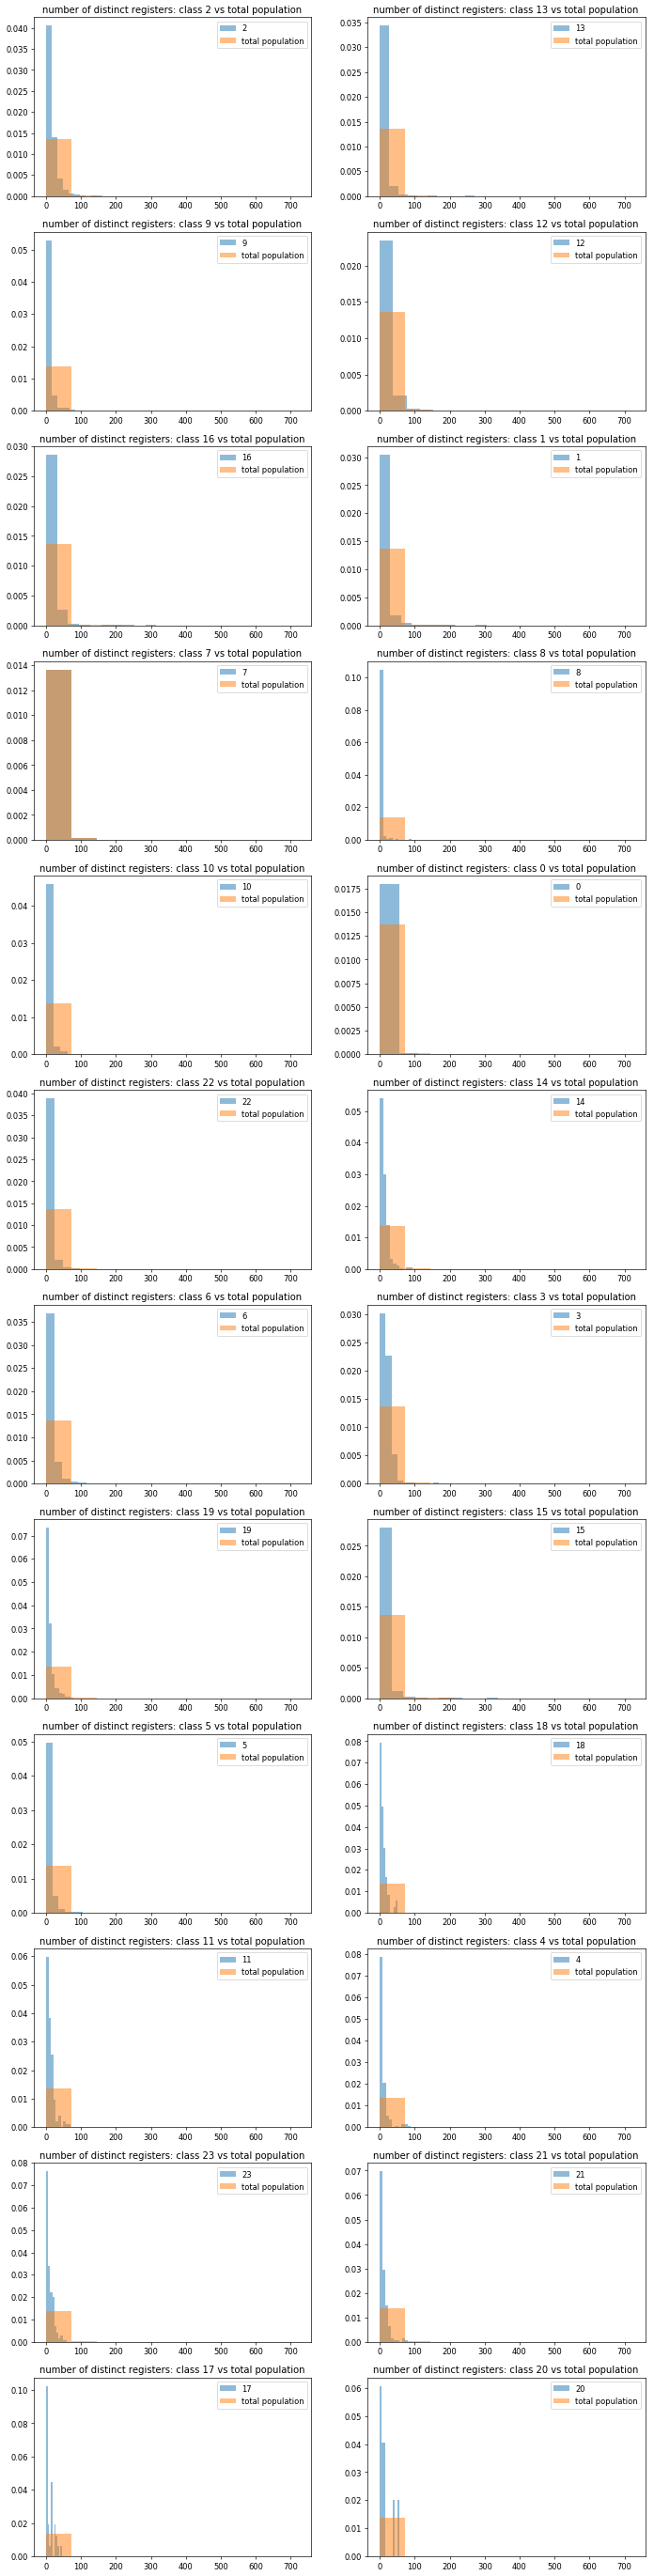

In [43]:
histogram_of_a_features(4,X_train,y_train,features_names)

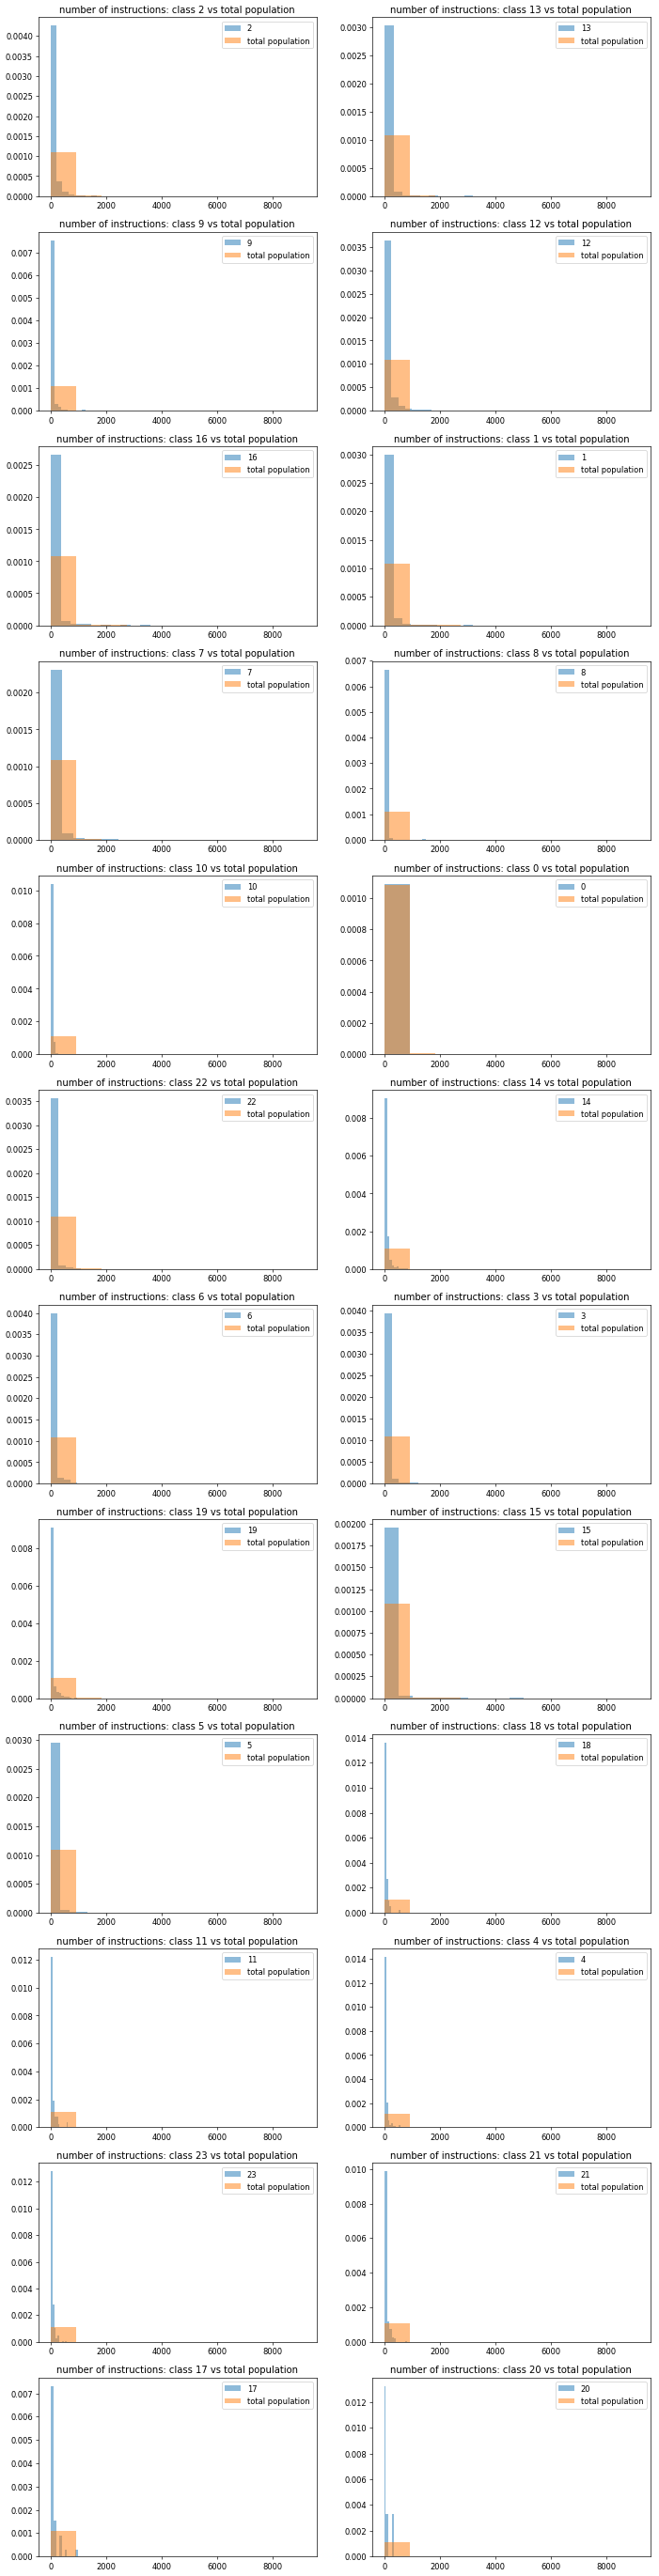

In [44]:
histogram_of_a_features(5,X_train,y_train,features_names)

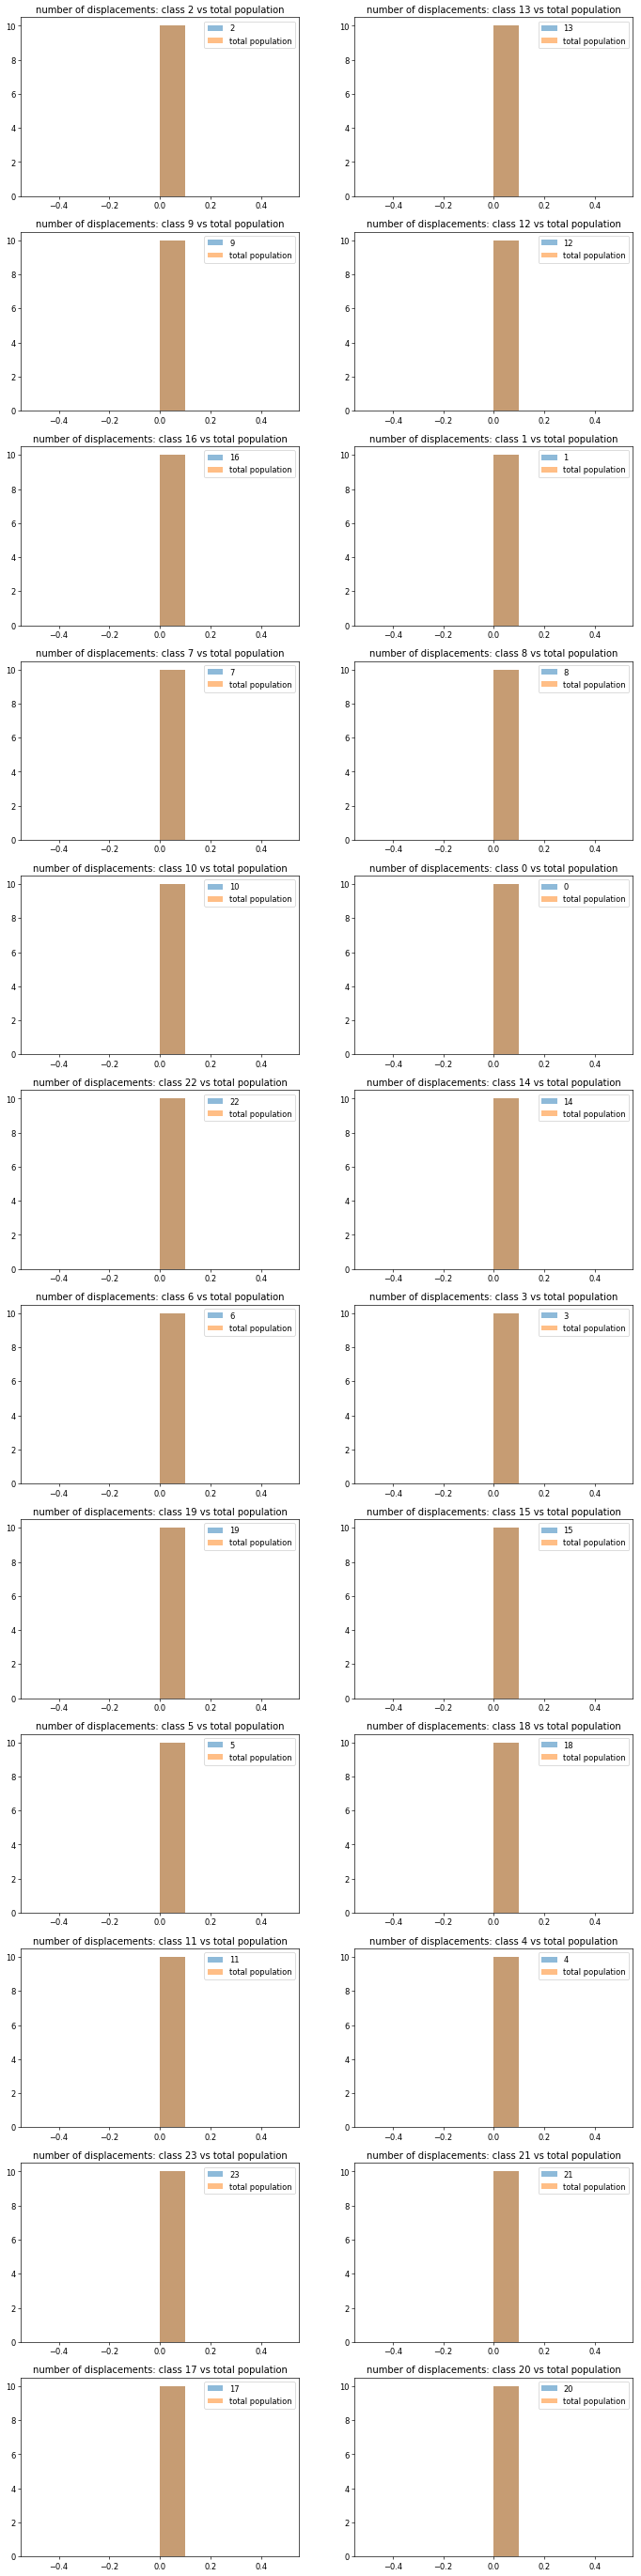

In [45]:
histogram_of_a_features(6,X_train,y_train,features_names)

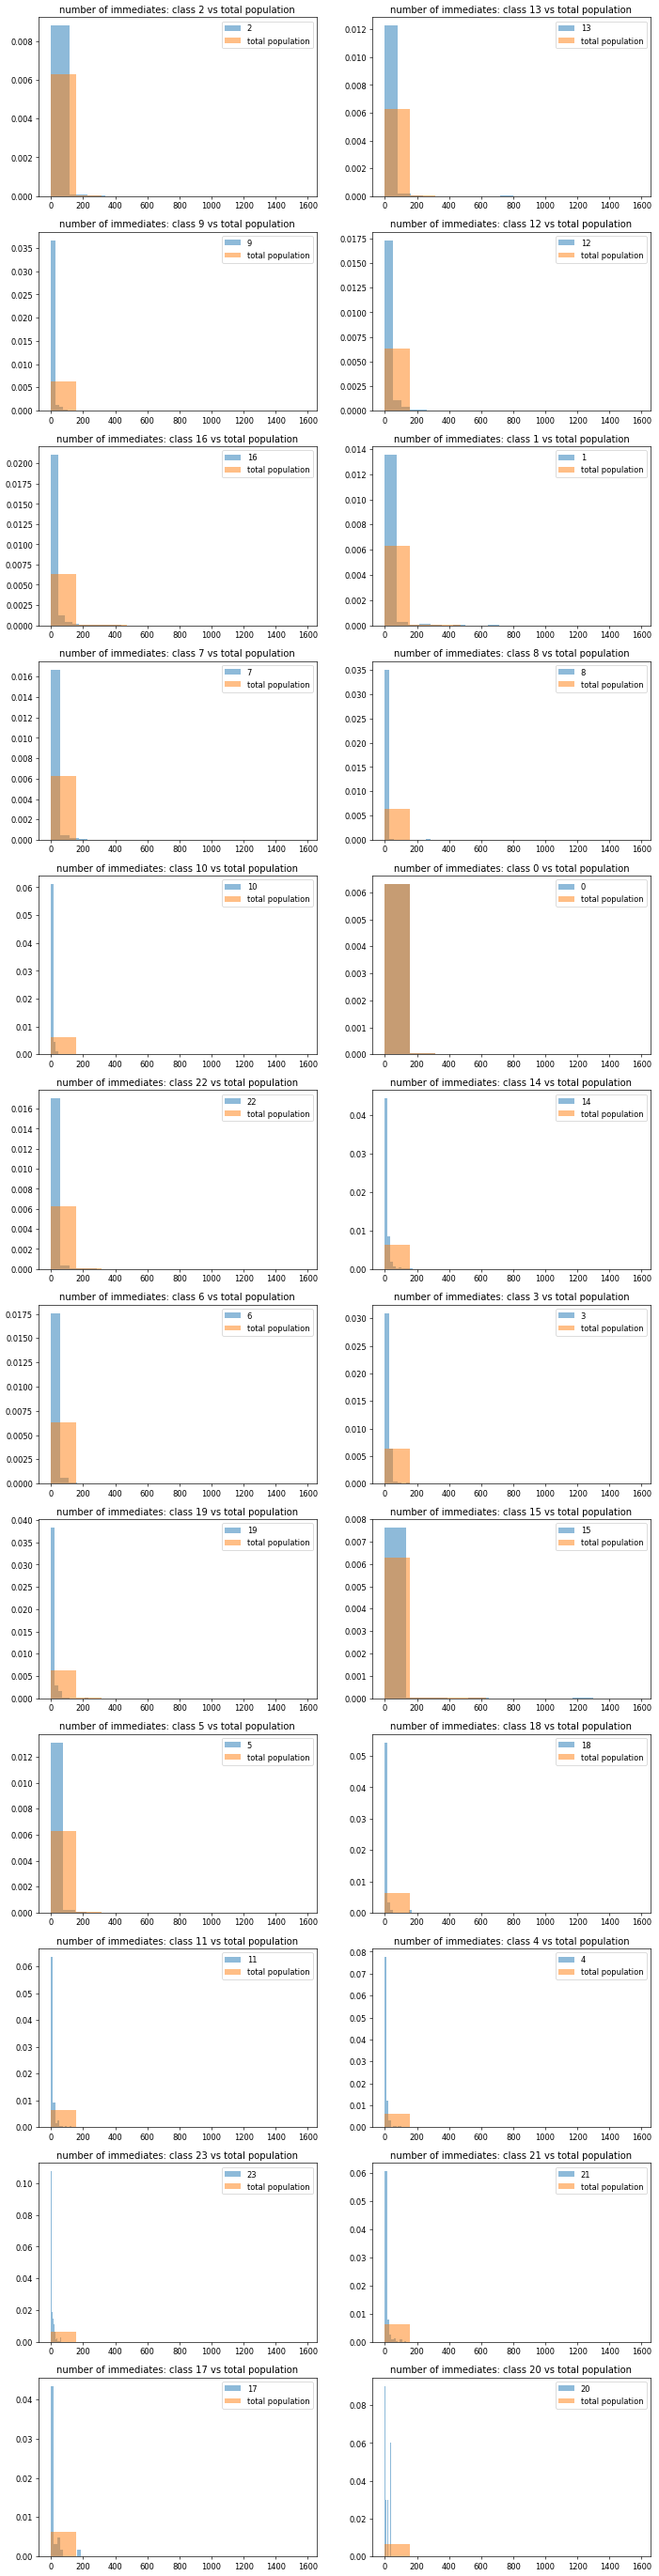

In [46]:
histogram_of_a_features(7,X_train,y_train,features_names)

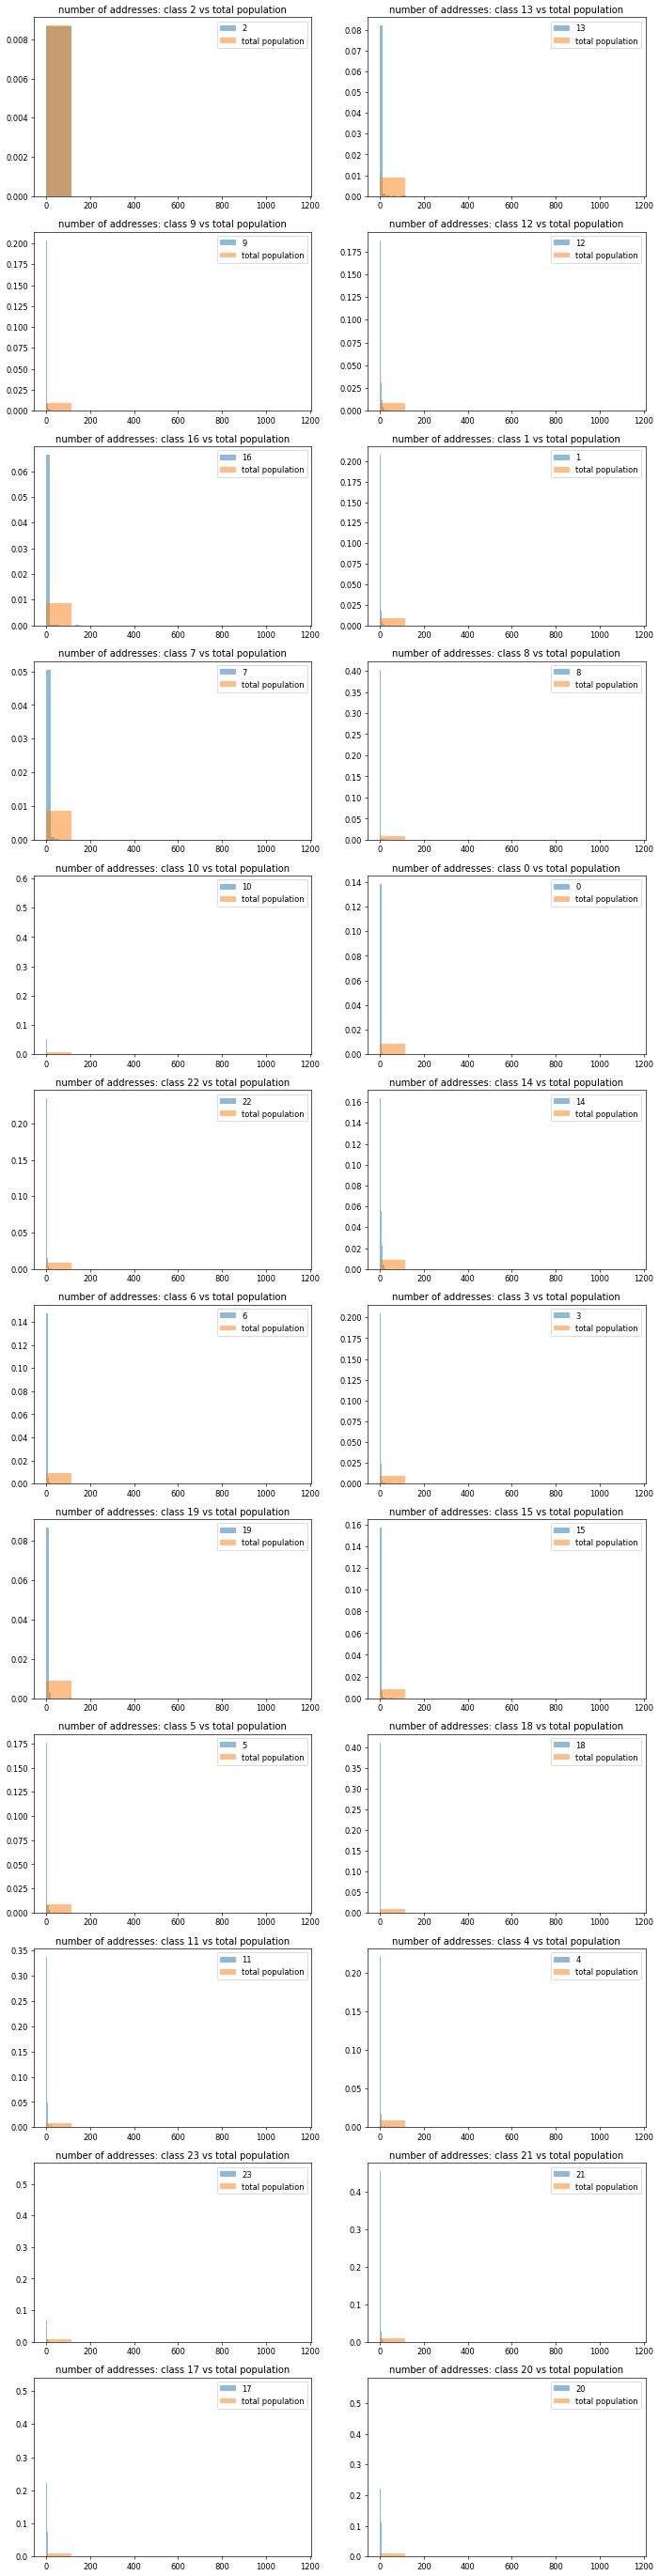

In [47]:
histogram_of_a_features(8,X_train,y_train,features_names)

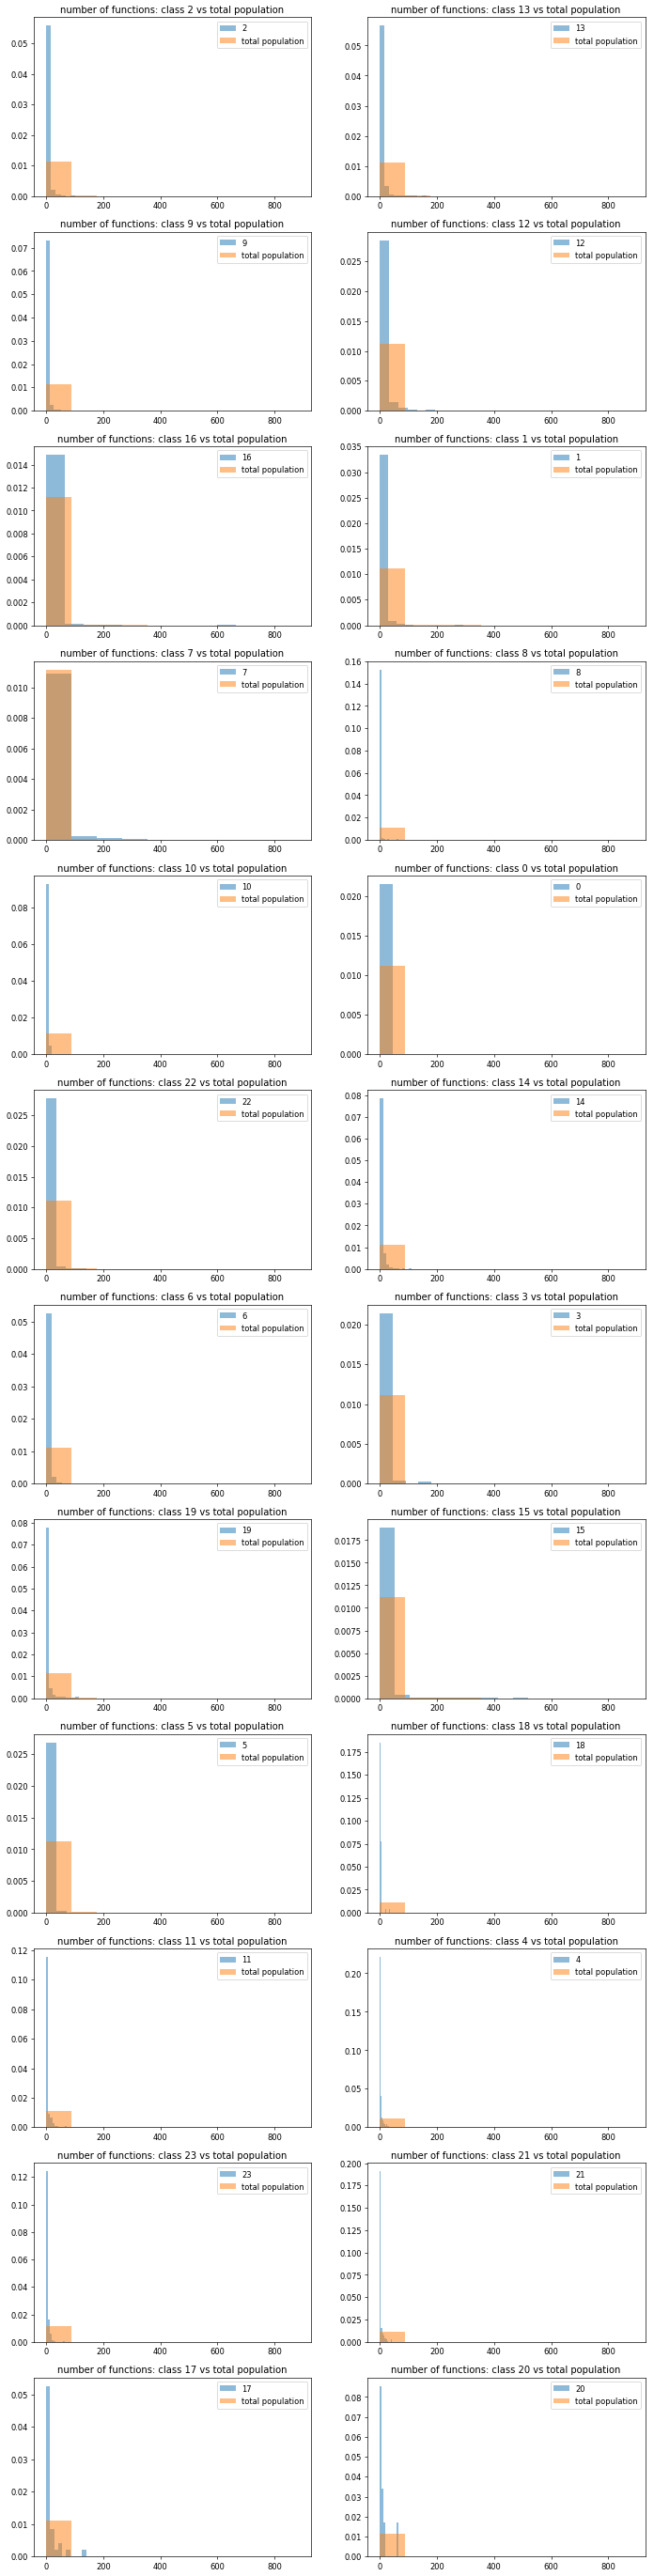

In [48]:
histogram_of_a_features(9,X_train,y_train,features_names) # num regs

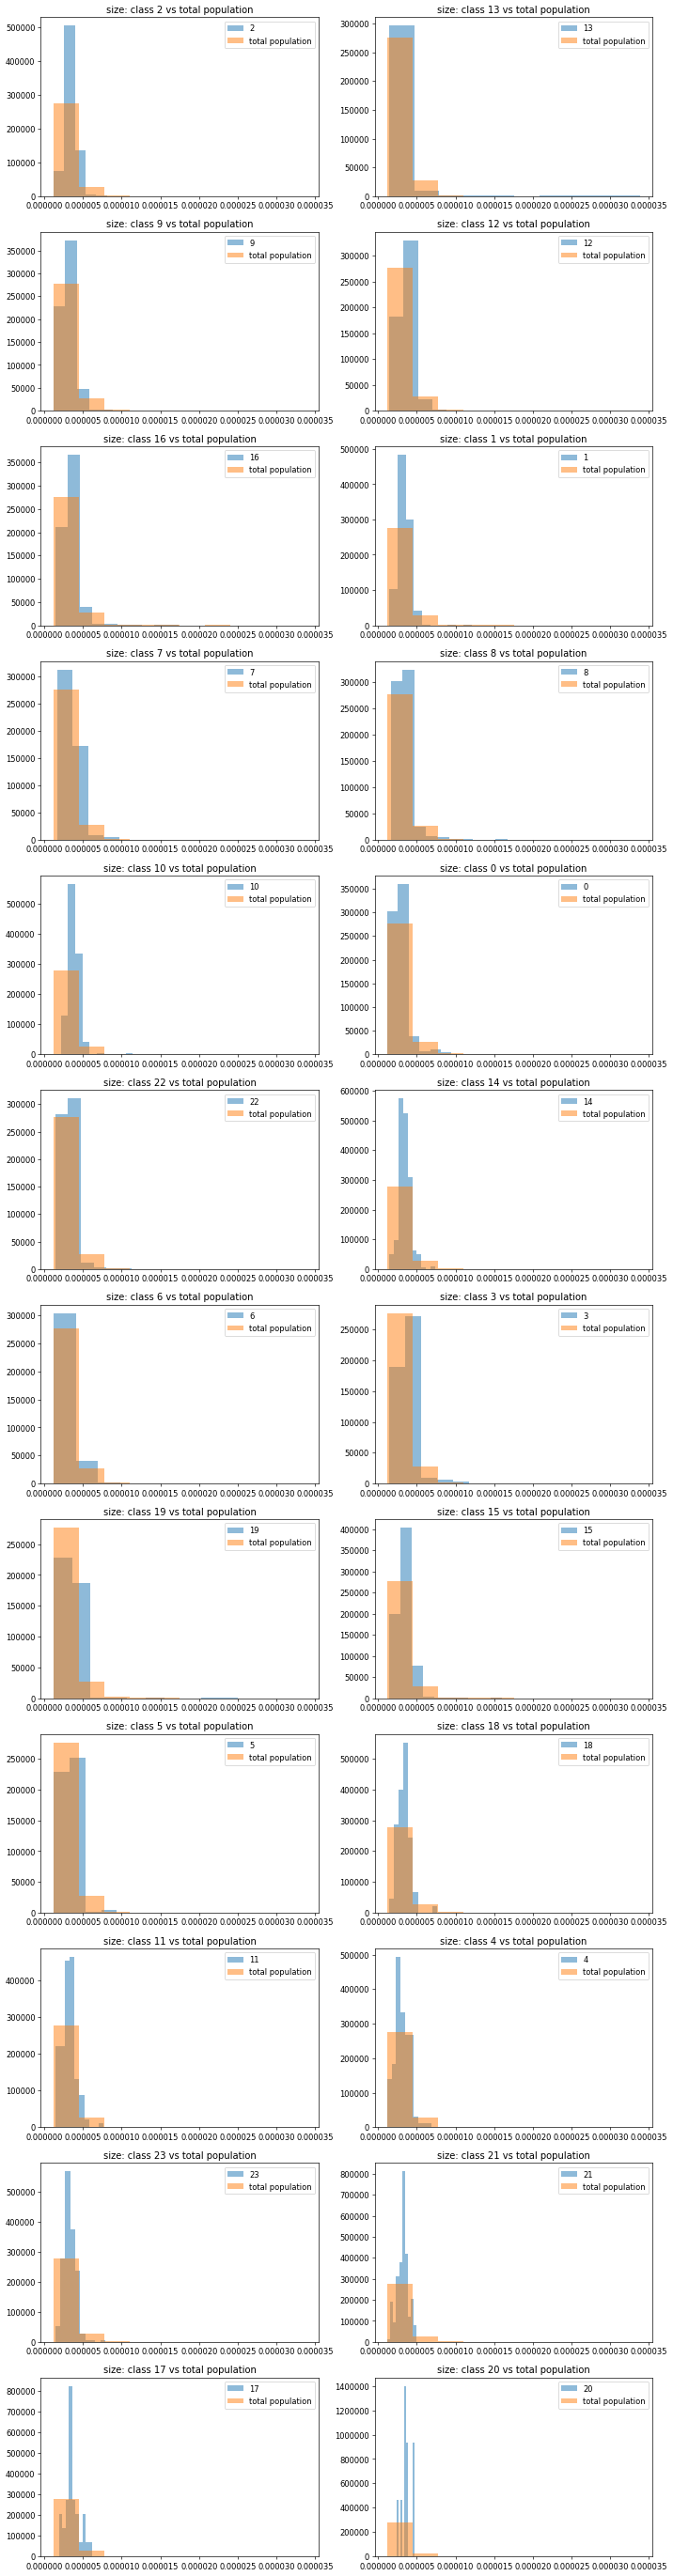

In [49]:
histogram_of_a_features(10,X_train,y_train,features_names) # size

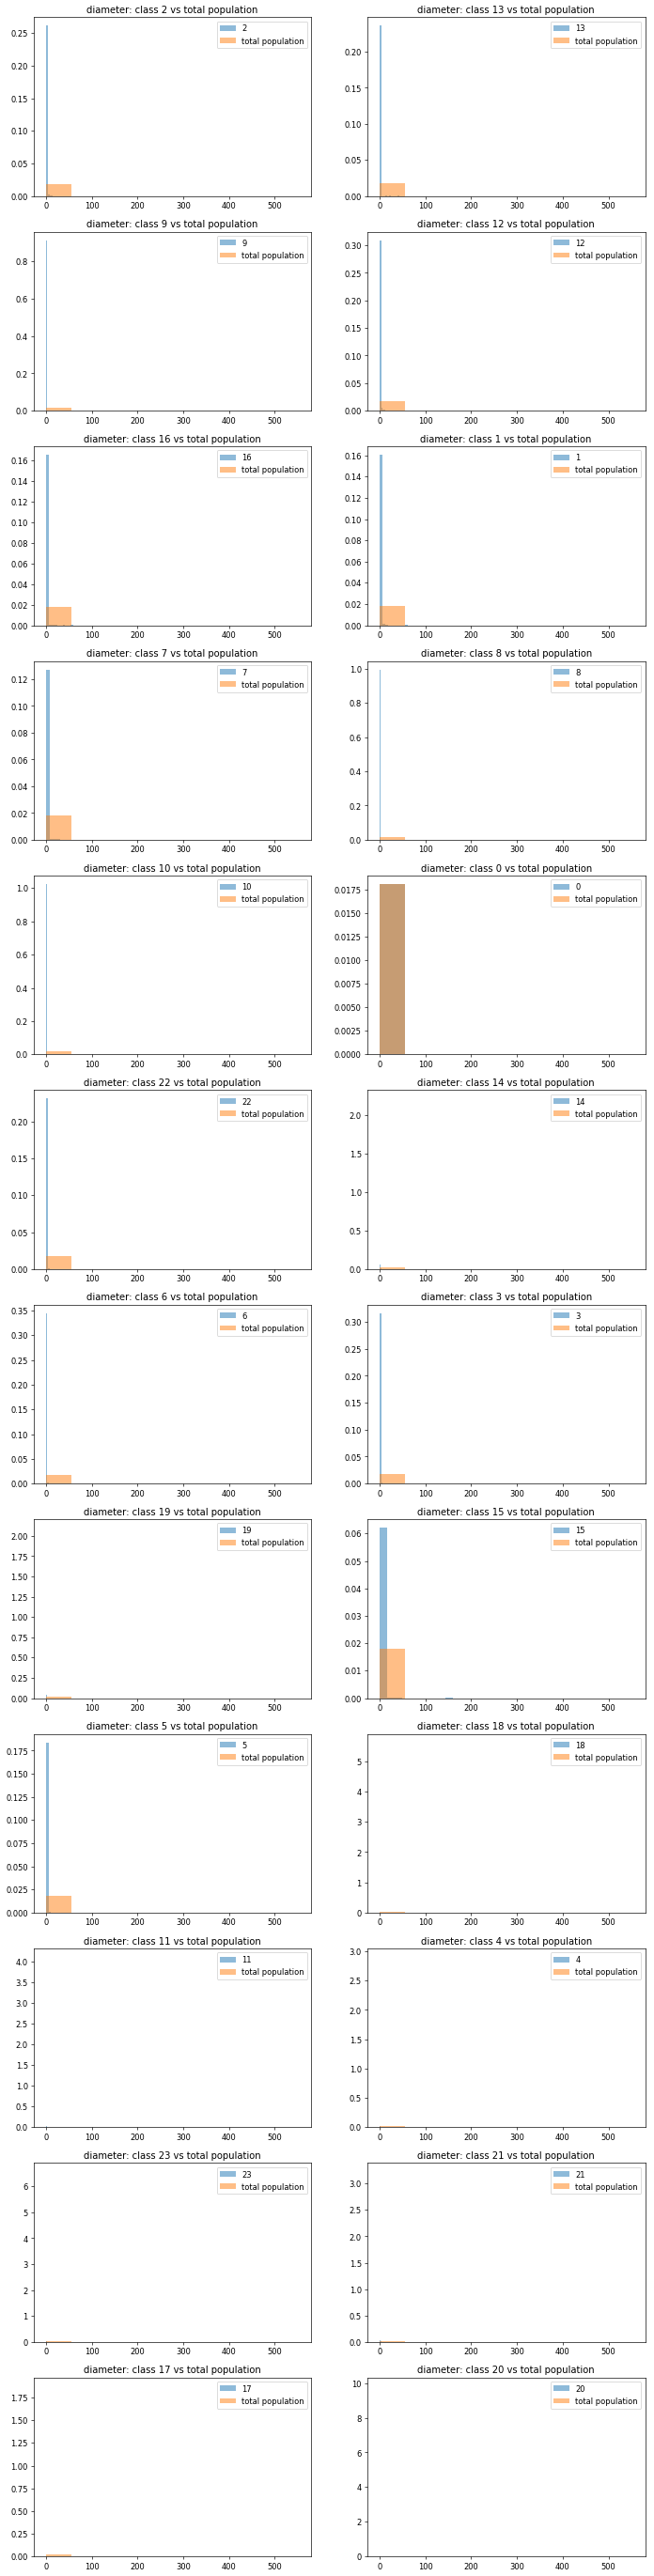

In [50]:
histogram_of_a_features(11,X_train,y_train,features_names) # diameter

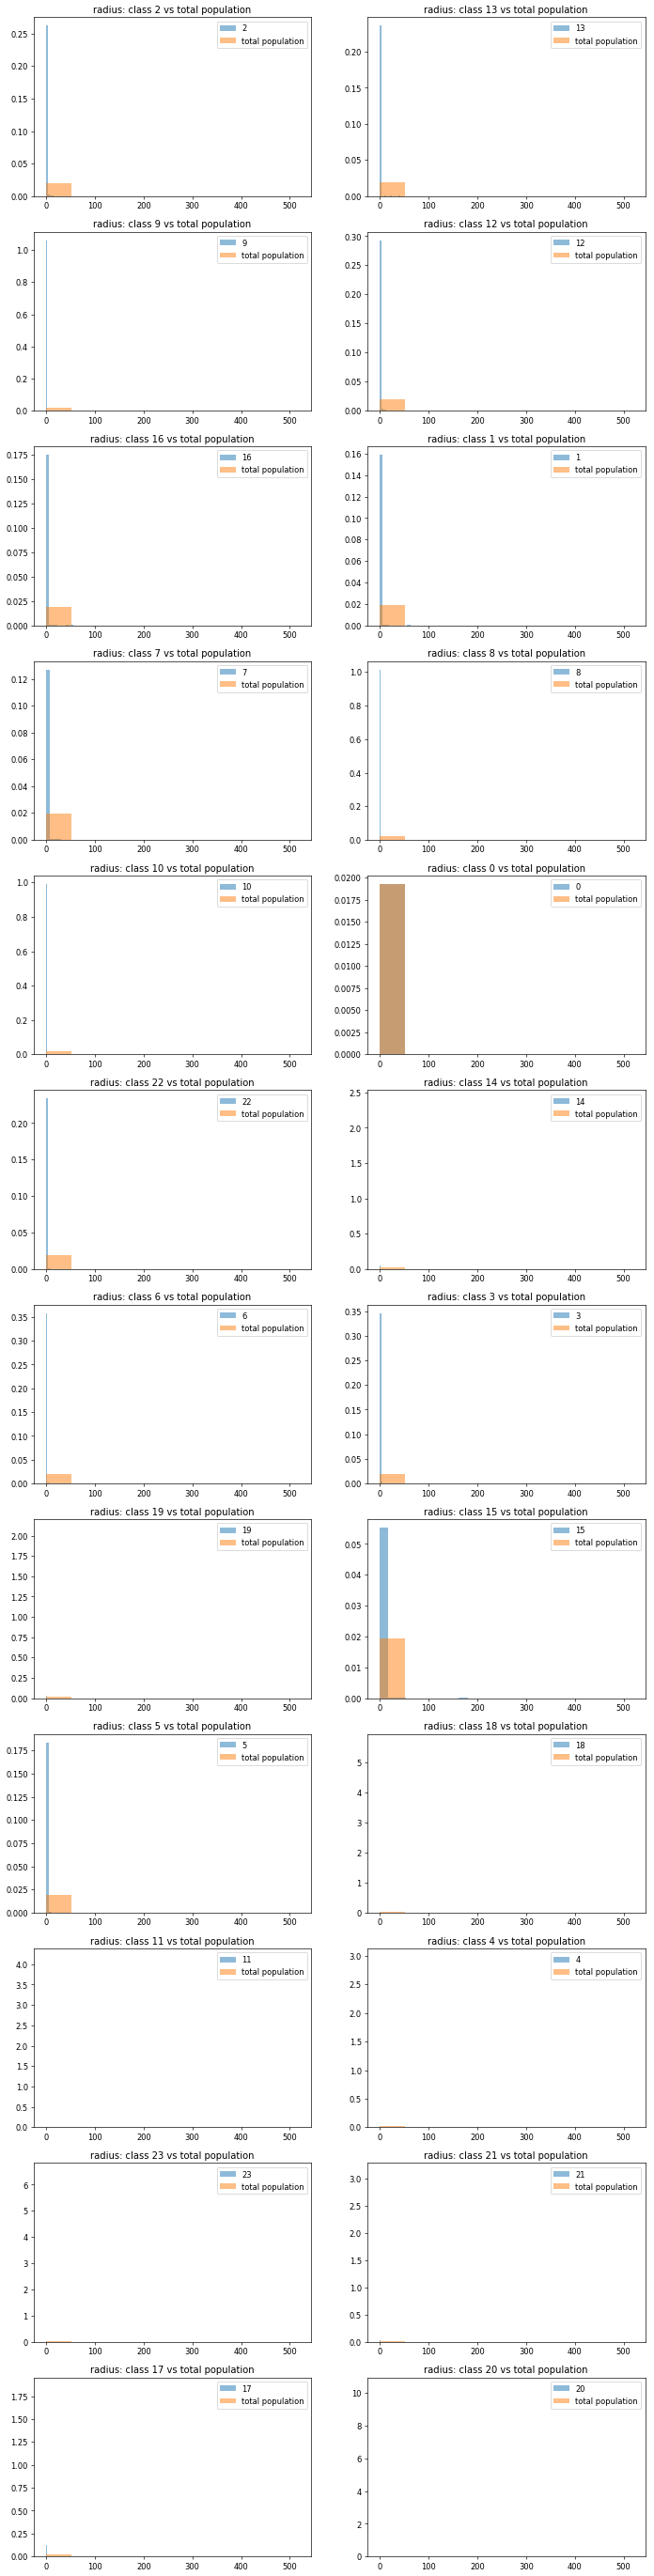

In [51]:
histogram_of_a_features(12,X_train,y_train,features_names) # radius

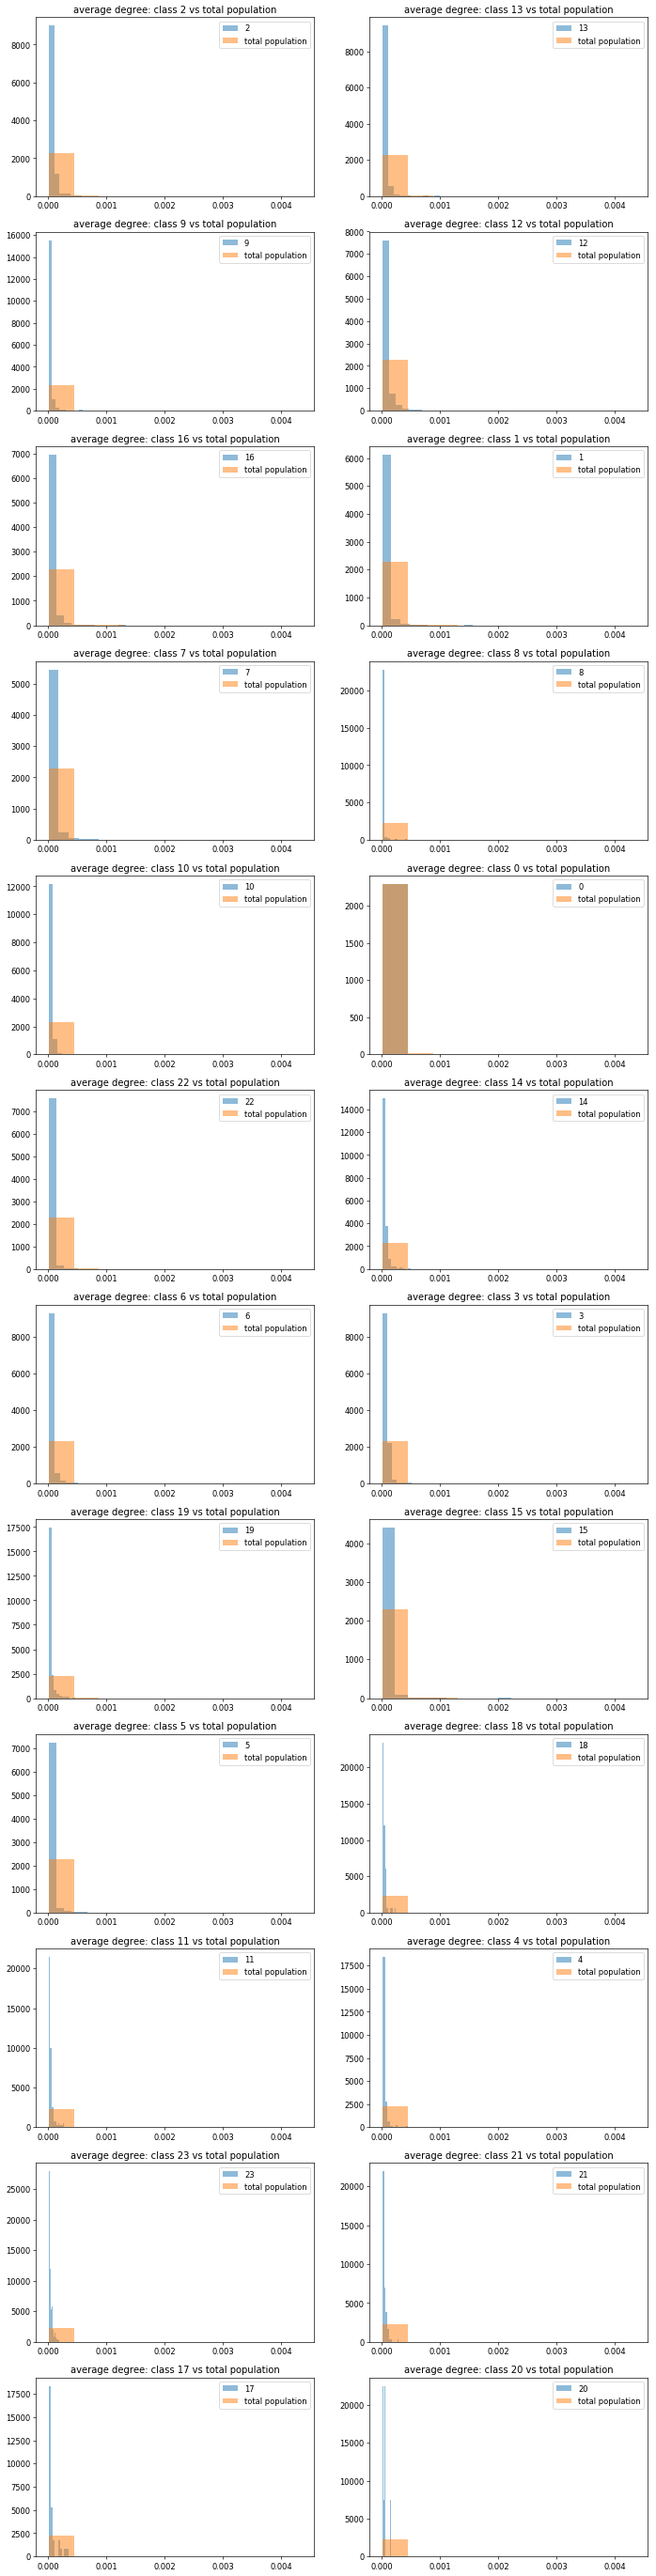

In [52]:
histogram_of_a_features(13,X_train,y_train,features_names) # AVG_DEGREE

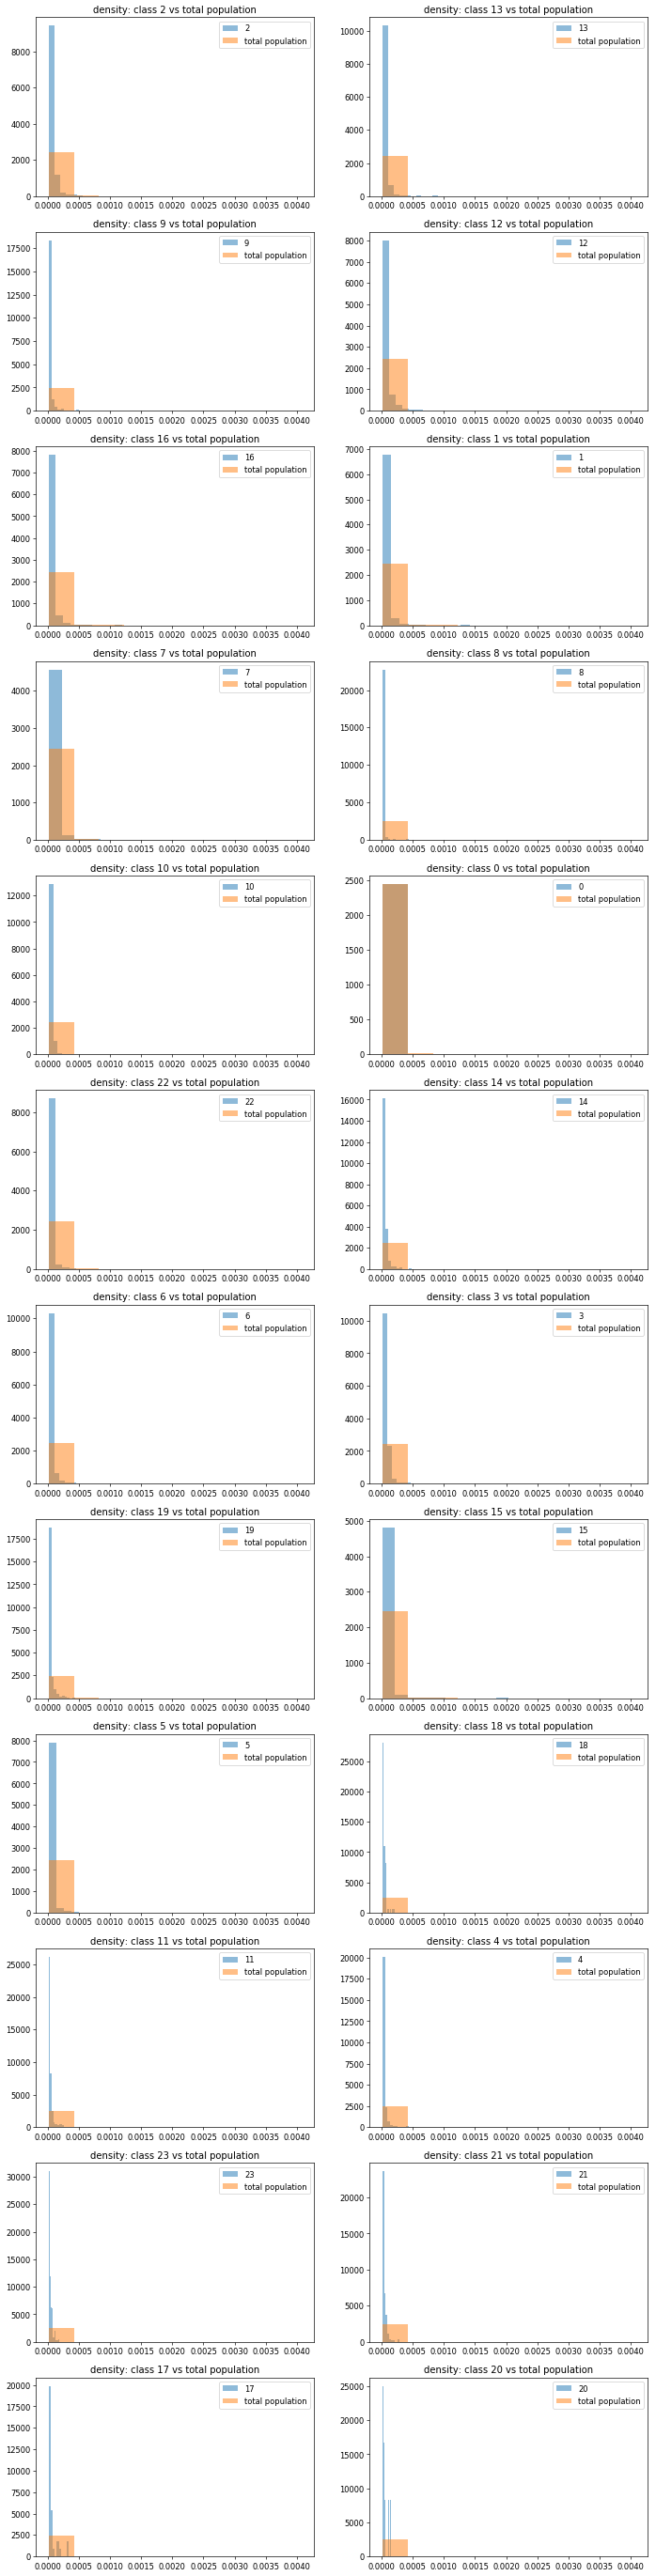

In [53]:
histogram_of_a_features(14,X_train,y_train,features_names) 

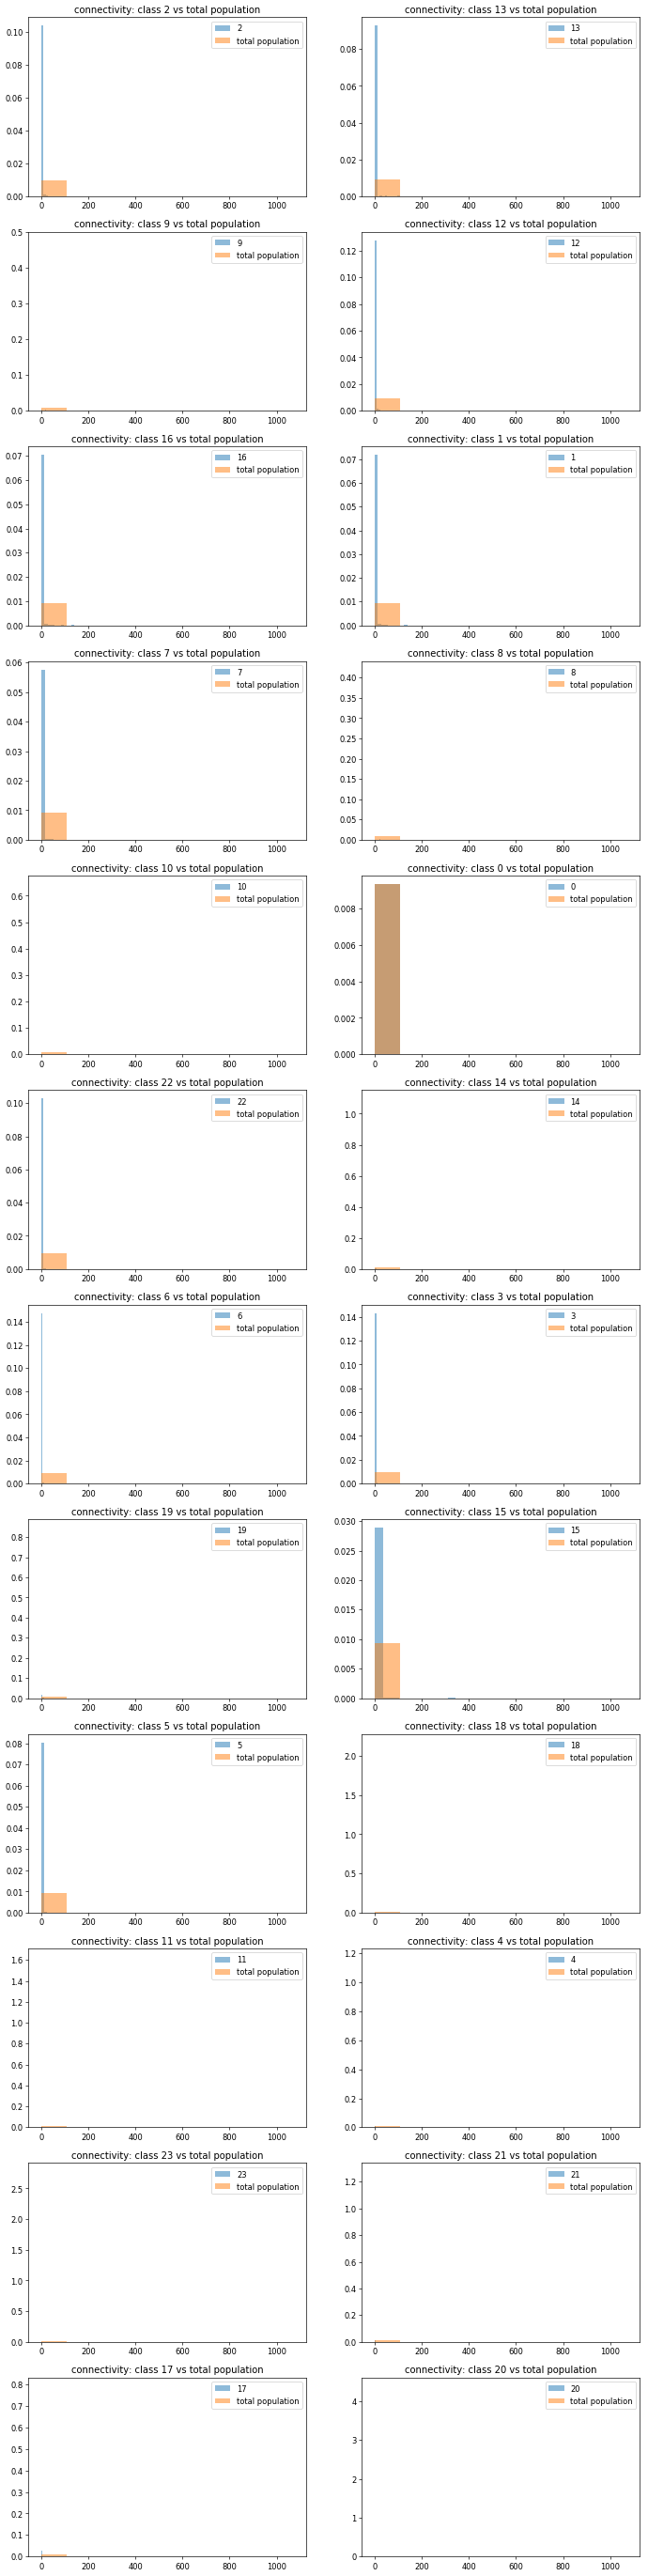

In [54]:
histogram_of_a_features(15,X_train,y_train,features_names) 

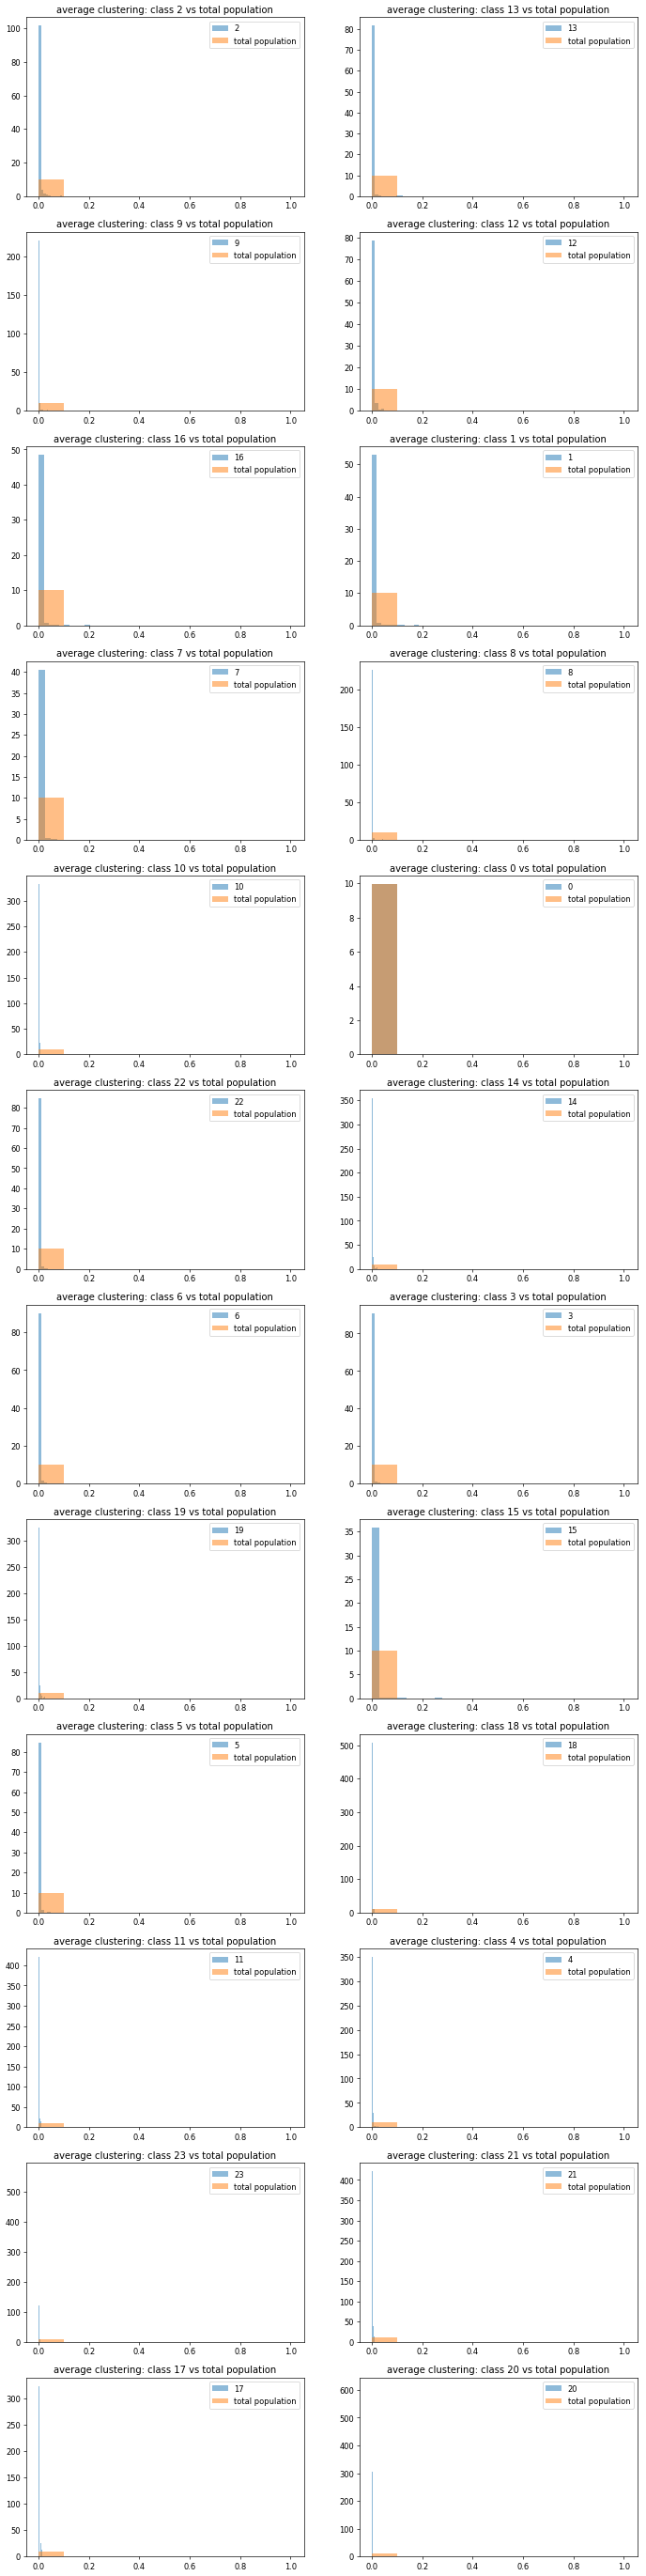

In [55]:
histogram_of_a_features(16,X_train,y_train,features_names) 

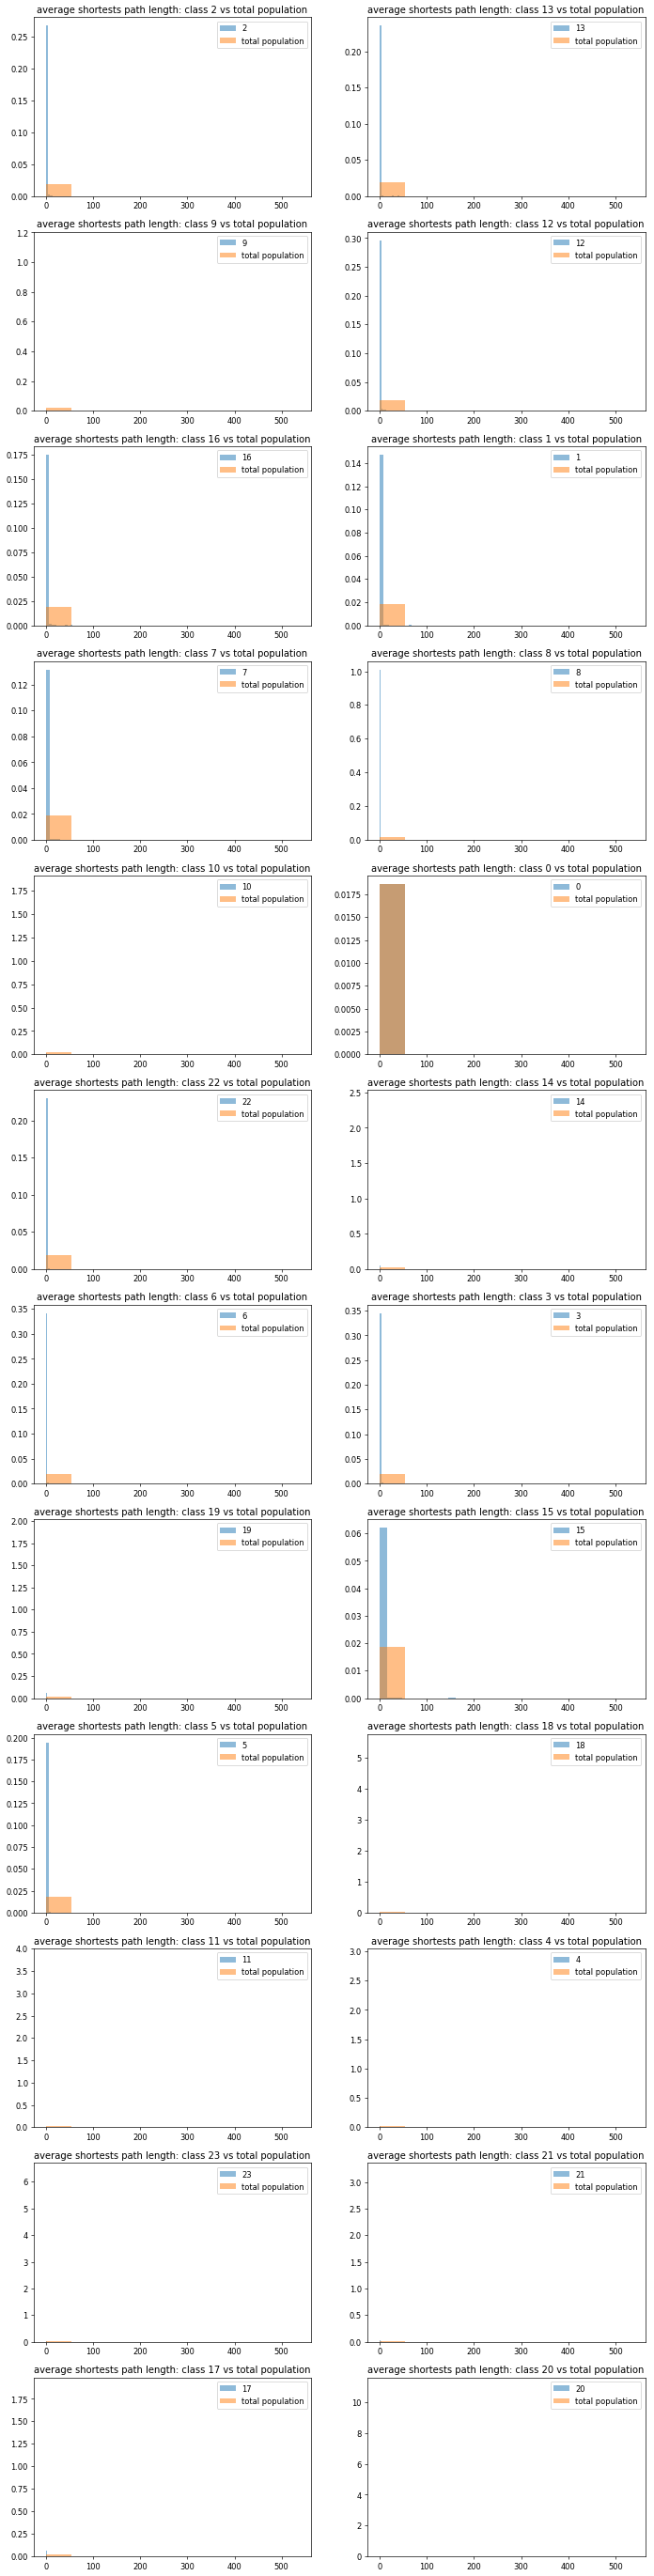

In [56]:
histogram_of_a_features(17,X_train,y_train,features_names) 

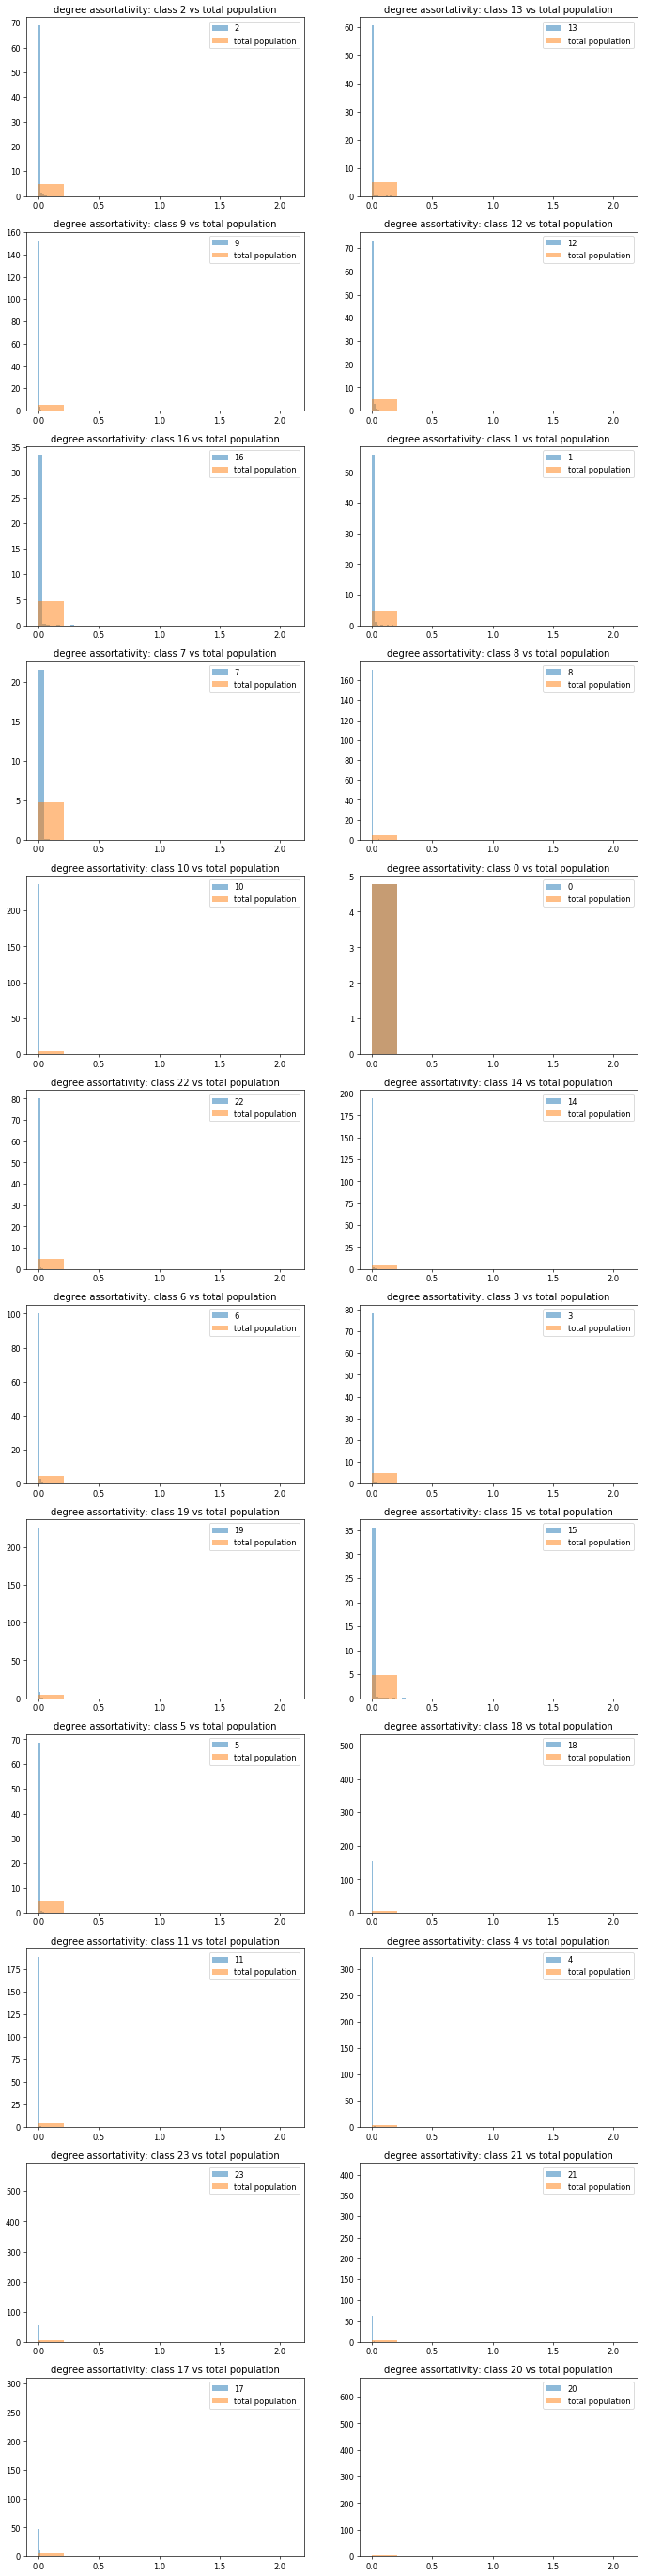

In [57]:
histogram_of_a_features(18,X_train,y_train,features_names) 

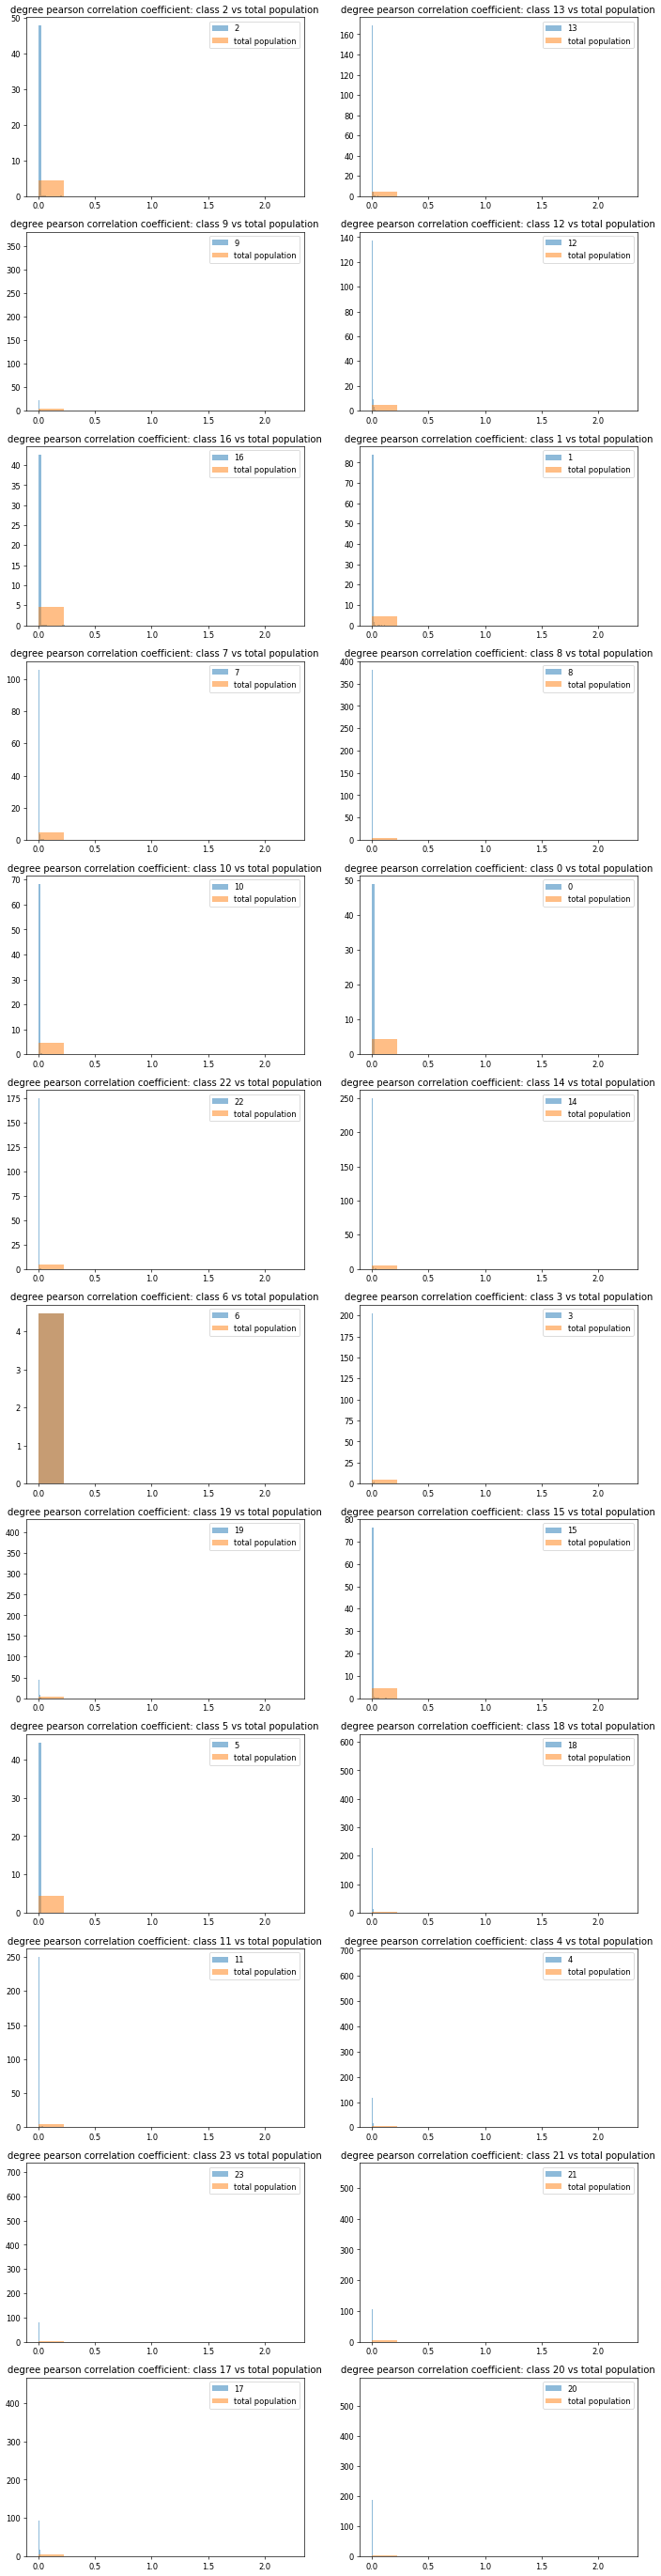

In [58]:
histogram_of_a_features(19,X_train,y_train,features_names)

In [ ]:
# boxplots of each feature for each class (oneplot per feature with all 23 classes inside)

In [ ]:
# ANOVA?

## Proportions of classes in the v1 dataset

In [5]:
#proportions
proportions_unchanged = {0: 27,
 1: 1248,
 2: 1710,
 3: 697,
 4: 4580,
 5: 1378,
 6: 1093,
 7: 5350,
 8: 14653,
 9: 149}
total=0
for i in proportions_unchanged.keys():
    total+=proportions_unchanged[i]
print("total unchanged ",total)
for i in proportions_unchanged.keys():
    print("proportion class ",i," = ",str(proportions_unchanged[i]/total))
    
proportions_undersample = {0: 27,
 1: 1248,
 2: 1710,
 3: 697,
 4: 4580,
 5: 1378,
 6: 1093,
 7: 4581,
 8: 4581,
 9: 149}
total=0
for i in proportions_undersample.keys():
    total+=proportions_undersample[i]
print("total  undersample",total)
for i in proportions_undersample.keys():
    print("proportion class ",i," = ",str(proportions_undersample[i]/total))

total unchanged  30885
proportion class  0  =  0.0008742107819329772
proportion class  1  =  0.040407965031568724
proportion class  2  =  0.055366682855755224
proportion class  3  =  0.02256758944471426
proportion class  4  =  0.14829205115751984
proportion class  5  =  0.044617128055690465
proportion class  6  =  0.035389347579731265
proportion class  7  =  0.173223247531164
proportion class  8  =  0.47443742917273757
proportion class  9  =  0.004824348389185689
total  undersample 20044
proportion class  0  =  0.0013470365196567552
proportion class  1  =  0.06226302135302335
proportion class  2  =  0.0853123129115945
proportion class  3  =  0.03477349830373179
proportion class  4  =  0.2284973059269607
proportion class  5  =  0.06874875274396328
proportion class  6  =  0.0545300339253642
proportion class  7  =  0.22854719616842945
proportion class  8  =  0.22854719616842945
proportion class  9  =  0.007433645978846538


If max proportion in undersampled dataset is 22.8% and algorithm obtains 46% accuracy it means it is not onl detecting the major class. But it could mean it is detecting only the 3 major classes... let's see the classification reports